## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11329534604513198467
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6892342477
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16206653975629512796
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_decoder_zeros
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

from attention_keras.layers.attention import AttentionLayer

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_decoder_zeros_attention_1-64'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 64 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(len_delay, 3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_1, dh1, dc1 = decoder_1(decoder_inputs, initial_state=[h1, c1])

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_1, decoder_outputs_1])
decoder_concat_input = Concatenate()([decoder_outputs_1, attn_out])

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_1_outputs = dense_1(decoder_concat_input)
dense_2 = TimeDistributed(Dense(3))
decoder_outputs = dense_2(dense_1_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def smape(y_true, y_pred):
    return 100 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_true) + K.abs(y_pred)))

def mfe(y_true, y_pred):
    return K.mean(y_pred - y_true)

model.compile(loss='mae', optimizer="adam", metrics=[rmse, smape, mfe])

print(model.summary())

(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 3)        0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 25, 64), (No 17664       input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)        [(None, 10, 64), (No 17664       input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][

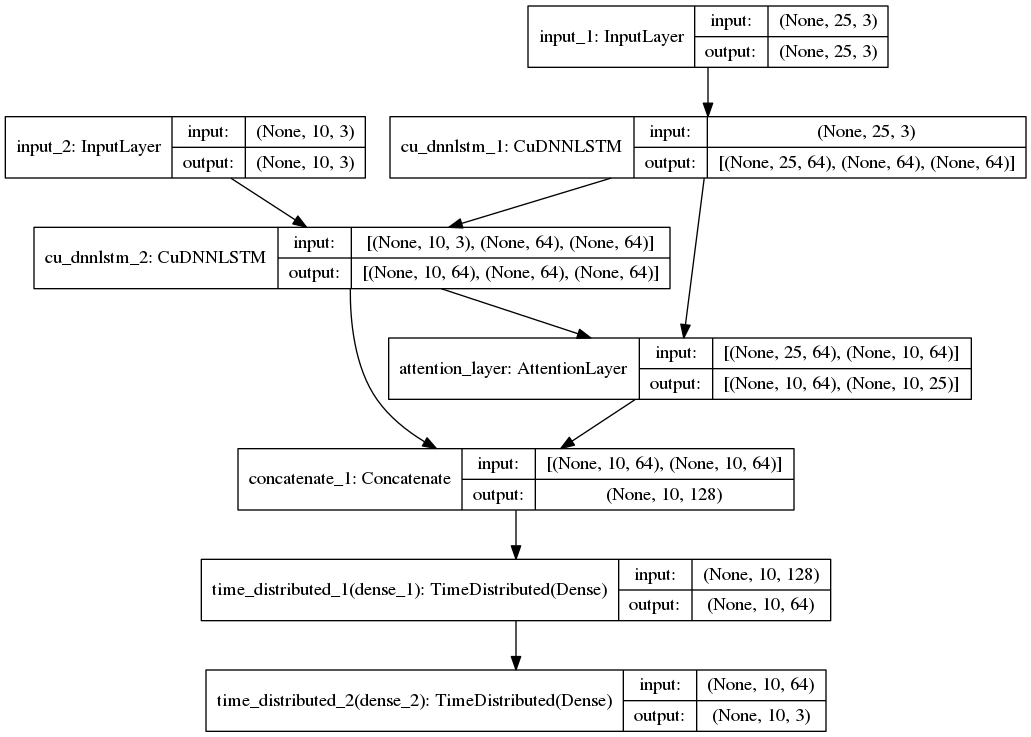

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(path_to_sensor_data_train)
videos = videos
print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 100
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

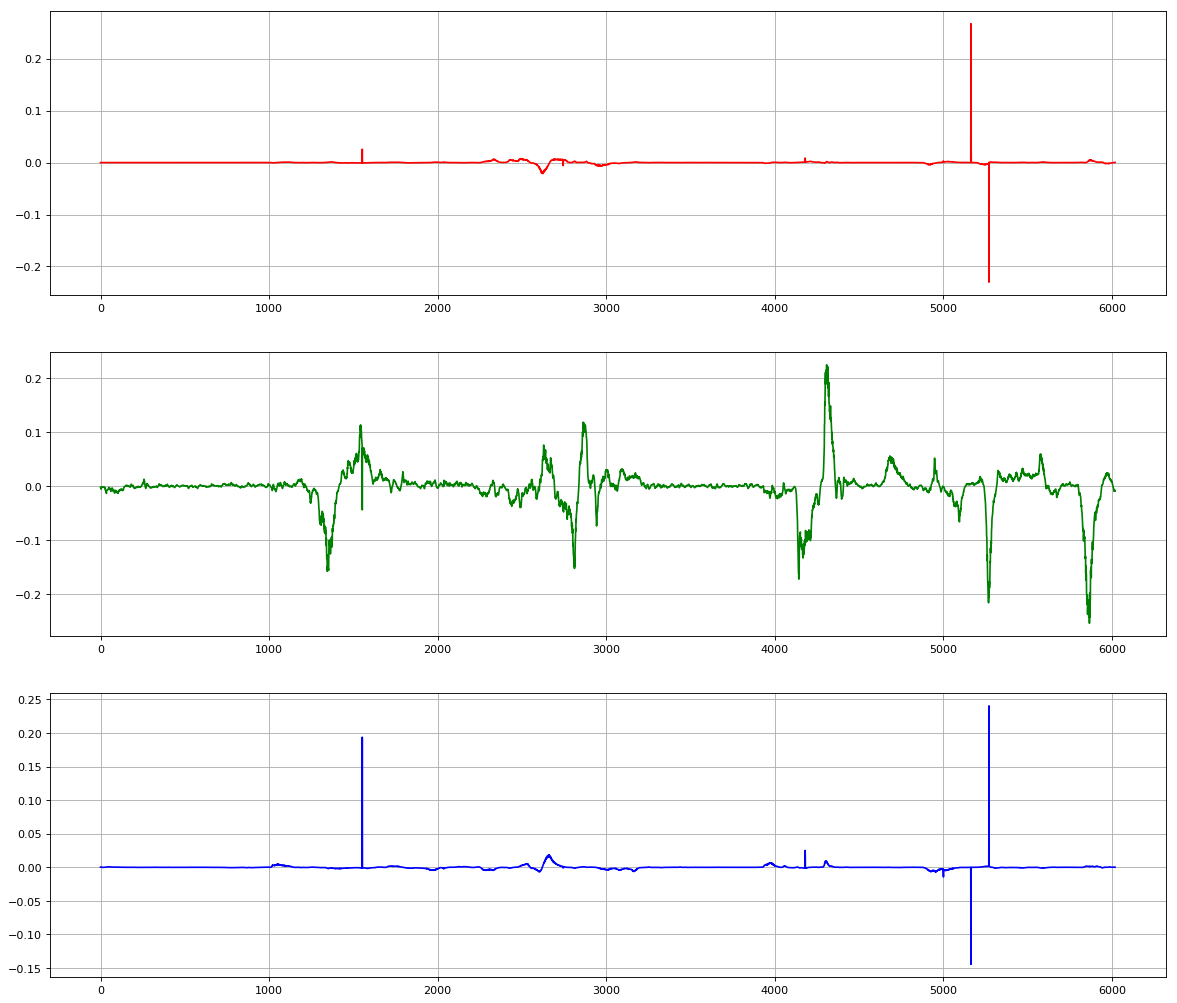

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/100


  1/542 [..............................] - ETA: 9:58 - loss: 0.0858 - rmse: 0.2805 - smape: 87.7532 - mfe: 0.0015

  2/542 [..............................] - ETA: 5:25 - loss: 0.0760 - rmse: 0.2253 - smape: 85.0387 - mfe: 3.8265e-04

  3/542 [..............................] - ETA: 3:53 - loss: 0.0893 - rmse: 0.2518 - smape: 84.6985 - mfe: -2.3813e-04

  4/542 [..............................] - ETA: 3:08 - loss: 0.0844 - rmse: 0.2348 - smape: 84.1507 - mfe: -0.0010    

  5/542 [..............................] - ETA: 2:40 - loss: 0.0789 - rmse: 0.2216 - smape: 83.9327 - mfe: -5.7828e-04

  6/542 [..............................] - ETA: 2:22 - loss: 0.0733 - rmse: 0.2168 - smape: 83.3901 - mfe: -6.7443e-06

  7/542 [..............................] - ETA: 2:09 - loss: 0.0738 - rmse: 0.2120 - smape: 83.7755 - mfe: -1.7356e-04

  8/542 [..............................] - ETA: 2:00 - loss: 0.0769 - rmse: 0.2244 - smape: 83.8317 - mfe: -2.8036e-04

  9/542 [..............................] - ETA: 1:52 - loss: 0.0840 - rmse: 0.2441 - smape: 84.4977 - mfe: -3.8349e-05

 10/542 [..............................] - ETA: 1:46 - loss: 0.0805 - rmse: 0.2337 - smape: 84.1694 - mfe: 7.2441e-04 

 11/542 [..............................] - ETA: 1:40 - loss: 0.0765 - rmse: 0.2203 - smape: 84.1962 - mfe: 9.5864e-04

 12/542 [..............................] - ETA: 1:36 - loss: 0.0745 - rmse: 0.2154 - smape: 84.0550 - mfe: 7.5553e-04

 13/542 [..............................] - ETA: 1:32 - loss: 0.0751 - rmse: 0.2148 - smape: 84.0218 - mfe: 3.9084e-04

 14/542 [..............................] - ETA: 1:29 - loss: 0.0717 - rmse: 0.2061 - smape: 83.8286 - mfe: 6.6023e-05

 15/542 [..............................] - ETA: 1:26 - loss: 0.0685 - rmse: 0.1967 - smape: 83.7738 - mfe: -1.5029e-04

 16/542 [..............................] - ETA: 1:23 - loss: 0.0658 - rmse: 0.1883 - smape: 83.6978 - mfe: -9.4681e-05

 17/542 [..............................] - ETA: 1:21 - loss: 0.0644 - rmse: 0.1836 - smape: 83.7601 - mfe: 7.6104e-05 

 18/542 [..............................] - ETA: 1:19 - loss: 0.0660 - rmse: 0.1874 - smape: 83.4789 - mfe: 3.3286e-04

 19/542 [>.............................] - ETA: 1:18 - loss: 0.0668 - rmse: 0.1887 - smape: 83.2469 - mfe: 5.6092e-04

 20/542 [>.............................] - ETA: 1:16 - loss: 0.0660 - rmse: 0.1873 - smape: 83.2350 - mfe: 7.0042e-04

 21/542 [>.............................] - ETA: 1:15 - loss: 0.0639 - rmse: 0.1820 - smape: 83.1122 - mfe: 8.0887e-04

 22/542 [>.............................] - ETA: 1:14 - loss: 0.0648 - rmse: 0.1833 - smape: 83.2033 - mfe: 7.9274e-04

 23/542 [>.............................] - ETA: 1:13 - loss: 0.0660 - rmse: 0.1858 - smape: 83.2881 - mfe: 7.2176e-04

 24/542 [>.............................] - ETA: 1:11 - loss: 0.0647 - rmse: 0.1823 - smape: 82.9066 - mfe: 7.1886e-04

 25/542 [>.............................] - ETA: 1:10 - loss: 0.0644 - rmse: 0.1800 - smape: 82.9327 - mfe: 6.5885e-04

 26/542 [>.............................] - ETA: 1:10 - loss: 0.0645 - rmse: 0.1806 - smape: 82.9197 - mfe: 6.2450e-04

 27/542 [>.............................] - ETA: 1:08 - loss: 0.0672 - rmse: 0.1855 - smape: 83.0784 - mfe: 6.8610e-04

 28/542 [>.............................] - ETA: 1:08 - loss: 0.0669 - rmse: 0.1840 - smape: 83.2035 - mfe: 6.4063e-04

 29/542 [>.............................] - ETA: 1:06 - loss: 0.0672 - rmse: 0.1840 - smape: 83.4032 - mfe: 6.6778e-04

 30/542 [>.............................] - ETA: 1:06 - loss: 0.0671 - rmse: 0.1840 - smape: 83.4620 - mfe: 6.8113e-04

 31/542 [>.............................] - ETA: 1:05 - loss: 0.0671 - rmse: 0.1838 - smape: 83.6325 - mfe: 7.1021e-04

 32/542 [>.............................] - ETA: 1:05 - loss: 0.0683 - rmse: 0.1873 - smape: 83.7052 - mfe: 8.1977e-04

 33/542 [>.............................] - ETA: 1:04 - loss: 0.0687 - rmse: 0.1890 - smape: 83.7214 - mfe: 7.6564e-04

 34/542 [>.............................] - ETA: 1:03 - loss: 0.0673 - rmse: 0.1849 - smape: 83.7353 - mfe: 7.1338e-04

 35/542 [>.............................] - ETA: 1:03 - loss: 0.0657 - rmse: 0.1804 - smape: 83.6671 - mfe: 6.6738e-04

 36/542 [>.............................] - ETA: 1:02 - loss: 0.0663 - rmse: 0.1812 - smape: 83.5702 - mfe: 7.3924e-04

 37/542 [=>............................] - ETA: 1:02 - loss: 0.0670 - rmse: 0.1827 - smape: 83.5612 - mfe: 7.9888e-04

 38/542 [=>............................] - ETA: 1:01 - loss: 0.0668 - rmse: 0.1821 - smape: 83.5076 - mfe: 8.8653e-04

 39/542 [=>............................] - ETA: 1:01 - loss: 0.0679 - rmse: 0.1837 - smape: 83.5352 - mfe: 9.5887e-04

 40/542 [=>............................] - ETA: 1:00 - loss: 0.0674 - rmse: 0.1828 - smape: 83.4918 - mfe: 0.0010    

 41/542 [=>............................] - ETA: 1:00 - loss: 0.0691 - rmse: 0.1861 - smape: 83.4727 - mfe: 0.0011

 42/542 [=>............................] - ETA: 1:00 - loss: 0.0691 - rmse: 0.1856 - smape: 83.3959 - mfe: 0.0011

 43/542 [=>............................] - ETA: 59s - loss: 0.0694 - rmse: 0.1882 - smape: 83.3513 - mfe: 0.0011 

 44/542 [=>............................] - ETA: 59s - loss: 0.0701 - rmse: 0.1902 - smape: 83.3064 - mfe: 0.0011

 45/542 [=>............................] - ETA: 58s - loss: 0.0693 - rmse: 0.1878 - smape: 83.2570 - mfe: 0.0012

 46/542 [=>............................] - ETA: 58s - loss: 0.0693 - rmse: 0.1873 - smape: 83.1883 - mfe: 0.0011

 47/542 [=>............................] - ETA: 58s - loss: 0.0705 - rmse: 0.1901 - smape: 83.1047 - mfe: 0.0013

 48/542 [=>............................] - ETA: 57s - loss: 0.0706 - rmse: 0.1902 - smape: 83.0317 - mfe: 0.0012

 49/542 [=>............................] - ETA: 57s - loss: 0.0705 - rmse: 0.1903 - smape: 82.9658 - mfe: 0.0012

 50/542 [=>............................] - ETA: 57s - loss: 0.0706 - rmse: 0.1901 - smape: 82.9305 - mfe: 0.0013

 51/542 [=>............................] - ETA: 57s - loss: 0.0704 - rmse: 0.1909 - smape: 82.8485 - mfe: 0.0013

 52/542 [=>............................] - ETA: 56s - loss: 0.0704 - rmse: 0.1911 - smape: 82.7377 - mfe: 0.0013

 53/542 [=>............................] - ETA: 56s - loss: 0.0701 - rmse: 0.1905 - smape: 82.6679 - mfe: 0.0013

 54/542 [=>............................] - ETA: 56s - loss: 0.0691 - rmse: 0.1877 - smape: 82.5770 - mfe: 0.0012

 55/542 [==>...........................] - ETA: 55s - loss: 0.0690 - rmse: 0.1870 - smape: 82.5580 - mfe: 0.0012

 56/542 [==>...........................] - ETA: 55s - loss: 0.0690 - rmse: 0.1870 - smape: 82.5114 - mfe: 0.0012

 57/542 [==>...........................] - ETA: 55s - loss: 0.0685 - rmse: 0.1854 - smape: 82.4490 - mfe: 0.0012

 58/542 [==>...........................] - ETA: 55s - loss: 0.0686 - rmse: 0.1866 - smape: 82.3731 - mfe: 0.0013

 59/542 [==>...........................] - ETA: 54s - loss: 0.0689 - rmse: 0.1880 - smape: 82.3042 - mfe: 0.0013

 60/542 [==>...........................] - ETA: 54s - loss: 0.0687 - rmse: 0.1876 - smape: 82.2317 - mfe: 0.0013

 61/542 [==>...........................] - ETA: 54s - loss: 0.0684 - rmse: 0.1867 - smape: 82.1953 - mfe: 0.0012

 62/542 [==>...........................] - ETA: 54s - loss: 0.0685 - rmse: 0.1868 - smape: 82.1623 - mfe: 0.0012

 63/542 [==>...........................] - ETA: 53s - loss: 0.0681 - rmse: 0.1855 - smape: 82.1505 - mfe: 0.0013

 64/542 [==>...........................] - ETA: 53s - loss: 0.0685 - rmse: 0.1859 - smape: 82.0974 - mfe: 0.0014

 65/542 [==>...........................] - ETA: 53s - loss: 0.0688 - rmse: 0.1865 - smape: 81.9685 - mfe: 0.0014

 66/542 [==>...........................] - ETA: 53s - loss: 0.0690 - rmse: 0.1870 - smape: 81.9822 - mfe: 0.0015

 67/542 [==>...........................] - ETA: 52s - loss: 0.0688 - rmse: 0.1865 - smape: 81.9459 - mfe: 0.0014

 68/542 [==>...........................] - ETA: 52s - loss: 0.0684 - rmse: 0.1853 - smape: 81.9507 - mfe: 0.0014

 69/542 [==>...........................] - ETA: 52s - loss: 0.0689 - rmse: 0.1869 - smape: 81.8957 - mfe: 0.0015



 70/542 [==>...........................] - ETA: 52s - loss: 0.0692 - rmse: 0.1889 - smape: 81.8974 - mfe: 0.0015

 71/542 [==>...........................] - ETA: 52s - loss: 0.0694 - rmse: 0.1891 - smape: 81.8529 - mfe: 0.0015

 72/542 [==>...........................] - ETA: 51s - loss: 0.0693 - rmse: 0.1887 - smape: 81.7981 - mfe: 0.0015

 73/542 [===>..........................] - ETA: 51s - loss: 0.0700 - rmse: 0.1907 - smape: 81.7653 - mfe: 0.0016

 74/542 [===>..........................] - ETA: 51s - loss: 0.0695 - rmse: 0.1898 - smape: 81.7114 - mfe: 0.0015

 75/542 [===>..........................] - ETA: 51s - loss: 0.0693 - rmse: 0.1891 - smape: 81.6871 - mfe: 0.0015

 76/542 [===>..........................] - ETA: 51s - loss: 0.0694 - rmse: 0.1891 - smape: 81.6463 - mfe: 0.0015

 77/542 [===>..........................] - ETA: 51s - loss: 0.0692 - rmse: 0.1898 - smape: 81.6222 - mfe: 0.0015

 78/542 [===>..........................] - ETA: 50s - loss: 0.0690 - rmse: 0.1893 - smape: 81.6351 - mfe: 0.0015

 79/542 [===>..........................] - ETA: 50s - loss: 0.0687 - rmse: 0.1883 - smape: 81.6450 - mfe: 0.0014

 80/542 [===>..........................] - ETA: 50s - loss: 0.0685 - rmse: 0.1873 - smape: 81.6310 - mfe: 0.0014

 81/542 [===>..........................] - ETA: 50s - loss: 0.0682 - rmse: 0.1863 - smape: 81.6122 - mfe: 0.0014

 82/542 [===>..........................] - ETA: 49s - loss: 0.0682 - rmse: 0.1860 - smape: 81.5757 - mfe: 0.0013

 83/542 [===>..........................] - ETA: 49s - loss: 0.0678 - rmse: 0.1849 - smape: 81.5382 - mfe: 0.0013

 84/542 [===>..........................] - ETA: 49s - loss: 0.0672 - rmse: 0.1836 - smape: 81.5299 - mfe: 0.0014

 85/542 [===>..........................] - ETA: 49s - loss: 0.0670 - rmse: 0.1831 - smape: 81.4944 - mfe: 0.0014

 86/542 [===>..........................] - ETA: 49s - loss: 0.0674 - rmse: 0.1842 - smape: 81.5077 - mfe: 0.0013

 87/542 [===>..........................] - ETA: 49s - loss: 0.0668 - rmse: 0.1826 - smape: 81.5315 - mfe: 0.0012

 88/542 [===>..........................] - ETA: 48s - loss: 0.0668 - rmse: 0.1826 - smape: 81.4949 - mfe: 0.0013

 89/542 [===>..........................] - ETA: 48s - loss: 0.0666 - rmse: 0.1820 - smape: 81.4475 - mfe: 0.0013

 90/542 [===>..........................] - ETA: 48s - loss: 0.0666 - rmse: 0.1819 - smape: 81.4370 - mfe: 0.0014

 91/542 [====>.........................] - ETA: 48s - loss: 0.0664 - rmse: 0.1817 - smape: 81.3792 - mfe: 0.0015

 92/542 [====>.........................] - ETA: 48s - loss: 0.0664 - rmse: 0.1816 - smape: 81.3951 - mfe: 0.0014

 93/542 [====>.........................] - ETA: 48s - loss: 0.0659 - rmse: 0.1801 - smape: 81.4109 - mfe: 0.0013

 94/542 [====>.........................] - ETA: 47s - loss: 0.0656 - rmse: 0.1795 - smape: 81.3491 - mfe: 0.0013

 95/542 [====>.........................] - ETA: 47s - loss: 0.0656 - rmse: 0.1793 - smape: 81.3480 - mfe: 0.0013

 96/542 [====>.........................] - ETA: 47s - loss: 0.0652 - rmse: 0.1787 - smape: 81.3824 - mfe: 0.0013

 97/542 [====>.........................] - ETA: 47s - loss: 0.0652 - rmse: 0.1791 - smape: 81.3742 - mfe: 0.0014

 98/542 [====>.........................] - ETA: 47s - loss: 0.0649 - rmse: 0.1780 - smape: 81.3472 - mfe: 0.0014

 99/542 [====>.........................] - ETA: 47s - loss: 0.0648 - rmse: 0.1782 - smape: 81.3341 - mfe: 0.0013

100/542 [====>.........................] - ETA: 47s - loss: 0.0650 - rmse: 0.1785 - smape: 81.3162 - mfe: 0.0013

101/542 [====>.........................] - ETA: 46s - loss: 0.0645 - rmse: 0.1772 - smape: 81.2859 - mfe: 0.0012

102/542 [====>.........................] - ETA: 46s - loss: 0.0647 - rmse: 0.1775 - smape: 81.2624 - mfe: 0.0011

103/542 [====>.........................] - ETA: 46s - loss: 0.0645 - rmse: 0.1767 - smape: 81.2803 - mfe: 0.0011

104/542 [====>.........................] - ETA: 46s - loss: 0.0644 - rmse: 0.1763 - smape: 81.2825 - mfe: 0.0011

105/542 [====>.........................] - ETA: 46s - loss: 0.0645 - rmse: 0.1763 - smape: 81.2986 - mfe: 0.0011

106/542 [====>.........................] - ETA: 46s - loss: 0.0648 - rmse: 0.1772 - smape: 81.2774 - mfe: 0.0012

107/542 [====>.........................] - ETA: 45s - loss: 0.0648 - rmse: 0.1772 - smape: 81.2464 - mfe: 0.0012

108/542 [====>.........................] - ETA: 45s - loss: 0.0648 - rmse: 0.1770 - smape: 81.2261 - mfe: 0.0013

109/542 [=====>........................] - ETA: 45s - loss: 0.0647 - rmse: 0.1765 - smape: 81.1675 - mfe: 0.0013

110/542 [=====>........................] - ETA: 45s - loss: 0.0646 - rmse: 0.1767 - smape: 81.1506 - mfe: 0.0013

111/542 [=====>........................] - ETA: 45s - loss: 0.0648 - rmse: 0.1771 - smape: 81.0794 - mfe: 0.0014

112/542 [=====>........................] - ETA: 45s - loss: 0.0648 - rmse: 0.1771 - smape: 81.0732 - mfe: 0.0014

113/542 [=====>........................] - ETA: 45s - loss: 0.0649 - rmse: 0.1775 - smape: 81.0655 - mfe: 0.0014

114/542 [=====>........................] - ETA: 44s - loss: 0.0648 - rmse: 0.1772 - smape: 81.0693 - mfe: 0.0013

115/542 [=====>........................] - ETA: 44s - loss: 0.0650 - rmse: 0.1776 - smape: 81.0641 - mfe: 0.0013

116/542 [=====>........................] - ETA: 44s - loss: 0.0649 - rmse: 0.1775 - smape: 81.0362 - mfe: 0.0013

117/542 [=====>........................] - ETA: 44s - loss: 0.0649 - rmse: 0.1776 - smape: 81.0292 - mfe: 0.0014

118/542 [=====>........................] - ETA: 44s - loss: 0.0648 - rmse: 0.1772 - smape: 81.0362 - mfe: 0.0014

119/542 [=====>........................] - ETA: 44s - loss: 0.0646 - rmse: 0.1767 - smape: 81.0190 - mfe: 0.0014

120/542 [=====>........................] - ETA: 44s - loss: 0.0644 - rmse: 0.1765 - smape: 80.9858 - mfe: 0.0013

121/542 [=====>........................] - ETA: 43s - loss: 0.0643 - rmse: 0.1766 - smape: 80.9586 - mfe: 0.0013

122/542 [=====>........................] - ETA: 43s - loss: 0.0640 - rmse: 0.1756 - smape: 80.9802 - mfe: 0.0013

123/542 [=====>........................] - ETA: 43s - loss: 0.0639 - rmse: 0.1757 - smape: 80.9704 - mfe: 0.0013

124/542 [=====>........................] - ETA: 43s - loss: 0.0643 - rmse: 0.1768 - smape: 80.9716 - mfe: 0.0013

125/542 [=====>........................] - ETA: 43s - loss: 0.0640 - rmse: 0.1765 - smape: 80.9821 - mfe: 0.0014

126/542 [=====>........................] - ETA: 43s - loss: 0.0637 - rmse: 0.1755 - smape: 80.9847 - mfe: 0.0013

127/542 [======>.......................] - ETA: 43s - loss: 0.0637 - rmse: 0.1753 - smape: 80.9609 - mfe: 0.0014

128/542 [======>.......................] - ETA: 42s - loss: 0.0633 - rmse: 0.1745 - smape: 80.9889 - mfe: 0.0013

129/542 [======>.......................] - ETA: 43s - loss: 0.0629 - rmse: 0.1735 - smape: 80.9713 - mfe: 0.0013

130/542 [======>.......................] - ETA: 42s - loss: 0.0630 - rmse: 0.1735 - smape: 80.9414 - mfe: 0.0013

131/542 [======>.......................] - ETA: 42s - loss: 0.0632 - rmse: 0.1740 - smape: 80.9176 - mfe: 0.0013

132/542 [======>.......................] - ETA: 42s - loss: 0.0630 - rmse: 0.1735 - smape: 80.8847 - mfe: 0.0013

133/542 [======>.......................] - ETA: 42s - loss: 0.0631 - rmse: 0.1736 - smape: 80.8789 - mfe: 0.0013

134/542 [======>.......................] - ETA: 42s - loss: 0.0629 - rmse: 0.1730 - smape: 80.8664 - mfe: 0.0013

135/542 [======>.......................] - ETA: 42s - loss: 0.0626 - rmse: 0.1721 - smape: 80.8399 - mfe: 0.0013

136/542 [======>.......................] - ETA: 42s - loss: 0.0626 - rmse: 0.1721 - smape: 80.8466 - mfe: 0.0013

137/542 [======>.......................] - ETA: 41s - loss: 0.0626 - rmse: 0.1721 - smape: 80.8431 - mfe: 0.0013

138/542 [======>.......................] - ETA: 41s - loss: 0.0628 - rmse: 0.1725 - smape: 80.8365 - mfe: 0.0013

139/542 [======>.......................] - ETA: 41s - loss: 0.0627 - rmse: 0.1722 - smape: 80.8370 - mfe: 0.0013

140/542 [======>.......................] - ETA: 41s - loss: 0.0628 - rmse: 0.1723 - smape: 80.8242 - mfe: 0.0013

141/542 [======>.......................] - ETA: 41s - loss: 0.0631 - rmse: 0.1727 - smape: 80.8237 - mfe: 0.0013

142/542 [======>.......................] - ETA: 41s - loss: 0.0628 - rmse: 0.1719 - smape: 80.8006 - mfe: 0.0013

143/542 [======>.......................] - ETA: 41s - loss: 0.0627 - rmse: 0.1720 - smape: 80.7937 - mfe: 0.0013

144/542 [======>.......................] - ETA: 41s - loss: 0.0626 - rmse: 0.1718 - smape: 80.7901 - mfe: 0.0013

145/542 [=======>......................] - ETA: 40s - loss: 0.0625 - rmse: 0.1714 - smape: 80.7946 - mfe: 0.0013

146/542 [=======>......................] - ETA: 40s - loss: 0.0624 - rmse: 0.1708 - smape: 80.7950 - mfe: 0.0012

147/542 [=======>......................] - ETA: 40s - loss: 0.0621 - rmse: 0.1706 - smape: 80.7747 - mfe: 0.0012

148/542 [=======>......................] - ETA: 40s - loss: 0.0619 - rmse: 0.1700 - smape: 80.7706 - mfe: 0.0012

149/542 [=======>......................] - ETA: 40s - loss: 0.0616 - rmse: 0.1691 - smape: 80.7708 - mfe: 0.0012

150/542 [=======>......................] - ETA: 40s - loss: 0.0615 - rmse: 0.1686 - smape: 80.7742 - mfe: 0.0012

151/542 [=======>......................] - ETA: 40s - loss: 0.0619 - rmse: 0.1695 - smape: 80.7623 - mfe: 0.0012

152/542 [=======>......................] - ETA: 40s - loss: 0.0619 - rmse: 0.1696 - smape: 80.7573 - mfe: 0.0012

153/542 [=======>......................] - ETA: 39s - loss: 0.0617 - rmse: 0.1690 - smape: 80.7773 - mfe: 0.0012

154/542 [=======>......................] - ETA: 39s - loss: 0.0616 - rmse: 0.1690 - smape: 80.7656 - mfe: 0.0012

155/542 [=======>......................] - ETA: 39s - loss: 0.0616 - rmse: 0.1688 - smape: 80.7355 - mfe: 0.0012

156/542 [=======>......................] - ETA: 39s - loss: 0.0620 - rmse: 0.1693 - smape: 80.7105 - mfe: 0.0012

157/542 [=======>......................] - ETA: 39s - loss: 0.0618 - rmse: 0.1690 - smape: 80.7088 - mfe: 0.0012

158/542 [=======>......................] - ETA: 39s - loss: 0.0618 - rmse: 0.1691 - smape: 80.6983 - mfe: 0.0012

159/542 [=======>......................] - ETA: 39s - loss: 0.0617 - rmse: 0.1691 - smape: 80.6928 - mfe: 0.0012

160/542 [=======>......................] - ETA: 39s - loss: 0.0621 - rmse: 0.1699 - smape: 80.6973 - mfe: 0.0012

161/542 [=======>......................] - ETA: 39s - loss: 0.0625 - rmse: 0.1714 - smape: 80.6925 - mfe: 0.0012

162/542 [=======>......................] - ETA: 38s - loss: 0.0626 - rmse: 0.1718 - smape: 80.6789 - mfe: 0.0012

163/542 [========>.....................] - ETA: 38s - loss: 0.0625 - rmse: 0.1715 - smape: 80.6853 - mfe: 0.0012

164/542 [========>.....................] - ETA: 38s - loss: 0.0625 - rmse: 0.1716 - smape: 80.6732 - mfe: 0.0012

165/542 [========>.....................] - ETA: 38s - loss: 0.0629 - rmse: 0.1723 - smape: 80.6676 - mfe: 0.0012

166/542 [========>.....................] - ETA: 38s - loss: 0.0629 - rmse: 0.1723 - smape: 80.6691 - mfe: 0.0012

167/542 [========>.....................] - ETA: 38s - loss: 0.0627 - rmse: 0.1718 - smape: 80.6796 - mfe: 0.0012

168/542 [========>.....................] - ETA: 38s - loss: 0.0628 - rmse: 0.1721 - smape: 80.6970 - mfe: 0.0012

169/542 [========>.....................] - ETA: 38s - loss: 0.0630 - rmse: 0.1725 - smape: 80.7131 - mfe: 0.0012

170/542 [========>.....................] - ETA: 38s - loss: 0.0629 - rmse: 0.1724 - smape: 80.7200 - mfe: 0.0012

171/542 [========>.....................] - ETA: 37s - loss: 0.0627 - rmse: 0.1720 - smape: 80.7277 - mfe: 0.0012

172/542 [========>.....................] - ETA: 37s - loss: 0.0626 - rmse: 0.1718 - smape: 80.7462 - mfe: 0.0012

173/542 [========>.....................] - ETA: 37s - loss: 0.0626 - rmse: 0.1715 - smape: 80.7595 - mfe: 0.0012

174/542 [========>.....................] - ETA: 37s - loss: 0.0626 - rmse: 0.1716 - smape: 80.7570 - mfe: 0.0012

175/542 [========>.....................] - ETA: 37s - loss: 0.0623 - rmse: 0.1707 - smape: 80.7644 - mfe: 0.0012

176/542 [========>.....................] - ETA: 37s - loss: 0.0622 - rmse: 0.1706 - smape: 80.7785 - mfe: 0.0012

177/542 [========>.....................] - ETA: 37s - loss: 0.0621 - rmse: 0.1705 - smape: 80.7775 - mfe: 0.0011

178/542 [========>.....................] - ETA: 37s - loss: 0.0619 - rmse: 0.1698 - smape: 80.7792 - mfe: 0.0011

179/542 [========>.....................] - ETA: 37s - loss: 0.0619 - rmse: 0.1700 - smape: 80.7776 - mfe: 0.0011

180/542 [========>.....................] - ETA: 36s - loss: 0.0620 - rmse: 0.1703 - smape: 80.7885 - mfe: 0.0011

181/542 [=========>....................] - ETA: 36s - loss: 0.0617 - rmse: 0.1696 - smape: 80.7887 - mfe: 0.0012

182/542 [=========>....................] - ETA: 36s - loss: 0.0615 - rmse: 0.1690 - smape: 80.7955 - mfe: 0.0012

183/542 [=========>....................] - ETA: 36s - loss: 0.0612 - rmse: 0.1682 - smape: 80.8088 - mfe: 0.0011

184/542 [=========>....................] - ETA: 36s - loss: 0.0612 - rmse: 0.1682 - smape: 80.8116 - mfe: 0.0011

185/542 [=========>....................] - ETA: 36s - loss: 0.0611 - rmse: 0.1678 - smape: 80.8149 - mfe: 0.0011

186/542 [=========>....................] - ETA: 36s - loss: 0.0609 - rmse: 0.1674 - smape: 80.8155 - mfe: 0.0011

187/542 [=========>....................] - ETA: 36s - loss: 0.0607 - rmse: 0.1669 - smape: 80.8002 - mfe: 0.0011

188/542 [=========>....................] - ETA: 36s - loss: 0.0607 - rmse: 0.1670 - smape: 80.7869 - mfe: 0.0011

189/542 [=========>....................] - ETA: 35s - loss: 0.0607 - rmse: 0.1668 - smape: 80.7895 - mfe: 0.0010

190/542 [=========>....................] - ETA: 35s - loss: 0.0608 - rmse: 0.1673 - smape: 80.7710 - mfe: 0.0010

191/542 [=========>....................] - ETA: 35s - loss: 0.0607 - rmse: 0.1672 - smape: 80.7601 - mfe: 9.9604e-04

192/542 [=========>....................] - ETA: 35s - loss: 0.0607 - rmse: 0.1670 - smape: 80.7410 - mfe: 9.8454e-04

193/542 [=========>....................] - ETA: 35s - loss: 0.0606 - rmse: 0.1669 - smape: 80.7131 - mfe: 9.8489e-04

194/542 [=========>....................] - ETA: 35s - loss: 0.0608 - rmse: 0.1675 - smape: 80.7154 - mfe: 9.7314e-04

195/542 [=========>....................] - ETA: 35s - loss: 0.0608 - rmse: 0.1676 - smape: 80.7068 - mfe: 9.5099e-04

196/542 [=========>....................] - ETA: 35s - loss: 0.0606 - rmse: 0.1669 - smape: 80.7078 - mfe: 9.3743e-04

197/542 [=========>....................] - ETA: 35s - loss: 0.0604 - rmse: 0.1665 - smape: 80.7080 - mfe: 9.5979e-04

198/542 [=========>....................] - ETA: 34s - loss: 0.0604 - rmse: 0.1663 - smape: 80.7099 - mfe: 9.7750e-04

199/542 [==========>...................] - ETA: 34s - loss: 0.0605 - rmse: 0.1665 - smape: 80.7001 - mfe: 9.9107e-04

200/542 [==========>...................] - ETA: 34s - loss: 0.0604 - rmse: 0.1663 - smape: 80.7014 - mfe: 9.7432e-04

201/542 [==========>...................] - ETA: 34s - loss: 0.0605 - rmse: 0.1664 - smape: 80.7190 - mfe: 9.7608e-04

202/542 [==========>...................] - ETA: 34s - loss: 0.0605 - rmse: 0.1665 - smape: 80.7340 - mfe: 9.8060e-04

203/542 [==========>...................] - ETA: 34s - loss: 0.0607 - rmse: 0.1669 - smape: 80.7352 - mfe: 9.9379e-04

204/542 [==========>...................] - ETA: 34s - loss: 0.0606 - rmse: 0.1666 - smape: 80.7295 - mfe: 0.0010    

205/542 [==========>...................] - ETA: 34s - loss: 0.0605 - rmse: 0.1666 - smape: 80.7406 - mfe: 0.0010

206/542 [==========>...................] - ETA: 33s - loss: 0.0609 - rmse: 0.1675 - smape: 80.7499 - mfe: 0.0010

207/542 [==========>...................] - ETA: 33s - loss: 0.0607 - rmse: 0.1674 - smape: 80.7164 - mfe: 9.9604e-04

208/542 [==========>...................] - ETA: 33s - loss: 0.0608 - rmse: 0.1677 - smape: 80.7157 - mfe: 9.8750e-04

209/542 [==========>...................] - ETA: 33s - loss: 0.0608 - rmse: 0.1677 - smape: 80.7012 - mfe: 9.7357e-04

210/542 [==========>...................] - ETA: 33s - loss: 0.0607 - rmse: 0.1675 - smape: 80.6857 - mfe: 9.6204e-04

211/542 [==========>...................] - ETA: 33s - loss: 0.0608 - rmse: 0.1675 - smape: 80.6834 - mfe: 9.5492e-04

212/542 [==========>...................] - ETA: 33s - loss: 0.0606 - rmse: 0.1673 - smape: 80.6901 - mfe: 9.6000e-04

213/542 [==========>...................] - ETA: 33s - loss: 0.0608 - rmse: 0.1678 - smape: 80.6754 - mfe: 9.8367e-04

214/542 [==========>...................] - ETA: 33s - loss: 0.0610 - rmse: 0.1684 - smape: 80.6741 - mfe: 9.9898e-04

215/542 [==========>...................] - ETA: 32s - loss: 0.0610 - rmse: 0.1683 - smape: 80.6821 - mfe: 0.0010    

216/542 [==========>...................] - ETA: 32s - loss: 0.0611 - rmse: 0.1688 - smape: 80.6704 - mfe: 0.0010

217/542 [===========>..................] - ETA: 32s - loss: 0.0610 - rmse: 0.1688 - smape: 80.6674 - mfe: 0.0010

218/542 [===========>..................] - ETA: 32s - loss: 0.0609 - rmse: 0.1686 - smape: 80.6552 - mfe: 0.0010

219/542 [===========>..................] - ETA: 32s - loss: 0.0609 - rmse: 0.1685 - smape: 80.6556 - mfe: 0.0010

220/542 [===========>..................] - ETA: 32s - loss: 0.0610 - rmse: 0.1686 - smape: 80.6538 - mfe: 0.0010

221/542 [===========>..................] - ETA: 32s - loss: 0.0608 - rmse: 0.1681 - smape: 80.6414 - mfe: 0.0010

222/542 [===========>..................] - ETA: 32s - loss: 0.0609 - rmse: 0.1684 - smape: 80.6395 - mfe: 9.9928e-04

223/542 [===========>..................] - ETA: 32s - loss: 0.0609 - rmse: 0.1685 - smape: 80.6286 - mfe: 9.9382e-04

224/542 [===========>..................] - ETA: 32s - loss: 0.0610 - rmse: 0.1686 - smape: 80.6252 - mfe: 9.7747e-04

225/542 [===========>..................] - ETA: 31s - loss: 0.0610 - rmse: 0.1687 - smape: 80.6261 - mfe: 9.6012e-04

226/542 [===========>..................] - ETA: 31s - loss: 0.0612 - rmse: 0.1689 - smape: 80.6380 - mfe: 9.5286e-04

227/542 [===========>..................] - ETA: 31s - loss: 0.0613 - rmse: 0.1691 - smape: 80.6488 - mfe: 9.5194e-04

228/542 [===========>..................] - ETA: 31s - loss: 0.0611 - rmse: 0.1687 - smape: 80.6250 - mfe: 9.6648e-04

229/542 [===========>..................] - ETA: 31s - loss: 0.0612 - rmse: 0.1688 - smape: 80.6307 - mfe: 9.5900e-04

230/542 [===========>..................] - ETA: 31s - loss: 0.0612 - rmse: 0.1687 - smape: 80.6414 - mfe: 9.5321e-04

231/542 [===========>..................] - ETA: 31s - loss: 0.0613 - rmse: 0.1689 - smape: 80.6474 - mfe: 9.5506e-04

232/542 [===========>..................] - ETA: 31s - loss: 0.0612 - rmse: 0.1685 - smape: 80.6558 - mfe: 9.5195e-04

233/542 [===========>..................] - ETA: 31s - loss: 0.0610 - rmse: 0.1682 - smape: 80.6514 - mfe: 9.4657e-04

234/542 [===========>..................] - ETA: 30s - loss: 0.0612 - rmse: 0.1686 - smape: 80.6555 - mfe: 9.4803e-04

235/542 [============>.................] - ETA: 30s - loss: 0.0611 - rmse: 0.1684 - smape: 80.6608 - mfe: 9.4902e-04

236/542 [============>.................] - ETA: 30s - loss: 0.0610 - rmse: 0.1681 - smape: 80.6746 - mfe: 9.4554e-04

237/542 [============>.................] - ETA: 30s - loss: 0.0610 - rmse: 0.1682 - smape: 80.6681 - mfe: 9.4485e-04

238/542 [============>.................] - ETA: 30s - loss: 0.0611 - rmse: 0.1683 - smape: 80.6707 - mfe: 9.4014e-04

239/542 [============>.................] - ETA: 30s - loss: 0.0612 - rmse: 0.1685 - smape: 80.6745 - mfe: 9.4837e-04

240/542 [============>.................] - ETA: 30s - loss: 0.0613 - rmse: 0.1689 - smape: 80.6795 - mfe: 9.5122e-04

241/542 [============>.................] - ETA: 30s - loss: 0.0614 - rmse: 0.1691 - smape: 80.6806 - mfe: 9.5732e-04

242/542 [============>.................] - ETA: 30s - loss: 0.0614 - rmse: 0.1692 - smape: 80.6816 - mfe: 9.7764e-04

243/542 [============>.................] - ETA: 29s - loss: 0.0613 - rmse: 0.1690 - smape: 80.6717 - mfe: 9.7722e-04

244/542 [============>.................] - ETA: 29s - loss: 0.0614 - rmse: 0.1692 - smape: 80.6811 - mfe: 9.9473e-04

245/542 [============>.................] - ETA: 29s - loss: 0.0614 - rmse: 0.1693 - smape: 80.6890 - mfe: 9.9661e-04

246/542 [============>.................] - ETA: 29s - loss: 0.0614 - rmse: 0.1692 - smape: 80.6887 - mfe: 9.8722e-04

247/542 [============>.................] - ETA: 29s - loss: 0.0615 - rmse: 0.1694 - smape: 80.6870 - mfe: 9.7468e-04

248/542 [============>.................] - ETA: 29s - loss: 0.0617 - rmse: 0.1699 - smape: 80.6877 - mfe: 9.6243e-04

249/542 [============>.................] - ETA: 29s - loss: 0.0617 - rmse: 0.1701 - smape: 80.6827 - mfe: 9.4993e-04

250/542 [============>.................] - ETA: 29s - loss: 0.0618 - rmse: 0.1703 - smape: 80.6872 - mfe: 9.4516e-04

251/542 [============>.................] - ETA: 29s - loss: 0.0618 - rmse: 0.1703 - smape: 80.6925 - mfe: 9.5269e-04

252/542 [============>.................] - ETA: 29s - loss: 0.0619 - rmse: 0.1703 - smape: 80.6984 - mfe: 9.5905e-04

253/542 [=============>................] - ETA: 28s - loss: 0.0618 - rmse: 0.1701 - smape: 80.7061 - mfe: 9.6093e-04

254/542 [=============>................] - ETA: 28s - loss: 0.0617 - rmse: 0.1699 - smape: 80.7045 - mfe: 9.5721e-04

255/542 [=============>................] - ETA: 28s - loss: 0.0617 - rmse: 0.1700 - smape: 80.7050 - mfe: 9.4533e-04

256/542 [=============>................] - ETA: 28s - loss: 0.0616 - rmse: 0.1698 - smape: 80.6937 - mfe: 9.2684e-04

257/542 [=============>................] - ETA: 28s - loss: 0.0617 - rmse: 0.1701 - smape: 80.7003 - mfe: 9.1380e-04

258/542 [=============>................] - ETA: 28s - loss: 0.0617 - rmse: 0.1701 - smape: 80.6980 - mfe: 9.2004e-04

259/542 [=============>................] - ETA: 28s - loss: 0.0617 - rmse: 0.1702 - smape: 80.7062 - mfe: 9.3442e-04

260/542 [=============>................] - ETA: 28s - loss: 0.0617 - rmse: 0.1704 - smape: 80.7030 - mfe: 9.5212e-04

261/542 [=============>................] - ETA: 28s - loss: 0.0617 - rmse: 0.1702 - smape: 80.7141 - mfe: 9.5207e-04

262/542 [=============>................] - ETA: 27s - loss: 0.0618 - rmse: 0.1704 - smape: 80.7154 - mfe: 9.3956e-04

263/542 [=============>................] - ETA: 27s - loss: 0.0617 - rmse: 0.1701 - smape: 80.7121 - mfe: 9.1258e-04

264/542 [=============>................] - ETA: 27s - loss: 0.0617 - rmse: 0.1701 - smape: 80.7104 - mfe: 8.9044e-04

265/542 [=============>................] - ETA: 27s - loss: 0.0616 - rmse: 0.1698 - smape: 80.7019 - mfe: 8.7990e-04

266/542 [=============>................] - ETA: 27s - loss: 0.0615 - rmse: 0.1695 - smape: 80.6923 - mfe: 8.9618e-04

267/542 [=============>................] - ETA: 27s - loss: 0.0613 - rmse: 0.1690 - smape: 80.6967 - mfe: 9.0950e-04

268/542 [=============>................] - ETA: 27s - loss: 0.0613 - rmse: 0.1691 - smape: 80.6901 - mfe: 8.9805e-04

269/542 [=============>................] - ETA: 27s - loss: 0.0611 - rmse: 0.1686 - smape: 80.6817 - mfe: 8.6953e-04

270/542 [=============>................] - ETA: 27s - loss: 0.0613 - rmse: 0.1691 - smape: 80.6871 - mfe: 8.5168e-04

271/542 [==============>...............] - ETA: 27s - loss: 0.0613 - rmse: 0.1690 - smape: 80.6726 - mfe: 8.6496e-04

272/542 [==============>...............] - ETA: 26s - loss: 0.0614 - rmse: 0.1693 - smape: 80.6646 - mfe: 8.9985e-04

273/542 [==============>...............] - ETA: 26s - loss: 0.0613 - rmse: 0.1688 - smape: 80.6660 - mfe: 9.2992e-04

274/542 [==============>...............] - ETA: 26s - loss: 0.0613 - rmse: 0.1689 - smape: 80.6710 - mfe: 9.3398e-04

275/542 [==============>...............] - ETA: 26s - loss: 0.0615 - rmse: 0.1693 - smape: 80.6561 - mfe: 9.1131e-04

276/542 [==============>...............] - ETA: 26s - loss: 0.0614 - rmse: 0.1691 - smape: 80.6459 - mfe: 8.6461e-04

277/542 [==============>...............] - ETA: 26s - loss: 0.0614 - rmse: 0.1691 - smape: 80.6286 - mfe: 8.2912e-04

278/542 [==============>...............] - ETA: 26s - loss: 0.0613 - rmse: 0.1689 - smape: 80.6211 - mfe: 7.9019e-04

279/542 [==============>...............] - ETA: 26s - loss: 0.0613 - rmse: 0.1687 - smape: 80.6096 - mfe: 7.7754e-04

280/542 [==============>...............] - ETA: 26s - loss: 0.0612 - rmse: 0.1686 - smape: 80.6070 - mfe: 7.8250e-04

281/542 [==============>...............] - ETA: 25s - loss: 0.0613 - rmse: 0.1689 - smape: 80.6134 - mfe: 8.0103e-04

282/542 [==============>...............] - ETA: 25s - loss: 0.0612 - rmse: 0.1688 - smape: 80.6202 - mfe: 8.2019e-04

283/542 [==============>...............] - ETA: 25s - loss: 0.0613 - rmse: 0.1688 - smape: 80.6181 - mfe: 8.2588e-04

284/542 [==============>...............] - ETA: 25s - loss: 0.0612 - rmse: 0.1686 - smape: 80.6148 - mfe: 8.1767e-04

285/542 [==============>...............] - ETA: 25s - loss: 0.0611 - rmse: 0.1682 - smape: 80.5960 - mfe: 8.0358e-04

286/542 [==============>...............] - ETA: 25s - loss: 0.0611 - rmse: 0.1682 - smape: 80.5906 - mfe: 7.8630e-04

287/542 [==============>...............] - ETA: 25s - loss: 0.0611 - rmse: 0.1681 - smape: 80.5928 - mfe: 7.6702e-04

288/542 [==============>...............] - ETA: 25s - loss: 0.0613 - rmse: 0.1686 - smape: 80.5893 - mfe: 7.5388e-04

289/542 [==============>...............] - ETA: 25s - loss: 0.0613 - rmse: 0.1689 - smape: 80.5771 - mfe: 7.5148e-04

290/542 [===============>..............] - ETA: 25s - loss: 0.0612 - rmse: 0.1685 - smape: 80.5870 - mfe: 7.5140e-04

291/542 [===============>..............] - ETA: 24s - loss: 0.0611 - rmse: 0.1685 - smape: 80.5876 - mfe: 7.4953e-04

292/542 [===============>..............] - ETA: 24s - loss: 0.0612 - rmse: 0.1685 - smape: 80.5978 - mfe: 7.4913e-04

293/542 [===============>..............] - ETA: 24s - loss: 0.0612 - rmse: 0.1686 - smape: 80.5971 - mfe: 7.5805e-04

294/542 [===============>..............] - ETA: 24s - loss: 0.0611 - rmse: 0.1686 - smape: 80.5941 - mfe: 7.6171e-04

295/542 [===============>..............] - ETA: 24s - loss: 0.0610 - rmse: 0.1683 - smape: 80.5916 - mfe: 7.5523e-04

296/542 [===============>..............] - ETA: 24s - loss: 0.0609 - rmse: 0.1679 - smape: 80.5940 - mfe: 7.5042e-04

297/542 [===============>..............] - ETA: 24s - loss: 0.0608 - rmse: 0.1677 - smape: 80.6004 - mfe: 7.5285e-04

298/542 [===============>..............] - ETA: 24s - loss: 0.0609 - rmse: 0.1678 - smape: 80.5996 - mfe: 7.6287e-04

299/542 [===============>..............] - ETA: 24s - loss: 0.0609 - rmse: 0.1677 - smape: 80.5986 - mfe: 7.7046e-04

300/542 [===============>..............] - ETA: 24s - loss: 0.0609 - rmse: 0.1678 - smape: 80.5975 - mfe: 7.7710e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0612 - rmse: 0.1685 - smape: 80.5928 - mfe: 7.8616e-04

302/542 [===============>..............] - ETA: 23s - loss: 0.0612 - rmse: 0.1686 - smape: 80.5860 - mfe: 7.9221e-04

303/542 [===============>..............] - ETA: 23s - loss: 0.0611 - rmse: 0.1685 - smape: 80.5755 - mfe: 7.8781e-04

304/542 [===============>..............] - ETA: 23s - loss: 0.0611 - rmse: 0.1682 - smape: 80.5702 - mfe: 7.8313e-04

305/542 [===============>..............] - ETA: 23s - loss: 0.0611 - rmse: 0.1682 - smape: 80.5605 - mfe: 7.7973e-04

306/542 [===============>..............] - ETA: 23s - loss: 0.0613 - rmse: 0.1689 - smape: 80.5465 - mfe: 7.7929e-04

307/542 [===============>..............] - ETA: 23s - loss: 0.0613 - rmse: 0.1688 - smape: 80.5516 - mfe: 7.8159e-04

308/542 [================>.............] - ETA: 23s - loss: 0.0615 - rmse: 0.1691 - smape: 80.5420 - mfe: 7.7980e-04

309/542 [================>.............] - ETA: 23s - loss: 0.0614 - rmse: 0.1690 - smape: 80.5211 - mfe: 7.7547e-04

310/542 [================>.............] - ETA: 23s - loss: 0.0614 - rmse: 0.1691 - smape: 80.5105 - mfe: 7.6716e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0614 - rmse: 0.1692 - smape: 80.5130 - mfe: 7.6555e-04

312/542 [================>.............] - ETA: 22s - loss: 0.0614 - rmse: 0.1691 - smape: 80.5063 - mfe: 7.7145e-04

313/542 [================>.............] - ETA: 22s - loss: 0.0613 - rmse: 0.1689 - smape: 80.5039 - mfe: 7.6260e-04

314/542 [================>.............] - ETA: 22s - loss: 0.0612 - rmse: 0.1687 - smape: 80.5005 - mfe: 7.4891e-04

315/542 [================>.............] - ETA: 22s - loss: 0.0612 - rmse: 0.1686 - smape: 80.4962 - mfe: 7.3381e-04

316/542 [================>.............] - ETA: 22s - loss: 0.0613 - rmse: 0.1687 - smape: 80.4976 - mfe: 7.2172e-04

317/542 [================>.............] - ETA: 22s - loss: 0.0613 - rmse: 0.1687 - smape: 80.4941 - mfe: 7.1212e-04

318/542 [================>.............] - ETA: 22s - loss: 0.0611 - rmse: 0.1684 - smape: 80.4897 - mfe: 7.0869e-04

319/542 [================>.............] - ETA: 22s - loss: 0.0612 - rmse: 0.1685 - smape: 80.4924 - mfe: 7.1410e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0612 - rmse: 0.1685 - smape: 80.4887 - mfe: 7.2127e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0612 - rmse: 0.1688 - smape: 80.4793 - mfe: 7.3168e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0613 - rmse: 0.1689 - smape: 80.4789 - mfe: 7.3297e-04

323/542 [================>.............] - ETA: 21s - loss: 0.0612 - rmse: 0.1689 - smape: 80.4818 - mfe: 7.3683e-04

324/542 [================>.............] - ETA: 21s - loss: 0.0612 - rmse: 0.1688 - smape: 80.4857 - mfe: 7.3583e-04

325/542 [================>.............] - ETA: 21s - loss: 0.0612 - rmse: 0.1686 - smape: 80.4863 - mfe: 7.2887e-04

326/542 [=================>............] - ETA: 21s - loss: 0.0610 - rmse: 0.1683 - smape: 80.4791 - mfe: 7.2220e-04

327/542 [=================>............] - ETA: 21s - loss: 0.0611 - rmse: 0.1686 - smape: 80.4686 - mfe: 7.1322e-04

328/542 [=================>............] - ETA: 21s - loss: 0.0614 - rmse: 0.1692 - smape: 80.4678 - mfe: 7.0359e-04

329/542 [=================>............] - ETA: 21s - loss: 0.0613 - rmse: 0.1689 - smape: 80.4759 - mfe: 7.0198e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0612 - rmse: 0.1687 - smape: 80.4822 - mfe: 7.0405e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0613 - rmse: 0.1688 - smape: 80.4857 - mfe: 7.1473e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0612 - rmse: 0.1686 - smape: 80.4674 - mfe: 7.2633e-04

333/542 [=================>............] - ETA: 20s - loss: 0.0612 - rmse: 0.1686 - smape: 80.4694 - mfe: 7.2779e-04

334/542 [=================>............] - ETA: 20s - loss: 0.0612 - rmse: 0.1685 - smape: 80.4763 - mfe: 7.1970e-04

335/542 [=================>............] - ETA: 20s - loss: 0.0611 - rmse: 0.1683 - smape: 80.4637 - mfe: 7.0414e-04

336/542 [=================>............] - ETA: 20s - loss: 0.0610 - rmse: 0.1682 - smape: 80.4442 - mfe: 6.8815e-04

337/542 [=================>............] - ETA: 20s - loss: 0.0611 - rmse: 0.1682 - smape: 80.4470 - mfe: 6.8125e-04

338/542 [=================>............] - ETA: 20s - loss: 0.0611 - rmse: 0.1684 - smape: 80.4396 - mfe: 6.9158e-04

339/542 [=================>............] - ETA: 20s - loss: 0.0611 - rmse: 0.1683 - smape: 80.4385 - mfe: 6.9975e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0611 - rmse: 0.1685 - smape: 80.4371 - mfe: 7.0692e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0610 - rmse: 0.1681 - smape: 80.4424 - mfe: 7.0531e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0609 - rmse: 0.1678 - smape: 80.4411 - mfe: 7.0126e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0610 - rmse: 0.1681 - smape: 80.4417 - mfe: 7.0228e-04

344/542 [==================>...........] - ETA: 19s - loss: 0.0609 - rmse: 0.1678 - smape: 80.4416 - mfe: 7.0126e-04

345/542 [==================>...........] - ETA: 19s - loss: 0.0610 - rmse: 0.1681 - smape: 80.4368 - mfe: 7.0734e-04

346/542 [==================>...........] - ETA: 19s - loss: 0.0609 - rmse: 0.1679 - smape: 80.4342 - mfe: 7.1092e-04

347/542 [==================>...........] - ETA: 19s - loss: 0.0610 - rmse: 0.1679 - smape: 80.4281 - mfe: 7.1454e-04

348/542 [==================>...........] - ETA: 19s - loss: 0.0610 - rmse: 0.1680 - smape: 80.4322 - mfe: 7.1874e-04

349/542 [==================>...........] - ETA: 19s - loss: 0.0612 - rmse: 0.1684 - smape: 80.4282 - mfe: 7.1990e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0612 - rmse: 0.1683 - smape: 80.4302 - mfe: 7.2110e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0612 - rmse: 0.1682 - smape: 80.4363 - mfe: 7.2792e-04

352/542 [==================>...........] - ETA: 18s - loss: 0.0611 - rmse: 0.1680 - smape: 80.4395 - mfe: 7.2797e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0612 - rmse: 0.1682 - smape: 80.4341 - mfe: 7.2355e-04

354/542 [==================>...........] - ETA: 18s - loss: 0.0612 - rmse: 0.1683 - smape: 80.4255 - mfe: 7.2571e-04

355/542 [==================>...........] - ETA: 18s - loss: 0.0612 - rmse: 0.1685 - smape: 80.4251 - mfe: 7.2629e-04

356/542 [==================>...........] - ETA: 18s - loss: 0.0612 - rmse: 0.1684 - smape: 80.4185 - mfe: 7.1775e-04

357/542 [==================>...........] - ETA: 18s - loss: 0.0612 - rmse: 0.1686 - smape: 80.4176 - mfe: 7.1127e-04

358/542 [==================>...........] - ETA: 18s - loss: 0.0612 - rmse: 0.1684 - smape: 80.4193 - mfe: 7.0783e-04

359/542 [==================>...........] - ETA: 18s - loss: 0.0611 - rmse: 0.1683 - smape: 80.4224 - mfe: 7.0738e-04

360/542 [==================>...........] - ETA: 17s - loss: 0.0610 - rmse: 0.1680 - smape: 80.4208 - mfe: 7.0262e-04

361/542 [==================>...........] - ETA: 17s - loss: 0.0610 - rmse: 0.1679 - smape: 80.4300 - mfe: 6.9964e-04

362/542 [===================>..........] - ETA: 17s - loss: 0.0609 - rmse: 0.1677 - smape: 80.4325 - mfe: 6.9416e-04

363/542 [===================>..........] - ETA: 17s - loss: 0.0608 - rmse: 0.1674 - smape: 80.4255 - mfe: 6.9554e-04

364/542 [===================>..........] - ETA: 17s - loss: 0.0609 - rmse: 0.1676 - smape: 80.4273 - mfe: 6.9329e-04

365/542 [===================>..........] - ETA: 17s - loss: 0.0607 - rmse: 0.1672 - smape: 80.4252 - mfe: 6.8908e-04

366/542 [===================>..........] - ETA: 17s - loss: 0.0606 - rmse: 0.1669 - smape: 80.4193 - mfe: 6.9337e-04

367/542 [===================>..........] - ETA: 17s - loss: 0.0607 - rmse: 0.1669 - smape: 80.4262 - mfe: 6.9431e-04

368/542 [===================>..........] - ETA: 17s - loss: 0.0607 - rmse: 0.1668 - smape: 80.4308 - mfe: 6.9032e-04

369/542 [===================>..........] - ETA: 17s - loss: 0.0607 - rmse: 0.1668 - smape: 80.4341 - mfe: 6.8317e-04

370/542 [===================>..........] - ETA: 16s - loss: 0.0609 - rmse: 0.1673 - smape: 80.4340 - mfe: 6.8506e-04

371/542 [===================>..........] - ETA: 16s - loss: 0.0609 - rmse: 0.1672 - smape: 80.4226 - mfe: 6.7213e-04

372/542 [===================>..........] - ETA: 16s - loss: 0.0609 - rmse: 0.1672 - smape: 80.4226 - mfe: 6.5852e-04

373/542 [===================>..........] - ETA: 16s - loss: 0.0608 - rmse: 0.1671 - smape: 80.4085 - mfe: 6.5265e-04

374/542 [===================>..........] - ETA: 16s - loss: 0.0608 - rmse: 0.1670 - smape: 80.4066 - mfe: 6.5001e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0608 - rmse: 0.1670 - smape: 80.4051 - mfe: 6.5446e-04

376/542 [===================>..........] - ETA: 16s - loss: 0.0608 - rmse: 0.1669 - smape: 80.4025 - mfe: 6.6140e-04

377/542 [===================>..........] - ETA: 16s - loss: 0.0608 - rmse: 0.1671 - smape: 80.3900 - mfe: 6.6607e-04

378/542 [===================>..........] - ETA: 16s - loss: 0.0607 - rmse: 0.1668 - smape: 80.3875 - mfe: 6.6289e-04

379/542 [===================>..........] - ETA: 16s - loss: 0.0606 - rmse: 0.1665 - smape: 80.3843 - mfe: 6.5889e-04

380/542 [====================>.........] - ETA: 15s - loss: 0.0606 - rmse: 0.1666 - smape: 80.3807 - mfe: 6.6350e-04

381/542 [====================>.........] - ETA: 15s - loss: 0.0607 - rmse: 0.1667 - smape: 80.3843 - mfe: 6.7502e-04

382/542 [====================>.........] - ETA: 15s - loss: 0.0607 - rmse: 0.1666 - smape: 80.3834 - mfe: 6.8286e-04

383/542 [====================>.........] - ETA: 15s - loss: 0.0606 - rmse: 0.1666 - smape: 80.3757 - mfe: 6.8480e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0606 - rmse: 0.1665 - smape: 80.3790 - mfe: 6.8165e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0606 - rmse: 0.1665 - smape: 80.3813 - mfe: 6.7405e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0606 - rmse: 0.1665 - smape: 80.3807 - mfe: 6.6549e-04

387/542 [====================>.........] - ETA: 15s - loss: 0.0605 - rmse: 0.1663 - smape: 80.3710 - mfe: 6.6079e-04

388/542 [====================>.........] - ETA: 15s - loss: 0.0605 - rmse: 0.1663 - smape: 80.3775 - mfe: 6.5855e-04

389/542 [====================>.........] - ETA: 15s - loss: 0.0605 - rmse: 0.1662 - smape: 80.3823 - mfe: 6.6076e-04

390/542 [====================>.........] - ETA: 14s - loss: 0.0604 - rmse: 0.1660 - smape: 80.3758 - mfe: 6.6597e-04

391/542 [====================>.........] - ETA: 14s - loss: 0.0603 - rmse: 0.1659 - smape: 80.3695 - mfe: 6.5734e-04

392/542 [====================>.........] - ETA: 14s - loss: 0.0603 - rmse: 0.1657 - smape: 80.3673 - mfe: 6.4273e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0603 - rmse: 0.1659 - smape: 80.3631 - mfe: 6.2737e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0603 - rmse: 0.1659 - smape: 80.3531 - mfe: 6.2958e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0602 - rmse: 0.1657 - smape: 80.3529 - mfe: 6.3366e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0602 - rmse: 0.1655 - smape: 80.3527 - mfe: 6.3685e-04

397/542 [====================>.........] - ETA: 14s - loss: 0.0602 - rmse: 0.1656 - smape: 80.3518 - mfe: 6.4036e-04

398/542 [=====================>........] - ETA: 14s - loss: 0.0601 - rmse: 0.1656 - smape: 80.3494 - mfe: 6.4252e-04

399/542 [=====================>........] - ETA: 14s - loss: 0.0602 - rmse: 0.1659 - smape: 80.3523 - mfe: 6.3412e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0601 - rmse: 0.1657 - smape: 80.3473 - mfe: 6.2241e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0601 - rmse: 0.1658 - smape: 80.3418 - mfe: 6.1475e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0602 - rmse: 0.1659 - smape: 80.3409 - mfe: 6.1034e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0602 - rmse: 0.1659 - smape: 80.3524 - mfe: 6.1077e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0602 - rmse: 0.1659 - smape: 80.3504 - mfe: 6.1500e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0601 - rmse: 0.1657 - smape: 80.3409 - mfe: 6.2067e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0601 - rmse: 0.1657 - smape: 80.3336 - mfe: 6.2504e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0600 - rmse: 0.1656 - smape: 80.3279 - mfe: 6.2472e-04

408/542 [=====================>........] - ETA: 13s - loss: 0.0600 - rmse: 0.1657 - smape: 80.3149 - mfe: 6.2833e-04

409/542 [=====================>........] - ETA: 13s - loss: 0.0601 - rmse: 0.1659 - smape: 80.3134 - mfe: 6.2736e-04

410/542 [=====================>........] - ETA: 12s - loss: 0.0602 - rmse: 0.1660 - smape: 80.3118 - mfe: 6.3135e-04

411/542 [=====================>........] - ETA: 12s - loss: 0.0603 - rmse: 0.1663 - smape: 80.3077 - mfe: 6.4609e-04

412/542 [=====================>........] - ETA: 12s - loss: 0.0603 - rmse: 0.1662 - smape: 80.2996 - mfe: 6.5843e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0602 - rmse: 0.1662 - smape: 80.2994 - mfe: 6.6125e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0603 - rmse: 0.1662 - smape: 80.2877 - mfe: 6.6194e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0603 - rmse: 0.1663 - smape: 80.2842 - mfe: 6.6596e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0602 - rmse: 0.1660 - smape: 80.2738 - mfe: 6.6053e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0602 - rmse: 0.1660 - smape: 80.2630 - mfe: 6.6185e-04

418/542 [======================>.......] - ETA: 12s - loss: 0.0602 - rmse: 0.1660 - smape: 80.2589 - mfe: 6.6733e-04

419/542 [======================>.......] - ETA: 12s - loss: 0.0604 - rmse: 0.1664 - smape: 80.2500 - mfe: 6.8697e-04

420/542 [======================>.......] - ETA: 11s - loss: 0.0604 - rmse: 0.1665 - smape: 80.2403 - mfe: 6.9520e-04

421/542 [======================>.......] - ETA: 11s - loss: 0.0606 - rmse: 0.1669 - smape: 80.2281 - mfe: 7.0120e-04

422/542 [======================>.......] - ETA: 11s - loss: 0.0606 - rmse: 0.1669 - smape: 80.2226 - mfe: 6.9583e-04

423/542 [======================>.......] - ETA: 11s - loss: 0.0606 - rmse: 0.1668 - smape: 80.2186 - mfe: 6.8892e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0608 - rmse: 0.1674 - smape: 80.2101 - mfe: 6.9578e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0608 - rmse: 0.1674 - smape: 80.2018 - mfe: 6.9221e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0607 - rmse: 0.1672 - smape: 80.1972 - mfe: 6.9058e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0607 - rmse: 0.1672 - smape: 80.1962 - mfe: 6.9182e-04

428/542 [======================>.......] - ETA: 11s - loss: 0.0606 - rmse: 0.1668 - smape: 80.1970 - mfe: 6.8952e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0606 - rmse: 0.1669 - smape: 80.1989 - mfe: 6.9363e-04

430/542 [======================>.......] - ETA: 10s - loss: 0.0606 - rmse: 0.1669 - smape: 80.1922 - mfe: 7.0116e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0606 - rmse: 0.1669 - smape: 80.1920 - mfe: 7.0271e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0605 - rmse: 0.1667 - smape: 80.1891 - mfe: 7.0213e-04

433/542 [======================>.......] - ETA: 10s - loss: 0.0605 - rmse: 0.1668 - smape: 80.1893 - mfe: 7.0372e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0605 - rmse: 0.1666 - smape: 80.1873 - mfe: 6.9878e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0604 - rmse: 0.1664 - smape: 80.1800 - mfe: 6.9538e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0604 - rmse: 0.1665 - smape: 80.1758 - mfe: 6.9818e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0604 - rmse: 0.1664 - smape: 80.1736 - mfe: 7.0617e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0603 - rmse: 0.1661 - smape: 80.1678 - mfe: 7.1243e-04

439/542 [=======================>......] - ETA: 10s - loss: 0.0603 - rmse: 0.1660 - smape: 80.1675 - mfe: 7.0867e-04

440/542 [=======================>......] - ETA: 10s - loss: 0.0604 - rmse: 0.1662 - smape: 80.1620 - mfe: 6.9442e-04

441/542 [=======================>......] - ETA: 9s - loss: 0.0604 - rmse: 0.1662 - smape: 80.1549 - mfe: 6.7812e-04 

442/542 [=======================>......] - ETA: 9s - loss: 0.0604 - rmse: 0.1661 - smape: 80.1542 - mfe: 6.6405e-04

443/542 [=======================>......] - ETA: 9s - loss: 0.0604 - rmse: 0.1662 - smape: 80.1562 - mfe: 6.6111e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0604 - rmse: 0.1663 - smape: 80.1509 - mfe: 6.7179e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0603 - rmse: 0.1661 - smape: 80.1497 - mfe: 6.8315e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0603 - rmse: 0.1659 - smape: 80.1471 - mfe: 6.9123e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0603 - rmse: 0.1659 - smape: 80.1401 - mfe: 6.9216e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0603 - rmse: 0.1659 - smape: 80.1336 - mfe: 6.8812e-04

449/542 [=======================>......] - ETA: 9s - loss: 0.0602 - rmse: 0.1659 - smape: 80.1269 - mfe: 6.7534e-04

450/542 [=======================>......] - ETA: 9s - loss: 0.0602 - rmse: 0.1658 - smape: 80.1150 - mfe: 6.6796e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0602 - rmse: 0.1658 - smape: 80.1098 - mfe: 6.6296e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0601 - rmse: 0.1657 - smape: 80.1102 - mfe: 6.6674e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0602 - rmse: 0.1659 - smape: 80.1075 - mfe: 6.7496e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0602 - rmse: 0.1658 - smape: 80.1075 - mfe: 6.8106e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0602 - rmse: 0.1658 - smape: 80.1048 - mfe: 6.8285e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0601 - rmse: 0.1656 - smape: 80.1016 - mfe: 6.7402e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0602 - rmse: 0.1658 - smape: 80.0935 - mfe: 6.6351e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0601 - rmse: 0.1656 - smape: 80.0882 - mfe: 6.5019e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0601 - rmse: 0.1656 - smape: 80.0807 - mfe: 6.4400e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0601 - rmse: 0.1655 - smape: 80.0797 - mfe: 6.4325e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0601 - rmse: 0.1655 - smape: 80.0780 - mfe: 6.4974e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0601 - rmse: 0.1655 - smape: 80.0770 - mfe: 6.5995e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0600 - rmse: 0.1653 - smape: 80.0687 - mfe: 6.6554e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0599 - rmse: 0.1650 - smape: 80.0667 - mfe: 6.6780e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0600 - rmse: 0.1652 - smape: 80.0607 - mfe: 6.6339e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0600 - rmse: 0.1653 - smape: 80.0519 - mfe: 6.4545e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0600 - rmse: 0.1652 - smape: 80.0482 - mfe: 6.2476e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0600 - rmse: 0.1651 - smape: 80.0422 - mfe: 6.0819e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0600 - rmse: 0.1653 - smape: 80.0380 - mfe: 6.0687e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0600 - rmse: 0.1652 - smape: 80.0376 - mfe: 6.1644e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0599 - rmse: 0.1652 - smape: 80.0275 - mfe: 6.3271e-04

472/542 [=========================>....] - ETA: 6s - loss: 0.0598 - rmse: 0.1649 - smape: 80.0237 - mfe: 6.4387e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0598 - rmse: 0.1648 - smape: 80.0225 - mfe: 6.4765e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0598 - rmse: 0.1649 - smape: 80.0204 - mfe: 6.3517e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0598 - rmse: 0.1648 - smape: 80.0115 - mfe: 6.1259e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0598 - rmse: 0.1648 - smape: 80.0025 - mfe: 5.8729e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0597 - rmse: 0.1645 - smape: 79.9898 - mfe: 5.7241e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0597 - rmse: 0.1645 - smape: 79.9855 - mfe: 5.6483e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0597 - rmse: 0.1647 - smape: 79.9832 - mfe: 5.6946e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0598 - rmse: 0.1650 - smape: 79.9784 - mfe: 5.7755e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0598 - rmse: 0.1652 - smape: 79.9747 - mfe: 5.9293e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0599 - rmse: 0.1655 - smape: 79.9726 - mfe: 6.1018e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0599 - rmse: 0.1652 - smape: 79.9664 - mfe: 6.2440e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0598 - rmse: 0.1650 - smape: 79.9605 - mfe: 6.3305e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0598 - rmse: 0.1651 - smape: 79.9593 - mfe: 6.4216e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0598 - rmse: 0.1651 - smape: 79.9593 - mfe: 6.4400e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0600 - rmse: 0.1655 - smape: 79.9579 - mfe: 6.4800e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0600 - rmse: 0.1656 - smape: 79.9556 - mfe: 6.3802e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0601 - rmse: 0.1657 - smape: 79.9541 - mfe: 6.2439e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0601 - rmse: 0.1658 - smape: 79.9507 - mfe: 6.1227e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0602 - rmse: 0.1660 - smape: 79.9452 - mfe: 6.0060e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0602 - rmse: 0.1659 - smape: 79.9472 - mfe: 5.9241e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0602 - rmse: 0.1660 - smape: 79.9437 - mfe: 5.9033e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0601 - rmse: 0.1658 - smape: 79.9420 - mfe: 5.8969e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0600 - rmse: 0.1655 - smape: 79.9400 - mfe: 5.8671e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0600 - rmse: 0.1654 - smape: 79.9497 - mfe: 5.8608e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0600 - rmse: 0.1654 - smape: 79.9488 - mfe: 5.9439e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0599 - rmse: 0.1654 - smape: 79.9546 - mfe: 6.0223e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0600 - rmse: 0.1654 - smape: 79.9520 - mfe: 6.0837e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0600 - rmse: 0.1655 - smape: 79.9495 - mfe: 6.1019e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0600 - rmse: 0.1653 - smape: 79.9436 - mfe: 6.0461e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0600 - rmse: 0.1655 - smape: 79.9357 - mfe: 5.9283e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0600 - rmse: 0.1656 - smape: 79.9271 - mfe: 5.8061e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0600 - rmse: 0.1656 - smape: 79.9226 - mfe: 5.6678e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0601 - rmse: 0.1658 - smape: 79.9219 - mfe: 5.6231e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0601 - rmse: 0.1659 - smape: 79.9241 - mfe: 5.6635e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0601 - rmse: 0.1658 - smape: 79.9201 - mfe: 5.7847e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0601 - rmse: 0.1657 - smape: 79.9167 - mfe: 5.8621e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0600 - rmse: 0.1656 - smape: 79.9135 - mfe: 5.9399e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0600 - rmse: 0.1655 - smape: 79.9088 - mfe: 5.9432e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0600 - rmse: 0.1654 - smape: 79.9086 - mfe: 5.9871e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0600 - rmse: 0.1653 - smape: 79.9044 - mfe: 6.0011e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0600 - rmse: 0.1652 - smape: 79.9001 - mfe: 5.9940e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0599 - rmse: 0.1653 - smape: 79.8954 - mfe: 6.0287e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0600 - rmse: 0.1655 - smape: 79.8928 - mfe: 6.0506e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0601 - rmse: 0.1655 - smape: 79.8836 - mfe: 6.1202e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0601 - rmse: 0.1656 - smape: 79.8788 - mfe: 6.1750e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0601 - rmse: 0.1657 - smape: 79.8773 - mfe: 6.1915e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0601 - rmse: 0.1658 - smape: 79.8726 - mfe: 6.1765e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0601 - rmse: 0.1658 - smape: 79.8719 - mfe: 6.1707e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0602 - rmse: 0.1660 - smape: 79.8702 - mfe: 6.1053e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0602 - rmse: 0.1659 - smape: 79.8593 - mfe: 6.0721e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0601 - rmse: 0.1657 - smape: 79.8554 - mfe: 6.0600e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0601 - rmse: 0.1657 - smape: 79.8501 - mfe: 6.0950e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0600 - rmse: 0.1655 - smape: 79.8511 - mfe: 6.0867e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0600 - rmse: 0.1654 - smape: 79.8515 - mfe: 6.0630e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0600 - rmse: 0.1654 - smape: 79.8447 - mfe: 6.0269e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0600 - rmse: 0.1655 - smape: 79.8373 - mfe: 5.9688e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0601 - rmse: 0.1656 - smape: 79.8307 - mfe: 5.9535e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0601 - rmse: 0.1657 - smape: 79.8202 - mfe: 5.9280e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0602 - rmse: 0.1657 - smape: 79.8136 - mfe: 5.9008e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0601 - rmse: 0.1655 - smape: 79.8119 - mfe: 5.8961e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0601 - rmse: 0.1655 - smape: 79.8054 - mfe: 5.8971e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0601 - rmse: 0.1657 - smape: 79.7934 - mfe: 5.8678e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0602 - rmse: 0.1660 - smape: 79.7815 - mfe: 5.8044e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0602 - rmse: 0.1661 - smape: 79.7739 - mfe: 5.7257e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0602 - rmse: 0.1660 - smape: 79.7701 - mfe: 5.6799e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0602 - rmse: 0.1661 - smape: 79.7643 - mfe: 5.7048e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0602 - rmse: 0.1660 - smape: 79.7603 - mfe: 5.7611e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0602 - rmse: 0.1660 - smape: 79.7529 - mfe: 5.8284e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0602 - rmse: 0.1659 - smape: 79.7423 - mfe: 5.8906e-04

542/542 [==============================] - 57s 106ms/step - loss: 0.0602 - rmse: 0.1658 - smape: 79.7363 - mfe: 5.9143e-04 - val_loss: 0.0621 - val_rmse: 0.1808 - val_smape: 75.9768 - val_mfe: 0.0023


Epoch 2/100


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


  1/542 [..............................] - ETA: 45s - loss: 0.0675 - rmse: 0.1843 - smape: 76.2969 - mfe: 0.0027

  2/542 [..............................] - ETA: 48s - loss: 0.0557 - rmse: 0.1482 - smape: 75.7218 - mfe: 0.0015

  3/542 [..............................] - ETA: 50s - loss: 0.0512 - rmse: 0.1381 - smape: 75.0882 - mfe: 7.9899e-04

  4/542 [..............................] - ETA: 50s - loss: 0.0491 - rmse: 0.1321 - smape: 75.5131 - mfe: 7.0505e-04

  5/542 [..............................] - ETA: 51s - loss: 0.0474 - rmse: 0.1297 - smape: 75.9396 - mfe: 7.3292e-04

  6/542 [..............................] - ETA: 51s - loss: 0.0528 - rmse: 0.1440 - smape: 75.6735 - mfe: 0.0012    

  7/542 [..............................] - ETA: 51s - loss: 0.0508 - rmse: 0.1382 - smape: 76.0891 - mfe: 0.0015

  8/542 [..............................] - ETA: 51s - loss: 0.0509 - rmse: 0.1384 - smape: 75.8198 - mfe: 0.0014

  9/542 [..............................] - ETA: 51s - loss: 0.0490 - rmse: 0.1352 - smape: 75.9498 - mfe: 6.4165e-04

 10/542 [..............................] - ETA: 51s - loss: 0.0499 - rmse: 0.1367 - smape: 75.8719 - mfe: 5.7019e-04

 11/542 [..............................] - ETA: 51s - loss: 0.0513 - rmse: 0.1402 - smape: 75.7513 - mfe: 8.1033e-04

 12/542 [..............................] - ETA: 51s - loss: 0.0505 - rmse: 0.1384 - smape: 75.4132 - mfe: 0.0012    

 13/542 [..............................] - ETA: 51s - loss: 0.0493 - rmse: 0.1345 - smape: 75.4230 - mfe: 0.0012

 14/542 [..............................] - ETA: 51s - loss: 0.0536 - rmse: 0.1446 - smape: 75.3017 - mfe: 8.4101e-04

 15/542 [..............................] - ETA: 50s - loss: 0.0542 - rmse: 0.1450 - smape: 75.3482 - mfe: 4.8220e-04

 16/542 [..............................] - ETA: 50s - loss: 0.0530 - rmse: 0.1426 - smape: 75.1551 - mfe: 2.3744e-04

 17/542 [..............................] - ETA: 50s - loss: 0.0555 - rmse: 0.1500 - smape: 75.0970 - mfe: 9.4642e-05

 18/542 [..............................] - ETA: 50s - loss: 0.0542 - rmse: 0.1462 - smape: 75.2022 - mfe: 8.6991e-05

 19/542 [>.............................] - ETA: 50s - loss: 0.0532 - rmse: 0.1438 - smape: 75.3141 - mfe: 1.0784e-04

 20/542 [>.............................] - ETA: 50s - loss: 0.0512 - rmse: 0.1384 - smape: 75.3451 - mfe: 1.6940e-04

 21/542 [>.............................] - ETA: 50s - loss: 0.0528 - rmse: 0.1423 - smape: 75.3834 - mfe: 1.3901e-04

 22/542 [>.............................] - ETA: 50s - loss: 0.0525 - rmse: 0.1413 - smape: 75.4294 - mfe: 5.6226e-05

 23/542 [>.............................] - ETA: 50s - loss: 0.0514 - rmse: 0.1392 - smape: 75.7941 - mfe: -1.1140e-05

 24/542 [>.............................] - ETA: 50s - loss: 0.0508 - rmse: 0.1394 - smape: 75.7917 - mfe: -1.4829e-05

 25/542 [>.............................] - ETA: 50s - loss: 0.0512 - rmse: 0.1390 - smape: 75.8705 - mfe: 1.1851e-04 

 26/542 [>.............................] - ETA: 50s - loss: 0.0508 - rmse: 0.1388 - smape: 75.9987 - mfe: 2.2969e-04

 27/542 [>.............................] - ETA: 50s - loss: 0.0499 - rmse: 0.1367 - smape: 75.9598 - mfe: 2.8830e-04

 28/542 [>.............................] - ETA: 49s - loss: 0.0497 - rmse: 0.1372 - smape: 76.0436 - mfe: 3.2317e-04

 29/542 [>.............................] - ETA: 49s - loss: 0.0498 - rmse: 0.1368 - smape: 76.1058 - mfe: 1.1986e-04

 30/542 [>.............................] - ETA: 49s - loss: 0.0506 - rmse: 0.1385 - smape: 76.1558 - mfe: -4.2977e-05

 31/542 [>.............................] - ETA: 49s - loss: 0.0522 - rmse: 0.1418 - smape: 76.1060 - mfe: -2.0904e-04

 32/542 [>.............................] - ETA: 49s - loss: 0.0535 - rmse: 0.1455 - smape: 76.0567 - mfe: -3.1954e-04

 33/542 [>.............................] - ETA: 48s - loss: 0.0543 - rmse: 0.1465 - smape: 76.0075 - mfe: -3.9091e-04

 34/542 [>.............................] - ETA: 48s - loss: 0.0537 - rmse: 0.1450 - smape: 75.9763 - mfe: -4.5694e-04

 35/542 [>.............................] - ETA: 48s - loss: 0.0525 - rmse: 0.1422 - smape: 76.0998 - mfe: -4.6463e-04

 36/542 [>.............................] - ETA: 48s - loss: 0.0529 - rmse: 0.1429 - smape: 76.0916 - mfe: -4.2461e-04

 37/542 [=>............................] - ETA: 48s - loss: 0.0519 - rmse: 0.1403 - smape: 76.2990 - mfe: -3.4173e-04

 38/542 [=>............................] - ETA: 48s - loss: 0.0527 - rmse: 0.1437 - smape: 76.3168 - mfe: -3.1372e-04

 39/542 [=>............................] - ETA: 48s - loss: 0.0539 - rmse: 0.1466 - smape: 76.2699 - mfe: -3.4272e-04

 40/542 [=>............................] - ETA: 48s - loss: 0.0541 - rmse: 0.1480 - smape: 76.3315 - mfe: -3.5382e-04

 41/542 [=>............................] - ETA: 48s - loss: 0.0555 - rmse: 0.1512 - smape: 76.3164 - mfe: -3.3479e-04

 42/542 [=>............................] - ETA: 48s - loss: 0.0555 - rmse: 0.1519 - smape: 76.3359 - mfe: -3.8644e-04

 43/542 [=>............................] - ETA: 48s - loss: 0.0547 - rmse: 0.1496 - smape: 76.4399 - mfe: -4.0878e-04

 44/542 [=>............................] - ETA: 47s - loss: 0.0548 - rmse: 0.1498 - smape: 76.4364 - mfe: -4.3496e-04

 45/542 [=>............................] - ETA: 47s - loss: 0.0547 - rmse: 0.1495 - smape: 76.4258 - mfe: -4.4851e-04

 46/542 [=>............................] - ETA: 47s - loss: 0.0538 - rmse: 0.1469 - smape: 76.4826 - mfe: -4.7648e-04

 47/542 [=>............................] - ETA: 47s - loss: 0.0531 - rmse: 0.1448 - smape: 76.4488 - mfe: -4.5254e-04

 48/542 [=>............................] - ETA: 47s - loss: 0.0532 - rmse: 0.1457 - smape: 76.4840 - mfe: -4.3446e-04

 49/542 [=>............................] - ETA: 47s - loss: 0.0536 - rmse: 0.1472 - smape: 76.5114 - mfe: -4.2326e-04

 50/542 [=>............................] - ETA: 47s - loss: 0.0550 - rmse: 0.1501 - smape: 76.4453 - mfe: -4.0597e-04

 51/542 [=>............................] - ETA: 46s - loss: 0.0543 - rmse: 0.1486 - smape: 76.4905 - mfe: -4.2400e-04

 52/542 [=>............................] - ETA: 46s - loss: 0.0542 - rmse: 0.1491 - smape: 76.4948 - mfe: -4.5561e-04

 53/542 [=>............................] - ETA: 46s - loss: 0.0541 - rmse: 0.1486 - smape: 76.5100 - mfe: -4.6902e-04

 54/542 [=>............................] - ETA: 46s - loss: 0.0541 - rmse: 0.1499 - smape: 76.4929 - mfe: -4.3869e-04

 55/542 [==>...........................] - ETA: 46s - loss: 0.0551 - rmse: 0.1523 - smape: 76.4543 - mfe: -3.0502e-04

 56/542 [==>...........................] - ETA: 46s - loss: 0.0551 - rmse: 0.1524 - smape: 76.4356 - mfe: -2.2458e-04

 57/542 [==>...........................] - ETA: 46s - loss: 0.0554 - rmse: 0.1528 - smape: 76.4097 - mfe: -1.8318e-04

 58/542 [==>...........................] - ETA: 46s - loss: 0.0557 - rmse: 0.1534 - smape: 76.3225 - mfe: -1.9581e-04

 59/542 [==>...........................] - ETA: 46s - loss: 0.0550 - rmse: 0.1514 - smape: 76.2871 - mfe: -1.8542e-04

 60/542 [==>...........................] - ETA: 45s - loss: 0.0543 - rmse: 0.1493 - smape: 76.3237 - mfe: -2.1726e-04

 61/542 [==>...........................] - ETA: 45s - loss: 0.0540 - rmse: 0.1487 - smape: 76.2632 - mfe: -2.0521e-04

 62/542 [==>...........................] - ETA: 45s - loss: 0.0540 - rmse: 0.1484 - smape: 76.2192 - mfe: -2.6958e-04

 63/542 [==>...........................] - ETA: 45s - loss: 0.0544 - rmse: 0.1502 - smape: 76.1557 - mfe: -2.9134e-04

 64/542 [==>...........................] - ETA: 45s - loss: 0.0549 - rmse: 0.1508 - smape: 76.1516 - mfe: -2.8951e-04

 65/542 [==>...........................] - ETA: 45s - loss: 0.0548 - rmse: 0.1508 - smape: 76.1723 - mfe: -2.5002e-04

 66/542 [==>...........................] - ETA: 45s - loss: 0.0548 - rmse: 0.1514 - smape: 76.1582 - mfe: -1.7733e-04

 67/542 [==>...........................] - ETA: 45s - loss: 0.0553 - rmse: 0.1525 - smape: 76.1855 - mfe: -9.3761e-05

 68/542 [==>...........................] - ETA: 45s - loss: 0.0555 - rmse: 0.1525 - smape: 76.1702 - mfe: -5.9242e-05

 69/542 [==>...........................] - ETA: 45s - loss: 0.0551 - rmse: 0.1518 - smape: 76.2189 - mfe: -4.8892e-05

 70/542 [==>...........................] - ETA: 45s - loss: 0.0550 - rmse: 0.1513 - smape: 76.2505 - mfe: -5.4235e-05

 71/542 [==>...........................] - ETA: 45s - loss: 0.0550 - rmse: 0.1513 - smape: 76.2426 - mfe: -6.0064e-05

 72/542 [==>...........................] - ETA: 45s - loss: 0.0551 - rmse: 0.1525 - smape: 76.2674 - mfe: -7.4958e-05

 73/542 [===>..........................] - ETA: 44s - loss: 0.0555 - rmse: 0.1534 - smape: 76.2812 - mfe: -6.7600e-05

 74/542 [===>..........................] - ETA: 44s - loss: 0.0555 - rmse: 0.1534 - smape: 76.3001 - mfe: -7.6450e-05

 75/542 [===>..........................] - ETA: 44s - loss: 0.0549 - rmse: 0.1516 - smape: 76.3699 - mfe: -9.1933e-05

 76/542 [===>..........................] - ETA: 44s - loss: 0.0551 - rmse: 0.1520 - smape: 76.4108 - mfe: -6.1257e-05

 77/542 [===>..........................] - ETA: 44s - loss: 0.0551 - rmse: 0.1530 - smape: 76.4456 - mfe: -2.3009e-05

 78/542 [===>..........................] - ETA: 44s - loss: 0.0547 - rmse: 0.1524 - smape: 76.5177 - mfe: 6.5469e-06 

 79/542 [===>..........................] - ETA: 44s - loss: 0.0548 - rmse: 0.1522 - smape: 76.5443 - mfe: 2.3043e-05

 80/542 [===>..........................] - ETA: 44s - loss: 0.0549 - rmse: 0.1525 - smape: 76.5472 - mfe: 2.7139e-05

 81/542 [===>..........................] - ETA: 44s - loss: 0.0549 - rmse: 0.1531 - smape: 76.5377 - mfe: -1.4489e-05

 82/542 [===>..........................] - ETA: 44s - loss: 0.0556 - rmse: 0.1543 - smape: 76.5332 - mfe: 1.4268e-05 

 83/542 [===>..........................] - ETA: 44s - loss: 0.0552 - rmse: 0.1529 - smape: 76.5348 - mfe: 3.2568e-05

 84/542 [===>..........................] - ETA: 43s - loss: 0.0554 - rmse: 0.1542 - smape: 76.5531 - mfe: 6.6872e-05

 85/542 [===>..........................] - ETA: 43s - loss: 0.0554 - rmse: 0.1539 - smape: 76.5687 - mfe: 7.3102e-05

 86/542 [===>..........................] - ETA: 43s - loss: 0.0550 - rmse: 0.1529 - smape: 76.5703 - mfe: 6.0548e-05

 87/542 [===>..........................] - ETA: 43s - loss: 0.0549 - rmse: 0.1535 - smape: 76.5394 - mfe: 8.7516e-05

 88/542 [===>..........................] - ETA: 43s - loss: 0.0552 - rmse: 0.1543 - smape: 76.5167 - mfe: 1.0606e-04

 89/542 [===>..........................] - ETA: 43s - loss: 0.0553 - rmse: 0.1545 - smape: 76.5257 - mfe: 1.6120e-04

 90/542 [===>..........................] - ETA: 43s - loss: 0.0548 - rmse: 0.1531 - smape: 76.5275 - mfe: 1.7867e-04

 91/542 [====>.........................] - ETA: 43s - loss: 0.0547 - rmse: 0.1532 - smape: 76.5745 - mfe: 1.6503e-04

 92/542 [====>.........................] - ETA: 43s - loss: 0.0545 - rmse: 0.1531 - smape: 76.5512 - mfe: 1.3746e-04

 93/542 [====>.........................] - ETA: 43s - loss: 0.0547 - rmse: 0.1535 - smape: 76.5210 - mfe: 1.6894e-04

 94/542 [====>.........................] - ETA: 42s - loss: 0.0548 - rmse: 0.1537 - smape: 76.4905 - mfe: 2.2213e-04

 95/542 [====>.........................] - ETA: 42s - loss: 0.0548 - rmse: 0.1536 - smape: 76.4863 - mfe: 2.5514e-04

 96/542 [====>.........................] - ETA: 42s - loss: 0.0545 - rmse: 0.1527 - smape: 76.4776 - mfe: 2.6955e-04

 97/542 [====>.........................] - ETA: 42s - loss: 0.0544 - rmse: 0.1522 - smape: 76.4617 - mfe: 2.4220e-04

 98/542 [====>.........................] - ETA: 42s - loss: 0.0545 - rmse: 0.1522 - smape: 76.4223 - mfe: 1.9915e-04

 99/542 [====>.........................] - ETA: 42s - loss: 0.0541 - rmse: 0.1509 - smape: 76.4093 - mfe: 1.5176e-04

100/542 [====>.........................] - ETA: 42s - loss: 0.0540 - rmse: 0.1508 - smape: 76.4202 - mfe: 1.3406e-04

101/542 [====>.........................] - ETA: 42s - loss: 0.0537 - rmse: 0.1499 - smape: 76.4279 - mfe: 1.4882e-04

102/542 [====>.........................] - ETA: 42s - loss: 0.0540 - rmse: 0.1505 - smape: 76.4228 - mfe: 1.8332e-04

103/542 [====>.........................] - ETA: 42s - loss: 0.0542 - rmse: 0.1506 - smape: 76.4220 - mfe: 2.1685e-04

104/542 [====>.........................] - ETA: 42s - loss: 0.0540 - rmse: 0.1504 - smape: 76.4306 - mfe: 2.3783e-04

105/542 [====>.........................] - ETA: 41s - loss: 0.0543 - rmse: 0.1509 - smape: 76.4291 - mfe: 2.1392e-04

106/542 [====>.........................] - ETA: 41s - loss: 0.0545 - rmse: 0.1515 - smape: 76.4347 - mfe: 1.8881e-04

107/542 [====>.........................] - ETA: 41s - loss: 0.0547 - rmse: 0.1518 - smape: 76.4510 - mfe: 1.5303e-04

108/542 [====>.........................] - ETA: 41s - loss: 0.0545 - rmse: 0.1511 - smape: 76.4626 - mfe: 1.3694e-04

109/542 [=====>........................] - ETA: 41s - loss: 0.0546 - rmse: 0.1511 - smape: 76.4679 - mfe: 1.3006e-04

110/542 [=====>........................] - ETA: 41s - loss: 0.0546 - rmse: 0.1508 - smape: 76.4591 - mfe: 1.4608e-04

111/542 [=====>........................] - ETA: 41s - loss: 0.0544 - rmse: 0.1507 - smape: 76.4770 - mfe: 1.7385e-04

112/542 [=====>........................] - ETA: 41s - loss: 0.0543 - rmse: 0.1504 - smape: 76.4714 - mfe: 1.7833e-04

113/542 [=====>........................] - ETA: 41s - loss: 0.0549 - rmse: 0.1522 - smape: 76.4794 - mfe: 2.1353e-04

114/542 [=====>........................] - ETA: 41s - loss: 0.0550 - rmse: 0.1527 - smape: 76.4979 - mfe: 2.0322e-04

115/542 [=====>........................] - ETA: 40s - loss: 0.0553 - rmse: 0.1533 - smape: 76.4628 - mfe: 1.8617e-04

116/542 [=====>........................] - ETA: 40s - loss: 0.0554 - rmse: 0.1537 - smape: 76.4596 - mfe: 1.6853e-04

117/542 [=====>........................] - ETA: 40s - loss: 0.0555 - rmse: 0.1535 - smape: 76.4439 - mfe: 1.4181e-04

118/542 [=====>........................] - ETA: 40s - loss: 0.0556 - rmse: 0.1538 - smape: 76.4261 - mfe: 1.2502e-04

119/542 [=====>........................] - ETA: 40s - loss: 0.0555 - rmse: 0.1536 - smape: 76.4347 - mfe: 1.1722e-04

120/542 [=====>........................] - ETA: 40s - loss: 0.0555 - rmse: 0.1537 - smape: 76.4307 - mfe: 1.2848e-04

121/542 [=====>........................] - ETA: 40s - loss: 0.0558 - rmse: 0.1542 - smape: 76.4023 - mfe: 1.3563e-04

122/542 [=====>........................] - ETA: 40s - loss: 0.0559 - rmse: 0.1545 - smape: 76.4117 - mfe: 1.3091e-04

123/542 [=====>........................] - ETA: 40s - loss: 0.0560 - rmse: 0.1548 - smape: 76.4166 - mfe: 1.3482e-04

124/542 [=====>........................] - ETA: 40s - loss: 0.0558 - rmse: 0.1541 - smape: 76.3957 - mfe: 1.3484e-04

125/542 [=====>........................] - ETA: 40s - loss: 0.0558 - rmse: 0.1542 - smape: 76.3918 - mfe: 1.2386e-04

126/542 [=====>........................] - ETA: 39s - loss: 0.0558 - rmse: 0.1546 - smape: 76.3754 - mfe: 1.1196e-04

127/542 [======>.......................] - ETA: 39s - loss: 0.0559 - rmse: 0.1548 - smape: 76.3721 - mfe: 1.0468e-04

128/542 [======>.......................] - ETA: 39s - loss: 0.0559 - rmse: 0.1546 - smape: 76.3754 - mfe: 1.1146e-04

129/542 [======>.......................] - ETA: 39s - loss: 0.0557 - rmse: 0.1541 - smape: 76.3639 - mfe: 1.2470e-04

130/542 [======>.......................] - ETA: 39s - loss: 0.0556 - rmse: 0.1538 - smape: 76.3306 - mfe: 1.4240e-04

131/542 [======>.......................] - ETA: 39s - loss: 0.0559 - rmse: 0.1545 - smape: 76.2951 - mfe: 1.0749e-04

132/542 [======>.......................] - ETA: 39s - loss: 0.0559 - rmse: 0.1547 - smape: 76.2706 - mfe: 5.9503e-05

133/542 [======>.......................] - ETA: 39s - loss: 0.0560 - rmse: 0.1548 - smape: 76.2628 - mfe: 3.5294e-05

134/542 [======>.......................] - ETA: 39s - loss: 0.0561 - rmse: 0.1551 - smape: 76.2416 - mfe: 3.1502e-05

135/542 [======>.......................] - ETA: 39s - loss: 0.0560 - rmse: 0.1550 - smape: 76.2276 - mfe: 6.3461e-05

136/542 [======>.......................] - ETA: 38s - loss: 0.0565 - rmse: 0.1568 - smape: 76.2140 - mfe: 8.6220e-05

137/542 [======>.......................] - ETA: 38s - loss: 0.0567 - rmse: 0.1577 - smape: 76.2037 - mfe: 8.2860e-05

138/542 [======>.......................] - ETA: 38s - loss: 0.0564 - rmse: 0.1568 - smape: 76.1922 - mfe: 8.5501e-05

139/542 [======>.......................] - ETA: 38s - loss: 0.0562 - rmse: 0.1561 - smape: 76.1781 - mfe: 1.0215e-04

140/542 [======>.......................] - ETA: 38s - loss: 0.0561 - rmse: 0.1559 - smape: 76.1420 - mfe: 1.1680e-04

141/542 [======>.......................] - ETA: 38s - loss: 0.0564 - rmse: 0.1566 - smape: 76.1231 - mfe: 1.2098e-04

142/542 [======>.......................] - ETA: 38s - loss: 0.0567 - rmse: 0.1574 - smape: 76.1053 - mfe: 1.1554e-04

143/542 [======>.......................] - ETA: 38s - loss: 0.0566 - rmse: 0.1575 - smape: 76.0983 - mfe: 1.0572e-04

144/542 [======>.......................] - ETA: 38s - loss: 0.0566 - rmse: 0.1573 - smape: 76.0861 - mfe: 1.0605e-04

145/542 [=======>......................] - ETA: 38s - loss: 0.0568 - rmse: 0.1583 - smape: 76.0954 - mfe: 9.7429e-05

146/542 [=======>......................] - ETA: 38s - loss: 0.0569 - rmse: 0.1587 - smape: 76.0816 - mfe: 8.5110e-05

147/542 [=======>......................] - ETA: 37s - loss: 0.0569 - rmse: 0.1584 - smape: 76.0800 - mfe: 8.8466e-05

148/542 [=======>......................] - ETA: 37s - loss: 0.0568 - rmse: 0.1586 - smape: 76.0829 - mfe: 8.5262e-05

149/542 [=======>......................] - ETA: 37s - loss: 0.0571 - rmse: 0.1594 - smape: 76.0918 - mfe: 7.0359e-05

150/542 [=======>......................] - ETA: 37s - loss: 0.0577 - rmse: 0.1610 - smape: 76.0892 - mfe: 5.3938e-05

151/542 [=======>......................] - ETA: 37s - loss: 0.0581 - rmse: 0.1622 - smape: 76.0722 - mfe: 4.7520e-05

152/542 [=======>......................] - ETA: 37s - loss: 0.0581 - rmse: 0.1621 - smape: 76.0472 - mfe: 3.3930e-05

153/542 [=======>......................] - ETA: 37s - loss: 0.0581 - rmse: 0.1622 - smape: 76.0655 - mfe: 4.7009e-05

154/542 [=======>......................] - ETA: 37s - loss: 0.0582 - rmse: 0.1627 - smape: 76.0720 - mfe: 5.7485e-05

155/542 [=======>......................] - ETA: 37s - loss: 0.0580 - rmse: 0.1620 - smape: 76.0827 - mfe: 5.1947e-05

156/542 [=======>......................] - ETA: 37s - loss: 0.0579 - rmse: 0.1616 - smape: 76.0755 - mfe: 5.8899e-05

157/542 [=======>......................] - ETA: 36s - loss: 0.0579 - rmse: 0.1618 - smape: 76.0799 - mfe: 7.2312e-05

158/542 [=======>......................] - ETA: 36s - loss: 0.0582 - rmse: 0.1626 - smape: 76.0785 - mfe: 8.1216e-05

159/542 [=======>......................] - ETA: 36s - loss: 0.0582 - rmse: 0.1626 - smape: 76.0758 - mfe: 7.7748e-05

160/542 [=======>......................] - ETA: 36s - loss: 0.0581 - rmse: 0.1624 - smape: 76.0958 - mfe: 7.4898e-05

161/542 [=======>......................] - ETA: 36s - loss: 0.0583 - rmse: 0.1630 - smape: 76.0932 - mfe: 6.2057e-05

162/542 [=======>......................] - ETA: 36s - loss: 0.0583 - rmse: 0.1630 - smape: 76.0832 - mfe: 5.4577e-05

163/542 [========>.....................] - ETA: 36s - loss: 0.0582 - rmse: 0.1626 - smape: 76.0767 - mfe: 6.6401e-05

164/542 [========>.....................] - ETA: 36s - loss: 0.0583 - rmse: 0.1625 - smape: 76.0550 - mfe: 8.7764e-05

165/542 [========>.....................] - ETA: 36s - loss: 0.0585 - rmse: 0.1629 - smape: 76.0497 - mfe: 1.2531e-04

166/542 [========>.....................] - ETA: 35s - loss: 0.0586 - rmse: 0.1630 - smape: 76.0275 - mfe: 1.5082e-04

167/542 [========>.....................] - ETA: 35s - loss: 0.0587 - rmse: 0.1633 - smape: 76.0093 - mfe: 1.6191e-04

168/542 [========>.....................] - ETA: 35s - loss: 0.0587 - rmse: 0.1635 - smape: 76.0024 - mfe: 1.6339e-04

169/542 [========>.....................] - ETA: 35s - loss: 0.0589 - rmse: 0.1642 - smape: 75.9936 - mfe: 1.8750e-04

170/542 [========>.....................] - ETA: 35s - loss: 0.0589 - rmse: 0.1641 - smape: 75.9632 - mfe: 2.0230e-04

171/542 [========>.....................] - ETA: 35s - loss: 0.0590 - rmse: 0.1647 - smape: 75.9592 - mfe: 2.1711e-04

172/542 [========>.....................] - ETA: 35s - loss: 0.0593 - rmse: 0.1657 - smape: 75.9412 - mfe: 2.4986e-04

173/542 [========>.....................] - ETA: 35s - loss: 0.0592 - rmse: 0.1652 - smape: 75.9164 - mfe: 2.3232e-04

174/542 [========>.....................] - ETA: 35s - loss: 0.0591 - rmse: 0.1652 - smape: 75.8987 - mfe: 2.0456e-04

175/542 [========>.....................] - ETA: 35s - loss: 0.0592 - rmse: 0.1657 - smape: 75.8931 - mfe: 1.9325e-04

176/542 [========>.....................] - ETA: 34s - loss: 0.0590 - rmse: 0.1650 - smape: 75.8911 - mfe: 1.7530e-04

177/542 [========>.....................] - ETA: 34s - loss: 0.0589 - rmse: 0.1648 - smape: 75.8667 - mfe: 1.8150e-04

178/542 [========>.....................] - ETA: 34s - loss: 0.0589 - rmse: 0.1648 - smape: 75.8673 - mfe: 2.0684e-04

179/542 [========>.....................] - ETA: 34s - loss: 0.0589 - rmse: 0.1646 - smape: 75.8577 - mfe: 2.2563e-04

180/542 [========>.....................] - ETA: 34s - loss: 0.0590 - rmse: 0.1650 - smape: 75.8710 - mfe: 2.3693e-04

181/542 [=========>....................] - ETA: 34s - loss: 0.0590 - rmse: 0.1649 - smape: 75.8558 - mfe: 2.4755e-04

182/542 [=========>....................] - ETA: 34s - loss: 0.0589 - rmse: 0.1646 - smape: 75.8421 - mfe: 2.2225e-04

183/542 [=========>....................] - ETA: 34s - loss: 0.0590 - rmse: 0.1648 - smape: 75.8262 - mfe: 1.8993e-04

184/542 [=========>....................] - ETA: 34s - loss: 0.0591 - rmse: 0.1649 - smape: 75.8181 - mfe: 1.5026e-04

185/542 [=========>....................] - ETA: 34s - loss: 0.0590 - rmse: 0.1647 - smape: 75.7976 - mfe: 1.2327e-04

186/542 [=========>....................] - ETA: 33s - loss: 0.0589 - rmse: 0.1645 - smape: 75.8209 - mfe: 1.3412e-04

187/542 [=========>....................] - ETA: 33s - loss: 0.0589 - rmse: 0.1644 - smape: 75.8198 - mfe: 1.4183e-04

188/542 [=========>....................] - ETA: 33s - loss: 0.0589 - rmse: 0.1646 - smape: 75.8306 - mfe: 1.5110e-04

189/542 [=========>....................] - ETA: 33s - loss: 0.0588 - rmse: 0.1645 - smape: 75.8327 - mfe: 1.6101e-04

190/542 [=========>....................] - ETA: 33s - loss: 0.0587 - rmse: 0.1641 - smape: 75.8159 - mfe: 1.7131e-04

191/542 [=========>....................] - ETA: 33s - loss: 0.0588 - rmse: 0.1643 - smape: 75.8169 - mfe: 1.8544e-04

192/542 [=========>....................] - ETA: 33s - loss: 0.0588 - rmse: 0.1644 - smape: 75.8159 - mfe: 1.8747e-04

193/542 [=========>....................] - ETA: 33s - loss: 0.0591 - rmse: 0.1652 - smape: 75.8082 - mfe: 1.5671e-04

194/542 [=========>....................] - ETA: 33s - loss: 0.0590 - rmse: 0.1650 - smape: 75.8024 - mfe: 1.3399e-04

195/542 [=========>....................] - ETA: 33s - loss: 0.0592 - rmse: 0.1652 - smape: 75.7876 - mfe: 1.2310e-04

196/542 [=========>....................] - ETA: 32s - loss: 0.0592 - rmse: 0.1652 - smape: 75.7800 - mfe: 1.2504e-04

197/542 [=========>....................] - ETA: 32s - loss: 0.0594 - rmse: 0.1658 - smape: 75.7836 - mfe: 1.5824e-04

198/542 [=========>....................] - ETA: 32s - loss: 0.0593 - rmse: 0.1655 - smape: 75.7739 - mfe: 1.8764e-04

199/542 [==========>...................] - ETA: 32s - loss: 0.0593 - rmse: 0.1655 - smape: 75.7564 - mfe: 2.1104e-04

200/542 [==========>...................] - ETA: 32s - loss: 0.0595 - rmse: 0.1661 - smape: 75.7514 - mfe: 2.2153e-04

201/542 [==========>...................] - ETA: 32s - loss: 0.0595 - rmse: 0.1660 - smape: 75.7330 - mfe: 2.1300e-04

202/542 [==========>...................] - ETA: 32s - loss: 0.0595 - rmse: 0.1661 - smape: 75.7007 - mfe: 2.0631e-04

203/542 [==========>...................] - ETA: 32s - loss: 0.0594 - rmse: 0.1658 - smape: 75.7004 - mfe: 1.8721e-04

204/542 [==========>...................] - ETA: 32s - loss: 0.0595 - rmse: 0.1663 - smape: 75.6975 - mfe: 1.8108e-04

205/542 [==========>...................] - ETA: 32s - loss: 0.0594 - rmse: 0.1658 - smape: 75.6806 - mfe: 1.8053e-04

206/542 [==========>...................] - ETA: 32s - loss: 0.0594 - rmse: 0.1664 - smape: 75.6877 - mfe: 1.9160e-04

207/542 [==========>...................] - ETA: 31s - loss: 0.0596 - rmse: 0.1668 - smape: 75.6729 - mfe: 1.9295e-04

208/542 [==========>...................] - ETA: 31s - loss: 0.0596 - rmse: 0.1668 - smape: 75.6620 - mfe: 1.7718e-04

209/542 [==========>...................] - ETA: 31s - loss: 0.0594 - rmse: 0.1666 - smape: 75.6355 - mfe: 1.5630e-04

210/542 [==========>...................] - ETA: 31s - loss: 0.0593 - rmse: 0.1662 - smape: 75.6330 - mfe: 1.3801e-04

211/542 [==========>...................] - ETA: 31s - loss: 0.0592 - rmse: 0.1658 - smape: 75.6247 - mfe: 1.2603e-04

212/542 [==========>...................] - ETA: 31s - loss: 0.0594 - rmse: 0.1662 - smape: 75.6182 - mfe: 1.3466e-04

213/542 [==========>...................] - ETA: 31s - loss: 0.0593 - rmse: 0.1661 - smape: 75.6173 - mfe: 1.5003e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0593 - rmse: 0.1660 - smape: 75.5991 - mfe: 1.7088e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0594 - rmse: 0.1661 - smape: 75.5906 - mfe: 1.9163e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0592 - rmse: 0.1658 - smape: 75.6001 - mfe: 2.0230e-04

217/542 [===========>..................] - ETA: 31s - loss: 0.0590 - rmse: 0.1652 - smape: 75.5993 - mfe: 1.9793e-04

218/542 [===========>..................] - ETA: 30s - loss: 0.0591 - rmse: 0.1653 - smape: 75.5892 - mfe: 1.9027e-04

219/542 [===========>..................] - ETA: 30s - loss: 0.0592 - rmse: 0.1653 - smape: 75.5841 - mfe: 1.7815e-04

220/542 [===========>..................] - ETA: 30s - loss: 0.0591 - rmse: 0.1651 - smape: 75.5777 - mfe: 1.7315e-04

221/542 [===========>..................] - ETA: 30s - loss: 0.0589 - rmse: 0.1646 - smape: 75.5766 - mfe: 1.7677e-04

222/542 [===========>..................] - ETA: 30s - loss: 0.0590 - rmse: 0.1647 - smape: 75.5548 - mfe: 1.9175e-04

223/542 [===========>..................] - ETA: 30s - loss: 0.0588 - rmse: 0.1645 - smape: 75.5796 - mfe: 2.0223e-04

224/542 [===========>..................] - ETA: 30s - loss: 0.0588 - rmse: 0.1644 - smape: 75.5621 - mfe: 2.2296e-04

225/542 [===========>..................] - ETA: 30s - loss: 0.0586 - rmse: 0.1638 - smape: 75.5542 - mfe: 2.1251e-04

226/542 [===========>..................] - ETA: 30s - loss: 0.0589 - rmse: 0.1645 - smape: 75.5473 - mfe: 1.9930e-04

227/542 [===========>..................] - ETA: 30s - loss: 0.0588 - rmse: 0.1643 - smape: 75.5395 - mfe: 1.8093e-04

228/542 [===========>..................] - ETA: 30s - loss: 0.0588 - rmse: 0.1643 - smape: 75.5331 - mfe: 1.7124e-04

229/542 [===========>..................] - ETA: 29s - loss: 0.0589 - rmse: 0.1645 - smape: 75.5271 - mfe: 1.6721e-04

230/542 [===========>..................] - ETA: 29s - loss: 0.0590 - rmse: 0.1648 - smape: 75.5235 - mfe: 1.7288e-04

231/542 [===========>..................] - ETA: 29s - loss: 0.0591 - rmse: 0.1650 - smape: 75.5197 - mfe: 1.8088e-04

232/542 [===========>..................] - ETA: 29s - loss: 0.0590 - rmse: 0.1646 - smape: 75.5228 - mfe: 2.0111e-04

233/542 [===========>..................] - ETA: 29s - loss: 0.0588 - rmse: 0.1645 - smape: 75.5481 - mfe: 2.1206e-04

234/542 [===========>..................] - ETA: 29s - loss: 0.0590 - rmse: 0.1649 - smape: 75.5381 - mfe: 2.0130e-04

235/542 [============>.................] - ETA: 29s - loss: 0.0591 - rmse: 0.1650 - smape: 75.5357 - mfe: 1.8112e-04

236/542 [============>.................] - ETA: 29s - loss: 0.0589 - rmse: 0.1645 - smape: 75.5465 - mfe: 1.7154e-04

237/542 [============>.................] - ETA: 29s - loss: 0.0589 - rmse: 0.1646 - smape: 75.5496 - mfe: 1.6799e-04

238/542 [============>.................] - ETA: 29s - loss: 0.0591 - rmse: 0.1651 - smape: 75.5402 - mfe: 1.8360e-04

239/542 [============>.................] - ETA: 28s - loss: 0.0591 - rmse: 0.1652 - smape: 75.5155 - mfe: 2.2004e-04

240/542 [============>.................] - ETA: 28s - loss: 0.0591 - rmse: 0.1653 - smape: 75.5166 - mfe: 2.5114e-04

241/542 [============>.................] - ETA: 28s - loss: 0.0589 - rmse: 0.1647 - smape: 75.5249 - mfe: 2.6469e-04

242/542 [============>.................] - ETA: 28s - loss: 0.0588 - rmse: 0.1644 - smape: 75.5254 - mfe: 2.5219e-04

243/542 [============>.................] - ETA: 28s - loss: 0.0589 - rmse: 0.1646 - smape: 75.5087 - mfe: 2.2008e-04

244/542 [============>.................] - ETA: 28s - loss: 0.0588 - rmse: 0.1643 - smape: 75.4898 - mfe: 1.7592e-04

245/542 [============>.................] - ETA: 28s - loss: 0.0588 - rmse: 0.1643 - smape: 75.4855 - mfe: 1.4567e-04

246/542 [============>.................] - ETA: 28s - loss: 0.0588 - rmse: 0.1642 - smape: 75.4916 - mfe: 1.3150e-04

247/542 [============>.................] - ETA: 28s - loss: 0.0588 - rmse: 0.1642 - smape: 75.4889 - mfe: 1.3499e-04

248/542 [============>.................] - ETA: 28s - loss: 0.0590 - rmse: 0.1647 - smape: 75.4920 - mfe: 1.6774e-04

249/542 [============>.................] - ETA: 28s - loss: 0.0589 - rmse: 0.1647 - smape: 75.4936 - mfe: 1.9891e-04

250/542 [============>.................] - ETA: 27s - loss: 0.0592 - rmse: 0.1652 - smape: 75.4991 - mfe: 2.3683e-04

251/542 [============>.................] - ETA: 27s - loss: 0.0592 - rmse: 0.1654 - smape: 75.4981 - mfe: 2.4728e-04

252/542 [============>.................] - ETA: 27s - loss: 0.0591 - rmse: 0.1651 - smape: 75.4967 - mfe: 2.5529e-04

253/542 [=============>................] - ETA: 27s - loss: 0.0592 - rmse: 0.1653 - smape: 75.4972 - mfe: 2.5212e-04

254/542 [=============>................] - ETA: 27s - loss: 0.0592 - rmse: 0.1653 - smape: 75.4901 - mfe: 2.2931e-04

255/542 [=============>................] - ETA: 27s - loss: 0.0592 - rmse: 0.1651 - smape: 75.4862 - mfe: 2.0180e-04

256/542 [=============>................] - ETA: 27s - loss: 0.0590 - rmse: 0.1646 - smape: 75.4832 - mfe: 1.8958e-04

257/542 [=============>................] - ETA: 27s - loss: 0.0589 - rmse: 0.1644 - smape: 75.4864 - mfe: 1.9014e-04

258/542 [=============>................] - ETA: 27s - loss: 0.0590 - rmse: 0.1648 - smape: 75.4878 - mfe: 2.1007e-04

259/542 [=============>................] - ETA: 27s - loss: 0.0590 - rmse: 0.1649 - smape: 75.4839 - mfe: 2.3427e-04

260/542 [=============>................] - ETA: 26s - loss: 0.0590 - rmse: 0.1647 - smape: 75.4802 - mfe: 2.5430e-04

261/542 [=============>................] - ETA: 26s - loss: 0.0591 - rmse: 0.1649 - smape: 75.4922 - mfe: 2.6560e-04

262/542 [=============>................] - ETA: 26s - loss: 0.0592 - rmse: 0.1650 - smape: 75.4875 - mfe: 2.7008e-04

263/542 [=============>................] - ETA: 26s - loss: 0.0590 - rmse: 0.1647 - smape: 75.4837 - mfe: 2.6755e-04

264/542 [=============>................] - ETA: 26s - loss: 0.0589 - rmse: 0.1646 - smape: 75.4874 - mfe: 2.5445e-04

265/542 [=============>................] - ETA: 26s - loss: 0.0587 - rmse: 0.1641 - smape: 75.5154 - mfe: 2.5205e-04

266/542 [=============>................] - ETA: 26s - loss: 0.0587 - rmse: 0.1641 - smape: 75.5091 - mfe: 2.6403e-04

267/542 [=============>................] - ETA: 26s - loss: 0.0587 - rmse: 0.1642 - smape: 75.5016 - mfe: 2.6631e-04

268/542 [=============>................] - ETA: 26s - loss: 0.0588 - rmse: 0.1642 - smape: 75.5005 - mfe: 2.6799e-04

269/542 [=============>................] - ETA: 26s - loss: 0.0588 - rmse: 0.1643 - smape: 75.4904 - mfe: 2.7251e-04

270/542 [=============>................] - ETA: 25s - loss: 0.0588 - rmse: 0.1642 - smape: 75.4862 - mfe: 2.8574e-04

271/542 [==============>...............] - ETA: 25s - loss: 0.0587 - rmse: 0.1641 - smape: 75.4826 - mfe: 2.9477e-04

272/542 [==============>...............] - ETA: 25s - loss: 0.0586 - rmse: 0.1637 - smape: 75.4817 - mfe: 2.9967e-04

273/542 [==============>...............] - ETA: 25s - loss: 0.0584 - rmse: 0.1633 - smape: 75.4954 - mfe: 2.9902e-04

274/542 [==============>...............] - ETA: 25s - loss: 0.0584 - rmse: 0.1631 - smape: 75.4974 - mfe: 2.9935e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0584 - rmse: 0.1631 - smape: 75.4971 - mfe: 3.0454e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0583 - rmse: 0.1629 - smape: 75.4879 - mfe: 2.9744e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0583 - rmse: 0.1629 - smape: 75.4892 - mfe: 2.9689e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0583 - rmse: 0.1628 - smape: 75.4820 - mfe: 2.9270e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0583 - rmse: 0.1628 - smape: 75.4806 - mfe: 2.9480e-04

280/542 [==============>...............] - ETA: 25s - loss: 0.0583 - rmse: 0.1626 - smape: 75.4841 - mfe: 2.9099e-04

281/542 [==============>...............] - ETA: 24s - loss: 0.0583 - rmse: 0.1627 - smape: 75.4706 - mfe: 2.8755e-04

282/542 [==============>...............] - ETA: 24s - loss: 0.0583 - rmse: 0.1627 - smape: 75.4597 - mfe: 2.8902e-04

283/542 [==============>...............] - ETA: 24s - loss: 0.0584 - rmse: 0.1631 - smape: 75.4570 - mfe: 2.9289e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0583 - rmse: 0.1628 - smape: 75.4485 - mfe: 2.8418e-04

285/542 [==============>...............] - ETA: 24s - loss: 0.0584 - rmse: 0.1628 - smape: 75.4375 - mfe: 2.7807e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0583 - rmse: 0.1625 - smape: 75.4331 - mfe: 2.7117e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0582 - rmse: 0.1624 - smape: 75.4270 - mfe: 2.5750e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0582 - rmse: 0.1624 - smape: 75.4204 - mfe: 2.5765e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0582 - rmse: 0.1623 - smape: 75.4107 - mfe: 2.6825e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0582 - rmse: 0.1623 - smape: 75.3989 - mfe: 2.8558e-04

291/542 [===============>..............] - ETA: 23s - loss: 0.0581 - rmse: 0.1620 - smape: 75.3902 - mfe: 2.8239e-04

292/542 [===============>..............] - ETA: 23s - loss: 0.0581 - rmse: 0.1619 - smape: 75.3836 - mfe: 2.8173e-04

293/542 [===============>..............] - ETA: 23s - loss: 0.0579 - rmse: 0.1616 - smape: 75.4016 - mfe: 2.9642e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0580 - rmse: 0.1619 - smape: 75.3890 - mfe: 2.9823e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0579 - rmse: 0.1615 - smape: 75.3943 - mfe: 3.0058e-04

296/542 [===============>..............] - ETA: 23s - loss: 0.0579 - rmse: 0.1615 - smape: 75.3906 - mfe: 3.0724e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0580 - rmse: 0.1617 - smape: 75.3831 - mfe: 3.1409e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0580 - rmse: 0.1618 - smape: 75.3694 - mfe: 3.0731e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0581 - rmse: 0.1620 - smape: 75.3664 - mfe: 2.9542e-04

300/542 [===============>..............] - ETA: 23s - loss: 0.0582 - rmse: 0.1622 - smape: 75.3601 - mfe: 2.8136e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0583 - rmse: 0.1624 - smape: 75.3544 - mfe: 2.7753e-04

302/542 [===============>..............] - ETA: 22s - loss: 0.0581 - rmse: 0.1621 - smape: 75.3406 - mfe: 2.6919e-04

303/542 [===============>..............] - ETA: 22s - loss: 0.0581 - rmse: 0.1619 - smape: 75.3416 - mfe: 2.6051e-04

304/542 [===============>..............] - ETA: 22s - loss: 0.0580 - rmse: 0.1617 - smape: 75.3398 - mfe: 2.5721e-04

305/542 [===============>..............] - ETA: 22s - loss: 0.0583 - rmse: 0.1623 - smape: 75.3253 - mfe: 2.5914e-04

306/542 [===============>..............] - ETA: 22s - loss: 0.0583 - rmse: 0.1622 - smape: 75.3185 - mfe: 2.6420e-04

307/542 [===============>..............] - ETA: 22s - loss: 0.0581 - rmse: 0.1617 - smape: 75.3427 - mfe: 2.6727e-04

308/542 [================>.............] - ETA: 22s - loss: 0.0581 - rmse: 0.1616 - smape: 75.3563 - mfe: 2.6400e-04

309/542 [================>.............] - ETA: 22s - loss: 0.0580 - rmse: 0.1614 - smape: 75.3607 - mfe: 2.5751e-04

310/542 [================>.............] - ETA: 22s - loss: 0.0579 - rmse: 0.1611 - smape: 75.3689 - mfe: 2.5462e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0578 - rmse: 0.1610 - smape: 75.3747 - mfe: 2.5383e-04

312/542 [================>.............] - ETA: 21s - loss: 0.0577 - rmse: 0.1608 - smape: 75.3763 - mfe: 2.6351e-04

313/542 [================>.............] - ETA: 21s - loss: 0.0577 - rmse: 0.1607 - smape: 75.3764 - mfe: 2.7530e-04

314/542 [================>.............] - ETA: 21s - loss: 0.0577 - rmse: 0.1606 - smape: 75.3675 - mfe: 2.7630e-04

315/542 [================>.............] - ETA: 21s - loss: 0.0576 - rmse: 0.1605 - smape: 75.3723 - mfe: 2.7272e-04

316/542 [================>.............] - ETA: 21s - loss: 0.0575 - rmse: 0.1603 - smape: 75.3660 - mfe: 2.6742e-04

317/542 [================>.............] - ETA: 21s - loss: 0.0575 - rmse: 0.1603 - smape: 75.3658 - mfe: 2.6343e-04

318/542 [================>.............] - ETA: 21s - loss: 0.0576 - rmse: 0.1605 - smape: 75.3552 - mfe: 2.6221e-04

319/542 [================>.............] - ETA: 21s - loss: 0.0575 - rmse: 0.1604 - smape: 75.3571 - mfe: 2.6042e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0575 - rmse: 0.1604 - smape: 75.3503 - mfe: 2.5447e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0575 - rmse: 0.1603 - smape: 75.3447 - mfe: 2.4521e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0574 - rmse: 0.1601 - smape: 75.3409 - mfe: 2.3104e-04

323/542 [================>.............] - ETA: 20s - loss: 0.0574 - rmse: 0.1600 - smape: 75.3349 - mfe: 2.2509e-04

324/542 [================>.............] - ETA: 20s - loss: 0.0573 - rmse: 0.1597 - smape: 75.3299 - mfe: 2.2160e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0573 - rmse: 0.1599 - smape: 75.3293 - mfe: 2.3017e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0573 - rmse: 0.1599 - smape: 75.3374 - mfe: 2.3238e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0573 - rmse: 0.1597 - smape: 75.3273 - mfe: 2.2933e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0574 - rmse: 0.1601 - smape: 75.3285 - mfe: 2.2721e-04

329/542 [=================>............] - ETA: 20s - loss: 0.0573 - rmse: 0.1598 - smape: 75.3253 - mfe: 2.2124e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0572 - rmse: 0.1596 - smape: 75.3265 - mfe: 2.2391e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0572 - rmse: 0.1597 - smape: 75.3329 - mfe: 2.2966e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0573 - rmse: 0.1597 - smape: 75.3312 - mfe: 2.4016e-04

333/542 [=================>............] - ETA: 19s - loss: 0.0573 - rmse: 0.1597 - smape: 75.3211 - mfe: 2.4311e-04

334/542 [=================>............] - ETA: 19s - loss: 0.0572 - rmse: 0.1593 - smape: 75.3210 - mfe: 2.4628e-04

335/542 [=================>............] - ETA: 19s - loss: 0.0571 - rmse: 0.1594 - smape: 75.3267 - mfe: 2.4528e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0571 - rmse: 0.1593 - smape: 75.3246 - mfe: 2.3453e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0571 - rmse: 0.1593 - smape: 75.3190 - mfe: 2.2959e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0571 - rmse: 0.1591 - smape: 75.3221 - mfe: 2.3115e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0571 - rmse: 0.1591 - smape: 75.3272 - mfe: 2.3661e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0573 - rmse: 0.1597 - smape: 75.3227 - mfe: 2.5749e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0572 - rmse: 0.1596 - smape: 75.3219 - mfe: 2.6370e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0573 - rmse: 0.1597 - smape: 75.3091 - mfe: 2.5386e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0574 - rmse: 0.1599 - smape: 75.3019 - mfe: 2.4406e-04

344/542 [==================>...........] - ETA: 18s - loss: 0.0574 - rmse: 0.1600 - smape: 75.2881 - mfe: 2.3765e-04

345/542 [==================>...........] - ETA: 18s - loss: 0.0574 - rmse: 0.1600 - smape: 75.2778 - mfe: 2.3327e-04

346/542 [==================>...........] - ETA: 18s - loss: 0.0574 - rmse: 0.1601 - smape: 75.2638 - mfe: 2.3455e-04

347/542 [==================>...........] - ETA: 18s - loss: 0.0574 - rmse: 0.1601 - smape: 75.2613 - mfe: 2.3728e-04

348/542 [==================>...........] - ETA: 18s - loss: 0.0574 - rmse: 0.1600 - smape: 75.2577 - mfe: 2.3954e-04

349/542 [==================>...........] - ETA: 18s - loss: 0.0574 - rmse: 0.1601 - smape: 75.2515 - mfe: 2.4002e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0574 - rmse: 0.1602 - smape: 75.2515 - mfe: 2.4642e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0573 - rmse: 0.1602 - smape: 75.2498 - mfe: 2.4427e-04

352/542 [==================>...........] - ETA: 18s - loss: 0.0572 - rmse: 0.1600 - smape: 75.2562 - mfe: 2.4747e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0573 - rmse: 0.1600 - smape: 75.2559 - mfe: 2.5262e-04

354/542 [==================>...........] - ETA: 17s - loss: 0.0573 - rmse: 0.1601 - smape: 75.2487 - mfe: 2.5992e-04

355/542 [==================>...........] - ETA: 17s - loss: 0.0574 - rmse: 0.1602 - smape: 75.2398 - mfe: 2.7180e-04

356/542 [==================>...........] - ETA: 17s - loss: 0.0573 - rmse: 0.1601 - smape: 75.2477 - mfe: 2.7562e-04

357/542 [==================>...........] - ETA: 17s - loss: 0.0573 - rmse: 0.1602 - smape: 75.2416 - mfe: 2.7285e-04

358/542 [==================>...........] - ETA: 17s - loss: 0.0572 - rmse: 0.1599 - smape: 75.2410 - mfe: 2.6222e-04

359/542 [==================>...........] - ETA: 17s - loss: 0.0573 - rmse: 0.1599 - smape: 75.2288 - mfe: 2.5511e-04

360/542 [==================>...........] - ETA: 17s - loss: 0.0573 - rmse: 0.1601 - smape: 75.2240 - mfe: 2.4916e-04

361/542 [==================>...........] - ETA: 17s - loss: 0.0572 - rmse: 0.1598 - smape: 75.2093 - mfe: 2.4106e-04

362/542 [===================>..........] - ETA: 17s - loss: 0.0573 - rmse: 0.1599 - smape: 75.2064 - mfe: 2.3305e-04

363/542 [===================>..........] - ETA: 17s - loss: 0.0573 - rmse: 0.1600 - smape: 75.2049 - mfe: 2.3654e-04

364/542 [===================>..........] - ETA: 17s - loss: 0.0572 - rmse: 0.1600 - smape: 75.2051 - mfe: 2.4064e-04

365/542 [===================>..........] - ETA: 16s - loss: 0.0572 - rmse: 0.1599 - smape: 75.2174 - mfe: 2.4373e-04

366/542 [===================>..........] - ETA: 16s - loss: 0.0571 - rmse: 0.1597 - smape: 75.2127 - mfe: 2.4041e-04

367/542 [===================>..........] - ETA: 16s - loss: 0.0572 - rmse: 0.1600 - smape: 75.2078 - mfe: 2.2846e-04

368/542 [===================>..........] - ETA: 16s - loss: 0.0573 - rmse: 0.1603 - smape: 75.1981 - mfe: 2.1056e-04

369/542 [===================>..........] - ETA: 16s - loss: 0.0574 - rmse: 0.1604 - smape: 75.1874 - mfe: 2.0078e-04

370/542 [===================>..........] - ETA: 16s - loss: 0.0574 - rmse: 0.1605 - smape: 75.1793 - mfe: 2.0222e-04

371/542 [===================>..........] - ETA: 16s - loss: 0.0574 - rmse: 0.1603 - smape: 75.1719 - mfe: 2.1493e-04

372/542 [===================>..........] - ETA: 16s - loss: 0.0576 - rmse: 0.1609 - smape: 75.1559 - mfe: 2.3985e-04

373/542 [===================>..........] - ETA: 16s - loss: 0.0576 - rmse: 0.1607 - smape: 75.1531 - mfe: 2.6480e-04

374/542 [===================>..........] - ETA: 16s - loss: 0.0576 - rmse: 0.1608 - smape: 75.1480 - mfe: 2.6870e-04

375/542 [===================>..........] - ETA: 15s - loss: 0.0575 - rmse: 0.1607 - smape: 75.1616 - mfe: 2.4856e-04

376/542 [===================>..........] - ETA: 15s - loss: 0.0575 - rmse: 0.1606 - smape: 75.1605 - mfe: 2.3774e-04

377/542 [===================>..........] - ETA: 15s - loss: 0.0574 - rmse: 0.1605 - smape: 75.1522 - mfe: 2.4389e-04

378/542 [===================>..........] - ETA: 15s - loss: 0.0574 - rmse: 0.1605 - smape: 75.1412 - mfe: 2.6927e-04

379/542 [===================>..........] - ETA: 15s - loss: 0.0574 - rmse: 0.1605 - smape: 75.1466 - mfe: 2.9337e-04

380/542 [====================>.........] - ETA: 15s - loss: 0.0574 - rmse: 0.1605 - smape: 75.1457 - mfe: 3.0451e-04

381/542 [====================>.........] - ETA: 15s - loss: 0.0574 - rmse: 0.1607 - smape: 75.1447 - mfe: 3.1034e-04

382/542 [====================>.........] - ETA: 15s - loss: 0.0573 - rmse: 0.1605 - smape: 75.1384 - mfe: 3.0354e-04

383/542 [====================>.........] - ETA: 15s - loss: 0.0574 - rmse: 0.1606 - smape: 75.1360 - mfe: 2.8726e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0573 - rmse: 0.1604 - smape: 75.1351 - mfe: 2.6770e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0573 - rmse: 0.1605 - smape: 75.1339 - mfe: 2.5329e-04

386/542 [====================>.........] - ETA: 14s - loss: 0.0573 - rmse: 0.1605 - smape: 75.1277 - mfe: 2.4580e-04

387/542 [====================>.........] - ETA: 14s - loss: 0.0573 - rmse: 0.1605 - smape: 75.1333 - mfe: 2.4389e-04

388/542 [====================>.........] - ETA: 14s - loss: 0.0573 - rmse: 0.1605 - smape: 75.1319 - mfe: 2.4960e-04

389/542 [====================>.........] - ETA: 14s - loss: 0.0573 - rmse: 0.1604 - smape: 75.1298 - mfe: 2.5756e-04

390/542 [====================>.........] - ETA: 14s - loss: 0.0572 - rmse: 0.1601 - smape: 75.1231 - mfe: 2.6454e-04

391/542 [====================>.........] - ETA: 14s - loss: 0.0572 - rmse: 0.1602 - smape: 75.1177 - mfe: 2.7010e-04

392/542 [====================>.........] - ETA: 14s - loss: 0.0573 - rmse: 0.1602 - smape: 75.1120 - mfe: 2.8152e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0573 - rmse: 0.1603 - smape: 75.1113 - mfe: 2.9120e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0572 - rmse: 0.1604 - smape: 75.1152 - mfe: 2.9878e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0573 - rmse: 0.1605 - smape: 75.1131 - mfe: 3.0068e-04

396/542 [====================>.........] - ETA: 13s - loss: 0.0572 - rmse: 0.1602 - smape: 75.1210 - mfe: 3.0228e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0572 - rmse: 0.1601 - smape: 75.1246 - mfe: 3.0334e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0572 - rmse: 0.1601 - smape: 75.1210 - mfe: 3.0140e-04

399/542 [=====================>........] - ETA: 13s - loss: 0.0572 - rmse: 0.1603 - smape: 75.1226 - mfe: 3.0005e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0573 - rmse: 0.1606 - smape: 75.1200 - mfe: 3.0616e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0573 - rmse: 0.1607 - smape: 75.1208 - mfe: 3.1334e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0573 - rmse: 0.1606 - smape: 75.1220 - mfe: 3.1670e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0573 - rmse: 0.1606 - smape: 75.1142 - mfe: 3.1417e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0574 - rmse: 0.1607 - smape: 75.1086 - mfe: 3.1863e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0573 - rmse: 0.1608 - smape: 75.1110 - mfe: 3.2133e-04

406/542 [=====================>........] - ETA: 12s - loss: 0.0573 - rmse: 0.1608 - smape: 75.1081 - mfe: 3.2385e-04

407/542 [=====================>........] - ETA: 12s - loss: 0.0572 - rmse: 0.1606 - smape: 75.1023 - mfe: 3.2556e-04

408/542 [=====================>........] - ETA: 12s - loss: 0.0572 - rmse: 0.1605 - smape: 75.0948 - mfe: 3.3391e-04

409/542 [=====================>........] - ETA: 12s - loss: 0.0573 - rmse: 0.1607 - smape: 75.0918 - mfe: 3.3400e-04

410/542 [=====================>........] - ETA: 12s - loss: 0.0573 - rmse: 0.1605 - smape: 75.0822 - mfe: 3.3315e-04

411/542 [=====================>........] - ETA: 12s - loss: 0.0574 - rmse: 0.1609 - smape: 75.0726 - mfe: 3.3343e-04

412/542 [=====================>........] - ETA: 12s - loss: 0.0574 - rmse: 0.1608 - smape: 75.0684 - mfe: 3.3199e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0574 - rmse: 0.1609 - smape: 75.0525 - mfe: 3.3226e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0574 - rmse: 0.1608 - smape: 75.0544 - mfe: 3.3255e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0573 - rmse: 0.1607 - smape: 75.0401 - mfe: 3.3508e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0573 - rmse: 0.1605 - smape: 75.0395 - mfe: 3.4199e-04

417/542 [======================>.......] - ETA: 11s - loss: 0.0572 - rmse: 0.1605 - smape: 75.0294 - mfe: 3.4191e-04

418/542 [======================>.......] - ETA: 11s - loss: 0.0572 - rmse: 0.1602 - smape: 75.0341 - mfe: 3.3514e-04

419/542 [======================>.......] - ETA: 11s - loss: 0.0572 - rmse: 0.1603 - smape: 75.0243 - mfe: 3.3798e-04

420/542 [======================>.......] - ETA: 11s - loss: 0.0571 - rmse: 0.1601 - smape: 75.0162 - mfe: 3.4407e-04

421/542 [======================>.......] - ETA: 11s - loss: 0.0572 - rmse: 0.1603 - smape: 75.0203 - mfe: 3.5286e-04

422/542 [======================>.......] - ETA: 11s - loss: 0.0572 - rmse: 0.1603 - smape: 75.0079 - mfe: 3.4941e-04

423/542 [======================>.......] - ETA: 11s - loss: 0.0572 - rmse: 0.1604 - smape: 74.9892 - mfe: 3.4390e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0572 - rmse: 0.1602 - smape: 74.9854 - mfe: 3.4069e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0571 - rmse: 0.1599 - smape: 74.9952 - mfe: 3.3973e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0571 - rmse: 0.1599 - smape: 74.9868 - mfe: 3.4220e-04

427/542 [======================>.......] - ETA: 10s - loss: 0.0571 - rmse: 0.1598 - smape: 74.9812 - mfe: 3.4093e-04

428/542 [======================>.......] - ETA: 10s - loss: 0.0571 - rmse: 0.1598 - smape: 74.9713 - mfe: 3.4164e-04

429/542 [======================>.......] - ETA: 10s - loss: 0.0572 - rmse: 0.1603 - smape: 74.9720 - mfe: 3.4354e-04

430/542 [======================>.......] - ETA: 10s - loss: 0.0573 - rmse: 0.1604 - smape: 74.9624 - mfe: 3.4170e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0572 - rmse: 0.1602 - smape: 74.9605 - mfe: 3.3873e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0571 - rmse: 0.1600 - smape: 74.9590 - mfe: 3.3166e-04

433/542 [======================>.......] - ETA: 10s - loss: 0.0571 - rmse: 0.1599 - smape: 74.9534 - mfe: 3.2535e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0570 - rmse: 0.1597 - smape: 74.9523 - mfe: 3.2372e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0570 - rmse: 0.1596 - smape: 74.9428 - mfe: 3.2189e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0570 - rmse: 0.1598 - smape: 74.9389 - mfe: 3.1396e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0571 - rmse: 0.1598 - smape: 74.9308 - mfe: 3.1187e-04

438/542 [=======================>......] - ETA: 9s - loss: 0.0571 - rmse: 0.1599 - smape: 74.9233 - mfe: 3.1136e-04 

439/542 [=======================>......] - ETA: 9s - loss: 0.0570 - rmse: 0.1597 - smape: 74.9180 - mfe: 3.1305e-04

440/542 [=======================>......] - ETA: 9s - loss: 0.0570 - rmse: 0.1596 - smape: 74.9209 - mfe: 3.1324e-04

441/542 [=======================>......] - ETA: 9s - loss: 0.0570 - rmse: 0.1597 - smape: 74.9094 - mfe: 3.0426e-04

442/542 [=======================>......] - ETA: 9s - loss: 0.0569 - rmse: 0.1597 - smape: 74.9135 - mfe: 2.9879e-04

443/542 [=======================>......] - ETA: 9s - loss: 0.0571 - rmse: 0.1600 - smape: 74.8947 - mfe: 3.0066e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0571 - rmse: 0.1600 - smape: 74.8907 - mfe: 3.1475e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0570 - rmse: 0.1600 - smape: 74.8812 - mfe: 3.3264e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0571 - rmse: 0.1602 - smape: 74.8767 - mfe: 3.4488e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0570 - rmse: 0.1600 - smape: 74.8733 - mfe: 3.4076e-04

448/542 [=======================>......] - ETA: 8s - loss: 0.0570 - rmse: 0.1601 - smape: 74.8662 - mfe: 3.2782e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0569 - rmse: 0.1599 - smape: 74.8712 - mfe: 3.1625e-04

450/542 [=======================>......] - ETA: 8s - loss: 0.0570 - rmse: 0.1600 - smape: 74.8535 - mfe: 3.1831e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0570 - rmse: 0.1599 - smape: 74.8503 - mfe: 3.3543e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0571 - rmse: 0.1603 - smape: 74.8538 - mfe: 3.5192e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0572 - rmse: 0.1605 - smape: 74.8429 - mfe: 3.5611e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0572 - rmse: 0.1606 - smape: 74.8407 - mfe: 3.5384e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0572 - rmse: 0.1605 - smape: 74.8407 - mfe: 3.4237e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0572 - rmse: 0.1605 - smape: 74.8324 - mfe: 3.2559e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0572 - rmse: 0.1606 - smape: 74.8219 - mfe: 3.1242e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0573 - rmse: 0.1608 - smape: 74.8187 - mfe: 3.0006e-04

459/542 [========================>.....] - ETA: 7s - loss: 0.0573 - rmse: 0.1609 - smape: 74.8143 - mfe: 2.9723e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0572 - rmse: 0.1606 - smape: 74.8191 - mfe: 2.9532e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0572 - rmse: 0.1606 - smape: 74.8188 - mfe: 3.0076e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0572 - rmse: 0.1604 - smape: 74.8142 - mfe: 3.1102e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0572 - rmse: 0.1605 - smape: 74.8156 - mfe: 3.1972e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0572 - rmse: 0.1605 - smape: 74.8185 - mfe: 3.3471e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0572 - rmse: 0.1606 - smape: 74.8176 - mfe: 3.3716e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0572 - rmse: 0.1605 - smape: 74.8215 - mfe: 3.3733e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0572 - rmse: 0.1603 - smape: 74.8227 - mfe: 3.3477e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0572 - rmse: 0.1603 - smape: 74.8195 - mfe: 3.3120e-04

469/542 [========================>.....] - ETA: 6s - loss: 0.0571 - rmse: 0.1603 - smape: 74.8217 - mfe: 3.2800e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0572 - rmse: 0.1603 - smape: 74.8184 - mfe: 3.2486e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0573 - rmse: 0.1606 - smape: 74.8175 - mfe: 3.2235e-04

472/542 [=========================>....] - ETA: 6s - loss: 0.0574 - rmse: 0.1608 - smape: 74.8110 - mfe: 3.1640e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0573 - rmse: 0.1607 - smape: 74.8095 - mfe: 3.1406e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0573 - rmse: 0.1608 - smape: 74.8069 - mfe: 3.0076e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0574 - rmse: 0.1609 - smape: 74.7950 - mfe: 2.8822e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0574 - rmse: 0.1609 - smape: 74.7874 - mfe: 2.7379e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0573 - rmse: 0.1608 - smape: 74.7793 - mfe: 2.6541e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0575 - rmse: 0.1612 - smape: 74.7752 - mfe: 2.6866e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0576 - rmse: 0.1615 - smape: 74.7718 - mfe: 2.7710e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0575 - rmse: 0.1613 - smape: 74.7720 - mfe: 2.8749e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0575 - rmse: 0.1613 - smape: 74.7651 - mfe: 2.9176e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0575 - rmse: 0.1614 - smape: 74.7674 - mfe: 2.9151e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0576 - rmse: 0.1614 - smape: 74.7619 - mfe: 2.8954e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0576 - rmse: 0.1615 - smape: 74.7551 - mfe: 2.8576e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0575 - rmse: 0.1613 - smape: 74.7542 - mfe: 2.7933e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0575 - rmse: 0.1611 - smape: 74.7563 - mfe: 2.7683e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0575 - rmse: 0.1613 - smape: 74.7578 - mfe: 2.7957e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0574 - rmse: 0.1611 - smape: 74.7567 - mfe: 2.7943e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0574 - rmse: 0.1611 - smape: 74.7541 - mfe: 2.8097e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0574 - rmse: 0.1611 - smape: 74.7512 - mfe: 2.8416e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0575 - rmse: 0.1611 - smape: 74.7429 - mfe: 2.8803e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0574 - rmse: 0.1610 - smape: 74.7492 - mfe: 2.9030e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0573 - rmse: 0.1607 - smape: 74.7475 - mfe: 2.8849e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0573 - rmse: 0.1607 - smape: 74.7420 - mfe: 2.8698e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0573 - rmse: 0.1605 - smape: 74.7456 - mfe: 2.8557e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0573 - rmse: 0.1606 - smape: 74.7386 - mfe: 2.8329e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0573 - rmse: 0.1608 - smape: 74.7388 - mfe: 2.8070e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0573 - rmse: 0.1607 - smape: 74.7330 - mfe: 2.7825e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0574 - rmse: 0.1609 - smape: 74.7280 - mfe: 2.7749e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0575 - rmse: 0.1611 - smape: 74.7246 - mfe: 2.7356e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0574 - rmse: 0.1610 - smape: 74.7223 - mfe: 2.6759e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0575 - rmse: 0.1611 - smape: 74.7159 - mfe: 2.6661e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0575 - rmse: 0.1612 - smape: 74.7083 - mfe: 2.6590e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0575 - rmse: 0.1613 - smape: 74.7025 - mfe: 2.6682e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0576 - rmse: 0.1613 - smape: 74.6948 - mfe: 2.6781e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0576 - rmse: 0.1614 - smape: 74.6937 - mfe: 2.7517e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0576 - rmse: 0.1615 - smape: 74.6924 - mfe: 2.7886e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0577 - rmse: 0.1616 - smape: 74.6847 - mfe: 2.8114e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0577 - rmse: 0.1615 - smape: 74.6772 - mfe: 2.7605e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0577 - rmse: 0.1615 - smape: 74.6696 - mfe: 2.7163e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0578 - rmse: 0.1618 - smape: 74.6653 - mfe: 2.6750e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0578 - rmse: 0.1618 - smape: 74.6673 - mfe: 2.6652e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0578 - rmse: 0.1619 - smape: 74.6660 - mfe: 2.7191e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0578 - rmse: 0.1618 - smape: 74.6684 - mfe: 2.7752e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0577 - rmse: 0.1618 - smape: 74.6648 - mfe: 2.8350e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0577 - rmse: 0.1617 - smape: 74.6691 - mfe: 2.8143e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0576 - rmse: 0.1615 - smape: 74.6628 - mfe: 2.7511e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0576 - rmse: 0.1615 - smape: 74.6628 - mfe: 2.6699e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0576 - rmse: 0.1614 - smape: 74.6601 - mfe: 2.6588e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0576 - rmse: 0.1613 - smape: 74.6566 - mfe: 2.6612e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0576 - rmse: 0.1613 - smape: 74.6528 - mfe: 2.6923e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0576 - rmse: 0.1615 - smape: 74.6484 - mfe: 2.7603e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0575 - rmse: 0.1612 - smape: 74.6528 - mfe: 2.8290e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0575 - rmse: 0.1612 - smape: 74.6511 - mfe: 2.8930e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0575 - rmse: 0.1613 - smape: 74.6493 - mfe: 2.9397e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0576 - rmse: 0.1613 - smape: 74.6430 - mfe: 2.9002e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0575 - rmse: 0.1613 - smape: 74.6345 - mfe: 2.8379e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0575 - rmse: 0.1612 - smape: 74.6242 - mfe: 2.7938e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0575 - rmse: 0.1613 - smape: 74.6215 - mfe: 2.7900e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0575 - rmse: 0.1614 - smape: 74.6150 - mfe: 2.7846e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0575 - rmse: 0.1613 - smape: 74.6128 - mfe: 2.7920e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0575 - rmse: 0.1614 - smape: 74.6144 - mfe: 2.8155e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0575 - rmse: 0.1614 - smape: 74.6112 - mfe: 2.8179e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0576 - rmse: 0.1616 - smape: 74.6060 - mfe: 2.7693e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0575 - rmse: 0.1614 - smape: 74.5991 - mfe: 2.7199e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0575 - rmse: 0.1613 - smape: 74.5892 - mfe: 2.6629e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0575 - rmse: 0.1613 - smape: 74.5759 - mfe: 2.6391e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0574 - rmse: 0.1611 - smape: 74.5740 - mfe: 2.5993e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0575 - rmse: 0.1611 - smape: 74.5618 - mfe: 2.5338e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0576 - rmse: 0.1616 - smape: 74.5570 - mfe: 2.5909e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0576 - rmse: 0.1617 - smape: 74.5544 - mfe: 2.5941e-04

542/542 [==============================] - 56s 104ms/step - loss: 0.0576 - rmse: 0.1618 - smape: 74.5485 - mfe: 2.6144e-04 - val_loss: 0.0607 - val_rmse: 0.1793 - val_smape: 72.2525 - val_mfe: -1.4048e-04


Epoch 3/100
  1/542 [..............................] - ETA: 52s - loss: 0.0562 - rmse: 0.1847 - smape: 70.0837 - mfe: -4.7635e-04

  2/542 [..............................] - ETA: 52s - loss: 0.0664 - rmse: 0.2048 - smape: 71.7888 - mfe: 8.4266e-04 

  3/542 [..............................] - ETA: 51s - loss: 0.0854 - rmse: 0.2701 - smape: 72.1339 - mfe: 0.0030    

  4/542 [..............................] - ETA: 51s - loss: 0.0834 - rmse: 0.2505 - smape: 71.9213 - mfe: 0.0022

  5/542 [..............................] - ETA: 51s - loss: 0.0790 - rmse: 0.2346 - smape: 72.0934 - mfe: 0.0025

  6/542 [..............................] - ETA: 51s - loss: 0.0790 - rmse: 0.2381 - smape: 72.2209 - mfe: 0.0029

  7/542 [..............................] - ETA: 51s - loss: 0.0755 - rmse: 0.2263 - smape: 71.7119 - mfe: 0.0031

  8/542 [..............................] - ETA: 51s - loss: 0.0753 - rmse: 0.2218 - smape: 71.7595 - mfe: 0.0035

  9/542 [..............................] - ETA: 51s - loss: 0.0746 - rmse: 0.2167 - smape: 71.3950 - mfe: 0.0035

 10/542 [..............................] - ETA: 51s - loss: 0.0722 - rmse: 0.2091 - smape: 71.2528 - mfe: 0.0032

 11/542 [..............................] - ETA: 51s - loss: 0.0712 - rmse: 0.2049 - smape: 71.1933 - mfe: 0.0029

 12/542 [..............................] - ETA: 51s - loss: 0.0674 - rmse: 0.1989 - smape: 71.1752 - mfe: 0.0025

 13/542 [..............................] - ETA: 51s - loss: 0.0696 - rmse: 0.2032 - smape: 71.0824 - mfe: 0.0023

 14/542 [..............................] - ETA: 51s - loss: 0.0679 - rmse: 0.1987 - smape: 71.0207 - mfe: 0.0020

 15/542 [..............................] - ETA: 51s - loss: 0.0666 - rmse: 0.1945 - smape: 71.2775 - mfe: 0.0019

 16/542 [..............................] - ETA: 51s - loss: 0.0645 - rmse: 0.1882 - smape: 71.1394 - mfe: 0.0018

 17/542 [..............................] - ETA: 51s - loss: 0.0640 - rmse: 0.1874 - smape: 71.3396 - mfe: 0.0017

 18/542 [..............................] - ETA: 50s - loss: 0.0627 - rmse: 0.1828 - smape: 71.3540 - mfe: 0.0015

 19/542 [>.............................] - ETA: 50s - loss: 0.0623 - rmse: 0.1801 - smape: 71.3869 - mfe: 0.0014

 20/542 [>.............................] - ETA: 50s - loss: 0.0611 - rmse: 0.1796 - smape: 71.4324 - mfe: 0.0014

 21/542 [>.............................] - ETA: 50s - loss: 0.0599 - rmse: 0.1768 - smape: 71.6358 - mfe: 0.0013

 22/542 [>.............................] - ETA: 50s - loss: 0.0595 - rmse: 0.1752 - smape: 71.6640 - mfe: 0.0013

 23/542 [>.............................] - ETA: 50s - loss: 0.0615 - rmse: 0.1782 - smape: 71.5115 - mfe: 0.0014

 24/542 [>.............................] - ETA: 50s - loss: 0.0623 - rmse: 0.1819 - smape: 71.5509 - mfe: 0.0015

 25/542 [>.............................] - ETA: 50s - loss: 0.0633 - rmse: 0.1838 - smape: 71.4859 - mfe: 0.0017

 26/542 [>.............................] - ETA: 50s - loss: 0.0638 - rmse: 0.1849 - smape: 71.3395 - mfe: 0.0019

 27/542 [>.............................] - ETA: 50s - loss: 0.0644 - rmse: 0.1858 - smape: 71.2054 - mfe: 0.0021

 28/542 [>.............................] - ETA: 50s - loss: 0.0647 - rmse: 0.1855 - smape: 71.0328 - mfe: 0.0024

 29/542 [>.............................] - ETA: 49s - loss: 0.0646 - rmse: 0.1839 - smape: 70.9081 - mfe: 0.0025

 30/542 [>.............................] - ETA: 49s - loss: 0.0646 - rmse: 0.1834 - smape: 70.9289 - mfe: 0.0023

 31/542 [>.............................] - ETA: 49s - loss: 0.0639 - rmse: 0.1817 - smape: 70.9159 - mfe: 0.0021

 32/542 [>.............................] - ETA: 49s - loss: 0.0657 - rmse: 0.1854 - smape: 70.8281 - mfe: 0.0019

 33/542 [>.............................] - ETA: 49s - loss: 0.0670 - rmse: 0.1882 - smape: 70.7359 - mfe: 0.0018

 34/542 [>.............................] - ETA: 49s - loss: 0.0663 - rmse: 0.1863 - smape: 70.8255 - mfe: 0.0018

 35/542 [>.............................] - ETA: 48s - loss: 0.0664 - rmse: 0.1867 - smape: 70.8651 - mfe: 0.0018

 36/542 [>.............................] - ETA: 48s - loss: 0.0659 - rmse: 0.1848 - smape: 70.9042 - mfe: 0.0017

 37/542 [=>............................] - ETA: 48s - loss: 0.0659 - rmse: 0.1848 - smape: 71.0137 - mfe: 0.0017

 38/542 [=>............................] - ETA: 48s - loss: 0.0653 - rmse: 0.1839 - smape: 71.1557 - mfe: 0.0017

 39/542 [=>............................] - ETA: 48s - loss: 0.0650 - rmse: 0.1828 - smape: 71.2210 - mfe: 0.0016

 40/542 [=>............................] - ETA: 48s - loss: 0.0646 - rmse: 0.1815 - smape: 71.2972 - mfe: 0.0015

 41/542 [=>............................] - ETA: 48s - loss: 0.0654 - rmse: 0.1832 - smape: 71.2822 - mfe: 0.0014

 42/542 [=>............................] - ETA: 48s - loss: 0.0651 - rmse: 0.1820 - smape: 71.3136 - mfe: 0.0013

 43/542 [=>............................] - ETA: 48s - loss: 0.0648 - rmse: 0.1811 - smape: 71.4199 - mfe: 0.0013

 44/542 [=>............................] - ETA: 47s - loss: 0.0643 - rmse: 0.1799 - smape: 71.5051 - mfe: 0.0013

 45/542 [=>............................] - ETA: 47s - loss: 0.0648 - rmse: 0.1813 - smape: 71.5099 - mfe: 0.0013

 46/542 [=>............................] - ETA: 47s - loss: 0.0649 - rmse: 0.1827 - smape: 71.6592 - mfe: 0.0013

 47/542 [=>............................] - ETA: 47s - loss: 0.0648 - rmse: 0.1822 - smape: 71.7041 - mfe: 0.0013

 48/542 [=>............................] - ETA: 47s - loss: 0.0647 - rmse: 0.1818 - smape: 71.6629 - mfe: 0.0013

 49/542 [=>............................] - ETA: 47s - loss: 0.0643 - rmse: 0.1801 - smape: 71.6348 - mfe: 0.0012

 50/542 [=>............................] - ETA: 47s - loss: 0.0638 - rmse: 0.1790 - smape: 71.6821 - mfe: 0.0011

 51/542 [=>............................] - ETA: 47s - loss: 0.0638 - rmse: 0.1790 - smape: 71.7026 - mfe: 0.0011

 52/542 [=>............................] - ETA: 47s - loss: 0.0633 - rmse: 0.1781 - smape: 71.7584 - mfe: 0.0010

 53/542 [=>............................] - ETA: 47s - loss: 0.0628 - rmse: 0.1774 - smape: 71.7568 - mfe: 9.9449e-04

 54/542 [=>............................] - ETA: 47s - loss: 0.0630 - rmse: 0.1778 - smape: 71.8113 - mfe: 9.7186e-04

 55/542 [==>...........................] - ETA: 46s - loss: 0.0624 - rmse: 0.1763 - smape: 71.8622 - mfe: 9.8186e-04

 56/542 [==>...........................] - ETA: 46s - loss: 0.0620 - rmse: 0.1753 - smape: 71.8630 - mfe: 9.7290e-04

 57/542 [==>...........................] - ETA: 46s - loss: 0.0627 - rmse: 0.1768 - smape: 71.8212 - mfe: 9.4007e-04

 58/542 [==>...........................] - ETA: 46s - loss: 0.0623 - rmse: 0.1756 - smape: 71.8571 - mfe: 8.9337e-04

 59/542 [==>...........................] - ETA: 46s - loss: 0.0625 - rmse: 0.1757 - smape: 71.7963 - mfe: 8.7524e-04

 60/542 [==>...........................] - ETA: 46s - loss: 0.0635 - rmse: 0.1789 - smape: 71.8292 - mfe: 8.7047e-04

 61/542 [==>...........................] - ETA: 46s - loss: 0.0631 - rmse: 0.1779 - smape: 71.8386 - mfe: 8.6148e-04

 62/542 [==>...........................] - ETA: 46s - loss: 0.0623 - rmse: 0.1757 - smape: 71.8432 - mfe: 8.5604e-04

 63/542 [==>...........................] - ETA: 45s - loss: 0.0615 - rmse: 0.1733 - smape: 71.9434 - mfe: 8.6688e-04

 64/542 [==>...........................] - ETA: 45s - loss: 0.0608 - rmse: 0.1712 - smape: 71.9166 - mfe: 8.6169e-04

 65/542 [==>...........................] - ETA: 45s - loss: 0.0613 - rmse: 0.1723 - smape: 71.8562 - mfe: 7.8817e-04

 66/542 [==>...........................] - ETA: 45s - loss: 0.0610 - rmse: 0.1718 - smape: 71.8595 - mfe: 7.2063e-04

 67/542 [==>...........................] - ETA: 45s - loss: 0.0612 - rmse: 0.1726 - smape: 71.7552 - mfe: 6.8694e-04

 68/542 [==>...........................] - ETA: 45s - loss: 0.0623 - rmse: 0.1752 - smape: 71.7143 - mfe: 7.3643e-04

 69/542 [==>...........................] - ETA: 45s - loss: 0.0619 - rmse: 0.1739 - smape: 71.6614 - mfe: 8.1974e-04

 70/542 [==>...........................] - ETA: 45s - loss: 0.0618 - rmse: 0.1732 - smape: 71.6155 - mfe: 8.8934e-04

 71/542 [==>...........................] - ETA: 45s - loss: 0.0619 - rmse: 0.1732 - smape: 71.6374 - mfe: 9.0991e-04

 72/542 [==>...........................] - ETA: 44s - loss: 0.0624 - rmse: 0.1738 - smape: 71.6558 - mfe: 8.6948e-04

 73/542 [===>..........................] - ETA: 44s - loss: 0.0618 - rmse: 0.1720 - smape: 71.6425 - mfe: 8.0154e-04

 74/542 [===>..........................] - ETA: 44s - loss: 0.0620 - rmse: 0.1722 - smape: 71.6253 - mfe: 7.4406e-04

 75/542 [===>..........................] - ETA: 44s - loss: 0.0620 - rmse: 0.1724 - smape: 71.6312 - mfe: 6.9643e-04

 76/542 [===>..........................] - ETA: 44s - loss: 0.0621 - rmse: 0.1723 - smape: 71.6664 - mfe: 7.0191e-04

 77/542 [===>..........................] - ETA: 44s - loss: 0.0617 - rmse: 0.1712 - smape: 71.6907 - mfe: 7.1221e-04

 78/542 [===>..........................] - ETA: 44s - loss: 0.0618 - rmse: 0.1714 - smape: 71.6792 - mfe: 7.5644e-04

 79/542 [===>..........................] - ETA: 44s - loss: 0.0616 - rmse: 0.1707 - smape: 71.6816 - mfe: 7.9290e-04

 80/542 [===>..........................] - ETA: 44s - loss: 0.0614 - rmse: 0.1696 - smape: 71.6699 - mfe: 8.2157e-04

 81/542 [===>..........................] - ETA: 43s - loss: 0.0616 - rmse: 0.1704 - smape: 71.6983 - mfe: 8.5592e-04

 82/542 [===>..........................] - ETA: 43s - loss: 0.0619 - rmse: 0.1715 - smape: 71.7006 - mfe: 8.7531e-04

 83/542 [===>..........................] - ETA: 43s - loss: 0.0620 - rmse: 0.1713 - smape: 71.7097 - mfe: 8.7578e-04

 84/542 [===>..........................] - ETA: 43s - loss: 0.0621 - rmse: 0.1718 - smape: 71.7281 - mfe: 8.7523e-04

 85/542 [===>..........................] - ETA: 43s - loss: 0.0621 - rmse: 0.1719 - smape: 71.7125 - mfe: 8.4234e-04

 86/542 [===>..........................] - ETA: 43s - loss: 0.0619 - rmse: 0.1711 - smape: 71.6854 - mfe: 7.8323e-04

 87/542 [===>..........................] - ETA: 43s - loss: 0.0615 - rmse: 0.1702 - smape: 71.6789 - mfe: 7.2088e-04

 88/542 [===>..........................] - ETA: 43s - loss: 0.0616 - rmse: 0.1702 - smape: 71.6585 - mfe: 6.9248e-04

 89/542 [===>..........................] - ETA: 43s - loss: 0.0616 - rmse: 0.1702 - smape: 71.6844 - mfe: 6.9383e-04

 90/542 [===>..........................] - ETA: 43s - loss: 0.0613 - rmse: 0.1696 - smape: 71.6747 - mfe: 6.9640e-04

 91/542 [====>.........................] - ETA: 42s - loss: 0.0610 - rmse: 0.1687 - smape: 71.7306 - mfe: 7.1337e-04

 92/542 [====>.........................] - ETA: 42s - loss: 0.0614 - rmse: 0.1697 - smape: 71.7348 - mfe: 7.4512e-04

 93/542 [====>.........................] - ETA: 42s - loss: 0.0614 - rmse: 0.1696 - smape: 71.6466 - mfe: 7.3115e-04

 94/542 [====>.........................] - ETA: 42s - loss: 0.0609 - rmse: 0.1683 - smape: 71.6379 - mfe: 7.2096e-04

 95/542 [====>.........................] - ETA: 42s - loss: 0.0609 - rmse: 0.1681 - smape: 71.6220 - mfe: 7.5228e-04

 96/542 [====>.........................] - ETA: 42s - loss: 0.0603 - rmse: 0.1671 - smape: 71.6783 - mfe: 7.4971e-04

 97/542 [====>.........................] - ETA: 42s - loss: 0.0601 - rmse: 0.1666 - smape: 71.6938 - mfe: 7.1457e-04

 98/542 [====>.........................] - ETA: 42s - loss: 0.0600 - rmse: 0.1663 - smape: 71.6768 - mfe: 7.0119e-04

 99/542 [====>.........................] - ETA: 42s - loss: 0.0603 - rmse: 0.1675 - smape: 71.7074 - mfe: 7.3082e-04

100/542 [====>.........................] - ETA: 42s - loss: 0.0604 - rmse: 0.1676 - smape: 71.7048 - mfe: 7.1937e-04

101/542 [====>.........................] - ETA: 42s - loss: 0.0602 - rmse: 0.1669 - smape: 71.7067 - mfe: 7.2416e-04

102/542 [====>.........................] - ETA: 41s - loss: 0.0602 - rmse: 0.1667 - smape: 71.6766 - mfe: 7.1598e-04

103/542 [====>.........................] - ETA: 41s - loss: 0.0607 - rmse: 0.1678 - smape: 71.6393 - mfe: 7.0705e-04

104/542 [====>.........................] - ETA: 41s - loss: 0.0605 - rmse: 0.1671 - smape: 71.6275 - mfe: 6.8808e-04

105/542 [====>.........................] - ETA: 41s - loss: 0.0606 - rmse: 0.1673 - smape: 71.6312 - mfe: 6.5685e-04

106/542 [====>.........................] - ETA: 41s - loss: 0.0602 - rmse: 0.1665 - smape: 71.6853 - mfe: 6.4974e-04

107/542 [====>.........................] - ETA: 41s - loss: 0.0603 - rmse: 0.1668 - smape: 71.7157 - mfe: 6.5426e-04

108/542 [====>.........................] - ETA: 41s - loss: 0.0601 - rmse: 0.1664 - smape: 71.7632 - mfe: 6.7342e-04

109/542 [=====>........................] - ETA: 41s - loss: 0.0606 - rmse: 0.1678 - smape: 71.7434 - mfe: 6.7745e-04

110/542 [=====>........................] - ETA: 41s - loss: 0.0604 - rmse: 0.1672 - smape: 71.7398 - mfe: 6.8582e-04

111/542 [=====>........................] - ETA: 41s - loss: 0.0603 - rmse: 0.1667 - smape: 71.7112 - mfe: 6.9174e-04

112/542 [=====>........................] - ETA: 41s - loss: 0.0600 - rmse: 0.1659 - smape: 71.7254 - mfe: 6.8222e-04

113/542 [=====>........................] - ETA: 40s - loss: 0.0598 - rmse: 0.1652 - smape: 71.7288 - mfe: 6.9442e-04

114/542 [=====>........................] - ETA: 40s - loss: 0.0598 - rmse: 0.1651 - smape: 71.7290 - mfe: 6.7009e-04

115/542 [=====>........................] - ETA: 40s - loss: 0.0596 - rmse: 0.1647 - smape: 71.7291 - mfe: 6.2110e-04

116/542 [=====>........................] - ETA: 40s - loss: 0.0598 - rmse: 0.1653 - smape: 71.7245 - mfe: 5.7804e-04

117/542 [=====>........................] - ETA: 40s - loss: 0.0598 - rmse: 0.1652 - smape: 71.6951 - mfe: 5.2753e-04

118/542 [=====>........................] - ETA: 40s - loss: 0.0596 - rmse: 0.1646 - smape: 71.7167 - mfe: 5.1543e-04

119/542 [=====>........................] - ETA: 40s - loss: 0.0592 - rmse: 0.1636 - smape: 71.7390 - mfe: 5.1318e-04

120/542 [=====>........................] - ETA: 40s - loss: 0.0592 - rmse: 0.1637 - smape: 71.7147 - mfe: 5.4703e-04

121/542 [=====>........................] - ETA: 40s - loss: 0.0595 - rmse: 0.1643 - smape: 71.7039 - mfe: 5.7119e-04

122/542 [=====>........................] - ETA: 40s - loss: 0.0598 - rmse: 0.1653 - smape: 71.7054 - mfe: 6.0941e-04

123/542 [=====>........................] - ETA: 39s - loss: 0.0599 - rmse: 0.1655 - smape: 71.7094 - mfe: 6.1565e-04

124/542 [=====>........................] - ETA: 39s - loss: 0.0602 - rmse: 0.1661 - smape: 71.7025 - mfe: 6.2912e-04

125/542 [=====>........................] - ETA: 39s - loss: 0.0598 - rmse: 0.1650 - smape: 71.7205 - mfe: 6.2216e-04

126/542 [=====>........................] - ETA: 39s - loss: 0.0597 - rmse: 0.1648 - smape: 71.7137 - mfe: 6.3838e-04

127/542 [======>.......................] - ETA: 39s - loss: 0.0599 - rmse: 0.1655 - smape: 71.7357 - mfe: 6.7544e-04

128/542 [======>.......................] - ETA: 39s - loss: 0.0600 - rmse: 0.1658 - smape: 71.7451 - mfe: 6.7835e-04

129/542 [======>.......................] - ETA: 39s - loss: 0.0599 - rmse: 0.1655 - smape: 71.7603 - mfe: 6.7803e-04

130/542 [======>.......................] - ETA: 39s - loss: 0.0601 - rmse: 0.1659 - smape: 71.7472 - mfe: 6.7474e-04

131/542 [======>.......................] - ETA: 39s - loss: 0.0604 - rmse: 0.1668 - smape: 71.7572 - mfe: 6.3628e-04

132/542 [======>.......................] - ETA: 39s - loss: 0.0604 - rmse: 0.1666 - smape: 71.7110 - mfe: 5.7266e-04

133/542 [======>.......................] - ETA: 39s - loss: 0.0601 - rmse: 0.1659 - smape: 71.7240 - mfe: 5.3846e-04

134/542 [======>.......................] - ETA: 38s - loss: 0.0602 - rmse: 0.1663 - smape: 71.7399 - mfe: 5.3558e-04

135/542 [======>.......................] - ETA: 38s - loss: 0.0601 - rmse: 0.1658 - smape: 71.7304 - mfe: 5.6495e-04

136/542 [======>.......................] - ETA: 38s - loss: 0.0600 - rmse: 0.1657 - smape: 71.7445 - mfe: 6.0119e-04

137/542 [======>.......................] - ETA: 38s - loss: 0.0600 - rmse: 0.1657 - smape: 71.7382 - mfe: 6.2693e-04

138/542 [======>.......................] - ETA: 38s - loss: 0.0600 - rmse: 0.1653 - smape: 71.7264 - mfe: 6.4875e-04

139/542 [======>.......................] - ETA: 38s - loss: 0.0599 - rmse: 0.1650 - smape: 71.7557 - mfe: 6.6555e-04

140/542 [======>.......................] - ETA: 38s - loss: 0.0601 - rmse: 0.1655 - smape: 71.7548 - mfe: 6.3863e-04

141/542 [======>.......................] - ETA: 38s - loss: 0.0602 - rmse: 0.1660 - smape: 71.7564 - mfe: 6.0986e-04

142/542 [======>.......................] - ETA: 38s - loss: 0.0602 - rmse: 0.1658 - smape: 71.7504 - mfe: 5.7497e-04

143/542 [======>.......................] - ETA: 38s - loss: 0.0599 - rmse: 0.1655 - smape: 71.7799 - mfe: 5.5755e-04

144/542 [======>.......................] - ETA: 37s - loss: 0.0596 - rmse: 0.1645 - smape: 71.8242 - mfe: 5.3994e-04

145/542 [=======>......................] - ETA: 37s - loss: 0.0596 - rmse: 0.1645 - smape: 71.8246 - mfe: 5.5462e-04

146/542 [=======>......................] - ETA: 37s - loss: 0.0596 - rmse: 0.1645 - smape: 71.8177 - mfe: 5.9915e-04

147/542 [=======>......................] - ETA: 37s - loss: 0.0594 - rmse: 0.1641 - smape: 71.8183 - mfe: 6.4459e-04

148/542 [=======>......................] - ETA: 37s - loss: 0.0593 - rmse: 0.1639 - smape: 71.8438 - mfe: 6.6053e-04



149/542 [=======>......................] - ETA: 37s - loss: 0.0592 - rmse: 0.1635 - smape: 71.8409 - mfe: 6.4011e-04

150/542 [=======>......................] - ETA: 37s - loss: 0.0592 - rmse: 0.1636 - smape: 71.8426 - mfe: 5.8123e-04

151/542 [=======>......................] - ETA: 37s - loss: 0.0593 - rmse: 0.1638 - smape: 71.8153 - mfe: 5.1603e-04

152/542 [=======>......................] - ETA: 37s - loss: 0.0591 - rmse: 0.1636 - smape: 71.8374 - mfe: 4.6245e-04

153/542 [=======>......................] - ETA: 37s - loss: 0.0591 - rmse: 0.1638 - smape: 71.8438 - mfe: 4.3402e-04

154/542 [=======>......................] - ETA: 37s - loss: 0.0588 - rmse: 0.1631 - smape: 71.8814 - mfe: 4.3081e-04

155/542 [=======>......................] - ETA: 37s - loss: 0.0587 - rmse: 0.1626 - smape: 71.8900 - mfe: 4.4819e-04

156/542 [=======>......................] - ETA: 36s - loss: 0.0589 - rmse: 0.1632 - smape: 71.8903 - mfe: 4.8143e-04

157/542 [=======>......................] - ETA: 36s - loss: 0.0590 - rmse: 0.1632 - smape: 71.8901 - mfe: 5.1854e-04

158/542 [=======>......................] - ETA: 36s - loss: 0.0587 - rmse: 0.1625 - smape: 71.8993 - mfe: 5.3620e-04

159/542 [=======>......................] - ETA: 36s - loss: 0.0586 - rmse: 0.1622 - smape: 71.8994 - mfe: 5.4445e-04

160/542 [=======>......................] - ETA: 36s - loss: 0.0584 - rmse: 0.1616 - smape: 71.8903 - mfe: 5.4147e-04

161/542 [=======>......................] - ETA: 36s - loss: 0.0583 - rmse: 0.1612 - smape: 71.8981 - mfe: 5.2947e-04

162/542 [=======>......................] - ETA: 36s - loss: 0.0581 - rmse: 0.1609 - smape: 71.9122 - mfe: 5.2831e-04

163/542 [========>.....................] - ETA: 36s - loss: 0.0581 - rmse: 0.1609 - smape: 71.9047 - mfe: 4.9569e-04

164/542 [========>.....................] - ETA: 36s - loss: 0.0579 - rmse: 0.1604 - smape: 71.8984 - mfe: 4.5812e-04

165/542 [========>.....................] - ETA: 35s - loss: 0.0581 - rmse: 0.1606 - smape: 71.8819 - mfe: 4.4222e-04

166/542 [========>.....................] - ETA: 35s - loss: 0.0580 - rmse: 0.1605 - smape: 71.8827 - mfe: 4.5062e-04

167/542 [========>.....................] - ETA: 35s - loss: 0.0579 - rmse: 0.1601 - smape: 71.9263 - mfe: 4.6644e-04

168/542 [========>.....................] - ETA: 35s - loss: 0.0582 - rmse: 0.1616 - smape: 71.9236 - mfe: 4.7959e-04

169/542 [========>.....................] - ETA: 35s - loss: 0.0583 - rmse: 0.1616 - smape: 71.9095 - mfe: 4.9721e-04

170/542 [========>.....................] - ETA: 35s - loss: 0.0581 - rmse: 0.1610 - smape: 71.9296 - mfe: 5.0845e-04

171/542 [========>.....................] - ETA: 35s - loss: 0.0579 - rmse: 0.1608 - smape: 71.9738 - mfe: 5.1321e-04

172/542 [========>.....................] - ETA: 35s - loss: 0.0578 - rmse: 0.1604 - smape: 71.9715 - mfe: 5.0463e-04

173/542 [========>.....................] - ETA: 35s - loss: 0.0577 - rmse: 0.1602 - smape: 71.9699 - mfe: 4.7900e-04

174/542 [========>.....................] - ETA: 35s - loss: 0.0576 - rmse: 0.1602 - smape: 71.9479 - mfe: 4.7279e-04

175/542 [========>.....................] - ETA: 35s - loss: 0.0577 - rmse: 0.1605 - smape: 71.9450 - mfe: 4.4589e-04

176/542 [========>.....................] - ETA: 34s - loss: 0.0579 - rmse: 0.1611 - smape: 71.9376 - mfe: 4.2472e-04

177/542 [========>.....................] - ETA: 34s - loss: 0.0582 - rmse: 0.1617 - smape: 71.9319 - mfe: 4.1797e-04

178/542 [========>.....................] - ETA: 34s - loss: 0.0581 - rmse: 0.1615 - smape: 71.9166 - mfe: 4.2343e-04

179/542 [========>.....................] - ETA: 34s - loss: 0.0580 - rmse: 0.1616 - smape: 71.9043 - mfe: 4.3937e-04

180/542 [========>.....................] - ETA: 34s - loss: 0.0581 - rmse: 0.1619 - smape: 71.9297 - mfe: 4.5713e-04

181/542 [=========>....................] - ETA: 34s - loss: 0.0581 - rmse: 0.1617 - smape: 71.9268 - mfe: 4.6038e-04

182/542 [=========>....................] - ETA: 34s - loss: 0.0579 - rmse: 0.1611 - smape: 71.9232 - mfe: 4.5612e-04

183/542 [=========>....................] - ETA: 34s - loss: 0.0580 - rmse: 0.1615 - smape: 71.9173 - mfe: 4.4314e-04

184/542 [=========>....................] - ETA: 34s - loss: 0.0584 - rmse: 0.1624 - smape: 71.9049 - mfe: 4.4460e-04

185/542 [=========>....................] - ETA: 34s - loss: 0.0584 - rmse: 0.1623 - smape: 71.8926 - mfe: 4.2257e-04

186/542 [=========>....................] - ETA: 33s - loss: 0.0584 - rmse: 0.1622 - smape: 71.8665 - mfe: 3.9833e-04

187/542 [=========>....................] - ETA: 33s - loss: 0.0585 - rmse: 0.1627 - smape: 71.8693 - mfe: 3.7637e-04

188/542 [=========>....................] - ETA: 33s - loss: 0.0584 - rmse: 0.1627 - smape: 71.8812 - mfe: 3.7578e-04

189/542 [=========>....................] - ETA: 33s - loss: 0.0583 - rmse: 0.1622 - smape: 71.8726 - mfe: 3.8354e-04

190/542 [=========>....................] - ETA: 33s - loss: 0.0586 - rmse: 0.1632 - smape: 71.8606 - mfe: 4.0646e-04

191/542 [=========>....................] - ETA: 33s - loss: 0.0586 - rmse: 0.1631 - smape: 71.8620 - mfe: 4.3536e-04

192/542 [=========>....................] - ETA: 33s - loss: 0.0585 - rmse: 0.1630 - smape: 71.8508 - mfe: 4.4831e-04

193/542 [=========>....................] - ETA: 33s - loss: 0.0584 - rmse: 0.1628 - smape: 71.8565 - mfe: 4.6919e-04

194/542 [=========>....................] - ETA: 33s - loss: 0.0583 - rmse: 0.1626 - smape: 71.8624 - mfe: 4.6422e-04

195/542 [=========>....................] - ETA: 33s - loss: 0.0582 - rmse: 0.1626 - smape: 71.8658 - mfe: 4.4447e-04

196/542 [=========>....................] - ETA: 32s - loss: 0.0581 - rmse: 0.1625 - smape: 71.8645 - mfe: 4.2217e-04

197/542 [=========>....................] - ETA: 32s - loss: 0.0580 - rmse: 0.1622 - smape: 71.8603 - mfe: 4.0029e-04

198/542 [=========>....................] - ETA: 32s - loss: 0.0578 - rmse: 0.1617 - smape: 71.8842 - mfe: 3.9405e-04

199/542 [==========>...................] - ETA: 32s - loss: 0.0577 - rmse: 0.1614 - smape: 71.8785 - mfe: 4.0094e-04

200/542 [==========>...................] - ETA: 32s - loss: 0.0578 - rmse: 0.1614 - smape: 71.8762 - mfe: 4.1995e-04

201/542 [==========>...................] - ETA: 32s - loss: 0.0576 - rmse: 0.1612 - smape: 71.8807 - mfe: 4.4125e-04

202/542 [==========>...................] - ETA: 32s - loss: 0.0577 - rmse: 0.1613 - smape: 71.8848 - mfe: 4.6171e-04

203/542 [==========>...................] - ETA: 32s - loss: 0.0576 - rmse: 0.1609 - smape: 71.8897 - mfe: 4.6329e-04

204/542 [==========>...................] - ETA: 32s - loss: 0.0575 - rmse: 0.1606 - smape: 71.9109 - mfe: 4.6516e-04

205/542 [==========>...................] - ETA: 32s - loss: 0.0575 - rmse: 0.1608 - smape: 71.9045 - mfe: 4.5399e-04

206/542 [==========>...................] - ETA: 32s - loss: 0.0576 - rmse: 0.1611 - smape: 71.9139 - mfe: 4.3123e-04

207/542 [==========>...................] - ETA: 31s - loss: 0.0578 - rmse: 0.1616 - smape: 71.9022 - mfe: 3.8642e-04

208/542 [==========>...................] - ETA: 31s - loss: 0.0578 - rmse: 0.1614 - smape: 71.8880 - mfe: 3.5798e-04

209/542 [==========>...................] - ETA: 31s - loss: 0.0577 - rmse: 0.1614 - smape: 71.8869 - mfe: 3.3363e-04

210/542 [==========>...................] - ETA: 31s - loss: 0.0575 - rmse: 0.1609 - smape: 71.8957 - mfe: 3.2520e-04

211/542 [==========>...................] - ETA: 31s - loss: 0.0575 - rmse: 0.1606 - smape: 71.9073 - mfe: 3.3121e-04

212/542 [==========>...................] - ETA: 31s - loss: 0.0574 - rmse: 0.1606 - smape: 71.9150 - mfe: 3.4030e-04

213/542 [==========>...................] - ETA: 31s - loss: 0.0573 - rmse: 0.1602 - smape: 71.9304 - mfe: 3.4779e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0575 - rmse: 0.1611 - smape: 71.9403 - mfe: 3.6430e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0575 - rmse: 0.1611 - smape: 71.9495 - mfe: 3.6265e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0576 - rmse: 0.1612 - smape: 71.9421 - mfe: 3.5186e-04

217/542 [===========>..................] - ETA: 31s - loss: 0.0577 - rmse: 0.1613 - smape: 71.9382 - mfe: 3.3542e-04

218/542 [===========>..................] - ETA: 30s - loss: 0.0575 - rmse: 0.1609 - smape: 71.9619 - mfe: 3.1665e-04

219/542 [===========>..................] - ETA: 30s - loss: 0.0575 - rmse: 0.1609 - smape: 71.9661 - mfe: 3.0287e-04

220/542 [===========>..................] - ETA: 30s - loss: 0.0576 - rmse: 0.1611 - smape: 71.9765 - mfe: 3.1215e-04

221/542 [===========>..................] - ETA: 30s - loss: 0.0576 - rmse: 0.1610 - smape: 71.9651 - mfe: 3.2377e-04

222/542 [===========>..................] - ETA: 30s - loss: 0.0575 - rmse: 0.1609 - smape: 71.9832 - mfe: 3.4135e-04

223/542 [===========>..................] - ETA: 30s - loss: 0.0576 - rmse: 0.1613 - smape: 72.0014 - mfe: 3.5193e-04

224/542 [===========>..................] - ETA: 30s - loss: 0.0577 - rmse: 0.1614 - smape: 72.0106 - mfe: 3.5466e-04

225/542 [===========>..................] - ETA: 30s - loss: 0.0579 - rmse: 0.1619 - smape: 72.0107 - mfe: 3.5342e-04

226/542 [===========>..................] - ETA: 30s - loss: 0.0579 - rmse: 0.1621 - smape: 72.0063 - mfe: 3.4210e-04

227/542 [===========>..................] - ETA: 30s - loss: 0.0580 - rmse: 0.1625 - smape: 71.9965 - mfe: 3.3557e-04

228/542 [===========>..................] - ETA: 30s - loss: 0.0581 - rmse: 0.1625 - smape: 71.9939 - mfe: 3.3219e-04

229/542 [===========>..................] - ETA: 29s - loss: 0.0581 - rmse: 0.1626 - smape: 71.9981 - mfe: 3.2771e-04

230/542 [===========>..................] - ETA: 29s - loss: 0.0582 - rmse: 0.1628 - smape: 71.9866 - mfe: 3.2521e-04

231/542 [===========>..................] - ETA: 29s - loss: 0.0582 - rmse: 0.1630 - smape: 71.9842 - mfe: 3.2128e-04

232/542 [===========>..................] - ETA: 29s - loss: 0.0586 - rmse: 0.1638 - smape: 71.9734 - mfe: 3.2154e-04

233/542 [===========>..................] - ETA: 29s - loss: 0.0587 - rmse: 0.1638 - smape: 71.9503 - mfe: 3.1124e-04

234/542 [===========>..................] - ETA: 29s - loss: 0.0590 - rmse: 0.1648 - smape: 71.9473 - mfe: 3.0928e-04

235/542 [============>.................] - ETA: 29s - loss: 0.0590 - rmse: 0.1647 - smape: 71.9282 - mfe: 3.0289e-04

236/542 [============>.................] - ETA: 29s - loss: 0.0590 - rmse: 0.1647 - smape: 71.9262 - mfe: 3.1862e-04

237/542 [============>.................] - ETA: 29s - loss: 0.0590 - rmse: 0.1648 - smape: 71.9354 - mfe: 3.3301e-04

238/542 [============>.................] - ETA: 29s - loss: 0.0588 - rmse: 0.1642 - smape: 71.9520 - mfe: 3.3548e-04

239/542 [============>.................] - ETA: 28s - loss: 0.0587 - rmse: 0.1639 - smape: 71.9527 - mfe: 3.3495e-04

240/542 [============>.................] - ETA: 28s - loss: 0.0589 - rmse: 0.1644 - smape: 71.9541 - mfe: 3.3613e-04

241/542 [============>.................] - ETA: 28s - loss: 0.0589 - rmse: 0.1647 - smape: 71.9549 - mfe: 3.1793e-04

242/542 [============>.................] - ETA: 28s - loss: 0.0590 - rmse: 0.1649 - smape: 71.9521 - mfe: 3.0525e-04

243/542 [============>.................] - ETA: 28s - loss: 0.0589 - rmse: 0.1646 - smape: 71.9438 - mfe: 2.9624e-04

244/542 [============>.................] - ETA: 28s - loss: 0.0589 - rmse: 0.1648 - smape: 71.9527 - mfe: 3.0564e-04

245/542 [============>.................] - ETA: 28s - loss: 0.0588 - rmse: 0.1643 - smape: 71.9599 - mfe: 3.1567e-04

246/542 [============>.................] - ETA: 28s - loss: 0.0588 - rmse: 0.1644 - smape: 71.9653 - mfe: 3.1503e-04

247/542 [============>.................] - ETA: 28s - loss: 0.0588 - rmse: 0.1643 - smape: 71.9836 - mfe: 3.1161e-04

248/542 [============>.................] - ETA: 28s - loss: 0.0587 - rmse: 0.1642 - smape: 72.0004 - mfe: 3.1444e-04

249/542 [============>.................] - ETA: 28s - loss: 0.0586 - rmse: 0.1638 - smape: 72.0242 - mfe: 3.1715e-04

250/542 [============>.................] - ETA: 27s - loss: 0.0586 - rmse: 0.1637 - smape: 72.0158 - mfe: 3.1881e-04

251/542 [============>.................] - ETA: 27s - loss: 0.0586 - rmse: 0.1636 - smape: 72.0148 - mfe: 3.2159e-04

252/542 [============>.................] - ETA: 27s - loss: 0.0586 - rmse: 0.1638 - smape: 72.0167 - mfe: 3.2399e-04

253/542 [=============>................] - ETA: 27s - loss: 0.0587 - rmse: 0.1639 - smape: 72.0212 - mfe: 3.1851e-04

254/542 [=============>................] - ETA: 27s - loss: 0.0589 - rmse: 0.1643 - smape: 72.0047 - mfe: 3.1811e-04

255/542 [=============>................] - ETA: 27s - loss: 0.0588 - rmse: 0.1640 - smape: 72.0011 - mfe: 3.0878e-04

256/542 [=============>................] - ETA: 27s - loss: 0.0587 - rmse: 0.1635 - smape: 72.0041 - mfe: 3.0867e-04

257/542 [=============>................] - ETA: 27s - loss: 0.0586 - rmse: 0.1634 - smape: 71.9962 - mfe: 3.1144e-04

258/542 [=============>................] - ETA: 27s - loss: 0.0586 - rmse: 0.1634 - smape: 71.9909 - mfe: 3.0455e-04

259/542 [=============>................] - ETA: 27s - loss: 0.0585 - rmse: 0.1629 - smape: 71.9802 - mfe: 2.9658e-04

260/542 [=============>................] - ETA: 26s - loss: 0.0583 - rmse: 0.1625 - smape: 71.9589 - mfe: 2.8860e-04

261/542 [=============>................] - ETA: 26s - loss: 0.0584 - rmse: 0.1627 - smape: 71.9605 - mfe: 2.8868e-04

262/542 [=============>................] - ETA: 26s - loss: 0.0583 - rmse: 0.1624 - smape: 71.9508 - mfe: 2.9554e-04

263/542 [=============>................] - ETA: 26s - loss: 0.0584 - rmse: 0.1628 - smape: 71.9661 - mfe: 3.0021e-04

264/542 [=============>................] - ETA: 26s - loss: 0.0583 - rmse: 0.1628 - smape: 71.9955 - mfe: 2.9675e-04

265/542 [=============>................] - ETA: 26s - loss: 0.0582 - rmse: 0.1625 - smape: 72.0030 - mfe: 2.8906e-04

266/542 [=============>................] - ETA: 26s - loss: 0.0583 - rmse: 0.1627 - smape: 71.9857 - mfe: 2.7471e-04

267/542 [=============>................] - ETA: 26s - loss: 0.0584 - rmse: 0.1629 - smape: 71.9759 - mfe: 2.7052e-04

268/542 [=============>................] - ETA: 26s - loss: 0.0582 - rmse: 0.1624 - smape: 72.0203 - mfe: 2.7443e-04

269/542 [=============>................] - ETA: 26s - loss: 0.0583 - rmse: 0.1629 - smape: 72.0304 - mfe: 2.7491e-04

270/542 [=============>................] - ETA: 26s - loss: 0.0582 - rmse: 0.1627 - smape: 72.0622 - mfe: 2.7066e-04

271/542 [==============>...............] - ETA: 25s - loss: 0.0581 - rmse: 0.1624 - smape: 72.0843 - mfe: 2.5732e-04

272/542 [==============>...............] - ETA: 25s - loss: 0.0581 - rmse: 0.1624 - smape: 72.0903 - mfe: 2.4310e-04

273/542 [==============>...............] - ETA: 25s - loss: 0.0582 - rmse: 0.1629 - smape: 72.0979 - mfe: 2.3112e-04

274/542 [==============>...............] - ETA: 25s - loss: 0.0582 - rmse: 0.1630 - smape: 72.1010 - mfe: 2.3751e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0582 - rmse: 0.1630 - smape: 72.1254 - mfe: 2.4524e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0583 - rmse: 0.1632 - smape: 72.1243 - mfe: 2.5085e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0584 - rmse: 0.1633 - smape: 72.1279 - mfe: 2.5165e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0583 - rmse: 0.1632 - smape: 72.1375 - mfe: 2.4955e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0584 - rmse: 0.1635 - smape: 72.1396 - mfe: 2.4577e-04

280/542 [==============>...............] - ETA: 25s - loss: 0.0584 - rmse: 0.1635 - smape: 72.1488 - mfe: 2.4141e-04

281/542 [==============>...............] - ETA: 25s - loss: 0.0585 - rmse: 0.1636 - smape: 72.1479 - mfe: 2.4158e-04

282/542 [==============>...............] - ETA: 24s - loss: 0.0584 - rmse: 0.1634 - smape: 72.1502 - mfe: 2.5632e-04

283/542 [==============>...............] - ETA: 24s - loss: 0.0585 - rmse: 0.1637 - smape: 72.1647 - mfe: 2.6695e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0587 - rmse: 0.1643 - smape: 72.1726 - mfe: 2.7356e-04

285/542 [==============>...............] - ETA: 24s - loss: 0.0587 - rmse: 0.1643 - smape: 72.1761 - mfe: 2.7837e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0587 - rmse: 0.1643 - smape: 72.1755 - mfe: 2.7222e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0587 - rmse: 0.1644 - smape: 72.1780 - mfe: 2.6459e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0588 - rmse: 0.1648 - smape: 72.1838 - mfe: 2.5485e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0589 - rmse: 0.1649 - smape: 72.1844 - mfe: 2.5074e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0588 - rmse: 0.1646 - smape: 72.1702 - mfe: 2.4384e-04

291/542 [===============>..............] - ETA: 24s - loss: 0.0588 - rmse: 0.1646 - smape: 72.1708 - mfe: 2.4076e-04

292/542 [===============>..............] - ETA: 23s - loss: 0.0589 - rmse: 0.1649 - smape: 72.1642 - mfe: 2.4115e-04

293/542 [===============>..............] - ETA: 23s - loss: 0.0589 - rmse: 0.1650 - smape: 72.1633 - mfe: 2.4549e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0589 - rmse: 0.1648 - smape: 72.1686 - mfe: 2.4846e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0588 - rmse: 0.1647 - smape: 72.1706 - mfe: 2.4807e-04

296/542 [===============>..............] - ETA: 23s - loss: 0.0589 - rmse: 0.1649 - smape: 72.1712 - mfe: 2.4369e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0589 - rmse: 0.1648 - smape: 72.1629 - mfe: 2.3836e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0589 - rmse: 0.1648 - smape: 72.1679 - mfe: 2.2994e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0589 - rmse: 0.1648 - smape: 72.1703 - mfe: 2.2268e-04

300/542 [===============>..............] - ETA: 23s - loss: 0.0589 - rmse: 0.1648 - smape: 72.1701 - mfe: 2.1480e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0589 - rmse: 0.1647 - smape: 72.1656 - mfe: 2.1161e-04

302/542 [===============>..............] - ETA: 23s - loss: 0.0589 - rmse: 0.1648 - smape: 72.1654 - mfe: 2.1553e-04

303/542 [===============>..............] - ETA: 22s - loss: 0.0589 - rmse: 0.1649 - smape: 72.1735 - mfe: 2.2935e-04

304/542 [===============>..............] - ETA: 22s - loss: 0.0588 - rmse: 0.1649 - smape: 72.1707 - mfe: 2.3507e-04

305/542 [===============>..............] - ETA: 22s - loss: 0.0588 - rmse: 0.1648 - smape: 72.1635 - mfe: 2.3238e-04

306/542 [===============>..............] - ETA: 22s - loss: 0.0589 - rmse: 0.1649 - smape: 72.1622 - mfe: 2.3438e-04

307/542 [===============>..............] - ETA: 22s - loss: 0.0590 - rmse: 0.1653 - smape: 72.1643 - mfe: 2.2765e-04

308/542 [================>.............] - ETA: 22s - loss: 0.0589 - rmse: 0.1651 - smape: 72.1615 - mfe: 2.2325e-04

309/542 [================>.............] - ETA: 22s - loss: 0.0589 - rmse: 0.1652 - smape: 72.1487 - mfe: 2.2160e-04

310/542 [================>.............] - ETA: 22s - loss: 0.0590 - rmse: 0.1652 - smape: 72.1524 - mfe: 2.2498e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0589 - rmse: 0.1651 - smape: 72.1581 - mfe: 2.3024e-04

312/542 [================>.............] - ETA: 22s - loss: 0.0588 - rmse: 0.1648 - smape: 72.1696 - mfe: 2.3280e-04

313/542 [================>.............] - ETA: 22s - loss: 0.0588 - rmse: 0.1648 - smape: 72.1679 - mfe: 2.3094e-04

314/542 [================>.............] - ETA: 21s - loss: 0.0586 - rmse: 0.1643 - smape: 72.1698 - mfe: 2.1916e-04

315/542 [================>.............] - ETA: 21s - loss: 0.0585 - rmse: 0.1640 - smape: 72.1608 - mfe: 2.1384e-04

316/542 [================>.............] - ETA: 21s - loss: 0.0585 - rmse: 0.1639 - smape: 72.1627 - mfe: 2.1594e-04

317/542 [================>.............] - ETA: 21s - loss: 0.0586 - rmse: 0.1640 - smape: 72.1612 - mfe: 2.3441e-04

318/542 [================>.............] - ETA: 21s - loss: 0.0585 - rmse: 0.1637 - smape: 72.1637 - mfe: 2.4844e-04

319/542 [================>.............] - ETA: 21s - loss: 0.0584 - rmse: 0.1635 - smape: 72.1579 - mfe: 2.5411e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0583 - rmse: 0.1631 - smape: 72.1765 - mfe: 2.5522e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0583 - rmse: 0.1632 - smape: 72.1704 - mfe: 2.5426e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0583 - rmse: 0.1630 - smape: 72.1614 - mfe: 2.4496e-04

323/542 [================>.............] - ETA: 21s - loss: 0.0583 - rmse: 0.1630 - smape: 72.1589 - mfe: 2.3284e-04

324/542 [================>.............] - ETA: 20s - loss: 0.0582 - rmse: 0.1629 - smape: 72.1557 - mfe: 2.2337e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0581 - rmse: 0.1628 - smape: 72.1614 - mfe: 2.2263e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0581 - rmse: 0.1629 - smape: 72.1612 - mfe: 2.3038e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0581 - rmse: 0.1626 - smape: 72.1546 - mfe: 2.4210e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0580 - rmse: 0.1624 - smape: 72.1644 - mfe: 2.5924e-04

329/542 [=================>............] - ETA: 20s - loss: 0.0580 - rmse: 0.1625 - smape: 72.1613 - mfe: 2.6342e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0579 - rmse: 0.1623 - smape: 72.1777 - mfe: 2.5744e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0580 - rmse: 0.1624 - smape: 72.1696 - mfe: 2.4278e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0581 - rmse: 0.1626 - smape: 72.1632 - mfe: 2.2674e-04

333/542 [=================>............] - ETA: 20s - loss: 0.0580 - rmse: 0.1624 - smape: 72.1481 - mfe: 2.1456e-04

334/542 [=================>............] - ETA: 19s - loss: 0.0580 - rmse: 0.1625 - smape: 72.1570 - mfe: 2.0894e-04

335/542 [=================>............] - ETA: 19s - loss: 0.0580 - rmse: 0.1624 - smape: 72.1611 - mfe: 2.1061e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0580 - rmse: 0.1624 - smape: 72.1538 - mfe: 2.2162e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0578 - rmse: 0.1620 - smape: 72.1887 - mfe: 2.3420e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0578 - rmse: 0.1620 - smape: 72.1809 - mfe: 2.3408e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0578 - rmse: 0.1618 - smape: 72.1819 - mfe: 2.2103e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0577 - rmse: 0.1616 - smape: 72.1653 - mfe: 2.0482e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0578 - rmse: 0.1618 - smape: 72.1592 - mfe: 1.9036e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0579 - rmse: 0.1620 - smape: 72.1513 - mfe: 1.8760e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0577 - rmse: 0.1616 - smape: 72.1675 - mfe: 1.8540e-04

344/542 [==================>...........] - ETA: 18s - loss: 0.0579 - rmse: 0.1622 - smape: 72.1724 - mfe: 2.0365e-04

345/542 [==================>...........] - ETA: 18s - loss: 0.0579 - rmse: 0.1622 - smape: 72.1694 - mfe: 2.1072e-04

346/542 [==================>...........] - ETA: 18s - loss: 0.0580 - rmse: 0.1624 - smape: 72.1735 - mfe: 2.2204e-04

347/542 [==================>...........] - ETA: 18s - loss: 0.0578 - rmse: 0.1620 - smape: 72.1861 - mfe: 2.2609e-04

348/542 [==================>...........] - ETA: 18s - loss: 0.0578 - rmse: 0.1620 - smape: 72.1820 - mfe: 2.3489e-04

349/542 [==================>...........] - ETA: 18s - loss: 0.0580 - rmse: 0.1624 - smape: 72.1792 - mfe: 2.4855e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0580 - rmse: 0.1623 - smape: 72.1734 - mfe: 2.4221e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0580 - rmse: 0.1624 - smape: 72.1716 - mfe: 2.3039e-04

352/542 [==================>...........] - ETA: 18s - loss: 0.0580 - rmse: 0.1624 - smape: 72.1657 - mfe: 2.1662e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0579 - rmse: 0.1621 - smape: 72.1661 - mfe: 2.0659e-04

354/542 [==================>...........] - ETA: 18s - loss: 0.0579 - rmse: 0.1621 - smape: 72.1577 - mfe: 2.0936e-04

355/542 [==================>...........] - ETA: 17s - loss: 0.0579 - rmse: 0.1621 - smape: 72.1596 - mfe: 2.2076e-04

356/542 [==================>...........] - ETA: 17s - loss: 0.0579 - rmse: 0.1621 - smape: 72.1518 - mfe: 2.4508e-04

357/542 [==================>...........] - ETA: 17s - loss: 0.0579 - rmse: 0.1621 - smape: 72.1475 - mfe: 2.6080e-04

358/542 [==================>...........] - ETA: 17s - loss: 0.0578 - rmse: 0.1619 - smape: 72.1487 - mfe: 2.7152e-04

359/542 [==================>...........] - ETA: 17s - loss: 0.0578 - rmse: 0.1617 - smape: 72.1472 - mfe: 2.6335e-04

360/542 [==================>...........] - ETA: 17s - loss: 0.0577 - rmse: 0.1616 - smape: 72.1467 - mfe: 2.5216e-04

361/542 [==================>...........] - ETA: 17s - loss: 0.0577 - rmse: 0.1615 - smape: 72.1429 - mfe: 2.2693e-04

362/542 [===================>..........] - ETA: 17s - loss: 0.0579 - rmse: 0.1619 - smape: 72.1396 - mfe: 2.0603e-04

363/542 [===================>..........] - ETA: 17s - loss: 0.0578 - rmse: 0.1617 - smape: 72.1436 - mfe: 1.9636e-04

364/542 [===================>..........] - ETA: 17s - loss: 0.0577 - rmse: 0.1615 - smape: 72.1548 - mfe: 1.9475e-04

365/542 [===================>..........] - ETA: 16s - loss: 0.0577 - rmse: 0.1612 - smape: 72.1668 - mfe: 1.9736e-04

366/542 [===================>..........] - ETA: 16s - loss: 0.0577 - rmse: 0.1614 - smape: 72.1637 - mfe: 2.0711e-04

367/542 [===================>..........] - ETA: 16s - loss: 0.0577 - rmse: 0.1615 - smape: 72.1693 - mfe: 2.1932e-04

368/542 [===================>..........] - ETA: 16s - loss: 0.0577 - rmse: 0.1615 - smape: 72.1763 - mfe: 2.2828e-04

369/542 [===================>..........] - ETA: 16s - loss: 0.0577 - rmse: 0.1617 - smape: 72.1749 - mfe: 2.3962e-04

370/542 [===================>..........] - ETA: 16s - loss: 0.0577 - rmse: 0.1615 - smape: 72.1803 - mfe: 2.3999e-04

371/542 [===================>..........] - ETA: 16s - loss: 0.0576 - rmse: 0.1614 - smape: 72.1943 - mfe: 2.3053e-04

372/542 [===================>..........] - ETA: 16s - loss: 0.0576 - rmse: 0.1612 - smape: 72.1816 - mfe: 2.2503e-04

373/542 [===================>..........] - ETA: 16s - loss: 0.0576 - rmse: 0.1612 - smape: 72.1703 - mfe: 2.1830e-04

374/542 [===================>..........] - ETA: 16s - loss: 0.0576 - rmse: 0.1614 - smape: 72.1736 - mfe: 2.0885e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0575 - rmse: 0.1614 - smape: 72.1735 - mfe: 2.0289e-04

376/542 [===================>..........] - ETA: 15s - loss: 0.0576 - rmse: 0.1616 - smape: 72.1665 - mfe: 2.0512e-04

377/542 [===================>..........] - ETA: 15s - loss: 0.0577 - rmse: 0.1616 - smape: 72.1559 - mfe: 2.1162e-04

378/542 [===================>..........] - ETA: 15s - loss: 0.0577 - rmse: 0.1618 - smape: 72.1542 - mfe: 2.1972e-04

379/542 [===================>..........] - ETA: 15s - loss: 0.0577 - rmse: 0.1621 - smape: 72.1571 - mfe: 2.3159e-04

380/542 [====================>.........] - ETA: 15s - loss: 0.0576 - rmse: 0.1618 - smape: 72.1595 - mfe: 2.2865e-04

381/542 [====================>.........] - ETA: 15s - loss: 0.0576 - rmse: 0.1617 - smape: 72.1583 - mfe: 2.2320e-04

382/542 [====================>.........] - ETA: 15s - loss: 0.0576 - rmse: 0.1615 - smape: 72.1505 - mfe: 2.1616e-04

383/542 [====================>.........] - ETA: 15s - loss: 0.0577 - rmse: 0.1618 - smape: 72.1413 - mfe: 2.0951e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0577 - rmse: 0.1618 - smape: 72.1270 - mfe: 2.0344e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0577 - rmse: 0.1620 - smape: 72.1158 - mfe: 1.8460e-04

386/542 [====================>.........] - ETA: 14s - loss: 0.0576 - rmse: 0.1619 - smape: 72.1157 - mfe: 1.7586e-04

387/542 [====================>.........] - ETA: 14s - loss: 0.0576 - rmse: 0.1617 - smape: 72.1176 - mfe: 1.7632e-04

388/542 [====================>.........] - ETA: 14s - loss: 0.0577 - rmse: 0.1620 - smape: 72.1007 - mfe: 1.8939e-04

389/542 [====================>.........] - ETA: 14s - loss: 0.0576 - rmse: 0.1617 - smape: 72.0930 - mfe: 1.9850e-04

390/542 [====================>.........] - ETA: 14s - loss: 0.0576 - rmse: 0.1618 - smape: 72.0867 - mfe: 2.0824e-04

391/542 [====================>.........] - ETA: 14s - loss: 0.0576 - rmse: 0.1617 - smape: 72.0815 - mfe: 2.1157e-04

392/542 [====================>.........] - ETA: 14s - loss: 0.0575 - rmse: 0.1614 - smape: 72.0724 - mfe: 2.1310e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0575 - rmse: 0.1614 - smape: 72.0651 - mfe: 2.0984e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0574 - rmse: 0.1612 - smape: 72.0676 - mfe: 2.0128e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0574 - rmse: 0.1610 - smape: 72.0567 - mfe: 1.9535e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0573 - rmse: 0.1607 - smape: 72.0602 - mfe: 1.9072e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0572 - rmse: 0.1606 - smape: 72.0658 - mfe: 1.8733e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0572 - rmse: 0.1604 - smape: 72.0685 - mfe: 1.8490e-04

399/542 [=====================>........] - ETA: 13s - loss: 0.0572 - rmse: 0.1606 - smape: 72.0738 - mfe: 1.8466e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0572 - rmse: 0.1608 - smape: 72.0686 - mfe: 1.8744e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0571 - rmse: 0.1605 - smape: 72.0825 - mfe: 1.9325e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0571 - rmse: 0.1604 - smape: 72.0787 - mfe: 1.9265e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0571 - rmse: 0.1604 - smape: 72.0737 - mfe: 1.9113e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0571 - rmse: 0.1605 - smape: 72.0780 - mfe: 1.8696e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0572 - rmse: 0.1607 - smape: 72.0765 - mfe: 1.8433e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0572 - rmse: 0.1608 - smape: 72.0807 - mfe: 1.7662e-04

407/542 [=====================>........] - ETA: 12s - loss: 0.0572 - rmse: 0.1609 - smape: 72.0834 - mfe: 1.7029e-04

408/542 [=====================>........] - ETA: 12s - loss: 0.0573 - rmse: 0.1610 - smape: 72.0752 - mfe: 1.6508e-04

409/542 [=====================>........] - ETA: 12s - loss: 0.0573 - rmse: 0.1612 - smape: 72.0726 - mfe: 1.6308e-04

410/542 [=====================>........] - ETA: 12s - loss: 0.0573 - rmse: 0.1612 - smape: 72.0740 - mfe: 1.6557e-04

411/542 [=====================>........] - ETA: 12s - loss: 0.0573 - rmse: 0.1610 - smape: 72.0644 - mfe: 1.6781e-04

412/542 [=====================>........] - ETA: 12s - loss: 0.0572 - rmse: 0.1609 - smape: 72.0700 - mfe: 1.7001e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0572 - rmse: 0.1609 - smape: 72.0629 - mfe: 1.7284e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0572 - rmse: 0.1608 - smape: 72.0663 - mfe: 1.7424e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0572 - rmse: 0.1609 - smape: 72.0451 - mfe: 1.7615e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0572 - rmse: 0.1609 - smape: 72.0363 - mfe: 1.7566e-04

417/542 [======================>.......]

 - ETA: 12s - loss: 0.0572 - rmse: 0.1609 - smape: 72.0257 - mfe: 1.7370e-04

418/542 [======================>.......] - ETA: 11s - loss: 0.0573 - rmse: 0.1610 - smape: 72.0234 - mfe: 1.7005e-04

419/542 [======================>.......] - ETA: 11s - loss: 0.0572 - rmse: 0.1608 - smape: 72.0153 - mfe: 1.6801e-04

420/542 [======================>.......] - ETA: 11s - loss: 0.0573 - rmse: 0.1611 - smape: 72.0107 - mfe: 1.6656e-04

421/542 [======================>.......] - ETA: 11s - loss: 0.0573 - rmse: 0.1611 - smape: 72.0034 - mfe: 1.6544e-04

422/542 [======================>.......] - ETA: 11s - loss: 0.0573 - rmse: 0.1611 - smape: 72.0026 - mfe: 1.6274e-04

423/542 [======================>.......] - ETA: 11s - loss: 0.0573 - rmse: 0.1612 - smape: 72.0059 - mfe: 1.6180e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0572 - rmse: 0.1610 - smape: 72.0157 - mfe: 1.6204e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0572 - rmse: 0.1611 - smape: 72.0093 - mfe: 1.7060e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0573 - rmse: 0.1612 - smape: 72.0034 - mfe: 1.7788e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0573 - rmse: 0.1612 - smape: 71.9963 - mfe: 1.8116e-04

428/542 [======================>.......] - ETA: 10s - loss: 0.0572 - rmse: 0.1612 - smape: 71.9996 - mfe: 1.8709e-04

429/542 [======================>.......] - ETA: 10s - loss: 0.0572 - rmse: 0.1611 - smape: 72.0037 - mfe: 1.8793e-04

430/542 [======================>.......] - ETA: 10s - loss: 0.0571 - rmse: 0.1610 - smape: 71.9950 - mfe: 1.8224e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0572 - rmse: 0.1612 - smape: 71.9976 - mfe: 1.7973e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0573 - rmse: 0.1615 - smape: 71.9987 - mfe: 1.7306e-04

433/542 [======================>.......] - ETA: 10s - loss: 0.0574 - rmse: 0.1616 - smape: 71.9832 - mfe: 1.7472e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0574 - rmse: 0.1615 - smape: 71.9841 - mfe: 1.8503e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0574 - rmse: 0.1614 - smape: 71.9734 - mfe: 1.9707e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0573 - rmse: 0.1613 - smape: 71.9631 - mfe: 2.0287e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0573 - rmse: 0.1613 - smape: 71.9748 - mfe: 2.0440e-04

438/542 [=======================>......] - ETA: 9s - loss: 0.0573 - rmse: 0.1615 - smape: 71.9822 - mfe: 1.9976e-04 

439/542 [=======================>......] - ETA: 9s - loss: 0.0573 - rmse: 0.1614 - smape: 71.9906 - mfe: 1.9423e-04

440/542 [=======================>......] - ETA: 9s - loss: 0.0573 - rmse: 0.1614 - smape: 71.9886 - mfe: 1.9174e-04

441/542 [=======================>......] - ETA: 9s - loss: 0.0573 - rmse: 0.1615 - smape: 71.9799 - mfe: 1.9768e-04

442/542 [=======================>......] - ETA: 9s - loss: 0.0574 - rmse: 0.1615 - smape: 71.9804 - mfe: 2.0163e-04

443/542 [=======================>......] - ETA: 9s - loss: 0.0573 - rmse: 0.1614 - smape: 71.9907 - mfe: 2.0754e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0572 - rmse: 0.1614 - smape: 71.9988 - mfe: 2.0703e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0573 - rmse: 0.1615 - smape: 71.9920 - mfe: 2.0003e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0573 - rmse: 0.1616 - smape: 71.9849 - mfe: 1.8719e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0573 - rmse: 0.1615 - smape: 71.9839 - mfe: 1.7334e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0573 - rmse: 0.1616 - smape: 71.9718 - mfe: 1.6657e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0573 - rmse: 0.1615 - smape: 71.9713 - mfe: 1.7088e-04

450/542 [=======================>......] - ETA: 8s - loss: 0.0572 - rmse: 0.1613 - smape: 71.9662 - mfe: 1.7862e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0572 - rmse: 0.1612 - smape: 71.9571 - mfe: 1.8503e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0572 - rmse: 0.1612 - smape: 71.9612 - mfe: 1.9284e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0573 - rmse: 0.1615 - smape: 71.9644 - mfe: 1.9850e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0574 - rmse: 0.1618 - smape: 71.9614 - mfe: 1.9822e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0573 - rmse: 0.1616 - smape: 71.9696 - mfe: 1.9568e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0573 - rmse: 0.1616 - smape: 71.9645 - mfe: 1.9678e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0574 - rmse: 0.1618 - smape: 71.9699 - mfe: 1.9551e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0573 - rmse: 0.1616 - smape: 71.9758 - mfe: 1.9143e-04

459/542 [========================>.....] - ETA: 7s - loss: 0.0573 - rmse: 0.1615 - smape: 71.9786 - mfe: 1.9732e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0573 - rmse: 0.1617 - smape: 71.9768 - mfe: 2.0150e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0573 - rmse: 0.1617 - smape: 71.9806 - mfe: 2.0260e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0573 - rmse: 0.1617 - smape: 71.9860 - mfe: 2.0086e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0572 - rmse: 0.1615 - smape: 71.9908 - mfe: 1.9573e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0572 - rmse: 0.1614 - smape: 71.9793 - mfe: 1.9091e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0571 - rmse: 0.1611 - smape: 71.9882 - mfe: 1.8800e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0571 - rmse: 0.1610 - smape: 71.9828 - mfe: 1.8767e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0571 - rmse: 0.1610 - smape: 71.9809 - mfe: 1.9259e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0570 - rmse: 0.1607 - smape: 71.9857 - mfe: 1.9599e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0570 - rmse: 0.1608 - smape: 71.9891 - mfe: 1.9779e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0570 - rmse: 0.1608 - smape: 71.9910 - mfe: 2.0015e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0571 - rmse: 0.1608 - smape: 71.9848 - mfe: 2.0734e-04

472/542 [=========================>....] - ETA: 6s - loss: 0.0570 - rmse: 0.1606 - smape: 71.9997 - mfe: 2.2252e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0571 - rmse: 0.1609 - smape: 71.9890 - mfe: 2.2811e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0570 - rmse: 0.1606 - smape: 72.0016 - mfe: 2.2544e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0570 - rmse: 0.1606 - smape: 72.0025 - mfe: 2.2232e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0570 - rmse: 0.1607 - smape: 71.9960 - mfe: 2.1369e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0570 - rmse: 0.1607 - smape: 71.9995 - mfe: 2.1308e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0572 - rmse: 0.1611 - smape: 71.9968 - mfe: 2.1677e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0572 - rmse: 0.1611 - smape: 71.9867 - mfe: 2.2070e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0571 - rmse: 0.1610 - smape: 71.9858 - mfe: 2.2267e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0571 - rmse: 0.1608 - smape: 71.9937 - mfe: 2.2175e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0570 - rmse: 0.1608 - smape: 71.9867 - mfe: 2.2538e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0571 - rmse: 0.1610 - smape: 71.9861 - mfe: 2.2254e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0571 - rmse: 0.1610 - smape: 71.9773 - mfe: 2.1883e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0571 - rmse: 0.1610 - smape: 71.9719 - mfe: 2.1409e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0571 - rmse: 0.1611 - smape: 71.9729 - mfe: 2.0541e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0571 - rmse: 0.1611 - smape: 71.9697 - mfe: 2.0713e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0571 - rmse: 0.1610 - smape: 71.9715 - mfe: 2.1095e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0570 - rmse: 0.1609 - smape: 71.9867 - mfe: 2.2129e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0571 - rmse: 0.1611 - smape: 71.9864 - mfe: 2.2202e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0570 - rmse: 0.1610 - smape: 71.9886 - mfe: 2.2082e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0570 - rmse: 0.1610 - smape: 71.9964 - mfe: 2.1511e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0570 - rmse: 0.1611 - smape: 71.9907 - mfe: 2.1101e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0570 - rmse: 0.1611 - smape: 71.9968 - mfe: 2.0612e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0570 - rmse: 0.1610 - smape: 72.0000 - mfe: 2.0184e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0570 - rmse: 0.1612 - smape: 72.0026 - mfe: 1.9937e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0570 - rmse: 0.1613 - smape: 72.0198 - mfe: 2.0210e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0570 - rmse: 0.1614 - smape: 72.0164 - mfe: 2.0669e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0570 - rmse: 0.1613 - smape: 72.0194 - mfe: 2.1094e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0571 - rmse: 0.1615 - smape: 72.0143 - mfe: 2.0750e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0571 - rmse: 0.1616 - smape: 72.0067 - mfe: 2.0352e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0570 - rmse: 0.1614 - smape: 72.0008 - mfe: 1.9623e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0570 - rmse: 0.1615 - smape: 72.0024 - mfe: 1.9239e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0570 - rmse: 0.1615 - smape: 71.9974 - mfe: 1.9116e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0570 - rmse: 0.1615 - smape: 71.9946 - mfe: 1.9276e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0570 - rmse: 0.1613 - smape: 71.9910 - mfe: 1.9792e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0569 - rmse: 0.1613 - smape: 71.9929 - mfe: 2.0250e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0569 - rmse: 0.1614 - smape: 71.9950 - mfe: 2.0567e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0570 - rmse: 0.1615 - smape: 71.9950 - mfe: 2.0292e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0570 - rmse: 0.1614 - smape: 71.9989 - mfe: 1.9475e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0570 - rmse: 0.1615 - smape: 71.9894 - mfe: 1.9340e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0571 - rmse: 0.1618 - smape: 71.9863 - mfe: 1.9449e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0572 - rmse: 0.1618 - smape: 71.9730 - mfe: 1.9944e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0572 - rmse: 0.1618 - smape: 71.9663 - mfe: 2.0617e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0572 - rmse: 0.1618 - smape: 71.9490 - mfe: 2.1653e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0572 - rmse: 0.1620 - smape: 71.9481 - mfe: 2.3329e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0573 - rmse: 0.1622 - smape: 71.9447 - mfe: 2.4467e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0573 - rmse: 0.1622 - smape: 71.9391 - mfe: 2.4814e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0573 - rmse: 0.1621 - smape: 71.9305 - mfe: 2.3955e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0572 - rmse: 0.1619 - smape: 71.9281 - mfe: 2.2923e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0572 - rmse: 0.1619 - smape: 71.9218 - mfe: 2.2084e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0572 - rmse: 0.1618 - smape: 71.9217 - mfe: 2.1877e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0573 - rmse: 0.1618 - smape: 71.9116 - mfe: 2.2598e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0573 - rmse: 0.1620 - smape: 71.9157 - mfe: 2.4051e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0573 - rmse: 0.1620 - smape: 71.9245 - mfe: 2.5128e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0573 - rmse: 0.1619 - smape: 71.9228 - mfe: 2.5559e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1618 - smape: 71.9180 - mfe: 2.5360e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1616 - smape: 71.9123 - mfe: 2.4620e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1617 - smape: 71.9065 - mfe: 2.3421e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1617 - smape: 71.9111 - mfe: 2.2277e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0571 - rmse: 0.1616 - smape: 71.9108 - mfe: 2.1733e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1616 - smape: 71.9120 - mfe: 2.2018e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1617 - smape: 71.9093 - mfe: 2.2783e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1617 - smape: 71.9157 - mfe: 2.3849e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1617 - smape: 71.9148 - mfe: 2.4621e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1615 - smape: 71.9221 - mfe: 2.5137e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0570 - rmse: 0.1613 - smape: 71.9231 - mfe: 2.5322e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0570 - rmse: 0.1612 - smape: 71.9178 - mfe: 2.5344e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0570 - rmse: 0.1612 - smape: 71.9169 - mfe: 2.4677e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0570 - rmse: 0.1611 - smape: 71.9128 - mfe: 2.3884e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1609 - smape: 71.9136 - mfe: 2.3083e-04

542/542 [==============================] - 57s 104ms/step - loss: 0.0569 - rmse: 0.1610 - smape: 71.9181 - mfe: 2.2987e-04 - val_loss: 0.0606 - val_rmse: 0.1791 - val_smape: 72.5875 - val_mfe: 4.8662e-04


Epoch 4/100
  1/542 [..............................] - ETA: 50s - loss: 0.0349 - rmse: 0.1047 - smape: 77.0066 - mfe: -3.1183e-04

  2/542 [..............................] - ETA: 51s - loss: 0.0442 - rmse: 0.1282 - smape: 74.7673 - mfe: 7.4087e-04 

  3/542 [..............................] - ETA: 53s - loss: 0.0403 - rmse: 0.1500 - smape: 76.0593 - mfe: 0.0014    

  4/542 [..............................] - ETA: 54s - loss: 0.0514 - rmse: 0.1745 - smape: 74.8119 - mfe: 0.0016

  5/542 [..............................] - ETA: 53s - loss: 0.0494 - rmse: 0.1597 - smape: 74.3520 - mfe: 9.3422e-04

  6/542 [..............................] - ETA: 53s - loss: 0.0444 - rmse: 0.1426 - smape: 74.6574 - mfe: 6.1620e-04

  7/542 [..............................] - ETA: 53s - loss: 0.0443 - rmse: 0.1359 - smape: 74.2343 - mfe: 7.8992e-04

  8/542 [..............................] - ETA: 51s - loss: 0.0501 - rmse: 0.1501 - smape: 73.9148 - mfe: 0.0010    

  9/542 [..............................] - ETA: 51s - loss: 0.0555 - rmse: 0.1614 - smape: 73.7203 - mfe: 0.0011

 10/542 [..............................] - ETA: 51s - loss: 0.0584 - rmse: 0.1682 - smape: 73.4711 - mfe: 0.0012

 11/542 [..............................] - ETA: 51s - loss: 0.0659 - rmse: 0.1886 - smape: 73.3872 - mfe: 0.0013

 12/542 [..............................] - ETA: 51s - loss: 0.0652 - rmse: 0.1848 - smape: 73.3507 - mfe: 0.0012

 13/542 [..............................] - ETA: 51s - loss: 0.0659 - rmse: 0.1846 - smape: 73.0709 - mfe: 0.0013

 14/542 [..............................] - ETA: 50s - loss: 0.0658 - rmse: 0.1847 - smape: 73.0287 - mfe: 0.0013

 15/542 [..............................] - ETA: 50s - loss: 0.0632 - rmse: 0.1778 - smape: 73.2528 - mfe: 0.0013

 16/542 [..............................] - ETA: 50s - loss: 0.0641 - rmse: 0.1799 - smape: 73.1418 - mfe: 0.0012

 17/542 [..............................] - ETA: 50s - loss: 0.0645 - rmse: 0.1813 - smape: 73.0360 - mfe: 9.8232e-04

 18/542 [..............................] - ETA: 50s - loss: 0.0638 - rmse: 0.1791 - smape: 72.8780 - mfe: 6.8853e-04

 19/542 [>.............................] - ETA: 49s - loss: 0.0642 - rmse: 0.1793 - smape: 72.6804 - mfe: 2.8973e-04

 20/542 [>.............................] - ETA: 49s - loss: 0.0633 - rmse: 0.1769 - smape: 72.4652 - mfe: 1.3315e-04

 21/542 [>.............................] - ETA: 48s - loss: 0.0634 - rmse: 0.1763 - smape: 72.1628 - mfe: 1.8030e-04

 22/542 [>.............................] - ETA: 48s - loss: 0.0643 - rmse: 0.1784 - smape: 71.9676 - mfe: 2.6024e-04

 23/542 [>.............................] - ETA: 48s - loss: 0.0641 - rmse: 0.1787 - smape: 72.0431 - mfe: 3.6876e-04

 24/542 [>.............................] - ETA: 48s - loss: 0.0631 - rmse: 0.1764 - smape: 71.8465 - mfe: 6.1952e-04

 25/542 [>.............................] - ETA: 48s - loss: 0.0615 - rmse: 0.1715 - smape: 71.7497 - mfe: 6.5145e-04

 26/542 [>.............................] - ETA: 48s - loss: 0.0609 - rmse: 0.1709 - smape: 71.7292 - mfe: 5.2594e-04

 27/542 [>.............................] - ETA: 48s - loss: 0.0608 - rmse: 0.1703 - smape: 71.6164 - mfe: 2.6975e-04

 28/542 [>.............................] - ETA: 48s - loss: 0.0594 - rmse: 0.1658 - smape: 71.5169 - mfe: 9.7106e-05

 29/542 [>.............................] - ETA: 48s - loss: 0.0612 - rmse: 0.1703 - smape: 71.4991 - mfe: 5.0936e-05

 30/542 [>.............................] - ETA: 48s - loss: 0.0602 - rmse: 0.1688 - smape: 71.6881 - mfe: 4.3205e-05

 31/542 [>.............................] - ETA: 48s - loss: 0.0604 - rmse: 0.1696 - smape: 71.7474 - mfe: 1.8527e-04

 32/542 [>.............................] - ETA: 48s - loss: 0.0598 - rmse: 0.1679 - smape: 71.8029 - mfe: 2.8390e-04

 33/542 [>.............................] - ETA: 48s - loss: 0.0590 - rmse: 0.1654 - smape: 71.7328 - mfe: 3.5754e-04

 34/542 [>.............................] - ETA: 48s - loss: 0.0582 - rmse: 0.1625 - smape: 71.6520 - mfe: 3.6442e-04

 35/542 [>.............................] - ETA: 48s - loss: 0.0572 - rmse: 0.1595 - smape: 71.6600 - mfe: 3.2053e-04

 36/542 [>.............................] - ETA: 48s - loss: 0.0568 - rmse: 0.1593 - smape: 71.6806 - mfe: 2.7604e-04

 37/542 [=>............................] - ETA: 48s - loss: 0.0562 - rmse: 0.1574 - smape: 71.6807 - mfe: 1.8221e-04

 38/542 [=>............................] - ETA: 48s - loss: 0.0558 - rmse: 0.1565 - smape: 71.6621 - mfe: 1.1155e-04

 39/542 [=>............................] - ETA: 48s - loss: 0.0562 - rmse: 0.1582 - smape: 71.7054 - mfe: 4.0428e-07

 40/542 [=>............................] - ETA: 48s - loss: 0.0572 - rmse: 0.1608 - smape: 71.6930 - mfe: -6.2008e-05

 41/542 [=>............................] - ETA: 48s - loss: 0.0563 - rmse: 0.1579 - smape: 71.6694 - mfe: -1.3990e-04

 42/542 [=>............................] - ETA: 48s - loss: 0.0562 - rmse: 0.1578 - smape: 71.7056 - mfe: -1.5631e-04

 43/542 [=>............................] - ETA: 48s - loss: 0.0568 - rmse: 0.1589 - smape: 71.7046 - mfe: -7.1045e-05

 44/542 [=>............................] - ETA: 47s - loss: 0.0562 - rmse: 0.1574 - smape: 71.8795 - mfe: -3.7256e-05

 45/542 [=>............................] - ETA: 47s - loss: 0.0566 - rmse: 0.1585 - smape: 71.8640 - mfe: 5.4997e-05 

 46/542 [=>............................] - ETA: 47s - loss: 0.0567 - rmse: 0.1582 - smape: 71.8301 - mfe: 1.4122e-04

 47/542 [=>............................] - ETA: 47s - loss: 0.0571 - rmse: 0.1589 - smape: 71.7406 - mfe: 2.0591e-04

 48/542 [=>............................] - ETA: 47s - loss: 0.0563 - rmse: 0.1568 - smape: 71.8494 - mfe: 2.1949e-04

 49/542 [=>............................] - ETA: 47s - loss: 0.0565 - rmse: 0.1573 - smape: 71.7881 - mfe: 2.6561e-04

 50/542 [=>............................] - ETA: 47s - loss: 0.0563 - rmse: 0.1569 - smape: 71.7474 - mfe: 2.9017e-04

 51/542 [=>............................] - ETA: 46s - loss: 0.0567 - rmse: 0.1572 - smape: 71.6144 - mfe: 3.1814e-04

 52/542 [=>............................] - ETA: 46s - loss: 0.0570 - rmse: 0.1575 - smape: 71.5544 - mfe: 3.6238e-04

 53/542 [=>............................] - ETA: 46s - loss: 0.0566 - rmse: 0.1561 - smape: 71.5694 - mfe: 3.7472e-04

 54/542 [=>............................] - ETA: 46s - loss: 0.0562 - rmse: 0.1549 - smape: 71.6531 - mfe: 3.6205e-04

 55/542 [==>...........................] - ETA: 46s - loss: 0.0563 - rmse: 0.1553 - smape: 71.6233 - mfe: 3.2937e-04

 56/542 [==>...........................] - ETA: 46s - loss: 0.0566 - rmse: 0.1561 - smape: 71.6159 - mfe: 2.9876e-04

 57/542 [==>...........................] - ETA: 46s - loss: 0.0573 - rmse: 0.1579 - smape: 71.6179 - mfe: 3.1441e-04

 58/542 [==>...........................] - ETA: 46s - loss: 0.0576 - rmse: 0.1596 - smape: 71.6411 - mfe: 3.1643e-04

 59/542 [==>...........................] - ETA: 45s - loss: 0.0580 - rmse: 0.1603 - smape: 71.5972 - mfe: 3.1700e-04

 60/542 [==>...........................] - ETA: 45s - loss: 0.0578 - rmse: 0.1601 - smape: 71.5732 - mfe: 3.1728e-04

 61/542 [==>...........................] - ETA: 45s - loss: 0.0574 - rmse: 0.1590 - smape: 71.6034 - mfe: 3.3419e-04

 62/542 [==>...........................] - ETA: 45s - loss: 0.0577 - rmse: 0.1593 - smape: 71.5117 - mfe: 3.6479e-04

 63/542 [==>...........................] - ETA: 45s - loss: 0.0580 - rmse: 0.1600 - smape: 71.4795 - mfe: 3.9180e-04

 64/542 [==>...........................] - ETA: 45s - loss: 0.0584 - rmse: 0.1604 - smape: 71.4021 - mfe: 4.1539e-04

 65/542 [==>...........................] - ETA: 45s - loss: 0.0587 - rmse: 0.1612 - smape: 71.3013 - mfe: 4.2164e-04

 66/542 [==>...........................] - ETA: 45s - loss: 0.0591 - rmse: 0.1632 - smape: 71.3654 - mfe: 4.5512e-04

 67/542 [==>...........................] - ETA: 45s - loss: 0.0591 - rmse: 0.1632 - smape: 71.3196 - mfe: 4.7788e-04

 68/542 [==>...........................] - ETA: 45s - loss: 0.0588 - rmse: 0.1624 - smape: 71.2648 - mfe: 4.8139e-04

 69/542 [==>...........................] - ETA: 44s - loss: 0.0592 - rmse: 0.1631 - smape: 71.2377 - mfe: 4.8181e-04

 70/542 [==>...........................] - ETA: 44s - loss: 0.0585 - rmse: 0.1613 - smape: 71.4216 - mfe: 4.6897e-04

 71/542 [==>...........................] - ETA: 44s - loss: 0.0586 - rmse: 0.1614 - smape: 71.3945 - mfe: 4.9551e-04

 72/542 [==>...........................] - ETA: 44s - loss: 0.0590 - rmse: 0.1625 - smape: 71.3199 - mfe: 5.2994e-04

 73/542 [===>..........................] - ETA: 44s - loss: 0.0584 - rmse: 0.1607 - smape: 71.4171 - mfe: 5.2346e-04

 74/542 [===>..........................] - ETA: 44s - loss: 0.0577 - rmse: 0.1590 - smape: 71.4668 - mfe: 4.9119e-04

 75/542 [===>..........................] - ETA: 44s - loss: 0.0576 - rmse: 0.1584 - smape: 71.4243 - mfe: 4.3628e-04

 76/542 [===>..........................] - ETA: 44s - loss: 0.0577 - rmse: 0.1589 - smape: 71.3975 - mfe: 3.9881e-04

 77/542 [===>..........................] - ETA: 44s - loss: 0.0574 - rmse: 0.1581 - smape: 71.4071 - mfe: 3.8398e-04

 78/542 [===>..........................] - ETA: 44s - loss: 0.0579 - rmse: 0.1595 - smape: 71.4065 - mfe: 3.5546e-04

 79/542 [===>..........................] - ETA: 43s - loss: 0.0578 - rmse: 0.1594 - smape: 71.3585 - mfe: 3.5698e-04

 80/542 [===>..........................] - ETA: 43s - loss: 0.0577 - rmse: 0.1595 - smape: 71.3856 - mfe: 3.4330e-04

 81/542 [===>..........................] - ETA: 43s - loss: 0.0579 - rmse: 0.1601 - smape: 71.3847 - mfe: 3.2619e-04

 82/542 [===>..........................] - ETA: 43s - loss: 0.0578 - rmse: 0.1596 - smape: 71.3373 - mfe: 3.3547e-04

 83/542 [===>..........................] - ETA: 43s - loss: 0.0581 - rmse: 0.1607 - smape: 71.3813 - mfe: 3.7084e-04

 84/542 [===>..........................] - ETA: 43s - loss: 0.0581 - rmse: 0.1609 - smape: 71.3832 - mfe: 4.0861e-04

 85/542 [===>..........................] - ETA: 43s - loss: 0.0581 - rmse: 0.1610 - smape: 71.3467 - mfe: 4.2604e-04

 86/542 [===>..........................] - ETA: 43s - loss: 0.0581 - rmse: 0.1619 - smape: 71.3642 - mfe: 4.2459e-04

 87/542 [===>..........................] - ETA: 43s - loss: 0.0580 - rmse: 0.1615 - smape: 71.3495 - mfe: 4.3152e-04

 88/542 [===>..........................] - ETA: 43s - loss: 0.0581 - rmse: 0.1620 - smape: 71.3370 - mfe: 4.2688e-04

 89/542 [===>..........................] - ETA: 43s - loss: 0.0577 - rmse: 0.1610 - smape: 71.3442 - mfe: 4.1519e-04

 90/542 [===>..........................] - ETA: 43s - loss: 0.0579 - rmse: 0.1622 - smape: 71.3726 - mfe: 4.1622e-04

 91/542 [====>.........................] - ETA: 42s - loss: 0.0582 - rmse: 0.1633 - smape: 71.4050 - mfe: 4.1266e-04

 92/542 [====>.........................] - ETA: 42s - loss: 0.0581 - rmse: 0.1636 - smape: 71.4219 - mfe: 3.8403e-04

 93/542 [====>.........................] - ETA: 42s - loss: 0.0580 - rmse: 0.1632 - smape: 71.3938 - mfe: 3.7448e-04

 94/542 [====>.........................] - ETA: 42s - loss: 0.0580 - rmse: 0.1629 - smape: 71.3843 - mfe: 3.6636e-04

 95/542 [====>.........................] - ETA: 42s - loss: 0.0586 - rmse: 0.1655 - smape: 71.3962 - mfe: 4.1415e-04

 96/542 [====>.........................] - ETA: 42s - loss: 0.0586 - rmse: 0.1652 - smape: 71.4209 - mfe: 4.2405e-04

 97/542 [====>.........................] - ETA: 42s - loss: 0.0587 - rmse: 0.1655 - smape: 71.4039 - mfe: 4.3168e-04

 98/542 [====>.........................] - ETA: 42s - loss: 0.0586 - rmse: 0.1651 - smape: 71.4326 - mfe: 4.4853e-04

 99/542 [====>.........................] - ETA: 42s - loss: 0.0585 - rmse: 0.1651 - smape: 71.4811 - mfe: 4.2363e-04

100/542 [====>.........................] - ETA: 42s - loss: 0.0584 - rmse: 0.1647 - smape: 71.4263 - mfe: 3.9021e-04

101/542 [====>.........................] - ETA: 42s - loss: 0.0581 - rmse: 0.1639 - smape: 71.3720 - mfe: 3.7274e-04

102/542 [====>.........................] - ETA: 42s - loss: 0.0580 - rmse: 0.1634 - smape: 71.3265 - mfe: 3.2846e-04

103/542 [====>.........................] - ETA: 41s - loss: 0.0578 - rmse: 0.1626 - smape: 71.3059 - mfe: 2.9570e-04

104/542 [====>.........................] - ETA: 41s - loss: 0.0578 - rmse: 0.1628 - smape: 71.2842 - mfe: 2.8413e-04

105/542 [====>.........................] - ETA: 41s - loss: 0.0580 - rmse: 0.1638 - smape: 71.3082 - mfe: 3.0238e-04

106/542 [====>.........................] - ETA: 41s - loss: 0.0576 - rmse: 0.1627 - smape: 71.2971 - mfe: 3.2138e-04

107/542 [====>.........................] - ETA: 41s - loss: 0.0574 - rmse: 0.1621 - smape: 71.3227 - mfe: 3.5759e-04

108/542 [====>.........................] - ETA: 41s - loss: 0.0572 - rmse: 0.1614 - smape: 71.3339 - mfe: 3.5177e-04

109/542 [=====>........................] - ETA: 41s - loss: 0.0572 - rmse: 0.1616 - smape: 71.3286 - mfe: 2.9658e-04

110/542 [=====>........................] - ETA: 41s - loss: 0.0574 - rmse: 0.1624 - smape: 71.3285 - mfe: 2.3497e-04

111/542 [=====>........................] - ETA: 41s - loss: 0.0573 - rmse: 0.1624 - smape: 71.3008 - mfe: 1.8974e-04

112/542 [=====>........................] - ETA: 41s - loss: 0.0572 - rmse: 0.1620 - smape: 71.3185 - mfe: 1.6546e-04

113/542 [=====>........................] - ETA: 41s - loss: 0.0572 - rmse: 0.1619 - smape: 71.2734 - mfe: 1.6114e-04

114/542 [=====>........................] - ETA: 41s - loss: 0.0569 - rmse: 0.1609 - smape: 71.2949 - mfe: 1.6958e-04

115/542 [=====>........................] - ETA: 40s - loss: 0.0567 - rmse: 0.1604 - smape: 71.2873 - mfe: 1.9097e-04

116/542 [=====>........................] - ETA: 40s - loss: 0.0569 - rmse: 0.1607 - smape: 71.2580 - mfe: 2.1283e-04

117/542 [=====>........................] - ETA: 40s - loss: 0.0566 - rmse: 0.1597 - smape: 71.2898 - mfe: 2.2908e-04

118/542 [=====>........................] - ETA: 40s - loss: 0.0562 - rmse: 0.1585 - smape: 71.3176 - mfe: 2.2121e-04

119/542 [=====>........................] - ETA: 40s - loss: 0.0558 - rmse: 0.1574 - smape: 71.3273 - mfe: 2.0221e-04

120/542 [=====>........................] - ETA: 40s - loss: 0.0560 - rmse: 0.1580 - smape: 71.3141 - mfe: 1.7912e-04

121/542 [=====>........................] - ETA: 40s - loss: 0.0560 - rmse: 0.1580 - smape: 71.3339 - mfe: 1.7997e-04

122/542 [=====>........................] - ETA: 40s - loss: 0.0558 - rmse: 0.1574 - smape: 71.3643 - mfe: 1.9029e-04

123/542 [=====>........................] - ETA: 40s - loss: 0.0558 - rmse: 0.1574 - smape: 71.3218 - mfe: 2.0589e-04

124/542 [=====>........................] - ETA: 40s - loss: 0.0559 - rmse: 0.1576 - smape: 71.2644 - mfe: 2.3347e-04

125/542 [=====>........................] - ETA: 39s - loss: 0.0561 - rmse: 0.1583 - smape: 71.2489 - mfe: 2.6850e-04

126/542 [=====>........................] - ETA: 39s - loss: 0.0563 - rmse: 0.1590 - smape: 71.2178 - mfe: 3.0628e-04

127/542 [======>.......................] - ETA: 39s - loss: 0.0563 - rmse: 0.1588 - smape: 71.1835 - mfe: 3.2910e-04

128/542 [======>.......................] - ETA: 39s - loss: 0.0563 - rmse: 0.1589 - smape: 71.1552 - mfe: 3.2561e-04

129/542 [======>.......................] - ETA: 39s - loss: 0.0562 - rmse: 0.1585 - smape: 71.1317 - mfe: 3.1794e-04

130/542 [======>.......................] - ETA: 39s - loss: 0.0559 - rmse: 0.1576 - smape: 71.0945 - mfe: 3.0266e-04

131/542 [======>.......................] - ETA: 39s - loss: 0.0557 - rmse: 0.1571 - smape: 71.0942 - mfe: 2.7281e-04

132/542 [======>.......................] - ETA: 39s - loss: 0.0558 - rmse: 0.1574 - smape: 71.0849 - mfe: 2.4145e-04

133/542 [======>.......................] - ETA: 39s - loss: 0.0559 - rmse: 0.1574 - smape: 71.0912 - mfe: 2.5523e-04

134/542 [======>.......................] - ETA: 39s - loss: 0.0558 - rmse: 0.1570 - smape: 71.0847 - mfe: 2.8086e-04

135/542 [======>.......................] - ETA: 38s - loss: 0.0558 - rmse: 0.1569 - smape: 71.0872 - mfe: 3.1782e-04

136/542 [======>.......................] - ETA: 38s - loss: 0.0557 - rmse: 0.1566 - smape: 71.0557 - mfe: 3.4029e-04

137/542 [======>.......................] - ETA: 38s - loss: 0.0555 - rmse: 0.1564 - smape: 71.1154 - mfe: 3.5294e-04

138/542 [======>.......................] - ETA: 38s - loss: 0.0556 - rmse: 0.1571 - smape: 71.1387 - mfe: 3.5859e-04

139/542 [======>.......................] - ETA: 38s - loss: 0.0554 - rmse: 0.1569 - smape: 71.1773 - mfe: 3.4289e-04

140/542 [======>.......................] - ETA: 38s - loss: 0.0554 - rmse: 0.1571 - smape: 71.1746 - mfe: 3.1977e-04

141/542 [======>.......................] - ETA: 38s - loss: 0.0555 - rmse: 0.1574 - smape: 71.1876 - mfe: 2.8303e-04

142/542 [======>.......................] - ETA: 38s - loss: 0.0554 - rmse: 0.1573 - smape: 71.1828 - mfe: 2.5460e-04

143/542 [======>.......................] - ETA: 38s - loss: 0.0553 - rmse: 0.1570 - smape: 71.1763 - mfe: 2.6054e-04

144/542 [======>.......................] - ETA: 38s - loss: 0.0553 - rmse: 0.1575 - smape: 71.1986 - mfe: 2.5928e-04

145/542 [=======>......................] - ETA: 38s - loss: 0.0554 - rmse: 0.1576 - smape: 71.2287 - mfe: 2.6466e-04

146/542 [=======>......................] - ETA: 37s - loss: 0.0552 - rmse: 0.1571 - smape: 71.2065 - mfe: 2.6860e-04

147/542 [=======>......................] - ETA: 37s - loss: 0.0558 - rmse: 0.1584 - smape: 71.1977 - mfe: 2.8558e-04

148/542 [=======>......................] - ETA: 37s - loss: 0.0559 - rmse: 0.1585 - smape: 71.1903 - mfe: 2.9875e-04

149/542 [=======>......................] - ETA: 37s - loss: 0.0560 - rmse: 0.1589 - smape: 71.2187 - mfe: 3.0871e-04

150/542 [=======>......................] - ETA: 37s - loss: 0.0561 - rmse: 0.1591 - smape: 71.2080 - mfe: 3.1668e-04

151/542 [=======>......................] - ETA: 37s - loss: 0.0561 - rmse: 0.1593 - smape: 71.2248 - mfe: 3.2846e-04

152/542 [=======>......................] - ETA: 37s - loss: 0.0561 - rmse: 0.1592 - smape: 71.1918 - mfe: 3.3282e-04

153/542 [=======>......................] - ETA: 37s - loss: 0.0560 - rmse: 0.1591 - smape: 71.1803 - mfe: 3.2804e-04

154/542 [=======>......................] - ETA: 37s - loss: 0.0559 - rmse: 0.1589 - smape: 71.1891 - mfe: 3.2110e-04

155/542 [=======>......................] - ETA: 37s - loss: 0.0557 - rmse: 0.1585 - smape: 71.2199 - mfe: 3.1394e-04

156/542 [=======>......................] - ETA: 37s - loss: 0.0559 - rmse: 0.1593 - smape: 71.2102 - mfe: 3.5258e-04

157/542 [=======>......................] - ETA: 36s - loss: 0.0560 - rmse: 0.1594 - smape: 71.2112 - mfe: 4.1950e-04

158/542 [=======>......................] - ETA: 36s - loss: 0.0560 - rmse: 0.1593 - smape: 71.1809 - mfe: 4.3007e-04

159/542 [=======>......................] - ETA: 36s - loss: 0.0559 - rmse: 0.1592 - smape: 71.1661 - mfe: 4.2520e-04

160/542 [=======>......................] - ETA: 36s - loss: 0.0558 - rmse: 0.1587 - smape: 71.1461 - mfe: 3.8380e-04

161/542 [=======>......................] - ETA: 36s - loss: 0.0558 - rmse: 0.1589 - smape: 71.1502 - mfe: 3.3619e-04

162/542 [=======>......................] - ETA: 36s - loss: 0.0560 - rmse: 0.1594 - smape: 71.1655 - mfe: 3.0645e-04

163/542 [========>.....................] - ETA: 36s - loss: 0.0563 - rmse: 0.1602 - smape: 71.1487 - mfe: 2.9313e-04

164/542 [========>.....................] - ETA: 36s - loss: 0.0564 - rmse: 0.1605 - smape: 71.1379 - mfe: 2.8896e-04

165/542 [========>.....................] - ETA: 36s - loss: 0.0564 - rmse: 0.1603 - smape: 71.1395 - mfe: 2.9450e-04

166/542 [========>.....................] - ETA: 36s - loss: 0.0565 - rmse: 0.1605 - smape: 71.1455 - mfe: 3.0664e-04

167/542 [========>.....................] - ETA: 35s - loss: 0.0565 - rmse: 0.1607 - smape: 71.1739 - mfe: 3.1801e-04

168/542 [========>.....................] - ETA: 35s - loss: 0.0566 - rmse: 0.1608 - smape: 71.1764 - mfe: 3.1814e-04

169/542 [========>.....................] - ETA: 35s - loss: 0.0567 - rmse: 0.1609 - smape: 71.1623 - mfe: 3.0794e-04

170/542 [========>.....................] - ETA: 35s - loss: 0.0564 - rmse: 0.1601 - smape: 71.2175 - mfe: 3.0019e-04

171/542 [========>.....................] - ETA: 35s - loss: 0.0564 - rmse: 0.1599 - smape: 71.2083 - mfe: 2.9025e-04

172/542 [========>.....................] - ETA: 35s - loss: 0.0562 - rmse: 0.1595 - smape: 71.2071 - mfe: 2.9419e-04

173/542 [========>.....................] - ETA: 35s - loss: 0.0564 - rmse: 0.1599 - smape: 71.1985 - mfe: 3.0186e-04

174/542 [========>.....................] - ETA: 35s - loss: 0.0564 - rmse: 0.1600 - smape: 71.2105 - mfe: 3.0975e-04

175/542 [========>.....................] - ETA: 35s - loss: 0.0563 - rmse: 0.1598 - smape: 71.1904 - mfe: 3.0734e-04

176/542 [========>.....................] - ETA: 35s - loss: 0.0563 - rmse: 0.1596 - smape: 71.1785 - mfe: 2.9960e-04

177/542 [========>.....................] - ETA: 35s - loss: 0.0565 - rmse: 0.1602 - smape: 71.1650 - mfe: 2.9015e-04

178/542 [========>.....................] - ETA: 34s - loss: 0.0563 - rmse: 0.1596 - smape: 71.1421 - mfe: 2.8382e-04

179/542 [========>.....................] - ETA: 34s - loss: 0.0564 - rmse: 0.1598 - smape: 71.1485 - mfe: 2.6429e-04

180/542 [========>.....................] - ETA: 34s - loss: 0.0563 - rmse: 0.1594 - smape: 71.1615 - mfe: 2.4885e-04

181/542 [=========>....................] - ETA: 34s - loss: 0.0565 - rmse: 0.1601 - smape: 71.1681 - mfe: 2.7562e-04

182/542 [=========>....................] - ETA: 34s - loss: 0.0566 - rmse: 0.1604 - smape: 71.1819 - mfe: 2.9107e-04

183/542 [=========>....................] - ETA: 34s - loss: 0.0566 - rmse: 0.1604 - smape: 71.1850 - mfe: 3.0903e-04

184/542 [=========>....................] - ETA: 34s - loss: 0.0564 - rmse: 0.1600 - smape: 71.2075 - mfe: 3.2367e-04

185/542 [=========>....................] - ETA: 34s - loss: 0.0565 - rmse: 0.1602 - smape: 71.1980 - mfe: 3.1944e-04

186/542 [=========>....................] - ETA: 34s - loss: 0.0566 - rmse: 0.1607 - smape: 71.1962 - mfe: 3.0482e-04

187/542 [=========>....................] - ETA: 34s - loss: 0.0567 - rmse: 0.1610 - smape: 71.1710 - mfe: 2.9432e-04

188/542 [=========>....................] - ETA: 33s - loss: 0.0565 - rmse: 0.1605 - smape: 71.1915 - mfe: 2.8147e-04

189/542 [=========>....................] - ETA: 33s - loss: 0.0564 - rmse: 0.1602 - smape: 71.1731 - mfe: 2.6570e-04

190/542 [=========>....................] - ETA: 33s - loss: 0.0562 - rmse: 0.1596 - smape: 71.2124 - mfe: 2.6655e-04

191/542 [=========>....................] - ETA: 33s - loss: 0.0565 - rmse: 0.1602 - smape: 71.1969 - mfe: 2.7992e-04

192/542 [=========>....................] - ETA: 33s - loss: 0.0562 - rmse: 0.1595 - smape: 71.2175 - mfe: 2.8752e-04

193/542 [=========>....................] - ETA: 33s - loss: 0.0560 - rmse: 0.1593 - smape: 71.2428 - mfe: 3.1119e-04

194/542 [=========>....................] - ETA: 33s - loss: 0.0560 - rmse: 0.1594 - smape: 71.2474 - mfe: 3.0860e-04

195/542 [=========>....................] - ETA: 33s - loss: 0.0560 - rmse: 0.1594 - smape: 71.2403 - mfe: 2.8747e-04

196/542 [=========>....................] - ETA: 33s - loss: 0.0558 - rmse: 0.1588 - smape: 71.2650 - mfe: 2.6794e-04

197/542 [=========>....................] - ETA: 33s - loss: 0.0556 - rmse: 0.1583 - smape: 71.2819 - mfe: 2.5821e-04

198/542 [=========>....................] - ETA: 33s - loss: 0.0556 - rmse: 0.1585 - smape: 71.2974 - mfe: 2.7240e-04

199/542 [==========>...................] - ETA: 32s - loss: 0.0557 - rmse: 0.1586 - smape: 71.2686 - mfe: 3.0032e-04

200/542 [==========>...................] - ETA: 32s - loss: 0.0557 - rmse: 0.1584 - smape: 71.2489 - mfe: 3.2463e-04

201/542 [==========>...................] - ETA: 32s - loss: 0.0557 - rmse: 0.1585 - smape: 71.2428 - mfe: 3.6531e-04

202/542 [==========>...................] - ETA: 32s - loss: 0.0557 - rmse: 0.1587 - smape: 71.2427 - mfe: 3.8001e-04

203/542 [==========>...................] - ETA: 32s - loss: 0.0556 - rmse: 0.1584 - smape: 71.2328 - mfe: 3.8174e-04

204/542 [==========>...................] - ETA: 32s - loss: 0.0556 - rmse: 0.1583 - smape: 71.2448 - mfe: 3.6624e-04

205/542 [==========>...................] - ETA: 32s - loss: 0.0557 - rmse: 0.1586 - smape: 71.2214 - mfe: 3.3171e-04

206/542 [==========>...................] - ETA: 32s - loss: 0.0558 - rmse: 0.1590 - smape: 71.2201 - mfe: 3.0365e-04

207/542 [==========>...................] - ETA: 32s - loss: 0.0556 - rmse: 0.1584 - smape: 71.2110 - mfe: 2.8666e-04

208/542 [==========>...................] - ETA: 32s - loss: 0.0555 - rmse: 0.1584 - smape: 71.2233 - mfe: 2.8358e-04

209/542 [==========>...................] - ETA: 31s - loss: 0.0555 - rmse: 0.1583 - smape: 71.2368 - mfe: 2.9428e-04

210/542 [==========>...................] - ETA: 31s - loss: 0.0554 - rmse: 0.1580 - smape: 71.2155 - mfe: 3.1175e-04

211/542 [==========>...................] - ETA: 31s - loss: 0.0553 - rmse: 0.1579 - smape: 71.2272 - mfe: 3.2093e-04

212/542 [==========>...................] - ETA: 31s - loss: 0.0553 - rmse: 0.1578 - smape: 71.2277 - mfe: 3.2425e-04

213/542 [==========>...................] - ETA: 31s - loss: 0.0554 - rmse: 0.1579 - smape: 71.2318 - mfe: 3.2608e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0553 - rmse: 0.1577 - smape: 71.2388 - mfe: 3.2051e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0554 - rmse: 0.1578 - smape: 71.2147 - mfe: 3.1753e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0553 - rmse: 0.1576 - smape: 71.2083 - mfe: 3.0996e-04

217/542 [===========>..................] - ETA: 31s - loss: 0.0553 - rmse: 0.1577 - smape: 71.1973 - mfe: 3.0526e-04

218/542 [===========>..................] - ETA: 31s - loss: 0.0556 - rmse: 0.1583 - smape: 71.1959 - mfe: 3.1949e-04

219/542 [===========>..................] - ETA: 30s - loss: 0.0556 - rmse: 0.1582 - smape: 71.1948 - mfe: 3.2609e-04

220/542 [===========>..................] - ETA: 30s - loss: 0.0556 - rmse: 0.1584 - smape: 71.1821 - mfe: 3.4639e-04

221/542 [===========>..................] - ETA: 30s - loss: 0.0557 - rmse: 0.1585 - smape: 71.1694 - mfe: 3.5453e-04

222/542 [===========>..................] - ETA: 30s - loss: 0.0558 - rmse: 0.1587 - smape: 71.1488 - mfe: 3.6275e-04

223/542 [===========>..................] - ETA: 30s - loss: 0.0560 - rmse: 0.1592 - smape: 71.1390 - mfe: 3.7199e-04

224/542 [===========>..................] - ETA: 30s - loss: 0.0560 - rmse: 0.1590 - smape: 71.1233 - mfe: 3.6443e-04

225/542 [===========>..................] - ETA: 30s - loss: 0.0560 - rmse: 0.1594 - smape: 71.1038 - mfe: 3.5550e-04

226/542 [===========>..................] - ETA: 30s - loss: 0.0563 - rmse: 0.1600 - smape: 71.0978 - mfe: 3.5158e-04

227/542 [===========>..................] - ETA: 30s - loss: 0.0565 - rmse: 0.1605 - smape: 71.0644 - mfe: 3.4931e-04

228/542 [===========>..................] - ETA: 30s - loss: 0.0564 - rmse: 0.1601 - smape: 71.0420 - mfe: 3.2792e-04

229/542 [===========>..................] - ETA: 29s - loss: 0.0562 - rmse: 0.1600 - smape: 71.0203 - mfe: 3.1716e-04

230/542 [===========>..................] - ETA: 29s - loss: 0.0561 - rmse: 0.1596 - smape: 70.9953 - mfe: 3.0880e-04

231/542 [===========>..................] - ETA: 29s - loss: 0.0563 - rmse: 0.1601 - smape: 70.9767 - mfe: 3.1053e-04

232/542 [===========>..................] - ETA: 29s - loss: 0.0562 - rmse: 0.1598 - smape: 70.9621 - mfe: 3.2026e-04

233/542 [===========>..................] - ETA: 29s - loss: 0.0563 - rmse: 0.1601 - smape: 70.9703 - mfe: 3.3128e-04

234/542 [===========>..................] - ETA: 29s - loss: 0.0562 - rmse: 0.1598 - smape: 70.9748 - mfe: 3.2176e-04

235/542 [============>.................] - ETA: 29s - loss: 0.0561 - rmse: 0.1597 - smape: 70.9836 - mfe: 3.1129e-04

236/542 [============>.................] - ETA: 29s - loss: 0.0562 - rmse: 0.1600 - smape: 70.9609 - mfe: 2.9589e-04

237/542 [============>.................] - ETA: 29s - loss: 0.0563 - rmse: 0.1602 - smape: 70.9406 - mfe: 2.8288e-04

238/542 [============>.................] - ETA: 29s - loss: 0.0563 - rmse: 0.1600 - smape: 70.9332 - mfe: 2.7389e-04

239/542 [============>.................] - ETA: 29s - loss: 0.0565 - rmse: 0.1605 - smape: 70.9206 - mfe: 2.6384e-04

240/542 [============>.................] - ETA: 28s - loss: 0.0568 - rmse: 0.1613 - smape: 70.9063 - mfe: 2.6411e-04

241/542 [============>.................] - ETA: 28s - loss: 0.0568 - rmse: 0.1613 - smape: 70.9086 - mfe: 2.7635e-04

242/542 [============>.................] - ETA: 28s - loss: 0.0571 - rmse: 0.1621 - smape: 70.9024 - mfe: 2.8929e-04

243/542 [============>.................] - ETA: 28s - loss: 0.0571 - rmse: 0.1621 - smape: 70.8753 - mfe: 3.0396e-04

244/542 [============>.................] - ETA: 28s - loss: 0.0570 - rmse: 0.1620 - smape: 70.8844 - mfe: 3.1498e-04

245/542 [============>.................] - ETA: 28s - loss: 0.0572 - rmse: 0.1624 - smape: 70.8825 - mfe: 3.0828e-04

246/542 [============>.................] - ETA: 28s - loss: 0.0573 - rmse: 0.1625 - smape: 70.8566 - mfe: 2.8681e-04

247/542 [============>.................] - ETA: 28s - loss: 0.0573 - rmse: 0.1626 - smape: 70.8440 - mfe: 2.6329e-04

248/542 [============>.................] - ETA: 28s - loss: 0.0571 - rmse: 0.1621 - smape: 70.8635 - mfe: 2.5063e-04

249/542 [============>.................] - ETA: 28s - loss: 0.0570 - rmse: 0.1618 - smape: 70.8592 - mfe: 2.5038e-04

250/542 [============>.................] - ETA: 27s - loss: 0.0570 - rmse: 0.1618 - smape: 70.8578 - mfe: 2.6922e-04

251/542 [============>.................] - ETA: 27s - loss: 0.0570 - rmse: 0.1618 - smape: 70.8521 - mfe: 2.8687e-04

252/542 [============>.................] - ETA: 27s - loss: 0.0569 - rmse: 0.1617 - smape: 70.8720 - mfe: 2.9701e-04

253/542 [=============>................] - ETA: 27s - loss: 0.0569 - rmse: 0.1616 - smape: 70.8613 - mfe: 2.9180e-04

254/542 [=============>................] - ETA: 27s - loss: 0.0570 - rmse: 0.1617 - smape: 70.8453 - mfe: 2.7079e-04

255/542 [=============>................] - ETA: 27s - loss: 0.0569 - rmse: 0.1615 - smape: 70.8273 - mfe: 2.4475e-04

256/542 [=============>................] - ETA: 27s - loss: 0.0568 - rmse: 0.1611 - smape: 70.8134 - mfe: 2.2889e-04

257/542 [=============>................] - ETA: 27s - loss: 0.0569 - rmse: 0.1612 - smape: 70.8016 - mfe: 2.1505e-04

258/542 [=============>................] - ETA: 27s - loss: 0.0569 - rmse: 0.1613 - smape: 70.8136 - mfe: 2.1344e-04

259/542 [=============>................] - ETA: 27s - loss: 0.0571 - rmse: 0.1617 - smape: 70.7845 - mfe: 2.2443e-04

260/542 [=============>................] - ETA: 26s - loss: 0.0571 - rmse: 0.1616 - smape: 70.7770 - mfe: 2.3323e-04

261/542 [=============>................] - ETA: 26s - loss: 0.0571 - rmse: 0.1619 - smape: 70.7913 - mfe: 2.4633e-04

262/542 [=============>................] - ETA: 26s - loss: 0.0570 - rmse: 0.1617 - smape: 70.7841 - mfe: 2.6087e-04

263/542 [=============>................] - ETA: 26s - loss: 0.0571 - rmse: 0.1618 - smape: 70.7665 - mfe: 2.7960e-04

264/542 [=============>................] - ETA: 26s - loss: 0.0571 - rmse: 0.1620 - smape: 70.7707 - mfe: 2.9459e-04

265/542 [=============>................] - ETA: 26s - loss: 0.0571 - rmse: 0.1618 - smape: 70.7673 - mfe: 2.8912e-04

266/542 [=============>................] - ETA: 26s - loss: 0.0570 - rmse: 0.1618 - smape: 70.7593 - mfe: 2.7402e-04

267/542 [=============>................] - ETA: 26s - loss: 0.0570 - rmse: 0.1616 - smape: 70.7582 - mfe: 2.5711e-04

268/542 [=============>................] - ETA: 26s - loss: 0.0571 - rmse: 0.1621 - smape: 70.7603 - mfe: 2.4013e-04

269/542 [=============>................] - ETA: 26s - loss: 0.0572 - rmse: 0.1623 - smape: 70.7609 - mfe: 2.2367e-04

270/542 [=============>................] - ETA: 26s - loss: 0.0572 - rmse: 0.1622 - smape: 70.7620 - mfe: 2.1496e-04

271/542 [==============>...............] - ETA: 25s - loss: 0.0572 - rmse: 0.1622 - smape: 70.7656 - mfe: 2.1195e-04

272/542 [==============>...............] - ETA: 25s - loss: 0.0571 - rmse: 0.1624 - smape: 70.7839 - mfe: 2.1141e-04

273/542 [==============>...............] - ETA: 25s - loss: 0.0571 - rmse: 0.1621 - smape: 70.7664 - mfe: 2.1519e-04

274/542 [==============>...............] - ETA: 25s - loss: 0.0570 - rmse: 0.1619 - smape: 70.7597 - mfe: 2.1722e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0571 - rmse: 0.1620 - smape: 70.7483 - mfe: 2.2259e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0571 - rmse: 0.1620 - smape: 70.7422 - mfe: 2.1707e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0572 - rmse: 0.1621 - smape: 70.7287 - mfe: 2.0734e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0574 - rmse: 0.1625 - smape: 70.7086 - mfe: 1.9855e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0574 - rmse: 0.1625 - smape: 70.6790 - mfe: 1.9031e-04

280/542 [==============>...............] - ETA: 25s - loss: 0.0574 - rmse: 0.1626 - smape: 70.6625 - mfe: 1.8515e-04

281/542 [==============>...............] - ETA: 24s - loss: 0.0574 - rmse: 0.1626 - smape: 70.6597 - mfe: 1.8475e-04

282/542 [==============>...............] - ETA: 24s - loss: 0.0574 - rmse: 0.1625 - smape: 70.6491 - mfe: 1.8329e-04

283/542 [==============>...............] - ETA: 24s - loss: 0.0573 - rmse: 0.1621 - smape: 70.6580 - mfe: 1.8753e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0573 - rmse: 0.1622 - smape: 70.6477 - mfe: 1.8766e-04

285/542 [==============>...............] - ETA: 24s - loss: 0.0572 - rmse: 0.1621 - smape: 70.6501 - mfe: 1.9334e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0573 - rmse: 0.1623 - smape: 70.6401 - mfe: 1.8392e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0573 - rmse: 0.1622 - smape: 70.6350 - mfe: 1.6732e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0572 - rmse: 0.1622 - smape: 70.6296 - mfe: 1.4749e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0572 - rmse: 0.1621 - smape: 70.6217 - mfe: 1.3468e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0572 - rmse: 0.1621 - smape: 70.6146 - mfe: 1.3187e-04

291/542 [===============>..............] - ETA: 24s - loss: 0.0572 - rmse: 0.1620 - smape: 70.6151 - mfe: 1.3923e-04

292/542 [===============>..............] - ETA: 23s - loss: 0.0572 - rmse: 0.1619 - smape: 70.6328 - mfe: 1.4401e-04

293/542 [===============>..............] - ETA: 23s - loss: 0.0571 - rmse: 0.1618 - smape: 70.6491 - mfe: 1.5265e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0571 - rmse: 0.1619 - smape: 70.6472 - mfe: 1.5963e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0571 - rmse: 0.1618 - smape: 70.6411 - mfe: 1.5867e-04

296/542 [===============>..............] - ETA: 23s - loss: 0.0571 - rmse: 0.1617 - smape: 70.6271 - mfe: 1.5600e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0572 - rmse: 0.1619 - smape: 70.6167 - mfe: 1.4601e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0571 - rmse: 0.1618 - smape: 70.6124 - mfe: 1.3843e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0572 - rmse: 0.1619 - smape: 70.6083 - mfe: 1.2906e-04

300/542 [===============>..............] - ETA: 23s - loss: 0.0573 - rmse: 0.1622 - smape: 70.6005 - mfe: 1.1640e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0573 - rmse: 0.1621 - smape: 70.5964 - mfe: 1.1408e-04

302/542 [===============>..............] - ETA: 22s - loss: 0.0572 - rmse: 0.1617 - smape: 70.6025 - mfe: 1.1356e-04

303/542 [===============>..............] - ETA: 22s - loss: 0.0573 - rmse: 0.1621 - smape: 70.6007 - mfe: 1.1348e-04

304/542 [===============>..............] - ETA: 22s - loss: 0.0572 - rmse: 0.1619 - smape: 70.6193 - mfe: 1.1863e-04

305/542 [===============>..............] - ETA: 22s - loss: 0.0571 - rmse: 0.1619 - smape: 70.6126 - mfe: 1.2561e-04

306/542 [===============>..............] - ETA: 22s - loss: 0.0571 - rmse: 0.1618 - smape: 70.6096 - mfe: 1.2846e-04

307/542 [===============>..............] - ETA: 22s - loss: 0.0571 - rmse: 0.1616 - smape: 70.6038 - mfe: 1.3092e-04

308/542 [================>.............] - ETA: 22s - loss: 0.0570 - rmse: 0.1614 - smape: 70.6009 - mfe: 1.3079e-04

309/542 [================>.............] - ETA: 22s - loss: 0.0570 - rmse: 0.1614 - smape: 70.6041 - mfe: 1.2804e-04

310/542 [================>.............] - ETA: 22s - loss: 0.0571 - rmse: 0.1618 - smape: 70.5963 - mfe: 1.2349e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0571 - rmse: 0.1618 - smape: 70.5957 - mfe: 1.2217e-04

312/542 [================>.............] - ETA: 22s - loss: 0.0572 - rmse: 0.1623 - smape: 70.5826 - mfe: 1.1891e-04

313/542 [================>.............] - ETA: 21s - loss: 0.0572 - rmse: 0.1622 - smape: 70.5756 - mfe: 1.1931e-04

314/542 [================>.............] - ETA: 21s - loss: 0.0573 - rmse: 0.1624 - smape: 70.5587 - mfe: 1.3646e-04

315/542 [================>.............] - ETA: 21s - loss: 0.0573 - rmse: 0.1624 - smape: 70.5285 - mfe: 1.5503e-04

316/542 [================>.............] - ETA: 21s - loss: 0.0573 - rmse: 0.1623 - smape: 70.5325 - mfe: 1.6684e-04

317/542 [================>.............] - ETA: 21s - loss: 0.0574 - rmse: 0.1626 - smape: 70.5235 - mfe: 1.6573e-04

318/542 [================>.............] - ETA: 21s - loss: 0.0574 - rmse: 0.1626 - smape: 70.5303 - mfe: 1.5030e-04

319/542 [================>.............] - ETA: 21s - loss: 0.0573 - rmse: 0.1625 - smape: 70.5285 - mfe: 1.3914e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0573 - rmse: 0.1623 - smape: 70.5249 - mfe: 1.2632e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0573 - rmse: 0.1622 - smape: 70.5083 - mfe: 1.2323e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0571 - rmse: 0.1619 - smape: 70.5193 - mfe: 1.2783e-04

323/542 [================>.............] - ETA: 20s - loss: 0.0570 - rmse: 0.1616 - smape: 70.5326 - mfe: 1.3803e-04

324/542 [================>.............] - ETA: 20s - loss: 0.0570 - rmse: 0.1615 - smape: 70.5407 - mfe: 1.4268e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0570 - rmse: 0.1614 - smape: 70.5413 - mfe: 1.4424e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0570 - rmse: 0.1615 - smape: 70.5412 - mfe: 1.4587e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0569 - rmse: 0.1612 - smape: 70.5424 - mfe: 1.3910e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0568 - rmse: 0.1609 - smape: 70.5488 - mfe: 1.3425e-04

329/542 [=================>............] - ETA: 20s - loss: 0.0568 - rmse: 0.1609 - smape: 70.5456 - mfe: 1.3105e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0567 - rmse: 0.1609 - smape: 70.5435 - mfe: 1.4291e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0569 - rmse: 0.1612 - smape: 70.5473 - mfe: 1.4372e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0569 - rmse: 0.1614 - smape: 70.5353 - mfe: 1.4196e-04

333/542 [=================>............] - ETA: 20s - loss: 0.0568 - rmse: 0.1611 - smape: 70.5431 - mfe: 1.4461e-04

334/542 [=================>............] - ETA: 19s - loss: 0.0570 - rmse: 0.1615 - smape: 70.5424 - mfe: 1.4424e-04

335/542 [=================>............] - ETA: 19s - loss: 0.0571 - rmse: 0.1618 - smape: 70.5243 - mfe: 1.4656e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0572 - rmse: 0.1619 - smape: 70.5270 - mfe: 1.5110e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0573 - rmse: 0.1620 - smape: 70.5141 - mfe: 1.5730e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0571 - rmse: 0.1616 - smape: 70.5100 - mfe: 1.5999e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0571 - rmse: 0.1615 - smape: 70.4967 - mfe: 1.6461e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0570 - rmse: 0.1612 - smape: 70.4995 - mfe: 1.6142e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0570 - rmse: 0.1612 - smape: 70.5033 - mfe: 1.6202e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0569 - rmse: 0.1608 - smape: 70.5055 - mfe: 1.5800e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0568 - rmse: 0.1608 - smape: 70.5077 - mfe: 1.5742e-04

344/542 [==================>...........] - ETA: 18s - loss: 0.0568 - rmse: 0.1607 - smape: 70.4917 - mfe: 1.6018e-04

345/542 [==================>...........] - ETA: 18s - loss: 0.0568 - rmse: 0.1606 - smape: 70.4770 - mfe: 1.6431e-04

346/542 [==================>...........] - ETA: 18s - loss: 0.0568 - rmse: 0.1606 - smape: 70.4752 - mfe: 1.7685e-04

347/542 [==================>...........] - ETA: 18s - loss: 0.0567 - rmse: 0.1602 - smape: 70.4956 - mfe: 1.7832e-04

348/542 [==================>...........] - ETA: 18s - loss: 0.0566 - rmse: 0.1600 - smape: 70.4964 - mfe: 1.8076e-04

349/542 [==================>...........] - ETA: 18s - loss: 0.0566 - rmse: 0.1601 - smape: 70.5001 - mfe: 1.8451e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0566 - rmse: 0.1600 - smape: 70.5093 - mfe: 1.8138e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0566 - rmse: 0.1600 - smape: 70.5091 - mfe: 1.7757e-04

352/542 [==================>...........] - ETA: 18s - loss: 0.0566 - rmse: 0.1599 - smape: 70.5134 - mfe: 1.7201e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0568 - rmse: 0.1605 - smape: 70.5093 - mfe: 1.7135e-04

354/542 [==================>...........] - ETA: 18s - loss: 0.0570 - rmse: 0.1610 - smape: 70.5139 - mfe: 1.7785e-04

355/542 [==================>...........] - ETA: 17s - loss: 0.0570 - rmse: 0.1610 - smape: 70.5125 - mfe: 1.7312e-04

356/542 [==================>...........] - ETA: 17s - loss: 0.0570 - rmse: 0.1609 - smape: 70.5188 - mfe: 1.6470e-04

357/542 [==================>...........] - ETA: 17s - loss: 0.0569 - rmse: 0.1609 - smape: 70.5236 - mfe: 1.6402e-04

358/542 [==================>...........] - ETA: 17s - loss: 0.0569 - rmse: 0.1608 - smape: 70.5324 - mfe: 1.6290e-04

359/542 [==================>...........] - ETA: 17s - loss: 0.0569 - rmse: 0.1608 - smape: 70.5305 - mfe: 1.7842e-04

360/542 [==================>...........] - ETA: 17s - loss: 0.0569 - rmse: 0.1609 - smape: 70.5415 - mfe: 1.9521e-04

361/542 [==================>...........] - ETA: 17s - loss: 0.0569 - rmse: 0.1608 - smape: 70.5331 - mfe: 1.9897e-04

362/542 [===================>..........] - ETA: 17s - loss: 0.0568 - rmse: 0.1605 - smape: 70.5262 - mfe: 1.9343e-04

363/542 [===================>..........] - ETA: 17s - loss: 0.0567 - rmse: 0.1603 - smape: 70.5141 - mfe: 1.7941e-04

364/542 [===================>..........] - ETA: 17s - loss: 0.0567 - rmse: 0.1602 - smape: 70.5269 - mfe: 1.6302e-04

365/542 [===================>..........] - ETA: 16s - loss: 0.0567 - rmse: 0.1601 - smape: 70.5230 - mfe: 1.5160e-04

366/542 [===================>..........] - ETA: 16s - loss: 0.0567 - rmse: 0.1602 - smape: 70.5185 - mfe: 1.4798e-04

367/542 [===================>..........] - ETA: 16s - loss: 0.0567 - rmse: 0.1602 - smape: 70.5146 - mfe: 1.4849e-04

368/542 [===================>..........] - ETA: 16s - loss: 0.0567 - rmse: 0.1601 - smape: 70.5102 - mfe: 1.4521e-04

369/542 [===================>..........] - ETA: 16s - loss: 0.0568 - rmse: 0.1602 - smape: 70.5092 - mfe: 1.5108e-04

370/542 [===================>..........] - ETA: 16s - loss: 0.0568 - rmse: 0.1602 - smape: 70.5157 - mfe: 1.5233e-04

371/542 [===================>..........] - ETA: 16s - loss: 0.0567 - rmse: 0.1603 - smape: 70.5304 - mfe: 1.5940e-04

372/542 [===================>..........] - ETA: 16s - loss: 0.0567 - rmse: 0.1602 - smape: 70.5359 - mfe: 1.6073e-04

373/542 [===================>..........] - ETA: 16s - loss: 0.0567 - rmse: 0.1601 - smape: 70.5406 - mfe: 1.5737e-04

374/542 [===================>..........] - ETA: 16s - loss: 0.0566 - rmse: 0.1600 - smape: 70.5340 - mfe: 1.5547e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0566 - rmse: 0.1600 - smape: 70.5276 - mfe: 1.5278e-04

376/542 [===================>..........] - ETA: 15s - loss: 0.0566 - rmse: 0.1599 - smape: 70.5357 - mfe: 1.4828e-04

377/542 [===================>..........] - ETA: 15s - loss: 0.0567 - rmse: 0.1601 - smape: 70.5332 - mfe: 1.4621e-04

378/542 [===================>..........] - ETA: 15s - loss: 0.0567 - rmse: 0.1602 - smape: 70.5338 - mfe: 1.5404e-04

379/542 [===================>..........] - ETA: 15s - loss: 0.0567 - rmse: 0.1602 - smape: 70.5343 - mfe: 1.5611e-04

380/542 [====================>.........] - ETA: 15s - loss: 0.0566 - rmse: 0.1601 - smape: 70.5291 - mfe: 1.6042e-04

381/542 [====================>.........] - ETA: 15s - loss: 0.0566 - rmse: 0.1601 - smape: 70.5310 - mfe: 1.6827e-04

382/542 [====================>.........] - ETA: 15s - loss: 0.0566 - rmse: 0.1602 - smape: 70.5317 - mfe: 1.7739e-04

383/542 [====================>.........] - ETA: 15s - loss: 0.0566 - rmse: 0.1602 - smape: 70.5354 - mfe: 1.8217e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0565 - rmse: 0.1599 - smape: 70.5439 - mfe: 1.8110e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0565 - rmse: 0.1598 - smape: 70.5472 - mfe: 1.7890e-04

386/542 [====================>.........] - ETA: 14s - loss: 0.0565 - rmse: 0.1599 - smape: 70.5533 - mfe: 1.7510e-04

387/542 [====================>.........] - ETA: 14s - loss: 0.0565 - rmse: 0.1598 - smape: 70.5549 - mfe: 1.7055e-04

388/542 [====================>.........] - ETA: 14s - loss: 0.0565 - rmse: 0.1599 - smape: 70.5527 - mfe: 1.6723e-04

389/542 [====================>.........] - ETA: 14s - loss: 0.0565 - rmse: 0.1600 - smape: 70.5512 - mfe: 1.7265e-04

390/542 [====================>.........] - ETA: 14s - loss: 0.0564 - rmse: 0.1598 - smape: 70.5582 - mfe: 1.8218e-04

391/542 [====================>.........] - ETA: 14s - loss: 0.0563 - rmse: 0.1595 - smape: 70.5621 - mfe: 1.8679e-04

392/542 [====================>.........] - ETA: 14s - loss: 0.0563 - rmse: 0.1595 - smape: 70.5603 - mfe: 1.9020e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0564 - rmse: 0.1597 - smape: 70.5520 - mfe: 1.8627e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0563 - rmse: 0.1594 - smape: 70.5513 - mfe: 1.7817e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0562 - rmse: 0.1591 - smape: 70.5567 - mfe: 1.7203e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0563 - rmse: 0.1592 - smape: 70.5531 - mfe: 1.7704e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0562 - rmse: 0.1593 - smape: 70.5641 - mfe: 1.8935e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0562 - rmse: 0.1594 - smape: 70.5613 - mfe: 1.9579e-04

399/542 [=====================>........] - ETA: 13s - loss: 0.0563 - rmse: 0.1594 - smape: 70.5671 - mfe: 2.0375e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0563 - rmse: 0.1594 - smape: 70.5759 - mfe: 2.1276e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0564 - rmse: 0.1596 - smape: 70.5729 - mfe: 2.1849e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0564 - rmse: 0.1598 - smape: 70.5823 - mfe: 2.2664e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0564 - rmse: 0.1600 - smape: 70.5892 - mfe: 2.2749e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0564 - rmse: 0.1599 - smape: 70.5909 - mfe: 2.2059e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0565 - rmse: 0.1601 - smape: 70.5788 - mfe: 2.0499e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0565 - rmse: 0.1600 - smape: 70.5978 - mfe: 1.9414e-04

407/542 [=====================>........] - ETA: 12s - loss: 0.0565 - rmse: 0.1601 - smape: 70.6008 - mfe: 1.9339e-04

408/542 [=====================>........] - ETA: 12s - loss: 0.0565 - rmse: 0.1601 - smape: 70.6042 - mfe: 1.9994e-04

409/542 [=====================>........] - ETA: 12s - loss: 0.0565 - rmse: 0.1603 - smape: 70.6071 - mfe: 2.1692e-04

410/542 [=====================>........] - ETA: 12s - loss: 0.0565 - rmse: 0.1602 - smape: 70.5989 - mfe: 2.3135e-04

411/542 [=====================>........] - ETA: 12s - loss: 0.0566 - rmse: 0.1604 - smape: 70.5968 - mfe: 2.4020e-04

412/542 [=====================>........] - ETA: 12s - loss: 0.0567 - rmse: 0.1606 - smape: 70.5945 - mfe: 2.4508e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0566 - rmse: 0.1606 - smape: 70.6003 - mfe: 2.3947e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0566 - rmse: 0.1605 - smape: 70.5941 - mfe: 2.3883e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0566 - rmse: 0.1605 - smape: 70.5903 - mfe: 2.3593e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0567 - rmse: 0.1606 - smape: 70.5832 - mfe: 2.3773e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0566 - rmse: 0.1606 - smape: 70.5877 - mfe: 2.3133e-04

418/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1605 - smape: 70.5810 - mfe: 2.2972e-04

419/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1604 - smape: 70.5896 - mfe: 2.3060e-04

420/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1605 - smape: 70.5800 - mfe: 2.4333e-04

421/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1606 - smape: 70.5705 - mfe: 2.5842e-04

422/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1605 - smape: 70.5551 - mfe: 2.7418e-04

423/542 [======================>.......] - ETA: 11s - loss: 0.0567 - rmse: 0.1607 - smape: 70.5500 - mfe: 2.8090e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0568 - rmse: 0.1609 - smape: 70.5450 - mfe: 2.7567e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0567 - rmse: 0.1608 - smape: 70.5313 - mfe: 2.6069e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0567 - rmse: 0.1607 - smape: 70.5331 - mfe: 2.4841e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0567 - rmse: 0.1608 - smape: 70.5347 - mfe: 2.4442e-04

428/542 [======================>.......] - ETA: 10s - loss: 0.0568 - rmse: 0.1610 - smape: 70.5339 - mfe: 2.5049e-04

429/542 [======================>.......] - ETA: 10s - loss: 0.0568 - rmse: 0.1610 - smape: 70.5193 - mfe: 2.6051e-04

430/542 [======================>.......] - ETA: 10s - loss: 0.0567 - rmse: 0.1607 - smape: 70.5168 - mfe: 2.6856e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0567 - rmse: 0.1608 - smape: 70.5103 - mfe: 2.7566e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0567 - rmse: 0.1606 - smape: 70.5003 - mfe: 2.7724e-04

433/542 [======================>.......] - ETA: 10s - loss: 0.0567 - rmse: 0.1606 - smape: 70.4968 - mfe: 2.7076e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0566 - rmse: 0.1605 - smape: 70.4890 - mfe: 2.6424e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0567 - rmse: 0.1606 - smape: 70.4875 - mfe: 2.5886e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0568 - rmse: 0.1609 - smape: 70.4877 - mfe: 2.5507e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0567 - rmse: 0.1608 - smape: 70.4904 - mfe: 2.5026e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0568 - rmse: 0.1611 - smape: 70.4887 - mfe: 2.5587e-04

439/542 [=======================>......] - ETA: 9s - loss: 0.0568 - rmse: 0.1612 - smape: 70.4891 - mfe: 2.5704e-04 

440/542 [=======================>......] - ETA: 9s - loss: 0.0568 - rmse: 0.1612 - smape: 70.4874 - mfe: 2.6267e-04

441/542 [=======================>......] - ETA: 9s - loss: 0.0568 - rmse: 0.1612 - smape: 70.4924 - mfe: 2.6654e-04

442/542 [=======================>......] - ETA: 9s - loss: 0.0567 - rmse: 0.1610 - smape: 70.4937 - mfe: 2.6999e-04

443/542 [=======================>......] - ETA: 9s - loss: 0.0568 - rmse: 0.1611 - smape: 70.4899 - mfe: 2.7179e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0568 - rmse: 0.1611 - smape: 70.4796 - mfe: 2.6440e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0568 - rmse: 0.1611 - smape: 70.4707 - mfe: 2.5238e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0568 - rmse: 0.1610 - smape: 70.4558 - mfe: 2.3729e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0569 - rmse: 0.1614 - smape: 70.4555 - mfe: 2.2697e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0569 - rmse: 0.1613 - smape: 70.4455 - mfe: 2.2390e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0569 - rmse: 0.1617 - smape: 70.4515 - mfe: 2.1956e-04

450/542 [=======================>......] - ETA: 8s - loss: 0.0571 - rmse: 0.1619 - smape: 70.4438 - mfe: 2.2025e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0571 - rmse: 0.1621 - smape: 70.4375 - mfe: 2.3318e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0572 - rmse: 0.1622 - smape: 70.4287 - mfe: 2.4406e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0572 - rmse: 0.1621 - smape: 70.4181 - mfe: 2.5708e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0571 - rmse: 0.1620 - smape: 70.4183 - mfe: 2.6571e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0571 - rmse: 0.1620 - smape: 70.4156 - mfe: 2.7245e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0570 - rmse: 0.1619 - smape: 70.4055 - mfe: 2.5964e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0570 - rmse: 0.1617 - smape: 70.4063 - mfe: 2.4771e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0570 - rmse: 0.1617 - smape: 70.4058 - mfe: 2.3842e-04

459/542 [========================>.....] - ETA: 7s - loss: 0.0571 - rmse: 0.1620 - smape: 70.4113 - mfe: 2.4032e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0570 - rmse: 0.1619 - smape: 70.4170 - mfe: 2.4277e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0569 - rmse: 0.1617 - smape: 70.4248 - mfe: 2.4706e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0570 - rmse: 0.1618 - smape: 70.4203 - mfe: 2.5839e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0570 - rmse: 0.1619 - smape: 70.4245 - mfe: 2.6376e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0569 - rmse: 0.1617 - smape: 70.4439 - mfe: 2.6695e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0569 - rmse: 0.1616 - smape: 70.4457 - mfe: 2.6447e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0568 - rmse: 0.1614 - smape: 70.4453 - mfe: 2.5942e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0569 - rmse: 0.1615 - smape: 70.4468 - mfe: 2.5678e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0569 - rmse: 0.1615 - smape: 70.4505 - mfe: 2.4476e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0569 - rmse: 0.1614 - smape: 70.4496 - mfe: 2.3717e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0569 - rmse: 0.1614 - smape: 70.4441 - mfe: 2.3231e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0569 - rmse: 0.1615 - smape: 70.4531 - mfe: 2.3006e-04

472/542 [=========================>....] - ETA: 6s - loss: 0.0571 - rmse: 0.1620 - smape: 70.4584 - mfe: 2.4798e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0571 - rmse: 0.1620 - smape: 70.4606 - mfe: 2.4987e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0570 - rmse: 0.1619 - smape: 70.4753 - mfe: 2.6161e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0569 - rmse: 0.1617 - smape: 70.4814 - mfe: 2.6594e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0570 - rmse: 0.1619 - smape: 70.4860 - mfe: 2.7188e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0571 - rmse: 0.1620 - smape: 70.4884 - mfe: 2.7209e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0571 - rmse: 0.1620 - smape: 70.5009 - mfe: 2.7329e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0571 - rmse: 0.1619 - smape: 70.5025 - mfe: 2.7153e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0570 - rmse: 0.1619 - smape: 70.4995 - mfe: 2.6516e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0571 - rmse: 0.1620 - smape: 70.5021 - mfe: 2.6074e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0571 - rmse: 0.1619 - smape: 70.5024 - mfe: 2.6068e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0570 - rmse: 0.1618 - smape: 70.5017 - mfe: 2.6360e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0570 - rmse: 0.1617 - smape: 70.5217 - mfe: 2.6517e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0570 - rmse: 0.1619 - smape: 70.5162 - mfe: 2.6770e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0570 - rmse: 0.1618 - smape: 70.5278 - mfe: 2.6878e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0569 - rmse: 0.1616 - smape: 70.5193 - mfe: 2.6418e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0569 - rmse: 0.1615 - smape: 70.5280 - mfe: 2.5805e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0568 - rmse: 0.1614 - smape: 70.5369 - mfe: 2.5373e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0568 - rmse: 0.1613 - smape: 70.5488 - mfe: 2.5679e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0567 - rmse: 0.1610 - smape: 70.5602 - mfe: 2.5823e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0566 - rmse: 0.1609 - smape: 70.5637 - mfe: 2.5723e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0566 - rmse: 0.1608 - smape: 70.5582 - mfe: 2.5893e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0566 - rmse: 0.1608 - smape: 70.5545 - mfe: 2.6145e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0568 - rmse: 0.1611 - smape: 70.5527 - mfe: 2.6565e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0568 - rmse: 0.1611 - smape: 70.5550 - mfe: 2.7279e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0568 - rmse: 0.1612 - smape: 70.5509 - mfe: 2.8122e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0568 - rmse: 0.1611 - smape: 70.5530 - mfe: 2.8558e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0568 - rmse: 0.1612 - smape: 70.5420 - mfe: 2.9042e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0568 - rmse: 0.1612 - smape: 70.5454 - mfe: 2.8831e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0568 - rmse: 0.1613 - smape: 70.5423 - mfe: 2.8422e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1611 - smape: 70.5435 - mfe: 2.8220e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1610 - smape: 70.5382 - mfe: 2.7995e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1609 - smape: 70.5267 - mfe: 2.7981e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1607 - smape: 70.5254 - mfe: 2.8160e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0565 - rmse: 0.1605 - smape: 70.5219 - mfe: 2.8593e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0565 - rmse: 0.1604 - smape: 70.5351 - mfe: 2.8727e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0565 - rmse: 0.1605 - smape: 70.5296 - mfe: 2.7566e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0565 - rmse: 0.1604 - smape: 70.5271 - mfe: 2.6523e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0565 - rmse: 0.1605 - smape: 70.5335 - mfe: 2.5737e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1607 - smape: 70.5356 - mfe: 2.6152e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1606 - smape: 70.5316 - mfe: 2.6908e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1607 - smape: 70.5320 - mfe: 2.8349e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1607 - smape: 70.5382 - mfe: 2.9425e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1607 - smape: 70.5373 - mfe: 2.9911e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1608 - smape: 70.5377 - mfe: 2.9401e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1606 - smape: 70.5413 - mfe: 2.8438e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1606 - smape: 70.5319 - mfe: 2.7264e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1606 - smape: 70.5262 - mfe: 2.5613e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1604 - smape: 70.5335 - mfe: 2.4919e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1604 - smape: 70.5279 - mfe: 2.4134e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1604 - smape: 70.5315 - mfe: 2.4187e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1604 - smape: 70.5329 - mfe: 2.3977e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1605 - smape: 70.5366 - mfe: 2.4367e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1604 - smape: 70.5399 - mfe: 2.4427e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1604 - smape: 70.5424 - mfe: 2.4296e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1602 - smape: 70.5406 - mfe: 2.4232e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1600 - smape: 70.5432 - mfe: 2.3869e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1601 - smape: 70.5406 - mfe: 2.3195e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1603 - smape: 70.5430 - mfe: 2.3078e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1601 - smape: 70.5545 - mfe: 2.2570e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1601 - smape: 70.5528 - mfe: 2.2377e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1603 - smape: 70.5464 - mfe: 2.2226e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1602 - smape: 70.5480 - mfe: 2.2629e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1605 - smape: 70.5449 - mfe: 2.3499e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1604 - smape: 70.5480 - mfe: 2.3740e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1602 - smape: 70.5443 - mfe: 2.3876e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1605 - smape: 70.5448 - mfe: 2.4196e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1605 - smape: 70.5413 - mfe: 2.3822e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1606 - smape: 70.5270 - mfe: 2.2874e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1605 - smape: 70.5324 - mfe: 2.2185e-04

542/542 [==============================] - 57s 104ms/step - loss: 0.0564 - rmse: 0.1605 - smape: 70.5232 - mfe: 2.1907e-04 - val_loss: 0.0604 - val_rmse: 0.1784 - val_smape: 69.3252 - val_mfe: 3.7388e-04


Epoch 5/100
  1/542 [..............................] - ETA: 50s - loss: 0.0584 - rmse: 0.1387 - smape: 71.5251 - mfe: -7.6484e-04

  2/542 [..............................] - ETA: 52s - loss: 0.0804 - rmse: 0.1992 - smape: 70.2250 - mfe: 9.9608e-04 

  3/542 [..............................] - ETA: 52s - loss: 0.0780 - rmse: 0.1979 - smape: 70.8394 - mfe: 0.0016    

  4/542 [..............................] - ETA: 53s - loss: 0.0845 - rmse: 0.2194 - smape: 70.2087 - mfe: 0.0019

  5/542 [..............................] - ETA: 53s - loss: 0.0826 - rmse: 0.2190 - smape: 70.4433 - mfe: 0.0022

  6/542 [..............................] - ETA: 53s - loss: 0.0785 - rmse: 0.2139 - smape: 70.4683 - mfe: 0.0024

  7/542 [..............................] - ETA: 53s - loss: 0.0791 - rmse: 0.2141 - smape: 70.3793 - mfe: 0.0023

  8/542 [..............................] - ETA: 53s - loss: 0.0811 - rmse: 0.2162 - smape: 70.1192 - mfe: 0.0021

  9/542 [..............................] - ETA: 52s - loss: 0.0786 - rmse: 0.2086 - smape: 69.9436 - mfe: 0.0018

 10/542 [..............................] - ETA: 53s - loss: 0.0731 - rmse: 0.1986 - smape: 70.4697 - mfe: 0.0018

 11/542 [..............................] - ETA: 53s - loss: 0.0745 - rmse: 0.2009 - smape: 70.4166 - mfe: 0.0018

 12/542 [..............................] - ETA: 52s - loss: 0.0708 - rmse: 0.1916 - smape: 71.1944 - mfe: 0.0017

 13/542 [..............................] - ETA: 52s - loss: 0.0668 - rmse: 0.1809 - smape: 71.1913 - mfe: 0.0016

 14/542 [..............................] - ETA: 52s - loss: 0.0654 - rmse: 0.1752 - smape: 71.2590 - mfe: 0.0013

 15/542 [..............................] - ETA: 52s - loss: 0.0651 - rmse: 0.1732 - smape: 71.3217 - mfe: 0.0012

 16/542 [..............................] - ETA: 52s - loss: 0.0646 - rmse: 0.1730 - smape: 71.3598 - mfe: 0.0011

 17/542 [..............................] - ETA: 52s - loss: 0.0629 - rmse: 0.1682 - smape: 71.3141 - mfe: 0.0011

 18/542 [..............................] - ETA: 52s - loss: 0.0609 - rmse: 0.1638 - smape: 71.3882 - mfe: 0.0011

 19/542 [>.............................] - ETA: 51s - loss: 0.0593 - rmse: 0.1598 - smape: 71.7403 - mfe: 0.0011

 20/542 [>.............................] - ETA: 51s - loss: 0.0588 - rmse: 0.1574 - smape: 71.5136 - mfe: 0.0012

 21/542 [>.............................] - ETA: 51s - loss: 0.0578 - rmse: 0.1563 - smape: 71.6253 - mfe: 0.0012

 22/542 [>.............................] - ETA: 51s - loss: 0.0586 - rmse: 0.1584 - smape: 71.7701 - mfe: 0.0011

 23/542 [>.............................] - ETA: 51s - loss: 0.0577 - rmse: 0.1562 - smape: 71.7330 - mfe: 0.0011

 24/542 [>.............................] - ETA: 51s - loss: 0.0561 - rmse: 0.1522 - smape: 71.9629 - mfe: 0.0010

 25/542 [>.............................] - ETA: 51s - loss: 0.0560 - rmse: 0.1525 - smape: 71.8732 - mfe: 0.0011

 26/542 [>.............................] - ETA: 50s - loss: 0.0557 - rmse: 0.1513 - smape: 71.7638 - mfe: 0.0011

 27/542 [>.............................] - ETA: 50s - loss: 0.0547 - rmse: 0.1505 - smape: 71.9353 - mfe: 9.9900e-04

 28/542 [>.............................] - ETA: 50s - loss: 0.0576 - rmse: 0.1571 - smape: 71.8503 - mfe: 0.0011    

 29/542 [>.............................] - ETA: 50s - loss: 0.0574 - rmse: 0.1569 - smape: 71.9934 - mfe: 0.0010

 30/542 [>.............................] - ETA: 50s - loss: 0.0575 - rmse: 0.1573 - smape: 71.9634 - mfe: 9.4359e-04

 31/542 [>.............................] - ETA: 50s - loss: 0.0560 - rmse: 0.1530 - smape: 71.9826 - mfe: 8.6135e-04

 32/542 [>.............................] - ETA: 50s - loss: 0.0556 - rmse: 0.1525 - smape: 71.8798 - mfe: 8.2978e-04

 33/542 [>.............................] - ETA: 50s - loss: 0.0547 - rmse: 0.1516 - smape: 72.0712 - mfe: 7.9977e-04

 34/542 [>.............................] - ETA: 49s - loss: 0.0544 - rmse: 0.1506 - smape: 71.9577 - mfe: 7.8481e-04

 35/542 [>.............................] - ETA: 49s - loss: 0.0550 - rmse: 0.1519 - smape: 71.9273 - mfe: 7.8308e-04

 36/542 [>.............................] - ETA: 49s - loss: 0.0552 - rmse: 0.1530 - smape: 71.9320 - mfe: 8.3301e-04

 37/542 [=>............................] - ETA: 49s - loss: 0.0548 - rmse: 0.1535 - smape: 72.0078 - mfe: 8.7595e-04

 38/542 [=>............................] - ETA: 49s - loss: 0.0544 - rmse: 0.1521 - smape: 71.9492 - mfe: 8.2692e-04

 39/542 [=>............................] - ETA: 49s - loss: 0.0537 - rmse: 0.1500 - smape: 71.8513 - mfe: 7.9535e-04

 40/542 [=>............................] - ETA: 49s - loss: 0.0538 - rmse: 0.1500 - smape: 71.7820 - mfe: 7.2330e-04

 41/542 [=>............................] - ETA: 48s - loss: 0.0544 - rmse: 0.1522 - smape: 71.8286 - mfe: 6.5706e-04

 42/542 [=>............................] - ETA: 48s - loss: 0.0540 - rmse: 0.1517 - smape: 71.8335 - mfe: 5.8794e-04

 43/542 [=>............................] - ETA: 48s - loss: 0.0546 - rmse: 0.1533 - smape: 71.7792 - mfe: 6.1472e-04

 44/542 [=>............................] - ETA: 48s - loss: 0.0548 - rmse: 0.1536 - smape: 71.7227 - mfe: 5.5040e-04

 45/542 [=>............................] - ETA: 48s - loss: 0.0553 - rmse: 0.1546 - smape: 71.6970 - mfe: 5.1781e-04

 46/542 [=>............................] - ETA: 48s - loss: 0.0549 - rmse: 0.1543 - smape: 71.7303 - mfe: 4.8297e-04

 47/542 [=>............................] - ETA: 48s - loss: 0.0555 - rmse: 0.1559 - smape: 71.7041 - mfe: 5.0475e-04

 48/542 [=>............................] - ETA: 48s - loss: 0.0551 - rmse: 0.1545 - smape: 71.7285 - mfe: 5.6044e-04

 49/542 [=>............................] - ETA: 48s - loss: 0.0548 - rmse: 0.1533 - smape: 71.7779 - mfe: 6.3287e-04

 50/542 [=>............................] - ETA: 47s - loss: 0.0542 - rmse: 0.1513 - smape: 71.7775 - mfe: 6.5431e-04

 51/542 [=>............................] - ETA: 47s - loss: 0.0545 - rmse: 0.1524 - smape: 71.7556 - mfe: 6.1662e-04

 52/542 [=>............................] - ETA: 47s - loss: 0.0543 - rmse: 0.1516 - smape: 71.7179 - mfe: 5.3193e-04

 53/542 [=>............................] - ETA: 47s - loss: 0.0548 - rmse: 0.1524 - smape: 71.6529 - mfe: 4.2531e-04

 54/542 [=>............................] - ETA: 47s - loss: 0.0552 - rmse: 0.1531 - smape: 71.5818 - mfe: 3.3225e-04

 55/542 [==>...........................] - ETA: 47s - loss: 0.0554 - rmse: 0.1537 - smape: 71.6114 - mfe: 2.8716e-04

 56/542 [==>...........................] - ETA: 47s - loss: 0.0547 - rmse: 0.1521 - smape: 71.7292 - mfe: 2.9154e-04

 57/542 [==>...........................] - ETA: 47s - loss: 0.0550 - rmse: 0.1534 - smape: 71.6907 - mfe: 3.5432e-04

 58/542 [==>...........................] - ETA: 47s - loss: 0.0550 - rmse: 0.1529 - smape: 71.7045 - mfe: 4.0724e-04

 59/542 [==>...........................] - ETA: 47s - loss: 0.0547 - rmse: 0.1522 - smape: 71.7412 - mfe: 4.2968e-04

 60/542 [==>...........................] - ETA: 47s - loss: 0.0546 - rmse: 0.1520 - smape: 71.6842 - mfe: 4.5184e-04

 61/542 [==>...........................] - ETA: 46s - loss: 0.0543 - rmse: 0.1516 - smape: 71.7472 - mfe: 4.3873e-04

 62/542 [==>...........................] - ETA: 46s - loss: 0.0542 - rmse: 0.1512 - smape: 71.7170 - mfe: 4.2267e-04

 63/542 [==>...........................] - ETA: 46s - loss: 0.0536 - rmse: 0.1497 - smape: 71.7868 - mfe: 4.0041e-04

 64/542 [==>...........................] - ETA: 46s - loss: 0.0533 - rmse: 0.1486 - smape: 71.7127 - mfe: 3.8954e-04

 65/542 [==>...........................] - ETA: 46s - loss: 0.0533 - rmse: 0.1488 - smape: 71.6531 - mfe: 4.0397e-04

 66/542 [==>...........................] - ETA: 46s - loss: 0.0535 - rmse: 0.1490 - smape: 71.5843 - mfe: 4.4140e-04

 67/542 [==>...........................] - ETA: 46s - loss: 0.0536 - rmse: 0.1495 - smape: 71.5651 - mfe: 4.9821e-04

 68/542 [==>...........................] - ETA: 46s - loss: 0.0533 - rmse: 0.1493 - smape: 71.5733 - mfe: 5.3012e-04

 69/542 [==>...........................] - ETA: 46s - loss: 0.0542 - rmse: 0.1512 - smape: 71.4506 - mfe: 5.8671e-04

 70/542 [==>...........................] - ETA: 45s - loss: 0.0540 - rmse: 0.1505 - smape: 71.3723 - mfe: 5.5353e-04

 71/542 [==>...........................] - ETA: 45s - loss: 0.0540 - rmse: 0.1503 - smape: 71.3093 - mfe: 5.0497e-04

 72/542 [==>...........................] - ETA: 45s - loss: 0.0537 - rmse: 0.1495 - smape: 71.3670 - mfe: 4.5492e-04

 73/542 [===>..........................] - ETA: 45s - loss: 0.0533 - rmse: 0.1487 - smape: 71.3642 - mfe: 4.2374e-04

 74/542 [===>..........................] - ETA: 45s - loss: 0.0531 - rmse: 0.1480 - smape: 71.3364 - mfe: 4.0963e-04

 75/542 [===>..........................] - ETA: 45s - loss: 0.0533 - rmse: 0.1483 - smape: 71.3296 - mfe: 4.4036e-04

 76/542 [===>..........................] - ETA: 44s - loss: 0.0534 - rmse: 0.1481 - smape: 71.2394 - mfe: 4.9364e-04

 77/542 [===>..........................] - ETA: 44s - loss: 0.0534 - rmse: 0.1479 - smape: 71.1654 - mfe: 5.3266e-04

 78/542 [===>..........................] - ETA: 44s - loss: 0.0530 - rmse: 0.1477 - smape: 71.1767 - mfe: 5.3812e-04

 79/542 [===>..........................] - ETA: 44s - loss: 0.0525 - rmse: 0.1463 - smape: 71.2421 - mfe: 5.1201e-04

 80/542 [===>..........................] - ETA: 44s - loss: 0.0524 - rmse: 0.1457 - smape: 71.1548 - mfe: 4.5879e-04

 81/542 [===>..........................] - ETA: 44s - loss: 0.0525 - rmse: 0.1462 - smape: 71.1320 - mfe: 4.2742e-04

 82/542 [===>..........................] - ETA: 44s - loss: 0.0527 - rmse: 0.1470 - smape: 71.0618 - mfe: 3.9370e-04

 83/542 [===>..........................] - ETA: 44s - loss: 0.0532 - rmse: 0.1483 - smape: 71.0638 - mfe: 3.6141e-04

 84/542 [===>..........................] - ETA: 44s - loss: 0.0535 - rmse: 0.1492 - smape: 71.0387 - mfe: 3.5568e-04

 85/542 [===>..........................] - ETA: 43s - loss: 0.0543 - rmse: 0.1515 - smape: 71.0032 - mfe: 3.4702e-04

 86/542 [===>..........................] - ETA: 43s - loss: 0.0541 - rmse: 0.1511 - smape: 70.9788 - mfe: 3.5404e-04

 87/542 [===>..........................] - ETA: 43s - loss: 0.0540 - rmse: 0.1507 - smape: 70.9370 - mfe: 3.9155e-04

 88/542 [===>..........................] - ETA: 43s - loss: 0.0541 - rmse: 0.1511 - smape: 70.9039 - mfe: 4.1722e-04

 89/542 [===>..........................] - ETA: 43s - loss: 0.0543 - rmse: 0.1515 - smape: 70.8544 - mfe: 4.5111e-04

 90/542 [===>..........................] - ETA: 43s - loss: 0.0540 - rmse: 0.1506 - smape: 70.8705 - mfe: 4.6596e-04

 91/542 [====>.........................] - ETA: 43s - loss: 0.0540 - rmse: 0.1511 - smape: 70.9030 - mfe: 4.6657e-04

 92/542 [====>.........................] - ETA: 43s - loss: 0.0541 - rmse: 0.1513 - smape: 70.8825 - mfe: 4.4541e-04

 93/542 [====>.........................] - ETA: 43s - loss: 0.0540 - rmse: 0.1508 - smape: 70.8319 - mfe: 4.0228e-04

 94/542 [====>.........................] - ETA: 43s - loss: 0.0537 - rmse: 0.1500 - smape: 70.7657 - mfe: 3.7526e-04

 95/542 [====>.........................] - ETA: 42s - loss: 0.0543 - rmse: 0.1513 - smape: 70.6751 - mfe: 3.8753e-04

 96/542 [====>.........................] - ETA: 42s - loss: 0.0545 - rmse: 0.1516 - smape: 70.5738 - mfe: 3.9594e-04

 97/542 [====>.........................] - ETA: 42s - loss: 0.0546 - rmse: 0.1520 - smape: 70.5167 - mfe: 3.9374e-04

 98/542 [====>.........................] - ETA: 42s - loss: 0.0547 - rmse: 0.1522 - smape: 70.4885 - mfe: 3.6641e-04

 99/542 [====>.........................] - ETA: 42s - loss: 0.0548 - rmse: 0.1525 - smape: 70.4446 - mfe: 3.5606e-04

100/542 [====>.........................] - ETA: 42s - loss: 0.0544 - rmse: 0.1512 - smape: 70.4264 - mfe: 3.5230e-04

101/542 [====>.........................] - ETA: 42s - loss: 0.0544 - rmse: 0.1515 - smape: 70.4288 - mfe: 3.3702e-04

102/542 [====>.........................] - ETA: 42s - loss: 0.0544 - rmse: 0.1516 - smape: 70.3739 - mfe: 3.2662e-04

103/542 [====>.........................] - ETA: 42s - loss: 0.0542 - rmse: 0.1510 - smape: 70.3440 - mfe: 3.3200e-04

104/542 [====>.........................] - ETA: 42s - loss: 0.0540 - rmse: 0.1505 - smape: 70.3371 - mfe: 3.1846e-04

105/542 [====>.........................] - ETA: 42s - loss: 0.0543 - rmse: 0.1516 - smape: 70.3443 - mfe: 3.3637e-04

106/542 [====>.........................] - ETA: 41s - loss: 0.0544 - rmse: 0.1516 - smape: 70.3260 - mfe: 3.4731e-04

107/542 [====>.........................] - ETA: 41s - loss: 0.0540 - rmse: 0.1507 - smape: 70.3167 - mfe: 3.6456e-04

108/542 [====>.........................] - ETA: 41s - loss: 0.0537 - rmse: 0.1497 - smape: 70.3007 - mfe: 3.6351e-04

109/542 [=====>........................] - ETA: 41s - loss: 0.0535 - rmse: 0.1490 - smape: 70.3094 - mfe: 3.5896e-04

110/542 [=====>........................] - ETA: 41s - loss: 0.0535 - rmse: 0.1492 - smape: 70.2718 - mfe: 3.4590e-04

111/542 [=====>........................] - ETA: 41s - loss: 0.0536 - rmse: 0.1496 - smape: 70.2655 - mfe: 3.6452e-04

112/542 [=====>........................] - ETA: 41s - loss: 0.0534 - rmse: 0.1490 - smape: 70.2180 - mfe: 3.7368e-04

113/542 [=====>........................] - ETA: 41s - loss: 0.0537 - rmse: 0.1500 - smape: 70.1823 - mfe: 3.7037e-04

114/542 [=====>........................] - ETA: 41s - loss: 0.0542 - rmse: 0.1516 - smape: 70.1972 - mfe: 3.9891e-04

115/542 [=====>........................] - ETA: 41s - loss: 0.0542 - rmse: 0.1514 - smape: 70.1944 - mfe: 3.8570e-04

116/542 [=====>........................] - ETA: 41s - loss: 0.0544 - rmse: 0.1520 - smape: 70.1911 - mfe: 3.5048e-04

117/542 [=====>........................] - ETA: 40s - loss: 0.0543 - rmse: 0.1517 - smape: 70.1747 - mfe: 3.1702e-04

118/542 [=====>........................] - ETA: 40s - loss: 0.0540 - rmse: 0.1513 - smape: 70.1941 - mfe: 2.9904e-04

119/542 [=====>........................] - ETA: 40s - loss: 0.0541 - rmse: 0.1520 - smape: 70.2252 - mfe: 2.9940e-04

120/542 [=====>........................] - ETA: 40s - loss: 0.0541 - rmse: 0.1520 - smape: 70.2152 - mfe: 3.5661e-04

121/542 [=====>........................] - ETA: 40s - loss: 0.0540 - rmse: 0.1520 - smape: 70.1768 - mfe: 3.8665e-04

122/542 [=====>........................] - ETA: 40s - loss: 0.0546 - rmse: 0.1531 - smape: 70.1243 - mfe: 4.1091e-04

123/542 [=====>........................] - ETA: 40s - loss: 0.0545 - rmse: 0.1528 - smape: 70.1259 - mfe: 4.2584e-04

124/542 [=====>........................] - ETA: 40s - loss: 0.0544 - rmse: 0.1528 - smape: 70.1192 - mfe: 4.1669e-04

125/542 [=====>........................] - ETA: 40s - loss: 0.0545 - rmse: 0.1534 - smape: 70.1393 - mfe: 3.9103e-04

126/542 [=====>........................] - ETA: 40s - loss: 0.0546 - rmse: 0.1536 - smape: 70.1161 - mfe: 3.5838e-04

127/542 [======>.......................] - ETA: 39s - loss: 0.0546 - rmse: 0.1536 - smape: 70.0829 - mfe: 3.2856e-04

128/542 [======>.......................] - ETA: 39s - loss: 0.0545 - rmse: 0.1533 - smape: 70.0979 - mfe: 3.2568e-04

129/542 [======>.......................] - ETA: 39s - loss: 0.0545 - rmse: 0.1536 - smape: 70.0947 - mfe: 3.4491e-04

130/542 [======>.......................] - ETA: 39s - loss: 0.0547 - rmse: 0.1539 - smape: 70.0777 - mfe: 3.8090e-04

131/542 [======>.......................] - ETA: 39s - loss: 0.0547 - rmse: 0.1545 - smape: 70.0857 - mfe: 4.1441e-04

132/542 [======>.......................] - ETA: 39s - loss: 0.0547 - rmse: 0.1547 - smape: 70.1008 - mfe: 4.4086e-04

133/542 [======>.......................] - ETA: 39s - loss: 0.0548 - rmse: 0.1550 - smape: 70.1232 - mfe: 4.6225e-04

134/542 [======>.......................] - ETA: 39s - loss: 0.0546 - rmse: 0.1544 - smape: 70.0674 - mfe: 4.4220e-04

135/542 [======>.......................] - ETA: 39s - loss: 0.0546 - rmse: 0.1542 - smape: 70.0617 - mfe: 4.0761e-04

136/542 [======>.......................] - ETA: 39s - loss: 0.0548 - rmse: 0.1549 - smape: 70.0829 - mfe: 3.9124e-04

137/542 [======>.......................] - ETA: 39s - loss: 0.0551 - rmse: 0.1558 - smape: 70.0993 - mfe: 3.7571e-04

138/542 [======>.......................] - ETA: 38s - loss: 0.0552 - rmse: 0.1560 - smape: 70.1163 - mfe: 3.7004e-04

139/542 [======>.......................] - ETA: 38s - loss: 0.0552 - rmse: 0.1561 - smape: 70.0764 - mfe: 3.7161e-04

140/542 [======>.......................] - ETA: 38s - loss: 0.0554 - rmse: 0.1562 - smape: 70.0469 - mfe: 3.8588e-04

141/542 [======>.......................] - ETA: 38s - loss: 0.0553 - rmse: 0.1560 - smape: 70.0598 - mfe: 3.9946e-04

142/542 [======>.......................] - ETA: 38s - loss: 0.0552 - rmse: 0.1559 - smape: 70.0509 - mfe: 4.2745e-04

143/542 [======>.......................] - ETA: 38s - loss: 0.0551 - rmse: 0.1556 - smape: 70.0848 - mfe: 4.3806e-04

144/542 [======>.......................] - ETA: 38s - loss: 0.0553 - rmse: 0.1565 - smape: 70.0954 - mfe: 4.4021e-04

145/542 [=======>......................] - ETA: 38s - loss: 0.0554 - rmse: 0.1566 - smape: 70.1052 - mfe: 4.3945e-04

146/542 [=======>......................] - ETA: 38s - loss: 0.0554 - rmse: 0.1566 - smape: 70.0939 - mfe: 4.2751e-04

147/542 [=======>......................] - ETA: 38s - loss: 0.0553 - rmse: 0.1563 - smape: 70.1041 - mfe: 4.1790e-04

148/542 [=======>......................] - ETA: 38s - loss: 0.0552 - rmse: 0.1561 - smape: 70.1061 - mfe: 4.0620e-04

149/542 [=======>......................] - ETA: 37s - loss: 0.0551 - rmse: 0.1558 - smape: 70.0862 - mfe: 4.0442e-04

150/542 [=======>......................] - ETA: 37s - loss: 0.0550 - rmse: 0.1555 - smape: 70.0468 - mfe: 3.9843e-04

151/542 [=======>......................] - ETA: 37s - loss: 0.0551 - rmse: 0.1554 - smape: 70.0142 - mfe: 4.1753e-04

152/542 [=======>......................] - ETA: 37s - loss: 0.0555 - rmse: 0.1570 - smape: 70.0232 - mfe: 4.7490e-04

153/542 [=======>......................] - ETA: 37s - loss: 0.0556 - rmse: 0.1571 - smape: 69.9972 - mfe: 5.0066e-04

154/542 [=======>......................] - ETA: 37s - loss: 0.0556 - rmse: 0.1570 - smape: 69.9701 - mfe: 5.0574e-04

155/542 [=======>......................] - ETA: 37s - loss: 0.0559 - rmse: 0.1578 - smape: 69.9432 - mfe: 5.0076e-04

156/542 [=======>......................] - ETA: 37s - loss: 0.0557 - rmse: 0.1572 - smape: 69.9044 - mfe: 4.7824e-04

157/542 [=======>......................] - ETA: 37s - loss: 0.0558 - rmse: 0.1571 - smape: 69.8713 - mfe: 4.4754e-04

158/542 [=======>......................] - ETA: 37s - loss: 0.0556 - rmse: 0.1569 - smape: 69.8915 - mfe: 4.2507e-04

159/542 [=======>......................] - ETA: 36s - loss: 0.0559 - rmse: 0.1576 - smape: 69.8829 - mfe: 4.0035e-04

160/542 [=======>......................] - ETA: 36s - loss: 0.0560 - rmse: 0.1580 - smape: 69.8718 - mfe: 4.0379e-04

161/542 [=======>......................] - ETA: 36s - loss: 0.0562 - rmse: 0.1586 - smape: 69.8844 - mfe: 4.1012e-04

162/542 [=======>......................] - ETA: 36s - loss: 0.0562 - rmse: 0.1587 - smape: 69.8795 - mfe: 4.1500e-04

163/542 [========>.....................] - ETA: 36s - loss: 0.0564 - rmse: 0.1591 - smape: 69.8825 - mfe: 4.1341e-04

164/542 [========>.....................] - ETA: 36s - loss: 0.0563 - rmse: 0.1591 - smape: 69.8913 - mfe: 4.0304e-04

165/542 [========>.....................] - ETA: 36s - loss: 0.0564 - rmse: 0.1592 - smape: 69.8572 - mfe: 3.9780e-04

166/542 [========>.....................] - ETA: 36s - loss: 0.0564 - rmse: 0.1593 - smape: 69.8691 - mfe: 3.8421e-04

167/542 [========>.....................] - ETA: 36s - loss: 0.0563 - rmse: 0.1589 - smape: 69.8458 - mfe: 3.6618e-04

168/542 [========>.....................] - ETA: 36s - loss: 0.0561 - rmse: 0.1583 - smape: 69.8808 - mfe: 3.6273e-04

169/542 [========>.....................] - ETA: 35s - loss: 0.0561 - rmse: 0.1581 - smape: 69.8647 - mfe: 3.5372e-04

170/542 [========>.....................] - ETA: 35s - loss: 0.0559 - rmse: 0.1578 - smape: 69.8779 - mfe: 3.5572e-04

171/542 [========>.....................] - ETA: 35s - loss: 0.0558 - rmse: 0.1573 - smape: 69.8594 - mfe: 3.5695e-04

172/542 [========>.....................] - ETA: 35s - loss: 0.0557 - rmse: 0.1571 - smape: 69.8418 - mfe: 3.6162e-04

173/542 [========>.....................] - ETA: 35s - loss: 0.0556 - rmse: 0.1566 - smape: 69.8686 - mfe: 3.7069e-04

174/542 [========>.....................] - ETA: 35s - loss: 0.0556 - rmse: 0.1566 - smape: 69.8668 - mfe: 3.7189e-04

175/542 [========>.....................] - ETA: 35s - loss: 0.0554 - rmse: 0.1564 - smape: 69.9100 - mfe: 3.6939e-04

176/542 [========>.....................] - ETA: 35s - loss: 0.0555 - rmse: 0.1565 - smape: 69.8751 - mfe: 3.5787e-04

177/542 [========>.....................] - ETA: 35s - loss: 0.0560 - rmse: 0.1576 - smape: 69.8630 - mfe: 3.3850e-04

178/542 [========>.....................] - ETA: 35s - loss: 0.0560 - rmse: 0.1578 - smape: 69.8642 - mfe: 3.1914e-04

179/542 [========>.....................] - ETA: 34s - loss: 0.0562 - rmse: 0.1582 - smape: 69.8430 - mfe: 3.0535e-04

180/542 [========>.....................] - ETA: 34s - loss: 0.0562 - rmse: 0.1582 - smape: 69.8341 - mfe: 3.0128e-04

181/542 [=========>....................] - ETA: 34s - loss: 0.0561 - rmse: 0.1579 - smape: 69.8357 - mfe: 2.9600e-04

182/542 [=========>....................] - ETA: 34s - loss: 0.0561 - rmse: 0.1578 - smape: 69.8177 - mfe: 2.8956e-04

183/542 [=========>....................] - ETA: 34s - loss: 0.0562 - rmse: 0.1584 - smape: 69.8218 - mfe: 2.9736e-04

184/542 [=========>....................] - ETA: 34s - loss: 0.0562 - rmse: 0.1582 - smape: 69.8068 - mfe: 2.9638e-04

185/542 [=========>....................] - ETA: 34s - loss: 0.0564 - rmse: 0.1587 - smape: 69.7846 - mfe: 2.9600e-04

186/542 [=========>....................] - ETA: 34s - loss: 0.0563 - rmse: 0.1586 - smape: 69.7927 - mfe: 2.9289e-04

187/542 [=========>....................] - ETA: 34s - loss: 0.0564 - rmse: 0.1586 - smape: 69.7433 - mfe: 2.8947e-04

188/542 [=========>....................] - ETA: 34s - loss: 0.0564 - rmse: 0.1584 - smape: 69.7382 - mfe: 2.8649e-04

189/542 [=========>....................] - ETA: 33s - loss: 0.0563 - rmse: 0.1583 - smape: 69.7122 - mfe: 2.8006e-04

190/542 [=========>....................] - ETA: 33s - loss: 0.0566 - rmse: 0.1589 - smape: 69.6913 - mfe: 2.7799e-04

191/542 [=========>....................] - ETA: 33s - loss: 0.0567 - rmse: 0.1590 - smape: 69.6586 - mfe: 2.8042e-04

192/542 [=========>....................] - ETA: 33s - loss: 0.0568 - rmse: 0.1593 - smape: 69.6541 - mfe: 2.8857e-04

193/542 [=========>....................] - ETA: 33s - loss: 0.0571 - rmse: 0.1603 - smape: 69.6504 - mfe: 2.8810e-04

194/542 [=========>....................] - ETA: 33s - loss: 0.0570 - rmse: 0.1600 - smape: 69.6345 - mfe: 2.8649e-04

195/542 [=========>....................] - ETA: 33s - loss: 0.0571 - rmse: 0.1602 - smape: 69.5973 - mfe: 2.7951e-04

196/542 [=========>....................] - ETA: 33s - loss: 0.0570 - rmse: 0.1598 - smape: 69.5629 - mfe: 2.7146e-04

197/542 [=========>....................] - ETA: 33s - loss: 0.0569 - rmse: 0.1596 - smape: 69.5280 - mfe: 2.6170e-04

198/542 [=========>....................] - ETA: 33s - loss: 0.0569 - rmse: 0.1596 - smape: 69.5195 - mfe: 2.5501e-04

199/542 [==========>...................] - ETA: 32s - loss: 0.0572 - rmse: 0.1603 - smape: 69.5098 - mfe: 2.3982e-04

200/542 [==========>...................] - ETA: 32s - loss: 0.0572 - rmse: 0.1603 - smape: 69.5041 - mfe: 2.3733e-04

201/542 [==========>...................] - ETA: 32s - loss: 0.0574 - rmse: 0.1608 - smape: 69.4829 - mfe: 2.4986e-04

202/542 [==========>...................] - ETA: 32s - loss: 0.0574 - rmse: 0.1608 - smape: 69.4802 - mfe: 2.7791e-04

203/542 [==========>...................] - ETA: 32s - loss: 0.0573 - rmse: 0.1605 - smape: 69.4944 - mfe: 2.8593e-04

204/542 [==========>...................] - ETA: 32s - loss: 0.0573 - rmse: 0.1607 - smape: 69.4938 - mfe: 2.9123e-04

205/542 [==========>...................] - ETA: 32s - loss: 0.0575 - rmse: 0.1613 - smape: 69.5118 - mfe: 2.9628e-04

206/542 [==========>...................] - ETA: 32s - loss: 0.0575 - rmse: 0.1614 - smape: 69.4972 - mfe: 2.9233e-04

207/542 [==========>...................] - ETA: 32s - loss: 0.0576 - rmse: 0.1616 - smape: 69.4817 - mfe: 2.8087e-04

208/542 [==========>...................] - ETA: 32s - loss: 0.0575 - rmse: 0.1613 - smape: 69.4921 - mfe: 2.5534e-04

209/542 [==========>...................] - ETA: 32s - loss: 0.0574 - rmse: 0.1611 - smape: 69.4950 - mfe: 2.3580e-04

210/542 [==========>...................] - ETA: 31s - loss: 0.0573 - rmse: 0.1610 - smape: 69.4732 - mfe: 2.3483e-04

211/542 [==========>...................] - ETA: 31s - loss: 0.0574 - rmse: 0.1614 - smape: 69.4618 - mfe: 2.5266e-04

212/542 [==========>...................] - ETA: 31s - loss: 0.0573 - rmse: 0.1608 - smape: 69.4522 - mfe: 2.6493e-04

213/542 [==========>...................] - ETA: 31s - loss: 0.0571 - rmse: 0.1603 - smape: 69.4499 - mfe: 2.7003e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0569 - rmse: 0.1597 - smape: 69.4347 - mfe: 2.7433e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0568 - rmse: 0.1594 - smape: 69.4239 - mfe: 2.8218e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0566 - rmse: 0.1590 - smape: 69.4201 - mfe: 2.7156e-04

217/542 [===========>..................] - ETA: 31s - loss: 0.0568 - rmse: 0.1595 - smape: 69.4199 - mfe: 2.6930e-04

218/542 [===========>..................] - ETA: 31s - loss: 0.0568 - rmse: 0.1595 - smape: 69.4118 - mfe: 2.5312e-04

219/542 [===========>..................] - ETA: 31s - loss: 0.0566 - rmse: 0.1589 - smape: 69.4350 - mfe: 2.4198e-04

220/542 [===========>..................] - ETA: 30s - loss: 0.0563 - rmse: 0.1582 - smape: 69.4706 - mfe: 2.4119e-04

221/542 [===========>..................] - ETA: 30s - loss: 0.0564 - rmse: 0.1584 - smape: 69.4682 - mfe: 2.5784e-04

222/542 [===========>..................] - ETA: 30s - loss: 0.0564 - rmse: 0.1584 - smape: 69.4597 - mfe: 2.8320e-04

223/542 [===========>..................] - ETA: 30s - loss: 0.0565 - rmse: 0.1587 - smape: 69.4649 - mfe: 3.1370e-04

224/542 [===========>..................] - ETA: 30s - loss: 0.0564 - rmse: 0.1586 - smape: 69.4773 - mfe: 3.3248e-04

225/542 [===========>..................] - ETA: 30s - loss: 0.0562 - rmse: 0.1580 - smape: 69.4985 - mfe: 3.5039e-04

226/542 [===========>..................] - ETA: 30s - loss: 0.0562 - rmse: 0.1578 - smape: 69.4990 - mfe: 3.4695e-04

227/542 [===========>..................] - ETA: 30s - loss: 0.0561 - rmse: 0.1577 - smape: 69.5047 - mfe: 3.3028e-04

228/542 [===========>..................] - ETA: 30s - loss: 0.0562 - rmse: 0.1579 - smape: 69.4818 - mfe: 3.0365e-04

229/542 [===========>..................] - ETA: 30s - loss: 0.0563 - rmse: 0.1582 - smape: 69.4952 - mfe: 2.9343e-04

230/542 [===========>..................] - ETA: 30s - loss: 0.0563 - rmse: 0.1583 - smape: 69.4763 - mfe: 2.7804e-04

231/542 [===========>..................] - ETA: 29s - loss: 0.0563 - rmse: 0.1582 - smape: 69.4698 - mfe: 2.7553e-04

232/542 [===========>..................] - ETA: 29s - loss: 0.0564 - rmse: 0.1583 - smape: 69.4510 - mfe: 2.7972e-04

233/542 [===========>..................] - ETA: 29s - loss: 0.0563 - rmse: 0.1582 - smape: 69.4763 - mfe: 2.8738e-04

234/542 [===========>..................] - ETA: 29s - loss: 0.0562 - rmse: 0.1581 - smape: 69.4788 - mfe: 2.9708e-04

235/542 [============>.................] - ETA: 29s - loss: 0.0563 - rmse: 0.1583 - smape: 69.4635 - mfe: 2.8714e-04

236/542 [============>.................] - ETA: 29s - loss: 0.0563 - rmse: 0.1586 - smape: 69.4611 - mfe: 2.7311e-04

237/542 [============>.................] - ETA: 29s - loss: 0.0562 - rmse: 0.1584 - smape: 69.4731 - mfe: 2.5715e-04

238/542 [============>.................] - ETA: 29s - loss: 0.0562 - rmse: 0.1582 - smape: 69.4587 - mfe: 2.4079e-04

239/542 [============>.................] - ETA: 29s - loss: 0.0563 - rmse: 0.1585 - smape: 69.4528 - mfe: 2.4844e-04

240/542 [============>.................] - ETA: 29s - loss: 0.0563 - rmse: 0.1583 - smape: 69.4447 - mfe: 2.5316e-04

241/542 [============>.................] - ETA: 28s - loss: 0.0563 - rmse: 0.1583 - smape: 69.4555 - mfe: 2.5800e-04

242/542 [============>.................] - ETA: 28s - loss: 0.0563 - rmse: 0.1583 - smape: 69.4436 - mfe: 2.5658e-04

243/542 [============>.................] - ETA: 28s - loss: 0.0562 - rmse: 0.1582 - smape: 69.4639 - mfe: 2.5097e-04

244/542 [============>.................] - ETA: 28s - loss: 0.0560 - rmse: 0.1577 - smape: 69.4762 - mfe: 2.4614e-04

245/542 [============>.................] - ETA: 28s - loss: 0.0560 - rmse: 0.1576 - smape: 69.4683 - mfe: 2.4563e-04

246/542 [============>.................] - ETA: 28s - loss: 0.0559 - rmse: 0.1574 - smape: 69.4687 - mfe: 2.4417e-04

247/542 [============>.................] - ETA: 28s - loss: 0.0557 - rmse: 0.1569 - smape: 69.4895 - mfe: 2.4375e-04

248/542 [============>.................] - ETA: 28s - loss: 0.0556 - rmse: 0.1565 - smape: 69.4869 - mfe: 2.4818e-04

249/542 [============>.................] - ETA: 28s - loss: 0.0559 - rmse: 0.1571 - smape: 69.4861 - mfe: 2.5640e-04

250/542 [============>.................] - ETA: 28s - loss: 0.0559 - rmse: 0.1575 - smape: 69.4842 - mfe: 2.5555e-04

251/542 [============>.................] - ETA: 28s - loss: 0.0560 - rmse: 0.1576 - smape: 69.4816 - mfe: 2.5122e-04

252/542 [============>.................] - ETA: 27s - loss: 0.0562 - rmse: 0.1580 - smape: 69.4730 - mfe: 2.4777e-04

253/542 [=============>................] - ETA: 27s - loss: 0.0564 - rmse: 0.1590 - smape: 69.4767 - mfe: 2.5961e-04

254/542 [=============>................] - ETA: 27s - loss: 0.0566 - rmse: 0.1592 - smape: 69.4617 - mfe: 2.7662e-04

255/542 [=============>................] - ETA: 27s - loss: 0.0565 - rmse: 0.1590 - smape: 69.4726 - mfe: 2.9310e-04

256/542 [=============>................] - ETA: 27s - loss: 0.0565 - rmse: 0.1589 - smape: 69.4733 - mfe: 3.0469e-04

257/542 [=============>................] - ETA: 27s - loss: 0.0564 - rmse: 0.1586 - smape: 69.4704 - mfe: 3.0318e-04

258/542 [=============>................] - ETA: 27s - loss: 0.0563 - rmse: 0.1584 - smape: 69.4807 - mfe: 2.9013e-04

259/542 [=============>................] - ETA: 27s - loss: 0.0563 - rmse: 0.1584 - smape: 69.4641 - mfe: 2.6929e-04

260/542 [=============>................] - ETA: 27s - loss: 0.0563 - rmse: 0.1584 - smape: 69.4774 - mfe: 2.4880e-04

261/542 [=============>................] - ETA: 27s - loss: 0.0563 - rmse: 0.1585 - smape: 69.4730 - mfe: 2.3493e-04

262/542 [=============>................] - ETA: 26s - loss: 0.0562 - rmse: 0.1581 - smape: 69.4811 - mfe: 2.3086e-04

263/542 [=============>................] - ETA: 26s - loss: 0.0561 - rmse: 0.1581 - smape: 69.4917 - mfe: 2.3154e-04

264/542 [=============>................] - ETA: 26s - loss: 0.0561 - rmse: 0.1582 - smape: 69.4951 - mfe: 2.4289e-04

265/542 [=============>................] - ETA: 26s - loss: 0.0563 - rmse: 0.1586 - smape: 69.5035 - mfe: 2.4883e-04

266/542 [=============>................] - ETA: 26s - loss: 0.0562 - rmse: 0.1584 - smape: 69.4992 - mfe: 2.5166e-04

267/542 [=============>................] - ETA: 26s - loss: 0.0562 - rmse: 0.1584 - smape: 69.5008 - mfe: 2.5518e-04

268/542 [=============>................] - ETA: 26s - loss: 0.0562 - rmse: 0.1585 - smape: 69.5026 - mfe: 2.5523e-04

269/542 [=============>................] - ETA: 26s - loss: 0.0562 - rmse: 0.1586 - smape: 69.4999 - mfe: 2.5509e-04

270/542 [=============>................] - ETA: 26s - loss: 0.0563 - rmse: 0.1590 - smape: 69.5050 - mfe: 2.5191e-04

271/542 [==============>...............] - ETA: 26s - loss: 0.0562 - rmse: 0.1588 - smape: 69.5128 - mfe: 2.4557e-04

272/542 [==============>...............] - ETA: 26s - loss: 0.0561 - rmse: 0.1584 - smape: 69.5202 - mfe: 2.4241e-04

273/542 [==============>...............] - ETA: 25s - loss: 0.0560 - rmse: 0.1583 - smape: 69.5176 - mfe: 2.4535e-04

274/542 [==============>...............] - ETA: 25s - loss: 0.0559 - rmse: 0.1580 - smape: 69.5167 - mfe: 2.4690e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0558 - rmse: 0.1576 - smape: 69.5217 - mfe: 2.4725e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0557 - rmse: 0.1574 - smape: 69.5240 - mfe: 2.5170e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0556 - rmse: 0.1570 - smape: 69.5197 - mfe: 2.5059e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0556 - rmse: 0.1570 - smape: 69.5346 - mfe: 2.4714e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0557 - rmse: 0.1572 - smape: 69.5212 - mfe: 2.4047e-04

280/542 [==============>...............] - ETA: 25s - loss: 0.0555 - rmse: 0.1569 - smape: 69.5267 - mfe: 2.4077e-04

281/542 [==============>...............] - ETA: 25s - loss: 0.0557 - rmse: 0.1575 - smape: 69.5288 - mfe: 2.3429e-04

282/542 [==============>...............] - ETA: 25s - loss: 0.0559 - rmse: 0.1579 - smape: 69.5184 - mfe: 2.2450e-04

283/542 [==============>...............] - ETA: 24s - loss: 0.0560 - rmse: 0.1580 - smape: 69.5314 - mfe: 2.2392e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0559 - rmse: 0.1579 - smape: 69.5375 - mfe: 2.2281e-04

285/542 [==============>...............] - ETA: 24s - loss: 0.0560 - rmse: 0.1580 - smape: 69.5437 - mfe: 2.1416e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0559 - rmse: 0.1578 - smape: 69.5678 - mfe: 2.1700e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0560 - rmse: 0.1579 - smape: 69.5590 - mfe: 2.1413e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0560 - rmse: 0.1581 - smape: 69.5450 - mfe: 2.0706e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0562 - rmse: 0.1588 - smape: 69.5565 - mfe: 2.1601e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0562 - rmse: 0.1585 - smape: 69.5448 - mfe: 2.1287e-04

291/542 [===============>..............] - ETA: 24s - loss: 0.0561 - rmse: 0.1584 - smape: 69.5516 - mfe: 2.1665e-04

292/542 [===============>..............] - ETA: 24s - loss: 0.0563 - rmse: 0.1587 - smape: 69.5358 - mfe: 2.1203e-04

293/542 [===============>..............] - ETA: 23s - loss: 0.0562 - rmse: 0.1583 - smape: 69.5187 - mfe: 2.0014e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0561 - rmse: 0.1582 - smape: 69.5101 - mfe: 1.8893e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0561 - rmse: 0.1582 - smape: 69.5175 - mfe: 1.8486e-04

296/542 [===============>..............] - ETA: 23s - loss: 0.0560 - rmse: 0.1578 - smape: 69.5164 - mfe: 1.8758e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0559 - rmse: 0.1575 - smape: 69.5258 - mfe: 1.8887e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0558 - rmse: 0.1575 - smape: 69.5328 - mfe: 1.9218e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0561 - rmse: 0.1583 - smape: 69.5334 - mfe: 2.0801e-04

300/542 [===============>..............] - ETA: 23s - loss: 0.0561 - rmse: 0.1582 - smape: 69.5181 - mfe: 2.1262e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0562 - rmse: 0.1583 - smape: 69.5300 - mfe: 2.1886e-04

302/542 [===============>..............] - ETA: 23s - loss: 0.0561 - rmse: 0.1581 - smape: 69.5333 - mfe: 2.2143e-04

303/542 [===============>..............] - ETA: 23s - loss: 0.0560 - rmse: 0.1579 - smape: 69.5417 - mfe: 2.2144e-04

304/542 [===============>..............] - ETA: 22s - loss: 0.0561 - rmse: 0.1581 - smape: 69.5298 - mfe: 2.2090e-04

305/542 [===============>..............] - ETA: 22s - loss: 0.0561 - rmse: 0.1582 - smape: 69.5224 - mfe: 2.2409e-04

306/542 [===============>..............] - ETA: 22s - loss: 0.0560 - rmse: 0.1579 - smape: 69.5099 - mfe: 2.2232e-04

307/542 [===============>..............] - ETA: 22s - loss: 0.0560 - rmse: 0.1578 - smape: 69.5104 - mfe: 2.1993e-04

308/542 [================>.............] - ETA: 22s - loss: 0.0561 - rmse: 0.1582 - smape: 69.5224 - mfe: 2.1870e-04

309/542 [================>.............] - ETA: 22s - loss: 0.0562 - rmse: 0.1585 - smape: 69.5294 - mfe: 2.1457e-04

310/542 [================>.............] - ETA: 22s - loss: 0.0561 - rmse: 0.1583 - smape: 69.5290 - mfe: 2.1171e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0561 - rmse: 0.1585 - smape: 69.5296 - mfe: 2.1154e-04

312/542 [================>.............] - ETA: 22s - loss: 0.0560 - rmse: 0.1582 - smape: 69.5302 - mfe: 2.0392e-04

313/542 [================>.............] - ETA: 22s - loss: 0.0559 - rmse: 0.1579 - smape: 69.5230 - mfe: 1.9517e-04

314/542 [================>.............] - ETA: 21s - loss: 0.0559 - rmse: 0.1579 - smape: 69.5167 - mfe: 1.8952e-04

315/542 [================>.............] - ETA: 21s - loss: 0.0561 - rmse: 0.1582 - smape: 69.5174 - mfe: 1.8549e-04

316/542 [================>.............] - ETA: 21s - loss: 0.0561 - rmse: 0.1583 - smape: 69.5155 - mfe: 1.8423e-04

317/542 [================>.............] - ETA: 21s - loss: 0.0561 - rmse: 0.1581 - smape: 69.5088 - mfe: 1.9183e-04

318/542 [================>.............] - ETA: 21s - loss: 0.0561 - rmse: 0.1584 - smape: 69.5104 - mfe: 2.0853e-04

319/542 [================>.............] - ETA: 21s - loss: 0.0561 - rmse: 0.1584 - smape: 69.5070 - mfe: 2.1840e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0561 - rmse: 0.1582 - smape: 69.4950 - mfe: 2.1945e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0560 - rmse: 0.1579 - smape: 69.5080 - mfe: 2.1442e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0560 - rmse: 0.1579 - smape: 69.5090 - mfe: 2.0927e-04

323/542 [================>.............] - ETA: 21s - loss: 0.0559 - rmse: 0.1577 - smape: 69.5026 - mfe: 2.1386e-04

324/542 [================>.............] - ETA: 20s - loss: 0.0558 - rmse: 0.1574 - smape: 69.5166 - mfe: 2.1144e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0559 - rmse: 0.1575 - smape: 69.5155 - mfe: 2.0155e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0559 - rmse: 0.1574 - smape: 69.5114 - mfe: 1.9107e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0559 - rmse: 0.1576 - smape: 69.5134 - mfe: 1.8813e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0559 - rmse: 0.1577 - smape: 69.5089 - mfe: 1.9022e-04

329/542 [=================>............] - ETA: 20s - loss: 0.0559 - rmse: 0.1576 - smape: 69.5047 - mfe: 1.9218e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0559 - rmse: 0.1576 - smape: 69.4979 - mfe: 1.9500e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0559 - rmse: 0.1576 - smape: 69.4688 - mfe: 1.9348e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0559 - rmse: 0.1576 - smape: 69.4680 - mfe: 1.9265e-04

333/542 [=================>............] - ETA: 20s - loss: 0.0560 - rmse: 0.1578 - smape: 69.4534 - mfe: 1.9116e-04

334/542 [=================>............] - ETA: 20s - loss: 0.0559 - rmse: 0.1575 - smape: 69.4493 - mfe: 1.8906e-04

335/542 [=================>............] - ETA: 19s - loss: 0.0558 - rmse: 0.1572 - smape: 69.4507 - mfe: 1.8892e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0558 - rmse: 0.1572 - smape: 69.4412 - mfe: 1.8068e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0558 - rmse: 0.1576 - smape: 69.4576 - mfe: 1.8318e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0558 - rmse: 0.1575 - smape: 69.4460 - mfe: 1.7866e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0559 - rmse: 0.1577 - smape: 69.4421 - mfe: 1.7669e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1579 - smape: 69.4260 - mfe: 1.6960e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1579 - smape: 69.4153 - mfe: 1.5966e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1582 - smape: 69.4118 - mfe: 1.4394e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0559 - rmse: 0.1581 - smape: 69.4119 - mfe: 1.4142e-04

344/542 [==================>...........] - ETA: 19s - loss: 0.0560 - rmse: 0.1582 - smape: 69.3988 - mfe: 1.4322e-04

345/542 [==================>...........] - ETA: 18s - loss: 0.0561 - rmse: 0.1585 - smape: 69.3961 - mfe: 1.4502e-04

346/542 [==================>...........] - ETA: 18s - loss: 0.0562 - rmse: 0.1587 - smape: 69.3873 - mfe: 1.4543e-04

347/542 [==================>...........] - ETA: 18s - loss: 0.0561 - rmse: 0.1585 - smape: 69.3786 - mfe: 1.4253e-04

348/542 [==================>...........] - ETA: 18s - loss: 0.0560 - rmse: 0.1582 - smape: 69.3902 - mfe: 1.4198e-04

349/542 [==================>...........] - ETA: 18s - loss: 0.0560 - rmse: 0.1582 - smape: 69.3900 - mfe: 1.4042e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0560 - rmse: 0.1582 - smape: 69.3991 - mfe: 1.3459e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0560 - rmse: 0.1582 - smape: 69.3946 - mfe: 1.2704e-04

352/542 [==================>...........] - ETA: 18s - loss: 0.0561 - rmse: 0.1586 - smape: 69.4057 - mfe: 1.2008e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0560 - rmse: 0.1585 - smape: 69.3933 - mfe: 1.2609e-04

354/542 [==================>...........] - ETA: 18s - loss: 0.0561 - rmse: 0.1586 - smape: 69.3835 - mfe: 1.3078e-04

355/542 [==================>...........] - ETA: 17s - loss: 0.0561 - rmse: 0.1586 - smape: 69.3747 - mfe: 1.3869e-04

356/542 [==================>...........] - ETA: 17s - loss: 0.0561 - rmse: 0.1587 - smape: 69.3702 - mfe: 1.5113e-04

357/542 [==================>...........] - ETA: 17s - loss: 0.0560 - rmse: 0.1585 - smape: 69.3851 - mfe: 1.5927e-04

358/542 [==================>...........] - ETA: 17s - loss: 0.0560 - rmse: 0.1585 - smape: 69.3905 - mfe: 1.6124e-04

359/542 [==================>...........] - ETA: 17s - loss: 0.0560 - rmse: 0.1586 - smape: 69.3995 - mfe: 1.5341e-04

360/542 [==================>...........] - ETA: 17s - loss: 0.0560 - rmse: 0.1586 - smape: 69.3848 - mfe: 1.3865e-04

361/542 [==================>...........] - ETA: 17s - loss: 0.0560 - rmse: 0.1585 - smape: 69.3885 - mfe: 1.3138e-04

362/542 [===================>..........] - ETA: 17s - loss: 0.0560 - rmse: 0.1585 - smape: 69.3881 - mfe: 1.3212e-04

363/542 [===================>..........] - ETA: 17s - loss: 0.0560 - rmse: 0.1586 - smape: 69.3894 - mfe: 1.3167e-04

364/542 [===================>..........] - ETA: 17s - loss: 0.0561 - rmse: 0.1587 - smape: 69.3977 - mfe: 1.3415e-04

365/542 [===================>..........] - ETA: 17s - loss: 0.0561 - rmse: 0.1588 - smape: 69.4045 - mfe: 1.3582e-04

366/542 [===================>..........] - ETA: 16s - loss: 0.0561 - rmse: 0.1587 - smape: 69.4181 - mfe: 1.4142e-04

367/542 [===================>..........] - ETA: 16s - loss: 0.0561 - rmse: 0.1589 - smape: 69.4129 - mfe: 1.4157e-04

368/542 [===================>..........] - ETA: 16s - loss: 0.0561 - rmse: 0.1588 - smape: 69.4173 - mfe: 1.4323e-04

369/542 [===================>..........] - ETA: 16s - loss: 0.0560 - rmse: 0.1585 - smape: 69.4286 - mfe: 1.3741e-04

370/542 [===================>..........] - ETA: 16s - loss: 0.0558 - rmse: 0.1581 - smape: 69.4562 - mfe: 1.3710e-04

371/542 [===================>..........] - ETA: 16s - loss: 0.0558 - rmse: 0.1583 - smape: 69.4652 - mfe: 1.3234e-04

372/542 [===================>..........] - ETA: 16s - loss: 0.0560 - rmse: 0.1588 - smape: 69.4658 - mfe: 1.2966e-04

373/542 [===================>..........] - ETA: 16s - loss: 0.0559 - rmse: 0.1585 - smape: 69.4808 - mfe: 1.3572e-04

374/542 [===================>..........] - ETA: 16s - loss: 0.0559 - rmse: 0.1585 - smape: 69.4757 - mfe: 1.4200e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0559 - rmse: 0.1586 - smape: 69.4849 - mfe: 1.4879e-04

376/542 [===================>..........] - ETA: 15s - loss: 0.0560 - rmse: 0.1588 - smape: 69.4713 - mfe: 1.4495e-04

377/542 [===================>..........] - ETA: 15s - loss: 0.0560 - rmse: 0.1589 - smape: 69.4726 - mfe: 1.3356e-04

378/542 [===================>..........] - ETA: 15s - loss: 0.0560 - rmse: 0.1591 - smape: 69.4795 - mfe: 1.3215e-04

379/542 [===================>..........] - ETA: 15s - loss: 0.0561 - rmse: 0.1593 - smape: 69.4689 - mfe: 1.3650e-04

380/542 [====================>.........] - ETA: 15s - loss: 0.0560 - rmse: 0.1590 - smape: 69.4952 - mfe: 1.4885e-04

381/542 [====================>.........] - ETA: 15s - loss: 0.0560 - rmse: 0.1590 - smape: 69.4932 - mfe: 1.4949e-04

382/542 [====================>.........] - ETA: 15s - loss: 0.0559 - rmse: 0.1590 - smape: 69.4889 - mfe: 1.5483e-04

383/542 [====================>.........] - ETA: 15s - loss: 0.0560 - rmse: 0.1590 - smape: 69.4740 - mfe: 1.3858e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0561 - rmse: 0.1592 - smape: 69.4738 - mfe: 1.2090e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0561 - rmse: 0.1592 - smape: 69.4631 - mfe: 1.0473e-04

386/542 [====================>.........] - ETA: 14s - loss: 0.0561 - rmse: 0.1594 - smape: 69.4566 - mfe: 9.2460e-05

387/542 [====================>.........] - ETA: 14s - loss: 0.0561 - rmse: 0.1594 - smape: 69.4558 - mfe: 8.2464e-05

388/542 [====================>.........] - ETA: 14s - loss: 0.0561 - rmse: 0.1594 - smape: 69.4631 - mfe: 7.2213e-05

389/542 [====================>.........] - ETA: 14s - loss: 0.0561 - rmse: 0.1593 - smape: 69.4735 - mfe: 7.4223e-05

390/542 [====================>.........] - ETA: 14s - loss: 0.0561 - rmse: 0.1593 - smape: 69.4712 - mfe: 8.4692e-05

391/542 [====================>.........] - ETA: 14s - loss: 0.0562 - rmse: 0.1595 - smape: 69.4563 - mfe: 9.9503e-05

392/542 [====================>.........] - ETA: 14s - loss: 0.0562 - rmse: 0.1596 - smape: 69.4482 - mfe: 1.1574e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0562 - rmse: 0.1597 - smape: 69.4494 - mfe: 1.2531e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0561 - rmse: 0.1594 - smape: 69.4497 - mfe: 1.3289e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0561 - rmse: 0.1595 - smape: 69.4604 - mfe: 1.3674e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0562 - rmse: 0.1597 - smape: 69.4654 - mfe: 1.3730e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0562 - rmse: 0.1599 - smape: 69.4694 - mfe: 1.2761e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0562 - rmse: 0.1598 - smape: 69.4671 - mfe: 1.1766e-04

399/542 [=====================>........] - ETA: 13s - loss: 0.0563 - rmse: 0.1600 - smape: 69.4594 - mfe: 1.0837e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0563 - rmse: 0.1601 - smape: 69.4622 - mfe: 1.1062e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0563 - rmse: 0.1602 - smape: 69.4596 - mfe: 1.1236e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0563 - rmse: 0.1602 - smape: 69.4544 - mfe: 1.1602e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0563 - rmse: 0.1603 - smape: 69.4511 - mfe: 1.2388e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0563 - rmse: 0.1602 - smape: 69.4603 - mfe: 1.2998e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0562 - rmse: 0.1602 - smape: 69.4583 - mfe: 1.3473e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0561 - rmse: 0.1599 - smape: 69.4645 - mfe: 1.3190e-04

407/542 [=====================>........] - ETA: 12s - loss: 0.0563 - rmse: 0.1601 - smape: 69.4390 - mfe: 1.2361e-04

408/542 [=====================>........] - ETA: 12s - loss: 0.0563 - rmse: 0.1601 - smape: 69.4424 - mfe: 1.0694e-04

409/542 [=====================>........] - ETA: 12s - loss: 0.0562 - rmse: 0.1599 - smape: 69.4363 - mfe: 9.6581e-05

410/542 [=====================>........] - ETA: 12s - loss: 0.0561 - rmse: 0.1597 - smape: 69.4401 - mfe: 9.5467e-05

411/542 [=====================>........] - ETA: 12s - loss: 0.0561 - rmse: 0.1596 - smape: 69.4565 - mfe: 1.0281e-04

412/542 [=====================>........] - ETA: 12s - loss: 0.0560 - rmse: 0.1594 - smape: 69.4652 - mfe: 1.0907e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0561 - rmse: 0.1597 - smape: 69.4648 - mfe: 1.1483e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0563 - rmse: 0.1602 - smape: 69.4538 - mfe: 1.1518e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0563 - rmse: 0.1603 - smape: 69.4610 - mfe: 1.0828e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0564 - rmse: 0.1603 - smape: 69.4638 - mfe: 1.0045e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0564 - rmse: 0.1605 - smape: 69.4474 - mfe: 9.8498e-05

418/542 [======================>.......] - ETA: 11s - loss: 0.0564 - rmse: 0.1604 - smape: 69.4576 - mfe: 9.9968e-05

419/542 [======================>.......] - ETA: 11s - loss: 0.0563 - rmse: 0.1602 - smape: 69.4597 - mfe: 1.0718e-04

420/542 [======================>.......] - ETA: 11s - loss: 0.0563 - rmse: 0.1603 - smape: 69.4616 - mfe: 1.1722e-04

421/542 [======================>.......] - ETA: 11s - loss: 0.0563 - rmse: 0.1602 - smape: 69.4530 - mfe: 1.2223e-04

422/542 [======================>.......] - ETA: 11s - loss: 0.0562 - rmse: 0.1600 - smape: 69.4583 - mfe: 1.2481e-04

423/542 [======================>.......] - ETA: 11s - loss: 0.0562 - rmse: 0.1600 - smape: 69.4585 - mfe: 1.1843e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0561 - rmse: 0.1598 - smape: 69.4568 - mfe: 1.1399e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0562 - rmse: 0.1598 - smape: 69.4539 - mfe: 1.0099e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0561 - rmse: 0.1596 - smape: 69.4582 - mfe: 9.2839e-05

427/542 [======================>.......] - ETA: 11s - loss: 0.0561 - rmse: 0.1596 - smape: 69.4528 - mfe: 9.1236e-05

428/542 [======================>.......] - ETA: 10s - loss: 0.0562 - rmse: 0.1599 - smape: 69.4572 - mfe: 9.9929e-05

429/542 [======================>.......] - ETA: 10s - loss: 0.0562 - rmse: 0.1600 - smape: 69.4538 - mfe: 1.0544e-04

430/542 [======================>.......] - ETA: 10s - loss: 0.0563 - rmse: 0.1600 - smape: 69.4508 - mfe: 1.1404e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0562 - rmse: 0.1600 - smape: 69.4479 - mfe: 1.1828e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0562 - rmse: 0.1600 - smape: 69.4578 - mfe: 1.2369e-04

433/542 [======================>.......] - ETA: 10s - loss: 0.0561 - rmse: 0.1599 - smape: 69.4693 - mfe: 1.2301e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0561 - rmse: 0.1599 - smape: 69.4567 - mfe: 1.1188e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0561 - rmse: 0.1598 - smape: 69.4624 - mfe: 9.8694e-05

436/542 [=======================>......] - ETA: 10s - loss: 0.0560 - rmse: 0.1596 - smape: 69.4562 - mfe: 8.9927e-05

437/542 [=======================>......] - ETA: 10s - loss: 0.0561 - rmse: 0.1598 - smape: 69.4533 - mfe: 8.6642e-05

438/542 [=======================>......] - ETA: 9s - loss: 0.0561 - rmse: 0.1598 - smape: 69.4582 - mfe: 9.0841e-05 

439/542 [=======================>......] - ETA: 9s - loss: 0.0561 - rmse: 0.1598 - smape: 69.4553 - mfe: 9.8588e-05

440/542 [=======================>......] - ETA: 9s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4455 - mfe: 1.0506e-04

441/542 [=======================>......] - ETA: 9s - loss: 0.0561 - rmse: 0.1599 - smape: 69.4411 - mfe: 1.0611e-04

442/542 [=======================>......] - ETA: 9s - loss: 0.0561 - rmse: 0.1599 - smape: 69.4407 - mfe: 1.1073e-04

443/542 [=======================>......] - ETA: 9s - loss: 0.0562 - rmse: 0.1601 - smape: 69.4372 - mfe: 1.1354e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0563 - rmse: 0.1603 - smape: 69.4279 - mfe: 1.1580e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0563 - rmse: 0.1602 - smape: 69.4370 - mfe: 1.1504e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0562 - rmse: 0.1600 - smape: 69.4302 - mfe: 1.0973e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0562 - rmse: 0.1600 - smape: 69.4268 - mfe: 1.0358e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0562 - rmse: 0.1601 - smape: 69.4269 - mfe: 1.0348e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0562 - rmse: 0.1602 - smape: 69.4331 - mfe: 1.0122e-04

450/542 [=======================>......] - ETA: 8s - loss: 0.0563 - rmse: 0.1602 - smape: 69.4191 - mfe: 1.0572e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0563 - rmse: 0.1605 - smape: 69.4207 - mfe: 1.0761e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0563 - rmse: 0.1606 - smape: 69.4241 - mfe: 1.1119e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0563 - rmse: 0.1605 - smape: 69.4369 - mfe: 1.0796e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4343 - mfe: 1.0168e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0562 - rmse: 0.1605 - smape: 69.4395 - mfe: 9.9939e-05

456/542 [========================>.....] - ETA: 8s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4348 - mfe: 1.0017e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0563 - rmse: 0.1606 - smape: 69.4311 - mfe: 9.8949e-05

458/542 [========================>.....] - ETA: 8s - loss: 0.0562 - rmse: 0.1605 - smape: 69.4529 - mfe: 1.0856e-04

459/542 [========================>.....] - ETA: 7s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4605 - mfe: 1.0734e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0561 - rmse: 0.1603 - smape: 69.4552 - mfe: 9.9461e-05

461/542 [========================>.....] - ETA: 7s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4597 - mfe: 9.2757e-05

462/542 [========================>.....] - ETA: 7s - loss: 0.0560 - rmse: 0.1599 - smape: 69.4841 - mfe: 8.8479e-05

463/542 [========================>.....] - ETA: 7s - loss: 0.0560 - rmse: 0.1598 - smape: 69.4793 - mfe: 8.7675e-05

464/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1597 - smape: 69.4881 - mfe: 9.2133e-05

465/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1595 - smape: 69.4932 - mfe: 9.8386e-05

466/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1596 - smape: 69.5019 - mfe: 1.0158e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1597 - smape: 69.4960 - mfe: 1.0466e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1595 - smape: 69.5082 - mfe: 1.0416e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0560 - rmse: 0.1598 - smape: 69.5072 - mfe: 1.0162e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0560 - rmse: 0.1599 - smape: 69.5084 - mfe: 9.6944e-05

471/542 [=========================>....] - ETA: 6s - loss: 0.0560 - rmse: 0.1599 - smape: 69.5015 - mfe: 8.9119e-05

472/542 [=========================>....] - ETA: 6s - loss: 0.0561 - rmse: 0.1601 - smape: 69.5004 - mfe: 8.6643e-05

473/542 [=========================>....] - ETA: 6s - loss: 0.0561 - rmse: 0.1601 - smape: 69.5026 - mfe: 8.4925e-05

474/542 [=========================>....] - ETA: 6s - loss: 0.0560 - rmse: 0.1601 - smape: 69.5072 - mfe: 8.5009e-05

475/542 [=========================>....] - ETA: 6s - loss: 0.0561 - rmse: 0.1602 - smape: 69.5050 - mfe: 8.8662e-05

476/542 [=========================>....] - ETA: 6s - loss: 0.0562 - rmse: 0.1605 - smape: 69.4979 - mfe: 9.5636e-05

477/542 [=========================>....] - ETA: 6s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4899 - mfe: 1.1040e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0562 - rmse: 0.1605 - smape: 69.4898 - mfe: 1.2272e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0563 - rmse: 0.1605 - smape: 69.4821 - mfe: 1.3058e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4732 - mfe: 1.2732e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4635 - mfe: 1.2001e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4668 - mfe: 1.1422e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4690 - mfe: 1.1130e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4637 - mfe: 1.1033e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4687 - mfe: 1.1709e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0562 - rmse: 0.1602 - smape: 69.4619 - mfe: 1.2274e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0562 - rmse: 0.1603 - smape: 69.4619 - mfe: 1.2707e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0562 - rmse: 0.1603 - smape: 69.4615 - mfe: 1.3191e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0562 - rmse: 0.1603 - smape: 69.4593 - mfe: 1.3033e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4643 - mfe: 1.2655e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0562 - rmse: 0.1603 - smape: 69.4637 - mfe: 1.1991e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0562 - rmse: 0.1602 - smape: 69.4589 - mfe: 1.1721e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4521 - mfe: 1.1788e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0563 - rmse: 0.1606 - smape: 69.4434 - mfe: 1.2099e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0563 - rmse: 0.1605 - smape: 69.4384 - mfe: 1.2255e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0563 - rmse: 0.1605 - smape: 69.4455 - mfe: 1.2979e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0562 - rmse: 0.1603 - smape: 69.4543 - mfe: 1.3718e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0562 - rmse: 0.1603 - smape: 69.4557 - mfe: 1.3491e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0562 - rmse: 0.1603 - smape: 69.4473 - mfe: 1.2621e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0562 - rmse: 0.1603 - smape: 69.4542 - mfe: 1.1685e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4452 - mfe: 1.1090e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1601 - smape: 69.4317 - mfe: 1.0619e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1600 - smape: 69.4335 - mfe: 1.0877e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4295 - mfe: 1.1290e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0561 - rmse: 0.1599 - smape: 69.4340 - mfe: 1.1895e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0560 - rmse: 0.1597 - smape: 69.4419 - mfe: 1.2070e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1594 - smape: 69.4515 - mfe: 1.1953e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0560 - rmse: 0.1595 - smape: 69.4411 - mfe: 1.2010e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1593 - smape: 69.4496 - mfe: 1.1950e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1593 - smape: 69.4458 - mfe: 1.1762e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1593 - smape: 69.4320 - mfe: 1.2028e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1594 - smape: 69.4401 - mfe: 1.2483e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1593 - smape: 69.4416 - mfe: 1.3277e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1594 - smape: 69.4455 - mfe: 1.3888e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1595 - smape: 69.4381 - mfe: 1.4449e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1596 - smape: 69.4429 - mfe: 1.4193e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1595 - smape: 69.4499 - mfe: 1.4028e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1594 - smape: 69.4529 - mfe: 1.3751e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1596 - smape: 69.4470 - mfe: 1.3479e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1595 - smape: 69.4465 - mfe: 1.3046e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1596 - smape: 69.4414 - mfe: 1.2652e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1598 - smape: 69.4390 - mfe: 1.2370e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4343 - mfe: 1.2057e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4197 - mfe: 1.1610e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4118 - mfe: 1.1136e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1599 - smape: 69.4202 - mfe: 1.0841e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1598 - smape: 69.4287 - mfe: 1.1086e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1599 - smape: 69.4240 - mfe: 1.1883e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1597 - smape: 69.4326 - mfe: 1.2688e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1598 - smape: 69.4314 - mfe: 1.2954e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1598 - smape: 69.4216 - mfe: 1.3649e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1598 - smape: 69.4211 - mfe: 1.3846e-04



533/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1596 - smape: 69.4290 - mfe: 1.3651e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1595 - smape: 69.4288 - mfe: 1.3568e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1595 - smape: 69.4208 - mfe: 1.3469e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1597 - smape: 69.4252 - mfe: 1.4311e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1597 - smape: 69.4303 - mfe: 1.4547e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1599 - smape: 69.4304 - mfe: 1.5085e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4319 - mfe: 1.5817e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4226 - mfe: 1.6236e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4144 - mfe: 1.6490e-04

542/542 [==============================] - 57s 105ms/step - loss: 0.0563 - rmse: 0.1605 - smape: 69.4180 - mfe: 1.6665e-04 - val_loss: 0.0597 - val_rmse: 0.1783 - val_smape: 69.0435 - val_mfe: 3.4488e-04


Epoch 6/100
  1/542 [..............................] - ETA: 58s - loss: 0.0748 - rmse: 0.2073 - smape: 65.0818 - mfe: 8.1313e-04

  2/542 [..............................] - ETA: 55s - loss: 0.0663 - rmse: 0.1982 - smape: 65.6540 - mfe: 4.9385e-04

  3/542 [..............................] - ETA: 54s - loss: 0.0546 - rmse: 0.1551 - smape: 64.9734 - mfe: 1.6981e-05

  4/542 [..............................] - ETA: 55s - loss: 0.0610 - rmse: 0.1635 - smape: 64.9382 - mfe: -3.2481e-04

  5/542 [..............................] - ETA: 54s - loss: 0.0551 - rmse: 0.1551 - smape: 66.3857 - mfe: -4.4355e-04

  6/542 [..............................] - ETA: 53s - loss: 0.0540 - rmse: 0.1512 - smape: 67.1892 - mfe: -9.9354e-05

  7/542 [..............................] - ETA: 53s - loss: 0.0518 - rmse: 0.1493 - smape: 67.7902 - mfe: -1.5362e-04

  8/542 [..............................] - ETA: 53s - loss: 0.0482 - rmse: 0.1457 - smape: 67.8736 - mfe: 3.4106e-05 

  9/542 [..............................] - ETA: 53s - loss: 0.0472 - rmse: 0.1409 - smape: 67.6884 - mfe: -5.9946e-05

 10/542 [..............................] - ETA: 52s - loss: 0.0532 - rmse: 0.1539 - smape: 67.4339 - mfe: -6.2939e-06

 11/542 [..............................] - ETA: 52s - loss: 0.0534 - rmse: 0.1568 - smape: 67.6883 - mfe: 8.3729e-05 

 12/542 [..............................] - ETA: 52s - loss: 0.0517 - rmse: 0.1532 - smape: 67.7852 - mfe: 3.0846e-04

 13/542 [..............................] - ETA: 52s - loss: 0.0529 - rmse: 0.1541 - smape: 67.8995 - mfe: 5.4049e-04

 14/542 [..............................] - ETA: 51s - loss: 0.0550 - rmse: 0.1644 - smape: 68.2507 - mfe: 6.3847e-04

 15/542 [..............................] - ETA: 51s - loss: 0.0553 - rmse: 0.1661 - smape: 68.3765 - mfe: 5.8934e-04

 16/542 [..............................] - ETA: 51s - loss: 0.0546 - rmse: 0.1629 - smape: 68.1156 - mfe: 4.3449e-04

 17/542 [..............................] - ETA: 51s - loss: 0.0526 - rmse: 0.1567 - smape: 68.3110 - mfe: 1.8743e-04

 18/542 [..............................] - ETA: 51s - loss: 0.0543 - rmse: 0.1603 - smape: 68.1676 - mfe: -1.3937e-04

 19/542 [>.............................] - ETA: 51s - loss: 0.0539 - rmse: 0.1585 - smape: 68.0662 - mfe: -3.9203e-04

 20/542 [>.............................] - ETA: 51s - loss: 0.0554 - rmse: 0.1630 - smape: 68.0014 - mfe: -5.7182e-04

 21/542 [>.............................] - ETA: 51s - loss: 0.0578 - rmse: 0.1669 - smape: 67.7743 - mfe: -5.8993e-04

 22/542 [>.............................] - ETA: 51s - loss: 0.0588 - rmse: 0.1708 - smape: 67.9292 - mfe: -4.4903e-04

 23/542 [>.............................] - ETA: 51s - loss: 0.0580 - rmse: 0.1684 - smape: 68.0390 - mfe: -3.0816e-04

 24/542 [>.............................] - ETA: 51s - loss: 0.0575 - rmse: 0.1656 - smape: 68.0577 - mfe: -1.5894e-04

 25/542 [>.............................] - ETA: 50s - loss: 0.0572 - rmse: 0.1651 - smape: 67.9543 - mfe: -6.6440e-06

 26/542 [>.............................] - ETA: 50s - loss: 0.0568 - rmse: 0.1649 - smape: 67.9315 - mfe: 8.0262e-05 

 27/542 [>.............................] - ETA: 50s - loss: 0.0562 - rmse: 0.1631 - smape: 67.8473 - mfe: 2.7856e-05

 28/542 [>.............................] - ETA: 50s - loss: 0.0560 - rmse: 0.1619 - smape: 67.8353 - mfe: -8.0792e-05

 29/542 [>.............................] - ETA: 50s - loss: 0.0554 - rmse: 0.1602 - smape: 67.6685 - mfe: -1.2231e-04

 30/542 [>.............................] - ETA: 49s - loss: 0.0549 - rmse: 0.1586 - smape: 67.5611 - mfe: -2.3989e-04

 31/542 [>.............................] - ETA: 49s - loss: 0.0549 - rmse: 0.1594 - smape: 67.4162 - mfe: -2.7943e-04

 32/542 [>.............................] - ETA: 49s - loss: 0.0546 - rmse: 0.1588 - smape: 67.3606 - mfe: -2.4274e-04

 33/542 [>.............................] - ETA: 49s - loss: 0.0538 - rmse: 0.1564 - smape: 67.3722 - mfe: -2.2711e-04

 34/542 [>.............................] - ETA: 49s - loss: 0.0538 - rmse: 0.1563 - smape: 67.4281 - mfe: -1.7776e-04

 35/542 [>.............................]

 - ETA: 49s - loss: 0.0544 - rmse: 0.1583 - smape: 67.4557 - mfe: -1.4411e-04

 36/542 [>.............................] - ETA: 49s - loss: 0.0539 - rmse: 0.1569 - smape: 67.4855 - mfe: -2.1564e-04

 37/542 [=>............................] - ETA: 49s - loss: 0.0530 - rmse: 0.1543 - smape: 67.6311 - mfe: -2.5868e-04

 38/542 [=>............................] - ETA: 49s - loss: 0.0532 - rmse: 0.1548 - smape: 67.5757 - mfe: -2.5163e-04

 39/542 [=>............................] - ETA: 49s - loss: 0.0541 - rmse: 0.1571 - smape: 67.5156 - mfe: -1.4831e-04

 40/542 [=>............................] - ETA: 49s - loss: 0.0538 - rmse: 0.1561 - smape: 67.6015 - mfe: -7.1794e-05

 41/542 [=>............................] - ETA: 49s - loss: 0.0540 - rmse: 0.1568 - smape: 67.6152 - mfe: -4.4027e-06

 42/542 [=>............................] - ETA: 49s - loss: 0.0531 - rmse: 0.1556 - smape: 67.8524 - mfe: 5.3623e-05 

 43/542 [=>............................] - ETA: 48s - loss: 0.0526 - rmse: 0.1538 - smape: 67.9155 - mfe: 8.8118e-05

 44/542 [=>............................] - ETA: 48s - loss: 0.0518 - rmse: 0.1512 - smape: 68.0209 - mfe: 4.8796e-05

 45/542 [=>............................] - ETA: 48s - loss: 0.0529 - rmse: 0.1540 - smape: 68.0485 - mfe: -2.9707e-05

 46/542 [=>............................] - ETA: 48s - loss: 0.0526 - rmse: 0.1526 - smape: 68.0510 - mfe: -1.3857e-04

 47/542 [=>............................] - ETA: 48s - loss: 0.0526 - rmse: 0.1530 - smape: 68.0653 - mfe: -1.8355e-04

 48/542 [=>............................] - ETA: 48s - loss: 0.0528 - rmse: 0.1546 - smape: 68.1295 - mfe: -1.8509e-04

 49/542 [=>............................] - ETA: 48s - loss: 0.0533 - rmse: 0.1560 - smape: 68.1874 - mfe: -1.2396e-04

 50/542 [=>............................] - ETA: 48s - loss: 0.0538 - rmse: 0.1570 - smape: 68.2705 - mfe: 2.0573e-05 

 51/542 [=>............................] - ETA: 48s - loss: 0.0533 - rmse: 0.1565 - smape: 68.4371 - mfe: 7.2917e-05

 52/542 [=>............................] - ETA: 48s - loss: 0.0532 - rmse: 0.1569 - smape: 68.4900 - mfe: 1.1991e-04

 53/542 [=>............................] - ETA: 47s - loss: 0.0540 - rmse: 0.1588 - smape: 68.5658 - mfe: 1.4464e-04

 54/542 [=>............................] - ETA: 47s - loss: 0.0538 - rmse: 0.1592 - smape: 68.6569 - mfe: 1.2542e-04

 55/542 [==>...........................] - ETA: 47s - loss: 0.0535 - rmse: 0.1587 - smape: 68.7530 - mfe: 1.0195e-04

 56/542 [==>...........................] - ETA: 47s - loss: 0.0534 - rmse: 0.1580 - smape: 68.7344 - mfe: 6.2846e-05

 57/542 [==>...........................] - ETA: 47s - loss: 0.0529 - rmse: 0.1563 - smape: 68.7701 - mfe: 3.3481e-05

 58/542 [==>...........................] - ETA: 47s - loss: 0.0534 - rmse: 0.1580 - smape: 68.7922 - mfe: 2.6937e-05

 59/542 [==>...........................] - ETA: 47s - loss: 0.0535 - rmse: 0.1584 - smape: 68.8272 - mfe: 6.7388e-05

 60/542 [==>...........................] - ETA: 47s - loss: 0.0539 - rmse: 0.1602 - smape: 68.9332 - mfe: 8.6593e-05

 61/542 [==>...........................] - ETA: 47s - loss: 0.0539 - rmse: 0.1599 - smape: 68.9704 - mfe: 7.9082e-05

 62/542 [==>...........................] - ETA: 47s - loss: 0.0542 - rmse: 0.1608 - smape: 68.9994 - mfe: 9.5611e-05

 63/542 [==>...........................] - ETA: 46s - loss: 0.0545 - rmse: 0.1613 - smape: 69.0102 - mfe: 1.0865e-04

 64/542 [==>...........................] - ETA: 46s - loss: 0.0547 - rmse: 0.1614 - smape: 68.9872 - mfe: 1.1590e-04

 65/542 [==>...........................] - ETA: 46s - loss: 0.0545 - rmse: 0.1613 - smape: 69.0028 - mfe: 1.2115e-04

 66/542 [==>...........................] - ETA: 46s - loss: 0.0548 - rmse: 0.1615 - smape: 68.9582 - mfe: 1.1126e-04

 67/542 [==>...........................] - ETA: 46s - loss: 0.0544 - rmse: 0.1604 - smape: 68.9869 - mfe: 1.1464e-04

 68/542 [==>...........................] - ETA: 46s - loss: 0.0541 - rmse: 0.1601 - smape: 69.0127 - mfe: 6.2886e-05

 69/542 [==>...........................] - ETA: 46s - loss: 0.0541 - rmse: 0.1600 - smape: 68.9509 - mfe: 5.1167e-06

 70/542 [==>...........................] - ETA: 46s - loss: 0.0539 - rmse: 0.1596 - smape: 68.9418 - mfe: -9.8817e-06

 71/542 [==>...........................] - ETA: 46s - loss: 0.0542 - rmse: 0.1602 - smape: 69.0032 - mfe: -5.8179e-05

 72/542 [==>...........................] - ETA: 46s - loss: 0.0539 - rmse: 0.1593 - smape: 69.0437 - mfe: -6.3432e-05

 73/542 [===>..........................] - ETA: 45s - loss: 0.0535 - rmse: 0.1577 - smape: 69.0316 - mfe: -4.8954e-05

 74/542 [===>..........................] - ETA: 45s - loss: 0.0536 - rmse: 0.1582 - smape: 69.0835 - mfe: -2.2698e-05

 75/542 [===>..........................] - ETA: 45s - loss: 0.0533 - rmse: 0.1574 - smape: 69.1247 - mfe: -2.0752e-05

 76/542 [===>..........................] - ETA: 45s - loss: 0.0530 - rmse: 0.1578 - smape: 69.2471 - mfe: -1.9250e-05

 77/542 [===>..........................] - ETA: 45s - loss: 0.0533 - rmse: 0.1584 - smape: 69.2469 - mfe: -4.5166e-05

 78/542 [===>..........................] - ETA: 45s - loss: 0.0536 - rmse: 0.1587 - smape: 69.2337 - mfe: -6.3265e-05

 79/542 [===>..........................] - ETA: 45s - loss: 0.0534 - rmse: 0.1580 - smape: 69.2320 - mfe: -6.0050e-05

 80/542 [===>..........................] - ETA: 45s - loss: 0.0530 - rmse: 0.1568 - smape: 69.2362 - mfe: -6.4109e-05

 81/542 [===>..........................] - ETA: 45s - loss: 0.0527 - rmse: 0.1557 - smape: 69.2131 - mfe: -7.6971e-05

 82/542 [===>..........................] - ETA: 44s - loss: 0.0533 - rmse: 0.1573 - smape: 69.2291 - mfe: -1.0478e-04

 83/542 [===>..........................] - ETA: 44s - loss: 0.0534 - rmse: 0.1575 - smape: 69.2185 - mfe: -1.1400e-04

 84/542 [===>..........................] - ETA: 44s - loss: 0.0530 - rmse: 0.1568 - smape: 69.1987 - mfe: -1.2901e-04

 85/542 [===>..........................] - ETA: 44s - loss: 0.0527 - rmse: 0.1557 - smape: 69.2671 - mfe: -1.3168e-04

 86/542 [===>..........................] - ETA: 44s - loss: 0.0529 - rmse: 0.1564 - smape: 69.2620 - mfe: -1.1084e-04

 87/542 [===>..........................] - ETA: 44s - loss: 0.0529 - rmse: 0.1565 - smape: 69.2291 - mfe: -7.9514e-05

 88/542 [===>..........................] - ETA: 44s - loss: 0.0524 - rmse: 0.1555 - smape: 69.3160 - mfe: -4.0115e-05

 89/542 [===>..........................] - ETA: 44s - loss: 0.0526 - rmse: 0.1558 - smape: 69.3451 - mfe: -2.4103e-05

 90/542 [===>..........................] - ETA: 44s - loss: 0.0525 - rmse: 0.1555 - smape: 69.3434 - mfe: -5.3791e-05

 91/542 [====>.........................] - ETA: 43s - loss: 0.0526 - rmse: 0.1559 - smape: 69.3595 - mfe: -1.0708e-04

 92/542 [====>.........................] - ETA: 43s - loss: 0.0530 - rmse: 0.1565 - smape: 69.3294 - mfe: -1.4773e-04

 93/542 [====>.........................] - ETA: 43s - loss: 0.0528 - rmse: 0.1563 - smape: 69.4167 - mfe: -1.7831e-04

 94/542 [====>.........................] - ETA: 43s - loss: 0.0530 - rmse: 0.1566 - smape: 69.3982 - mfe: -1.6539e-04

 95/542 [====>.........................] - ETA: 43s - loss: 0.0529 - rmse: 0.1563 - smape: 69.4472 - mfe: -1.4950e-04

 96/542 [====>.........................] - ETA: 43s - loss: 0.0527 - rmse: 0.1561 - smape: 69.4498 - mfe: -1.1726e-04

 97/542 [====>.........................] - ETA: 43s - loss: 0.0526 - rmse: 0.1558 - smape: 69.4613 - mfe: -7.5068e-05

 98/542 [====>.........................] - ETA: 43s - loss: 0.0528 - rmse: 0.1567 - smape: 69.5122 - mfe: 1.8111e-05 

 99/542 [====>.........................] - ETA: 43s - loss: 0.0529 - rmse: 0.1569 - smape: 69.4739 - mfe: 7.8117e-05

100/542 [====>.........................] - ETA: 43s - loss: 0.0532 - rmse: 0.1574 - smape: 69.4733 - mfe: 1.0683e-04

101/542 [====>.........................] - ETA: 42s - loss: 0.0528 - rmse: 0.1564 - smape: 69.5016 - mfe: 1.1135e-04

102/542 [====>.........................] - ETA: 42s - loss: 0.0526 - rmse: 0.1556 - smape: 69.5046 - mfe: 1.0786e-04

103/542 [====>.........................] - ETA: 42s - loss: 0.0523 - rmse: 0.1546 - smape: 69.5330 - mfe: 9.0804e-05

104/542 [====>.........................] - ETA: 42s - loss: 0.0522 - rmse: 0.1540 - smape: 69.4965 - mfe: 5.9513e-05

105/542 [====>.........................] - ETA: 42s - loss: 0.0521 - rmse: 0.1533 - smape: 69.4559 - mfe: 2.7366e-05

106/542 [====>.........................] - ETA: 42s - loss: 0.0522 - rmse: 0.1539 - smape: 69.4451 - mfe: 3.0876e-05

107/542 [====>.........................] - ETA: 42s - loss: 0.0528 - rmse: 0.1552 - smape: 69.4246 - mfe: 3.1972e-05

108/542 [====>.........................] - ETA: 42s - loss: 0.0529 - rmse: 0.1553 - smape: 69.4171 - mfe: 2.1289e-05

109/542 [=====>........................] - ETA: 42s - loss: 0.0528 - rmse: 0.1552 - smape: 69.3966 - mfe: 3.1227e-05

110/542 [=====>........................] - ETA: 42s - loss: 0.0529 - rmse: 0.1555 - smape: 69.3613 - mfe: 5.0956e-05

111/542 [=====>........................] - ETA: 41s - loss: 0.0526 - rmse: 0.1547 - smape: 69.4033 - mfe: 5.5148e-05

112/542 [=====>........................] - ETA: 41s - loss: 0.0526 - rmse: 0.1548 - smape: 69.3793 - mfe: 6.5712e-05

113/542 [=====>........................] - ETA: 41s - loss: 0.0528 - rmse: 0.1553 - smape: 69.3760 - mfe: 7.6791e-05

114/542 [=====>........................] - ETA: 41s - loss: 0.0527 - rmse: 0.1553 - smape: 69.4094 - mfe: 7.2231e-05

115/542 [=====>........................] - ETA: 41s - loss: 0.0527 - rmse: 0.1550 - smape: 69.3907 - mfe: 6.3548e-05

116/542 [=====>........................] - ETA: 41s - loss: 0.0524 - rmse: 0.1539 - smape: 69.4347 - mfe: 5.6381e-05

117/542 [=====>........................] - ETA: 41s - loss: 0.0524 - rmse: 0.1539 - smape: 69.4427 - mfe: 4.8395e-05

118/542 [=====>........................] - ETA: 41s - loss: 0.0525 - rmse: 0.1542 - smape: 69.4727 - mfe: 4.9807e-05

119/542 [=====>........................] - ETA: 41s - loss: 0.0524 - rmse: 0.1542 - smape: 69.4573 - mfe: 6.2109e-05

120/542 [=====>........................] - ETA: 41s - loss: 0.0524 - rmse: 0.1544 - smape: 69.4827 - mfe: 8.9076e-05

121/542 [=====>........................] - ETA: 41s - loss: 0.0528 - rmse: 0.1555 - smape: 69.4872 - mfe: 1.1844e-04

122/542 [=====>........................] - ETA: 40s - loss: 0.0525 - rmse: 0.1544 - smape: 69.5586 - mfe: 1.3939e-04

123/542 [=====>........................] - ETA: 40s - loss: 0.0522 - rmse: 0.1536 - smape: 69.5888 - mfe: 1.4294e-04

124/542 [=====>........................] - ETA: 40s - loss: 0.0529 - rmse: 0.1551 - smape: 69.5656 - mfe: 1.3460e-04

125/542 [=====>........................] - ETA: 40s - loss: 0.0529 - rmse: 0.1549 - smape: 69.5231 - mfe: 1.0614e-04

126/542 [=====>........................] - ETA: 40s - loss: 0.0532 - rmse: 0.1554 - smape: 69.5077 - mfe: 8.3154e-05

127/542 [======>.......................] - ETA: 40s - loss: 0.0531 - rmse: 0.1554 - smape: 69.5342 - mfe: 7.6862e-05

128/542 [======>.......................] - ETA: 40s - loss: 0.0534 - rmse: 0.1561 - smape: 69.4989 - mfe: 9.1922e-05

129/542 [======>.......................] - ETA: 40s - loss: 0.0536 - rmse: 0.1563 - smape: 69.4447 - mfe: 1.2335e-04

130/542 [======>.......................] - ETA: 40s - loss: 0.0536 - rmse: 0.1565 - smape: 69.4322 - mfe: 1.6811e-04

131/542 [======>.......................] - ETA: 39s - loss: 0.0537 - rmse: 0.1565 - smape: 69.3601 - mfe: 2.1214e-04

132/542 [======>.......................] - ETA: 39s - loss: 0.0541 - rmse: 0.1572 - smape: 69.3358 - mfe: 2.4868e-04

133/542 [======>.......................] - ETA: 39s - loss: 0.0542 - rmse: 0.1574 - smape: 69.3195 - mfe: 2.5497e-04

134/542 [======>.......................] - ETA: 39s - loss: 0.0539 - rmse: 0.1567 - smape: 69.3361 - mfe: 2.2416e-04

135/542 [======>.......................] - ETA: 39s - loss: 0.0540 - rmse: 0.1572 - smape: 69.2658 - mfe: 2.2084e-04

136/542 [======>.......................] - ETA: 39s - loss: 0.0541 - rmse: 0.1572 - smape: 69.2533 - mfe: 2.3614e-04

137/542 [======>.......................] - ETA: 39s - loss: 0.0541 - rmse: 0.1573 - smape: 69.2360 - mfe: 2.3808e-04

138/542 [======>.......................] - ETA: 39s - loss: 0.0538 - rmse: 0.1567 - smape: 69.2732 - mfe: 2.5090e-04

139/542 [======>.......................] - ETA: 39s - loss: 0.0538 - rmse: 0.1564 - smape: 69.2843 - mfe: 2.6083e-04

140/542 [======>.......................] - ETA: 39s - loss: 0.0534 - rmse: 0.1555 - smape: 69.3105 - mfe: 2.7079e-04

141/542 [======>.......................] - ETA: 39s - loss: 0.0539 - rmse: 0.1568 - smape: 69.3218 - mfe: 3.1628e-04

142/542 [======>.......................] - ETA: 38s - loss: 0.0540 - rmse: 0.1569 - smape: 69.3140 - mfe: 3.2645e-04

143/542 [======>.......................] - ETA: 38s - loss: 0.0541 - rmse: 0.1575 - smape: 69.3430 - mfe: 3.2966e-04

144/542 [======>.......................] - ETA: 38s - loss: 0.0542 - rmse: 0.1577 - smape: 69.3004 - mfe: 3.1139e-04

145/542 [=======>......................] - ETA: 38s - loss: 0.0541 - rmse: 0.1572 - smape: 69.3105 - mfe: 2.8714e-04

146/542 [=======>......................] - ETA: 38s - loss: 0.0544 - rmse: 0.1576 - smape: 69.3067 - mfe: 2.3517e-04

147/542 [=======>......................] - ETA: 38s - loss: 0.0544 - rmse: 0.1576 - smape: 69.2867 - mfe: 2.0645e-04

148/542 [=======>......................] - ETA: 38s - loss: 0.0543 - rmse: 0.1574 - smape: 69.2950 - mfe: 1.8753e-04

149/542 [=======>......................] - ETA: 38s - loss: 0.0545 - rmse: 0.1577 - smape: 69.2967 - mfe: 1.8504e-04

150/542 [=======>......................] - ETA: 38s - loss: 0.0542 - rmse: 0.1569 - smape: 69.3107 - mfe: 1.9821e-04

151/542 [=======>......................] - ETA: 37s - loss: 0.0540 - rmse: 0.1562 - smape: 69.3057 - mfe: 2.0974e-04

152/542 [=======>......................] - ETA: 37s - loss: 0.0540 - rmse: 0.1560 - smape: 69.3021 - mfe: 2.1085e-04

153/542 [=======>......................] - ETA: 37s - loss: 0.0541 - rmse: 0.1566 - smape: 69.3348 - mfe: 2.0915e-04

154/542 [=======>......................] - ETA: 37s - loss: 0.0542 - rmse: 0.1568 - smape: 69.3034 - mfe: 1.9853e-04

155/542 [=======>......................] - ETA: 37s - loss: 0.0543 - rmse: 0.1571 - smape: 69.2906 - mfe: 1.9416e-04

156/542 [=======>......................] - ETA: 37s - loss: 0.0543 - rmse: 0.1570 - smape: 69.2712 - mfe: 1.6640e-04

157/542 [=======>......................] - ETA: 37s - loss: 0.0543 - rmse: 0.1567 - smape: 69.2374 - mfe: 1.4559e-04

158/542 [=======>......................] - ETA: 37s - loss: 0.0544 - rmse: 0.1569 - smape: 69.2421 - mfe: 1.3292e-04

159/542 [=======>......................] - ETA: 37s - loss: 0.0542 - rmse: 0.1563 - smape: 69.2246 - mfe: 1.3802e-04

160/542 [=======>......................] - ETA: 37s - loss: 0.0540 - rmse: 0.1555 - smape: 69.1890 - mfe: 1.4835e-04

161/542 [=======>......................] - ETA: 36s - loss: 0.0539 - rmse: 0.1559 - smape: 69.2144 - mfe: 1.5957e-04

162/542 [=======>......................] - ETA: 36s - loss: 0.0539 - rmse: 0.1557 - smape: 69.2084 - mfe: 1.7178e-04

163/542 [========>.....................] - ETA: 36s - loss: 0.0540 - rmse: 0.1556 - smape: 69.2109 - mfe: 1.7258e-04

164/542 [========>.....................] - ETA: 36s - loss: 0.0539 - rmse: 0.1555 - smape: 69.1812 - mfe: 1.6383e-04

165/542 [========>.....................] - ETA: 36s - loss: 0.0537 - rmse: 0.1548 - smape: 69.1986 - mfe: 1.4133e-04

166/542 [========>.....................] - ETA: 36s - loss: 0.0534 - rmse: 0.1540 - smape: 69.2155 - mfe: 1.2716e-04

167/542 [========>.....................] - ETA: 36s - loss: 0.0536 - rmse: 0.1544 - smape: 69.1902 - mfe: 1.3553e-04

168/542 [========>.....................] - ETA: 36s - loss: 0.0539 - rmse: 0.1555 - smape: 69.2088 - mfe: 1.7163e-04

169/542 [========>.....................] - ETA: 36s - loss: 0.0538 - rmse: 0.1551 - smape: 69.1817 - mfe: 1.9207e-04

170/542 [========>.....................] - ETA: 35s - loss: 0.0538 - rmse: 0.1552 - smape: 69.1473 - mfe: 2.1970e-04

171/542 [========>.....................] - ETA: 35s - loss: 0.0538 - rmse: 0.1552 - smape: 69.1607 - mfe: 2.2278e-04

172/542 [========>.....................] - ETA: 35s - loss: 0.0538 - rmse: 0.1552 - smape: 69.1530 - mfe: 2.2398e-04

173/542 [========>.....................] - ETA: 35s - loss: 0.0538 - rmse: 0.1553 - smape: 69.1331 - mfe: 2.0032e-04

174/542 [========>.....................] - ETA: 35s - loss: 0.0536 - rmse: 0.1548 - smape: 69.1445 - mfe: 1.8473e-04

175/542 [========>.....................] - ETA: 35s - loss: 0.0535 - rmse: 0.1544 - smape: 69.1559 - mfe: 1.6912e-04

176/542 [========>.....................] - ETA: 35s - loss: 0.0535 - rmse: 0.1544 - smape: 69.1306 - mfe: 1.6339e-04

177/542 [========>.....................] - ETA: 35s - loss: 0.0533 - rmse: 0.1539 - smape: 69.1305 - mfe: 1.7226e-04

178/542 [========>.....................] - ETA: 35s - loss: 0.0536 - rmse: 0.1546 - smape: 69.1430 - mfe: 1.9585e-04

179/542 [========>.....................] - ETA: 35s - loss: 0.0536 - rmse: 0.1548 - smape: 69.1570 - mfe: 2.0583e-04

180/542 [========>.....................] - ETA: 34s - loss: 0.0539 - rmse: 0.1557 - smape: 69.1359 - mfe: 2.0176e-04

181/542 [=========>....................] - ETA: 34s - loss: 0.0541 - rmse: 0.1560 - smape: 69.0975 - mfe: 1.9682e-04

182/542 [=========>....................] - ETA: 34s - loss: 0.0542 - rmse: 0.1562 - smape: 69.1154 - mfe: 1.8805e-04

183/542 [=========>....................] - ETA: 34s - loss: 0.0543 - rmse: 0.1566 - smape: 69.1202 - mfe: 1.7585e-04

184/542 [=========>....................] - ETA: 34s - loss: 0.0544 - rmse: 0.1568 - smape: 69.1084 - mfe: 1.7256e-04

185/542 [=========>....................] - ETA: 34s - loss: 0.0544 - rmse: 0.1569 - smape: 69.1260 - mfe: 1.7308e-04

186/542 [=========>....................] - ETA: 34s - loss: 0.0542 - rmse: 0.1564 - smape: 69.1641 - mfe: 1.7731e-04

187/542 [=========>....................] - ETA: 34s - loss: 0.0543 - rmse: 0.1566 - smape: 69.1564 - mfe: 1.8528e-04

188/542 [=========>....................] - ETA: 34s - loss: 0.0543 - rmse: 0.1565 - smape: 69.1535 - mfe: 1.8893e-04

189/542 [=========>....................] - ETA: 34s - loss: 0.0543 - rmse: 0.1565 - smape: 69.1588 - mfe: 1.8929e-04

190/542 [=========>....................] - ETA: 34s - loss: 0.0543 - rmse: 0.1562 - smape: 69.1475 - mfe: 1.9408e-04

191/542 [=========>....................] - ETA: 33s - loss: 0.0544 - rmse: 0.1565 - smape: 69.1515 - mfe: 1.9821e-04

192/542 [=========>....................] - ETA: 33s - loss: 0.0544 - rmse: 0.1563 - smape: 69.1406 - mfe: 2.0669e-04

193/542 [=========>....................] - ETA: 33s - loss: 0.0546 - rmse: 0.1569 - smape: 69.1601 - mfe: 2.2098e-04

194/542 [=========>....................] - ETA: 33s - loss: 0.0545 - rmse: 0.1565 - smape: 69.1453 - mfe: 2.2239e-04

195/542 [=========>....................] - ETA: 33s - loss: 0.0544 - rmse: 0.1564 - smape: 69.1362 - mfe: 2.2296e-04

196/542 [=========>....................] - ETA: 33s - loss: 0.0544 - rmse: 0.1562 - smape: 69.1185 - mfe: 2.1762e-04

197/542 [=========>....................] - ETA: 33s - loss: 0.0543 - rmse: 0.1561 - smape: 69.1111 - mfe: 2.0539e-04

198/542 [=========>....................] - ETA: 33s - loss: 0.0544 - rmse: 0.1561 - smape: 69.0793 - mfe: 2.0689e-04

199/542 [==========>...................] - ETA: 33s - loss: 0.0544 - rmse: 0.1562 - smape: 69.0634 - mfe: 2.0130e-04

200/542 [==========>...................] - ETA: 33s - loss: 0.0548 - rmse: 0.1571 - smape: 69.0433 - mfe: 2.1022e-04

201/542 [==========>...................] - ETA: 32s - loss: 0.0547 - rmse: 0.1571 - smape: 69.0485 - mfe: 2.0712e-04

202/542 [==========>...................] - ETA: 32s - loss: 0.0547 - rmse: 0.1569 - smape: 69.0498 - mfe: 1.9866e-04

203/542 [==========>...................] - ETA: 32s - loss: 0.0551 - rmse: 0.1578 - smape: 69.0336 - mfe: 2.0725e-04

204/542 [==========>...................] - ETA: 32s - loss: 0.0550 - rmse: 0.1575 - smape: 69.0320 - mfe: 1.9350e-04

205/542 [==========>...................] - ETA: 32s - loss: 0.0547 - rmse: 0.1569 - smape: 69.0583 - mfe: 1.8371e-04

206/542 [==========>...................] - ETA: 32s - loss: 0.0547 - rmse: 0.1571 - smape: 69.0778 - mfe: 2.0715e-04

207/542 [==========>...................] - ETA: 32s - loss: 0.0547 - rmse: 0.1570 - smape: 69.1056 - mfe: 2.2545e-04

208/542 [==========>...................] - ETA: 32s - loss: 0.0547 - rmse: 0.1571 - smape: 69.0991 - mfe: 2.4306e-04

209/542 [==========>...................] - ETA: 32s - loss: 0.0549 - rmse: 0.1577 - smape: 69.0965 - mfe: 2.6755e-04

210/542 [==========>...................] - ETA: 32s - loss: 0.0549 - rmse: 0.1576 - smape: 69.0675 - mfe: 2.7563e-04

211/542 [==========>...................] - ETA: 31s - loss: 0.0547 - rmse: 0.1572 - smape: 69.0922 - mfe: 2.8929e-04

212/542 [==========>...................] - ETA: 31s - loss: 0.0546 - rmse: 0.1567 - smape: 69.1058 - mfe: 2.8402e-04

213/542 [==========>...................] - ETA: 31s - loss: 0.0543 - rmse: 0.1561 - smape: 69.1512 - mfe: 2.7932e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0545 - rmse: 0.1566 - smape: 69.1580 - mfe: 2.8311e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0545 - rmse: 0.1570 - smape: 69.1591 - mfe: 2.7987e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0545 - rmse: 0.1569 - smape: 69.1530 - mfe: 2.9287e-04

217/542 [===========>..................] - ETA: 31s - loss: 0.0546 - rmse: 0.1571 - smape: 69.1459 - mfe: 3.0846e-04

218/542 [===========>..................] - ETA: 31s - loss: 0.0546 - rmse: 0.1572 - smape: 69.1641 - mfe: 3.1613e-04

219/542 [===========>..................] - ETA: 31s - loss: 0.0546 - rmse: 0.1572 - smape: 69.1828 - mfe: 3.1104e-04

220/542 [===========>..................] - ETA: 31s - loss: 0.0549 - rmse: 0.1581 - smape: 69.1682 - mfe: 2.9850e-04

221/542 [===========>..................] - ETA: 31s - loss: 0.0550 - rmse: 0.1584 - smape: 69.1569 - mfe: 2.8187e-04

222/542 [===========>..................] - ETA: 30s - loss: 0.0549 - rmse: 0.1579 - smape: 69.1411 - mfe: 2.7375e-04

223/542 [===========>..................] - ETA: 30s - loss: 0.0548 - rmse: 0.1577 - smape: 69.1470 - mfe: 2.6690e-04

224/542 [===========>..................] - ETA: 30s - loss: 0.0551 - rmse: 0.1583 - smape: 69.1274 - mfe: 2.5421e-04

225/542 [===========>..................] - ETA: 30s - loss: 0.0553 - rmse: 0.1587 - smape: 69.1266 - mfe: 2.4358e-04

226/542 [===========>..................] - ETA: 30s - loss: 0.0551 - rmse: 0.1582 - smape: 69.1350 - mfe: 2.3701e-04

227/542 [===========>..................] - ETA: 30s - loss: 0.0551 - rmse: 0.1583 - smape: 69.1607 - mfe: 2.4567e-04

228/542 [===========>..................] - ETA: 30s - loss: 0.0550 - rmse: 0.1581 - smape: 69.1516 - mfe: 2.5607e-04

229/542 [===========>..................] - ETA: 30s - loss: 0.0549 - rmse: 0.1579 - smape: 69.1652 - mfe: 2.6481e-04

230/542 [===========>..................] - ETA: 30s - loss: 0.0549 - rmse: 0.1576 - smape: 69.1521 - mfe: 2.8007e-04

231/542 [===========>..................] - ETA: 30s - loss: 0.0548 - rmse: 0.1571 - smape: 69.1335 - mfe: 2.8219e-04

232/542 [===========>..................] - ETA: 29s - loss: 0.0548 - rmse: 0.1572 - smape: 69.1196 - mfe: 2.8832e-04

233/542 [===========>..................] - ETA: 29s - loss: 0.0547 - rmse: 0.1571 - smape: 69.1482 - mfe: 2.9210e-04

234/542 [===========>..................] - ETA: 29s - loss: 0.0547 - rmse: 0.1571 - smape: 69.1425 - mfe: 2.9874e-04

235/542 [============>.................] - ETA: 29s - loss: 0.0549 - rmse: 0.1576 - smape: 69.1249 - mfe: 3.0786e-04

236/542 [============>.................] - ETA: 29s - loss: 0.0551 - rmse: 0.1580 - smape: 69.1138 - mfe: 3.0743e-04

237/542 [============>.................] - ETA: 29s - loss: 0.0551 - rmse: 0.1579 - smape: 69.1296 - mfe: 3.0948e-04

238/542 [============>.................] - ETA: 29s - loss: 0.0549 - rmse: 0.1576 - smape: 69.1444 - mfe: 3.1192e-04

239/542 [============>.................] - ETA: 29s - loss: 0.0549 - rmse: 0.1574 - smape: 69.1452 - mfe: 3.0604e-04

240/542 [============>.................] - ETA: 29s - loss: 0.0550 - rmse: 0.1575 - smape: 69.1290 - mfe: 2.9813e-04

241/542 [============>.................] - ETA: 29s - loss: 0.0549 - rmse: 0.1572 - smape: 69.1322 - mfe: 3.0145e-04

242/542 [============>.................] - ETA: 28s - loss: 0.0550 - rmse: 0.1574 - smape: 69.1432 - mfe: 3.0246e-04

243/542 [============>.................] - ETA: 28s - loss: 0.0550 - rmse: 0.1573 - smape: 69.1353 - mfe: 2.9890e-04

244/542 [============>.................] - ETA: 28s - loss: 0.0551 - rmse: 0.1575 - smape: 69.1042 - mfe: 2.9235e-04

245/542 [============>.................] - ETA: 28s - loss: 0.0551 - rmse: 0.1575 - smape: 69.0914 - mfe: 2.8971e-04

246/542 [============>.................] - ETA: 28s - loss: 0.0552 - rmse: 0.1579 - smape: 69.1100 - mfe: 2.9027e-04

247/542 [============>.................] - ETA: 28s - loss: 0.0555 - rmse: 0.1583 - smape: 69.0975 - mfe: 2.8605e-04

248/542 [============>.................] - ETA: 28s - loss: 0.0557 - rmse: 0.1593 - smape: 69.1051 - mfe: 2.9679e-04

249/542 [============>.................] - ETA: 28s - loss: 0.0557 - rmse: 0.1593 - smape: 69.1124 - mfe: 3.0338e-04

250/542 [============>.................] - ETA: 28s - loss: 0.0557 - rmse: 0.1593 - smape: 69.1018 - mfe: 3.0925e-04

251/542 [============>.................] - ETA: 28s - loss: 0.0557 - rmse: 0.1592 - smape: 69.1124 - mfe: 3.1441e-04

252/542 [============>.................] - ETA: 27s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0972 - mfe: 3.1371e-04

253/542 [=============>................] - ETA: 27s - loss: 0.0558 - rmse: 0.1594 - smape: 69.0829 - mfe: 3.0219e-04

254/542 [=============>................] - ETA: 27s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0714 - mfe: 2.8773e-04

255/542 [=============>................] - ETA: 27s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0665 - mfe: 2.7745e-04

256/542 [=============>................] - ETA: 27s - loss: 0.0559 - rmse: 0.1596 - smape: 69.0602 - mfe: 2.6806e-04

257/542 [=============>................] - ETA: 27s - loss: 0.0561 - rmse: 0.1600 - smape: 69.0572 - mfe: 2.6849e-04

258/542 [=============>................] - ETA: 27s - loss: 0.0561 - rmse: 0.1600 - smape: 69.0493 - mfe: 2.7786e-04

259/542 [=============>................] - ETA: 27s - loss: 0.0561 - rmse: 0.1600 - smape: 69.0487 - mfe: 2.8422e-04

260/542 [=============>................] - ETA: 27s - loss: 0.0561 - rmse: 0.1599 - smape: 69.0436 - mfe: 2.8266e-04

261/542 [=============>................] - ETA: 27s - loss: 0.0561 - rmse: 0.1601 - smape: 69.0449 - mfe: 2.7811e-04

262/542 [=============>................] - ETA: 26s - loss: 0.0563 - rmse: 0.1605 - smape: 69.0426 - mfe: 2.6305e-04

263/542 [=============>................] - ETA: 26s - loss: 0.0562 - rmse: 0.1604 - smape: 69.0308 - mfe: 2.5097e-04

264/542 [=============>................] - ETA: 26s - loss: 0.0563 - rmse: 0.1606 - smape: 69.0242 - mfe: 2.4971e-04

265/542 [=============>................] - ETA: 26s - loss: 0.0562 - rmse: 0.1604 - smape: 69.0401 - mfe: 2.4546e-04

266/542 [=============>................] - ETA: 26s - loss: 0.0562 - rmse: 0.1603 - smape: 69.0527 - mfe: 2.4360e-04

267/542 [=============>................] - ETA: 26s - loss: 0.0562 - rmse: 0.1604 - smape: 69.0380 - mfe: 2.5025e-04

268/542 [=============>................] - ETA: 26s - loss: 0.0562 - rmse: 0.1604 - smape: 69.0091 - mfe: 2.5304e-04

269/542 [=============>................] - ETA: 26s - loss: 0.0564 - rmse: 0.1607 - smape: 68.9802 - mfe: 2.6066e-04

270/542 [=============>................] - ETA: 26s - loss: 0.0563 - rmse: 0.1606 - smape: 68.9828 - mfe: 2.7896e-04

271/542 [==============>...............] - ETA: 26s - loss: 0.0565 - rmse: 0.1611 - smape: 68.9806 - mfe: 2.8408e-04

272/542 [==============>...............] - ETA: 26s - loss: 0.0565 - rmse: 0.1609 - smape: 68.9750 - mfe: 2.7612e-04

273/542 [==============>...............] - ETA: 25s - loss: 0.0564 - rmse: 0.1609 - smape: 68.9730 - mfe: 2.6502e-04

274/542 [==============>...............] - ETA: 25s - loss: 0.0565 - rmse: 0.1609 - smape: 68.9735 - mfe: 2.5405e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0565 - rmse: 0.1610 - smape: 68.9653 - mfe: 2.5564e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0564 - rmse: 0.1608 - smape: 68.9387 - mfe: 2.5744e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0566 - rmse: 0.1612 - smape: 68.9237 - mfe: 2.6677e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0566 - rmse: 0.1612 - smape: 68.9229 - mfe: 2.7986e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0567 - rmse: 0.1613 - smape: 68.9171 - mfe: 2.8665e-04

280/542 [==============>...............] - ETA: 25s - loss: 0.0566 - rmse: 0.1613 - smape: 68.9165 - mfe: 2.7988e-04

281/542 [==============>...............] - ETA: 25s - loss: 0.0566 - rmse: 0.1612 - smape: 68.9036 - mfe: 2.6958e-04

282/542 [==============>...............] - ETA: 25s - loss: 0.0567 - rmse: 0.1614 - smape: 68.8940 - mfe: 2.5470e-04

283/542 [==============>...............] - ETA: 24s - loss: 0.0566 - rmse: 0.1612 - smape: 68.8905 - mfe: 2.4127e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0567 - rmse: 0.1613 - smape: 68.8629 - mfe: 2.2813e-04

285/542 [==============>...............] - ETA: 24s - loss: 0.0566 - rmse: 0.1610 - smape: 68.8501 - mfe: 2.2759e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0567 - rmse: 0.1612 - smape: 68.8416 - mfe: 2.2281e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0566 - rmse: 0.1609 - smape: 68.8293 - mfe: 2.2276e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0566 - rmse: 0.1608 - smape: 68.8120 - mfe: 2.2171e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0564 - rmse: 0.1604 - smape: 68.8365 - mfe: 2.2206e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0564 - rmse: 0.1603 - smape: 68.8539 - mfe: 2.1979e-04

291/542 [===============>..............] - ETA: 24s - loss: 0.0565 - rmse: 0.1607 - smape: 68.8569 - mfe: 2.1743e-04

292/542 [===============>..............] - ETA: 24s - loss: 0.0564 - rmse: 0.1604 - smape: 68.8475 - mfe: 2.0516e-04

293/542 [===============>..............] - ETA: 23s - loss: 0.0564 - rmse: 0.1608 - smape: 68.8497 - mfe: 2.0164e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0564 - rmse: 0.1607 - smape: 68.8481 - mfe: 1.9352e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0564 - rmse: 0.1606 - smape: 68.8544 - mfe: 1.9925e-04

296/542 [===============>..............] - ETA: 23s - loss: 0.0566 - rmse: 0.1609 - smape: 68.8474 - mfe: 2.1381e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0565 - rmse: 0.1607 - smape: 68.8702 - mfe: 2.2480e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0565 - rmse: 0.1609 - smape: 68.8796 - mfe: 2.2725e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0564 - rmse: 0.1607 - smape: 68.8850 - mfe: 2.2170e-04

300/542 [===============>..............] - ETA: 23s - loss: 0.0564 - rmse: 0.1608 - smape: 68.8826 - mfe: 2.0949e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0564 - rmse: 0.1610 - smape: 68.8880 - mfe: 1.9571e-04

302/542 [===============>..............] - ETA: 23s - loss: 0.0564 - rmse: 0.1609 - smape: 68.8977 - mfe: 1.8774e-04

303/542 [===============>..............] - ETA: 22s - loss: 0.0563 - rmse: 0.1606 - smape: 68.9130 - mfe: 1.8395e-04

304/542 [===============>..............] - ETA: 22s - loss: 0.0563 - rmse: 0.1608 - smape: 68.9055 - mfe: 1.8520e-04

305/542 [===============>..............] - ETA: 22s - loss: 0.0563 - rmse: 0.1609 - smape: 68.9141 - mfe: 1.8462e-04

306/542 [===============>..............] - ETA: 22s - loss: 0.0564 - rmse: 0.1610 - smape: 68.9074 - mfe: 1.8789e-04

307/542 [===============>..............] - ETA: 22s - loss: 0.0564 - rmse: 0.1611 - smape: 68.9023 - mfe: 1.8947e-04

308/542 [================>.............] - ETA: 22s - loss: 0.0564 - rmse: 0.1608 - smape: 68.9027 - mfe: 1.9306e-04

309/542 [================>.............] - ETA: 22s - loss: 0.0563 - rmse: 0.1606 - smape: 68.8972 - mfe: 1.9381e-04

310/542 [================>.............] - ETA: 22s - loss: 0.0562 - rmse: 0.1604 - smape: 68.9040 - mfe: 1.9841e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0562 - rmse: 0.1604 - smape: 68.9021 - mfe: 1.9564e-04

312/542 [================>.............] - ETA: 22s - loss: 0.0564 - rmse: 0.1607 - smape: 68.8945 - mfe: 1.8825e-04

313/542 [================>.............] - ETA: 22s - loss: 0.0563 - rmse: 0.1607 - smape: 68.8909 - mfe: 1.8331e-04

314/542 [================>.............] - ETA: 21s - loss: 0.0562 - rmse: 0.1603 - smape: 68.8952 - mfe: 1.8122e-04

315/542 [================>.............] - ETA: 21s - loss: 0.0562 - rmse: 0.1601 - smape: 68.8900 - mfe: 1.8670e-04

316/542 [================>.............] - ETA: 21s - loss: 0.0561 - rmse: 0.1600 - smape: 68.8906 - mfe: 2.0000e-04

317/542 [================>.............] - ETA: 21s - loss: 0.0561 - rmse: 0.1598 - smape: 68.8942 - mfe: 2.1171e-04

318/542 [================>.............] - ETA: 21s - loss: 0.0561 - rmse: 0.1599 - smape: 68.8906 - mfe: 2.1518e-04

319/542 [================>.............] - ETA: 21s - loss: 0.0561 - rmse: 0.1598 - smape: 68.8804 - mfe: 2.1267e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0561 - rmse: 0.1599 - smape: 68.8921 - mfe: 2.1383e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0561 - rmse: 0.1598 - smape: 68.8971 - mfe: 2.0167e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0559 - rmse: 0.1594 - smape: 68.9221 - mfe: 2.0119e-04

323/542 [================>.............] - ETA: 21s - loss: 0.0560 - rmse: 0.1595 - smape: 68.9305 - mfe: 1.9596e-04

324/542 [================>.............] - ETA: 20s - loss: 0.0560 - rmse: 0.1594 - smape: 68.9379 - mfe: 1.9392e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0559 - rmse: 0.1592 - smape: 68.9544 - mfe: 1.9379e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0559 - rmse: 0.1592 - smape: 68.9549 - mfe: 1.9545e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0558 - rmse: 0.1590 - smape: 68.9524 - mfe: 1.9321e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0558 - rmse: 0.1589 - smape: 68.9819 - mfe: 1.9675e-04

329/542 [=================>............] - ETA: 20s - loss: 0.0558 - rmse: 0.1590 - smape: 68.9832 - mfe: 1.8693e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0558 - rmse: 0.1587 - smape: 68.9904 - mfe: 1.7699e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0558 - rmse: 0.1588 - smape: 68.9966 - mfe: 1.6734e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0558 - rmse: 0.1588 - smape: 68.9904 - mfe: 1.5796e-04

333/542 [=================>............] - ETA: 20s - loss: 0.0559 - rmse: 0.1590 - smape: 68.9847 - mfe: 1.4826e-04

334/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1590 - smape: 68.9715 - mfe: 1.4145e-04

335/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1592 - smape: 68.9765 - mfe: 1.3390e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1592 - smape: 68.9866 - mfe: 1.2873e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0561 - rmse: 0.1595 - smape: 68.9831 - mfe: 1.2182e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0561 - rmse: 0.1596 - smape: 68.9937 - mfe: 1.1896e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0561 - rmse: 0.1596 - smape: 69.0003 - mfe: 1.1515e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1593 - smape: 68.9870 - mfe: 1.1175e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0559 - rmse: 0.1589 - smape: 68.9997 - mfe: 1.1158e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0559 - rmse: 0.1589 - smape: 68.9928 - mfe: 1.1091e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0559 - rmse: 0.1590 - smape: 68.9986 - mfe: 1.1391e-04

344/542 [==================>...........] - ETA: 19s - loss: 0.0560 - rmse: 0.1593 - smape: 68.9954 - mfe: 1.1019e-04

345/542 [==================>...........] - ETA: 18s - loss: 0.0559 - rmse: 0.1590 - smape: 69.0225 - mfe: 1.0866e-04

346/542 [==================>...........] - ETA: 18s - loss: 0.0559 - rmse: 0.1589 - smape: 69.0234 - mfe: 1.0573e-04

347/542 [==================>...........] - ETA: 18s - loss: 0.0558 - rmse: 0.1588 - smape: 69.0161 - mfe: 1.0677e-04

348/542 [==================>...........] - ETA: 18s - loss: 0.0559 - rmse: 0.1589 - smape: 69.0032 - mfe: 1.1700e-04

349/542 [==================>...........] - ETA: 18s - loss: 0.0558 - rmse: 0.1586 - smape: 68.9939 - mfe: 1.2432e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0557 - rmse: 0.1584 - smape: 68.9807 - mfe: 1.2767e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0558 - rmse: 0.1583 - smape: 68.9830 - mfe: 1.2580e-04

352/542 [==================>...........] - ETA: 18s - loss: 0.0558 - rmse: 0.1585 - smape: 68.9808 - mfe: 1.1937e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0557 - rmse: 0.1583 - smape: 68.9791 - mfe: 1.1755e-04

354/542 [==================>...........] - ETA: 18s - loss: 0.0559 - rmse: 0.1588 - smape: 68.9835 - mfe: 1.1667e-04

355/542 [==================>...........] - ETA: 17s - loss: 0.0558 - rmse: 0.1585 - smape: 68.9790 - mfe: 1.0911e-04

356/542 [==================>...........] - ETA: 17s - loss: 0.0560 - rmse: 0.1589 - smape: 68.9644 - mfe: 1.0616e-04

357/542 [==================>...........] - ETA: 17s - loss: 0.0561 - rmse: 0.1591 - smape: 68.9598 - mfe: 9.6356e-05

358/542 [==================>...........] - ETA: 17s - loss: 0.0560 - rmse: 0.1589 - smape: 68.9595 - mfe: 8.4074e-05

359/542 [==================>...........] - ETA: 17s - loss: 0.0560 - rmse: 0.1590 - smape: 68.9587 - mfe: 6.5670e-05

360/542 [==================>...........] - ETA: 17s - loss: 0.0560 - rmse: 0.1588 - smape: 68.9625 - mfe: 5.4280e-05

361/542 [==================>...........] - ETA: 17s - loss: 0.0559 - rmse: 0.1587 - smape: 68.9772 - mfe: 4.9587e-05

362/542 [===================>..........] - ETA: 17s - loss: 0.0559 - rmse: 0.1587 - smape: 68.9831 - mfe: 5.5414e-05

363/542 [===================>..........] - ETA: 17s - loss: 0.0559 - rmse: 0.1585 - smape: 68.9687 - mfe: 6.7731e-05

364/542 [===================>..........] - ETA: 17s - loss: 0.0558 - rmse: 0.1584 - smape: 68.9822 - mfe: 7.3456e-05

365/542 [===================>..........] - ETA: 17s - loss: 0.0558 - rmse: 0.1584 - smape: 68.9833 - mfe: 7.4861e-05

366/542 [===================>..........] - ETA: 16s - loss: 0.0557 - rmse: 0.1582 - smape: 68.9948 - mfe: 6.7735e-05

367/542 [===================>..........] - ETA: 16s - loss: 0.0556 - rmse: 0.1578 - smape: 69.0017 - mfe: 6.0516e-05

368/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1577 - smape: 68.9898 - mfe: 4.8045e-05

369/542 [===================>..........] - ETA: 16s - loss: 0.0556 - rmse: 0.1578 - smape: 68.9906 - mfe: 3.8677e-05

370/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1576 - smape: 68.9944 - mfe: 3.9501e-05

371/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1576 - smape: 68.9945 - mfe: 4.7987e-05

372/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1573 - smape: 68.9899 - mfe: 5.6165e-05

373/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1575 - smape: 68.9937 - mfe: 6.8846e-05

374/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1576 - smape: 68.9956 - mfe: 7.5503e-05

375/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1574 - smape: 68.9843 - mfe: 7.7692e-05

376/542 [===================>..........] - ETA: 15s - loss: 0.0554 - rmse: 0.1574 - smape: 68.9971 - mfe: 8.0185e-05

377/542 [===================>..........] - ETA: 15s - loss: 0.0553 - rmse: 0.1573 - smape: 68.9955 - mfe: 7.8236e-05

378/542 [===================>..........] - ETA: 15s - loss: 0.0554 - rmse: 0.1574 - smape: 68.9817 - mfe: 7.0891e-05

379/542 [===================>..........] - ETA: 15s - loss: 0.0553 - rmse: 0.1573 - smape: 69.0006 - mfe: 6.8817e-05

380/542 [====================>.........] - ETA: 15s - loss: 0.0553 - rmse: 0.1573 - smape: 68.9912 - mfe: 5.6500e-05

381/542 [====================>.........] - ETA: 15s - loss: 0.0553 - rmse: 0.1574 - smape: 69.0025 - mfe: 4.8268e-05

382/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1576 - smape: 68.9981 - mfe: 4.0831e-05

383/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1580 - smape: 68.9966 - mfe: 3.8917e-05

384/542 [====================>.........] - ETA: 15s - loss: 0.0557 - rmse: 0.1582 - smape: 68.9965 - mfe: 4.3138e-05

385/542 [====================>.........] - ETA: 15s - loss: 0.0557 - rmse: 0.1584 - smape: 69.0036 - mfe: 5.0480e-05

386/542 [====================>.........] - ETA: 14s - loss: 0.0558 - rmse: 0.1584 - smape: 68.9850 - mfe: 6.2049e-05

387/542 [====================>.........] - ETA: 14s - loss: 0.0558 - rmse: 0.1585 - smape: 68.9784 - mfe: 7.1914e-05

388/542 [====================>.........] - ETA: 14s - loss: 0.0557 - rmse: 0.1584 - smape: 68.9753 - mfe: 7.9052e-05

389/542 [====================>.........] - ETA: 14s - loss: 0.0558 - rmse: 0.1587 - smape: 68.9807 - mfe: 9.1703e-05

390/542 [====================>.........] - ETA: 14s - loss: 0.0558 - rmse: 0.1586 - smape: 68.9899 - mfe: 8.7796e-05

391/542 [====================>.........] - ETA: 14s - loss: 0.0559 - rmse: 0.1587 - smape: 68.9890 - mfe: 8.7039e-05

392/542 [====================>.........] - ETA: 14s - loss: 0.0559 - rmse: 0.1589 - smape: 68.9809 - mfe: 9.1085e-05

393/542 [====================>.........] - ETA: 14s - loss: 0.0560 - rmse: 0.1592 - smape: 68.9785 - mfe: 9.3189e-05

394/542 [====================>.........] - ETA: 14s - loss: 0.0560 - rmse: 0.1593 - smape: 68.9799 - mfe: 9.5409e-05

395/542 [====================>.........] - ETA: 14s - loss: 0.0560 - rmse: 0.1591 - smape: 68.9796 - mfe: 9.9776e-05

396/542 [====================>.........] - ETA: 14s - loss: 0.0560 - rmse: 0.1593 - smape: 68.9755 - mfe: 1.0209e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0560 - rmse: 0.1592 - smape: 68.9717 - mfe: 1.0532e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0560 - rmse: 0.1591 - smape: 68.9722 - mfe: 1.0096e-04

399/542 [=====================>........] - ETA: 13s - loss: 0.0559 - rmse: 0.1590 - smape: 68.9688 - mfe: 9.6274e-05

400/542 [=====================>........] - ETA: 13s - loss: 0.0559 - rmse: 0.1590 - smape: 68.9717 - mfe: 9.3817e-05

401/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1588 - smape: 68.9826 - mfe: 9.0133e-05

402/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1588 - smape: 68.9940 - mfe: 9.1245e-05

403/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1589 - smape: 68.9950 - mfe: 9.5704e-05

404/542 [=====================>........] - ETA: 13s - loss: 0.0557 - rmse: 0.1587 - smape: 69.0019 - mfe: 9.6946e-05

405/542 [=====================>........] - ETA: 13s - loss: 0.0560 - rmse: 0.1593 - smape: 69.0061 - mfe: 9.4546e-05

406/542 [=====================>........] - ETA: 13s - loss: 0.0560 - rmse: 0.1593 - smape: 69.0025 - mfe: 9.3781e-05

407/542 [=====================>........] - ETA: 12s - loss: 0.0560 - rmse: 0.1594 - smape: 68.9911 - mfe: 8.6408e-05

408/542 [=====================>........] - ETA: 12s - loss: 0.0561 - rmse: 0.1596 - smape: 68.9851 - mfe: 8.2866e-05

409/542 [=====================>........] - ETA: 12s - loss: 0.0561 - rmse: 0.1596 - smape: 68.9831 - mfe: 8.4722e-05

410/542 [=====================>........] - ETA: 12s - loss: 0.0561 - rmse: 0.1595 - smape: 68.9983 - mfe: 8.7093e-05

411/542 [=====================>........] - ETA: 12s - loss: 0.0560 - rmse: 0.1594 - smape: 68.9984 - mfe: 9.0179e-05

412/542 [=====================>........] - ETA: 12s - loss: 0.0561 - rmse: 0.1596 - smape: 68.9902 - mfe: 8.8720e-05

413/542 [=====================>........] - ETA: 12s - loss: 0.0561 - rmse: 0.1599 - smape: 69.0050 - mfe: 9.1326e-05

414/542 [=====================>........] - ETA: 12s - loss: 0.0560 - rmse: 0.1597 - smape: 68.9926 - mfe: 8.4048e-05

415/542 [=====================>........] - ETA: 12s - loss: 0.0560 - rmse: 0.1597 - smape: 68.9873 - mfe: 8.4168e-05

416/542 [======================>.......] - ETA: 12s - loss: 0.0561 - rmse: 0.1598 - smape: 68.9708 - mfe: 7.4238e-05

417/542 [======================>.......] - ETA: 12s - loss: 0.0560 - rmse: 0.1598 - smape: 68.9780 - mfe: 6.5898e-05

418/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1597 - smape: 68.9717 - mfe: 6.1389e-05

419/542 [======================>.......] - ETA: 11s - loss: 0.0559 - rmse: 0.1596 - smape: 68.9845 - mfe: 6.5811e-05

420/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1597 - smape: 68.9795 - mfe: 7.4655e-05

421/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1596 - smape: 68.9886 - mfe: 7.9037e-05

422/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1597 - smape: 68.9811 - mfe: 8.2357e-05

423/542 [======================>.......] - ETA: 11s - loss: 0.0559 - rmse: 0.1595 - smape: 68.9818 - mfe: 8.3801e-05

424/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1596 - smape: 68.9730 - mfe: 7.7371e-05

425/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1596 - smape: 68.9756 - mfe: 7.2097e-05

426/542 [======================>.......] - ETA: 11s - loss: 0.0561 - rmse: 0.1598 - smape: 68.9539 - mfe: 7.1481e-05

427/542 [======================>.......] - ETA: 11s - loss: 0.0561 - rmse: 0.1597 - smape: 68.9541 - mfe: 7.5541e-05

428/542 [======================>.......] - ETA: 10s - loss: 0.0562 - rmse: 0.1600 - smape: 68.9530 - mfe: 8.1702e-05

429/542 [======================>.......] - ETA: 10s - loss: 0.0562 - rmse: 0.1601 - smape: 68.9475 - mfe: 9.4026e-05

430/542 [======================>.......] - ETA: 10s - loss: 0.0562 - rmse: 0.1600 - smape: 68.9503 - mfe: 1.0001e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0562 - rmse: 0.1600 - smape: 68.9452 - mfe: 1.0092e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0561 - rmse: 0.1599 - smape: 68.9499 - mfe: 9.8045e-05

433/542 [======================>.......] - ETA: 10s - loss: 0.0561 - rmse: 0.1598 - smape: 68.9470 - mfe: 9.0287e-05

434/542 [=======================>......] - ETA: 10s - loss: 0.0561 - rmse: 0.1597 - smape: 68.9510 - mfe: 8.3607e-05

435/542 [=======================>......] - ETA: 10s - loss: 0.0560 - rmse: 0.1596 - smape: 68.9434 - mfe: 7.6968e-05

436/542 [=======================>......] - ETA: 10s - loss: 0.0560 - rmse: 0.1595 - smape: 68.9357 - mfe: 8.3931e-05

437/542 [=======================>......] - ETA: 10s - loss: 0.0560 - rmse: 0.1595 - smape: 68.9332 - mfe: 8.9235e-05

438/542 [=======================>......] - ETA: 10s - loss: 0.0559 - rmse: 0.1593 - smape: 68.9358 - mfe: 8.9664e-05

439/542 [=======================>......] - ETA: 9s - loss: 0.0559 - rmse: 0.1593 - smape: 68.9439 - mfe: 9.0421e-05 

440/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1594 - smape: 68.9452 - mfe: 9.4611e-05

441/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1596 - smape: 68.9463 - mfe: 9.6157e-05

442/542 [=======================>......] - ETA: 9s - loss: 0.0559 - rmse: 0.1595 - smape: 68.9558 - mfe: 9.3637e-05

443/542 [=======================>......] - ETA: 9s - loss: 0.0559 - rmse: 0.1594 - smape: 68.9724 - mfe: 8.8178e-05

444/542 [=======================>......] - ETA: 9s - loss: 0.0558 - rmse: 0.1591 - smape: 68.9897 - mfe: 8.9257e-05

445/542 [=======================>......] - ETA: 9s - loss: 0.0558 - rmse: 0.1592 - smape: 68.9876 - mfe: 1.0187e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0558 - rmse: 0.1592 - smape: 69.0040 - mfe: 1.0816e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0557 - rmse: 0.1591 - smape: 69.0012 - mfe: 1.1423e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0108 - mfe: 1.1110e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0557 - rmse: 0.1590 - smape: 69.0256 - mfe: 1.0417e-04

450/542 [=======================>......] - ETA: 8s - loss: 0.0557 - rmse: 0.1591 - smape: 69.0226 - mfe: 9.8402e-05

451/542 [=======================>......] - ETA: 8s - loss: 0.0557 - rmse: 0.1591 - smape: 69.0196 - mfe: 9.5985e-05

452/542 [========================>.....] - ETA: 8s - loss: 0.0557 - rmse: 0.1589 - smape: 69.0246 - mfe: 9.2893e-05

453/542 [========================>.....] - ETA: 8s - loss: 0.0557 - rmse: 0.1589 - smape: 69.0177 - mfe: 8.8067e-05

454/542 [========================>.....] - ETA: 8s - loss: 0.0556 - rmse: 0.1586 - smape: 69.0268 - mfe: 8.8347e-05

455/542 [========================>.....] - ETA: 8s - loss: 0.0555 - rmse: 0.1584 - smape: 69.0389 - mfe: 8.7356e-05

456/542 [========================>.....] - ETA: 8s - loss: 0.0555 - rmse: 0.1583 - smape: 69.0374 - mfe: 8.5763e-05

457/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1582 - smape: 69.0389 - mfe: 8.7196e-05

458/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1580 - smape: 69.0394 - mfe: 9.0111e-05

459/542 [========================>.....] - ETA: 7s - loss: 0.0555 - rmse: 0.1583 - smape: 69.0419 - mfe: 1.0142e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0555 - rmse: 0.1584 - smape: 69.0475 - mfe: 1.0278e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0555 - rmse: 0.1583 - smape: 69.0465 - mfe: 1.0370e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0556 - rmse: 0.1584 - smape: 69.0493 - mfe: 1.0170e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0555 - rmse: 0.1581 - smape: 69.0595 - mfe: 1.0132e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0555 - rmse: 0.1581 - smape: 69.0624 - mfe: 9.4999e-05

465/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1579 - smape: 69.0677 - mfe: 9.4506e-05

466/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1580 - smape: 69.0670 - mfe: 9.8744e-05

467/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1579 - smape: 69.0722 - mfe: 1.0590e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1577 - smape: 69.0782 - mfe: 1.1034e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1578 - smape: 69.0853 - mfe: 1.1161e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1579 - smape: 69.0850 - mfe: 1.0758e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1581 - smape: 69.0797 - mfe: 9.7375e-05

472/542 [=========================>....] - ETA: 6s - loss: 0.0555 - rmse: 0.1581 - smape: 69.0742 - mfe: 8.5976e-05

473/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1581 - smape: 69.0774 - mfe: 8.3238e-05

474/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1580 - smape: 69.0727 - mfe: 8.0903e-05

475/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1581 - smape: 69.0692 - mfe: 8.3286e-05

476/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1580 - smape: 69.0661 - mfe: 9.1961e-05

477/542 [=========================>....] - ETA: 6s - loss: 0.0555 - rmse: 0.1580 - smape: 69.0596 - mfe: 1.0698e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1580 - smape: 69.0690 - mfe: 1.1474e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1577 - smape: 69.0777 - mfe: 1.1781e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1576 - smape: 69.0790 - mfe: 1.2029e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1577 - smape: 69.0748 - mfe: 1.1080e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1576 - smape: 69.0685 - mfe: 1.0071e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1577 - smape: 69.0634 - mfe: 8.7939e-05

484/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1576 - smape: 69.0543 - mfe: 7.8871e-05

485/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1575 - smape: 69.0487 - mfe: 7.4412e-05

486/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1573 - smape: 69.0439 - mfe: 7.6123e-05

487/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1573 - smape: 69.0379 - mfe: 8.3965e-05

488/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1573 - smape: 69.0326 - mfe: 9.4118e-05

489/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1573 - smape: 69.0368 - mfe: 1.0213e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1572 - smape: 69.0487 - mfe: 1.0562e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1572 - smape: 69.0491 - mfe: 1.0573e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1573 - smape: 69.0455 - mfe: 1.0524e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1573 - smape: 69.0489 - mfe: 9.5974e-05

494/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1572 - smape: 69.0535 - mfe: 8.9581e-05

495/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1571 - smape: 69.0602 - mfe: 8.3154e-05

496/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1573 - smape: 69.0599 - mfe: 8.0369e-05

497/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1572 - smape: 69.0551 - mfe: 8.1997e-05

498/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1572 - smape: 69.0471 - mfe: 8.4434e-05

499/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1577 - smape: 69.0530 - mfe: 1.0446e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1579 - smape: 69.0420 - mfe: 1.1364e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1580 - smape: 69.0402 - mfe: 1.1497e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1581 - smape: 69.0500 - mfe: 1.1380e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1582 - smape: 69.0458 - mfe: 1.1032e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1582 - smape: 69.0401 - mfe: 1.0553e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0555 - rmse: 0.1585 - smape: 69.0452 - mfe: 9.8810e-05

506/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1585 - smape: 69.0416 - mfe: 9.4593e-05

507/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1583 - smape: 69.0285 - mfe: 9.3000e-05

508/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1583 - smape: 69.0245 - mfe: 9.2545e-05

509/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1583 - smape: 69.0293 - mfe: 9.0124e-05

510/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1585 - smape: 69.0278 - mfe: 8.9143e-05

511/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1587 - smape: 69.0320 - mfe: 9.0668e-05

512/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1591 - smape: 69.0308 - mfe: 8.8500e-05

513/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1592 - smape: 69.0313 - mfe: 8.7537e-05

514/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1593 - smape: 69.0170 - mfe: 8.8705e-05

515/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1594 - smape: 69.0159 - mfe: 8.9016e-05

516/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0204 - mfe: 9.6883e-05

517/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0078 - mfe: 1.0299e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1592 - smape: 69.0064 - mfe: 1.0972e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1593 - smape: 69.0098 - mfe: 1.1638e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0135 - mfe: 1.1705e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0159 - mfe: 1.1609e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1594 - smape: 69.0149 - mfe: 1.1745e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0168 - mfe: 1.1530e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0203 - mfe: 1.1529e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1592 - smape: 69.0228 - mfe: 1.1446e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1592 - smape: 69.0148 - mfe: 1.1365e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1592 - smape: 69.0193 - mfe: 1.1684e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1592 - smape: 69.0230 - mfe: 1.2002e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0184 - mfe: 1.2381e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1594 - smape: 69.0193 - mfe: 1.3009e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1593 - smape: 69.0306 - mfe: 1.3261e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1594 - smape: 69.0355 - mfe: 1.3110e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 69.0287 - mfe: 1.2917e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 69.0274 - mfe: 1.2174e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0199 - mfe: 1.0977e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0129 - mfe: 9.8097e-05

537/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1596 - smape: 69.0126 - mfe: 9.1347e-05

538/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0034 - mfe: 8.8564e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0020 - mfe: 9.2139e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1598 - smape: 69.0058 - mfe: 1.0269e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1596 - smape: 69.0004 - mfe: 1.0772e-04

542/542 [==============================] - 57s 104ms/step - loss: 0.0559 - rmse: 0.1596 - smape: 68.9948 - mfe: 1.0873e-04 - val_loss: 0.0597 - val_rmse: 0.1775 - val_smape: 67.6783 - val_mfe: -0.0016


Epoch 7/100
  1/542 [..............................] - ETA: 39s - loss: 0.0400 - rmse: 0.1034 - smape: 62.1569 - mfe: -0.0019

  2/542 [..............................] - ETA: 46s - loss: 0.0754 - rmse: 0.2195 - smape: 65.5393 - mfe: -7.5091e-04

  3/542 [..............................] - ETA: 49s - loss: 0.0762 - rmse: 0.2323 - smape: 67.3297 - mfe: -0.0014    

  4/542 [..............................] - ETA: 50s - loss: 0.0735 - rmse: 0.2339 - smape: 67.5836 - mfe: -0.0023

  5/542 [..............................] - ETA: 50s - loss: 0.0786 - rmse: 0.2452 - smape: 67.5450 - mfe: -0.0021

  6/542 [..............................] - ETA: 51s - loss: 0.0752 - rmse: 0.2317 - smape: 67.6935 - mfe: -0.0014

  7/542 [..............................] - ETA: 50s - loss: 0.0708 - rmse: 0.2187 - smape: 68.1830 - mfe: -9.9894e-04

  8/542 [..............................] - ETA: 50s - loss: 0.0665 - rmse: 0.2056 - smape: 68.8839 - mfe: -7.3505e-04

  9/542 [..............................] - ETA: 50s - loss: 0.0618 - rmse: 0.1929 - smape: 69.0836 - mfe: -5.9535e-04

 10/542 [..............................] - ETA: 49s - loss: 0.0627 - rmse: 0.1904 - smape: 68.7128 - mfe: -3.6748e-04

 11/542 [..............................] - ETA: 49s - loss: 0.0681 - rmse: 0.2061 - smape: 68.8163 - mfe: -2.7868e-04

 12/542 [..............................] - ETA: 50s - loss: 0.0671 - rmse: 0.2002 - smape: 68.4531 - mfe: -3.0497e-04

 13/542 [..............................] - ETA: 50s - loss: 0.0664 - rmse: 0.1956 - smape: 68.3409 - mfe: -4.7242e-04

 14/542 [..............................] - ETA: 50s - loss: 0.0649 - rmse: 0.1896 - smape: 68.4401 - mfe: -6.1427e-04

 15/542 [..............................] - ETA: 50s - loss: 0.0646 - rmse: 0.1886 - smape: 68.3840 - mfe: -5.6793e-04

 16/542 [..............................] - ETA: 50s - loss: 0.0667 - rmse: 0.1951 - smape: 68.4683 - mfe: -3.9468e-04

 17/542 [..............................] - ETA: 50s - loss: 0.0655 - rmse: 0.1936 - smape: 68.4544 - mfe: -6.1053e-05

 18/542 [..............................] - ETA: 50s - loss: 0.0648 - rmse: 0.1908 - smape: 68.6002 - mfe: 7.2072e-05 

 19/542 [>.............................] - ETA: 50s - loss: 0.0655 - rmse: 0.1916 - smape: 68.5501 - mfe: 2.5057e-04

 20/542 [>.............................] - ETA: 50s - loss: 0.0644 - rmse: 0.1873 - smape: 68.3840 - mfe: 4.6247e-04

 21/542 [>.............................] - ETA: 50s - loss: 0.0640 - rmse: 0.1870 - smape: 68.1040 - mfe: 6.4023e-04

 22/542 [>.............................] - ETA: 50s - loss: 0.0616 - rmse: 0.1797 - smape: 68.0794 - mfe: 6.6813e-04

 23/542 [>.............................] - ETA: 50s - loss: 0.0619 - rmse: 0.1801 - smape: 67.9403 - mfe: 7.2388e-04

 24/542 [>.............................] - ETA: 49s - loss: 0.0630 - rmse: 0.1816 - smape: 67.8444 - mfe: 6.7194e-04

 25/542 [>.............................] - ETA: 49s - loss: 0.0633 - rmse: 0.1812 - smape: 67.8563 - mfe: 5.4378e-04

 26/542 [>.............................] - ETA: 49s - loss: 0.0614 - rmse: 0.1756 - smape: 67.9612 - mfe: 4.4679e-04

 27/542 [>.............................] - ETA: 49s - loss: 0.0626 - rmse: 0.1785 - smape: 67.9058 - mfe: 4.5574e-04

 28/542 [>.............................] - ETA: 48s - loss: 0.0620 - rmse: 0.1770 - smape: 67.8140 - mfe: 4.5852e-04

 29/542 [>.............................] - ETA: 48s - loss: 0.0621 - rmse: 0.1774 - smape: 67.9099 - mfe: 5.6110e-04

 30/542 [>.............................] - ETA: 48s - loss: 0.0630 - rmse: 0.1790 - smape: 67.7926 - mfe: 6.3783e-04

 31/542 [>.............................] - ETA: 48s - loss: 0.0618 - rmse: 0.1754 - smape: 67.8692 - mfe: 6.4111e-04

 32/542 [>.............................] - ETA: 48s - loss: 0.0605 - rmse: 0.1714 - smape: 68.0155 - mfe: 6.1627e-04

 33/542 [>.............................] - ETA: 48s - loss: 0.0622 - rmse: 0.1752 - smape: 67.9728 - mfe: 5.6457e-04

 34/542 [>.............................] - ETA: 48s - loss: 0.0622 - rmse: 0.1755 - smape: 68.1051 - mfe: 5.7541e-04

 35/542 [>.............................] - ETA: 48s - loss: 0.0620 - rmse: 0.1749 - smape: 68.0176 - mfe: 5.2720e-04

 36/542 [>.............................] - ETA: 47s - loss: 0.0624 - rmse: 0.1749 - smape: 67.9213 - mfe: 4.9268e-04

 37/542 [=>............................] - ETA: 47s - loss: 0.0629 - rmse: 0.1769 - smape: 67.8887 - mfe: 5.3320e-04

 38/542 [=>............................] - ETA: 47s - loss: 0.0632 - rmse: 0.1782 - smape: 67.9461 - mfe: 6.3723e-04

 39/542 [=>............................] - ETA: 47s - loss: 0.0635 - rmse: 0.1783 - smape: 67.7643 - mfe: 6.8397e-04

 40/542 [=>............................] - ETA: 47s - loss: 0.0637 - rmse: 0.1787 - smape: 67.7684 - mfe: 6.7309e-04

 41/542 [=>............................] - ETA: 47s - loss: 0.0630 - rmse: 0.1765 - smape: 67.8541 - mfe: 6.6308e-04

 42/542 [=>............................] - ETA: 47s - loss: 0.0621 - rmse: 0.1736 - smape: 67.9084 - mfe: 6.0520e-04

 43/542 [=>............................] - ETA: 47s - loss: 0.0617 - rmse: 0.1720 - smape: 67.8306 - mfe: 5.3324e-04

 44/542 [=>............................] - ETA: 47s - loss: 0.0612 - rmse: 0.1703 - smape: 67.8260 - mfe: 5.3513e-04

 45/542 [=>............................] - ETA: 47s - loss: 0.0614 - rmse: 0.1710 - smape: 67.8770 - mfe: 5.4955e-04

 46/542 [=>............................] - ETA: 47s - loss: 0.0615 - rmse: 0.1713 - smape: 67.6999 - mfe: 6.1058e-04

 47/542 [=>............................] - ETA: 46s - loss: 0.0615 - rmse: 0.1712 - smape: 67.6177 - mfe: 6.6168e-04

 48/542 [=>............................] - ETA: 46s - loss: 0.0618 - rmse: 0.1721 - smape: 67.6203 - mfe: 7.3447e-04

 49/542 [=>............................] - ETA: 46s - loss: 0.0619 - rmse: 0.1719 - smape: 67.5176 - mfe: 7.7428e-04

 50/542 [=>............................] - ETA: 46s - loss: 0.0613 - rmse: 0.1709 - smape: 67.6468 - mfe: 7.4980e-04

 51/542 [=>............................] - ETA: 46s - loss: 0.0606 - rmse: 0.1689 - smape: 67.6665 - mfe: 7.4133e-04

 52/542 [=>............................] - ETA: 46s - loss: 0.0606 - rmse: 0.1689 - smape: 67.5891 - mfe: 6.9722e-04

 53/542 [=>............................] - ETA: 46s - loss: 0.0605 - rmse: 0.1691 - smape: 67.6668 - mfe: 6.2911e-04

 54/542 [=>............................] - ETA: 46s - loss: 0.0607 - rmse: 0.1700 - smape: 67.7335 - mfe: 5.1616e-04

 55/542 [==>...........................] - ETA: 46s - loss: 0.0603 - rmse: 0.1700 - smape: 67.7317 - mfe: 4.6278e-04

 56/542 [==>...........................] - ETA: 46s - loss: 0.0603 - rmse: 0.1701 - smape: 67.7129 - mfe: 4.0605e-04

 57/542 [==>...........................] - ETA: 46s - loss: 0.0600 - rmse: 0.1693 - smape: 67.7776 - mfe: 3.5212e-04

 58/542 [==>...........................] - ETA: 46s - loss: 0.0591 - rmse: 0.1667 - smape: 67.8088 - mfe: 3.2242e-04

 59/542 [==>...........................] - ETA: 45s - loss: 0.0596 - rmse: 0.1686 - smape: 67.8715 - mfe: 3.5039e-04

 60/542 [==>...........................] - ETA: 45s - loss: 0.0594 - rmse: 0.1680 - smape: 67.8473 - mfe: 4.1988e-04

 61/542 [==>...........................] - ETA: 45s - loss: 0.0597 - rmse: 0.1686 - smape: 67.8730 - mfe: 5.3530e-04

 62/542 [==>...........................] - ETA: 45s - loss: 0.0599 - rmse: 0.1701 - smape: 67.8981 - mfe: 6.3862e-04

 63/542 [==>...........................] - ETA: 45s - loss: 0.0601 - rmse: 0.1703 - smape: 67.9020 - mfe: 6.7422e-04

 64/542 [==>...........................] - ETA: 45s - loss: 0.0598 - rmse: 0.1693 - smape: 67.9053 - mfe: 6.9165e-04

 65/542 [==>...........................] - ETA: 45s - loss: 0.0598 - rmse: 0.1697 - smape: 67.9012 - mfe: 6.8283e-04

 66/542 [==>...........................] - ETA: 45s - loss: 0.0595 - rmse: 0.1691 - smape: 67.9661 - mfe: 6.4278e-04

 67/542 [==>...........................] - ETA: 45s - loss: 0.0601 - rmse: 0.1705 - smape: 67.9806 - mfe: 5.6535e-04

 68/542 [==>...........................] - ETA: 45s - loss: 0.0599 - rmse: 0.1697 - smape: 67.9436 - mfe: 4.9712e-04

 69/542 [==>...........................] - ETA: 45s - loss: 0.0602 - rmse: 0.1705 - smape: 67.9585 - mfe: 4.1919e-04

 70/542 [==>...........................] - ETA: 45s - loss: 0.0604 - rmse: 0.1714 - smape: 67.9582 - mfe: 3.7501e-04

 71/542 [==>...........................] - ETA: 44s - loss: 0.0600 - rmse: 0.1704 - smape: 68.0243 - mfe: 3.7534e-04

 72/542 [==>...........................] - ETA: 44s - loss: 0.0599 - rmse: 0.1702 - smape: 68.0673 - mfe: 3.8199e-04

 73/542 [===>..........................] - ETA: 44s - loss: 0.0602 - rmse: 0.1709 - smape: 68.0698 - mfe: 4.2132e-04

 74/542 [===>..........................] - ETA: 44s - loss: 0.0599 - rmse: 0.1702 - smape: 68.1246 - mfe: 4.4029e-04

 75/542 [===>..........................] - ETA: 44s - loss: 0.0595 - rmse: 0.1700 - smape: 68.1434 - mfe: 4.1822e-04

 76/542 [===>..........................] - ETA: 44s - loss: 0.0601 - rmse: 0.1718 - smape: 68.1588 - mfe: 3.6965e-04

 77/542 [===>..........................] - ETA: 44s - loss: 0.0601 - rmse: 0.1713 - smape: 68.1429 - mfe: 3.1260e-04

 78/542 [===>..........................] - ETA: 44s - loss: 0.0601 - rmse: 0.1711 - smape: 68.1519 - mfe: 2.4365e-04

 79/542 [===>..........................] - ETA: 44s - loss: 0.0598 - rmse: 0.1702 - smape: 68.1469 - mfe: 1.6940e-04

 80/542 [===>..........................] - ETA: 44s - loss: 0.0598 - rmse: 0.1699 - smape: 68.1365 - mfe: 1.2313e-04

 81/542 [===>..........................] - ETA: 43s - loss: 0.0599 - rmse: 0.1705 - smape: 68.1595 - mfe: 8.6925e-05

 82/542 [===>..........................] - ETA: 43s - loss: 0.0596 - rmse: 0.1695 - smape: 68.2526 - mfe: 6.5607e-05

 83/542 [===>..........................] - ETA: 43s - loss: 0.0596 - rmse: 0.1698 - smape: 68.3095 - mfe: 8.3008e-05

 84/542 [===>..........................] - ETA: 43s - loss: 0.0598 - rmse: 0.1703 - smape: 68.3038 - mfe: 1.1463e-04

 85/542 [===>..........................] - ETA: 43s - loss: 0.0599 - rmse: 0.1705 - smape: 68.3348 - mfe: 1.5743e-04

 86/542 [===>..........................] - ETA: 43s - loss: 0.0600 - rmse: 0.1710 - smape: 68.3376 - mfe: 1.8822e-04

 87/542 [===>..........................] - ETA: 43s - loss: 0.0604 - rmse: 0.1715 - smape: 68.3458 - mfe: 2.5184e-04

 88/542 [===>..........................] - ETA: 43s - loss: 0.0601 - rmse: 0.1705 - smape: 68.4092 - mfe: 2.8293e-04

 89/542 [===>..........................] - ETA: 43s - loss: 0.0598 - rmse: 0.1701 - smape: 68.4652 - mfe: 2.9012e-04

 90/542 [===>..........................] - ETA: 43s - loss: 0.0598 - rmse: 0.1697 - smape: 68.4300 - mfe: 2.9553e-04

 91/542 [====>.........................] - ETA: 42s - loss: 0.0597 - rmse: 0.1696 - smape: 68.4358 - mfe: 2.8041e-04

 92/542 [====>.........................] - ETA: 42s - loss: 0.0606 - rmse: 0.1720 - smape: 68.4524 - mfe: 2.2969e-04

 93/542 [====>.........................]

 - ETA: 42s - loss: 0.0607 - rmse: 0.1728 - smape: 68.4896 - mfe: 1.7505e-04

 94/542 [====>.........................] - ETA: 42s - loss: 0.0606 - rmse: 0.1724 - smape: 68.4999 - mfe: 1.1261e-04

 95/542 [====>.........................] - ETA: 42s - loss: 0.0607 - rmse: 0.1724 - smape: 68.4637 - mfe: 5.6115e-05

 96/542 [====>.........................] - ETA: 42s - loss: 0.0605 - rmse: 0.1716 - smape: 68.4570 - mfe: 3.0428e-05

 97/542 [====>.........................] - ETA: 42s - loss: 0.0610 - rmse: 0.1726 - smape: 68.4442 - mfe: 1.0846e-05

 98/542 [====>.........................] - ETA: 42s - loss: 0.0610 - rmse: 0.1733 - smape: 68.4854 - mfe: 3.2272e-05

 99/542 [====>.........................] - ETA: 42s - loss: 0.0610 - rmse: 0.1734 - smape: 68.4816 - mfe: 5.1345e-05

100/542 [====>.........................] - ETA: 42s - loss: 0.0608 - rmse: 0.1731 - smape: 68.5254 - mfe: 6.7812e-05

101/542 [====>.........................] - ETA: 42s - loss: 0.0607 - rmse: 0.1728 - smape: 68.5777 - mfe: 8.5019e-05

102/542 [====>.........................] - ETA: 42s - loss: 0.0603 - rmse: 0.1715 - smape: 68.5929 - mfe: 8.4836e-05

103/542 [====>.........................] - ETA: 41s - loss: 0.0603 - rmse: 0.1714 - smape: 68.5678 - mfe: 7.7618e-05

104/542 [====>.........................] - ETA: 41s - loss: 0.0606 - rmse: 0.1719 - smape: 68.4982 - mfe: 5.7132e-05

105/542 [====>.........................] - ETA: 41s - loss: 0.0603 - rmse: 0.1711 - smape: 68.5067 - mfe: 3.7901e-05

106/542 [====>.........................] - ETA: 41s - loss: 0.0602 - rmse: 0.1715 - smape: 68.5321 - mfe: 2.1460e-05

107/542 [====>.........................] - ETA: 41s - loss: 0.0602 - rmse: 0.1713 - smape: 68.5400 - mfe: 2.1270e-05

108/542 [====>.........................] - ETA: 41s - loss: 0.0600 - rmse: 0.1708 - smape: 68.5208 - mfe: 3.0656e-05

109/542 [=====>........................] - ETA: 41s - loss: 0.0600 - rmse: 0.1706 - smape: 68.5171 - mfe: 8.5094e-05

110/542 [=====>........................] - ETA: 41s - loss: 0.0600 - rmse: 0.1706 - smape: 68.5234 - mfe: 1.0411e-04

111/542 [=====>........................] - ETA: 41s - loss: 0.0599 - rmse: 0.1708 - smape: 68.5210 - mfe: 1.2307e-04

112/542 [=====>........................] - ETA: 41s - loss: 0.0600 - rmse: 0.1713 - smape: 68.5495 - mfe: 1.1977e-04

113/542 [=====>........................] - ETA: 41s - loss: 0.0599 - rmse: 0.1711 - smape: 68.5721 - mfe: 1.1016e-04

114/542 [=====>........................] - ETA: 41s - loss: 0.0601 - rmse: 0.1715 - smape: 68.5134 - mfe: 1.0855e-04

115/542 [=====>........................] - ETA: 40s - loss: 0.0600 - rmse: 0.1710 - smape: 68.5012 - mfe: 1.0753e-04

116/542 [=====>........................] - ETA: 40s - loss: 0.0599 - rmse: 0.1707 - smape: 68.4787 - mfe: 1.0552e-04

117/542 [=====>........................] - ETA: 40s - loss: 0.0601 - rmse: 0.1709 - smape: 68.4230 - mfe: 1.2480e-04

118/542 [=====>........................] - ETA: 40s - loss: 0.0602 - rmse: 0.1710 - smape: 68.4314 - mfe: 1.6218e-04

119/542 [=====>........................] - ETA: 40s - loss: 0.0599 - rmse: 0.1701 - smape: 68.4191 - mfe: 1.8286e-04

120/542 [=====>........................] - ETA: 40s - loss: 0.0598 - rmse: 0.1698 - smape: 68.3878 - mfe: 1.8253e-04

121/542 [=====>........................] - ETA: 40s - loss: 0.0596 - rmse: 0.1692 - smape: 68.4117 - mfe: 1.7521e-04

122/542 [=====>........................] - ETA: 40s - loss: 0.0596 - rmse: 0.1691 - smape: 68.3902 - mfe: 1.7373e-04

123/542 [=====>........................] - ETA: 40s - loss: 0.0596 - rmse: 0.1692 - smape: 68.3811 - mfe: 1.6320e-04

124/542 [=====>........................] - ETA: 40s - loss: 0.0594 - rmse: 0.1686 - smape: 68.3398 - mfe: 1.7585e-04

125/542 [=====>........................] - ETA: 40s - loss: 0.0598 - rmse: 0.1705 - smape: 68.3541 - mfe: 2.0533e-04

126/542 [=====>........................] - ETA: 39s - loss: 0.0601 - rmse: 0.1711 - smape: 68.3288 - mfe: 2.2950e-04

127/542 [======>.......................] - ETA: 39s - loss: 0.0601 - rmse: 0.1711 - smape: 68.3072 - mfe: 2.4986e-04

128/542 [======>.......................] - ETA: 39s - loss: 0.0600 - rmse: 0.1713 - smape: 68.3185 - mfe: 2.4389e-04

129/542 [======>.......................] - ETA: 39s - loss: 0.0604 - rmse: 0.1719 - smape: 68.2296 - mfe: 2.6338e-04

130/542 [======>.......................] - ETA: 39s - loss: 0.0604 - rmse: 0.1719 - smape: 68.1789 - mfe: 2.7280e-04

131/542 [======>.......................] - ETA: 39s - loss: 0.0604 - rmse: 0.1717 - smape: 68.1800 - mfe: 2.8159e-04

132/542 [======>.......................] - ETA: 39s - loss: 0.0602 - rmse: 0.1714 - smape: 68.1514 - mfe: 2.6851e-04

133/542 [======>.......................] - ETA: 39s - loss: 0.0603 - rmse: 0.1717 - smape: 68.1500 - mfe: 2.3178e-04

134/542 [======>.......................] - ETA: 39s - loss: 0.0606 - rmse: 0.1723 - smape: 68.1211 - mfe: 2.0154e-04

135/542 [======>.......................] - ETA: 39s - loss: 0.0602 - rmse: 0.1715 - smape: 68.1904 - mfe: 1.9157e-04

136/542 [======>.......................] - ETA: 38s - loss: 0.0601 - rmse: 0.1711 - smape: 68.1846 - mfe: 2.1271e-04

137/542 [======>.......................] - ETA: 38s - loss: 0.0601 - rmse: 0.1713 - smape: 68.1891 - mfe: 2.4613e-04

138/542 [======>.......................] - ETA: 38s - loss: 0.0600 - rmse: 0.1712 - smape: 68.1700 - mfe: 2.5298e-04

139/542 [======>.......................] - ETA: 38s - loss: 0.0600 - rmse: 0.1713 - smape: 68.1917 - mfe: 2.4873e-04

140/542 [======>.......................] - ETA: 38s - loss: 0.0597 - rmse: 0.1705 - smape: 68.2313 - mfe: 2.4473e-04

141/542 [======>.......................] - ETA: 38s - loss: 0.0595 - rmse: 0.1698 - smape: 68.2001 - mfe: 2.5058e-04

142/542 [======>.......................] - ETA: 38s - loss: 0.0592 - rmse: 0.1691 - smape: 68.2707 - mfe: 2.5607e-04

143/542 [======>.......................] - ETA: 38s - loss: 0.0593 - rmse: 0.1689 - smape: 68.2435 - mfe: 2.6174e-04

144/542 [======>.......................] - ETA: 38s - loss: 0.0594 - rmse: 0.1690 - smape: 68.2181 - mfe: 2.4871e-04

145/542 [=======>......................] - ETA: 37s - loss: 0.0593 - rmse: 0.1686 - smape: 68.2675 - mfe: 2.5140e-04

146/542 [=======>......................] - ETA: 37s - loss: 0.0593 - rmse: 0.1686 - smape: 68.2738 - mfe: 2.4151e-04

147/542 [=======>......................] - ETA: 37s - loss: 0.0590 - rmse: 0.1680 - smape: 68.3363 - mfe: 2.5251e-04

148/542 [=======>......................] - ETA: 37s - loss: 0.0591 - rmse: 0.1685 - smape: 68.3667 - mfe: 2.3144e-04

149/542 [=======>......................] - ETA: 37s - loss: 0.0589 - rmse: 0.1687 - smape: 68.4161 - mfe: 2.2774e-04

150/542 [=======>......................] - ETA: 37s - loss: 0.0590 - rmse: 0.1688 - smape: 68.4083 - mfe: 2.0426e-04

151/542 [=======>......................] - ETA: 37s - loss: 0.0589 - rmse: 0.1684 - smape: 68.4006 - mfe: 1.7857e-04

152/542 [=======>......................] - ETA: 37s - loss: 0.0588 - rmse: 0.1683 - smape: 68.4284 - mfe: 1.7303e-04

153/542 [=======>......................] - ETA: 37s - loss: 0.0588 - rmse: 0.1685 - smape: 68.4259 - mfe: 1.6955e-04

154/542 [=======>......................] - ETA: 37s - loss: 0.0588 - rmse: 0.1685 - smape: 68.4317 - mfe: 1.7030e-04

155/542 [=======>......................] - ETA: 37s - loss: 0.0591 - rmse: 0.1692 - smape: 68.4041 - mfe: 1.8090e-04

156/542 [=======>......................] - ETA: 36s - loss: 0.0597 - rmse: 0.1704 - smape: 68.3871 - mfe: 2.0018e-04

157/542 [=======>......................] - ETA: 36s - loss: 0.0595 - rmse: 0.1697 - smape: 68.3694 - mfe: 2.1501e-04

158/542 [=======>......................] - ETA: 36s - loss: 0.0594 - rmse: 0.1693 - smape: 68.3873 - mfe: 2.2341e-04

159/542 [=======>......................] - ETA: 36s - loss: 0.0595 - rmse: 0.1701 - smape: 68.4175 - mfe: 2.1964e-04

160/542 [=======>......................] - ETA: 36s - loss: 0.0596 - rmse: 0.1702 - smape: 68.4309 - mfe: 1.9021e-04

161/542 [=======>......................] - ETA: 36s - loss: 0.0595 - rmse: 0.1702 - smape: 68.4183 - mfe: 1.6685e-04

162/542 [=======>......................] - ETA: 36s - loss: 0.0599 - rmse: 0.1714 - smape: 68.4216 - mfe: 1.4450e-04

163/542 [========>.....................] - ETA: 36s - loss: 0.0598 - rmse: 0.1709 - smape: 68.4078 - mfe: 1.3867e-04

164/542 [========>.....................] - ETA: 36s - loss: 0.0595 - rmse: 0.1702 - smape: 68.4183 - mfe: 1.2733e-04

165/542 [========>.....................] - ETA: 36s - loss: 0.0598 - rmse: 0.1708 - smape: 68.3929 - mfe: 1.3270e-04

166/542 [========>.....................] - ETA: 35s - loss: 0.0599 - rmse: 0.1711 - smape: 68.3932 - mfe: 1.5946e-04

167/542 [========>.....................] - ETA: 35s - loss: 0.0599 - rmse: 0.1711 - smape: 68.3899 - mfe: 1.7777e-04

168/542 [========>.....................] - ETA: 35s - loss: 0.0599 - rmse: 0.1709 - smape: 68.3691 - mfe: 1.9371e-04

169/542 [========>.....................] - ETA: 35s - loss: 0.0597 - rmse: 0.1706 - smape: 68.3923 - mfe: 1.9628e-04

170/542 [========>.....................] - ETA: 35s - loss: 0.0597 - rmse: 0.1706 - smape: 68.4259 - mfe: 1.9311e-04

171/542 [========>.....................] - ETA: 35s - loss: 0.0597 - rmse: 0.1707 - smape: 68.4354 - mfe: 1.8056e-04

172/542 [========>.....................] - ETA: 35s - loss: 0.0596 - rmse: 0.1705 - smape: 68.4572 - mfe: 1.5884e-04

173/542 [========>.....................] - ETA: 35s - loss: 0.0597 - rmse: 0.1710 - smape: 68.4570 - mfe: 1.4066e-04

174/542 [========>.....................] - ETA: 35s - loss: 0.0599 - rmse: 0.1715 - smape: 68.4781 - mfe: 1.3065e-04

175/542 [========>.....................] - ETA: 35s - loss: 0.0600 - rmse: 0.1718 - smape: 68.4760 - mfe: 1.2455e-04

176/542 [========>.....................] - ETA: 35s - loss: 0.0601 - rmse: 0.1718 - smape: 68.4847 - mfe: 1.3427e-04

177/542 [========>.....................] - ETA: 34s - loss: 0.0600 - rmse: 0.1716 - smape: 68.4934 - mfe: 1.4283e-04

178/542 [========>.....................] - ETA: 34s - loss: 0.0599 - rmse: 0.1714 - smape: 68.4930 - mfe: 1.6306e-04

179/542 [========>.....................] - ETA: 34s - loss: 0.0603 - rmse: 0.1724 - smape: 68.4875 - mfe: 2.0203e-04

180/542 [========>.....................] - ETA: 34s - loss: 0.0603 - rmse: 0.1724 - smape: 68.4775 - mfe: 2.2876e-04

181/542 [=========>....................] - ETA: 34s - loss: 0.0603 - rmse: 0.1725 - smape: 68.4995 - mfe: 2.4640e-04

182/542 [=========>....................] - ETA: 34s - loss: 0.0606 - rmse: 0.1731 - smape: 68.5026 - mfe: 2.5987e-04

183/542 [=========>....................] - ETA: 34s - loss: 0.0604 - rmse: 0.1726 - smape: 68.4914 - mfe: 2.5728e-04

184/542 [=========>....................] - ETA: 34s - loss: 0.0603 - rmse: 0.1723 - smape: 68.4737 - mfe: 2.4611e-04

185/542 [=========>....................] - ETA: 34s - loss: 0.0604 - rmse: 0.1727 - smape: 68.4709 - mfe: 2.3313e-04

186/542 [=========>....................] - ETA: 34s - loss: 0.0603 - rmse: 0.1721 - smape: 68.4424 - mfe: 2.2295e-04

187/542 [=========>....................] - ETA: 33s - loss: 0.0607 - rmse: 0.1730 - smape: 68.4268 - mfe: 2.3533e-04

188/542 [=========>....................] - ETA: 33s - loss: 0.0607 - rmse: 0.1729 - smape: 68.4078 - mfe: 2.2476e-04

189/542 [=========>....................] - ETA: 33s - loss: 0.0607 - rmse: 0.1728 - smape: 68.4028 - mfe: 2.1703e-04

190/542 [=========>....................] - ETA: 33s - loss: 0.0607 - rmse: 0.1727 - smape: 68.3845 - mfe: 2.0440e-04

191/542 [=========>....................] - ETA: 33s - loss: 0.0606 - rmse: 0.1724 - smape: 68.3977 - mfe: 1.9504e-04

192/542 [=========>....................] - ETA: 33s - loss: 0.0606 - rmse: 0.1725 - smape: 68.3692 - mfe: 1.9779e-04

193/542 [=========>....................] - ETA: 33s - loss: 0.0607 - rmse: 0.1728 - smape: 68.3808 - mfe: 2.1519e-04

194/542 [=========>....................] - ETA: 33s - loss: 0.0608 - rmse: 0.1731 - smape: 68.3889 - mfe: 2.1895e-04

195/542 [=========>....................] - ETA: 33s - loss: 0.0607 - rmse: 0.1728 - smape: 68.3653 - mfe: 2.1636e-04

196/542 [=========>....................] - ETA: 33s - loss: 0.0607 - rmse: 0.1727 - smape: 68.3615 - mfe: 2.1221e-04

197/542 [=========>....................] - ETA: 32s - loss: 0.0609 - rmse: 0.1732 - smape: 68.3801 - mfe: 2.2130e-04

198/542 [=========>....................] - ETA: 32s - loss: 0.0608 - rmse: 0.1732 - smape: 68.3777 - mfe: 2.2023e-04

199/542 [==========>...................] - ETA: 32s - loss: 0.0608 - rmse: 0.1732 - smape: 68.3817 - mfe: 2.2227e-04

200/542 [==========>...................] - ETA: 32s - loss: 0.0609 - rmse: 0.1733 - smape: 68.3788 - mfe: 2.2241e-04

201/542 [==========>...................] - ETA: 32s - loss: 0.0608 - rmse: 0.1730 - smape: 68.3580 - mfe: 2.2106e-04

202/542 [==========>...................] - ETA: 32s - loss: 0.0610 - rmse: 0.1733 - smape: 68.3278 - mfe: 2.2121e-04

203/542 [==========>...................] - ETA: 32s - loss: 0.0609 - rmse: 0.1734 - smape: 68.3309 - mfe: 2.2439e-04

204/542 [==========>...................] - ETA: 32s - loss: 0.0607 - rmse: 0.1726 - smape: 68.3663 - mfe: 2.2334e-04

205/542 [==========>...................] - ETA: 32s - loss: 0.0607 - rmse: 0.1726 - smape: 68.3288 - mfe: 2.1686e-04

206/542 [==========>...................] - ETA: 32s - loss: 0.0605 - rmse: 0.1719 - smape: 68.3498 - mfe: 2.1480e-04

207/542 [==========>...................] - ETA: 32s - loss: 0.0603 - rmse: 0.1713 - smape: 68.3512 - mfe: 2.1391e-04

208/542 [==========>...................] - ETA: 31s - loss: 0.0603 - rmse: 0.1714 - smape: 68.3459 - mfe: 2.0516e-04

209/542 [==========>...................] - ETA: 31s - loss: 0.0604 - rmse: 0.1715 - smape: 68.3428 - mfe: 2.0135e-04

210/542 [==========>...................] - ETA: 31s - loss: 0.0603 - rmse: 0.1714 - smape: 68.3180 - mfe: 1.9101e-04

211/542 [==========>...................] - ETA: 31s - loss: 0.0602 - rmse: 0.1711 - smape: 68.3173 - mfe: 1.8412e-04

212/542 [==========>...................] - ETA: 31s - loss: 0.0604 - rmse: 0.1717 - smape: 68.3134 - mfe: 1.9752e-04

213/542 [==========>...................] - ETA: 31s - loss: 0.0604 - rmse: 0.1716 - smape: 68.3097 - mfe: 1.9816e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0603 - rmse: 0.1712 - smape: 68.3087 - mfe: 2.0088e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0602 - rmse: 0.1712 - smape: 68.3189 - mfe: 1.9051e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0601 - rmse: 0.1709 - smape: 68.3282 - mfe: 1.8179e-04

217/542 [===========>..................] - ETA: 31s - loss: 0.0599 - rmse: 0.1705 - smape: 68.3256 - mfe: 1.7618e-04

218/542 [===========>..................] - ETA: 31s - loss: 0.0599 - rmse: 0.1705 - smape: 68.3204 - mfe: 1.7857e-04

219/542 [===========>..................] - ETA: 30s - loss: 0.0598 - rmse: 0.1700 - smape: 68.3097 - mfe: 1.8471e-04

220/542 [===========>..................] - ETA: 30s - loss: 0.0599 - rmse: 0.1705 - smape: 68.3040 - mfe: 1.9649e-04

221/542 [===========>..................] - ETA: 30s - loss: 0.0599 - rmse: 0.1705 - smape: 68.3065 - mfe: 2.0036e-04

222/542 [===========>..................] - ETA: 30s - loss: 0.0599 - rmse: 0.1703 - smape: 68.2952 - mfe: 2.1028e-04

223/542 [===========>..................] - ETA: 30s - loss: 0.0599 - rmse: 0.1703 - smape: 68.3050 - mfe: 2.0929e-04

224/542 [===========>..................] - ETA: 30s - loss: 0.0600 - rmse: 0.1706 - smape: 68.3083 - mfe: 2.2564e-04

225/542 [===========>..................] - ETA: 30s - loss: 0.0601 - rmse: 0.1706 - smape: 68.3024 - mfe: 2.2368e-04

226/542 [===========>..................] - ETA: 30s - loss: 0.0601 - rmse: 0.1706 - smape: 68.2795 - mfe: 2.1634e-04

227/542 [===========>..................] - ETA: 30s - loss: 0.0600 - rmse: 0.1705 - smape: 68.2729 - mfe: 2.2069e-04

228/542 [===========>..................] - ETA: 30s - loss: 0.0601 - rmse: 0.1707 - smape: 68.2594 - mfe: 2.2679e-04

229/542 [===========>..................] - ETA: 29s - loss: 0.0601 - rmse: 0.1705 - smape: 68.2692 - mfe: 2.2817e-04

230/542 [===========>..................] - ETA: 29s - loss: 0.0599 - rmse: 0.1701 - smape: 68.2729 - mfe: 2.3283e-04

231/542 [===========>..................] - ETA: 29s - loss: 0.0598 - rmse: 0.1699 - smape: 68.2531 - mfe: 2.2818e-04

232/542 [===========>..................] - ETA: 29s - loss: 0.0597 - rmse: 0.1694 - smape: 68.2414 - mfe: 2.2192e-04

233/542 [===========>..................] - ETA: 29s - loss: 0.0597 - rmse: 0.1695 - smape: 68.2316 - mfe: 2.1332e-04

234/542 [===========>..................] - ETA: 29s - loss: 0.0597 - rmse: 0.1691 - smape: 68.2421 - mfe: 2.0491e-04

235/542 [============>.................] - ETA: 29s - loss: 0.0596 - rmse: 0.1691 - smape: 68.2547 - mfe: 2.0654e-04

236/542 [============>.................] - ETA: 29s - loss: 0.0595 - rmse: 0.1688 - smape: 68.2379 - mfe: 2.0456e-04

237/542 [============>.................] - ETA: 29s - loss: 0.0596 - rmse: 0.1691 - smape: 68.2357 - mfe: 1.9958e-04

238/542 [============>.................] - ETA: 29s - loss: 0.0598 - rmse: 0.1695 - smape: 68.2449 - mfe: 2.0409e-04

239/542 [============>.................] - ETA: 28s - loss: 0.0596 - rmse: 0.1690 - smape: 68.2667 - mfe: 2.1321e-04

240/542 [============>.................] - ETA: 28s - loss: 0.0598 - rmse: 0.1694 - smape: 68.2398 - mfe: 2.1791e-04

241/542 [============>.................] - ETA: 28s - loss: 0.0596 - rmse: 0.1689 - smape: 68.2638 - mfe: 2.1581e-04

242/542 [============>.................] - ETA: 28s - loss: 0.0597 - rmse: 0.1689 - smape: 68.2678 - mfe: 2.0508e-04

243/542 [============>.................] - ETA: 28s - loss: 0.0596 - rmse: 0.1688 - smape: 68.2638 - mfe: 1.9166e-04

244/542 [============>.................] - ETA: 28s - loss: 0.0596 - rmse: 0.1687 - smape: 68.2818 - mfe: 1.7896e-04

245/542 [============>.................] - ETA: 28s - loss: 0.0596 - rmse: 0.1688 - smape: 68.2794 - mfe: 1.6350e-04

246/542 [============>.................] - ETA: 28s - loss: 0.0595 - rmse: 0.1687 - smape: 68.2889 - mfe: 1.6409e-04

247/542 [============>.................] - ETA: 28s - loss: 0.0594 - rmse: 0.1684 - smape: 68.2950 - mfe: 1.8043e-04

248/542 [============>.................] - ETA: 28s - loss: 0.0594 - rmse: 0.1682 - smape: 68.2912 - mfe: 2.0352e-04

249/542 [============>.................] - ETA: 28s - loss: 0.0594 - rmse: 0.1681 - smape: 68.2923 - mfe: 2.1732e-04

250/542 [============>.................] - ETA: 27s - loss: 0.0593 - rmse: 0.1682 - smape: 68.3022 - mfe: 2.1663e-04

251/542 [============>.................] - ETA: 27s - loss: 0.0593 - rmse: 0.1680 - smape: 68.3023 - mfe: 2.0070e-04

252/542 [============>.................] - ETA: 27s - loss: 0.0592 - rmse: 0.1675 - smape: 68.3240 - mfe: 1.8551e-04

253/542 [=============>................] - ETA: 27s - loss: 0.0592 - rmse: 0.1675 - smape: 68.3288 - mfe: 1.6332e-04

254/542 [=============>................] - ETA: 27s - loss: 0.0591 - rmse: 0.1674 - smape: 68.3499 - mfe: 1.4714e-04

255/542 [=============>................] - ETA: 27s - loss: 0.0593 - rmse: 0.1678 - smape: 68.3482 - mfe: 1.4073e-04

256/542 [=============>................] - ETA: 27s - loss: 0.0591 - rmse: 0.1673 - smape: 68.3815 - mfe: 1.4285e-04

257/542 [=============>................] - ETA: 27s - loss: 0.0591 - rmse: 0.1672 - smape: 68.3869 - mfe: 1.6126e-04

258/542 [=============>................] - ETA: 27s - loss: 0.0592 - rmse: 0.1674 - smape: 68.3923 - mfe: 1.7774e-04

259/542 [=============>................] - ETA: 27s - loss: 0.0592 - rmse: 0.1674 - smape: 68.4092 - mfe: 1.9095e-04

260/542 [=============>................] - ETA: 27s - loss: 0.0591 - rmse: 0.1672 - smape: 68.4112 - mfe: 2.0039e-04

261/542 [=============>................] - ETA: 26s - loss: 0.0592 - rmse: 0.1674 - smape: 68.4082 - mfe: 2.1281e-04

262/542 [=============>................] - ETA: 26s - loss: 0.0591 - rmse: 0.1672 - smape: 68.3984 - mfe: 2.2398e-04

263/542 [=============>................] - ETA: 26s - loss: 0.0593 - rmse: 0.1675 - smape: 68.3989 - mfe: 2.2595e-04

264/542 [=============>................] - ETA: 26s - loss: 0.0593 - rmse: 0.1676 - smape: 68.4150 - mfe: 2.2628e-04

265/542 [=============>................] - ETA: 26s - loss: 0.0591 - rmse: 0.1673 - smape: 68.4290 - mfe: 2.1705e-04

266/542 [=============>................] - ETA: 26s - loss: 0.0591 - rmse: 0.1671 - smape: 68.4145 - mfe: 2.0929e-04

267/542 [=============>................] - ETA: 26s - loss: 0.0591 - rmse: 0.1670 - smape: 68.4070 - mfe: 2.1001e-04

268/542 [=============>................] - ETA: 26s - loss: 0.0591 - rmse: 0.1671 - smape: 68.4054 - mfe: 2.1275e-04

269/542 [=============>................] - ETA: 26s - loss: 0.0592 - rmse: 0.1671 - smape: 68.4099 - mfe: 2.2425e-04

270/542 [=============>................] - ETA: 26s - loss: 0.0591 - rmse: 0.1671 - smape: 68.4184 - mfe: 2.2914e-04

271/542 [==============>...............] - ETA: 25s - loss: 0.0591 - rmse: 0.1669 - smape: 68.4308 - mfe: 2.2715e-04

272/542 [==============>...............] - ETA: 25s - loss: 0.0589 - rmse: 0.1664 - smape: 68.4617 - mfe: 2.2726e-04

273/542 [==============>...............] - ETA: 25s - loss: 0.0588 - rmse: 0.1664 - smape: 68.4738 - mfe: 2.3127e-04

274/542 [==============>...............] - ETA: 25s - loss: 0.0591 - rmse: 0.1672 - smape: 68.4784 - mfe: 2.6310e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0590 - rmse: 0.1669 - smape: 68.4929 - mfe: 2.6678e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0589 - rmse: 0.1667 - smape: 68.4953 - mfe: 2.6619e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0589 - rmse: 0.1666 - smape: 68.4858 - mfe: 2.5895e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0588 - rmse: 0.1664 - smape: 68.4943 - mfe: 2.4879e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0589 - rmse: 0.1665 - smape: 68.4900 - mfe: 2.3952e-04

280/542 [==============>...............] - ETA: 25s - loss: 0.0589 - rmse: 0.1666 - smape: 68.5017 - mfe: 2.2934e-04

281/542 [==============>...............] - ETA: 25s - loss: 0.0589 - rmse: 0.1666 - smape: 68.5084 - mfe: 2.2902e-04

282/542 [==============>...............] - ETA: 24s - loss: 0.0590 - rmse: 0.1666 - smape: 68.4984 - mfe: 2.3973e-04

283/542 [==============>...............] - ETA: 24s - loss: 0.0589 - rmse: 0.1665 - smape: 68.5112 - mfe: 2.4809e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0590 - rmse: 0.1666 - smape: 68.5128 - mfe: 2.6353e-04

285/542 [==============>...............] - ETA: 24s - loss: 0.0591 - rmse: 0.1669 - smape: 68.5198 - mfe: 2.8579e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0589 - rmse: 0.1665 - smape: 68.5441 - mfe: 2.9060e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0590 - rmse: 0.1667 - smape: 68.5458 - mfe: 3.0138e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0592 - rmse: 0.1674 - smape: 68.5507 - mfe: 3.1423e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0591 - rmse: 0.1676 - smape: 68.5580 - mfe: 3.0434e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0591 - rmse: 0.1674 - smape: 68.5476 - mfe: 2.9225e-04

291/542 [===============>..............] - ETA: 24s - loss: 0.0591 - rmse: 0.1674 - smape: 68.5473 - mfe: 2.7464e-04

292/542 [===============>..............] - ETA: 23s - loss: 0.0591 - rmse: 0.1676 - smape: 68.5379 - mfe: 2.6852e-04

293/542 [===============>..............] - ETA: 23s - loss: 0.0591 - rmse: 0.1674 - smape: 68.5405 - mfe: 2.7053e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0591 - rmse: 0.1674 - smape: 68.5424 - mfe: 2.8017e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0591 - rmse: 0.1674 - smape: 68.5233 - mfe: 3.0122e-04

296/542 [===============>..............] - ETA: 23s - loss: 0.0592 - rmse: 0.1675 - smape: 68.5274 - mfe: 3.2340e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0591 - rmse: 0.1672 - smape: 68.5377 - mfe: 3.3317e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0590 - rmse: 0.1670 - smape: 68.5348 - mfe: 3.3416e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0591 - rmse: 0.1671 - smape: 68.5450 - mfe: 3.2693e-04

300/542 [===============>..............] - ETA: 23s - loss: 0.0590 - rmse: 0.1671 - smape: 68.5280 - mfe: 3.0763e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0589 - rmse: 0.1667 - smape: 68.5183 - mfe: 2.9071e-04

302/542 [===============>..............] - ETA: 22s - loss: 0.0589 - rmse: 0.1666 - smape: 68.5160 - mfe: 2.8699e-04

303/542 [===============>..............] - ETA: 22s - loss: 0.0588 - rmse: 0.1664 - smape: 68.5086 - mfe: 2.8145e-04

304/542 [===============>..............] - ETA: 22s - loss: 0.0588 - rmse: 0.1663 - smape: 68.4958 - mfe: 2.7957e-04

305/542 [===============>..............] - ETA: 22s - loss: 0.0587 - rmse: 0.1664 - smape: 68.4999 - mfe: 2.9021e-04

306/542 [===============>..............] - ETA: 22s - loss: 0.0587 - rmse: 0.1663 - smape: 68.5088 - mfe: 2.9310e-04

307/542 [===============>..............] - ETA: 22s - loss: 0.0587 - rmse: 0.1665 - smape: 68.4974 - mfe: 3.0343e-04

308/542 [================>.............] - ETA: 22s - loss: 0.0586 - rmse: 0.1661 - smape: 68.5212 - mfe: 3.0739e-04

309/542 [================>.............] - ETA: 22s - loss: 0.0586 - rmse: 0.1660 - smape: 68.5351 - mfe: 3.0952e-04

310/542 [================>.............] - ETA: 22s - loss: 0.0585 - rmse: 0.1661 - smape: 68.5526 - mfe: 3.0687e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0584 - rmse: 0.1658 - smape: 68.5623 - mfe: 3.0138e-04

312/542 [================>.............] - ETA: 22s - loss: 0.0585 - rmse: 0.1660 - smape: 68.5649 - mfe: 3.0641e-04

313/542 [================>.............] - ETA: 21s - loss: 0.0585 - rmse: 0.1661 - smape: 68.5748 - mfe: 3.0727e-04

314/542 [================>.............] - ETA: 21s - loss: 0.0584 - rmse: 0.1657 - smape: 68.5649 - mfe: 3.0048e-04

315/542 [================>.............] - ETA: 21s - loss: 0.0584 - rmse: 0.1657 - smape: 68.5618 - mfe: 2.9315e-04

316/542 [================>.............] - ETA: 21s - loss: 0.0585 - rmse: 0.1660 - smape: 68.5549 - mfe: 2.9053e-04

317/542 [================>.............] - ETA: 21s - loss: 0.0584 - rmse: 0.1657 - smape: 68.5655 - mfe: 2.8728e-04

318/542 [================>.............] - ETA: 21s - loss: 0.0585 - rmse: 0.1659 - smape: 68.5679 - mfe: 2.9378e-04

319/542 [================>.............] - ETA: 21s - loss: 0.0584 - rmse: 0.1656 - smape: 68.5776 - mfe: 2.9665e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0583 - rmse: 0.1654 - smape: 68.5731 - mfe: 3.0477e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0583 - rmse: 0.1652 - smape: 68.5677 - mfe: 3.1302e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0583 - rmse: 0.1653 - smape: 68.5526 - mfe: 3.2173e-04

323/542 [================>.............] - ETA: 20s - loss: 0.0584 - rmse: 0.1654 - smape: 68.5420 - mfe: 3.2782e-04

324/542 [================>.............] - ETA: 20s - loss: 0.0584 - rmse: 0.1654 - smape: 68.5381 - mfe: 3.2820e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0585 - rmse: 0.1655 - smape: 68.5302 - mfe: 3.3411e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0584 - rmse: 0.1653 - smape: 68.5251 - mfe: 3.3742e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0584 - rmse: 0.1654 - smape: 68.5162 - mfe: 3.4099e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0583 - rmse: 0.1650 - smape: 68.4998 - mfe: 3.4343e-04

329/542 [=================>............] - ETA: 20s - loss: 0.0583 - rmse: 0.1651 - smape: 68.4932 - mfe: 3.4524e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0583 - rmse: 0.1651 - smape: 68.4953 - mfe: 3.4783e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0583 - rmse: 0.1650 - smape: 68.4840 - mfe: 3.5366e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0582 - rmse: 0.1647 - smape: 68.4738 - mfe: 3.5425e-04

333/542 [=================>............] - ETA: 20s - loss: 0.0582 - rmse: 0.1648 - smape: 68.4618 - mfe: 3.5010e-04

334/542 [=================>............] - ETA: 19s - loss: 0.0581 - rmse: 0.1646 - smape: 68.4699 - mfe: 3.4375e-04

335/542 [=================>............] - ETA: 19s - loss: 0.0583 - rmse: 0.1649 - smape: 68.4681 - mfe: 3.3436e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0582 - rmse: 0.1648 - smape: 68.4582 - mfe: 3.2304e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0583 - rmse: 0.1651 - smape: 68.4539 - mfe: 3.2301e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0583 - rmse: 0.1651 - smape: 68.4524 - mfe: 3.3281e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0584 - rmse: 0.1652 - smape: 68.4282 - mfe: 3.5345e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0583 - rmse: 0.1651 - smape: 68.4407 - mfe: 3.6638e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0582 - rmse: 0.1648 - smape: 68.4393 - mfe: 3.6628e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0583 - rmse: 0.1649 - smape: 68.4207 - mfe: 3.5429e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0583 - rmse: 0.1649 - smape: 68.4292 - mfe: 3.3750e-04

344/542 [==================>...........] - ETA: 18s - loss: 0.0582 - rmse: 0.1648 - smape: 68.4133 - mfe: 3.1505e-04

345/542 [==================>...........] - ETA: 18s - loss: 0.0582 - rmse: 0.1646 - smape: 68.4165 - mfe: 3.0751e-04

346/542 [==================>...........] - ETA: 18s - loss: 0.0581 - rmse: 0.1646 - smape: 68.4177 - mfe: 3.0023e-04

347/542 [==================>...........] - ETA: 18s - loss: 0.0580 - rmse: 0.1642 - smape: 68.4065 - mfe: 2.9773e-04

348/542 [==================>...........] - ETA: 18s - loss: 0.0579 - rmse: 0.1639 - smape: 68.4114 - mfe: 2.9626e-04

349/542 [==================>...........] - ETA: 18s - loss: 0.0579 - rmse: 0.1637 - smape: 68.4135 - mfe: 2.9744e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0579 - rmse: 0.1638 - smape: 68.4116 - mfe: 3.0112e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0579 - rmse: 0.1638 - smape: 68.4289 - mfe: 3.0564e-04

352/542 [==================>...........] - ETA: 18s - loss: 0.0579 - rmse: 0.1640 - smape: 68.4379 - mfe: 3.1459e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0580 - rmse: 0.1640 - smape: 68.4426 - mfe: 3.1681e-04

354/542 [==================>...........] - ETA: 18s - loss: 0.0580 - rmse: 0.1642 - smape: 68.4558 - mfe: 3.2046e-04

355/542 [==================>...........] - ETA: 17s - loss: 0.0579 - rmse: 0.1639 - smape: 68.4563 - mfe: 3.2015e-04

356/542 [==================>...........] - ETA: 17s - loss: 0.0580 - rmse: 0.1642 - smape: 68.4611 - mfe: 3.2945e-04

357/542 [==================>...........] - ETA: 17s - loss: 0.0579 - rmse: 0.1642 - smape: 68.4671 - mfe: 3.2784e-04

358/542 [==================>...........] - ETA: 17s - loss: 0.0578 - rmse: 0.1641 - smape: 68.4851 - mfe: 3.2923e-04

359/542 [==================>...........] - ETA: 17s - loss: 0.0578 - rmse: 0.1640 - smape: 68.4985 - mfe: 3.2912e-04

360/542 [==================>...........] - ETA: 17s - loss: 0.0578 - rmse: 0.1640 - smape: 68.4991 - mfe: 3.2088e-04

361/542 [==================>...........] - ETA: 17s - loss: 0.0577 - rmse: 0.1639 - smape: 68.5007 - mfe: 3.0794e-04

362/542 [===================>..........] - ETA: 17s - loss: 0.0577 - rmse: 0.1637 - smape: 68.5062 - mfe: 2.9689e-04

363/542 [===================>..........] - ETA: 17s - loss: 0.0577 - rmse: 0.1639 - smape: 68.5024 - mfe: 2.8720e-04

364/542 [===================>..........] - ETA: 17s - loss: 0.0577 - rmse: 0.1637 - smape: 68.4952 - mfe: 2.7751e-04

365/542 [===================>..........] - ETA: 16s - loss: 0.0576 - rmse: 0.1635 - smape: 68.4975 - mfe: 2.7542e-04

366/542 [===================>..........] - ETA: 16s - loss: 0.0577 - rmse: 0.1635 - smape: 68.4942 - mfe: 2.7853e-04

367/542 [===================>..........] - ETA: 16s - loss: 0.0576 - rmse: 0.1633 - smape: 68.4873 - mfe: 2.8166e-04

368/542 [===================>..........] - ETA: 16s - loss: 0.0575 - rmse: 0.1632 - smape: 68.5030 - mfe: 2.8767e-04

369/542 [===================>..........] - ETA: 16s - loss: 0.0575 - rmse: 0.1633 - smape: 68.4977 - mfe: 2.8861e-04

370/542 [===================>..........] - ETA: 16s - loss: 0.0576 - rmse: 0.1636 - smape: 68.4976 - mfe: 2.8117e-04

371/542 [===================>..........] - ETA: 16s - loss: 0.0575 - rmse: 0.1634 - smape: 68.4994 - mfe: 2.7026e-04

372/542 [===================>..........] - ETA: 16s - loss: 0.0575 - rmse: 0.1634 - smape: 68.4966 - mfe: 2.5419e-04

373/542 [===================>..........] - ETA: 16s - loss: 0.0575 - rmse: 0.1634 - smape: 68.4814 - mfe: 2.4311e-04

374/542 [===================>..........] - ETA: 16s - loss: 0.0575 - rmse: 0.1633 - smape: 68.4914 - mfe: 2.4338e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0575 - rmse: 0.1634 - smape: 68.4993 - mfe: 2.4823e-04

376/542 [===================>..........] - ETA: 15s - loss: 0.0575 - rmse: 0.1633 - smape: 68.5044 - mfe: 2.5603e-04

377/542 [===================>..........] - ETA: 15s - loss: 0.0574 - rmse: 0.1632 - smape: 68.5148 - mfe: 2.6345e-04

378/542 [===================>..........] - ETA: 15s - loss: 0.0574 - rmse: 0.1634 - smape: 68.5303 - mfe: 2.7577e-04

379/542 [===================>..........] - ETA: 15s - loss: 0.0573 - rmse: 0.1632 - smape: 68.5461 - mfe: 2.7588e-04

380/542 [====================>.........] - ETA: 15s - loss: 0.0572 - rmse: 0.1629 - smape: 68.5645 - mfe: 2.7299e-04

381/542 [====================>.........] - ETA: 15s - loss: 0.0572 - rmse: 0.1629 - smape: 68.5695 - mfe: 2.6365e-04

382/542 [====================>.........] - ETA: 15s - loss: 0.0571 - rmse: 0.1628 - smape: 68.5802 - mfe: 2.5428e-04

383/542 [====================>.........] - ETA: 15s - loss: 0.0571 - rmse: 0.1626 - smape: 68.5751 - mfe: 2.4510e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0570 - rmse: 0.1626 - smape: 68.5895 - mfe: 2.4434e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0570 - rmse: 0.1625 - smape: 68.6083 - mfe: 2.4009e-04

386/542 [====================>.........] - ETA: 14s - loss: 0.0570 - rmse: 0.1624 - smape: 68.6091 - mfe: 2.4260e-04

387/542 [====================>.........] - ETA: 14s - loss: 0.0569 - rmse: 0.1621 - smape: 68.6187 - mfe: 2.4773e-04

388/542 [====================>.........] - ETA: 14s - loss: 0.0568 - rmse: 0.1621 - smape: 68.6190 - mfe: 2.5860e-04

389/542 [====================>.........] - ETA: 14s - loss: 0.0568 - rmse: 0.1619 - smape: 68.6316 - mfe: 2.6613e-04

390/542 [====================>.........] - ETA: 14s - loss: 0.0567 - rmse: 0.1617 - smape: 68.6361 - mfe: 2.7437e-04

391/542 [====================>.........] - ETA: 14s - loss: 0.0567 - rmse: 0.1618 - smape: 68.6471 - mfe: 2.7971e-04

392/542 [====================>.........] - ETA: 14s - loss: 0.0566 - rmse: 0.1617 - smape: 68.6568 - mfe: 2.8587e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0566 - rmse: 0.1616 - smape: 68.6697 - mfe: 2.7898e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0565 - rmse: 0.1615 - smape: 68.6673 - mfe: 2.6917e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0565 - rmse: 0.1615 - smape: 68.6548 - mfe: 2.5376e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0564 - rmse: 0.1612 - smape: 68.6690 - mfe: 2.4254e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0565 - rmse: 0.1615 - smape: 68.6620 - mfe: 2.3914e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0565 - rmse: 0.1615 - smape: 68.6701 - mfe: 2.3895e-04

399/542 [=====================>........] - ETA: 13s - loss: 0.0565 - rmse: 0.1615 - smape: 68.6689 - mfe: 2.4732e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0564 - rmse: 0.1614 - smape: 68.6843 - mfe: 2.5141e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0565 - rmse: 0.1614 - smape: 68.6868 - mfe: 2.5603e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0565 - rmse: 0.1615 - smape: 68.6872 - mfe: 2.6314e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0564 - rmse: 0.1614 - smape: 68.6848 - mfe: 2.6063e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0565 - rmse: 0.1617 - smape: 68.6767 - mfe: 2.5862e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0567 - rmse: 0.1620 - smape: 68.6693 - mfe: 2.5239e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0567 - rmse: 0.1621 - smape: 68.6589 - mfe: 2.5687e-04

407/542 [=====================>........] - ETA: 12s - loss: 0.0567 - rmse: 0.1622 - smape: 68.6608 - mfe: 2.6555e-04

408/542 [=====================>........] - ETA: 12s - loss: 0.0567 - rmse: 0.1621 - smape: 68.6735 - mfe: 2.6637e-04

409/542 [=====================>........] - ETA: 12s - loss: 0.0567 - rmse: 0.1620 - smape: 68.6631 - mfe: 2.6951e-04

410/542 [=====================>........] - ETA: 12s - loss: 0.0567 - rmse: 0.1624 - smape: 68.6704 - mfe: 2.6696e-04

411/542 [=====================>........] - ETA: 12s - loss: 0.0566 - rmse: 0.1620 - smape: 68.6802 - mfe: 2.6480e-04

412/542 [=====================>........] - ETA: 12s - loss: 0.0566 - rmse: 0.1621 - smape: 68.6752 - mfe: 2.6760e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0566 - rmse: 0.1619 - smape: 68.6857 - mfe: 2.6961e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0566 - rmse: 0.1619 - smape: 68.6858 - mfe: 2.7515e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0566 - rmse: 0.1619 - smape: 68.6857 - mfe: 2.7660e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0566 - rmse: 0.1618 - smape: 68.6863 - mfe: 2.8071e-04

417/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1621 - smape: 68.7021 - mfe: 2.8424e-04

418/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1619 - smape: 68.7076 - mfe: 2.8463e-04

419/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1619 - smape: 68.6969 - mfe: 2.8429e-04

420/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1620 - smape: 68.7112 - mfe: 2.8543e-04

421/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1621 - smape: 68.7160 - mfe: 2.8389e-04

422/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1620 - smape: 68.7132 - mfe: 2.7853e-04

423/542 [======================>.......] - ETA: 11s - loss: 0.0565 - rmse: 0.1618 - smape: 68.7201 - mfe: 2.7849e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0564 - rmse: 0.1615 - smape: 68.7234 - mfe: 2.8075e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0563 - rmse: 0.1613 - smape: 68.7242 - mfe: 2.8519e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0563 - rmse: 0.1612 - smape: 68.7244 - mfe: 2.8821e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0563 - rmse: 0.1612 - smape: 68.7221 - mfe: 2.9043e-04

428/542 [======================>.......] - ETA: 10s - loss: 0.0563 - rmse: 0.1613 - smape: 68.7174 - mfe: 2.9002e-04

429/542 [======================>.......] - ETA: 10s - loss: 0.0564 - rmse: 0.1614 - smape: 68.7166 - mfe: 2.8791e-04

430/542 [======================>.......] - ETA: 10s - loss: 0.0564 - rmse: 0.1614 - smape: 68.7228 - mfe: 2.8716e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0565 - rmse: 0.1617 - smape: 68.7162 - mfe: 2.8755e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0564 - rmse: 0.1616 - smape: 68.7369 - mfe: 2.8794e-04

433/542 [======================>.......] - ETA: 10s - loss: 0.0564 - rmse: 0.1616 - smape: 68.7325 - mfe: 2.8609e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0564 - rmse: 0.1613 - smape: 68.7246 - mfe: 2.8130e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0564 - rmse: 0.1615 - smape: 68.7230 - mfe: 2.8096e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0564 - rmse: 0.1615 - smape: 68.7181 - mfe: 2.7960e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0565 - rmse: 0.1617 - smape: 68.7191 - mfe: 2.8172e-04

438/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1615 - smape: 68.7280 - mfe: 2.8037e-04 

439/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1617 - smape: 68.7188 - mfe: 2.7421e-04

440/542 [=======================>......] - ETA: 9s - loss: 0.0565 - rmse: 0.1618 - smape: 68.7129 - mfe: 2.6887e-04

441/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1615 - smape: 68.7133 - mfe: 2.6432e-04

442/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1615 - smape: 68.7219 - mfe: 2.5775e-04

443/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1616 - smape: 68.7168 - mfe: 2.5775e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1615 - smape: 68.7194 - mfe: 2.5862e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0563 - rmse: 0.1615 - smape: 68.7261 - mfe: 2.6686e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0563 - rmse: 0.1614 - smape: 68.7289 - mfe: 2.6706e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0563 - rmse: 0.1614 - smape: 68.7241 - mfe: 2.6623e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1614 - smape: 68.7206 - mfe: 2.6124e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0563 - rmse: 0.1611 - smape: 68.7334 - mfe: 2.6168e-04

450/542 [=======================>......] - ETA: 8s - loss: 0.0563 - rmse: 0.1611 - smape: 68.7315 - mfe: 2.5604e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0562 - rmse: 0.1608 - smape: 68.7243 - mfe: 2.5326e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0562 - rmse: 0.1609 - smape: 68.7152 - mfe: 2.5162e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0562 - rmse: 0.1608 - smape: 68.7152 - mfe: 2.5156e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0562 - rmse: 0.1609 - smape: 68.7058 - mfe: 2.5522e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0562 - rmse: 0.1609 - smape: 68.6979 - mfe: 2.5960e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0562 - rmse: 0.1608 - smape: 68.7023 - mfe: 2.6335e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0562 - rmse: 0.1608 - smape: 68.7028 - mfe: 2.6187e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0561 - rmse: 0.1606 - smape: 68.7057 - mfe: 2.6276e-04

459/542 [========================>.....] - ETA: 7s - loss: 0.0561 - rmse: 0.1604 - smape: 68.6922 - mfe: 2.5695e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0560 - rmse: 0.1601 - smape: 68.7072 - mfe: 2.4990e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0560 - rmse: 0.1602 - smape: 68.7050 - mfe: 2.4445e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0561 - rmse: 0.1603 - smape: 68.6990 - mfe: 2.4263e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0560 - rmse: 0.1602 - smape: 68.7107 - mfe: 2.3949e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0560 - rmse: 0.1602 - smape: 68.7089 - mfe: 2.4032e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0562 - rmse: 0.1606 - smape: 68.7060 - mfe: 2.4336e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0562 - rmse: 0.1606 - smape: 68.7105 - mfe: 2.4689e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0562 - rmse: 0.1607 - smape: 68.7093 - mfe: 2.5250e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0563 - rmse: 0.1609 - smape: 68.7180 - mfe: 2.6036e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0563 - rmse: 0.1609 - smape: 68.7119 - mfe: 2.6408e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0564 - rmse: 0.1611 - smape: 68.7025 - mfe: 2.6503e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0564 - rmse: 0.1612 - smape: 68.7069 - mfe: 2.6178e-04

472/542 [=========================>....] - ETA: 6s - loss: 0.0563 - rmse: 0.1610 - smape: 68.7098 - mfe: 2.5992e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0563 - rmse: 0.1608 - smape: 68.7038 - mfe: 2.6083e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0562 - rmse: 0.1607 - smape: 68.7067 - mfe: 2.6060e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0563 - rmse: 0.1610 - smape: 68.7042 - mfe: 2.6373e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0564 - rmse: 0.1610 - smape: 68.6956 - mfe: 2.6758e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0563 - rmse: 0.1609 - smape: 68.6880 - mfe: 2.7090e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0564 - rmse: 0.1610 - smape: 68.6806 - mfe: 2.6967e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0563 - rmse: 0.1609 - smape: 68.6679 - mfe: 2.6625e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0564 - rmse: 0.1611 - smape: 68.6651 - mfe: 2.6005e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0563 - rmse: 0.1610 - smape: 68.6635 - mfe: 2.5797e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0563 - rmse: 0.1609 - smape: 68.6609 - mfe: 2.5471e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0562 - rmse: 0.1606 - smape: 68.6724 - mfe: 2.5195e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0562 - rmse: 0.1606 - smape: 68.6768 - mfe: 2.4893e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0563 - rmse: 0.1607 - smape: 68.6725 - mfe: 2.4973e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0562 - rmse: 0.1606 - smape: 68.6732 - mfe: 2.5273e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0563 - rmse: 0.1607 - smape: 68.6726 - mfe: 2.6747e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0563 - rmse: 0.1607 - smape: 68.6738 - mfe: 2.7763e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0562 - rmse: 0.1605 - smape: 68.6642 - mfe: 2.8566e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0562 - rmse: 0.1605 - smape: 68.6677 - mfe: 2.8482e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0563 - rmse: 0.1607 - smape: 68.6656 - mfe: 2.8263e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0563 - rmse: 0.1608 - smape: 68.6621 - mfe: 2.7800e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0562 - rmse: 0.1608 - smape: 68.6701 - mfe: 2.7734e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0562 - rmse: 0.1607 - smape: 68.6597 - mfe: 2.7542e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0561 - rmse: 0.1604 - smape: 68.6520 - mfe: 2.7116e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0561 - rmse: 0.1604 - smape: 68.6424 - mfe: 2.7385e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1602 - smape: 68.6368 - mfe: 2.7156e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1601 - smape: 68.6374 - mfe: 2.7006e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1599 - smape: 68.6371 - mfe: 2.7161e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1597 - smape: 68.6648 - mfe: 2.7465e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1596 - smape: 68.6587 - mfe: 2.7281e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1595 - smape: 68.6626 - mfe: 2.7004e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1595 - smape: 68.6576 - mfe: 2.6530e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1594 - smape: 68.6659 - mfe: 2.5313e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6709 - mfe: 2.5060e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1594 - smape: 68.6692 - mfe: 2.4357e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1595 - smape: 68.6696 - mfe: 2.4325e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1595 - smape: 68.6715 - mfe: 2.4711e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1594 - smape: 68.6838 - mfe: 2.5128e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1594 - smape: 68.6890 - mfe: 2.5418e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1595 - smape: 68.6928 - mfe: 2.5666e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6930 - mfe: 2.5628e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1596 - smape: 68.6897 - mfe: 2.5532e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6889 - mfe: 2.5095e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6946 - mfe: 2.4957e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1598 - smape: 68.6856 - mfe: 2.5818e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1598 - smape: 68.6829 - mfe: 2.6240e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1598 - smape: 68.6968 - mfe: 2.6282e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1599 - smape: 68.6820 - mfe: 2.6691e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1597 - smape: 68.6898 - mfe: 2.6895e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1597 - smape: 68.6863 - mfe: 2.7190e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1595 - smape: 68.6987 - mfe: 2.7330e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1595 - smape: 68.6801 - mfe: 2.7865e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1595 - smape: 68.6743 - mfe: 2.8283e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1594 - smape: 68.6833 - mfe: 2.8541e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1594 - smape: 68.6756 - mfe: 2.8508e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6755 - mfe: 2.8529e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6750 - mfe: 2.8192e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1597 - smape: 68.6714 - mfe: 2.7912e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1598 - smape: 68.6653 - mfe: 2.7617e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1598 - smape: 68.6681 - mfe: 2.7510e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1597 - smape: 68.6570 - mfe: 2.7336e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6499 - mfe: 2.7339e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6484 - mfe: 2.7220e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1595 - smape: 68.6389 - mfe: 2.7110e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1594 - smape: 68.6486 - mfe: 2.7627e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 68.6491 - mfe: 2.6897e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6476 - mfe: 2.6002e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6377 - mfe: 2.5363e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1598 - smape: 68.6324 - mfe: 2.5141e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1600 - smape: 68.6326 - mfe: 2.5010e-04

542/542 [==============================] - 57s 105ms/step - loss: 0.0559 - rmse: 0.1598 - smape: 68.6366 - mfe: 2.5321e-04 - val_loss: 0.0596 - val_rmse: 0.1779 - val_smape: 67.4970 - val_mfe: 0.0014


Epoch 8/100
  1/542 [..............................] - ETA: 54s - loss: 0.0785 - rmse: 0.2650 - smape: 70.2823 - mfe: 0.0028

  2/542 [..............................] - ETA: 52s - loss: 0.0692 - rmse: 0.2173 - smape: 68.6229 - mfe: 0.0024

  3/542 [..............................] - ETA: 52s - loss: 0.0674 - rmse: 0.2004 - smape: 67.3877 - mfe: 0.0017

  4/542 [..............................] - ETA: 52s - loss: 0.0606 - rmse: 0.1793 - smape: 67.3382 - mfe: 0.0014

  5/542 [..............................] - ETA: 53s - loss: 0.0602 - rmse: 0.1763 - smape: 67.3855 - mfe: 0.0014

  6/542 [..............................] - ETA: 52s - loss: 0.0595 - rmse: 0.1776 - smape: 68.1979 - mfe: 0.0011



  7/542 [..............................] - ETA: 53s - loss: 0.0613 - rmse: 0.1778 - smape: 68.4481 - mfe: 9.3869e-04

  8/542 [..............................] - ETA: 53s - loss: 0.0603 - rmse: 0.1749 - smape: 67.7198 - mfe: 7.5544e-04

  9/542 [..............................] - ETA: 53s - loss: 0.0585 - rmse: 0.1690 - smape: 68.0520 - mfe: 5.8801e-04

 10/542 [..............................] - ETA: 52s - loss: 0.0556 - rmse: 0.1591 - smape: 67.7259 - mfe: 6.1999e-04

 11/542 [..............................] - ETA: 52s - loss: 0.0539 - rmse: 0.1550 - smape: 68.1417 - mfe: 5.2620e-04

 12/542 [..............................] - ETA: 52s - loss: 0.0537 - rmse: 0.1548 - smape: 68.4506 - mfe: 4.6919e-04

 13/542 [..............................] - ETA: 52s - loss: 0.0529 - rmse: 0.1501 - smape: 67.9551 - mfe: 4.1067e-04



 14/542 [..............................] - ETA: 52s - loss: 0.0567 - rmse: 0.1588 - smape: 67.7712 - mfe: 3.2971e-04

 15/542 [..............................] - ETA: 52s - loss: 0.0578 - rmse: 0.1616 - smape: 67.7753 - mfe: 3.3078e-04

 16/542 [..............................] - ETA: 52s - loss: 0.0581 - rmse: 0.1658 - smape: 67.9504 - mfe: 2.1359e-04

 17/542 [..............................] - ETA: 52s - loss: 0.0596 - rmse: 0.1676 - smape: 67.6015 - mfe: 1.4307e-04

 18/542 [..............................] - ETA: 52s - loss: 0.0631 - rmse: 0.1803 - smape: 67.7505 - mfe: 5.0607e-04

 19/542 [>.............................] - ETA: 51s - loss: 0.0641 - rmse: 0.1826 - smape: 67.6176 - mfe: 6.1936e-04

 20/542 [>.............................] - ETA: 51s - loss: 0.0615 - rmse: 0.1750 - smape: 67.7685 - mfe: 6.5534e-04

 21/542 [>.............................] - ETA: 51s - loss: 0.0638 - rmse: 0.1827 - smape: 67.8792 - mfe: 9.3521e-04

 22/542 [>.............................] - ETA: 51s - loss: 0.0646 - rmse: 0.1845 - smape: 67.8520 - mfe: 9.6288e-04

 23/542 [>.............................] - ETA: 51s - loss: 0.0629 - rmse: 0.1789 - smape: 67.8199 - mfe: 7.8330e-04

 24/542 [>.............................] - ETA: 51s - loss: 0.0617 - rmse: 0.1748 - smape: 67.7679 - mfe: 4.9243e-04

 25/542 [>.............................] - ETA: 50s - loss: 0.0623 - rmse: 0.1748 - smape: 67.5505 - mfe: 2.5071e-04

 26/542 [>.............................] - ETA: 50s - loss: 0.0620 - rmse: 0.1749 - smape: 67.6807 - mfe: 1.0003e-04

 27/542 [>.............................] - ETA: 50s - loss: 0.0611 - rmse: 0.1731 - smape: 67.8452 - mfe: 1.1980e-04

 28/542 [>.............................] - ETA: 50s - loss: 0.0623 - rmse: 0.1747 - smape: 67.8707 - mfe: 2.2694e-04

 29/542 [>.............................] - ETA: 50s - loss: 0.0642 - rmse: 0.1812 - smape: 67.9699 - mfe: 3.5957e-04

 30/542 [>.............................] - ETA: 49s - loss: 0.0647 - rmse: 0.1832 - smape: 68.1446 - mfe: 4.1618e-04

 31/542 [>.............................] - ETA: 49s - loss: 0.0629 - rmse: 0.1785 - smape: 68.5294 - mfe: 4.5912e-04

 32/542 [>.............................] - ETA: 49s - loss: 0.0628 - rmse: 0.1783 - smape: 68.4820 - mfe: 3.9172e-04

 33/542 [>.............................] - ETA: 49s - loss: 0.0625 - rmse: 0.1773 - smape: 68.4872 - mfe: 2.0780e-04

 34/542 [>.............................] - ETA: 49s - loss: 0.0612 - rmse: 0.1739 - smape: 68.7762 - mfe: 5.5295e-05

 35/542 [>.............................] - ETA: 49s - loss: 0.0606 - rmse: 0.1727 - smape: 68.7397 - mfe: -1.1026e-05

 36/542 [>.............................] - ETA: 49s - loss: 0.0601 - rmse: 0.1706 - smape: 68.7342 - mfe: -2.6371e-05

 37/542 [=>............................] - ETA: 49s - loss: 0.0601 - rmse: 0.1701 - smape: 68.8036 - mfe: 1.9313e-06 

 38/542 [=>............................] - ETA: 49s - loss: 0.0594 - rmse: 0.1692 - smape: 69.0897 - mfe: 4.0340e-06

 39/542 [=>............................] - ETA: 48s - loss: 0.0587 - rmse: 0.1669 - smape: 69.1929 - mfe: 5.9748e-05

 40/542 [=>............................] - ETA: 48s - loss: 0.0584 - rmse: 0.1660 - smape: 69.2911 - mfe: 1.5220e-04

 41/542 [=>............................] - ETA: 48s - loss: 0.0583 - rmse: 0.1657 - smape: 69.3491 - mfe: 1.5860e-04

 42/542 [=>............................] - ETA: 48s - loss: 0.0573 - rmse: 0.1626 - smape: 69.5568 - mfe: 1.8309e-04

 43/542 [=>............................] - ETA: 48s - loss: 0.0576 - rmse: 0.1632 - smape: 69.5891 - mfe: 1.6474e-04

 44/542 [=>............................] - ETA: 48s - loss: 0.0585 - rmse: 0.1652 - smape: 69.5702 - mfe: 6.2362e-05

 45/542 [=>............................] - ETA: 48s - loss: 0.0582 - rmse: 0.1640 - smape: 69.5364 - mfe: -2.1959e-05

 46/542 [=>............................] - ETA: 48s - loss: 0.0587 - rmse: 0.1652 - smape: 69.4755 - mfe: -9.6681e-05

 47/542 [=>............................] - ETA: 48s - loss: 0.0586 - rmse: 0.1646 - smape: 69.5059 - mfe: -1.5695e-04

 48/542 [=>............................] - ETA: 48s - loss: 0.0593 - rmse: 0.1670 - smape: 69.5765 - mfe: -1.1524e-04

 49/542 [=>............................] - ETA: 47s - loss: 0.0585 - rmse: 0.1647 - smape: 69.5115 - mfe: -9.6639e-05

 50/542 [=>............................] - ETA: 47s - loss: 0.0578 - rmse: 0.1625 - smape: 69.4669 - mfe: -9.0742e-05

 51/542 [=>............................] - ETA: 47s - loss: 0.0577 - rmse: 0.1622 - smape: 69.4930 - mfe: -3.6962e-05

 52/542 [=>............................] - ETA: 47s - loss: 0.0580 - rmse: 0.1632 - smape: 69.4305 - mfe: -5.7937e-05

 53/542 [=>............................] - ETA: 47s - loss: 0.0583 - rmse: 0.1646 - smape: 69.3454 - mfe: -7.2994e-05

 54/542 [=>............................] - ETA: 47s - loss: 0.0578 - rmse: 0.1638 - smape: 69.3729 - mfe: -1.0244e-04

 55/542 [==>...........................] - ETA: 47s - loss: 0.0582 - rmse: 0.1641 - smape: 69.2507 - mfe: -1.1114e-04

 56/542 [==>...........................] - ETA: 47s - loss: 0.0576 - rmse: 0.1621 - smape: 69.2894 - mfe: -1.6179e-04

 57/542 [==>...........................] - ETA: 47s - loss: 0.0575 - rmse: 0.1614 - smape: 69.2321 - mfe: -1.5702e-04

 58/542 [==>...........................] - ETA: 46s - loss: 0.0577 - rmse: 0.1624 - smape: 69.1820 - mfe: -1.2306e-04

 59/542 [==>...........................] - ETA: 46s - loss: 0.0571 - rmse: 0.1604 - smape: 69.1325 - mfe: -9.6401e-05

 60/542 [==>...........................] - ETA: 46s - loss: 0.0564 - rmse: 0.1595 - smape: 69.2624 - mfe: -8.6722e-05

 61/542 [==>...........................] - ETA: 46s - loss: 0.0563 - rmse: 0.1593 - smape: 69.1796 - mfe: -6.9313e-05

 62/542 [==>...........................] - ETA: 46s - loss: 0.0562 - rmse: 0.1599 - smape: 69.2436 - mfe: -9.3533e-05

 63/542 [==>...........................] - ETA: 46s - loss: 0.0558 - rmse: 0.1588 - smape: 69.3094 - mfe: -9.6438e-05

 64/542 [==>...........................] - ETA: 46s - loss: 0.0561 - rmse: 0.1597 - smape: 69.2770 - mfe: -5.5630e-05

 65/542 [==>...........................] - ETA: 46s - loss: 0.0559 - rmse: 0.1590 - smape: 69.2703 - mfe: -6.2960e-05

 66/542 [==>...........................] - ETA: 45s - loss: 0.0553 - rmse: 0.1572 - smape: 69.2679 - mfe: -7.4350e-05

 67/542 [==>...........................] - ETA: 45s - loss: 0.0552 - rmse: 0.1568 - smape: 69.3158 - mfe: -8.1097e-05

 68/542 [==>...........................] - ETA: 45s - loss: 0.0555 - rmse: 0.1576 - smape: 69.3418 - mfe: -7.8256e-05

 69/542 [==>...........................] - ETA: 45s - loss: 0.0555 - rmse: 0.1577 - smape: 69.3004 - mfe: -6.1072e-05

 70/542 [==>...........................] - ETA: 45s - loss: 0.0550 - rmse: 0.1560 - smape: 69.3200 - mfe: -3.2604e-05

 71/542 [==>...........................] - ETA: 45s - loss: 0.0550 - rmse: 0.1563 - smape: 69.3254 - mfe: 5.1938e-06 

 72/542 [==>...........................] - ETA: 45s - loss: 0.0552 - rmse: 0.1578 - smape: 69.3211 - mfe: 2.0370e-06

 73/542 [===>..........................] - ETA: 45s - loss: 0.0552 - rmse: 0.1575 - smape: 69.2788 - mfe: 1.7159e-05

 74/542 [===>..........................] - ETA: 45s - loss: 0.0550 - rmse: 0.1573 - smape: 69.3064 - mfe: 9.0058e-06

 75/542 [===>..........................] - ETA: 44s - loss: 0.0550 - rmse: 0.1575 - smape: 69.2725 - mfe: -1.9664e-05

 76/542 [===>..........................] - ETA: 44s - loss: 0.0549 - rmse: 0.1569 - smape: 69.1974 - mfe: -6.4951e-05

 77/542 [===>..........................] - ETA: 44s - loss: 0.0548 - rmse: 0.1572 - smape: 69.1749 - mfe: -1.3526e-04

 78/542 [===>..........................] - ETA: 44s - loss: 0.0549 - rmse: 0.1572 - smape: 69.0702 - mfe: -1.9223e-04

 79/542 [===>..........................] - ETA: 44s - loss: 0.0547 - rmse: 0.1575 - smape: 69.0794 - mfe: -2.1961e-04

 80/542 [===>..........................] - ETA: 44s - loss: 0.0543 - rmse: 0.1561 - smape: 69.0845 - mfe: -2.3189e-04

 81/542 [===>..........................] - ETA: 44s - loss: 0.0545 - rmse: 0.1574 - smape: 69.0927 - mfe: -1.9210e-04

 82/542 [===>..........................] - ETA: 44s - loss: 0.0541 - rmse: 0.1562 - smape: 69.0384 - mfe: -1.5850e-04

 83/542 [===>..........................] - ETA: 44s - loss: 0.0542 - rmse: 0.1563 - smape: 68.9761 - mfe: -1.1149e-04

 84/542 [===>..........................] - ETA: 44s - loss: 0.0544 - rmse: 0.1566 - smape: 68.9333 - mfe: -4.1075e-05

 85/542 [===>..........................] - ETA: 44s - loss: 0.0540 - rmse: 0.1553 - smape: 68.8439 - mfe: -7.7234e-06

 86/542 [===>..........................] - ETA: 44s - loss: 0.0538 - rmse: 0.1548 - smape: 68.7731 - mfe: 1.6464e-05 

 87/542 [===>..........................] - ETA: 43s - loss: 0.0537 - rmse: 0.1542 - smape: 68.7217 - mfe: 2.2467e-05

 88/542 [===>..........................] - ETA: 43s - loss: 0.0537 - rmse: 0.1541 - smape: 68.6618 - mfe: 2.0544e-05

 89/542 [===>..........................] - ETA: 43s - loss: 0.0539 - rmse: 0.1549 - smape: 68.6778 - mfe: 1.6424e-05

 90/542 [===>..........................] - ETA: 43s - loss: 0.0538 - rmse: 0.1543 - smape: 68.6703 - mfe: 2.2380e-05

 91/542 [====>.........................] - ETA: 43s - loss: 0.0540 - rmse: 0.1548 - smape: 68.6305 - mfe: 4.3793e-05

 92/542 [====>.........................] - ETA: 43s - loss: 0.0540 - rmse: 0.1545 - smape: 68.6298 - mfe: 6.2891e-05

 93/542 [====>.........................] - ETA: 43s - loss: 0.0537 - rmse: 0.1537 - smape: 68.5708 - mfe: 6.3967e-05

 94/542 [====>.........................] - ETA: 43s - loss: 0.0541 - rmse: 0.1549 - smape: 68.5619 - mfe: 5.1199e-05

 95/542 [====>.........................] - ETA: 43s - loss: 0.0544 - rmse: 0.1563 - smape: 68.6000 - mfe: 4.6017e-05

 96/542 [====>.........................] - ETA: 43s - loss: 0.0539 - rmse: 0.1549 - smape: 68.5994 - mfe: 2.8538e-05

 97/542 [====>.........................] - ETA: 43s - loss: 0.0540 - rmse: 0.1549 - smape: 68.5957 - mfe: 1.8413e-05

 98/542 [====>.........................] - ETA: 42s - loss: 0.0540 - rmse: 0.1551 - smape: 68.6046 - mfe: 9.4325e-06

 99/542 [====>.........................] - ETA: 42s - loss: 0.0546 - rmse: 0.1564 - smape: 68.5334 - mfe: 2.0760e-05

100/542 [====>.........................] - ETA: 42s - loss: 0.0546 - rmse: 0.1563 - smape: 68.5426 - mfe: 8.5550e-06

101/542 [====>.........................] - ETA: 42s - loss: 0.0543 - rmse: 0.1553 - smape: 68.6029 - mfe: 1.5357e-05

102/542 [====>.........................] - ETA: 42s - loss: 0.0542 - rmse: 0.1551 - smape: 68.5681 - mfe: 1.3017e-05

103/542 [====>.........................] - ETA: 42s - loss: 0.0541 - rmse: 0.1552 - smape: 68.5931 - mfe: 9.3858e-06

104/542 [====>.........................] - ETA: 42s - loss: 0.0538 - rmse: 0.1544 - smape: 68.6401 - mfe: 2.0275e-05

105/542 [====>.........................] - ETA: 42s - loss: 0.0536 - rmse: 0.1545 - smape: 68.6850 - mfe: 1.8671e-05

106/542 [====>.........................] - ETA: 42s - loss: 0.0538 - rmse: 0.1547 - smape: 68.7074 - mfe: -1.3709e-05

107/542 [====>.........................] - ETA: 42s - loss: 0.0536 - rmse: 0.1544 - smape: 68.7604 - mfe: -3.7740e-05

108/542 [====>.........................] - ETA: 41s - loss: 0.0533 - rmse: 0.1533 - smape: 68.8111 - mfe: -4.3562e-05

109/542 [=====>........................] - ETA: 41s - loss: 0.0531 - rmse: 0.1528 - smape: 68.8697 - mfe: -4.2148e-05

110/542 [=====>........................] - ETA: 41s - loss: 0.0533 - rmse: 0.1534 - smape: 68.8217 - mfe: -3.2388e-05

111/542 [=====>........................] - ETA: 41s - loss: 0.0534 - rmse: 0.1537 - smape: 68.8739 - mfe: 6.1325e-06 

112/542 [=====>........................] - ETA: 41s - loss: 0.0536 - rmse: 0.1540 - smape: 68.8656 - mfe: 1.7629e-05

113/542 [=====>........................] - ETA: 41s - loss: 0.0537 - rmse: 0.1542 - smape: 68.8576 - mfe: 2.5806e-05

114/542 [=====>........................] - ETA: 41s - loss: 0.0538 - rmse: 0.1544 - smape: 68.8843 - mfe: 2.5127e-05

115/542 [=====>........................] - ETA: 41s - loss: 0.0537 - rmse: 0.1541 - smape: 68.8745 - mfe: 1.1628e-05

116/542 [=====>........................] - ETA: 41s - loss: 0.0539 - rmse: 0.1548 - smape: 68.9259 - mfe: 3.5764e-05

117/542 [=====>........................] - ETA: 41s - loss: 0.0538 - rmse: 0.1545 - smape: 68.9177 - mfe: 3.0528e-05

118/542 [=====>........................] - ETA: 41s - loss: 0.0539 - rmse: 0.1544 - smape: 68.9169 - mfe: 3.4938e-05

119/542 [=====>........................] - ETA: 41s - loss: 0.0536 - rmse: 0.1542 - smape: 68.9741 - mfe: 4.4358e-05

120/542 [=====>........................] - ETA: 40s - loss: 0.0533 - rmse: 0.1534 - smape: 69.0249 - mfe: 4.1987e-05

121/542 [=====>........................] - ETA: 40s - loss: 0.0534 - rmse: 0.1534 - smape: 69.0151 - mfe: 4.9109e-05

122/542 [=====>........................] - ETA: 40s - loss: 0.0534 - rmse: 0.1533 - smape: 68.9869 - mfe: 4.3621e-05

123/542 [=====>........................] - ETA: 40s - loss: 0.0535 - rmse: 0.1537 - smape: 68.9858 - mfe: 3.8528e-05

124/542 [=====>........................] - ETA: 40s - loss: 0.0535 - rmse: 0.1536 - smape: 68.9823 - mfe: 3.3754e-05

125/542 [=====>........................] - ETA: 40s - loss: 0.0536 - rmse: 0.1538 - smape: 68.9746 - mfe: 5.5127e-05

126/542 [=====>........................] - ETA: 40s - loss: 0.0540 - rmse: 0.1547 - smape: 68.9509 - mfe: 1.0050e-04

127/542 [======>.......................] - ETA: 40s - loss: 0.0540 - rmse: 0.1545 - smape: 68.9412 - mfe: 1.3010e-04

128/542 [======>.......................] - ETA: 40s - loss: 0.0540 - rmse: 0.1545 - smape: 68.9454 - mfe: 1.5650e-04

129/542 [======>.......................] - ETA: 39s - loss: 0.0538 - rmse: 0.1539 - smape: 68.9631 - mfe: 1.5631e-04

130/542 [======>.......................] - ETA: 39s - loss: 0.0538 - rmse: 0.1538 - smape: 68.9302 - mfe: 1.3258e-04

131/542 [======>.......................] - ETA: 39s - loss: 0.0539 - rmse: 0.1540 - smape: 68.8805 - mfe: 1.1204e-04

132/542 [======>.......................] - ETA: 39s - loss: 0.0537 - rmse: 0.1534 - smape: 68.8483 - mfe: 9.7450e-05

133/542 [======>.......................] - ETA: 39s - loss: 0.0539 - rmse: 0.1537 - smape: 68.8148 - mfe: 8.5693e-05

134/542 [======>.......................] - ETA: 39s - loss: 0.0537 - rmse: 0.1532 - smape: 68.8192 - mfe: 7.9782e-05

135/542 [======>.......................] - ETA: 39s - loss: 0.0544 - rmse: 0.1549 - smape: 68.8184 - mfe: 9.3119e-05

136/542 [======>.......................] - ETA: 39s - loss: 0.0544 - rmse: 0.1552 - smape: 68.8400 - mfe: 1.0009e-04

137/542 [======>.......................] - ETA: 39s - loss: 0.0541 - rmse: 0.1542 - smape: 68.8869 - mfe: 9.9682e-05

138/542 [======>.......................] - ETA: 39s - loss: 0.0545 - rmse: 0.1552 - smape: 68.8766 - mfe: 1.3001e-04

139/542 [======>.......................] - ETA: 38s - loss: 0.0546 - rmse: 0.1553 - smape: 68.8527 - mfe: 1.5311e-04

140/542 [======>.......................] - ETA: 38s - loss: 0.0545 - rmse: 0.1550 - smape: 68.8342 - mfe: 1.6112e-04

141/542 [======>.......................] - ETA: 38s - loss: 0.0548 - rmse: 0.1555 - smape: 68.8064 - mfe: 1.7393e-04

142/542 [======>.......................] - ETA: 38s - loss: 0.0546 - rmse: 0.1551 - smape: 68.8459 - mfe: 1.6399e-04

143/542 [======>.......................] - ETA: 38s - loss: 0.0552 - rmse: 0.1565 - smape: 68.8226 - mfe: 1.9174e-04

144/542 [======>.......................] - ETA: 38s - loss: 0.0550 - rmse: 0.1558 - smape: 68.8437 - mfe: 1.9368e-04

145/542 [=======>......................] - ETA: 38s - loss: 0.0549 - rmse: 0.1554 - smape: 68.8541 - mfe: 2.0173e-04

146/542 [=======>......................] - ETA: 38s - loss: 0.0547 - rmse: 0.1549 - smape: 68.8380 - mfe: 2.2064e-04

147/542 [=======>......................] - ETA: 38s - loss: 0.0546 - rmse: 0.1547 - smape: 68.8432 - mfe: 2.3979e-04

148/542 [=======>......................] - ETA: 38s - loss: 0.0548 - rmse: 0.1549 - smape: 68.8037 - mfe: 2.4891e-04

149/542 [=======>......................] - ETA: 38s - loss: 0.0547 - rmse: 0.1549 - smape: 68.7995 - mfe: 2.3116e-04

150/542 [=======>......................] - ETA: 37s - loss: 0.0545 - rmse: 0.1543 - smape: 68.7997 - mfe: 2.2492e-04

151/542 [=======>......................] - ETA: 37s - loss: 0.0545 - rmse: 0.1540 - smape: 68.7924 - mfe: 2.1440e-04

152/542 [=======>......................] - ETA: 37s - loss: 0.0543 - rmse: 0.1537 - smape: 68.8541 - mfe: 2.0148e-04

153/542 [=======>......................] - ETA: 37s - loss: 0.0543 - rmse: 0.1536 - smape: 68.8269 - mfe: 2.1242e-04

154/542 [=======>......................] - ETA: 37s - loss: 0.0545 - rmse: 0.1541 - smape: 68.7931 - mfe: 2.4597e-04

155/542 [=======>......................] - ETA: 37s - loss: 0.0545 - rmse: 0.1545 - smape: 68.8188 - mfe: 2.6685e-04

156/542 [=======>......................] - ETA: 37s - loss: 0.0547 - rmse: 0.1547 - smape: 68.7871 - mfe: 2.7320e-04

157/542 [=======>......................] - ETA: 37s - loss: 0.0547 - rmse: 0.1547 - smape: 68.8016 - mfe: 2.6656e-04

158/542 [=======>......................] - ETA: 37s - loss: 0.0545 - rmse: 0.1543 - smape: 68.8174 - mfe: 2.5167e-04

159/542 [=======>......................] - ETA: 37s - loss: 0.0544 - rmse: 0.1541 - smape: 68.8203 - mfe: 2.3854e-04

160/542 [=======>......................] - ETA: 37s - loss: 0.0543 - rmse: 0.1540 - smape: 68.8128 - mfe: 2.3494e-04

161/542 [=======>......................] - ETA: 36s - loss: 0.0543 - rmse: 0.1540 - smape: 68.8130 - mfe: 2.3454e-04



162/542 [=======>......................] - ETA: 36s - loss: 0.0544 - rmse: 0.1541 - smape: 68.8015 - mfe: 2.4428e-04

163/542 [========>.....................] - ETA: 36s - loss: 0.0544 - rmse: 0.1541 - smape: 68.7959 - mfe: 2.6009e-04

164/542 [========>.....................] - ETA: 36s - loss: 0.0544 - rmse: 0.1539 - smape: 68.7896 - mfe: 2.9261e-04

165/542 [========>.....................] - ETA: 36s - loss: 0.0545 - rmse: 0.1541 - smape: 68.7840 - mfe: 3.2796e-04

166/542 [========>.....................] - ETA: 36s - loss: 0.0547 - rmse: 0.1546 - smape: 68.7825 - mfe: 3.4887e-04

167/542 [========>.....................] - ETA: 36s - loss: 0.0546 - rmse: 0.1545 - smape: 68.7764 - mfe: 3.5869e-04

168/542 [========>.....................] - ETA: 36s - loss: 0.0549 - rmse: 0.1552 - smape: 68.7800 - mfe: 3.5264e-04

169/542 [========>.....................] - ETA: 36s - loss: 0.0551 - rmse: 0.1556 - smape: 68.7607 - mfe: 3.3408e-04

170/542 [========>.....................] - ETA: 36s - loss: 0.0551 - rmse: 0.1554 - smape: 68.7575 - mfe: 3.1590e-04

171/542 [========>.....................] - ETA: 35s - loss: 0.0550 - rmse: 0.1552 - smape: 68.7643 - mfe: 2.9824e-04

172/542 [========>.....................] - ETA: 35s - loss: 0.0551 - rmse: 0.1552 - smape: 68.7535 - mfe: 2.9315e-04

173/542 [========>.....................] - ETA: 35s - loss: 0.0551 - rmse: 0.1553 - smape: 68.7353 - mfe: 2.9123e-04

174/542 [========>.....................] - ETA: 35s - loss: 0.0551 - rmse: 0.1553 - smape: 68.7058 - mfe: 3.1279e-04

175/542 [========>.....................] - ETA: 35s - loss: 0.0550 - rmse: 0.1550 - smape: 68.7089 - mfe: 3.3297e-04

176/542 [========>.....................] - ETA: 35s - loss: 0.0551 - rmse: 0.1552 - smape: 68.6593 - mfe: 3.6249e-04

177/542 [========>.....................] - ETA: 35s - loss: 0.0550 - rmse: 0.1547 - smape: 68.6671 - mfe: 3.6289e-04

178/542 [========>.....................] - ETA: 35s - loss: 0.0549 - rmse: 0.1546 - smape: 68.6331 - mfe: 3.6848e-04

179/542 [========>.....................] - ETA: 35s - loss: 0.0548 - rmse: 0.1541 - smape: 68.6066 - mfe: 3.6045e-04

180/542 [========>.....................] - ETA: 35s - loss: 0.0547 - rmse: 0.1537 - smape: 68.5812 - mfe: 3.4925e-04

181/542 [=========>....................] - ETA: 34s - loss: 0.0547 - rmse: 0.1538 - smape: 68.5852 - mfe: 3.3965e-04

182/542 [=========>....................] - ETA: 34s - loss: 0.0549 - rmse: 0.1542 - smape: 68.5307 - mfe: 3.5692e-04

183/542 [=========>....................] - ETA: 34s - loss: 0.0548 - rmse: 0.1540 - smape: 68.5369 - mfe: 3.6111e-04

184/542 [=========>....................] - ETA: 34s - loss: 0.0551 - rmse: 0.1546 - smape: 68.5235 - mfe: 3.9994e-04

185/542 [=========>....................] - ETA: 34s - loss: 0.0555 - rmse: 0.1556 - smape: 68.4997 - mfe: 4.5117e-04

186/542 [=========>....................] - ETA: 34s - loss: 0.0556 - rmse: 0.1556 - smape: 68.4724 - mfe: 4.6943e-04

187/542 [=========>....................] - ETA: 34s - loss: 0.0555 - rmse: 0.1554 - smape: 68.4343 - mfe: 4.6432e-04

188/542 [=========>....................] - ETA: 34s - loss: 0.0555 - rmse: 0.1556 - smape: 68.4216 - mfe: 4.3939e-04

189/542 [=========>....................] - ETA: 34s - loss: 0.0555 - rmse: 0.1554 - smape: 68.3867 - mfe: 4.0851e-04

190/542 [=========>....................] - ETA: 34s - loss: 0.0555 - rmse: 0.1556 - smape: 68.3807 - mfe: 3.9112e-04

191/542 [=========>....................] - ETA: 33s - loss: 0.0555 - rmse: 0.1558 - smape: 68.3708 - mfe: 3.7939e-04

192/542 [=========>....................] - ETA: 33s - loss: 0.0553 - rmse: 0.1551 - smape: 68.4150 - mfe: 3.8776e-04

193/542 [=========>....................] - ETA: 33s - loss: 0.0552 - rmse: 0.1550 - smape: 68.4409 - mfe: 3.9482e-04

194/542 [=========>....................] - ETA: 33s - loss: 0.0553 - rmse: 0.1551 - smape: 68.4529 - mfe: 3.7569e-04

195/542 [=========>....................] - ETA: 33s - loss: 0.0555 - rmse: 0.1558 - smape: 68.4515 - mfe: 3.4514e-04

196/542 [=========>....................] - ETA: 33s - loss: 0.0558 - rmse: 0.1564 - smape: 68.4495 - mfe: 3.2636e-04

197/542 [=========>....................] - ETA: 33s - loss: 0.0556 - rmse: 0.1559 - smape: 68.4409 - mfe: 3.2629e-04

198/542 [=========>....................] - ETA: 33s - loss: 0.0556 - rmse: 0.1559 - smape: 68.4440 - mfe: 3.3368e-04

199/542 [==========>...................] - ETA: 33s - loss: 0.0554 - rmse: 0.1555 - smape: 68.4326 - mfe: 3.4678e-04

200/542 [==========>...................] - ETA: 33s - loss: 0.0554 - rmse: 0.1553 - smape: 68.4606 - mfe: 3.5177e-04

201/542 [==========>...................] - ETA: 32s - loss: 0.0552 - rmse: 0.1548 - smape: 68.4658 - mfe: 3.5631e-04

202/542 [==========>...................] - ETA: 32s - loss: 0.0551 - rmse: 0.1545 - smape: 68.4748 - mfe: 3.6308e-04

203/542 [==========>...................] - ETA: 32s - loss: 0.0549 - rmse: 0.1543 - smape: 68.5101 - mfe: 3.6022e-04

204/542 [==========>...................] - ETA: 32s - loss: 0.0549 - rmse: 0.1540 - smape: 68.5178 - mfe: 3.5476e-04

205/542 [==========>...................] - ETA: 32s - loss: 0.0551 - rmse: 0.1545 - smape: 68.5131 - mfe: 3.4741e-04

206/542 [==========>...................] - ETA: 32s - loss: 0.0551 - rmse: 0.1545 - smape: 68.5234 - mfe: 3.3801e-04

207/542 [==========>...................] - ETA: 32s - loss: 0.0552 - rmse: 0.1547 - smape: 68.5025 - mfe: 3.3133e-04

208/542 [==========>...................] - ETA: 32s - loss: 0.0553 - rmse: 0.1551 - smape: 68.4997 - mfe: 3.1254e-04

209/542 [==========>...................] - ETA: 32s - loss: 0.0552 - rmse: 0.1548 - smape: 68.4865 - mfe: 3.0813e-04

210/542 [==========>...................] - ETA: 32s - loss: 0.0552 - rmse: 0.1548 - smape: 68.4563 - mfe: 3.1681e-04

211/542 [==========>...................] - ETA: 31s - loss: 0.0552 - rmse: 0.1547 - smape: 68.4362 - mfe: 3.2716e-04

212/542 [==========>...................] - ETA: 31s - loss: 0.0552 - rmse: 0.1547 - smape: 68.4139 - mfe: 3.3483e-04

213/542 [==========>...................] - ETA: 31s - loss: 0.0551 - rmse: 0.1545 - smape: 68.4557 - mfe: 3.4008e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0551 - rmse: 0.1546 - smape: 68.4358 - mfe: 3.5001e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0551 - rmse: 0.1546 - smape: 68.4382 - mfe: 3.5415e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0551 - rmse: 0.1544 - smape: 68.4209 - mfe: 3.4664e-04

217/542 [===========>..................] - ETA: 31s - loss: 0.0550 - rmse: 0.1545 - smape: 68.4330 - mfe: 3.2683e-04

218/542 [===========>..................] - ETA: 31s - loss: 0.0551 - rmse: 0.1545 - smape: 68.4042 - mfe: 3.0944e-04

219/542 [===========>..................] - ETA: 31s - loss: 0.0551 - rmse: 0.1544 - smape: 68.3949 - mfe: 2.8818e-04

220/542 [===========>..................] - ETA: 31s - loss: 0.0552 - rmse: 0.1547 - smape: 68.3841 - mfe: 2.7782e-04

221/542 [===========>..................] - ETA: 30s - loss: 0.0551 - rmse: 0.1545 - smape: 68.4154 - mfe: 2.7568e-04

222/542 [===========>..................] - ETA: 30s - loss: 0.0550 - rmse: 0.1541 - smape: 68.4415 - mfe: 2.8116e-04

223/542 [===========>..................] - ETA: 30s - loss: 0.0550 - rmse: 0.1542 - smape: 68.4143 - mfe: 2.7417e-04

224/542 [===========>..................] - ETA: 30s - loss: 0.0551 - rmse: 0.1542 - smape: 68.3959 - mfe: 2.6551e-04

225/542 [===========>..................] - ETA: 30s - loss: 0.0551 - rmse: 0.1542 - smape: 68.3978 - mfe: 2.5581e-04

226/542 [===========>..................] - ETA: 30s - loss: 0.0550 - rmse: 0.1541 - smape: 68.3982 - mfe: 2.4023e-04

227/542 [===========>..................] - ETA: 30s - loss: 0.0551 - rmse: 0.1542 - smape: 68.3915 - mfe: 2.2079e-04

228/542 [===========>..................] - ETA: 30s - loss: 0.0550 - rmse: 0.1542 - smape: 68.4064 - mfe: 2.0898e-04

229/542 [===========>..................] - ETA: 30s - loss: 0.0551 - rmse: 0.1547 - smape: 68.4222 - mfe: 2.0255e-04

230/542 [===========>..................] - ETA: 30s - loss: 0.0550 - rmse: 0.1544 - smape: 68.4419 - mfe: 1.9480e-04

231/542 [===========>..................] - ETA: 30s - loss: 0.0550 - rmse: 0.1549 - smape: 68.4785 - mfe: 2.0379e-04

232/542 [===========>..................] - ETA: 29s - loss: 0.0549 - rmse: 0.1546 - smape: 68.4933 - mfe: 1.9693e-04

233/542 [===========>..................] - ETA: 29s - loss: 0.0550 - rmse: 0.1548 - smape: 68.4860 - mfe: 1.9445e-04

234/542 [===========>..................] - ETA: 29s - loss: 0.0548 - rmse: 0.1544 - smape: 68.5296 - mfe: 2.0755e-04

235/542 [============>.................] - ETA: 29s - loss: 0.0548 - rmse: 0.1543 - smape: 68.5354 - mfe: 2.1014e-04

236/542 [============>.................] - ETA: 29s - loss: 0.0548 - rmse: 0.1544 - smape: 68.5150 - mfe: 2.1039e-04

237/542 [============>.................] - ETA: 29s - loss: 0.0549 - rmse: 0.1544 - smape: 68.5099 - mfe: 2.2006e-04

238/542 [============>.................] - ETA: 29s - loss: 0.0548 - rmse: 0.1544 - smape: 68.5117 - mfe: 2.3290e-04

239/542 [============>.................] - ETA: 29s - loss: 0.0549 - rmse: 0.1546 - smape: 68.5221 - mfe: 2.4238e-04

240/542 [============>.................] - ETA: 29s - loss: 0.0550 - rmse: 0.1549 - smape: 68.5252 - mfe: 2.5880e-04

241/542 [============>.................] - ETA: 29s - loss: 0.0550 - rmse: 0.1549 - smape: 68.5217 - mfe: 2.7526e-04

242/542 [============>.................] - ETA: 28s - loss: 0.0550 - rmse: 0.1549 - smape: 68.5359 - mfe: 2.7816e-04

243/542 [============>.................] - ETA: 28s - loss: 0.0549 - rmse: 0.1546 - smape: 68.5295 - mfe: 2.7405e-04

244/542 [============>.................] - ETA: 28s - loss: 0.0548 - rmse: 0.1548 - smape: 68.5514 - mfe: 2.6991e-04

245/542 [============>.................] - ETA: 28s - loss: 0.0547 - rmse: 0.1545 - smape: 68.5675 - mfe: 2.6916e-04

246/542 [============>.................] - ETA: 28s - loss: 0.0547 - rmse: 0.1544 - smape: 68.5672 - mfe: 2.6422e-04

247/542 [============>.................] - ETA: 28s - loss: 0.0548 - rmse: 0.1548 - smape: 68.5765 - mfe: 2.6798e-04

248/542 [============>.................] - ETA: 28s - loss: 0.0549 - rmse: 0.1550 - smape: 68.5686 - mfe: 2.7326e-04

249/542 [============>.................] - ETA: 28s - loss: 0.0548 - rmse: 0.1552 - smape: 68.5730 - mfe: 2.8684e-04

250/542 [============>.................] - ETA: 28s - loss: 0.0549 - rmse: 0.1553 - smape: 68.5620 - mfe: 2.8827e-04

251/542 [============>.................] - ETA: 28s - loss: 0.0549 - rmse: 0.1553 - smape: 68.5540 - mfe: 2.9088e-04

252/542 [============>.................] - ETA: 28s - loss: 0.0549 - rmse: 0.1554 - smape: 68.5506 - mfe: 3.0102e-04

253/542 [=============>................] - ETA: 27s - loss: 0.0548 - rmse: 0.1549 - smape: 68.5707 - mfe: 3.0662e-04

254/542 [=============>................] - ETA: 27s - loss: 0.0549 - rmse: 0.1553 - smape: 68.5650 - mfe: 3.0310e-04

255/542 [=============>................] - ETA: 27s - loss: 0.0551 - rmse: 0.1561 - smape: 68.5507 - mfe: 2.9395e-04

256/542 [=============>................] - ETA: 27s - loss: 0.0553 - rmse: 0.1565 - smape: 68.5393 - mfe: 2.7890e-04

257/542 [=============>................] - ETA: 27s - loss: 0.0553 - rmse: 0.1566 - smape: 68.5332 - mfe: 2.8665e-04

258/542 [=============>................] - ETA: 27s - loss: 0.0555 - rmse: 0.1570 - smape: 68.5205 - mfe: 2.7642e-04

259/542 [=============>................] - ETA: 27s - loss: 0.0553 - rmse: 0.1566 - smape: 68.5322 - mfe: 2.7354e-04

260/542 [=============>................] - ETA: 27s - loss: 0.0552 - rmse: 0.1564 - smape: 68.5415 - mfe: 2.7126e-04

261/542 [=============>................] - ETA: 27s - loss: 0.0552 - rmse: 0.1565 - smape: 68.5603 - mfe: 2.7945e-04

262/542 [=============>................] - ETA: 27s - loss: 0.0552 - rmse: 0.1565 - smape: 68.5620 - mfe: 2.9778e-04

263/542 [=============>................] - ETA: 26s - loss: 0.0552 - rmse: 0.1565 - smape: 68.5623 - mfe: 2.9971e-04

264/542 [=============>................] - ETA: 26s - loss: 0.0552 - rmse: 0.1565 - smape: 68.5844 - mfe: 3.0123e-04

265/542 [=============>................] - ETA: 26s - loss: 0.0552 - rmse: 0.1567 - smape: 68.5698 - mfe: 2.9614e-04

266/542 [=============>................] - ETA: 26s - loss: 0.0551 - rmse: 0.1564 - smape: 68.5909 - mfe: 2.8790e-04

267/542 [=============>................] - ETA: 26s - loss: 0.0550 - rmse: 0.1561 - smape: 68.6023 - mfe: 2.7958e-04

268/542 [=============>................] - ETA: 26s - loss: 0.0550 - rmse: 0.1561 - smape: 68.6080 - mfe: 2.7285e-04

269/542 [=============>................] - ETA: 26s - loss: 0.0549 - rmse: 0.1560 - smape: 68.6165 - mfe: 2.6779e-04

270/542 [=============>................] - ETA: 26s - loss: 0.0548 - rmse: 0.1557 - smape: 68.6390 - mfe: 2.7300e-04

271/542 [==============>...............] - ETA: 26s - loss: 0.0548 - rmse: 0.1557 - smape: 68.6564 - mfe: 2.8311e-04

272/542 [==============>...............] - ETA: 26s - loss: 0.0548 - rmse: 0.1556 - smape: 68.6549 - mfe: 2.8173e-04

273/542 [==============>...............] - ETA: 25s - loss: 0.0548 - rmse: 0.1556 - smape: 68.6393 - mfe: 2.7153e-04

274/542 [==============>...............] - ETA: 25s - loss: 0.0548 - rmse: 0.1558 - smape: 68.6408 - mfe: 2.6261e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0549 - rmse: 0.1560 - smape: 68.6350 - mfe: 2.4797e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0550 - rmse: 0.1561 - smape: 68.6285 - mfe: 2.3598e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0549 - rmse: 0.1561 - smape: 68.6255 - mfe: 2.2773e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0551 - rmse: 0.1566 - smape: 68.6204 - mfe: 2.1484e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0551 - rmse: 0.1567 - smape: 68.6215 - mfe: 2.0664e-04

280/542 [==============>...............] - ETA: 25s - loss: 0.0552 - rmse: 0.1568 - smape: 68.6217 - mfe: 2.0601e-04

281/542 [==============>...............] - ETA: 25s - loss: 0.0553 - rmse: 0.1570 - smape: 68.6002 - mfe: 1.9900e-04

282/542 [==============>...............] - ETA: 25s - loss: 0.0554 - rmse: 0.1573 - smape: 68.5919 - mfe: 1.9764e-04

283/542 [==============>...............] - ETA: 24s - loss: 0.0554 - rmse: 0.1574 - smape: 68.5663 - mfe: 1.9979e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0554 - rmse: 0.1575 - smape: 68.5839 - mfe: 2.0024e-04

285/542 [==============>...............] - ETA: 24s - loss: 0.0554 - rmse: 0.1573 - smape: 68.5802 - mfe: 2.0067e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0553 - rmse: 0.1571 - smape: 68.5576 - mfe: 2.0289e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0554 - rmse: 0.1572 - smape: 68.5687 - mfe: 2.0413e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0554 - rmse: 0.1574 - smape: 68.5648 - mfe: 2.1142e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0554 - rmse: 0.1573 - smape: 68.5420 - mfe: 2.0962e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0554 - rmse: 0.1572 - smape: 68.5542 - mfe: 2.0911e-04

291/542 [===============>..............] - ETA: 24s - loss: 0.0553 - rmse: 0.1571 - smape: 68.5475 - mfe: 2.0892e-04

292/542 [===============>..............] - ETA: 24s - loss: 0.0552 - rmse: 0.1567 - smape: 68.5685 - mfe: 2.1103e-04

293/542 [===============>..............] - ETA: 24s - loss: 0.0551 - rmse: 0.1565 - smape: 68.5757 - mfe: 2.1269e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0553 - rmse: 0.1569 - smape: 68.5773 - mfe: 2.2001e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0552 - rmse: 0.1567 - smape: 68.5887 - mfe: 2.1834e-04

296/542 [===============>..............] - ETA: 23s - loss: 0.0551 - rmse: 0.1566 - smape: 68.5835 - mfe: 2.1450e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0552 - rmse: 0.1566 - smape: 68.5790 - mfe: 2.0382e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0553 - rmse: 0.1570 - smape: 68.5807 - mfe: 2.0230e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0552 - rmse: 0.1566 - smape: 68.5763 - mfe: 1.9125e-04

300/542 [===============>..............] - ETA: 23s - loss: 0.0551 - rmse: 0.1566 - smape: 68.5819 - mfe: 1.8474e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0552 - rmse: 0.1568 - smape: 68.5726 - mfe: 1.9067e-04

302/542 [===============>..............] - ETA: 23s - loss: 0.0552 - rmse: 0.1567 - smape: 68.5621 - mfe: 1.9639e-04

303/542 [===============>..............] - ETA: 23s - loss: 0.0553 - rmse: 0.1569 - smape: 68.5568 - mfe: 2.0954e-04

304/542 [===============>..............] - ETA: 22s - loss: 0.0554 - rmse: 0.1571 - smape: 68.5518 - mfe: 2.2230e-04

305/542 [===============>..............] - ETA: 22s - loss: 0.0554 - rmse: 0.1571 - smape: 68.5390 - mfe: 2.3285e-04

306/542 [===============>..............] - ETA: 22s - loss: 0.0553 - rmse: 0.1569 - smape: 68.5397 - mfe: 2.3572e-04

307/542 [===============>..............] - ETA: 22s - loss: 0.0553 - rmse: 0.1567 - smape: 68.5309 - mfe: 2.3055e-04

308/542 [================>.............] - ETA: 22s - loss: 0.0553 - rmse: 0.1568 - smape: 68.5154 - mfe: 2.2464e-04

309/542 [================>.............] - ETA: 22s - loss: 0.0553 - rmse: 0.1569 - smape: 68.4980 - mfe: 2.2176e-04

310/542 [================>.............] - ETA: 22s - loss: 0.0553 - rmse: 0.1568 - smape: 68.4752 - mfe: 2.1561e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0552 - rmse: 0.1565 - smape: 68.4921 - mfe: 2.1479e-04

312/542 [================>.............] - ETA: 22s - loss: 0.0551 - rmse: 0.1563 - smape: 68.4958 - mfe: 2.2141e-04

313/542 [================>.............] - ETA: 22s - loss: 0.0552 - rmse: 0.1565 - smape: 68.4915 - mfe: 2.3504e-04

314/542 [================>.............] - ETA: 21s - loss: 0.0552 - rmse: 0.1565 - smape: 68.4872 - mfe: 2.4411e-04

315/542 [================>.............] - ETA: 21s - loss: 0.0552 - rmse: 0.1564 - smape: 68.4741 - mfe: 2.4965e-04

316/542 [================>.............] - ETA: 21s - loss: 0.0550 - rmse: 0.1561 - smape: 68.4850 - mfe: 2.5163e-04

317/542 [================>.............] - ETA: 21s - loss: 0.0550 - rmse: 0.1559 - smape: 68.4768 - mfe: 2.4300e-04

318/542 [================>.............] - ETA: 21s - loss: 0.0550 - rmse: 0.1560 - smape: 68.4774 - mfe: 2.3958e-04

319/542 [================>.............] - ETA: 21s - loss: 0.0552 - rmse: 0.1563 - smape: 68.4454 - mfe: 2.3556e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0551 - rmse: 0.1562 - smape: 68.4320 - mfe: 2.2751e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0552 - rmse: 0.1563 - smape: 68.4015 - mfe: 2.2281e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0551 - rmse: 0.1560 - smape: 68.3795 - mfe: 2.2036e-04

323/542 [================>.............] - ETA: 21s - loss: 0.0551 - rmse: 0.1559 - smape: 68.3747 - mfe: 2.2553e-04

324/542 [================>.............] - ETA: 20s - loss: 0.0551 - rmse: 0.1559 - smape: 68.3507 - mfe: 2.4076e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0551 - rmse: 0.1560 - smape: 68.3598 - mfe: 2.5229e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0552 - rmse: 0.1562 - smape: 68.3429 - mfe: 2.6010e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1561 - smape: 68.3606 - mfe: 2.5307e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0550 - rmse: 0.1559 - smape: 68.3619 - mfe: 2.4098e-04

329/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1560 - smape: 68.3484 - mfe: 2.3037e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1562 - smape: 68.3507 - mfe: 2.3180e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0553 - rmse: 0.1567 - smape: 68.3372 - mfe: 2.2656e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0554 - rmse: 0.1568 - smape: 68.3388 - mfe: 2.3559e-04

333/542 [=================>............] - ETA: 20s - loss: 0.0554 - rmse: 0.1569 - smape: 68.3361 - mfe: 2.4929e-04

334/542 [=================>............] - ETA: 19s - loss: 0.0553 - rmse: 0.1568 - smape: 68.3453 - mfe: 2.6157e-04

335/542 [=================>............] - ETA: 19s - loss: 0.0553 - rmse: 0.1568 - smape: 68.3581 - mfe: 2.6518e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0553 - rmse: 0.1570 - smape: 68.3571 - mfe: 2.5833e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0552 - rmse: 0.1567 - smape: 68.3476 - mfe: 2.5041e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0552 - rmse: 0.1566 - smape: 68.3366 - mfe: 2.2831e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0552 - rmse: 0.1565 - smape: 68.3374 - mfe: 2.0960e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0552 - rmse: 0.1566 - smape: 68.3420 - mfe: 1.9714e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0553 - rmse: 0.1568 - smape: 68.3337 - mfe: 1.8860e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0553 - rmse: 0.1571 - smape: 68.3390 - mfe: 1.9083e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0554 - rmse: 0.1573 - smape: 68.3451 - mfe: 1.9456e-04

344/542 [==================>...........] - ETA: 19s - loss: 0.0556 - rmse: 0.1576 - smape: 68.3310 - mfe: 2.0107e-04

345/542 [==================>...........] - ETA: 18s - loss: 0.0555 - rmse: 0.1574 - smape: 68.3241 - mfe: 2.0968e-04

346/542 [==================>...........] - ETA: 18s - loss: 0.0555 - rmse: 0.1574 - smape: 68.3206 - mfe: 2.1372e-04

347/542 [==================>...........] - ETA: 18s - loss: 0.0555 - rmse: 0.1575 - smape: 68.3194 - mfe: 2.1081e-04

348/542 [==================>...........] - ETA: 18s - loss: 0.0553 - rmse: 0.1571 - smape: 68.3162 - mfe: 2.0450e-04

349/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1572 - smape: 68.3181 - mfe: 1.8982e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0555 - rmse: 0.1577 - smape: 68.3187 - mfe: 1.8464e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0555 - rmse: 0.1578 - smape: 68.3128 - mfe: 1.7475e-04

352/542 [==================>...........]

 - ETA: 18s - loss: 0.0555 - rmse: 0.1577 - smape: 68.3207 - mfe: 1.6945e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0553 - rmse: 0.1574 - smape: 68.3357 - mfe: 1.7001e-04

354/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1577 - smape: 68.3408 - mfe: 1.7190e-04

355/542 [==================>...........] - ETA: 17s - loss: 0.0555 - rmse: 0.1579 - smape: 68.3341 - mfe: 1.8071e-04

356/542 [==================>...........] - ETA: 17s - loss: 0.0554 - rmse: 0.1577 - smape: 68.3248 - mfe: 1.9088e-04

357/542 [==================>...........] - ETA: 17s - loss: 0.0555 - rmse: 0.1578 - smape: 68.3202 - mfe: 2.0232e-04

358/542 [==================>...........] - ETA: 17s - loss: 0.0556 - rmse: 0.1581 - smape: 68.3214 - mfe: 2.1935e-04

359/542 [==================>...........] - ETA: 17s - loss: 0.0556 - rmse: 0.1581 - smape: 68.3297 - mfe: 2.3594e-04

360/542 [==================>...........] - ETA: 17s - loss: 0.0556 - rmse: 0.1580 - smape: 68.3222 - mfe: 2.4861e-04

361/542 [==================>...........] - ETA: 17s - loss: 0.0557 - rmse: 0.1583 - smape: 68.3374 - mfe: 2.5940e-04

362/542 [===================>..........] - ETA: 17s - loss: 0.0557 - rmse: 0.1586 - smape: 68.3480 - mfe: 2.6358e-04

363/542 [===================>..........] - ETA: 17s - loss: 0.0556 - rmse: 0.1585 - smape: 68.3573 - mfe: 2.6034e-04

364/542 [===================>..........] - ETA: 17s - loss: 0.0555 - rmse: 0.1581 - smape: 68.3744 - mfe: 2.5322e-04

365/542 [===================>..........] - ETA: 17s - loss: 0.0555 - rmse: 0.1581 - smape: 68.3752 - mfe: 2.4110e-04

366/542 [===================>..........] - ETA: 16s - loss: 0.0556 - rmse: 0.1585 - smape: 68.3836 - mfe: 2.3929e-04

367/542 [===================>..........] - ETA: 16s - loss: 0.0557 - rmse: 0.1588 - smape: 68.3936 - mfe: 2.3200e-04

368/542 [===================>..........] - ETA: 16s - loss: 0.0557 - rmse: 0.1589 - smape: 68.4000 - mfe: 2.2742e-04

369/542 [===================>..........] - ETA: 16s - loss: 0.0557 - rmse: 0.1587 - smape: 68.4016 - mfe: 2.2885e-04

370/542 [===================>..........] - ETA: 16s - loss: 0.0558 - rmse: 0.1593 - smape: 68.4082 - mfe: 2.3700e-04

371/542 [===================>..........] - ETA: 16s - loss: 0.0560 - rmse: 0.1596 - smape: 68.4028 - mfe: 2.4726e-04

372/542 [===================>..........] - ETA: 16s - loss: 0.0559 - rmse: 0.1595 - smape: 68.4004 - mfe: 2.6497e-04

373/542 [===================>..........] - ETA: 16s - loss: 0.0560 - rmse: 0.1599 - smape: 68.4067 - mfe: 2.7011e-04

374/542 [===================>..........] - ETA: 16s - loss: 0.0562 - rmse: 0.1602 - smape: 68.4019 - mfe: 2.8046e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0561 - rmse: 0.1601 - smape: 68.4059 - mfe: 2.8455e-04

376/542 [===================>..........] - ETA: 15s - loss: 0.0562 - rmse: 0.1603 - smape: 68.4126 - mfe: 2.9282e-04

377/542 [===================>..........] - ETA: 15s - loss: 0.0562 - rmse: 0.1604 - smape: 68.4186 - mfe: 2.9077e-04

378/542 [===================>..........] - ETA: 15s - loss: 0.0562 - rmse: 0.1606 - smape: 68.4117 - mfe: 2.8850e-04

379/542 [===================>..........] - ETA: 15s - loss: 0.0563 - rmse: 0.1607 - smape: 68.4097 - mfe: 2.8117e-04

380/542 [====================>.........] - ETA: 15s - loss: 0.0563 - rmse: 0.1608 - smape: 68.4035 - mfe: 2.8021e-04

381/542 [====================>.........] - ETA: 15s - loss: 0.0563 - rmse: 0.1608 - smape: 68.4004 - mfe: 2.8139e-04

382/542 [====================>.........] - ETA: 15s - loss: 0.0563 - rmse: 0.1609 - smape: 68.3985 - mfe: 2.7925e-04

383/542 [====================>.........] - ETA: 15s - loss: 0.0562 - rmse: 0.1607 - smape: 68.3924 - mfe: 2.7856e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0562 - rmse: 0.1607 - smape: 68.3822 - mfe: 2.7842e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0563 - rmse: 0.1609 - smape: 68.3773 - mfe: 2.7886e-04

386/542 [====================>.........] - ETA: 14s - loss: 0.0563 - rmse: 0.1608 - smape: 68.3748 - mfe: 2.7777e-04

387/542 [====================>.........] - ETA: 14s - loss: 0.0564 - rmse: 0.1611 - smape: 68.3788 - mfe: 2.7493e-04

388/542 [====================>.........] - ETA: 14s - loss: 0.0563 - rmse: 0.1608 - smape: 68.3901 - mfe: 2.7061e-04

389/542 [====================>.........] - ETA: 14s - loss: 0.0564 - rmse: 0.1610 - smape: 68.3840 - mfe: 2.6292e-04

390/542 [====================>.........] - ETA: 14s - loss: 0.0564 - rmse: 0.1612 - smape: 68.3932 - mfe: 2.6135e-04

391/542 [====================>.........] - ETA: 14s - loss: 0.0565 - rmse: 0.1614 - smape: 68.3953 - mfe: 2.6130e-04

392/542 [====================>.........] - ETA: 14s - loss: 0.0565 - rmse: 0.1615 - smape: 68.3882 - mfe: 2.6036e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0566 - rmse: 0.1617 - smape: 68.3787 - mfe: 2.6080e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0565 - rmse: 0.1614 - smape: 68.3957 - mfe: 2.6308e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0564 - rmse: 0.1613 - smape: 68.3876 - mfe: 2.6280e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0564 - rmse: 0.1612 - smape: 68.3850 - mfe: 2.5748e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0564 - rmse: 0.1610 - smape: 68.3747 - mfe: 2.5106e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0564 - rmse: 0.1610 - smape: 68.3713 - mfe: 2.4683e-04

399/542 [=====================>........] - ETA: 13s - loss: 0.0564 - rmse: 0.1611 - smape: 68.3661 - mfe: 2.3948e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0564 - rmse: 0.1611 - smape: 68.3700 - mfe: 2.3350e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0564 - rmse: 0.1610 - smape: 68.3698 - mfe: 2.2936e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0564 - rmse: 0.1609 - smape: 68.3628 - mfe: 2.3232e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0563 - rmse: 0.1606 - smape: 68.3551 - mfe: 2.3638e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0562 - rmse: 0.1604 - smape: 68.3613 - mfe: 2.4034e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0562 - rmse: 0.1603 - smape: 68.3663 - mfe: 2.4088e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0563 - rmse: 0.1606 - smape: 68.3684 - mfe: 2.4001e-04

407/542 [=====================>........] - ETA: 12s - loss: 0.0563 - rmse: 0.1607 - smape: 68.3585 - mfe: 2.3405e-04

408/542 [=====================>........] - ETA: 12s - loss: 0.0564 - rmse: 0.1607 - smape: 68.3528 - mfe: 2.2767e-04

409/542 [=====================>........] - ETA: 12s - loss: 0.0564 - rmse: 0.1610 - smape: 68.3522 - mfe: 2.1714e-04

410/542 [=====================>........] - ETA: 12s - loss: 0.0565 - rmse: 0.1611 - smape: 68.3520 - mfe: 2.1590e-04

411/542 [=====================>........] - ETA: 12s - loss: 0.0565 - rmse: 0.1612 - smape: 68.3514 - mfe: 2.1175e-04

412/542 [=====================>........] - ETA: 12s - loss: 0.0565 - rmse: 0.1611 - smape: 68.3517 - mfe: 2.0787e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0564 - rmse: 0.1610 - smape: 68.3579 - mfe: 2.0310e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0565 - rmse: 0.1612 - smape: 68.3480 - mfe: 2.0070e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0565 - rmse: 0.1611 - smape: 68.3396 - mfe: 1.9773e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0565 - rmse: 0.1610 - smape: 68.3444 - mfe: 1.9562e-04

417/542 [======================>.......] - ETA: 11s - loss: 0.0564 - rmse: 0.1607 - smape: 68.3483 - mfe: 1.9347e-04

418/542 [======================>.......] - ETA: 11s - loss: 0.0564 - rmse: 0.1607 - smape: 68.3550 - mfe: 1.9125e-04

419/542 [======================>.......] - ETA: 11s - loss: 0.0564 - rmse: 0.1608 - smape: 68.3554 - mfe: 1.9011e-04

420/542 [======================>.......] - ETA: 11s - loss: 0.0563 - rmse: 0.1607 - smape: 68.3501 - mfe: 1.9334e-04

421/542 [======================>.......] - ETA: 11s - loss: 0.0564 - rmse: 0.1608 - smape: 68.3438 - mfe: 1.8481e-04

422/542 [======================>.......] - ETA: 11s - loss: 0.0563 - rmse: 0.1607 - smape: 68.3442 - mfe: 1.8408e-04

423/542 [======================>.......] - ETA: 11s - loss: 0.0563 - rmse: 0.1607 - smape: 68.3440 - mfe: 1.7732e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0563 - rmse: 0.1608 - smape: 68.3382 - mfe: 1.7543e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0563 - rmse: 0.1608 - smape: 68.3427 - mfe: 1.7481e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0563 - rmse: 0.1606 - smape: 68.3405 - mfe: 1.8202e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0562 - rmse: 0.1604 - smape: 68.3540 - mfe: 1.8342e-04

428/542 [======================>.......] - ETA: 10s - loss: 0.0562 - rmse: 0.1605 - smape: 68.3534 - mfe: 1.9272e-04

429/542 [======================>.......] - ETA: 10s - loss: 0.0562 - rmse: 0.1605 - smape: 68.3570 - mfe: 1.9634e-04

430/542 [======================>.......] - ETA: 10s - loss: 0.0562 - rmse: 0.1604 - smape: 68.3725 - mfe: 1.9569e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0561 - rmse: 0.1606 - smape: 68.3885 - mfe: 1.9622e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0561 - rmse: 0.1604 - smape: 68.3854 - mfe: 1.9793e-04

433/542 [======================>.......] - ETA: 10s - loss: 0.0560 - rmse: 0.1603 - smape: 68.4008 - mfe: 1.9792e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0560 - rmse: 0.1604 - smape: 68.4073 - mfe: 2.0200e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0561 - rmse: 0.1605 - smape: 68.4070 - mfe: 2.0699e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0561 - rmse: 0.1606 - smape: 68.4054 - mfe: 2.1100e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0561 - rmse: 0.1608 - smape: 68.4134 - mfe: 2.0617e-04

438/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1605 - smape: 68.4219 - mfe: 2.0062e-04 

439/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1604 - smape: 68.4254 - mfe: 1.9740e-04

440/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1604 - smape: 68.4409 - mfe: 1.9433e-04

441/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1606 - smape: 68.4457 - mfe: 1.9526e-04

442/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1604 - smape: 68.4373 - mfe: 1.9628e-04

443/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1605 - smape: 68.4389 - mfe: 1.9777e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1605 - smape: 68.4428 - mfe: 2.0034e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0559 - rmse: 0.1602 - smape: 68.4641 - mfe: 2.0297e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0559 - rmse: 0.1602 - smape: 68.4598 - mfe: 2.0180e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0559 - rmse: 0.1602 - smape: 68.4650 - mfe: 2.0125e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0559 - rmse: 0.1602 - smape: 68.4587 - mfe: 2.0118e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1601 - smape: 68.4521 - mfe: 2.0190e-04

450/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1600 - smape: 68.4547 - mfe: 2.0466e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0558 - rmse: 0.1599 - smape: 68.4568 - mfe: 2.0869e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1600 - smape: 68.4478 - mfe: 2.1404e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0558 - rmse: 0.1598 - smape: 68.4437 - mfe: 2.1501e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4370 - mfe: 2.1897e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4510 - mfe: 2.2537e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0557 - rmse: 0.1598 - smape: 68.4486 - mfe: 2.2769e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4287 - mfe: 2.2007e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4176 - mfe: 2.0858e-04

459/542 [========================>.....] - ETA: 7s - loss: 0.0557 - rmse: 0.1597 - smape: 68.4150 - mfe: 1.9541e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0557 - rmse: 0.1597 - smape: 68.4146 - mfe: 1.9272e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0556 - rmse: 0.1594 - smape: 68.4172 - mfe: 1.9129e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0556 - rmse: 0.1595 - smape: 68.4140 - mfe: 1.9678e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0557 - rmse: 0.1597 - smape: 68.4137 - mfe: 2.0236e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0557 - rmse: 0.1597 - smape: 68.4055 - mfe: 2.0178e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1598 - smape: 68.4010 - mfe: 2.0528e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1598 - smape: 68.3926 - mfe: 2.0689e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1598 - smape: 68.3773 - mfe: 2.1026e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1597 - smape: 68.3771 - mfe: 2.1021e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1597 - smape: 68.3697 - mfe: 2.1221e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1597 - smape: 68.3824 - mfe: 2.0973e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0557 - rmse: 0.1596 - smape: 68.3775 - mfe: 2.1003e-04

472/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1596 - smape: 68.3793 - mfe: 2.1035e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1596 - smape: 68.3754 - mfe: 2.1304e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1598 - smape: 68.3832 - mfe: 2.1945e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1599 - smape: 68.3839 - mfe: 2.2200e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1600 - smape: 68.3827 - mfe: 2.2170e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1601 - smape: 68.3833 - mfe: 2.2925e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1601 - smape: 68.3789 - mfe: 2.3576e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1599 - smape: 68.3831 - mfe: 2.3881e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1600 - smape: 68.3909 - mfe: 2.4243e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1597 - smape: 68.4128 - mfe: 2.4227e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4263 - mfe: 2.3676e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4282 - mfe: 2.2802e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1595 - smape: 68.4352 - mfe: 2.2338e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1594 - smape: 68.4279 - mfe: 2.1981e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0556 - rmse: 0.1593 - smape: 68.4308 - mfe: 2.1912e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0556 - rmse: 0.1593 - smape: 68.4356 - mfe: 2.2060e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1592 - smape: 68.4459 - mfe: 2.2033e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0555 - rmse: 0.1590 - smape: 68.4452 - mfe: 2.2253e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1592 - smape: 68.4336 - mfe: 2.2591e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1593 - smape: 68.4351 - mfe: 2.2314e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1593 - smape: 68.4370 - mfe: 2.2039e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1592 - smape: 68.4323 - mfe: 2.1181e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1592 - smape: 68.4367 - mfe: 2.0571e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0555 - rmse: 0.1590 - smape: 68.4477 - mfe: 2.0581e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0555 - rmse: 0.1590 - smape: 68.4512 - mfe: 2.0638e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0555 - rmse: 0.1590 - smape: 68.4564 - mfe: 2.1148e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1593 - smape: 68.4583 - mfe: 2.1964e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1594 - smape: 68.4550 - mfe: 2.2143e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1595 - smape: 68.4550 - mfe: 2.2483e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1595 - smape: 68.4542 - mfe: 2.2326e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1593 - smape: 68.4584 - mfe: 2.2084e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1597 - smape: 68.4511 - mfe: 2.2247e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1597 - smape: 68.4536 - mfe: 2.1900e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1597 - smape: 68.4503 - mfe: 2.2026e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1595 - smape: 68.4400 - mfe: 2.2208e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1594 - smape: 68.4419 - mfe: 2.2314e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1592 - smape: 68.4539 - mfe: 2.2249e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1594 - smape: 68.4518 - mfe: 2.2113e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1593 - smape: 68.4451 - mfe: 2.1820e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1593 - smape: 68.4467 - mfe: 2.1713e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1593 - smape: 68.4421 - mfe: 2.1675e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1597 - smape: 68.4412 - mfe: 2.1558e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1597 - smape: 68.4396 - mfe: 2.1554e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1595 - smape: 68.4472 - mfe: 2.1521e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4486 - mfe: 2.1722e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4532 - mfe: 2.1778e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1596 - smape: 68.4506 - mfe: 2.1944e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1597 - smape: 68.4499 - mfe: 2.2251e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4455 - mfe: 2.2562e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1597 - smape: 68.4455 - mfe: 2.1992e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1597 - smape: 68.4434 - mfe: 2.1338e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1596 - smape: 68.4409 - mfe: 2.0782e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1596 - smape: 68.4380 - mfe: 2.0133e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4440 - mfe: 2.0016e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1595 - smape: 68.4376 - mfe: 1.9715e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1595 - smape: 68.4361 - mfe: 1.9809e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1593 - smape: 68.4516 - mfe: 1.9864e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1595 - smape: 68.4510 - mfe: 1.9718e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1595 - smape: 68.4486 - mfe: 1.9423e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1595 - smape: 68.4472 - mfe: 1.9433e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 68.4561 - mfe: 1.9453e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 68.4624 - mfe: 1.9374e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 68.4709 - mfe: 1.9259e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1597 - smape: 68.4585 - mfe: 1.9090e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 68.4635 - mfe: 1.9034e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4695 - mfe: 1.9328e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4775 - mfe: 1.9047e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1596 - smape: 68.4784 - mfe: 1.9344e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1598 - smape: 68.4785 - mfe: 1.9582e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1600 - smape: 68.4801 - mfe: 1.9914e-04

542/542 [==============================] - 57s 105ms/step - loss: 0.0558 - rmse: 0.1597 - smape: 68.4756 - mfe: 1.9804e-04 - val_loss: 0.0598 - val_rmse: 0.1780 - val_smape: 70.0278 - val_mfe: -3.8726e-04


Epoch 9/100
  1/542 [..............................] - ETA: 53s - loss: 0.0268 - rmse: 0.0893 - smape: 71.9374 - mfe: -8.2161e-04

  2/542 [..............................] - ETA: 49s - loss: 0.0401 - rmse: 0.1322 - smape: 69.8433 - mfe: -5.9006e-04

  3/542 [..............................] - ETA: 51s - loss: 0.0453 - rmse: 0.1494 - smape: 69.8917 - mfe: -5.0063e-04



  4/542 [..............................] - ETA: 51s - loss: 0.0519 - rmse: 0.1665 - smape: 69.1830 - mfe: -1.7751e-04

  5/542 [..............................] - ETA: 52s - loss: 0.0518 - rmse: 0.1582 - smape: 69.3369 - mfe: -1.7512e-04

  6/542 [..............................] - ETA: 52s - loss: 0.0449 - rmse: 0.1367 - smape: 69.6419 - mfe: -2.1725e-04

  7/542 [..............................] - ETA: 52s - loss: 0.0435 - rmse: 0.1318 - smape: 69.4632 - mfe: -2.2797e-04

  8/542 [..............................] - ETA: 52s - loss: 0.0423 - rmse: 0.1263 - smape: 68.9724 - mfe: -3.2234e-04

  9/542 [..............................] - ETA: 52s - loss: 0.0428 - rmse: 0.1275 - smape: 68.5460 - mfe: -3.9797e-04

 10/542 [..............................] - ETA: 51s - loss: 0.0442 - rmse: 0.1283 - smape: 68.5561 - mfe: -5.1916e-04

 11/542 [..............................] - ETA: 51s - loss: 0.0432 - rmse: 0.1249 - smape: 68.1335 - mfe: -3.8637e-04

 12/542 [..............................] - ETA: 51s - loss: 0.0423 - rmse: 0.1305 - smape: 68.6960 - mfe: -2.6329e-04

 13/542 [..............................] - ETA: 51s - loss: 0.0428 - rmse: 0.1291 - smape: 68.4223 - mfe: -1.7258e-04

 14/542 [..............................] - ETA: 51s - loss: 0.0419 - rmse: 0.1256 - smape: 68.6452 - mfe: -1.9952e-04

 15/542 [..............................] - ETA: 50s - loss: 0.0424 - rmse: 0.1294 - smape: 68.6151 - mfe: -2.1506e-04

 16/542 [..............................] - ETA: 50s - loss: 0.0458 - rmse: 0.1396 - smape: 68.7701 - mfe: -1.7552e-05

 17/542 [..............................] - ETA: 50s - loss: 0.0463 - rmse: 0.1404 - smape: 68.8673 - mfe: 4.8903e-05 

 18/542 [..............................] - ETA: 50s - loss: 0.0455 - rmse: 0.1374 - smape: 68.8346 - mfe: 1.9539e-04

 19/542 [>.............................] - ETA: 50s - loss: 0.0471 - rmse: 0.1419 - smape: 68.3592 - mfe: 2.6900e-04

 20/542 [>.............................] - ETA: 50s - loss: 0.0466 - rmse: 0.1432 - smape: 68.5155 - mfe: 3.6292e-04

 21/542 [>.............................] - ETA: 50s - loss: 0.0467 - rmse: 0.1443 - smape: 68.3088 - mfe: 3.5869e-04

 22/542 [>.............................] - ETA: 50s - loss: 0.0471 - rmse: 0.1461 - smape: 68.1656 - mfe: 3.7795e-04

 23/542 [>.............................] - ETA: 50s - loss: 0.0460 - rmse: 0.1420 - smape: 67.9854 - mfe: 3.6164e-04

 24/542 [>.............................] - ETA: 50s - loss: 0.0475 - rmse: 0.1441 - smape: 67.6772 - mfe: 3.8118e-04

 25/542 [>.............................] - ETA: 50s - loss: 0.0497 - rmse: 0.1483 - smape: 67.2092 - mfe: 5.9160e-04

 26/542 [>.............................] - ETA: 49s - loss: 0.0482 - rmse: 0.1436 - smape: 67.2406 - mfe: 6.5482e-04

 27/542 [>.............................] - ETA: 49s - loss: 0.0482 - rmse: 0.1439 - smape: 67.2044 - mfe: 7.8407e-04

 28/542 [>.............................] - ETA: 49s - loss: 0.0480 - rmse: 0.1433 - smape: 67.2386 - mfe: 8.1255e-04

 29/542 [>.............................] - ETA: 49s - loss: 0.0470 - rmse: 0.1401 - smape: 67.3764 - mfe: 7.3564e-04

 30/542 [>.............................] - ETA: 49s - loss: 0.0461 - rmse: 0.1375 - smape: 67.5736 - mfe: 6.8323e-04

 31/542 [>.............................] - ETA: 49s - loss: 0.0457 - rmse: 0.1360 - smape: 67.6941 - mfe: 7.4568e-04

 32/542 [>.............................] - ETA: 49s - loss: 0.0449 - rmse: 0.1335 - smape: 67.5327 - mfe: 8.4077e-04

 33/542 [>.............................] - ETA: 49s - loss: 0.0457 - rmse: 0.1348 - smape: 67.2504 - mfe: 9.0547e-04

 34/542 [>.............................] - ETA: 48s - loss: 0.0466 - rmse: 0.1364 - smape: 67.2255 - mfe: 8.7058e-04

 35/542 [>.............................] - ETA: 48s - loss: 0.0466 - rmse: 0.1364 - smape: 67.2298 - mfe: 7.9013e-04

 36/542 [>.............................] - ETA: 48s - loss: 0.0468 - rmse: 0.1366 - smape: 67.1608 - mfe: 6.0082e-04

 37/542 [=>............................] - ETA: 48s - loss: 0.0475 - rmse: 0.1385 - smape: 66.9932 - mfe: 4.9319e-04

 38/542 [=>............................] - ETA: 48s - loss: 0.0473 - rmse: 0.1380 - smape: 66.8802 - mfe: 4.9367e-04

 39/542 [=>............................] - ETA: 48s - loss: 0.0474 - rmse: 0.1380 - smape: 66.8094 - mfe: 3.9406e-04

 40/542 [=>............................] - ETA: 48s - loss: 0.0472 - rmse: 0.1371 - smape: 66.8315 - mfe: 3.7044e-04

 41/542 [=>............................] - ETA: 48s - loss: 0.0472 - rmse: 0.1364 - smape: 66.7990 - mfe: 4.0076e-04

 42/542 [=>............................] - ETA: 48s - loss: 0.0468 - rmse: 0.1358 - smape: 66.8794 - mfe: 4.5515e-04

 43/542 [=>............................] - ETA: 48s - loss: 0.0475 - rmse: 0.1375 - smape: 66.8334 - mfe: 5.1111e-04

 44/542 [=>............................] - ETA: 48s - loss: 0.0472 - rmse: 0.1373 - smape: 66.9271 - mfe: 6.0365e-04

 45/542 [=>............................] - ETA: 47s - loss: 0.0480 - rmse: 0.1397 - smape: 66.9171 - mfe: 5.9691e-04

 46/542 [=>............................] - ETA: 47s - loss: 0.0482 - rmse: 0.1399 - smape: 67.0094 - mfe: 5.8510e-04

 47/542 [=>............................] - ETA: 47s - loss: 0.0501 - rmse: 0.1441 - smape: 66.9998 - mfe: 6.0372e-04

 48/542 [=>............................] - ETA: 47s - loss: 0.0499 - rmse: 0.1434 - smape: 66.9726 - mfe: 5.3103e-04

 49/542 [=>............................] - ETA: 47s - loss: 0.0499 - rmse: 0.1441 - smape: 67.0334 - mfe: 4.4159e-04

 50/542 [=>............................] - ETA: 47s - loss: 0.0503 - rmse: 0.1456 - smape: 67.0584 - mfe: 3.7735e-04

 51/542 [=>............................] - ETA: 47s - loss: 0.0503 - rmse: 0.1459 - smape: 67.1168 - mfe: 3.0812e-04

 52/542 [=>............................] - ETA: 47s - loss: 0.0507 - rmse: 0.1466 - smape: 66.9942 - mfe: 2.8997e-04

 53/542 [=>............................] - ETA: 47s - loss: 0.0503 - rmse: 0.1451 - smape: 66.9263 - mfe: 3.2009e-04

 54/542 [=>............................] - ETA: 47s - loss: 0.0498 - rmse: 0.1434 - smape: 66.8669 - mfe: 3.5770e-04

 55/542 [==>...........................] - ETA: 46s - loss: 0.0492 - rmse: 0.1416 - smape: 66.7929 - mfe: 3.9034e-04

 56/542 [==>...........................] - ETA: 46s - loss: 0.0485 - rmse: 0.1397 - smape: 66.8993 - mfe: 4.1052e-04

 57/542 [==>...........................] - ETA: 46s - loss: 0.0490 - rmse: 0.1412 - smape: 66.9124 - mfe: 3.6374e-04

 58/542 [==>...........................] - ETA: 46s - loss: 0.0490 - rmse: 0.1414 - smape: 66.8798 - mfe: 3.7679e-04

 59/542 [==>...........................] - ETA: 46s - loss: 0.0495 - rmse: 0.1426 - smape: 66.8559 - mfe: 2.8416e-04

 60/542 [==>...........................] - ETA: 46s - loss: 0.0499 - rmse: 0.1432 - smape: 66.8230 - mfe: 1.9886e-04

 61/542 [==>...........................] - ETA: 46s - loss: 0.0505 - rmse: 0.1449 - smape: 66.7655 - mfe: 1.3670e-04

 62/542 [==>...........................] - ETA: 46s - loss: 0.0503 - rmse: 0.1447 - smape: 66.8497 - mfe: 1.1014e-04

 63/542 [==>...........................] - ETA: 46s - loss: 0.0499 - rmse: 0.1443 - smape: 66.9789 - mfe: 1.6406e-04

 64/542 [==>...........................] - ETA: 46s - loss: 0.0500 - rmse: 0.1441 - smape: 66.9997 - mfe: 2.0139e-04

 65/542 [==>...........................] - ETA: 45s - loss: 0.0496 - rmse: 0.1428 - smape: 66.9896 - mfe: 2.2045e-04

 66/542 [==>...........................] - ETA: 45s - loss: 0.0490 - rmse: 0.1410 - smape: 67.0541 - mfe: 2.1136e-04

 67/542 [==>...........................] - ETA: 45s - loss: 0.0489 - rmse: 0.1406 - smape: 66.9853 - mfe: 1.9847e-04

 68/542 [==>...........................] - ETA: 45s - loss: 0.0490 - rmse: 0.1404 - smape: 66.9877 - mfe: 1.9808e-04

 69/542 [==>...........................] - ETA: 45s - loss: 0.0487 - rmse: 0.1395 - smape: 66.9690 - mfe: 1.7398e-04

 70/542 [==>...........................] - ETA: 45s - loss: 0.0484 - rmse: 0.1386 - smape: 66.9502 - mfe: 1.1777e-04

 71/542 [==>...........................] - ETA: 45s - loss: 0.0484 - rmse: 0.1386 - smape: 66.9305 - mfe: 9.3191e-05

 72/542 [==>...........................] - ETA: 45s - loss: 0.0481 - rmse: 0.1379 - smape: 67.0154 - mfe: 5.3988e-05

 73/542 [===>..........................] - ETA: 45s - loss: 0.0487 - rmse: 0.1391 - smape: 67.0167 - mfe: 3.2203e-05

 74/542 [===>..........................] - ETA: 45s - loss: 0.0487 - rmse: 0.1399 - smape: 67.1070 - mfe: 4.1138e-05

 75/542 [===>..........................] - ETA: 45s - loss: 0.0489 - rmse: 0.1403 - smape: 67.0828 - mfe: 7.3669e-05

 76/542 [===>..........................] - ETA: 44s - loss: 0.0493 - rmse: 0.1420 - smape: 67.1239 - mfe: 1.2454e-04

 77/542 [===>..........................] - ETA: 44s - loss: 0.0495 - rmse: 0.1433 - smape: 67.2013 - mfe: 1.6926e-04

 78/542 [===>..........................] - ETA: 44s - loss: 0.0495 - rmse: 0.1435 - smape: 67.1753 - mfe: 2.1992e-04

 79/542 [===>..........................] - ETA: 44s - loss: 0.0493 - rmse: 0.1430 - smape: 67.2281 - mfe: 2.2689e-04

 80/542 [===>..........................] - ETA: 44s - loss: 0.0496 - rmse: 0.1440 - smape: 67.2641 - mfe: 2.5271e-04

 81/542 [===>..........................] - ETA: 44s - loss: 0.0504 - rmse: 0.1460 - smape: 67.2796 - mfe: 2.6971e-04

 82/542 [===>..........................] - ETA: 44s - loss: 0.0505 - rmse: 0.1468 - smape: 67.2843 - mfe: 2.7236e-04

 83/542 [===>..........................] - ETA: 44s - loss: 0.0512 - rmse: 0.1483 - smape: 67.2997 - mfe: 2.5472e-04

 84/542 [===>..........................] - ETA: 44s - loss: 0.0514 - rmse: 0.1487 - smape: 67.2715 - mfe: 2.3260e-04

 85/542 [===>..........................] - ETA: 44s - loss: 0.0518 - rmse: 0.1497 - smape: 67.2794 - mfe: 2.0398e-04

 86/542 [===>..........................] - ETA: 43s - loss: 0.0521 - rmse: 0.1505 - smape: 67.2536 - mfe: 2.0866e-04

 87/542 [===>..........................] - ETA: 43s - loss: 0.0523 - rmse: 0.1508 - smape: 67.2331 - mfe: 2.3738e-04

 88/542 [===>..........................] - ETA: 43s - loss: 0.0524 - rmse: 0.1509 - smape: 67.2168 - mfe: 2.6078e-04

 89/542 [===>..........................] - ETA: 43s - loss: 0.0529 - rmse: 0.1523 - smape: 67.1990 - mfe: 3.0259e-04

 90/542 [===>..........................] - ETA: 43s - loss: 0.0531 - rmse: 0.1531 - smape: 67.1991 - mfe: 3.3085e-04

 91/542 [====>.........................] - ETA: 43s - loss: 0.0533 - rmse: 0.1533 - smape: 67.1839 - mfe: 3.4508e-04

 92/542 [====>.........................] - ETA: 43s - loss: 0.0534 - rmse: 0.1533 - smape: 67.1927 - mfe: 3.4843e-04

 93/542 [====>.........................] - ETA: 43s - loss: 0.0536 - rmse: 0.1542 - smape: 67.2313 - mfe: 3.6935e-04

 94/542 [====>.........................] - ETA: 43s - loss: 0.0533 - rmse: 0.1534 - smape: 67.2450 - mfe: 3.5930e-04

 95/542 [====>.........................] - ETA: 43s - loss: 0.0532 - rmse: 0.1530 - smape: 67.2250 - mfe: 3.1855e-04

 96/542 [====>.........................] - ETA: 43s - loss: 0.0531 - rmse: 0.1524 - smape: 67.2055 - mfe: 2.8526e-04

 97/542 [====>.........................] - ETA: 42s - loss: 0.0535 - rmse: 0.1536 - smape: 67.2186 - mfe: 3.0340e-04

 98/542 [====>.........................] - ETA: 42s - loss: 0.0536 - rmse: 0.1539 - smape: 67.2752 - mfe: 3.5768e-04

 99/542 [====>.........................] - ETA: 42s - loss: 0.0536 - rmse: 0.1542 - smape: 67.3138 - mfe: 3.9583e-04

100/542 [====>.........................] - ETA: 42s - loss: 0.0539 - rmse: 0.1557 - smape: 67.3728 - mfe: 4.0950e-04

101/542 [====>.........................] - ETA: 42s - loss: 0.0540 - rmse: 0.1559 - smape: 67.3788 - mfe: 4.1326e-04

102/542 [====>.........................] - ETA: 42s - loss: 0.0539 - rmse: 0.1557 - smape: 67.3798 - mfe: 4.1625e-04

103/542 [====>.........................] - ETA: 42s - loss: 0.0541 - rmse: 0.1560 - smape: 67.4082 - mfe: 4.2102e-04

104/542 [====>.........................] - ETA: 42s - loss: 0.0542 - rmse: 0.1568 - smape: 67.4241 - mfe: 4.0238e-04

105/542 [====>.........................] - ETA: 42s - loss: 0.0539 - rmse: 0.1562 - smape: 67.4760 - mfe: 4.0402e-04

106/542 [====>.........................] - ETA: 42s - loss: 0.0536 - rmse: 0.1554 - smape: 67.5433 - mfe: 4.1112e-04

107/542 [====>.........................] - ETA: 42s - loss: 0.0534 - rmse: 0.1551 - smape: 67.6259 - mfe: 4.0942e-04

108/542 [====>.........................] - ETA: 41s - loss: 0.0533 - rmse: 0.1547 - smape: 67.6462 - mfe: 4.1739e-04

109/542 [=====>........................] - ETA: 41s - loss: 0.0532 - rmse: 0.1548 - smape: 67.6403 - mfe: 4.2310e-04

110/542 [=====>........................] - ETA: 41s - loss: 0.0539 - rmse: 0.1571 - smape: 67.6716 - mfe: 4.4683e-04

111/542 [=====>........................] - ETA: 41s - loss: 0.0537 - rmse: 0.1568 - smape: 67.7103 - mfe: 4.5358e-04

112/542 [=====>........................] - ETA: 41s - loss: 0.0542 - rmse: 0.1577 - smape: 67.7090 - mfe: 4.5255e-04

113/542 [=====>........................] - ETA: 41s - loss: 0.0547 - rmse: 0.1598 - smape: 67.7307 - mfe: 5.0183e-04

114/542 [=====>........................] - ETA: 41s - loss: 0.0549 - rmse: 0.1599 - smape: 67.6998 - mfe: 4.9297e-04

115/542 [=====>........................] - ETA: 41s - loss: 0.0551 - rmse: 0.1604 - smape: 67.6853 - mfe: 4.9067e-04

116/542 [=====>........................] - ETA: 41s - loss: 0.0554 - rmse: 0.1615 - smape: 67.7148 - mfe: 5.0008e-04

117/542 [=====>........................] - ETA: 41s - loss: 0.0554 - rmse: 0.1617 - smape: 67.7133 - mfe: 5.0060e-04

118/542 [=====>........................] - ETA: 41s - loss: 0.0553 - rmse: 0.1614 - smape: 67.7211 - mfe: 4.9288e-04

119/542 [=====>........................] - ETA: 41s - loss: 0.0553 - rmse: 0.1613 - smape: 67.6934 - mfe: 4.9266e-04

120/542 [=====>........................] - ETA: 40s - loss: 0.0555 - rmse: 0.1618 - smape: 67.6606 - mfe: 4.9650e-04

121/542 [=====>........................] - ETA: 40s - loss: 0.0556 - rmse: 0.1619 - smape: 67.6649 - mfe: 4.8012e-04

122/542 [=====>........................] - ETA: 40s - loss: 0.0556 - rmse: 0.1619 - smape: 67.6647 - mfe: 4.7842e-04

123/542 [=====>........................] - ETA: 40s - loss: 0.0557 - rmse: 0.1622 - smape: 67.6550 - mfe: 4.6258e-04

124/542 [=====>........................] - ETA: 40s - loss: 0.0559 - rmse: 0.1623 - smape: 67.6010 - mfe: 4.5375e-04

125/542 [=====>........................] - ETA: 40s - loss: 0.0559 - rmse: 0.1624 - smape: 67.5783 - mfe: 4.5803e-04

126/542 [=====>........................] - ETA: 40s - loss: 0.0556 - rmse: 0.1614 - smape: 67.6142 - mfe: 4.6963e-04

127/542 [======>.......................] - ETA: 40s - loss: 0.0555 - rmse: 0.1610 - smape: 67.6121 - mfe: 4.8529e-04

128/542 [======>.......................] - ETA: 39s - loss: 0.0554 - rmse: 0.1607 - smape: 67.6348 - mfe: 4.6742e-04

129/542 [======>.......................] - ETA: 39s - loss: 0.0559 - rmse: 0.1623 - smape: 67.6520 - mfe: 4.6298e-04

130/542 [======>.......................] - ETA: 39s - loss: 0.0559 - rmse: 0.1626 - smape: 67.6724 - mfe: 4.5334e-04

131/542 [======>.......................] - ETA: 39s - loss: 0.0560 - rmse: 0.1626 - smape: 67.6886 - mfe: 4.3457e-04

132/542 [======>.......................] - ETA: 39s - loss: 0.0562 - rmse: 0.1630 - smape: 67.6930 - mfe: 4.1285e-04

133/542 [======>.......................] - ETA: 39s - loss: 0.0561 - rmse: 0.1626 - smape: 67.7250 - mfe: 4.0107e-04

134/542 [======>.......................] - ETA: 39s - loss: 0.0561 - rmse: 0.1627 - smape: 67.6917 - mfe: 3.9197e-04

135/542 [======>.......................] - ETA: 39s - loss: 0.0561 - rmse: 0.1625 - smape: 67.6990 - mfe: 3.8846e-04

136/542 [======>.......................] - ETA: 39s - loss: 0.0560 - rmse: 0.1621 - smape: 67.6763 - mfe: 4.0275e-04

137/542 [======>.......................] - ETA: 39s - loss: 0.0558 - rmse: 0.1612 - smape: 67.6632 - mfe: 4.1629e-04

138/542 [======>.......................] - ETA: 38s - loss: 0.0558 - rmse: 0.1611 - smape: 67.6233 - mfe: 4.3392e-04

139/542 [======>.......................] - ETA: 38s - loss: 0.0560 - rmse: 0.1614 - smape: 67.6258 - mfe: 4.7188e-04

140/542 [======>.......................] - ETA: 38s - loss: 0.0561 - rmse: 0.1616 - smape: 67.5833 - mfe: 4.8881e-04

141/542 [======>.......................] - ETA: 38s - loss: 0.0561 - rmse: 0.1615 - smape: 67.6122 - mfe: 4.8934e-04

142/542 [======>.......................] - ETA: 38s - loss: 0.0559 - rmse: 0.1611 - smape: 67.6258 - mfe: 4.7914e-04

143/542 [======>.......................] - ETA: 38s - loss: 0.0563 - rmse: 0.1621 - smape: 67.6327 - mfe: 5.0656e-04

144/542 [======>.......................] - ETA: 38s - loss: 0.0562 - rmse: 0.1618 - smape: 67.6591 - mfe: 5.1166e-04

145/542 [=======>......................] - ETA: 38s - loss: 0.0563 - rmse: 0.1619 - smape: 67.6458 - mfe: 5.2333e-04

146/542 [=======>......................] - ETA: 38s - loss: 0.0564 - rmse: 0.1620 - smape: 67.6264 - mfe: 5.5040e-04

147/542 [=======>......................] - ETA: 38s - loss: 0.0564 - rmse: 0.1622 - smape: 67.6378 - mfe: 5.5720e-04

148/542 [=======>......................] - ETA: 37s - loss: 0.0564 - rmse: 0.1622 - smape: 67.6320 - mfe: 5.4789e-04

149/542 [=======>......................] - ETA: 37s - loss: 0.0562 - rmse: 0.1619 - smape: 67.7009 - mfe: 5.3826e-04

150/542 [=======>......................] - ETA: 37s - loss: 0.0565 - rmse: 0.1626 - smape: 67.6613 - mfe: 5.3568e-04

151/542 [=======>......................] - ETA: 37s - loss: 0.0564 - rmse: 0.1624 - smape: 67.6876 - mfe: 5.2032e-04

152/542 [=======>......................] - ETA: 37s - loss: 0.0563 - rmse: 0.1627 - smape: 67.7139 - mfe: 5.0683e-04

153/542 [=======>......................] - ETA: 37s - loss: 0.0562 - rmse: 0.1622 - smape: 67.7144 - mfe: 5.1517e-04

154/542 [=======>......................] - ETA: 37s - loss: 0.0565 - rmse: 0.1629 - smape: 67.7231 - mfe: 5.1385e-04

155/542 [=======>......................] - ETA: 37s - loss: 0.0565 - rmse: 0.1631 - smape: 67.7024 - mfe: 5.1913e-04

156/542 [=======>......................] - ETA: 37s - loss: 0.0567 - rmse: 0.1634 - smape: 67.7072 - mfe: 5.1899e-04

157/542 [=======>......................] - ETA: 37s - loss: 0.0568 - rmse: 0.1639 - smape: 67.6880 - mfe: 5.0767e-04

158/542 [=======>......................] - ETA: 36s - loss: 0.0567 - rmse: 0.1637 - smape: 67.6818 - mfe: 5.0016e-04

159/542 [=======>......................] - ETA: 36s - loss: 0.0567 - rmse: 0.1637 - smape: 67.6913 - mfe: 4.7903e-04

160/542 [=======>......................] - ETA: 36s - loss: 0.0566 - rmse: 0.1633 - smape: 67.7225 - mfe: 4.6398e-04

161/542 [=======>......................] - ETA: 36s - loss: 0.0568 - rmse: 0.1637 - smape: 67.7019 - mfe: 4.3720e-04

162/542 [=======>......................] - ETA: 36s - loss: 0.0568 - rmse: 0.1637 - smape: 67.6762 - mfe: 4.1837e-04

163/542 [========>.....................] - ETA: 36s - loss: 0.0568 - rmse: 0.1637 - smape: 67.6634 - mfe: 3.9801e-04

164/542 [========>.....................] - ETA: 36s - loss: 0.0568 - rmse: 0.1635 - smape: 67.6518 - mfe: 3.9070e-04

165/542 [========>.....................] - ETA: 36s - loss: 0.0569 - rmse: 0.1636 - smape: 67.6278 - mfe: 3.9469e-04

166/542 [========>.....................] - ETA: 36s - loss: 0.0570 - rmse: 0.1640 - smape: 67.6325 - mfe: 4.0762e-04

167/542 [========>.....................] - ETA: 36s - loss: 0.0568 - rmse: 0.1634 - smape: 67.6502 - mfe: 4.2235e-04

168/542 [========>.....................] - ETA: 36s - loss: 0.0568 - rmse: 0.1633 - smape: 67.6701 - mfe: 4.3740e-04

169/542 [========>.....................] - ETA: 35s - loss: 0.0568 - rmse: 0.1636 - smape: 67.6646 - mfe: 4.3676e-04

170/542 [========>.....................] - ETA: 35s - loss: 0.0566 - rmse: 0.1629 - smape: 67.6699 - mfe: 4.1669e-04

171/542 [========>.....................] - ETA: 35s - loss: 0.0566 - rmse: 0.1631 - smape: 67.6807 - mfe: 3.9362e-04

172/542 [========>.....................] - ETA: 35s - loss: 0.0565 - rmse: 0.1627 - smape: 67.6617 - mfe: 3.8069e-04

173/542 [========>.....................] - ETA: 35s - loss: 0.0564 - rmse: 0.1624 - smape: 67.6678 - mfe: 3.7776e-04

174/542 [========>.....................] - ETA: 35s - loss: 0.0564 - rmse: 0.1625 - smape: 67.6667 - mfe: 3.9117e-04

175/542 [========>.....................] - ETA: 35s - loss: 0.0564 - rmse: 0.1623 - smape: 67.6557 - mfe: 3.9847e-04

176/542 [========>.....................] - ETA: 35s - loss: 0.0565 - rmse: 0.1624 - smape: 67.6312 - mfe: 4.3233e-04

177/542 [========>.....................] - ETA: 35s - loss: 0.0566 - rmse: 0.1631 - smape: 67.6583 - mfe: 4.6490e-04

178/542 [========>.....................] - ETA: 35s - loss: 0.0564 - rmse: 0.1625 - smape: 67.6959 - mfe: 4.7365e-04

179/542 [========>.....................] - ETA: 35s - loss: 0.0567 - rmse: 0.1635 - smape: 67.7004 - mfe: 5.0226e-04

180/542 [========>.....................] - ETA: 34s - loss: 0.0566 - rmse: 0.1633 - smape: 67.6890 - mfe: 4.8065e-04

181/542 [=========>....................] - ETA: 34s - loss: 0.0567 - rmse: 0.1632 - smape: 67.6450 - mfe: 4.5027e-04

182/542 [=========>....................] - ETA: 34s - loss: 0.0568 - rmse: 0.1637 - smape: 67.6501 - mfe: 4.2082e-04

183/542 [=========>....................] - ETA: 34s - loss: 0.0566 - rmse: 0.1631 - smape: 67.6826 - mfe: 3.9367e-04

184/542 [=========>....................] - ETA: 34s - loss: 0.0565 - rmse: 0.1629 - smape: 67.6594 - mfe: 3.9764e-04

185/542 [=========>....................] - ETA: 34s - loss: 0.0567 - rmse: 0.1635 - smape: 67.6959 - mfe: 4.2653e-04

186/542 [=========>....................] - ETA: 34s - loss: 0.0567 - rmse: 0.1634 - smape: 67.6627 - mfe: 4.6448e-04

187/542 [=========>....................] - ETA: 34s - loss: 0.0566 - rmse: 0.1632 - smape: 67.6542 - mfe: 4.8133e-04

188/542 [=========>....................] - ETA: 34s - loss: 0.0566 - rmse: 0.1629 - smape: 67.6560 - mfe: 4.8830e-04

189/542 [=========>....................] - ETA: 34s - loss: 0.0565 - rmse: 0.1626 - smape: 67.6744 - mfe: 4.8751e-04

190/542 [=========>....................] - ETA: 33s - loss: 0.0567 - rmse: 0.1631 - smape: 67.6709 - mfe: 4.8149e-04

191/542 [=========>....................] - ETA: 33s - loss: 0.0567 - rmse: 0.1632 - smape: 67.6639 - mfe: 4.8024e-04

192/542 [=========>....................] - ETA: 33s - loss: 0.0567 - rmse: 0.1632 - smape: 67.6609 - mfe: 4.7527e-04

193/542 [=========>....................] - ETA: 33s - loss: 0.0568 - rmse: 0.1633 - smape: 67.6682 - mfe: 4.7342e-04

194/542 [=========>....................] - ETA: 33s - loss: 0.0569 - rmse: 0.1638 - smape: 67.6876 - mfe: 4.8108e-04

195/542 [=========>....................] - ETA: 33s - loss: 0.0569 - rmse: 0.1638 - smape: 67.7038 - mfe: 4.9201e-04

196/542 [=========>....................] - ETA: 33s - loss: 0.0569 - rmse: 0.1640 - smape: 67.7037 - mfe: 4.9673e-04

197/542 [=========>....................] - ETA: 33s - loss: 0.0569 - rmse: 0.1638 - smape: 67.7300 - mfe: 5.0832e-04

198/542 [=========>....................] - ETA: 33s - loss: 0.0567 - rmse: 0.1634 - smape: 67.7423 - mfe: 5.0844e-04

199/542 [==========>...................] - ETA: 33s - loss: 0.0567 - rmse: 0.1632 - smape: 67.7595 - mfe: 4.8294e-04

200/542 [==========>...................] - ETA: 33s - loss: 0.0570 - rmse: 0.1641 - smape: 67.7721 - mfe: 4.8717e-04

201/542 [==========>...................] - ETA: 32s - loss: 0.0571 - rmse: 0.1643 - smape: 67.7553 - mfe: 4.6301e-04

202/542 [==========>...................] - ETA: 32s - loss: 0.0570 - rmse: 0.1641 - smape: 67.7484 - mfe: 4.5278e-04

203/542 [==========>...................] - ETA: 32s - loss: 0.0570 - rmse: 0.1642 - smape: 67.7403 - mfe: 4.3646e-04

204/542 [==========>...................] - ETA: 32s - loss: 0.0569 - rmse: 0.1640 - smape: 67.7493 - mfe: 4.1464e-04

205/542 [==========>...................] - ETA: 32s - loss: 0.0567 - rmse: 0.1634 - smape: 67.7608 - mfe: 3.9739e-04

206/542 [==========>...................] - ETA: 32s - loss: 0.0568 - rmse: 0.1636 - smape: 67.7523 - mfe: 3.9442e-04

207/542 [==========>...................] - ETA: 32s - loss: 0.0568 - rmse: 0.1637 - smape: 67.7632 - mfe: 3.9650e-04

208/542 [==========>...................] - ETA: 32s - loss: 0.0566 - rmse: 0.1632 - smape: 67.8008 - mfe: 4.0435e-04

209/542 [==========>...................] - ETA: 32s - loss: 0.0567 - rmse: 0.1634 - smape: 67.8119 - mfe: 4.0938e-04

210/542 [==========>...................] - ETA: 32s - loss: 0.0566 - rmse: 0.1631 - smape: 67.8200 - mfe: 4.1013e-04

211/542 [==========>...................] - ETA: 32s - loss: 0.0566 - rmse: 0.1630 - smape: 67.8275 - mfe: 4.0504e-04

212/542 [==========>...................] - ETA: 31s - loss: 0.0566 - rmse: 0.1632 - smape: 67.8366 - mfe: 3.9347e-04

213/542 [==========>...................] - ETA: 31s - loss: 0.0569 - rmse: 0.1637 - smape: 67.8306 - mfe: 3.8903e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0569 - rmse: 0.1638 - smape: 67.8342 - mfe: 4.0717e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0568 - rmse: 0.1636 - smape: 67.8646 - mfe: 4.0965e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0567 - rmse: 0.1634 - smape: 67.8668 - mfe: 4.2423e-04

217/542 [===========>..................] - ETA: 31s - loss: 0.0568 - rmse: 0.1636 - smape: 67.8657 - mfe: 4.3748e-04

218/542 [===========>..................] - ETA: 31s - loss: 0.0569 - rmse: 0.1636 - smape: 67.8582 - mfe: 4.4811e-04

219/542 [===========>..................] - ETA: 31s - loss: 0.0567 - rmse: 0.1631 - smape: 67.8680 - mfe: 4.5198e-04

220/542 [===========>..................] - ETA: 31s - loss: 0.0567 - rmse: 0.1632 - smape: 67.8676 - mfe: 4.4319e-04

221/542 [===========>..................] - ETA: 31s - loss: 0.0566 - rmse: 0.1631 - smape: 67.8657 - mfe: 4.2794e-04

222/542 [===========>..................] - ETA: 30s - loss: 0.0565 - rmse: 0.1626 - smape: 67.8809 - mfe: 4.1748e-04

223/542 [===========>..................] - ETA: 30s - loss: 0.0563 - rmse: 0.1625 - smape: 67.9024 - mfe: 4.1080e-04

224/542 [===========>..................] - ETA: 30s - loss: 0.0564 - rmse: 0.1625 - smape: 67.8804 - mfe: 4.1462e-04

225/542 [===========>..................] - ETA: 30s - loss: 0.0563 - rmse: 0.1626 - smape: 67.9009 - mfe: 4.1579e-04

226/542 [===========>..................] - ETA: 30s - loss: 0.0563 - rmse: 0.1626 - smape: 67.9064 - mfe: 4.1430e-04

227/542 [===========>..................] - ETA: 30s - loss: 0.0563 - rmse: 0.1627 - smape: 67.8942 - mfe: 4.1936e-04

228/542 [===========>..................] - ETA: 30s - loss: 0.0562 - rmse: 0.1623 - smape: 67.8663 - mfe: 4.1607e-04

229/542 [===========>..................] - ETA: 30s - loss: 0.0564 - rmse: 0.1628 - smape: 67.8755 - mfe: 4.0696e-04

230/542 [===========>..................] - ETA: 30s - loss: 0.0564 - rmse: 0.1628 - smape: 67.8568 - mfe: 3.9116e-04

231/542 [===========>..................] - ETA: 30s - loss: 0.0563 - rmse: 0.1625 - smape: 67.8767 - mfe: 3.7366e-04

232/542 [===========>..................] - ETA: 29s - loss: 0.0562 - rmse: 0.1622 - smape: 67.8918 - mfe: 3.6120e-04

233/542 [===========>..................] - ETA: 29s - loss: 0.0562 - rmse: 0.1622 - smape: 67.8969 - mfe: 3.6058e-04

234/542 [===========>..................] - ETA: 29s - loss: 0.0563 - rmse: 0.1622 - smape: 67.8936 - mfe: 3.5292e-04

235/542 [============>.................] - ETA: 29s - loss: 0.0562 - rmse: 0.1621 - smape: 67.9067 - mfe: 3.4879e-04

236/542 [============>.................] - ETA: 29s - loss: 0.0563 - rmse: 0.1624 - smape: 67.9307 - mfe: 3.5068e-04

237/542 [============>.................] - ETA: 29s - loss: 0.0563 - rmse: 0.1625 - smape: 67.9332 - mfe: 3.4706e-04

238/542 [============>.................] - ETA: 29s - loss: 0.0563 - rmse: 0.1624 - smape: 67.9281 - mfe: 3.4679e-04

239/542 [============>.................] - ETA: 29s - loss: 0.0563 - rmse: 0.1623 - smape: 67.9378 - mfe: 3.4113e-04

240/542 [============>.................] - ETA: 29s - loss: 0.0564 - rmse: 0.1625 - smape: 67.9372 - mfe: 3.4437e-04

241/542 [============>.................] - ETA: 29s - loss: 0.0566 - rmse: 0.1632 - smape: 67.9331 - mfe: 3.2898e-04

242/542 [============>.................] - ETA: 28s - loss: 0.0565 - rmse: 0.1629 - smape: 67.9335 - mfe: 3.1941e-04

243/542 [============>.................] - ETA: 28s - loss: 0.0566 - rmse: 0.1632 - smape: 67.9442 - mfe: 3.2481e-04

244/542 [============>.................] - ETA: 28s - loss: 0.0566 - rmse: 0.1630 - smape: 67.9339 - mfe: 3.2478e-04

245/542 [============>.................] - ETA: 28s - loss: 0.0566 - rmse: 0.1631 - smape: 67.9444 - mfe: 3.3097e-04

246/542 [============>.................] - ETA: 28s - loss: 0.0566 - rmse: 0.1632 - smape: 67.9121 - mfe: 3.4244e-04

247/542 [============>.................] - ETA: 28s - loss: 0.0565 - rmse: 0.1628 - smape: 67.9200 - mfe: 3.4980e-04

248/542 [============>.................] - ETA: 28s - loss: 0.0565 - rmse: 0.1629 - smape: 67.9088 - mfe: 3.6902e-04

249/542 [============>.................] - ETA: 28s - loss: 0.0566 - rmse: 0.1629 - smape: 67.8800 - mfe: 3.8065e-04

250/542 [============>.................] - ETA: 28s - loss: 0.0566 - rmse: 0.1631 - smape: 67.8762 - mfe: 3.7858e-04

251/542 [============>.................] - ETA: 28s - loss: 0.0566 - rmse: 0.1631 - smape: 67.8799 - mfe: 3.6517e-04

252/542 [============>.................] - ETA: 28s - loss: 0.0569 - rmse: 0.1639 - smape: 67.8744 - mfe: 3.5165e-04

253/542 [=============>................] - ETA: 27s - loss: 0.0569 - rmse: 0.1637 - smape: 67.8531 - mfe: 3.3311e-04

254/542 [=============>................] - ETA: 27s - loss: 0.0569 - rmse: 0.1638 - smape: 67.8374 - mfe: 3.2706e-04

255/542 [=============>................] - ETA: 27s - loss: 0.0568 - rmse: 0.1638 - smape: 67.8322 - mfe: 3.2946e-04

256/542 [=============>................] - ETA: 27s - loss: 0.0569 - rmse: 0.1639 - smape: 67.8437 - mfe: 3.3450e-04

257/542 [=============>................] - ETA: 27s - loss: 0.0569 - rmse: 0.1639 - smape: 67.8364 - mfe: 3.4044e-04

258/542 [=============>................] - ETA: 27s - loss: 0.0568 - rmse: 0.1637 - smape: 67.8421 - mfe: 3.4292e-04

259/542 [=============>................] - ETA: 27s - loss: 0.0568 - rmse: 0.1636 - smape: 67.8436 - mfe: 3.4236e-04

260/542 [=============>................] - ETA: 27s - loss: 0.0569 - rmse: 0.1640 - smape: 67.8194 - mfe: 3.4309e-04

261/542 [=============>................] - ETA: 27s - loss: 0.0570 - rmse: 0.1640 - smape: 67.8126 - mfe: 3.3203e-04

262/542 [=============>................] - ETA: 27s - loss: 0.0570 - rmse: 0.1640 - smape: 67.8076 - mfe: 3.2082e-04

263/542 [=============>................] - ETA: 26s - loss: 0.0571 - rmse: 0.1644 - smape: 67.7913 - mfe: 3.1242e-04

264/542 [=============>................] - ETA: 26s - loss: 0.0570 - rmse: 0.1639 - smape: 67.7861 - mfe: 3.0141e-04

265/542 [=============>................] - ETA: 26s - loss: 0.0570 - rmse: 0.1639 - smape: 67.7813 - mfe: 2.9754e-04

266/542 [=============>................] - ETA: 26s - loss: 0.0569 - rmse: 0.1635 - smape: 67.7675 - mfe: 3.0268e-04

267/542 [=============>................] - ETA: 26s - loss: 0.0569 - rmse: 0.1637 - smape: 67.7617 - mfe: 3.1559e-04

268/542 [=============>................] - ETA: 26s - loss: 0.0570 - rmse: 0.1639 - smape: 67.7480 - mfe: 3.2151e-04

269/542 [=============>................] - ETA: 26s - loss: 0.0571 - rmse: 0.1640 - smape: 67.7353 - mfe: 3.2910e-04

270/542 [=============>................] - ETA: 26s - loss: 0.0569 - rmse: 0.1635 - smape: 67.7637 - mfe: 3.3256e-04

271/542 [==============>...............] - ETA: 26s - loss: 0.0568 - rmse: 0.1632 - smape: 67.7712 - mfe: 3.3437e-04

272/542 [==============>...............] - ETA: 26s - loss: 0.0568 - rmse: 0.1631 - smape: 67.7674 - mfe: 3.3309e-04

273/542 [==============>...............] - ETA: 25s - loss: 0.0569 - rmse: 0.1634 - smape: 67.7688 - mfe: 3.2804e-04

274/542 [==============>...............] - ETA: 25s - loss: 0.0569 - rmse: 0.1634 - smape: 67.7731 - mfe: 3.2763e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0571 - rmse: 0.1639 - smape: 67.7752 - mfe: 3.2350e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0569 - rmse: 0.1636 - smape: 67.7975 - mfe: 3.3410e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0570 - rmse: 0.1637 - smape: 67.7960 - mfe: 3.3796e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0569 - rmse: 0.1634 - smape: 67.8068 - mfe: 3.4400e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0572 - rmse: 0.1640 - smape: 67.7932 - mfe: 3.5888e-04

280/542 [==============>...............] - ETA: 25s - loss: 0.0573 - rmse: 0.1643 - smape: 67.8026 - mfe: 3.6949e-04

281/542 [==============>...............] - ETA: 25s - loss: 0.0573 - rmse: 0.1645 - smape: 67.8121 - mfe: 3.8078e-04

282/542 [==============>...............] - ETA: 25s - loss: 0.0573 - rmse: 0.1644 - smape: 67.8351 - mfe: 3.8047e-04

283/542 [==============>...............] - ETA: 24s - loss: 0.0573 - rmse: 0.1644 - smape: 67.8253 - mfe: 3.7149e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0572 - rmse: 0.1640 - smape: 67.8446 - mfe: 3.5961e-04

285/542 [==============>...............] - ETA: 24s - loss: 0.0572 - rmse: 0.1640 - smape: 67.8464 - mfe: 3.5048e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0571 - rmse: 0.1636 - smape: 67.8451 - mfe: 3.4457e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0572 - rmse: 0.1639 - smape: 67.8456 - mfe: 3.4263e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0573 - rmse: 0.1639 - smape: 67.8490 - mfe: 3.4394e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0573 - rmse: 0.1640 - smape: 67.8498 - mfe: 3.4374e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0573 - rmse: 0.1640 - smape: 67.8599 - mfe: 3.4103e-04

291/542 [===============>..............] - ETA: 24s - loss: 0.0573 - rmse: 0.1641 - smape: 67.8654 - mfe: 3.4141e-04

292/542 [===============>..............] - ETA: 24s - loss: 0.0574 - rmse: 0.1642 - smape: 67.8644 - mfe: 3.3280e-04

293/542 [===============>..............] - ETA: 24s - loss: 0.0573 - rmse: 0.1639 - smape: 67.8758 - mfe: 3.2809e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0573 - rmse: 0.1639 - smape: 67.8807 - mfe: 3.2594e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0572 - rmse: 0.1636 - smape: 67.8761 - mfe: 3.2296e-04

296/542 [===============>..............] - ETA: 23s - loss: 0.0572 - rmse: 0.1634 - smape: 67.8801 - mfe: 3.2414e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0571 - rmse: 0.1632 - smape: 67.8721 - mfe: 3.2384e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0571 - rmse: 0.1632 - smape: 67.8808 - mfe: 3.2367e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0572 - rmse: 0.1635 - smape: 67.8847 - mfe: 3.3100e-04

300/542 [===============>..............] - ETA: 23s - loss: 0.0572 - rmse: 0.1633 - smape: 67.8764 - mfe: 3.2613e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0571 - rmse: 0.1632 - smape: 67.8940 - mfe: 3.2413e-04

302/542 [===============>..............] - ETA: 23s - loss: 0.0572 - rmse: 0.1633 - smape: 67.8931 - mfe: 3.3698e-04

303/542 [===============>..............] - ETA: 23s - loss: 0.0571 - rmse: 0.1629 - smape: 67.8917 - mfe: 3.4722e-04

304/542 [===============>..............] - ETA: 22s - loss: 0.0572 - rmse: 0.1634 - smape: 67.8887 - mfe: 3.6281e-04

305/542 [===============>..............] - ETA: 22s - loss: 0.0574 - rmse: 0.1638 - smape: 67.8674 - mfe: 3.7652e-04

306/542 [===============>..............] - ETA: 22s - loss: 0.0574 - rmse: 0.1636 - smape: 67.8542 - mfe: 3.7422e-04

307/542 [===============>..............] - ETA: 22s - loss: 0.0576 - rmse: 0.1639 - smape: 67.8448 - mfe: 3.7642e-04

308/542 [================>.............] - ETA: 22s - loss: 0.0574 - rmse: 0.1635 - smape: 67.8416 - mfe: 3.7080e-04

309/542 [================>.............] - ETA: 22s - loss: 0.0574 - rmse: 0.1635 - smape: 67.8450 - mfe: 3.6920e-04

310/542 [================>.............] - ETA: 22s - loss: 0.0575 - rmse: 0.1639 - smape: 67.8478 - mfe: 3.7447e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0576 - rmse: 0.1640 - smape: 67.8351 - mfe: 3.6777e-04

312/542 [================>.............] - ETA: 22s - loss: 0.0575 - rmse: 0.1638 - smape: 67.8432 - mfe: 3.6446e-04

313/542 [================>.............] - ETA: 22s - loss: 0.0575 - rmse: 0.1639 - smape: 67.8330 - mfe: 3.5913e-04

314/542 [================>.............] - ETA: 21s - loss: 0.0576 - rmse: 0.1640 - smape: 67.8244 - mfe: 3.6027e-04

315/542 [================>.............] - ETA: 21s - loss: 0.0575 - rmse: 0.1638 - smape: 67.8424 - mfe: 3.6113e-04

316/542 [================>.............] - ETA: 21s - loss: 0.0575 - rmse: 0.1638 - smape: 67.8552 - mfe: 3.6297e-04

317/542 [================>.............] - ETA: 21s - loss: 0.0574 - rmse: 0.1637 - smape: 67.8658 - mfe: 3.5994e-04

318/542 [================>.............] - ETA: 21s - loss: 0.0573 - rmse: 0.1633 - smape: 67.8574 - mfe: 3.5137e-04

319/542 [================>.............] - ETA: 21s - loss: 0.0574 - rmse: 0.1636 - smape: 67.8518 - mfe: 3.3453e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0574 - rmse: 0.1637 - smape: 67.8576 - mfe: 3.2212e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0574 - rmse: 0.1634 - smape: 67.8584 - mfe: 3.1440e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0573 - rmse: 0.1633 - smape: 67.8522 - mfe: 3.1144e-04

323/542 [================>.............] - ETA: 21s - loss: 0.0574 - rmse: 0.1634 - smape: 67.8570 - mfe: 3.1670e-04

324/542 [================>.............] - ETA: 21s - loss: 0.0574 - rmse: 0.1635 - smape: 67.8506 - mfe: 3.2637e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0576 - rmse: 0.1638 - smape: 67.8489 - mfe: 3.3659e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0576 - rmse: 0.1638 - smape: 67.8567 - mfe: 3.4548e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0577 - rmse: 0.1642 - smape: 67.8604 - mfe: 3.5234e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0577 - rmse: 0.1641 - smape: 67.8521 - mfe: 3.5901e-04

329/542 [=================>............] - ETA: 20s - loss: 0.0577 - rmse: 0.1640 - smape: 67.8600 - mfe: 3.6051e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0577 - rmse: 0.1640 - smape: 67.8405 - mfe: 3.6786e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0576 - rmse: 0.1637 - smape: 67.8508 - mfe: 3.6685e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0576 - rmse: 0.1635 - smape: 67.8443 - mfe: 3.7215e-04

333/542 [=================>............] - ETA: 20s - loss: 0.0576 - rmse: 0.1637 - smape: 67.8573 - mfe: 3.7879e-04

334/542 [=================>............] - ETA: 20s - loss: 0.0576 - rmse: 0.1636 - smape: 67.8587 - mfe: 3.8239e-04

335/542 [=================>............] - ETA: 19s - loss: 0.0577 - rmse: 0.1639 - smape: 67.8538 - mfe: 3.8617e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0576 - rmse: 0.1638 - smape: 67.8630 - mfe: 3.8413e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0575 - rmse: 0.1634 - smape: 67.8730 - mfe: 3.8023e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0576 - rmse: 0.1636 - smape: 67.8617 - mfe: 3.8598e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0575 - rmse: 0.1634 - smape: 67.8584 - mfe: 3.8744e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0576 - rmse: 0.1636 - smape: 67.8488 - mfe: 3.9096e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0577 - rmse: 0.1639 - smape: 67.8411 - mfe: 3.9026e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0576 - rmse: 0.1635 - smape: 67.8518 - mfe: 3.9087e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0576 - rmse: 0.1636 - smape: 67.8671 - mfe: 3.8541e-04

344/542 [==================>...........] - ETA: 19s - loss: 0.0576 - rmse: 0.1636 - smape: 67.8678 - mfe: 3.7848e-04

345/542 [==================>...........] - ETA: 18s - loss: 0.0576 - rmse: 0.1637 - smape: 67.8805 - mfe: 3.8210e-04

346/542 [==================>...........] - ETA: 18s - loss: 0.0576 - rmse: 0.1637 - smape: 67.8784 - mfe: 3.7111e-04

347/542 [==================>...........] - ETA: 18s - loss: 0.0576 - rmse: 0.1637 - smape: 67.8860 - mfe: 3.6098e-04

348/542 [==================>...........] - ETA: 18s - loss: 0.0576 - rmse: 0.1637 - smape: 67.8957 - mfe: 3.5808e-04

349/542 [==================>...........] - ETA: 18s - loss: 0.0574 - rmse: 0.1633 - smape: 67.9220 - mfe: 3.6162e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0573 - rmse: 0.1630 - smape: 67.9478 - mfe: 3.6643e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0573 - rmse: 0.1630 - smape: 67.9536 - mfe: 3.6426e-04

352/542 [==================>...........] - ETA: 18s - loss: 0.0572 - rmse: 0.1628 - smape: 67.9638 - mfe: 3.5967e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0573 - rmse: 0.1629 - smape: 67.9774 - mfe: 3.4936e-04

354/542 [==================>...........] - ETA: 18s - loss: 0.0571 - rmse: 0.1625 - smape: 67.9864 - mfe: 3.4145e-04

355/542 [==================>...........] - ETA: 18s - loss: 0.0571 - rmse: 0.1624 - smape: 67.9898 - mfe: 3.2778e-04

356/542 [==================>...........] - ETA: 17s - loss: 0.0572 - rmse: 0.1627 - smape: 68.0054 - mfe: 3.2915e-04

357/542 [==================>...........] - ETA: 17s - loss: 0.0571 - rmse: 0.1625 - smape: 67.9990 - mfe: 3.2557e-04

358/542 [==================>...........] - ETA: 17s - loss: 0.0571 - rmse: 0.1624 - smape: 68.0004 - mfe: 3.2493e-04

359/542 [==================>...........] - ETA: 17s - loss: 0.0571 - rmse: 0.1623 - smape: 68.0189 - mfe: 3.3179e-04

360/542 [==================>...........] - ETA: 17s - loss: 0.0571 - rmse: 0.1623 - smape: 68.0274 - mfe: 3.3873e-04

361/542 [==================>...........] - ETA: 17s - loss: 0.0570 - rmse: 0.1621 - smape: 68.0320 - mfe: 3.4430e-04

362/542 [===================>..........] - ETA: 17s - loss: 0.0572 - rmse: 0.1627 - smape: 68.0368 - mfe: 3.4411e-04

363/542 [===================>..........] - ETA: 17s - loss: 0.0572 - rmse: 0.1626 - smape: 68.0367 - mfe: 3.3828e-04

364/542 [===================>..........] - ETA: 17s - loss: 0.0570 - rmse: 0.1623 - smape: 68.0631 - mfe: 3.3488e-04

365/542 [===================>..........] - ETA: 17s - loss: 0.0572 - rmse: 0.1626 - smape: 68.0669 - mfe: 3.3401e-04

366/542 [===================>..........] - ETA: 16s - loss: 0.0570 - rmse: 0.1622 - smape: 68.1078 - mfe: 3.3619e-04

367/542 [===================>..........] - ETA: 16s - loss: 0.0571 - rmse: 0.1624 - smape: 68.1052 - mfe: 3.3977e-04

368/542 [===================>..........] - ETA: 16s - loss: 0.0572 - rmse: 0.1627 - smape: 68.0989 - mfe: 3.4227e-04

369/542 [===================>..........] - ETA: 16s - loss: 0.0572 - rmse: 0.1627 - smape: 68.1035 - mfe: 3.4575e-04

370/542 [===================>..........] - ETA: 16s - loss: 0.0572 - rmse: 0.1627 - smape: 68.0982 - mfe: 3.5020e-04

371/542 [===================>..........] - ETA: 16s - loss: 0.0572 - rmse: 0.1627 - smape: 68.1050 - mfe: 3.5417e-04

372/542 [===================>..........] - ETA: 16s - loss: 0.0572 - rmse: 0.1628 - smape: 68.1208 - mfe: 3.5713e-04

373/542 [===================>..........] - ETA: 16s - loss: 0.0572 - rmse: 0.1628 - smape: 68.1216 - mfe: 3.6418e-04

374/542 [===================>..........] - ETA: 16s - loss: 0.0572 - rmse: 0.1631 - smape: 68.1432 - mfe: 3.7216e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0572 - rmse: 0.1629 - smape: 68.1546 - mfe: 3.7187e-04

376/542 [===================>..........] - ETA: 15s - loss: 0.0571 - rmse: 0.1629 - smape: 68.1616 - mfe: 3.6510e-04

377/542 [===================>..........] - ETA: 15s - loss: 0.0570 - rmse: 0.1627 - smape: 68.1740 - mfe: 3.6079e-04

378/542 [===================>..........] - ETA: 15s - loss: 0.0570 - rmse: 0.1626 - smape: 68.1761 - mfe: 3.5660e-04

379/542 [===================>..........] - ETA: 15s - loss: 0.0570 - rmse: 0.1627 - smape: 68.1678 - mfe: 3.5696e-04

380/542 [====================>.........] - ETA: 15s - loss: 0.0570 - rmse: 0.1626 - smape: 68.1697 - mfe: 3.5871e-04

381/542 [====================>.........] - ETA: 15s - loss: 0.0570 - rmse: 0.1624 - smape: 68.1669 - mfe: 3.6224e-04

382/542 [====================>.........] - ETA: 15s - loss: 0.0569 - rmse: 0.1622 - smape: 68.1772 - mfe: 3.6809e-04

383/542 [====================>.........] - ETA: 15s - loss: 0.0569 - rmse: 0.1622 - smape: 68.1716 - mfe: 3.7026e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0569 - rmse: 0.1620 - smape: 68.1730 - mfe: 3.6482e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0570 - rmse: 0.1622 - smape: 68.1712 - mfe: 3.5595e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0570 - rmse: 0.1623 - smape: 68.1710 - mfe: 3.4381e-04

387/542 [====================>.........] - ETA: 14s - loss: 0.0570 - rmse: 0.1622 - smape: 68.1841 - mfe: 3.3591e-04

388/542 [====================>.........] - ETA: 14s - loss: 0.0570 - rmse: 0.1623 - smape: 68.1940 - mfe: 3.2277e-04

389/542 [====================>.........] - ETA: 14s - loss: 0.0569 - rmse: 0.1622 - smape: 68.2119 - mfe: 3.1848e-04

390/542 [====================>.........] - ETA: 14s - loss: 0.0568 - rmse: 0.1621 - smape: 68.2270 - mfe: 3.1474e-04

391/542 [====================>.........] - ETA: 14s - loss: 0.0568 - rmse: 0.1620 - smape: 68.2448 - mfe: 3.1817e-04

392/542 [====================>.........] - ETA: 14s - loss: 0.0569 - rmse: 0.1622 - smape: 68.2474 - mfe: 3.2094e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0568 - rmse: 0.1621 - smape: 68.2448 - mfe: 3.2295e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0567 - rmse: 0.1619 - smape: 68.2481 - mfe: 3.2658e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0567 - rmse: 0.1619 - smape: 68.2462 - mfe: 3.2563e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0568 - rmse: 0.1621 - smape: 68.2388 - mfe: 3.2487e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0568 - rmse: 0.1621 - smape: 68.2406 - mfe: 3.2185e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0568 - rmse: 0.1621 - smape: 68.2382 - mfe: 3.1780e-04

399/542 [=====================>........] - ETA: 13s - loss: 0.0569 - rmse: 0.1622 - smape: 68.2345 - mfe: 3.1620e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0569 - rmse: 0.1621 - smape: 68.2227 - mfe: 3.1405e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0568 - rmse: 0.1619 - smape: 68.2199 - mfe: 3.1509e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0569 - rmse: 0.1620 - smape: 68.2142 - mfe: 3.1185e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0568 - rmse: 0.1617 - smape: 68.2130 - mfe: 3.0647e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0568 - rmse: 0.1617 - smape: 68.2128 - mfe: 3.0264e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0568 - rmse: 0.1618 - smape: 68.1963 - mfe: 3.0478e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0569 - rmse: 0.1621 - smape: 68.1912 - mfe: 3.0617e-04



407/542 [=====================>........] - ETA: 12s - loss: 0.0569 - rmse: 0.1620 - smape: 68.1995 - mfe: 3.0888e-04

408/542 [=====================>........] - ETA: 12s - loss: 0.0569 - rmse: 0.1620 - smape: 68.1923 - mfe: 3.1300e-04

409/542 [=====================>........] - ETA: 12s - loss: 0.0568 - rmse: 0.1618 - smape: 68.1981 - mfe: 3.1238e-04

410/542 [=====================>........] - ETA: 12s - loss: 0.0567 - rmse: 0.1615 - smape: 68.2096 - mfe: 3.0986e-04

411/542 [=====================>........] - ETA: 12s - loss: 0.0568 - rmse: 0.1615 - smape: 68.2072 - mfe: 3.0605e-04

412/542 [=====================>........] - ETA: 12s - loss: 0.0568 - rmse: 0.1616 - smape: 68.1991 - mfe: 3.0135e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0568 - rmse: 0.1616 - smape: 68.2052 - mfe: 3.0168e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0568 - rmse: 0.1617 - smape: 68.1953 - mfe: 3.0881e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0568 - rmse: 0.1615 - smape: 68.1857 - mfe: 3.1438e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0566 - rmse: 0.1612 - smape: 68.2201 - mfe: 3.1785e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0567 - rmse: 0.1611 - smape: 68.2096 - mfe: 3.1746e-04

418/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1610 - smape: 68.2323 - mfe: 3.1311e-04

419/542 [======================>.......] - ETA: 11s - loss: 0.0565 - rmse: 0.1608 - smape: 68.2309 - mfe: 3.0920e-04

420/542 [======================>.......] - ETA: 11s - loss: 0.0565 - rmse: 0.1609 - smape: 68.2259 - mfe: 3.0568e-04

421/542 [======================>.......] - ETA: 11s - loss: 0.0565 - rmse: 0.1608 - smape: 68.2286 - mfe: 2.9958e-04

422/542 [======================>.......] - ETA: 11s - loss: 0.0565 - rmse: 0.1606 - smape: 68.2408 - mfe: 2.9666e-04

423/542 [======================>.......] - ETA: 11s - loss: 0.0564 - rmse: 0.1605 - smape: 68.2513 - mfe: 2.9763e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0565 - rmse: 0.1607 - smape: 68.2339 - mfe: 2.9752e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1609 - smape: 68.2327 - mfe: 2.9841e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0565 - rmse: 0.1606 - smape: 68.2465 - mfe: 2.9703e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0565 - rmse: 0.1606 - smape: 68.2356 - mfe: 2.9567e-04

428/542 [======================>.......] - ETA: 10s - loss: 0.0566 - rmse: 0.1607 - smape: 68.2263 - mfe: 2.9294e-04

429/542 [======================>.......] - ETA: 10s - loss: 0.0566 - rmse: 0.1610 - smape: 68.2257 - mfe: 2.9023e-04

430/542 [======================>.......] - ETA: 10s - loss: 0.0566 - rmse: 0.1610 - smape: 68.2109 - mfe: 2.8780e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0566 - rmse: 0.1611 - smape: 68.2139 - mfe: 2.9002e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0566 - rmse: 0.1611 - smape: 68.2125 - mfe: 2.8994e-04

433/542 [======================>.......] - ETA: 10s - loss: 0.0566 - rmse: 0.1609 - smape: 68.2287 - mfe: 2.8752e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0565 - rmse: 0.1607 - smape: 68.2343 - mfe: 2.8283e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0565 - rmse: 0.1609 - smape: 68.2371 - mfe: 2.7883e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0565 - rmse: 0.1609 - smape: 68.2256 - mfe: 2.7787e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0565 - rmse: 0.1609 - smape: 68.2191 - mfe: 2.7727e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0566 - rmse: 0.1611 - smape: 68.1997 - mfe: 2.8012e-04

439/542 [=======================>......] - ETA: 9s - loss: 0.0566 - rmse: 0.1610 - smape: 68.1937 - mfe: 2.8450e-04 

440/542 [=======================>......] - ETA: 9s - loss: 0.0566 - rmse: 0.1611 - smape: 68.1851 - mfe: 2.8567e-04

441/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1608 - smape: 68.2018 - mfe: 2.8643e-04

442/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1607 - smape: 68.1901 - mfe: 2.8584e-04

443/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1607 - smape: 68.1945 - mfe: 2.8053e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1606 - smape: 68.2015 - mfe: 2.7253e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1608 - smape: 68.2060 - mfe: 2.5996e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1608 - smape: 68.1920 - mfe: 2.5187e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1606 - smape: 68.1945 - mfe: 2.4847e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1606 - smape: 68.1774 - mfe: 2.4620e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0563 - rmse: 0.1606 - smape: 68.1821 - mfe: 2.4897e-04



450/542 [=======================>......] - ETA: 8s - loss: 0.0563 - rmse: 0.1606 - smape: 68.1920 - mfe: 2.5336e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0564 - rmse: 0.1608 - smape: 68.1966 - mfe: 2.5961e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0565 - rmse: 0.1612 - smape: 68.1908 - mfe: 2.5954e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0564 - rmse: 0.1609 - smape: 68.1988 - mfe: 2.5784e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0564 - rmse: 0.1608 - smape: 68.1987 - mfe: 2.5231e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0563 - rmse: 0.1607 - smape: 68.1981 - mfe: 2.4605e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0562 - rmse: 0.1605 - smape: 68.2053 - mfe: 2.4557e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0563 - rmse: 0.1606 - smape: 68.2035 - mfe: 2.4833e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0563 - rmse: 0.1606 - smape: 68.2073 - mfe: 2.4701e-04

459/542 [========================>.....] - ETA: 7s - loss: 0.0562 - rmse: 0.1605 - smape: 68.2211 - mfe: 2.4621e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0562 - rmse: 0.1605 - smape: 68.2273 - mfe: 2.4462e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0562 - rmse: 0.1605 - smape: 68.2361 - mfe: 2.4733e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0562 - rmse: 0.1605 - smape: 68.2307 - mfe: 2.5246e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0562 - rmse: 0.1604 - smape: 68.2199 - mfe: 2.5268e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0562 - rmse: 0.1603 - smape: 68.2159 - mfe: 2.5642e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0561 - rmse: 0.1601 - smape: 68.2228 - mfe: 2.5997e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0561 - rmse: 0.1603 - smape: 68.2293 - mfe: 2.6292e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0561 - rmse: 0.1601 - smape: 68.2333 - mfe: 2.6565e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0560 - rmse: 0.1600 - smape: 68.2368 - mfe: 2.6362e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0560 - rmse: 0.1599 - smape: 68.2429 - mfe: 2.6371e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1597 - smape: 68.2448 - mfe: 2.5889e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1597 - smape: 68.2398 - mfe: 2.5244e-04

472/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1596 - smape: 68.2444 - mfe: 2.4547e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1595 - smape: 68.2411 - mfe: 2.3959e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1595 - smape: 68.2433 - mfe: 2.3957e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1594 - smape: 68.2529 - mfe: 2.3761e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1596 - smape: 68.2552 - mfe: 2.4235e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1594 - smape: 68.2643 - mfe: 2.4337e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1594 - smape: 68.2631 - mfe: 2.4593e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1594 - smape: 68.2756 - mfe: 2.4812e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1592 - smape: 68.2767 - mfe: 2.4984e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1592 - smape: 68.2869 - mfe: 2.4817e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1593 - smape: 68.2920 - mfe: 2.4449e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1592 - smape: 68.2851 - mfe: 2.4131e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1591 - smape: 68.2770 - mfe: 2.3800e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1591 - smape: 68.2716 - mfe: 2.3823e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1591 - smape: 68.2655 - mfe: 2.3951e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0556 - rmse: 0.1591 - smape: 68.2669 - mfe: 2.4208e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1591 - smape: 68.2717 - mfe: 2.4367e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0556 - rmse: 0.1590 - smape: 68.2678 - mfe: 2.4458e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1588 - smape: 68.2846 - mfe: 2.4433e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0555 - rmse: 0.1589 - smape: 68.2893 - mfe: 2.4354e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1591 - smape: 68.2897 - mfe: 2.3836e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1592 - smape: 68.2880 - mfe: 2.3368e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1591 - smape: 68.2872 - mfe: 2.3012e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1591 - smape: 68.2918 - mfe: 2.2820e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1591 - smape: 68.3015 - mfe: 2.2699e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1592 - smape: 68.3049 - mfe: 2.2673e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1592 - smape: 68.3126 - mfe: 2.2535e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1591 - smape: 68.3084 - mfe: 2.2290e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1591 - smape: 68.3252 - mfe: 2.2121e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1590 - smape: 68.3164 - mfe: 2.1981e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1594 - smape: 68.3135 - mfe: 2.2214e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1594 - smape: 68.3033 - mfe: 2.2370e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1597 - smape: 68.3095 - mfe: 2.3017e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1598 - smape: 68.3207 - mfe: 2.3261e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1595 - smape: 68.3201 - mfe: 2.3226e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1593 - smape: 68.3139 - mfe: 2.3393e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1593 - smape: 68.3189 - mfe: 2.3846e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1593 - smape: 68.3348 - mfe: 2.3751e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1594 - smape: 68.3264 - mfe: 2.3534e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1594 - smape: 68.3134 - mfe: 2.3008e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1594 - smape: 68.3128 - mfe: 2.2651e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1595 - smape: 68.3105 - mfe: 2.2665e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1596 - smape: 68.3045 - mfe: 2.2614e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1596 - smape: 68.2998 - mfe: 2.2571e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1595 - smape: 68.2976 - mfe: 2.2390e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1597 - smape: 68.2916 - mfe: 2.2364e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1597 - smape: 68.2857 - mfe: 2.2124e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1599 - smape: 68.2774 - mfe: 2.2026e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1598 - smape: 68.2705 - mfe: 2.1675e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1596 - smape: 68.2623 - mfe: 2.1395e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1596 - smape: 68.2584 - mfe: 2.1149e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1596 - smape: 68.2600 - mfe: 2.0884e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1595 - smape: 68.2665 - mfe: 2.0935e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1597 - smape: 68.2700 - mfe: 2.0575e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1596 - smape: 68.2713 - mfe: 2.0577e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1595 - smape: 68.2767 - mfe: 2.0910e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1594 - smape: 68.2850 - mfe: 2.1449e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1593 - smape: 68.2891 - mfe: 2.1376e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1594 - smape: 68.3016 - mfe: 2.1321e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1593 - smape: 68.2981 - mfe: 2.0743e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 68.3003 - mfe: 2.0047e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 68.2968 - mfe: 1.9371e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 68.2963 - mfe: 1.9233e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 68.2931 - mfe: 1.9224e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 68.2930 - mfe: 1.9561e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 68.2966 - mfe: 1.9419e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 68.2943 - mfe: 1.9582e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 68.2918 - mfe: 1.9670e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 68.2872 - mfe: 1.9748e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1598 - smape: 68.2791 - mfe: 1.9954e-04

542/542 [==============================] - 57s 104ms/step - loss: 0.0558 - rmse: 0.1600 - smape: 68.2690 - mfe: 2.0601e-04 - val_loss: 0.0593 - val_rmse: 0.1773 - val_smape: 67.6215 - val_mfe: 0.0024


Epoch 10/100
  1/542 [..............................] - ETA: 52s - loss: 0.0473 - rmse: 0.1026 - smape: 67.6870 - mfe: 0.0018

  2/542 [..............................] - ETA: 52s - loss: 0.0542 - rmse: 0.1453 - smape: 68.9745 - mfe: 0.0024

  3/542 [..............................] - ETA: 52s - loss: 0.0431 - rmse: 0.1145 - smape: 66.9220 - mfe: 0.0021

  4/542 [..............................] - ETA: 52s - loss: 0.0435 - rmse: 0.1158 - smape: 66.7961 - mfe: 0.0017

  5/542 [..............................] - ETA: 52s - loss: 0.0388 - rmse: 0.1049 - smape: 68.1802 - mfe: 0.0012

  6/542 [..............................] - ETA: 52s - loss: 0.0555 - rmse: 0.1518 - smape: 68.2967 - mfe: 0.0013

  7/542 [..............................] - ETA: 52s - loss: 0.0582 - rmse: 0.1618 - smape: 68.7909 - mfe: 0.0012

  8/542 [..............................] - ETA: 51s - loss: 0.0632 - rmse: 0.1736 - smape: 68.0416 - mfe: 0.0015

  9/542 [..............................] - ETA: 51s - loss: 0.0632 - rmse: 0.1720 - smape: 67.8163 - mfe: 0.0014

 10/542 [..............................] - ETA: 51s - loss: 0.0619 - rmse: 0.1724 - smape: 68.2455 - mfe: 0.0012

 11/542 [..............................] - ETA: 51s - loss: 0.0615 - rmse: 0.1688 - smape: 67.6719 - mfe: 0.0011

 12/542 [..............................] - ETA: 51s - loss: 0.0618 - rmse: 0.1704 - smape: 68.0253 - mfe: 0.0010

 13/542 [..............................] - ETA: 51s - loss: 0.0680 - rmse: 0.1837 - smape: 67.6754 - mfe: 7.8227e-04

 14/542 [..............................] - ETA: 50s - loss: 0.0641 - rmse: 0.1732 - smape: 67.8453 - mfe: 6.1505e-04

 15/542 [..............................] - ETA: 50s - loss: 0.0616 - rmse: 0.1702 - smape: 68.1349 - mfe: 4.9114e-04

 16/542 [..............................] - ETA: 50s - loss: 0.0614 - rmse: 0.1712 - smape: 68.0830 - mfe: 3.9746e-04

 17/542 [..............................] - ETA: 50s - loss: 0.0633 - rmse: 0.1739 - smape: 68.0626 - mfe: 4.3697e-04

 18/542 [..............................] - ETA: 49s - loss: 0.0657 - rmse: 0.1802 - smape: 68.0694 - mfe: 7.1059e-04

 19/542 [>.............................] - ETA: 50s - loss: 0.0633 - rmse: 0.1752 - smape: 68.2988 - mfe: 9.2790e-04

 20/542 [>.............................] - ETA: 50s - loss: 0.0648 - rmse: 0.1778 - smape: 67.9185 - mfe: 9.6221e-04

 21/542 [>.............................] - ETA: 50s - loss: 0.0635 - rmse: 0.1773 - smape: 68.1593 - mfe: 9.3329e-04

 22/542 [>.............................] - ETA: 50s - loss: 0.0625 - rmse: 0.1760 - smape: 68.2113 - mfe: 7.2375e-04

 23/542 [>.............................] - ETA: 50s - loss: 0.0613 - rmse: 0.1726 - smape: 68.4150 - mfe: 6.3413e-04

 24/542 [>.............................] - ETA: 50s - loss: 0.0617 - rmse: 0.1735 - smape: 68.4905 - mfe: 5.6600e-04

 25/542 [>.............................] - ETA: 49s - loss: 0.0622 - rmse: 0.1754 - smape: 68.4589 - mfe: 5.6726e-04

 26/542 [>.............................] - ETA: 49s - loss: 0.0629 - rmse: 0.1771 - smape: 68.3554 - mfe: 5.1106e-04

 27/542 [>.............................] - ETA: 49s - loss: 0.0630 - rmse: 0.1770 - smape: 68.4868 - mfe: 4.9326e-04

 28/542 [>.............................] - ETA: 49s - loss: 0.0621 - rmse: 0.1752 - smape: 68.6092 - mfe: 4.8405e-04

 29/542 [>.............................] - ETA: 49s - loss: 0.0620 - rmse: 0.1752 - smape: 68.5532 - mfe: 5.1491e-04

 30/542 [>.............................] - ETA: 49s - loss: 0.0621 - rmse: 0.1748 - smape: 68.4638 - mfe: 5.3404e-04

 31/542 [>.............................] - ETA: 49s - loss: 0.0619 - rmse: 0.1738 - smape: 68.5222 - mfe: 4.7876e-04

 32/542 [>.............................] - ETA: 48s - loss: 0.0623 - rmse: 0.1740 - smape: 68.3913 - mfe: 4.4632e-04

 33/542 [>.............................] - ETA: 48s - loss: 0.0626 - rmse: 0.1744 - smape: 68.3515 - mfe: 4.4293e-04

 34/542 [>.............................] - ETA: 48s - loss: 0.0616 - rmse: 0.1719 - smape: 68.5343 - mfe: 3.8182e-04

 35/542 [>.............................] - ETA: 48s - loss: 0.0613 - rmse: 0.1710 - smape: 68.6103 - mfe: 3.4624e-04

 36/542 [>.............................] - ETA: 48s - loss: 0.0602 - rmse: 0.1678 - smape: 68.5450 - mfe: 3.0859e-04

 37/542 [=>............................] - ETA: 48s - loss: 0.0616 - rmse: 0.1717 - smape: 68.5505 - mfe: 3.1985e-04

 38/542 [=>............................] - ETA: 48s - loss: 0.0607 - rmse: 0.1689 - smape: 68.5150 - mfe: 3.3175e-04

 39/542 [=>............................] - ETA: 48s - loss: 0.0596 - rmse: 0.1658 - smape: 68.6692 - mfe: 3.1036e-04

 40/542 [=>............................] - ETA: 48s - loss: 0.0607 - rmse: 0.1679 - smape: 68.6673 - mfe: 2.5721e-04

 41/542 [=>............................] - ETA: 48s - loss: 0.0605 - rmse: 0.1676 - smape: 68.5964 - mfe: 1.9445e-04

 42/542 [=>............................] - ETA: 47s - loss: 0.0603 - rmse: 0.1677 - smape: 68.5604 - mfe: 1.2351e-04

 43/542 [=>............................] - ETA: 47s - loss: 0.0601 - rmse: 0.1666 - smape: 68.5004 - mfe: 3.9177e-05

 44/542 [=>............................] - ETA: 47s - loss: 0.0612 - rmse: 0.1690 - smape: 68.4172 - mfe: -4.5930e-05

 45/542 [=>............................] - ETA: 47s - loss: 0.0608 - rmse: 0.1674 - smape: 68.3611 - mfe: -8.0622e-05

 46/542 [=>............................] - ETA: 47s - loss: 0.0620 - rmse: 0.1725 - smape: 68.4265 - mfe: -5.2919e-06

 47/542 [=>............................] - ETA: 47s - loss: 0.0621 - rmse: 0.1739 - smape: 68.4206 - mfe: -3.0777e-05

 48/542 [=>............................] - ETA: 47s - loss: 0.0620 - rmse: 0.1744 - smape: 68.5079 - mfe: 1.6559e-05 

 49/542 [=>............................] - ETA: 47s - loss: 0.0620 - rmse: 0.1746 - smape: 68.5442 - mfe: 5.2397e-05

 50/542 [=>............................] - ETA: 47s - loss: 0.0612 - rmse: 0.1729 - smape: 68.6251 - mfe: 8.3426e-05

 51/542 [=>............................] - ETA: 47s - loss: 0.0610 - rmse: 0.1729 - smape: 68.5942 - mfe: 1.0469e-04

 52/542 [=>............................] - ETA: 47s - loss: 0.0605 - rmse: 0.1713 - smape: 68.6405 - mfe: 9.8928e-05

 53/542 [=>............................] - ETA: 47s - loss: 0.0605 - rmse: 0.1713 - smape: 68.6682 - mfe: 6.0821e-05

 54/542 [=>............................] - ETA: 46s - loss: 0.0603 - rmse: 0.1712 - smape: 68.6036 - mfe: 2.1094e-05

 55/542 [==>...........................] - ETA: 46s - loss: 0.0598 - rmse: 0.1700 - smape: 68.6256 - mfe: -1.2093e-05

 56/542 [==>...........................] - ETA: 46s - loss: 0.0594 - rmse: 0.1694 - smape: 68.6849 - mfe: 2.2738e-05 

 57/542 [==>...........................] - ETA: 46s - loss: 0.0592 - rmse: 0.1691 - smape: 68.6083 - mfe: 5.2974e-05

 58/542 [==>...........................] - ETA: 46s - loss: 0.0594 - rmse: 0.1707 - smape: 68.6353 - mfe: 1.0421e-04

 59/542 [==>...........................] - ETA: 46s - loss: 0.0592 - rmse: 0.1698 - smape: 68.5712 - mfe: 1.2706e-04

 60/542 [==>...........................] - ETA: 46s - loss: 0.0598 - rmse: 0.1712 - smape: 68.5242 - mfe: 1.4630e-04

 61/542 [==>...........................] - ETA: 46s - loss: 0.0596 - rmse: 0.1706 - smape: 68.5763 - mfe: 1.5516e-04

 62/542 [==>...........................] - ETA: 46s - loss: 0.0596 - rmse: 0.1711 - smape: 68.5074 - mfe: 1.4238e-04

 63/542 [==>...........................] - ETA: 45s - loss: 0.0596 - rmse: 0.1711 - smape: 68.4425 - mfe: 1.0327e-04

 64/542 [==>...........................] - ETA: 45s - loss: 0.0593 - rmse: 0.1704 - smape: 68.4560 - mfe: 6.4438e-05

 65/542 [==>...........................] - ETA: 45s - loss: 0.0589 - rmse: 0.1691 - smape: 68.3526 - mfe: 4.8347e-05

 66/542 [==>...........................] - ETA: 45s - loss: 0.0589 - rmse: 0.1691 - smape: 68.3068 - mfe: 5.9024e-05

 67/542 [==>...........................] - ETA: 45s - loss: 0.0590 - rmse: 0.1699 - smape: 68.3555 - mfe: 4.6626e-05

 68/542 [==>...........................] - ETA: 45s - loss: 0.0587 - rmse: 0.1688 - smape: 68.3929 - mfe: 2.8932e-05

 69/542 [==>...........................] - ETA: 45s - loss: 0.0592 - rmse: 0.1699 - smape: 68.3270 - mfe: 1.6888e-05

 70/542 [==>...........................] - ETA: 45s - loss: 0.0601 - rmse: 0.1724 - smape: 68.2867 - mfe: 1.8501e-05

 71/542 [==>...........................] - ETA: 45s - loss: 0.0599 - rmse: 0.1717 - smape: 68.2495 - mfe: 5.5096e-06

 72/542 [==>...........................] - ETA: 45s - loss: 0.0600 - rmse: 0.1731 - smape: 68.2372 - mfe: 3.0943e-06

 73/542 [===>..........................] - ETA: 44s - loss: 0.0600 - rmse: 0.1728 - smape: 68.2225 - mfe: 1.5020e-05

 74/542 [===>..........................] - ETA: 44s - loss: 0.0596 - rmse: 0.1721 - smape: 68.2967 - mfe: 1.5859e-05

 75/542 [===>..........................] - ETA: 44s - loss: 0.0594 - rmse: 0.1719 - smape: 68.3641 - mfe: 1.1655e-05

 76/542 [===>..........................] - ETA: 44s - loss: 0.0596 - rmse: 0.1726 - smape: 68.3778 - mfe: 1.6474e-05

 77/542 [===>..........................] - ETA: 44s - loss: 0.0596 - rmse: 0.1724 - smape: 68.3638 - mfe: 2.1022e-05

 78/542 [===>..........................] - ETA: 44s - loss: 0.0593 - rmse: 0.1714 - smape: 68.3093 - mfe: 3.9860e-05

 79/542 [===>..........................] - ETA: 44s - loss: 0.0598 - rmse: 0.1722 - smape: 68.2416 - mfe: 7.1372e-05

 80/542 [===>..........................] - ETA: 44s - loss: 0.0598 - rmse: 0.1719 - smape: 68.2380 - mfe: 8.6821e-05

 81/542 [===>..........................] - ETA: 44s - loss: 0.0598 - rmse: 0.1721 - smape: 68.2671 - mfe: 8.5350e-05

 82/542 [===>..........................] - ETA: 44s - loss: 0.0596 - rmse: 0.1715 - smape: 68.2787 - mfe: 8.5141e-05

 83/542 [===>..........................] - ETA: 44s - loss: 0.0592 - rmse: 0.1705 - smape: 68.2997 - mfe: 7.0865e-05

 84/542 [===>..........................] - ETA: 44s - loss: 0.0586 - rmse: 0.1691 - smape: 68.3817 - mfe: 7.7570e-05

 85/542 [===>..........................] - ETA: 44s - loss: 0.0585 - rmse: 0.1688 - smape: 68.3917 - mfe: 6.4814e-05

 86/542 [===>..........................] - ETA: 43s - loss: 0.0581 - rmse: 0.1680 - smape: 68.3691 - mfe: 5.7685e-05

 87/542 [===>..........................] - ETA: 43s - loss: 0.0579 - rmse: 0.1673 - smape: 68.3446 - mfe: 6.2148e-05

 88/542 [===>..........................] - ETA: 43s - loss: 0.0580 - rmse: 0.1673 - smape: 68.3375 - mfe: 8.0035e-05

 89/542 [===>..........................] - ETA: 43s - loss: 0.0582 - rmse: 0.1681 - smape: 68.3669 - mfe: 7.1943e-05

 90/542 [===>..........................] - ETA: 43s - loss: 0.0578 - rmse: 0.1668 - smape: 68.4227 - mfe: 6.6676e-05

 91/542 [====>.........................] - ETA: 43s - loss: 0.0574 - rmse: 0.1662 - smape: 68.4185 - mfe: 8.5691e-05

 92/542 [====>.........................] - ETA: 43s - loss: 0.0576 - rmse: 0.1667 - smape: 68.4222 - mfe: 7.4365e-05

 93/542 [====>.........................] - ETA: 43s - loss: 0.0573 - rmse: 0.1657 - smape: 68.4117 - mfe: 2.6552e-05

 94/542 [====>.........................] - ETA: 43s - loss: 0.0571 - rmse: 0.1653 - smape: 68.4148 - mfe: 9.5492e-09

 95/542 [====>.........................] - ETA: 42s - loss: 0.0566 - rmse: 0.1638 - smape: 68.4015 - mfe: -2.1286e-05

 96/542 [====>.........................] - ETA: 42s - loss: 0.0567 - rmse: 0.1638 - smape: 68.3703 - mfe: -3.2394e-05

 97/542 [====>.........................] - ETA: 42s - loss: 0.0568 - rmse: 0.1643 - smape: 68.3553 - mfe: -4.0016e-05

 98/542 [====>.........................] - ETA: 42s - loss: 0.0567 - rmse: 0.1641 - smape: 68.3744 - mfe: -5.2742e-05

 99/542 [====>.........................] - ETA: 42s - loss: 0.0568 - rmse: 0.1644 - smape: 68.3583 - mfe: -8.2524e-05

100/542 [====>.........................] - ETA: 42s - loss: 0.0565 - rmse: 0.1637 - smape: 68.3352 - mfe: -1.0651e-04

101/542 [====>.........................] - ETA: 42s - loss: 0.0567 - rmse: 0.1641 - smape: 68.3200 - mfe: -1.3695e-04

102/542 [====>.........................] - ETA: 42s - loss: 0.0565 - rmse: 0.1634 - smape: 68.3292 - mfe: -1.4741e-04

103/542 [====>.........................] - ETA: 42s - loss: 0.0567 - rmse: 0.1636 - smape: 68.3492 - mfe: -1.6874e-04

104/542 [====>.........................] - ETA: 42s - loss: 0.0569 - rmse: 0.1649 - smape: 68.3982 - mfe: -1.7934e-04

105/542 [====>.........................] - ETA: 42s - loss: 0.0568 - rmse: 0.1643 - smape: 68.3679 - mfe: -1.5784e-04

106/542 [====>.........................] - ETA: 41s - loss: 0.0574 - rmse: 0.1665 - smape: 68.3843 - mfe: -8.5513e-05

107/542 [====>.........................] - ETA: 41s - loss: 0.0570 - rmse: 0.1653 - smape: 68.4413 - mfe: -7.0488e-05

108/542 [====>.........................] - ETA: 41s - loss: 0.0569 - rmse: 0.1649 - smape: 68.4707 - mfe: -5.8446e-05

109/542 [=====>........................] - ETA: 41s - loss: 0.0572 - rmse: 0.1657 - smape: 68.4730 - mfe: -6.1578e-05

110/542 [=====>........................] - ETA: 41s - loss: 0.0574 - rmse: 0.1660 - smape: 68.4386 - mfe: -7.7482e-05

111/542 [=====>........................] - ETA: 41s - loss: 0.0573 - rmse: 0.1653 - smape: 68.4308 - mfe: -9.9753e-05

112/542 [=====>........................] - ETA: 41s - loss: 0.0573 - rmse: 0.1652 - smape: 68.4518 - mfe: -1.1511e-04

113/542 [=====>........................] - ETA: 41s - loss: 0.0570 - rmse: 0.1645 - smape: 68.4676 - mfe: -1.3525e-04

114/542 [=====>........................] - ETA: 41s - loss: 0.0568 - rmse: 0.1642 - smape: 68.5108 - mfe: -1.3428e-04

115/542 [=====>........................] - ETA: 41s - loss: 0.0566 - rmse: 0.1638 - smape: 68.4951 - mfe: -1.1662e-04

116/542 [=====>........................] - ETA: 41s - loss: 0.0568 - rmse: 0.1640 - smape: 68.4797 - mfe: -7.9291e-05

117/542 [=====>........................] - ETA: 40s - loss: 0.0569 - rmse: 0.1642 - smape: 68.4390 - mfe: -4.0375e-05

118/542 [=====>........................] - ETA: 40s - loss: 0.0566 - rmse: 0.1634 - smape: 68.4191 - mfe: -2.7220e-05

119/542 [=====>........................] - ETA: 40s - loss: 0.0566 - rmse: 0.1632 - smape: 68.4141 - mfe: -1.6744e-05

120/542 [=====>........................] - ETA: 40s - loss: 0.0567 - rmse: 0.1636 - smape: 68.4100 - mfe: 1.4943e-06 

121/542 [=====>........................] - ETA: 40s - loss: 0.0566 - rmse: 0.1632 - smape: 68.3642 - mfe: -1.2222e-05

122/542 [=====>........................] - ETA: 40s - loss: 0.0567 - rmse: 0.1632 - smape: 68.3430 - mfe: -2.2661e-05

123/542 [=====>........................] - ETA: 40s - loss: 0.0565 - rmse: 0.1630 - smape: 68.3997 - mfe: -3.7779e-05

124/542 [=====>........................] - ETA: 40s - loss: 0.0566 - rmse: 0.1633 - smape: 68.3774 - mfe: -3.4783e-05

125/542 [=====>........................] - ETA: 40s - loss: 0.0566 - rmse: 0.1632 - smape: 68.3160 - mfe: -2.2183e-05

126/542 [=====>........................] - ETA: 40s - loss: 0.0568 - rmse: 0.1635 - smape: 68.2911 - mfe: 1.4967e-05 

127/542 [======>.......................] - ETA: 39s - loss: 0.0566 - rmse: 0.1628 - smape: 68.2900 - mfe: 4.5362e-05

128/542 [======>.......................] - ETA: 39s - loss: 0.0568 - rmse: 0.1633 - smape: 68.2958 - mfe: 8.5084e-05

129/542 [======>.......................] - ETA: 39s - loss: 0.0566 - rmse: 0.1629 - smape: 68.3337 - mfe: 9.8309e-05

130/542 [======>.......................] - ETA: 39s - loss: 0.0566 - rmse: 0.1628 - smape: 68.2989 - mfe: 9.3287e-05

131/542 [======>.......................] - ETA: 39s - loss: 0.0565 - rmse: 0.1625 - smape: 68.2785 - mfe: 7.2907e-05

132/542 [======>.......................] - ETA: 39s - loss: 0.0568 - rmse: 0.1634 - smape: 68.2951 - mfe: 7.2401e-05

133/542 [======>.......................] - ETA: 39s - loss: 0.0569 - rmse: 0.1637 - smape: 68.3107 - mfe: 1.0243e-04

134/542 [======>.......................] - ETA: 39s - loss: 0.0569 - rmse: 0.1639 - smape: 68.2862 - mfe: 1.3030e-04

135/542 [======>.......................] - ETA: 39s - loss: 0.0571 - rmse: 0.1646 - smape: 68.2756 - mfe: 1.6766e-04

136/542 [======>.......................] - ETA: 39s - loss: 0.0571 - rmse: 0.1646 - smape: 68.2679 - mfe: 1.9908e-04

137/542 [======>.......................] - ETA: 39s - loss: 0.0571 - rmse: 0.1645 - smape: 68.2787 - mfe: 2.1533e-04

138/542 [======>.......................] - ETA: 38s - loss: 0.0570 - rmse: 0.1643 - smape: 68.3215 - mfe: 2.2336e-04

139/542 [======>.......................] - ETA: 38s - loss: 0.0571 - rmse: 0.1648 - smape: 68.2907 - mfe: 2.2985e-04

140/542 [======>.......................] - ETA: 38s - loss: 0.0570 - rmse: 0.1643 - smape: 68.2584 - mfe: 2.2071e-04

141/542 [======>.......................] - ETA: 38s - loss: 0.0567 - rmse: 0.1633 - smape: 68.3238 - mfe: 2.0796e-04

142/542 [======>.......................] - ETA: 38s - loss: 0.0566 - rmse: 0.1630 - smape: 68.2968 - mfe: 1.9394e-04

143/542 [======>.......................] - ETA: 38s - loss: 0.0566 - rmse: 0.1628 - smape: 68.2958 - mfe: 1.8020e-04

144/542 [======>.......................] - ETA: 38s - loss: 0.0563 - rmse: 0.1621 - smape: 68.3438 - mfe: 1.8806e-04

145/542 [=======>......................] - ETA: 38s - loss: 0.0561 - rmse: 0.1615 - smape: 68.3219 - mfe: 1.9621e-04

146/542 [=======>......................] - ETA: 38s - loss: 0.0561 - rmse: 0.1614 - smape: 68.3480 - mfe: 1.9929e-04

147/542 [=======>......................] - ETA: 38s - loss: 0.0558 - rmse: 0.1605 - smape: 68.3765 - mfe: 2.0195e-04

148/542 [=======>......................] - ETA: 37s - loss: 0.0556 - rmse: 0.1601 - smape: 68.4052 - mfe: 2.0637e-04

149/542 [=======>......................] - ETA: 37s - loss: 0.0557 - rmse: 0.1601 - smape: 68.3539 - mfe: 2.1156e-04

150/542 [=======>......................] - ETA: 37s - loss: 0.0560 - rmse: 0.1607 - smape: 68.3398 - mfe: 2.0210e-04

151/542 [=======>......................] - ETA: 37s - loss: 0.0558 - rmse: 0.1600 - smape: 68.3327 - mfe: 1.9768e-04

152/542 [=======>......................] - ETA: 37s - loss: 0.0560 - rmse: 0.1608 - smape: 68.3269 - mfe: 1.8808e-04

153/542 [=======>......................] - ETA: 37s - loss: 0.0559 - rmse: 0.1605 - smape: 68.3677 - mfe: 1.9264e-04

154/542 [=======>......................] - ETA: 37s - loss: 0.0561 - rmse: 0.1608 - smape: 68.3549 - mfe: 1.7768e-04

155/542 [=======>......................] - ETA: 37s - loss: 0.0560 - rmse: 0.1605 - smape: 68.3546 - mfe: 1.6293e-04

156/542 [=======>......................] - ETA: 37s - loss: 0.0558 - rmse: 0.1600 - smape: 68.3107 - mfe: 1.4598e-04

157/542 [=======>......................] - ETA: 37s - loss: 0.0561 - rmse: 0.1607 - smape: 68.3222 - mfe: 1.5449e-04

158/542 [=======>......................] - ETA: 37s - loss: 0.0560 - rmse: 0.1604 - smape: 68.3217 - mfe: 1.6297e-04

159/542 [=======>......................] - ETA: 36s - loss: 0.0561 - rmse: 0.1608 - smape: 68.3143 - mfe: 1.6539e-04

160/542 [=======>......................] - ETA: 36s - loss: 0.0563 - rmse: 0.1614 - smape: 68.3117 - mfe: 1.5096e-04

161/542 [=======>......................] - ETA: 36s - loss: 0.0564 - rmse: 0.1616 - smape: 68.2879 - mfe: 1.4249e-04

162/542 [=======>......................] - ETA: 36s - loss: 0.0564 - rmse: 0.1616 - smape: 68.2890 - mfe: 1.3611e-04

163/542 [========>.....................] - ETA: 36s - loss: 0.0563 - rmse: 0.1614 - smape: 68.2657 - mfe: 1.3871e-04

164/542 [========>.....................] - ETA: 36s - loss: 0.0566 - rmse: 0.1621 - smape: 68.2154 - mfe: 1.4728e-04

165/542 [========>.....................] - ETA: 36s - loss: 0.0564 - rmse: 0.1615 - smape: 68.2159 - mfe: 1.2715e-04

166/542 [========>.....................] - ETA: 36s - loss: 0.0567 - rmse: 0.1621 - smape: 68.2030 - mfe: 1.3024e-04

167/542 [========>.....................] - ETA: 36s - loss: 0.0565 - rmse: 0.1618 - smape: 68.2578 - mfe: 1.2274e-04

168/542 [========>.....................] - ETA: 36s - loss: 0.0567 - rmse: 0.1625 - smape: 68.2411 - mfe: 1.2709e-04

169/542 [========>.....................] - ETA: 35s - loss: 0.0569 - rmse: 0.1631 - smape: 68.2545 - mfe: 1.5678e-04

170/542 [========>.....................] - ETA: 35s - loss: 0.0568 - rmse: 0.1628 - smape: 68.2389 - mfe: 1.6642e-04

171/542 [========>.....................] - ETA: 35s - loss: 0.0569 - rmse: 0.1630 - smape: 68.2147 - mfe: 1.8099e-04

172/542 [========>.....................] - ETA: 35s - loss: 0.0570 - rmse: 0.1633 - smape: 68.1987 - mfe: 1.8445e-04



173/542 [========>.....................] - ETA: 35s - loss: 0.0569 - rmse: 0.1634 - smape: 68.2077 - mfe: 1.9026e-04

174/542 [========>.....................] - ETA: 35s - loss: 0.0570 - rmse: 0.1636 - smape: 68.2206 - mfe: 1.9189e-04

175/542 [========>.....................] - ETA: 35s - loss: 0.0570 - rmse: 0.1636 - smape: 68.2176 - mfe: 1.9336e-04

176/542 [========>.....................] - ETA: 35s - loss: 0.0570 - rmse: 0.1635 - smape: 68.2450 - mfe: 1.9142e-04

177/542 [========>.....................] - ETA: 35s - loss: 0.0568 - rmse: 0.1630 - smape: 68.2744 - mfe: 1.7978e-04

178/542 [========>.....................] - ETA: 35s - loss: 0.0566 - rmse: 0.1624 - smape: 68.2872 - mfe: 1.6283e-04

179/542 [========>.....................] - ETA: 35s - loss: 0.0567 - rmse: 0.1627 - smape: 68.2914 - mfe: 1.4234e-04

180/542 [========>.....................] - ETA: 34s - loss: 0.0571 - rmse: 0.1635 - smape: 68.2887 - mfe: 1.3683e-04

181/542 [=========>....................] - ETA: 34s - loss: 0.0571 - rmse: 0.1636 - smape: 68.3108 - mfe: 1.6132e-04

182/542 [=========>....................] - ETA: 34s - loss: 0.0572 - rmse: 0.1638 - smape: 68.2975 - mfe: 1.8035e-04

183/542 [=========>....................] - ETA: 34s - loss: 0.0573 - rmse: 0.1639 - smape: 68.2959 - mfe: 1.9610e-04

184/542 [=========>....................] - ETA: 34s - loss: 0.0574 - rmse: 0.1640 - smape: 68.2848 - mfe: 2.3058e-04

185/542 [=========>....................] - ETA: 34s - loss: 0.0572 - rmse: 0.1637 - smape: 68.3321 - mfe: 2.5013e-04

186/542 [=========>....................] - ETA: 34s - loss: 0.0573 - rmse: 0.1638 - smape: 68.3320 - mfe: 2.6242e-04

187/542 [=========>....................] - ETA: 34s - loss: 0.0573 - rmse: 0.1637 - smape: 68.3087 - mfe: 2.5711e-04

188/542 [=========>....................] - ETA: 34s - loss: 0.0574 - rmse: 0.1640 - smape: 68.2967 - mfe: 2.3612e-04

189/542 [=========>....................] - ETA: 34s - loss: 0.0574 - rmse: 0.1641 - smape: 68.2842 - mfe: 2.3057e-04

190/542 [=========>....................] - ETA: 33s - loss: 0.0574 - rmse: 0.1642 - smape: 68.2805 - mfe: 1.9929e-04

191/542 [=========>....................] - ETA: 33s - loss: 0.0573 - rmse: 0.1638 - smape: 68.2702 - mfe: 1.7742e-04

192/542 [=========>....................] - ETA: 33s - loss: 0.0572 - rmse: 0.1636 - smape: 68.2320 - mfe: 1.6796e-04

193/542 [=========>....................] - ETA: 33s - loss: 0.0571 - rmse: 0.1634 - smape: 68.2617 - mfe: 1.7296e-04

194/542 [=========>....................] - ETA: 33s - loss: 0.0571 - rmse: 0.1636 - smape: 68.2441 - mfe: 1.8818e-04

195/542 [=========>....................] - ETA: 33s - loss: 0.0573 - rmse: 0.1641 - smape: 68.2749 - mfe: 2.0040e-04

196/542 [=========>....................] - ETA: 33s - loss: 0.0573 - rmse: 0.1641 - smape: 68.2831 - mfe: 2.1326e-04

197/542 [=========>....................] - ETA: 33s - loss: 0.0574 - rmse: 0.1643 - smape: 68.2458 - mfe: 2.0517e-04

198/542 [=========>....................] - ETA: 33s - loss: 0.0573 - rmse: 0.1639 - smape: 68.2425 - mfe: 2.0214e-04

199/542 [==========>...................] - ETA: 33s - loss: 0.0573 - rmse: 0.1641 - smape: 68.2572 - mfe: 1.7818e-04

200/542 [==========>...................] - ETA: 32s - loss: 0.0572 - rmse: 0.1642 - smape: 68.2767 - mfe: 1.7214e-04

201/542 [==========>...................] - ETA: 32s - loss: 0.0571 - rmse: 0.1639 - smape: 68.3177 - mfe: 1.6596e-04

202/542 [==========>...................] - ETA: 32s - loss: 0.0574 - rmse: 0.1645 - smape: 68.2931 - mfe: 1.6794e-04

203/542 [==========>...................] - ETA: 32s - loss: 0.0575 - rmse: 0.1647 - smape: 68.2905 - mfe: 1.8446e-04

204/542 [==========>...................] - ETA: 32s - loss: 0.0572 - rmse: 0.1640 - smape: 68.3153 - mfe: 1.9834e-04

205/542 [==========>...................] - ETA: 32s - loss: 0.0575 - rmse: 0.1648 - smape: 68.2994 - mfe: 1.9276e-04

206/542 [==========>...................] - ETA: 32s - loss: 0.0574 - rmse: 0.1648 - smape: 68.3067 - mfe: 1.9278e-04

207/542 [==========>...................] - ETA: 32s - loss: 0.0574 - rmse: 0.1647 - smape: 68.3062 - mfe: 1.9283e-04

208/542 [==========>...................] - ETA: 32s - loss: 0.0575 - rmse: 0.1648 - smape: 68.2897 - mfe: 1.9532e-04

209/542 [==========>...................] - ETA: 32s - loss: 0.0575 - rmse: 0.1650 - smape: 68.2964 - mfe: 2.0623e-04

210/542 [==========>...................] - ETA: 32s - loss: 0.0575 - rmse: 0.1648 - smape: 68.2784 - mfe: 2.0560e-04

211/542 [==========>...................] - ETA: 31s - loss: 0.0573 - rmse: 0.1647 - smape: 68.2914 - mfe: 1.9863e-04

212/542 [==========>...................] - ETA: 31s - loss: 0.0573 - rmse: 0.1645 - smape: 68.2917 - mfe: 1.9724e-04

213/542 [==========>...................] - ETA: 31s - loss: 0.0571 - rmse: 0.1642 - smape: 68.3044 - mfe: 1.8893e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0571 - rmse: 0.1641 - smape: 68.2844 - mfe: 1.8109e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0571 - rmse: 0.1641 - smape: 68.2939 - mfe: 1.7246e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0569 - rmse: 0.1636 - smape: 68.2854 - mfe: 1.7107e-04

217/542 [===========>..................] - ETA: 31s - loss: 0.0569 - rmse: 0.1637 - smape: 68.2894 - mfe: 1.7892e-04

218/542 [===========>..................] - ETA: 31s - loss: 0.0569 - rmse: 0.1635 - smape: 68.2940 - mfe: 1.8467e-04

219/542 [===========>..................] - ETA: 31s - loss: 0.0569 - rmse: 0.1635 - smape: 68.2662 - mfe: 1.8121e-04

220/542 [===========>..................] - ETA: 31s - loss: 0.0567 - rmse: 0.1630 - smape: 68.2977 - mfe: 1.8585e-04

221/542 [===========>..................] - ETA: 30s - loss: 0.0566 - rmse: 0.1627 - smape: 68.2985 - mfe: 1.7899e-04

222/542 [===========>..................] - ETA: 30s - loss: 0.0566 - rmse: 0.1628 - smape: 68.2963 - mfe: 1.6946e-04

223/542 [===========>..................] - ETA: 30s - loss: 0.0567 - rmse: 0.1632 - smape: 68.2848 - mfe: 1.6282e-04

224/542 [===========>..................] - ETA: 30s - loss: 0.0568 - rmse: 0.1632 - smape: 68.2746 - mfe: 1.6112e-04

225/542 [===========>..................] - ETA: 30s - loss: 0.0567 - rmse: 0.1631 - smape: 68.2574 - mfe: 1.6255e-04

226/542 [===========>..................] - ETA: 30s - loss: 0.0567 - rmse: 0.1628 - smape: 68.2488 - mfe: 1.6073e-04

227/542 [===========>..................] - ETA: 30s - loss: 0.0566 - rmse: 0.1627 - smape: 68.2415 - mfe: 1.7421e-04

228/542 [===========>..................] - ETA: 30s - loss: 0.0567 - rmse: 0.1627 - smape: 68.2214 - mfe: 1.8121e-04

229/542 [===========>..................] - ETA: 30s - loss: 0.0568 - rmse: 0.1633 - smape: 68.2431 - mfe: 1.9012e-04

230/542 [===========>..................] - ETA: 30s - loss: 0.0566 - rmse: 0.1629 - smape: 68.2563 - mfe: 1.8616e-04

231/542 [===========>..................] - ETA: 30s - loss: 0.0565 - rmse: 0.1628 - smape: 68.2722 - mfe: 1.8961e-04

232/542 [===========>..................] - ETA: 29s - loss: 0.0565 - rmse: 0.1627 - smape: 68.2664 - mfe: 1.8602e-04

233/542 [===========>..................] - ETA: 29s - loss: 0.0565 - rmse: 0.1626 - smape: 68.2601 - mfe: 1.7181e-04

234/542 [===========>..................] - ETA: 29s - loss: 0.0565 - rmse: 0.1627 - smape: 68.2318 - mfe: 1.6515e-04

235/542 [============>.................] - ETA: 29s - loss: 0.0566 - rmse: 0.1626 - smape: 68.1965 - mfe: 1.5279e-04

236/542 [============>.................] - ETA: 29s - loss: 0.0565 - rmse: 0.1625 - smape: 68.1874 - mfe: 1.4944e-04

237/542 [============>.................] - ETA: 29s - loss: 0.0565 - rmse: 0.1625 - smape: 68.1731 - mfe: 1.5159e-04

238/542 [============>.................] - ETA: 29s - loss: 0.0565 - rmse: 0.1624 - smape: 68.1999 - mfe: 1.6000e-04

239/542 [============>.................] - ETA: 29s - loss: 0.0565 - rmse: 0.1624 - smape: 68.1923 - mfe: 1.7043e-04

240/542 [============>.................] - ETA: 29s - loss: 0.0564 - rmse: 0.1622 - smape: 68.1952 - mfe: 1.8203e-04

241/542 [============>.................] - ETA: 29s - loss: 0.0565 - rmse: 0.1622 - smape: 68.1975 - mfe: 1.9148e-04

242/542 [============>.................] - ETA: 28s - loss: 0.0565 - rmse: 0.1624 - smape: 68.2006 - mfe: 1.9145e-04

243/542 [============>.................] - ETA: 28s - loss: 0.0565 - rmse: 0.1623 - smape: 68.1999 - mfe: 1.8523e-04

244/542 [============>.................] - ETA: 28s - loss: 0.0566 - rmse: 0.1624 - smape: 68.1972 - mfe: 1.8442e-04

245/542 [============>.................] - ETA: 28s - loss: 0.0564 - rmse: 0.1619 - smape: 68.2202 - mfe: 1.8547e-04

246/542 [============>.................] - ETA: 28s - loss: 0.0564 - rmse: 0.1619 - smape: 68.1988 - mfe: 1.8705e-04

247/542 [============>.................] - ETA: 28s - loss: 0.0564 - rmse: 0.1619 - smape: 68.2125 - mfe: 1.8819e-04

248/542 [============>.................] - ETA: 28s - loss: 0.0563 - rmse: 0.1618 - smape: 68.2233 - mfe: 1.8961e-04

249/542 [============>.................] - ETA: 28s - loss: 0.0563 - rmse: 0.1616 - smape: 68.2119 - mfe: 2.0118e-04

250/542 [============>.................] - ETA: 28s - loss: 0.0562 - rmse: 0.1611 - smape: 68.2327 - mfe: 2.0613e-04

251/542 [============>.................] - ETA: 28s - loss: 0.0562 - rmse: 0.1612 - smape: 68.2315 - mfe: 2.0596e-04

252/542 [============>.................] - ETA: 28s - loss: 0.0562 - rmse: 0.1612 - smape: 68.2386 - mfe: 1.9524e-04

253/542 [=============>................] - ETA: 27s - loss: 0.0562 - rmse: 0.1612 - smape: 68.2249 - mfe: 1.8201e-04

254/542 [=============>................] - ETA: 27s - loss: 0.0562 - rmse: 0.1611 - smape: 68.2178 - mfe: 1.7842e-04

255/542 [=============>................] - ETA: 27s - loss: 0.0560 - rmse: 0.1607 - smape: 68.2363 - mfe: 1.7316e-04

256/542 [=============>................] - ETA: 27s - loss: 0.0559 - rmse: 0.1608 - smape: 68.2495 - mfe: 1.7522e-04

257/542 [=============>................] - ETA: 27s - loss: 0.0558 - rmse: 0.1603 - smape: 68.2550 - mfe: 1.7316e-04

258/542 [=============>................] - ETA: 27s - loss: 0.0556 - rmse: 0.1600 - smape: 68.2750 - mfe: 1.8046e-04

259/542 [=============>................] - ETA: 27s - loss: 0.0556 - rmse: 0.1597 - smape: 68.2678 - mfe: 1.8143e-04

260/542 [=============>................] - ETA: 27s - loss: 0.0555 - rmse: 0.1596 - smape: 68.2595 - mfe: 1.8531e-04

261/542 [=============>................] - ETA: 27s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2882 - mfe: 1.9136e-04

262/542 [=============>................] - ETA: 27s - loss: 0.0552 - rmse: 0.1589 - smape: 68.2953 - mfe: 1.9098e-04

263/542 [=============>................] - ETA: 26s - loss: 0.0552 - rmse: 0.1587 - smape: 68.3033 - mfe: 1.8447e-04

264/542 [=============>................] - ETA: 26s - loss: 0.0553 - rmse: 0.1591 - smape: 68.3095 - mfe: 1.7895e-04

265/542 [=============>................] - ETA: 26s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2958 - mfe: 1.7034e-04

266/542 [=============>................] - ETA: 26s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2804 - mfe: 1.7097e-04

267/542 [=============>................] - ETA: 26s - loss: 0.0551 - rmse: 0.1584 - smape: 68.2728 - mfe: 1.7208e-04

268/542 [=============>................] - ETA: 26s - loss: 0.0550 - rmse: 0.1584 - smape: 68.2823 - mfe: 1.7148e-04

269/542 [=============>................] - ETA: 26s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2622 - mfe: 1.7233e-04

270/542 [=============>................] - ETA: 26s - loss: 0.0550 - rmse: 0.1584 - smape: 68.2758 - mfe: 1.6736e-04

271/542 [==============>...............] - ETA: 26s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2659 - mfe: 1.6710e-04

272/542 [==============>...............] - ETA: 26s - loss: 0.0552 - rmse: 0.1589 - smape: 68.2627 - mfe: 1.6526e-04

273/542 [==============>...............] - ETA: 25s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2581 - mfe: 1.6389e-04

274/542 [==============>...............] - ETA: 25s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2826 - mfe: 1.6294e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0552 - rmse: 0.1591 - smape: 68.2784 - mfe: 1.6620e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0553 - rmse: 0.1595 - smape: 68.2866 - mfe: 1.8220e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0554 - rmse: 0.1598 - smape: 68.2960 - mfe: 1.9344e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0554 - rmse: 0.1598 - smape: 68.2977 - mfe: 2.0248e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0555 - rmse: 0.1601 - smape: 68.2949 - mfe: 2.1122e-04

280/542 [==============>...............] - ETA: 25s - loss: 0.0554 - rmse: 0.1602 - smape: 68.3070 - mfe: 2.0984e-04

281/542 [==============>...............] - ETA: 25s - loss: 0.0554 - rmse: 0.1603 - smape: 68.3057 - mfe: 2.1015e-04

282/542 [==============>...............] - ETA: 25s - loss: 0.0557 - rmse: 0.1609 - smape: 68.3003 - mfe: 2.0273e-04

283/542 [==============>...............] - ETA: 25s - loss: 0.0558 - rmse: 0.1611 - smape: 68.2868 - mfe: 1.8814e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0559 - rmse: 0.1614 - smape: 68.2943 - mfe: 1.7954e-04

285/542 [==============>...............] - ETA: 24s - loss: 0.0558 - rmse: 0.1613 - smape: 68.2818 - mfe: 1.7141e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0560 - rmse: 0.1620 - smape: 68.2866 - mfe: 1.5780e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0559 - rmse: 0.1617 - smape: 68.2960 - mfe: 1.6053e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0560 - rmse: 0.1619 - smape: 68.2979 - mfe: 1.5182e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0559 - rmse: 0.1618 - smape: 68.2895 - mfe: 1.5042e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0560 - rmse: 0.1619 - smape: 68.2627 - mfe: 1.3743e-04

291/542 [===============>..............] - ETA: 24s - loss: 0.0560 - rmse: 0.1620 - smape: 68.2626 - mfe: 1.1898e-04

292/542 [===============>..............] - ETA: 24s - loss: 0.0561 - rmse: 0.1622 - smape: 68.2490 - mfe: 1.0891e-04

293/542 [===============>..............] - ETA: 24s - loss: 0.0562 - rmse: 0.1625 - smape: 68.2408 - mfe: 1.0714e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0562 - rmse: 0.1625 - smape: 68.2238 - mfe: 1.1477e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0561 - rmse: 0.1622 - smape: 68.2386 - mfe: 1.2167e-04

296/542 [===============>..............] - ETA: 23s - loss: 0.0560 - rmse: 0.1621 - smape: 68.2183 - mfe: 1.2562e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0559 - rmse: 0.1617 - smape: 68.2294 - mfe: 1.2527e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0559 - rmse: 0.1615 - smape: 68.2239 - mfe: 1.1262e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0559 - rmse: 0.1614 - smape: 68.2180 - mfe: 9.9169e-05

300/542 [===============>..............] - ETA: 23s - loss: 0.0559 - rmse: 0.1615 - smape: 68.2115 - mfe: 8.3745e-05

301/542 [===============>..............] - ETA: 23s - loss: 0.0559 - rmse: 0.1614 - smape: 68.2011 - mfe: 6.9522e-05

302/542 [===============>..............] - ETA: 23s - loss: 0.0559 - rmse: 0.1614 - smape: 68.1976 - mfe: 6.0401e-05

303/542 [===============>..............] - ETA: 23s - loss: 0.0558 - rmse: 0.1613 - smape: 68.2143 - mfe: 4.9809e-05

304/542 [===============>..............] - ETA: 22s - loss: 0.0558 - rmse: 0.1613 - smape: 68.1939 - mfe: 4.6945e-05

305/542 [===============>..............] - ETA: 22s - loss: 0.0558 - rmse: 0.1610 - smape: 68.2044 - mfe: 4.6458e-05

306/542 [===============>..............] - ETA: 22s - loss: 0.0557 - rmse: 0.1608 - smape: 68.1968 - mfe: 4.6706e-05

307/542 [===============>..............] - ETA: 22s - loss: 0.0559 - rmse: 0.1612 - smape: 68.1851 - mfe: 4.8291e-05

308/542 [================>.............] - ETA: 22s - loss: 0.0559 - rmse: 0.1613 - smape: 68.1883 - mfe: 5.5152e-05

309/542 [================>.............] - ETA: 22s - loss: 0.0560 - rmse: 0.1613 - smape: 68.1935 - mfe: 6.3123e-05

310/542 [================>.............] - ETA: 22s - loss: 0.0561 - rmse: 0.1616 - smape: 68.1910 - mfe: 7.0746e-05

311/542 [================>.............] - ETA: 22s - loss: 0.0560 - rmse: 0.1614 - smape: 68.1984 - mfe: 7.0018e-05

312/542 [================>.............] - ETA: 22s - loss: 0.0560 - rmse: 0.1613 - smape: 68.2003 - mfe: 7.0525e-05

313/542 [================>.............] - ETA: 22s - loss: 0.0560 - rmse: 0.1614 - smape: 68.2127 - mfe: 7.6019e-05

314/542 [================>.............] - ETA: 21s - loss: 0.0560 - rmse: 0.1615 - smape: 68.2247 - mfe: 8.0115e-05

315/542 [================>.............] - ETA: 21s - loss: 0.0560 - rmse: 0.1615 - smape: 68.2390 - mfe: 8.5067e-05

316/542 [================>.............] - ETA: 21s - loss: 0.0561 - rmse: 0.1616 - smape: 68.2335 - mfe: 8.8652e-05

317/542 [================>.............] - ETA: 21s - loss: 0.0561 - rmse: 0.1616 - smape: 68.2261 - mfe: 8.8982e-05

318/542 [================>.............] - ETA: 21s - loss: 0.0561 - rmse: 0.1618 - smape: 68.2297 - mfe: 9.8811e-05

319/542 [================>.............] - ETA: 21s - loss: 0.0563 - rmse: 0.1622 - smape: 68.2324 - mfe: 1.0483e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0562 - rmse: 0.1620 - smape: 68.2259 - mfe: 1.0356e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0563 - rmse: 0.1622 - smape: 68.2225 - mfe: 1.0873e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0565 - rmse: 0.1626 - smape: 68.2146 - mfe: 1.1600e-04

323/542 [================>.............] - ETA: 21s - loss: 0.0564 - rmse: 0.1625 - smape: 68.2124 - mfe: 1.3088e-04

324/542 [================>.............] - ETA: 21s - loss: 0.0564 - rmse: 0.1625 - smape: 68.2130 - mfe: 1.3092e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0564 - rmse: 0.1624 - smape: 68.2034 - mfe: 1.1929e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0563 - rmse: 0.1623 - smape: 68.2043 - mfe: 1.1197e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0563 - rmse: 0.1621 - smape: 68.1993 - mfe: 1.0390e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0562 - rmse: 0.1621 - smape: 68.2002 - mfe: 9.8869e-05

329/542 [=================>............] - ETA: 20s - loss: 0.0563 - rmse: 0.1621 - smape: 68.1950 - mfe: 1.0390e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0564 - rmse: 0.1624 - smape: 68.2013 - mfe: 1.2077e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0563 - rmse: 0.1622 - smape: 68.2192 - mfe: 1.3033e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0562 - rmse: 0.1619 - smape: 68.2190 - mfe: 1.3579e-04

333/542 [=================>............] - ETA: 20s - loss: 0.0562 - rmse: 0.1619 - smape: 68.2285 - mfe: 1.3935e-04

334/542 [=================>............] - ETA: 20s - loss: 0.0562 - rmse: 0.1617 - smape: 68.2195 - mfe: 1.2886e-04

335/542 [=================>............] - ETA: 19s - loss: 0.0561 - rmse: 0.1615 - smape: 68.2242 - mfe: 1.1810e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0561 - rmse: 0.1614 - smape: 68.2235 - mfe: 1.0906e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1615 - smape: 68.2343 - mfe: 1.0036e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1612 - smape: 68.2392 - mfe: 1.0600e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1613 - smape: 68.2449 - mfe: 1.0663e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1613 - smape: 68.2554 - mfe: 1.0782e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0559 - rmse: 0.1612 - smape: 68.2765 - mfe: 1.1526e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0559 - rmse: 0.1609 - smape: 68.2724 - mfe: 1.1332e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0559 - rmse: 0.1610 - smape: 68.2719 - mfe: 1.0760e-04

344/542 [==================>...........] - ETA: 19s - loss: 0.0559 - rmse: 0.1609 - smape: 68.2683 - mfe: 9.6551e-05

345/542 [==================>...........] - ETA: 19s - loss: 0.0559 - rmse: 0.1608 - smape: 68.2565 - mfe: 9.1349e-05

346/542 [==================>...........] - ETA: 18s - loss: 0.0559 - rmse: 0.1609 - smape: 68.2537 - mfe: 8.3894e-05

347/542 [==================>...........] - ETA: 18s - loss: 0.0560 - rmse: 0.1613 - smape: 68.2579 - mfe: 7.9528e-05

348/542 [==================>...........] - ETA: 18s - loss: 0.0559 - rmse: 0.1610 - smape: 68.2408 - mfe: 7.3082e-05

349/542 [==================>...........] - ETA: 18s - loss: 0.0559 - rmse: 0.1608 - smape: 68.2196 - mfe: 6.4355e-05

350/542 [==================>...........] - ETA: 18s - loss: 0.0559 - rmse: 0.1608 - smape: 68.2145 - mfe: 5.9040e-05

351/542 [==================>...........] - ETA: 18s - loss: 0.0558 - rmse: 0.1606 - smape: 68.2273 - mfe: 5.9538e-05

352/542 [==================>...........] - ETA: 18s - loss: 0.0557 - rmse: 0.1603 - smape: 68.2472 - mfe: 6.2916e-05

353/542 [==================>...........] - ETA: 18s - loss: 0.0557 - rmse: 0.1602 - smape: 68.2517 - mfe: 6.4482e-05

354/542 [==================>...........] - ETA: 18s - loss: 0.0557 - rmse: 0.1602 - smape: 68.2375 - mfe: 6.4290e-05

355/542 [==================>...........] - ETA: 18s - loss: 0.0558 - rmse: 0.1605 - smape: 68.2371 - mfe: 6.2240e-05

356/542 [==================>...........] - ETA: 17s - loss: 0.0557 - rmse: 0.1603 - smape: 68.2407 - mfe: 6.4767e-05

357/542 [==================>...........] - ETA: 17s - loss: 0.0555 - rmse: 0.1599 - smape: 68.2812 - mfe: 6.8557e-05

358/542 [==================>...........] - ETA: 17s - loss: 0.0557 - rmse: 0.1604 - smape: 68.2850 - mfe: 8.2472e-05

359/542 [==================>...........] - ETA: 17s - loss: 0.0559 - rmse: 0.1610 - smape: 68.2813 - mfe: 8.2523e-05

360/542 [==================>...........] - ETA: 17s - loss: 0.0559 - rmse: 0.1610 - smape: 68.2681 - mfe: 7.8878e-05

361/542 [==================>...........] - ETA: 17s - loss: 0.0559 - rmse: 0.1609 - smape: 68.2699 - mfe: 7.1145e-05

362/542 [===================>..........] - ETA: 17s - loss: 0.0559 - rmse: 0.1609 - smape: 68.2635 - mfe: 6.8254e-05

363/542 [===================>..........] - ETA: 17s - loss: 0.0560 - rmse: 0.1611 - smape: 68.2617 - mfe: 6.9759e-05

364/542 [===================>..........] - ETA: 17s - loss: 0.0559 - rmse: 0.1608 - smape: 68.2615 - mfe: 6.9204e-05

365/542 [===================>..........] - ETA: 17s - loss: 0.0559 - rmse: 0.1607 - smape: 68.2655 - mfe: 7.6161e-05

366/542 [===================>..........] - ETA: 16s - loss: 0.0558 - rmse: 0.1607 - smape: 68.2628 - mfe: 7.8350e-05

367/542 [===================>..........] - ETA: 16s - loss: 0.0559 - rmse: 0.1608 - smape: 68.2563 - mfe: 8.1204e-05

368/542 [===================>..........] - ETA: 16s - loss: 0.0559 - rmse: 0.1608 - smape: 68.2504 - mfe: 7.5790e-05

369/542 [===================>..........] - ETA: 16s - loss: 0.0559 - rmse: 0.1608 - smape: 68.2555 - mfe: 7.1529e-05

370/542 [===================>..........] - ETA: 16s - loss: 0.0560 - rmse: 0.1611 - smape: 68.2530 - mfe: 7.2047e-05

371/542 [===================>..........] - ETA: 16s - loss: 0.0559 - rmse: 0.1608 - smape: 68.2431 - mfe: 6.9741e-05

372/542 [===================>..........] - ETA: 16s - loss: 0.0558 - rmse: 0.1605 - smape: 68.2395 - mfe: 7.0376e-05

373/542 [===================>..........] - ETA: 16s - loss: 0.0558 - rmse: 0.1604 - smape: 68.2320 - mfe: 6.7643e-05

374/542 [===================>..........] - ETA: 16s - loss: 0.0558 - rmse: 0.1605 - smape: 68.2266 - mfe: 7.1866e-05

375/542 [===================>..........] - ETA: 16s - loss: 0.0558 - rmse: 0.1607 - smape: 68.2316 - mfe: 7.3396e-05

376/542 [===================>..........] - ETA: 16s - loss: 0.0559 - rmse: 0.1608 - smape: 68.2225 - mfe: 7.8154e-05

377/542 [===================>..........] - ETA: 15s - loss: 0.0559 - rmse: 0.1608 - smape: 68.2150 - mfe: 8.5392e-05

378/542 [===================>..........] - ETA: 15s - loss: 0.0559 - rmse: 0.1608 - smape: 68.1981 - mfe: 8.7933e-05

379/542 [===================>..........] - ETA: 15s - loss: 0.0560 - rmse: 0.1609 - smape: 68.1903 - mfe: 9.5288e-05

380/542 [====================>.........] - ETA: 15s - loss: 0.0559 - rmse: 0.1608 - smape: 68.1946 - mfe: 9.5082e-05

381/542 [====================>.........] - ETA: 15s - loss: 0.0561 - rmse: 0.1611 - smape: 68.1907 - mfe: 1.0316e-04

382/542 [====================>.........] - ETA: 15s - loss: 0.0562 - rmse: 0.1614 - smape: 68.1810 - mfe: 1.0256e-04

383/542 [====================>.........] - ETA: 15s - loss: 0.0563 - rmse: 0.1617 - smape: 68.1815 - mfe: 9.9195e-05

384/542 [====================>.........] - ETA: 15s - loss: 0.0563 - rmse: 0.1617 - smape: 68.1774 - mfe: 9.7111e-05

385/542 [====================>.........] - ETA: 15s - loss: 0.0564 - rmse: 0.1617 - smape: 68.1553 - mfe: 9.2591e-05

386/542 [====================>.........] - ETA: 15s - loss: 0.0564 - rmse: 0.1618 - smape: 68.1579 - mfe: 9.4811e-05

387/542 [====================>.........] - ETA: 14s - loss: 0.0565 - rmse: 0.1619 - smape: 68.1579 - mfe: 1.0142e-04

388/542 [====================>.........] - ETA: 14s - loss: 0.0565 - rmse: 0.1621 - smape: 68.1554 - mfe: 1.0445e-04

389/542 [====================>.........] - ETA: 14s - loss: 0.0565 - rmse: 0.1621 - smape: 68.1549 - mfe: 1.1197e-04

390/542 [====================>.........] - ETA: 14s - loss: 0.0565 - rmse: 0.1619 - smape: 68.1448 - mfe: 1.1650e-04

391/542 [====================>.........] - ETA: 14s - loss: 0.0566 - rmse: 0.1622 - smape: 68.1337 - mfe: 1.1863e-04

392/542 [====================>.........] - ETA: 14s - loss: 0.0565 - rmse: 0.1619 - smape: 68.1411 - mfe: 1.1230e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0564 - rmse: 0.1616 - smape: 68.1428 - mfe: 1.0718e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0564 - rmse: 0.1617 - smape: 68.1518 - mfe: 1.0630e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0564 - rmse: 0.1616 - smape: 68.1426 - mfe: 1.1056e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0563 - rmse: 0.1613 - smape: 68.1476 - mfe: 1.1423e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0562 - rmse: 0.1611 - smape: 68.1660 - mfe: 1.2010e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0562 - rmse: 0.1610 - smape: 68.1658 - mfe: 1.2229e-04

399/542 [=====================>........] - ETA: 13s - loss: 0.0562 - rmse: 0.1610 - smape: 68.1795 - mfe: 1.2533e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0562 - rmse: 0.1610 - smape: 68.1787 - mfe: 1.2856e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0562 - rmse: 0.1611 - smape: 68.1863 - mfe: 1.2788e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0560 - rmse: 0.1607 - smape: 68.1892 - mfe: 1.2544e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0560 - rmse: 0.1604 - smape: 68.1948 - mfe: 1.2213e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0559 - rmse: 0.1604 - smape: 68.1962 - mfe: 1.2152e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0559 - rmse: 0.1603 - smape: 68.1888 - mfe: 1.2392e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1600 - smape: 68.2092 - mfe: 1.2514e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0557 - rmse: 0.1597 - smape: 68.2045 - mfe: 1.2698e-04

408/542 [=====================>........] - ETA: 12s - loss: 0.0557 - rmse: 0.1595 - smape: 68.2160 - mfe: 1.2535e-04

409/542 [=====================>........] - ETA: 12s - loss: 0.0556 - rmse: 0.1592 - smape: 68.2083 - mfe: 1.2050e-04

410/542 [=====================>........] - ETA: 12s - loss: 0.0556 - rmse: 0.1592 - smape: 68.2007 - mfe: 1.1544e-04

411/542 [=====================>........] - ETA: 12s - loss: 0.0555 - rmse: 0.1591 - smape: 68.1982 - mfe: 1.1199e-04

412/542 [=====================>........] - ETA: 12s - loss: 0.0555 - rmse: 0.1591 - smape: 68.1882 - mfe: 1.0895e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0555 - rmse: 0.1590 - smape: 68.1958 - mfe: 1.0555e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0555 - rmse: 0.1590 - smape: 68.1954 - mfe: 1.0301e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2040 - mfe: 1.0549e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2027 - mfe: 9.9356e-05

417/542 [======================>.......] - ETA: 12s - loss: 0.0555 - rmse: 0.1591 - smape: 68.1879 - mfe: 9.1212e-05

418/542 [======================>.......] - ETA: 11s - loss: 0.0555 - rmse: 0.1591 - smape: 68.1879 - mfe: 9.1253e-05

419/542 [======================>.......] - ETA: 11s - loss: 0.0555 - rmse: 0.1592 - smape: 68.1762 - mfe: 9.0702e-05

420/542 [======================>.......] - ETA: 11s - loss: 0.0556 - rmse: 0.1593 - smape: 68.1591 - mfe: 8.8700e-05

421/542 [======================>.......] - ETA: 11s - loss: 0.0556 - rmse: 0.1594 - smape: 68.1597 - mfe: 8.8876e-05

422/542 [======================>.......] - ETA: 11s - loss: 0.0557 - rmse: 0.1596 - smape: 68.1591 - mfe: 9.5668e-05

423/542 [======================>.......] - ETA: 11s - loss: 0.0557 - rmse: 0.1597 - smape: 68.1682 - mfe: 1.0031e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0558 - rmse: 0.1599 - smape: 68.1588 - mfe: 1.0393e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0557 - rmse: 0.1598 - smape: 68.1661 - mfe: 1.0898e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1689 - mfe: 1.1011e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0557 - rmse: 0.1597 - smape: 68.1624 - mfe: 1.0159e-04

428/542 [======================>.......] - ETA: 10s - loss: 0.0557 - rmse: 0.1596 - smape: 68.1555 - mfe: 9.1234e-05

429/542 [======================>.......] - ETA: 10s - loss: 0.0556 - rmse: 0.1595 - smape: 68.1543 - mfe: 8.5421e-05

430/542 [======================>.......] - ETA: 10s - loss: 0.0557 - rmse: 0.1595 - smape: 68.1482 - mfe: 8.5062e-05

431/542 [======================>.......] - ETA: 10s - loss: 0.0556 - rmse: 0.1594 - smape: 68.1479 - mfe: 8.7358e-05

432/542 [======================>.......] - ETA: 10s - loss: 0.0557 - rmse: 0.1595 - smape: 68.1487 - mfe: 9.2302e-05

433/542 [======================>.......] - ETA: 10s - loss: 0.0557 - rmse: 0.1596 - smape: 68.1346 - mfe: 1.0063e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0557 - rmse: 0.1594 - smape: 68.1368 - mfe: 1.0435e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0556 - rmse: 0.1592 - smape: 68.1379 - mfe: 1.0930e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0556 - rmse: 0.1594 - smape: 68.1465 - mfe: 1.1208e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0556 - rmse: 0.1593 - smape: 68.1470 - mfe: 1.1223e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0555 - rmse: 0.1591 - smape: 68.1396 - mfe: 1.0697e-04

439/542 [=======================>......] - ETA: 9s - loss: 0.0555 - rmse: 0.1590 - smape: 68.1349 - mfe: 1.0250e-04 

440/542 [=======================>......] - ETA: 9s - loss: 0.0556 - rmse: 0.1591 - smape: 68.1283 - mfe: 9.7773e-05

441/542 [=======================>......] - ETA: 9s - loss: 0.0555 - rmse: 0.1590 - smape: 68.1333 - mfe: 9.4489e-05

442/542 [=======================>......] - ETA: 9s - loss: 0.0555 - rmse: 0.1590 - smape: 68.1274 - mfe: 9.9639e-05

443/542 [=======================>......] - ETA: 9s - loss: 0.0556 - rmse: 0.1592 - smape: 68.1309 - mfe: 1.1423e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0557 - rmse: 0.1595 - smape: 68.1284 - mfe: 1.3226e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0557 - rmse: 0.1596 - smape: 68.1239 - mfe: 1.5142e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0558 - rmse: 0.1597 - smape: 68.1207 - mfe: 1.6196e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0557 - rmse: 0.1595 - smape: 68.1120 - mfe: 1.6826e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0559 - rmse: 0.1599 - smape: 68.1041 - mfe: 1.7000e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1601 - smape: 68.0990 - mfe: 1.6297e-04

450/542 [=======================>......] - ETA: 8s - loss: 0.0560 - rmse: 0.1602 - smape: 68.0903 - mfe: 1.5885e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0560 - rmse: 0.1602 - smape: 68.0802 - mfe: 1.6008e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1600 - smape: 68.0851 - mfe: 1.6265e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1599 - smape: 68.0930 - mfe: 1.6760e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1601 - smape: 68.1004 - mfe: 1.7346e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0561 - rmse: 0.1603 - smape: 68.0843 - mfe: 1.8094e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0561 - rmse: 0.1604 - smape: 68.0774 - mfe: 1.8032e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1602 - smape: 68.0733 - mfe: 1.7207e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1598 - smape: 68.0799 - mfe: 1.6654e-04

459/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1599 - smape: 68.0620 - mfe: 1.7234e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1598 - smape: 68.0525 - mfe: 1.8094e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1597 - smape: 68.0466 - mfe: 1.9107e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1596 - smape: 68.0402 - mfe: 1.9754e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1595 - smape: 68.0383 - mfe: 2.0040e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1595 - smape: 68.0379 - mfe: 1.9529e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1594 - smape: 68.0331 - mfe: 1.8507e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1594 - smape: 68.0370 - mfe: 1.7425e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1593 - smape: 68.0461 - mfe: 1.6052e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1593 - smape: 68.0411 - mfe: 1.5715e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1594 - smape: 68.0515 - mfe: 1.5942e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0557 - rmse: 0.1592 - smape: 68.0562 - mfe: 1.6310e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0557 - rmse: 0.1593 - smape: 68.0565 - mfe: 1.6959e-04

472/542 [=========================>....] - ETA: 6s - loss: 0.0557 - rmse: 0.1593 - smape: 68.0573 - mfe: 1.7731e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0557 - rmse: 0.1593 - smape: 68.0696 - mfe: 1.8259e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0557 - rmse: 0.1593 - smape: 68.0739 - mfe: 1.8487e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1594 - smape: 68.0704 - mfe: 1.8650e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1594 - smape: 68.0718 - mfe: 1.8091e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1595 - smape: 68.0623 - mfe: 1.7812e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1595 - smape: 68.0677 - mfe: 1.7349e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1593 - smape: 68.0678 - mfe: 1.7233e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1594 - smape: 68.0792 - mfe: 1.7572e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1593 - smape: 68.0721 - mfe: 1.7978e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1594 - smape: 68.0658 - mfe: 1.8886e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1595 - smape: 68.0572 - mfe: 1.9430e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1597 - smape: 68.0618 - mfe: 1.9985e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1596 - smape: 68.0832 - mfe: 1.9963e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1596 - smape: 68.0827 - mfe: 2.0102e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1597 - smape: 68.0841 - mfe: 2.0931e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1596 - smape: 68.0757 - mfe: 2.1496e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1596 - smape: 68.0713 - mfe: 2.2015e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0557 - rmse: 0.1594 - smape: 68.0795 - mfe: 2.2324e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1594 - smape: 68.0739 - mfe: 2.2558e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1594 - smape: 68.0727 - mfe: 2.2201e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1595 - smape: 68.0682 - mfe: 2.1726e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1594 - smape: 68.0794 - mfe: 2.1548e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1594 - smape: 68.0711 - mfe: 2.1354e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1596 - smape: 68.0733 - mfe: 2.1031e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1597 - smape: 68.0775 - mfe: 2.0420e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1597 - smape: 68.0798 - mfe: 2.0314e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1601 - smape: 68.0867 - mfe: 2.0915e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1602 - smape: 68.0954 - mfe: 2.1155e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 68.1119 - mfe: 2.1880e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1599 - smape: 68.1176 - mfe: 2.1537e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 68.1233 - mfe: 2.1714e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1600 - smape: 68.1333 - mfe: 2.1681e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 68.1279 - mfe: 2.1197e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1318 - mfe: 2.0784e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1597 - smape: 68.1387 - mfe: 2.0584e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1597 - smape: 68.1485 - mfe: 2.0423e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1597 - smape: 68.1380 - mfe: 2.0497e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1426 - mfe: 2.1000e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1600 - smape: 68.1402 - mfe: 2.1384e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1599 - smape: 68.1352 - mfe: 2.1742e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1601 - smape: 68.1299 - mfe: 2.1950e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1601 - smape: 68.1368 - mfe: 2.2049e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1600 - smape: 68.1389 - mfe: 2.1832e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1598 - smape: 68.1403 - mfe: 2.1113e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1598 - smape: 68.1341 - mfe: 2.0391e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1600 - smape: 68.1406 - mfe: 2.0322e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1599 - smape: 68.1295 - mfe: 2.0597e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1598 - smape: 68.1306 - mfe: 2.0861e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1598 - smape: 68.1287 - mfe: 2.0921e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1290 - mfe: 2.0432e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1600 - smape: 68.1332 - mfe: 2.0152e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1598 - smape: 68.1396 - mfe: 1.9837e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1378 - mfe: 1.9567e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1598 - smape: 68.1319 - mfe: 2.0068e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1261 - mfe: 1.9766e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1601 - smape: 68.1103 - mfe: 1.9722e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1600 - smape: 68.0992 - mfe: 1.9859e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1600 - smape: 68.1050 - mfe: 2.0109e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1602 - smape: 68.1081 - mfe: 1.9705e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1601 - smape: 68.1037 - mfe: 1.9585e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1600 - smape: 68.1014 - mfe: 1.9780e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1597 - smape: 68.1189 - mfe: 1.9609e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 68.1271 - mfe: 1.9360e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 68.1403 - mfe: 1.8973e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 68.1254 - mfe: 1.8222e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 68.1354 - mfe: 1.7882e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 68.1297 - mfe: 1.8010e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 68.1302 - mfe: 1.8695e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 68.1237 - mfe: 1.9730e-04

542/542 [==============================] - 57s 105ms/step - loss: 0.0556 - rmse: 0.1595 - smape: 68.1162 - mfe: 2.0980e-04 - val_loss: 0.0598 - val_rmse: 0.1777 - val_smape: 66.8837 - val_mfe: 0.0057


Epoch 11/100
  1/542 [..............................] - ETA: 55s - loss: 0.1112 - rmse: 0.3367 - smape: 69.3049 - mfe: 0.0084

  2/542 [..............................] - ETA: 54s - loss: 0.0780 - rmse: 0.2245 - smape: 66.8001 - mfe: 0.0055

  3/542 [..............................] - ETA: 54s - loss: 0.0767 - rmse: 0.2215 - smape: 67.6823 - mfe: 0.0039



  4/542 [..............................] - ETA: 54s - loss: 0.0700 - rmse: 0.1979 - smape: 67.3740 - mfe: 0.0022

  5/542 [..............................] - ETA: 53s - loss: 0.0620 - rmse: 0.1739 - smape: 67.6493 - mfe: 0.0015

  6/542 [..............................] - ETA: 53s - loss: 0.0574 - rmse: 0.1599 - smape: 68.0692 - mfe: 7.1920e-04

  7/542 [..............................] - ETA: 53s - loss: 0.0598 - rmse: 0.1686 - smape: 68.5749 - mfe: -6.6348e-05

  8/542 [..............................] - ETA: 53s - loss: 0.0586 - rmse: 0.1638 - smape: 68.6180 - mfe: -3.7915e-04

  9/542 [..............................] - ETA: 53s - loss: 0.0606 - rmse: 0.1697 - smape: 68.5372 - mfe: -3.9822e-04

 10/542 [..............................] - ETA: 53s - loss: 0.0577 - rmse: 0.1635 - smape: 69.1409 - mfe: -6.8832e-04

 11/542 [..............................] - ETA: 53s - loss: 0.0591 - rmse: 0.1675 - smape: 68.7529 - mfe: -6.1846e-04

 12/542 [..............................] - ETA: 53s - loss: 0.0573 - rmse: 0.1626 - smape: 68.9338 - mfe: -5.3084e-04

 13/542 [..............................] - ETA: 52s - loss: 0.0570 - rmse: 0.1618 - smape: 69.0846 - mfe: -3.3677e-04

 14/542 [..............................] - ETA: 52s - loss: 0.0552 - rmse: 0.1561 - smape: 68.9308 - mfe: -2.6297e-04

 15/542 [..............................] - ETA: 52s - loss: 0.0564 - rmse: 0.1591 - smape: 68.8617 - mfe: -4.1853e-05

 16/542 [..............................] - ETA: 52s - loss: 0.0549 - rmse: 0.1544 - smape: 68.7317 - mfe: 1.0863e-04 

 17/542 [..............................] - ETA: 52s - loss: 0.0568 - rmse: 0.1584 - smape: 68.6779 - mfe: 1.5034e-04

 18/542 [..............................] - ETA: 52s - loss: 0.0567 - rmse: 0.1579 - smape: 68.5000 - mfe: 1.5832e-04

 19/542 [>.............................] - ETA: 52s - loss: 0.0559 - rmse: 0.1554 - smape: 68.2870 - mfe: 7.8412e-05

 20/542 [>.............................] - ETA: 51s - loss: 0.0567 - rmse: 0.1569 - smape: 68.1159 - mfe: -1.0730e-05

 21/542 [>.............................] - ETA: 51s - loss: 0.0567 - rmse: 0.1585 - smape: 67.9385 - mfe: -1.1196e-04

 22/542 [>.............................] - ETA: 51s - loss: 0.0549 - rmse: 0.1546 - smape: 68.2788 - mfe: -2.0777e-04

 23/542 [>.............................] - ETA: 51s - loss: 0.0559 - rmse: 0.1573 - smape: 68.2113 - mfe: -1.1597e-04

 24/542 [>.............................] - ETA: 51s - loss: 0.0554 - rmse: 0.1562 - smape: 68.2033 - mfe: -9.4123e-05

 25/542 [>.............................] - ETA: 51s - loss: 0.0551 - rmse: 0.1553 - smape: 68.3709 - mfe: -1.5921e-05

 26/542 [>.............................] - ETA: 51s - loss: 0.0552 - rmse: 0.1547 - smape: 68.2278 - mfe: 5.0480e-05 

 27/542 [>.............................] - ETA: 51s - loss: 0.0546 - rmse: 0.1552 - smape: 68.4012 - mfe: 9.8810e-05

 28/542 [>.............................] - ETA: 51s - loss: 0.0549 - rmse: 0.1562 - smape: 68.4961 - mfe: 1.1681e-04

 29/542 [>.............................] - ETA: 50s - loss: 0.0567 - rmse: 0.1598 - smape: 68.3711 - mfe: 6.2608e-05

 30/542 [>.............................] - ETA: 50s - loss: 0.0565 - rmse: 0.1596 - smape: 68.3202 - mfe: 1.5041e-04

 31/542 [>.............................] - ETA: 50s - loss: 0.0566 - rmse: 0.1594 - smape: 68.2589 - mfe: 7.6472e-05

 32/542 [>.............................] - ETA: 50s - loss: 0.0568 - rmse: 0.1592 - smape: 68.1613 - mfe: -3.7593e-05

 33/542 [>.............................] - ETA: 49s - loss: 0.0570 - rmse: 0.1594 - smape: 68.1290 - mfe: -1.1971e-04

 34/542 [>.............................] - ETA: 49s - loss: 0.0567 - rmse: 0.1579 - smape: 68.0425 - mfe: -1.6692e-04

 35/542 [>.............................] - ETA: 49s - loss: 0.0564 - rmse: 0.1570 - smape: 68.0224 - mfe: -1.9909e-04

 36/542 [>.............................] - ETA: 49s - loss: 0.0577 - rmse: 0.1594 - smape: 67.8286 - mfe: -1.4233e-04

 37/542 [=>............................] - ETA: 49s - loss: 0.0600 - rmse: 0.1644 - smape: 67.7329 - mfe: -3.9937e-05

 38/542 [=>............................] - ETA: 49s - loss: 0.0600 - rmse: 0.1640 - smape: 67.5870 - mfe: 1.5293e-05 

 39/542 [=>............................] - ETA: 49s - loss: 0.0590 - rmse: 0.1609 - smape: 67.6064 - mfe: 6.2839e-05

 40/542 [=>............................] - ETA: 49s - loss: 0.0604 - rmse: 0.1655 - smape: 67.6351 - mfe: 2.0732e-04

 41/542 [=>............................] - ETA: 49s - loss: 0.0603 - rmse: 0.1662 - smape: 67.6062 - mfe: 2.2108e-04

 42/542 [=>............................] - ETA: 48s - loss: 0.0599 - rmse: 0.1646 - smape: 67.5626 - mfe: 1.4614e-04

 43/542 [=>............................] - ETA: 48s - loss: 0.0599 - rmse: 0.1646 - smape: 67.5129 - mfe: 1.3414e-04

 44/542 [=>............................] - ETA: 48s - loss: 0.0605 - rmse: 0.1660 - smape: 67.5088 - mfe: 1.3886e-04

 45/542 [=>............................] - ETA: 48s - loss: 0.0605 - rmse: 0.1662 - smape: 67.5027 - mfe: 1.9611e-04

 46/542 [=>............................] - ETA: 48s - loss: 0.0606 - rmse: 0.1662 - smape: 67.3378 - mfe: 2.5878e-04

 47/542 [=>............................] - ETA: 48s - loss: 0.0595 - rmse: 0.1633 - smape: 67.4920 - mfe: 2.8113e-04

 48/542 [=>............................] - ETA: 48s - loss: 0.0601 - rmse: 0.1652 - smape: 67.4979 - mfe: 2.1866e-04

 49/542 [=>............................] - ETA: 47s - loss: 0.0601 - rmse: 0.1650 - smape: 67.3595 - mfe: 1.2112e-04

 50/542 [=>............................] - ETA: 47s - loss: 0.0609 - rmse: 0.1673 - smape: 67.3548 - mfe: 4.1450e-05

 51/542 [=>............................] - ETA: 47s - loss: 0.0608 - rmse: 0.1664 - smape: 67.4384 - mfe: -4.4813e-05

 52/542 [=>............................] - ETA: 47s - loss: 0.0606 - rmse: 0.1663 - smape: 67.4432 - mfe: -6.4010e-05

 53/542 [=>............................] - ETA: 47s - loss: 0.0606 - rmse: 0.1667 - smape: 67.4679 - mfe: -7.9173e-05

 54/542 [=>............................] - ETA: 47s - loss: 0.0602 - rmse: 0.1657 - smape: 67.5147 - mfe: -1.0359e-04

 55/542 [==>...........................] - ETA: 47s - loss: 0.0607 - rmse: 0.1678 - smape: 67.5651 - mfe: -8.6739e-05

 56/542 [==>...........................] - ETA: 47s - loss: 0.0606 - rmse: 0.1679 - smape: 67.5480 - mfe: -1.3133e-04

 57/542 [==>...........................] - ETA: 47s - loss: 0.0603 - rmse: 0.1665 - smape: 67.5741 - mfe: -1.4696e-04

 58/542 [==>...........................] - ETA: 47s - loss: 0.0600 - rmse: 0.1662 - smape: 67.5885 - mfe: -1.6611e-04

 59/542 [==>...........................] - ETA: 47s - loss: 0.0591 - rmse: 0.1637 - smape: 67.6461 - mfe: -1.6309e-04

 60/542 [==>...........................] - ETA: 46s - loss: 0.0591 - rmse: 0.1639 - smape: 67.6717 - mfe: -1.0656e-04

 61/542 [==>...........................] - ETA: 46s - loss: 0.0592 - rmse: 0.1642 - smape: 67.7350 - mfe: -1.2565e-05

 62/542 [==>...........................] - ETA: 46s - loss: 0.0591 - rmse: 0.1641 - smape: 67.7283 - mfe: 3.1818e-05 

 63/542 [==>...........................] - ETA: 46s - loss: 0.0591 - rmse: 0.1645 - smape: 67.7388 - mfe: 6.4913e-05

 64/542 [==>...........................] - ETA: 46s - loss: 0.0595 - rmse: 0.1657 - smape: 67.6885 - mfe: 1.6248e-04

 65/542 [==>...........................] - ETA: 46s - loss: 0.0595 - rmse: 0.1656 - smape: 67.6992 - mfe: 2.1789e-04

 66/542 [==>...........................] - ETA: 46s - loss: 0.0591 - rmse: 0.1645 - smape: 67.6680 - mfe: 2.3922e-04

 67/542 [==>...........................] - ETA: 46s - loss: 0.0588 - rmse: 0.1638 - smape: 67.7430 - mfe: 2.3611e-04

 68/542 [==>...........................] - ETA: 46s - loss: 0.0587 - rmse: 0.1640 - smape: 67.8002 - mfe: 2.1289e-04

 69/542 [==>...........................] - ETA: 45s - loss: 0.0585 - rmse: 0.1632 - smape: 67.7890 - mfe: 1.9948e-04

 70/542 [==>...........................] - ETA: 45s - loss: 0.0590 - rmse: 0.1650 - smape: 67.8129 - mfe: 2.5217e-04

 71/542 [==>...........................] - ETA: 45s - loss: 0.0588 - rmse: 0.1643 - smape: 67.7682 - mfe: 2.5470e-04

 72/542 [==>...........................] - ETA: 45s - loss: 0.0586 - rmse: 0.1641 - smape: 67.7378 - mfe: 2.7864e-04

 73/542 [===>..........................] - ETA: 45s - loss: 0.0588 - rmse: 0.1647 - smape: 67.6770 - mfe: 3.0420e-04

 74/542 [===>..........................] - ETA: 45s - loss: 0.0587 - rmse: 0.1644 - smape: 67.7017 - mfe: 3.1865e-04

 75/542 [===>..........................] - ETA: 45s - loss: 0.0585 - rmse: 0.1641 - smape: 67.7363 - mfe: 3.1078e-04

 76/542 [===>..........................] - ETA: 45s - loss: 0.0579 - rmse: 0.1623 - smape: 67.8199 - mfe: 2.9208e-04

 77/542 [===>..........................] - ETA: 45s - loss: 0.0575 - rmse: 0.1611 - smape: 67.7830 - mfe: 2.7582e-04

 78/542 [===>..........................] - ETA: 45s - loss: 0.0581 - rmse: 0.1623 - smape: 67.6662 - mfe: 2.7837e-04

 79/542 [===>..........................] - ETA: 44s - loss: 0.0580 - rmse: 0.1622 - smape: 67.6107 - mfe: 2.4708e-04

 80/542 [===>..........................] - ETA: 44s - loss: 0.0585 - rmse: 0.1633 - smape: 67.6098 - mfe: 2.4954e-04

 81/542 [===>..........................] - ETA: 44s - loss: 0.0586 - rmse: 0.1635 - smape: 67.5938 - mfe: 2.4748e-04

 82/542 [===>..........................] - ETA: 44s - loss: 0.0583 - rmse: 0.1626 - smape: 67.5090 - mfe: 2.7016e-04

 83/542 [===>..........................] - ETA: 44s - loss: 0.0578 - rmse: 0.1613 - smape: 67.5253 - mfe: 2.8045e-04

 84/542 [===>..........................] - ETA: 44s - loss: 0.0579 - rmse: 0.1619 - smape: 67.5468 - mfe: 3.2130e-04

 85/542 [===>..........................] - ETA: 44s - loss: 0.0582 - rmse: 0.1625 - smape: 67.4971 - mfe: 3.2745e-04

 86/542 [===>..........................] - ETA: 44s - loss: 0.0582 - rmse: 0.1629 - smape: 67.5112 - mfe: 3.1686e-04

 87/542 [===>..........................] - ETA: 44s - loss: 0.0580 - rmse: 0.1625 - smape: 67.4497 - mfe: 2.9620e-04

 88/542 [===>..........................] - ETA: 44s - loss: 0.0579 - rmse: 0.1622 - smape: 67.4024 - mfe: 2.8375e-04

 89/542 [===>..........................] - ETA: 43s - loss: 0.0578 - rmse: 0.1619 - smape: 67.3762 - mfe: 2.7824e-04

 90/542 [===>..........................] - ETA: 43s - loss: 0.0578 - rmse: 0.1619 - smape: 67.3532 - mfe: 2.7680e-04

 91/542 [====>.........................] - ETA: 43s - loss: 0.0580 - rmse: 0.1628 - smape: 67.3768 - mfe: 2.4669e-04

 92/542 [====>.........................] - ETA: 43s - loss: 0.0579 - rmse: 0.1626 - smape: 67.3453 - mfe: 2.2145e-04

 93/542 [====>.........................] - ETA: 43s - loss: 0.0576 - rmse: 0.1618 - smape: 67.3805 - mfe: 2.2686e-04

 94/542 [====>.........................] - ETA: 43s - loss: 0.0576 - rmse: 0.1618 - smape: 67.3658 - mfe: 2.1324e-04

 95/542 [====>.........................] - ETA: 43s - loss: 0.0574 - rmse: 0.1613 - smape: 67.4229 - mfe: 2.0993e-04

 96/542 [====>.........................] - ETA: 43s - loss: 0.0572 - rmse: 0.1609 - smape: 67.4602 - mfe: 2.0120e-04

 97/542 [====>.........................] - ETA: 43s - loss: 0.0574 - rmse: 0.1618 - smape: 67.4985 - mfe: 2.0815e-04

 98/542 [====>.........................] - ETA: 42s - loss: 0.0577 - rmse: 0.1624 - smape: 67.4583 - mfe: 2.2158e-04

 99/542 [====>.........................] - ETA: 42s - loss: 0.0578 - rmse: 0.1625 - smape: 67.4199 - mfe: 2.3299e-04

100/542 [====>.........................] - ETA: 42s - loss: 0.0575 - rmse: 0.1618 - smape: 67.4296 - mfe: 2.4425e-04

101/542 [====>.........................] - ETA: 42s - loss: 0.0573 - rmse: 0.1613 - smape: 67.4753 - mfe: 2.4971e-04

102/542 [====>.........................] - ETA: 42s - loss: 0.0572 - rmse: 0.1612 - smape: 67.4917 - mfe: 2.4304e-04

103/542 [====>.........................] - ETA: 42s - loss: 0.0573 - rmse: 0.1611 - smape: 67.5140 - mfe: 2.2888e-04

104/542 [====>.........................] - ETA: 42s - loss: 0.0568 - rmse: 0.1599 - smape: 67.5496 - mfe: 2.1464e-04

105/542 [====>.........................] - ETA: 42s - loss: 0.0568 - rmse: 0.1601 - smape: 67.5663 - mfe: 2.3873e-04

106/542 [====>.........................] - ETA: 42s - loss: 0.0566 - rmse: 0.1604 - smape: 67.6456 - mfe: 2.5120e-04

107/542 [====>.........................] - ETA: 42s - loss: 0.0565 - rmse: 0.1606 - smape: 67.6781 - mfe: 2.6256e-04

108/542 [====>.........................] - ETA: 42s - loss: 0.0567 - rmse: 0.1614 - smape: 67.7334 - mfe: 2.7794e-04

109/542 [=====>........................] - ETA: 41s - loss: 0.0565 - rmse: 0.1610 - smape: 67.7408 - mfe: 3.0455e-04

110/542 [=====>........................] - ETA: 41s - loss: 0.0570 - rmse: 0.1622 - smape: 67.7503 - mfe: 2.9114e-04

111/542 [=====>........................] - ETA: 41s - loss: 0.0567 - rmse: 0.1615 - smape: 67.7475 - mfe: 2.8728e-04

112/542 [=====>........................] - ETA: 41s - loss: 0.0565 - rmse: 0.1609 - smape: 67.8118 - mfe: 2.7085e-04

113/542 [=====>........................] - ETA: 41s - loss: 0.0569 - rmse: 0.1619 - smape: 67.8043 - mfe: 2.4998e-04

114/542 [=====>........................] - ETA: 41s - loss: 0.0569 - rmse: 0.1620 - smape: 67.8038 - mfe: 2.3188e-04

115/542 [=====>........................] - ETA: 41s - loss: 0.0568 - rmse: 0.1616 - smape: 67.8334 - mfe: 2.2767e-04

116/542 [=====>........................] - ETA: 41s - loss: 0.0564 - rmse: 0.1605 - smape: 67.8792 - mfe: 2.2275e-04

117/542 [=====>........................] - ETA: 41s - loss: 0.0564 - rmse: 0.1606 - smape: 67.8682 - mfe: 2.2093e-04

118/542 [=====>........................] - ETA: 41s - loss: 0.0565 - rmse: 0.1606 - smape: 67.8649 - mfe: 2.0671e-04

119/542 [=====>........................] - ETA: 40s - loss: 0.0564 - rmse: 0.1602 - smape: 67.8754 - mfe: 1.9276e-04

120/542 [=====>........................] - ETA: 40s - loss: 0.0566 - rmse: 0.1610 - smape: 67.8574 - mfe: 1.8489e-04

121/542 [=====>........................] - ETA: 40s - loss: 0.0566 - rmse: 0.1611 - smape: 67.8397 - mfe: 1.8620e-04

122/542 [=====>........................] - ETA: 40s - loss: 0.0563 - rmse: 0.1603 - smape: 67.9113 - mfe: 1.9719e-04

123/542 [=====>........................] - ETA: 40s - loss: 0.0565 - rmse: 0.1606 - smape: 67.9189 - mfe: 2.2985e-04

124/542 [=====>........................] - ETA: 40s - loss: 0.0565 - rmse: 0.1609 - smape: 67.9645 - mfe: 2.5344e-04

125/542 [=====>........................] - ETA: 40s - loss: 0.0566 - rmse: 0.1613 - smape: 68.0081 - mfe: 2.6582e-04

126/542 [=====>........................] - ETA: 40s - loss: 0.0565 - rmse: 0.1612 - smape: 68.0570 - mfe: 2.7277e-04

127/542 [======>.......................] - ETA: 40s - loss: 0.0563 - rmse: 0.1606 - smape: 68.0785 - mfe: 2.7942e-04

128/542 [======>.......................] - ETA: 40s - loss: 0.0565 - rmse: 0.1617 - smape: 68.1225 - mfe: 2.7274e-04

129/542 [======>.......................] - ETA: 39s - loss: 0.0562 - rmse: 0.1607 - smape: 68.1454 - mfe: 2.6882e-04

130/542 [======>.......................] - ETA: 39s - loss: 0.0564 - rmse: 0.1614 - smape: 68.1227 - mfe: 2.7616e-04

131/542 [======>.......................] - ETA: 39s - loss: 0.0566 - rmse: 0.1623 - smape: 68.1384 - mfe: 2.8651e-04

132/542 [======>.......................] - ETA: 39s - loss: 0.0564 - rmse: 0.1616 - smape: 68.1676 - mfe: 3.0169e-04

133/542 [======>.......................] - ETA: 39s - loss: 0.0569 - rmse: 0.1626 - smape: 68.1314 - mfe: 3.1412e-04

134/542 [======>.......................] - ETA: 39s - loss: 0.0572 - rmse: 0.1633 - smape: 68.1349 - mfe: 3.2331e-04

135/542 [======>.......................] - ETA: 39s - loss: 0.0569 - rmse: 0.1625 - smape: 68.1772 - mfe: 3.2593e-04

136/542 [======>.......................] - ETA: 39s - loss: 0.0572 - rmse: 0.1633 - smape: 68.1860 - mfe: 3.1146e-04

137/542 [======>.......................] - ETA: 39s - loss: 0.0574 - rmse: 0.1634 - smape: 68.1431 - mfe: 2.8993e-04

138/542 [======>.......................] - ETA: 39s - loss: 0.0574 - rmse: 0.1637 - smape: 68.1456 - mfe: 2.8144e-04

139/542 [======>.......................] - ETA: 39s - loss: 0.0572 - rmse: 0.1630 - smape: 68.1235 - mfe: 2.8352e-04

140/542 [======>.......................] - ETA: 38s - loss: 0.0571 - rmse: 0.1627 - smape: 68.1098 - mfe: 3.0488e-04

141/542 [======>.......................] - ETA: 38s - loss: 0.0571 - rmse: 0.1626 - smape: 68.0584 - mfe: 3.3251e-04

142/542 [======>.......................] - ETA: 38s - loss: 0.0569 - rmse: 0.1619 - smape: 67.9983 - mfe: 3.4723e-04

143/542 [======>.......................] - ETA: 38s - loss: 0.0573 - rmse: 0.1628 - smape: 67.9667 - mfe: 3.5187e-04

144/542 [======>.......................] - ETA: 38s - loss: 0.0574 - rmse: 0.1626 - smape: 67.9153 - mfe: 3.5215e-04

145/542 [=======>......................] - ETA: 38s - loss: 0.0574 - rmse: 0.1626 - smape: 67.9064 - mfe: 3.4698e-04

146/542 [=======>......................] - ETA: 38s - loss: 0.0573 - rmse: 0.1624 - smape: 67.8894 - mfe: 3.4407e-04

147/542 [=======>......................] - ETA: 38s - loss: 0.0571 - rmse: 0.1617 - smape: 67.8569 - mfe: 3.4541e-04

148/542 [=======>......................] - ETA: 38s - loss: 0.0571 - rmse: 0.1616 - smape: 67.8199 - mfe: 3.5794e-04

149/542 [=======>......................] - ETA: 37s - loss: 0.0572 - rmse: 0.1618 - smape: 67.8046 - mfe: 3.6830e-04

150/542 [=======>......................] - ETA: 37s - loss: 0.0575 - rmse: 0.1627 - smape: 67.7980 - mfe: 3.9092e-04

151/542 [=======>......................] - ETA: 37s - loss: 0.0573 - rmse: 0.1619 - smape: 67.7565 - mfe: 3.9118e-04

152/542 [=======>......................] - ETA: 37s - loss: 0.0571 - rmse: 0.1615 - smape: 67.7590 - mfe: 3.8556e-04

153/542 [=======>......................] - ETA: 37s - loss: 0.0570 - rmse: 0.1613 - smape: 67.7687 - mfe: 3.8095e-04

154/542 [=======>......................] - ETA: 37s - loss: 0.0569 - rmse: 0.1616 - smape: 67.7904 - mfe: 3.7574e-04

155/542 [=======>......................] - ETA: 37s - loss: 0.0567 - rmse: 0.1609 - smape: 67.8154 - mfe: 3.6460e-04

156/542 [=======>......................] - ETA: 37s - loss: 0.0567 - rmse: 0.1609 - smape: 67.7935 - mfe: 3.6585e-04

157/542 [=======>......................] - ETA: 37s - loss: 0.0568 - rmse: 0.1610 - smape: 67.7563 - mfe: 3.6794e-04

158/542 [=======>......................] - ETA: 37s - loss: 0.0567 - rmse: 0.1608 - smape: 67.7568 - mfe: 3.7303e-04

159/542 [=======>......................] - ETA: 37s - loss: 0.0566 - rmse: 0.1606 - smape: 67.7738 - mfe: 3.7050e-04

160/542 [=======>......................] - ETA: 36s - loss: 0.0565 - rmse: 0.1601 - smape: 67.7870 - mfe: 3.6425e-04

161/542 [=======>......................] - ETA: 36s - loss: 0.0563 - rmse: 0.1599 - smape: 67.8247 - mfe: 3.6180e-04

162/542 [=======>......................] - ETA: 36s - loss: 0.0564 - rmse: 0.1600 - smape: 67.8007 - mfe: 3.5447e-04

163/542 [========>.....................] - ETA: 36s - loss: 0.0563 - rmse: 0.1602 - smape: 67.8310 - mfe: 3.5103e-04

164/542 [========>.....................] - ETA: 36s - loss: 0.0564 - rmse: 0.1604 - smape: 67.8294 - mfe: 3.4039e-04

165/542 [========>.....................] - ETA: 36s - loss: 0.0565 - rmse: 0.1610 - smape: 67.8498 - mfe: 3.4396e-04

166/542 [========>.....................] - ETA: 36s - loss: 0.0567 - rmse: 0.1617 - smape: 67.8612 - mfe: 3.3342e-04

167/542 [========>.....................] - ETA: 36s - loss: 0.0566 - rmse: 0.1616 - smape: 67.8770 - mfe: 3.1955e-04

168/542 [========>.....................] - ETA: 36s - loss: 0.0567 - rmse: 0.1616 - smape: 67.8739 - mfe: 3.2037e-04

169/542 [========>.....................] - ETA: 36s - loss: 0.0566 - rmse: 0.1615 - smape: 67.8836 - mfe: 3.2968e-04

170/542 [========>.....................] - ETA: 35s - loss: 0.0569 - rmse: 0.1622 - smape: 67.8693 - mfe: 3.4230e-04

171/542 [========>.....................] - ETA: 35s - loss: 0.0568 - rmse: 0.1619 - smape: 67.8514 - mfe: 3.5444e-04

172/542 [========>.....................] - ETA: 35s - loss: 0.0571 - rmse: 0.1624 - smape: 67.8387 - mfe: 3.6436e-04

173/542 [========>.....................] - ETA: 35s - loss: 0.0568 - rmse: 0.1618 - smape: 67.8600 - mfe: 3.6567e-04

174/542 [========>.....................] - ETA: 35s - loss: 0.0567 - rmse: 0.1614 - smape: 67.8738 - mfe: 3.6542e-04

175/542 [========>.....................] - ETA: 35s - loss: 0.0567 - rmse: 0.1614 - smape: 67.8368 - mfe: 3.5342e-04

176/542 [========>.....................] - ETA: 35s - loss: 0.0568 - rmse: 0.1620 - smape: 67.8344 - mfe: 3.4465e-04

177/542 [========>.....................] - ETA: 35s - loss: 0.0568 - rmse: 0.1618 - smape: 67.8312 - mfe: 3.3189e-04

178/542 [========>.....................] - ETA: 35s - loss: 0.0569 - rmse: 0.1624 - smape: 67.8457 - mfe: 3.3792e-04

179/542 [========>.....................] - ETA: 35s - loss: 0.0569 - rmse: 0.1624 - smape: 67.8295 - mfe: 3.3137e-04

180/542 [========>.....................] - ETA: 34s - loss: 0.0570 - rmse: 0.1626 - smape: 67.8250 - mfe: 3.2223e-04

181/542 [=========>....................] - ETA: 34s - loss: 0.0571 - rmse: 0.1630 - smape: 67.8389 - mfe: 3.1476e-04

182/542 [=========>....................] - ETA: 34s - loss: 0.0570 - rmse: 0.1625 - smape: 67.8281 - mfe: 3.1636e-04

183/542 [=========>....................] - ETA: 34s - loss: 0.0571 - rmse: 0.1627 - smape: 67.8182 - mfe: 3.1547e-04

184/542 [=========>....................] - ETA: 34s - loss: 0.0572 - rmse: 0.1629 - smape: 67.8380 - mfe: 3.1199e-04

185/542 [=========>....................] - ETA: 34s - loss: 0.0571 - rmse: 0.1627 - smape: 67.8182 - mfe: 3.0908e-04

186/542 [=========>....................] - ETA: 34s - loss: 0.0571 - rmse: 0.1627 - smape: 67.8097 - mfe: 3.0870e-04

187/542 [=========>....................] - ETA: 34s - loss: 0.0571 - rmse: 0.1626 - smape: 67.7895 - mfe: 2.9376e-04

188/542 [=========>....................] - ETA: 34s - loss: 0.0570 - rmse: 0.1623 - smape: 67.8035 - mfe: 2.8485e-04

189/542 [=========>....................] - ETA: 34s - loss: 0.0570 - rmse: 0.1623 - smape: 67.7901 - mfe: 2.7832e-04

190/542 [=========>....................] - ETA: 33s - loss: 0.0570 - rmse: 0.1625 - smape: 67.7942 - mfe: 2.7489e-04

191/542 [=========>....................] - ETA: 33s - loss: 0.0570 - rmse: 0.1626 - smape: 67.7880 - mfe: 2.7924e-04

192/542 [=========>....................] - ETA: 33s - loss: 0.0569 - rmse: 0.1621 - smape: 67.7955 - mfe: 2.8858e-04

193/542 [=========>....................] - ETA: 33s - loss: 0.0568 - rmse: 0.1620 - smape: 67.8176 - mfe: 3.0493e-04

194/542 [=========>....................] - ETA: 33s - loss: 0.0570 - rmse: 0.1626 - smape: 67.8184 - mfe: 3.1167e-04

195/542 [=========>....................] - ETA: 33s - loss: 0.0570 - rmse: 0.1630 - smape: 67.8176 - mfe: 3.0601e-04

196/542 [=========>....................] - ETA: 33s - loss: 0.0570 - rmse: 0.1627 - smape: 67.8133 - mfe: 3.1237e-04

197/542 [=========>....................] - ETA: 33s - loss: 0.0569 - rmse: 0.1626 - smape: 67.8505 - mfe: 3.1190e-04

198/542 [=========>....................] - ETA: 33s - loss: 0.0567 - rmse: 0.1624 - smape: 67.8815 - mfe: 3.2049e-04

199/542 [==========>...................] - ETA: 33s - loss: 0.0569 - rmse: 0.1625 - smape: 67.8564 - mfe: 3.0645e-04

200/542 [==========>...................] - ETA: 33s - loss: 0.0568 - rmse: 0.1623 - smape: 67.8712 - mfe: 2.9542e-04

201/542 [==========>...................] - ETA: 32s - loss: 0.0568 - rmse: 0.1624 - smape: 67.8739 - mfe: 2.8096e-04

202/542 [==========>...................] - ETA: 32s - loss: 0.0568 - rmse: 0.1624 - smape: 67.8835 - mfe: 2.7864e-04

203/542 [==========>...................] - ETA: 32s - loss: 0.0569 - rmse: 0.1625 - smape: 67.8814 - mfe: 2.7363e-04

204/542 [==========>...................] - ETA: 32s - loss: 0.0568 - rmse: 0.1625 - smape: 67.8781 - mfe: 2.7288e-04

205/542 [==========>...................] - ETA: 32s - loss: 0.0569 - rmse: 0.1626 - smape: 67.8927 - mfe: 2.8326e-04

206/542 [==========>...................] - ETA: 32s - loss: 0.0568 - rmse: 0.1623 - smape: 67.9123 - mfe: 2.8668e-04

207/542 [==========>...................] - ETA: 32s - loss: 0.0568 - rmse: 0.1624 - smape: 67.8994 - mfe: 2.8369e-04

208/542 [==========>...................] - ETA: 32s - loss: 0.0569 - rmse: 0.1630 - smape: 67.9171 - mfe: 2.7522e-04

209/542 [==========>...................] - ETA: 32s - loss: 0.0567 - rmse: 0.1626 - smape: 67.9317 - mfe: 2.5975e-04

210/542 [==========>...................] - ETA: 31s - loss: 0.0568 - rmse: 0.1627 - smape: 67.9299 - mfe: 2.3618e-04

211/542 [==========>...................] - ETA: 31s - loss: 0.0568 - rmse: 0.1629 - smape: 67.9476 - mfe: 2.2748e-04

212/542 [==========>...................] - ETA: 31s - loss: 0.0566 - rmse: 0.1625 - smape: 67.9587 - mfe: 2.3068e-04

213/542 [==========>...................] - ETA: 31s - loss: 0.0565 - rmse: 0.1623 - smape: 67.9475 - mfe: 2.3315e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0566 - rmse: 0.1625 - smape: 67.9631 - mfe: 2.3456e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0566 - rmse: 0.1626 - smape: 67.9712 - mfe: 2.3110e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0569 - rmse: 0.1637 - smape: 67.9783 - mfe: 2.5729e-04

217/542 [===========>..................] - ETA: 31s - loss: 0.0568 - rmse: 0.1634 - smape: 68.0062 - mfe: 2.5465e-04

218/542 [===========>..................] - ETA: 31s - loss: 0.0567 - rmse: 0.1631 - smape: 67.9956 - mfe: 2.5190e-04

219/542 [===========>..................] - ETA: 31s - loss: 0.0568 - rmse: 0.1635 - smape: 68.0002 - mfe: 2.5502e-04

220/542 [===========>..................] - ETA: 31s - loss: 0.0567 - rmse: 0.1632 - smape: 68.0308 - mfe: 2.5137e-04

221/542 [===========>..................] - ETA: 30s - loss: 0.0565 - rmse: 0.1627 - smape: 68.0532 - mfe: 2.5056e-04

222/542 [===========>..................] - ETA: 30s - loss: 0.0566 - rmse: 0.1629 - smape: 68.0523 - mfe: 2.5914e-04

223/542 [===========>..................] - ETA: 30s - loss: 0.0565 - rmse: 0.1625 - smape: 68.0657 - mfe: 2.6727e-04

224/542 [===========>..................] - ETA: 30s - loss: 0.0564 - rmse: 0.1624 - smape: 68.0908 - mfe: 2.6655e-04

225/542 [===========>..................] - ETA: 30s - loss: 0.0563 - rmse: 0.1625 - smape: 68.0944 - mfe: 2.6867e-04

226/542 [===========>..................] - ETA: 30s - loss: 0.0563 - rmse: 0.1623 - smape: 68.1250 - mfe: 2.6586e-04

227/542 [===========>..................] - ETA: 30s - loss: 0.0564 - rmse: 0.1627 - smape: 68.1214 - mfe: 2.6727e-04

228/542 [===========>..................] - ETA: 30s - loss: 0.0562 - rmse: 0.1624 - smape: 68.1440 - mfe: 2.7224e-04

229/542 [===========>..................] - ETA: 30s - loss: 0.0562 - rmse: 0.1625 - smape: 68.1475 - mfe: 2.6647e-04

230/542 [===========>..................] - ETA: 30s - loss: 0.0563 - rmse: 0.1627 - smape: 68.1259 - mfe: 2.6623e-04

231/542 [===========>..................] - ETA: 30s - loss: 0.0564 - rmse: 0.1627 - smape: 68.1044 - mfe: 2.7348e-04

232/542 [===========>..................] - ETA: 29s - loss: 0.0563 - rmse: 0.1626 - smape: 68.1045 - mfe: 2.8095e-04

233/542 [===========>..................] - ETA: 29s - loss: 0.0563 - rmse: 0.1624 - smape: 68.1077 - mfe: 2.9033e-04

234/542 [===========>..................] - ETA: 29s - loss: 0.0564 - rmse: 0.1628 - smape: 68.1023 - mfe: 3.1301e-04

235/542 [============>.................] - ETA: 29s - loss: 0.0565 - rmse: 0.1632 - smape: 68.1038 - mfe: 3.3410e-04

236/542 [============>.................] - ETA: 29s - loss: 0.0566 - rmse: 0.1632 - smape: 68.1037 - mfe: 3.4931e-04

237/542 [============>.................] - ETA: 29s - loss: 0.0564 - rmse: 0.1628 - smape: 68.0850 - mfe: 3.5705e-04

238/542 [============>.................] - ETA: 29s - loss: 0.0564 - rmse: 0.1628 - smape: 68.0874 - mfe: 3.5931e-04

239/542 [============>.................] - ETA: 29s - loss: 0.0564 - rmse: 0.1627 - smape: 68.0820 - mfe: 3.5084e-04

240/542 [============>.................] - ETA: 29s - loss: 0.0563 - rmse: 0.1623 - smape: 68.0919 - mfe: 3.4619e-04

241/542 [============>.................] - ETA: 29s - loss: 0.0562 - rmse: 0.1620 - smape: 68.0973 - mfe: 3.3003e-04

242/542 [============>.................] - ETA: 28s - loss: 0.0561 - rmse: 0.1617 - smape: 68.0730 - mfe: 3.1778e-04

243/542 [============>.................] - ETA: 28s - loss: 0.0561 - rmse: 0.1616 - smape: 68.0827 - mfe: 3.1568e-04

244/542 [============>.................] - ETA: 28s - loss: 0.0561 - rmse: 0.1618 - smape: 68.0987 - mfe: 3.1443e-04

245/542 [============>.................] - ETA: 28s - loss: 0.0562 - rmse: 0.1619 - smape: 68.0798 - mfe: 3.1164e-04

246/542 [============>.................] - ETA: 28s - loss: 0.0561 - rmse: 0.1614 - smape: 68.0944 - mfe: 3.1257e-04

247/542 [============>.................] - ETA: 28s - loss: 0.0561 - rmse: 0.1614 - smape: 68.1215 - mfe: 3.2276e-04

248/542 [============>.................] - ETA: 28s - loss: 0.0559 - rmse: 0.1610 - smape: 68.1186 - mfe: 3.2845e-04

249/542 [============>.................] - ETA: 28s - loss: 0.0560 - rmse: 0.1611 - smape: 68.1287 - mfe: 3.3150e-04

250/542 [============>.................] - ETA: 28s - loss: 0.0561 - rmse: 0.1613 - smape: 68.1346 - mfe: 3.2127e-04

251/542 [============>.................] - ETA: 28s - loss: 0.0560 - rmse: 0.1610 - smape: 68.1461 - mfe: 3.1597e-04

252/542 [============>.................] - ETA: 27s - loss: 0.0560 - rmse: 0.1612 - smape: 68.1437 - mfe: 3.1073e-04

253/542 [=============>................] - ETA: 27s - loss: 0.0560 - rmse: 0.1613 - smape: 68.1425 - mfe: 2.9937e-04

254/542 [=============>................] - ETA: 27s - loss: 0.0560 - rmse: 0.1610 - smape: 68.1423 - mfe: 2.9360e-04

255/542 [=============>................] - ETA: 27s - loss: 0.0561 - rmse: 0.1612 - smape: 68.1319 - mfe: 2.7576e-04

256/542 [=============>................] - ETA: 27s - loss: 0.0560 - rmse: 0.1609 - smape: 68.1283 - mfe: 2.6374e-04

257/542 [=============>................] - ETA: 27s - loss: 0.0559 - rmse: 0.1609 - smape: 68.1260 - mfe: 2.5451e-04

258/542 [=============>................] - ETA: 27s - loss: 0.0560 - rmse: 0.1611 - smape: 68.1217 - mfe: 2.5142e-04

259/542 [=============>................] - ETA: 27s - loss: 0.0560 - rmse: 0.1611 - smape: 68.1211 - mfe: 2.4708e-04

260/542 [=============>................] - ETA: 27s - loss: 0.0560 - rmse: 0.1611 - smape: 68.1046 - mfe: 2.3898e-04

261/542 [=============>................] - ETA: 27s - loss: 0.0559 - rmse: 0.1610 - smape: 68.1274 - mfe: 2.3199e-04

262/542 [=============>................] - ETA: 26s - loss: 0.0561 - rmse: 0.1614 - smape: 68.1206 - mfe: 2.2276e-04

263/542 [=============>................] - ETA: 26s - loss: 0.0561 - rmse: 0.1615 - smape: 68.1216 - mfe: 2.1871e-04

264/542 [=============>................] - ETA: 26s - loss: 0.0560 - rmse: 0.1613 - smape: 68.1171 - mfe: 2.2114e-04

265/542 [=============>................] - ETA: 26s - loss: 0.0559 - rmse: 0.1610 - smape: 68.1027 - mfe: 2.2238e-04

266/542 [=============>................] - ETA: 26s - loss: 0.0559 - rmse: 0.1612 - smape: 68.1234 - mfe: 2.2575e-04

267/542 [=============>................] - ETA: 26s - loss: 0.0557 - rmse: 0.1609 - smape: 68.1469 - mfe: 2.3983e-04

268/542 [=============>................] - ETA: 26s - loss: 0.0557 - rmse: 0.1607 - smape: 68.1244 - mfe: 2.3952e-04

269/542 [=============>................] - ETA: 26s - loss: 0.0555 - rmse: 0.1602 - smape: 68.1710 - mfe: 2.3803e-04

270/542 [=============>................] - ETA: 26s - loss: 0.0553 - rmse: 0.1598 - smape: 68.2168 - mfe: 2.4006e-04

271/542 [==============>...............] - ETA: 26s - loss: 0.0553 - rmse: 0.1598 - smape: 68.2107 - mfe: 2.4112e-04

272/542 [==============>...............] - ETA: 26s - loss: 0.0554 - rmse: 0.1600 - smape: 68.2117 - mfe: 2.4201e-04

273/542 [==============>...............] - ETA: 25s - loss: 0.0555 - rmse: 0.1601 - smape: 68.2024 - mfe: 2.4532e-04

274/542 [==============>...............] - ETA: 25s - loss: 0.0555 - rmse: 0.1602 - smape: 68.1905 - mfe: 2.4743e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0556 - rmse: 0.1603 - smape: 68.1930 - mfe: 2.4575e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0555 - rmse: 0.1600 - smape: 68.2026 - mfe: 2.3942e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0556 - rmse: 0.1603 - smape: 68.1924 - mfe: 2.3185e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0555 - rmse: 0.1602 - smape: 68.1896 - mfe: 2.2514e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0555 - rmse: 0.1601 - smape: 68.2014 - mfe: 2.1657e-04

280/542 [==============>...............] - ETA: 25s - loss: 0.0554 - rmse: 0.1600 - smape: 68.2187 - mfe: 2.1250e-04

281/542 [==============>...............] - ETA: 25s - loss: 0.0554 - rmse: 0.1600 - smape: 68.2242 - mfe: 2.0844e-04

282/542 [==============>...............] - ETA: 25s - loss: 0.0554 - rmse: 0.1599 - smape: 68.2347 - mfe: 2.0419e-04

283/542 [==============>...............] - ETA: 24s - loss: 0.0552 - rmse: 0.1595 - smape: 68.2460 - mfe: 2.0347e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0555 - rmse: 0.1603 - smape: 68.2500 - mfe: 2.1034e-04

285/542 [==============>...............] - ETA: 24s - loss: 0.0555 - rmse: 0.1601 - smape: 68.2393 - mfe: 2.1037e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0555 - rmse: 0.1601 - smape: 68.2445 - mfe: 2.1775e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0556 - rmse: 0.1603 - smape: 68.2580 - mfe: 2.2780e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0557 - rmse: 0.1605 - smape: 68.2572 - mfe: 2.3779e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0557 - rmse: 0.1605 - smape: 68.2609 - mfe: 2.4715e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0556 - rmse: 0.1605 - smape: 68.2735 - mfe: 2.5684e-04

291/542 [===============>..............] - ETA: 24s - loss: 0.0557 - rmse: 0.1606 - smape: 68.2500 - mfe: 2.6209e-04

292/542 [===============>..............] - ETA: 24s - loss: 0.0556 - rmse: 0.1604 - smape: 68.2384 - mfe: 2.5844e-04

293/542 [===============>..............] - ETA: 24s - loss: 0.0556 - rmse: 0.1603 - smape: 68.2407 - mfe: 2.5454e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0556 - rmse: 0.1602 - smape: 68.2245 - mfe: 2.5464e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0555 - rmse: 0.1598 - smape: 68.2155 - mfe: 2.5527e-04

296/542 [===============>..............] - ETA: 23s - loss: 0.0555 - rmse: 0.1599 - smape: 68.1948 - mfe: 2.5791e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0554 - rmse: 0.1598 - smape: 68.2122 - mfe: 2.5617e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0555 - rmse: 0.1599 - smape: 68.2092 - mfe: 2.5736e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0554 - rmse: 0.1596 - smape: 68.2147 - mfe: 2.5748e-04

300/542 [===============>..............] - ETA: 23s - loss: 0.0556 - rmse: 0.1601 - smape: 68.2115 - mfe: 2.6784e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0557 - rmse: 0.1603 - smape: 68.2016 - mfe: 2.6939e-04

302/542 [===============>..............] - ETA: 23s - loss: 0.0556 - rmse: 0.1599 - smape: 68.2120 - mfe: 2.6528e-04

303/542 [===============>..............] - ETA: 23s - loss: 0.0555 - rmse: 0.1599 - smape: 68.2017 - mfe: 2.6426e-04

304/542 [===============>..............] - ETA: 22s - loss: 0.0556 - rmse: 0.1601 - smape: 68.1870 - mfe: 2.6520e-04

305/542 [===============>..............] - ETA: 22s - loss: 0.0556 - rmse: 0.1600 - smape: 68.1908 - mfe: 2.7055e-04

306/542 [===============>..............] - ETA: 22s - loss: 0.0556 - rmse: 0.1600 - smape: 68.1557 - mfe: 2.7065e-04

307/542 [===============>..............] - ETA: 22s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1386 - mfe: 2.7053e-04

308/542 [================>.............] - ETA: 22s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1317 - mfe: 2.7863e-04

309/542 [================>.............] - ETA: 22s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1424 - mfe: 2.8068e-04

310/542 [================>.............] - ETA: 22s - loss: 0.0555 - rmse: 0.1599 - smape: 68.1406 - mfe: 2.8500e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1534 - mfe: 2.8359e-04

312/542 [================>.............] - ETA: 22s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1585 - mfe: 2.8104e-04

313/542 [================>.............] - ETA: 22s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1570 - mfe: 2.7979e-04

314/542 [================>.............] - ETA: 21s - loss: 0.0553 - rmse: 0.1592 - smape: 68.1526 - mfe: 2.7820e-04

315/542 [================>.............] - ETA: 21s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1573 - mfe: 2.7528e-04

316/542 [================>.............] - ETA: 21s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1548 - mfe: 2.7314e-04

317/542 [================>.............] - ETA: 21s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1533 - mfe: 2.7231e-04

318/542 [================>.............] - ETA: 21s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1512 - mfe: 2.7196e-04

319/542 [================>.............] - ETA: 21s - loss: 0.0553 - rmse: 0.1595 - smape: 68.1514 - mfe: 2.7124e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0552 - rmse: 0.1591 - smape: 68.1697 - mfe: 2.7131e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1626 - mfe: 2.6879e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0553 - rmse: 0.1592 - smape: 68.1538 - mfe: 2.6947e-04

323/542 [================>.............] - ETA: 21s - loss: 0.0552 - rmse: 0.1590 - smape: 68.1600 - mfe: 2.6420e-04

324/542 [================>.............] - ETA: 20s - loss: 0.0552 - rmse: 0.1591 - smape: 68.1556 - mfe: 2.6535e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0551 - rmse: 0.1588 - smape: 68.1618 - mfe: 2.6477e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1587 - smape: 68.1674 - mfe: 2.6562e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1588 - smape: 68.1707 - mfe: 2.6569e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1587 - smape: 68.1629 - mfe: 2.6844e-04

329/542 [=================>............] - ETA: 20s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1671 - mfe: 2.6886e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0552 - rmse: 0.1589 - smape: 68.1836 - mfe: 2.7021e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1589 - smape: 68.1909 - mfe: 2.6688e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1587 - smape: 68.1998 - mfe: 2.6241e-04

333/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1591 - smape: 68.2074 - mfe: 2.6164e-04

334/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1589 - smape: 68.1990 - mfe: 2.5847e-04

335/542 [=================>............] - ETA: 19s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2003 - mfe: 2.6342e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0550 - rmse: 0.1586 - smape: 68.1858 - mfe: 2.6278e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0551 - rmse: 0.1587 - smape: 68.1860 - mfe: 2.6361e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0552 - rmse: 0.1589 - smape: 68.1873 - mfe: 2.6260e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2031 - mfe: 2.5693e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2023 - mfe: 2.4817e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2073 - mfe: 2.4283e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2024 - mfe: 2.3919e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2041 - mfe: 2.3271e-04

344/542 [==================>...........] - ETA: 19s - loss: 0.0553 - rmse: 0.1591 - smape: 68.1986 - mfe: 2.2626e-04

345/542 [==================>...........] - ETA: 18s - loss: 0.0553 - rmse: 0.1592 - smape: 68.1942 - mfe: 2.3028e-04

346/542 [==================>...........] - ETA: 18s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1922 - mfe: 2.5035e-04

347/542 [==================>...........] - ETA: 18s - loss: 0.0556 - rmse: 0.1597 - smape: 68.1839 - mfe: 2.5871e-04

348/542 [==================>...........] - ETA: 18s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1985 - mfe: 2.7373e-04

349/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2229 - mfe: 2.7674e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2141 - mfe: 2.7602e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2117 - mfe: 2.6656e-04

352/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1589 - smape: 68.2050 - mfe: 2.5579e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2093 - mfe: 2.4823e-04

354/542 [==================>...........] - ETA: 18s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2089 - mfe: 2.5228e-04

355/542 [==================>...........] - ETA: 17s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2012 - mfe: 2.6378e-04

356/542 [==================>...........] - ETA: 17s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1883 - mfe: 2.7421e-04

357/542 [==================>...........] - ETA: 17s - loss: 0.0555 - rmse: 0.1593 - smape: 68.1727 - mfe: 2.8381e-04

358/542 [==================>...........] - ETA: 17s - loss: 0.0555 - rmse: 0.1592 - smape: 68.1707 - mfe: 2.9170e-04

359/542 [==================>...........] - ETA: 17s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1777 - mfe: 3.0532e-04

360/542 [==================>...........] - ETA: 17s - loss: 0.0556 - rmse: 0.1598 - smape: 68.1725 - mfe: 3.0769e-04

361/542 [==================>...........] - ETA: 17s - loss: 0.0556 - rmse: 0.1596 - smape: 68.1641 - mfe: 3.0831e-04

362/542 [===================>..........] - ETA: 17s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1731 - mfe: 3.1172e-04

363/542 [===================>..........] - ETA: 17s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1650 - mfe: 3.1888e-04

364/542 [===================>..........] - ETA: 17s - loss: 0.0556 - rmse: 0.1595 - smape: 68.1531 - mfe: 3.2295e-04

365/542 [===================>..........] - ETA: 17s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1585 - mfe: 3.2746e-04

366/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1682 - mfe: 3.2673e-04

367/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1817 - mfe: 3.2416e-04

368/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1701 - mfe: 3.1098e-04

369/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1592 - smape: 68.1824 - mfe: 3.0975e-04

370/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1760 - mfe: 3.0818e-04

371/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1717 - mfe: 3.0108e-04

372/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1590 - mfe: 2.9971e-04

373/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1666 - mfe: 3.0229e-04

374/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1650 - mfe: 2.9771e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1541 - mfe: 2.9675e-04

376/542 [===================>..........] - ETA: 15s - loss: 0.0556 - rmse: 0.1599 - smape: 68.1538 - mfe: 2.9388e-04

377/542 [===================>..........] - ETA: 15s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1692 - mfe: 2.9142e-04

378/542 [===================>..........] - ETA: 15s - loss: 0.0556 - rmse: 0.1598 - smape: 68.1649 - mfe: 2.9382e-04

379/542 [===================>..........] - ETA: 15s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1534 - mfe: 2.9135e-04

380/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1559 - mfe: 2.8536e-04

381/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1532 - mfe: 2.8535e-04

382/542 [====================>.........] - ETA: 15s - loss: 0.0553 - rmse: 0.1591 - smape: 68.1634 - mfe: 2.8285e-04

383/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1592 - smape: 68.1681 - mfe: 2.8056e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1695 - mfe: 2.8074e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1592 - smape: 68.1638 - mfe: 2.8817e-04

386/542 [====================>.........] - ETA: 14s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1671 - mfe: 2.8847e-04

387/542 [====================>.........] - ETA: 14s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1540 - mfe: 2.9595e-04

388/542 [====================>.........] - ETA: 14s - loss: 0.0554 - rmse: 0.1592 - smape: 68.1719 - mfe: 3.0001e-04

389/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1695 - mfe: 3.0217e-04

390/542 [====================>.........] - ETA: 14s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1807 - mfe: 2.9997e-04

391/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1731 - mfe: 2.9567e-04

392/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1846 - mfe: 2.9203e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1751 - mfe: 2.8707e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1729 - mfe: 2.8816e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1599 - smape: 68.1615 - mfe: 2.8917e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1600 - smape: 68.1674 - mfe: 2.8766e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0556 - rmse: 0.1600 - smape: 68.1635 - mfe: 2.8879e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1602 - smape: 68.1611 - mfe: 2.8705e-04

399/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1601 - smape: 68.1543 - mfe: 2.8109e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0557 - rmse: 0.1603 - smape: 68.1543 - mfe: 2.6927e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1602 - smape: 68.1431 - mfe: 2.5931e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0555 - rmse: 0.1599 - smape: 68.1493 - mfe: 2.5435e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1601 - smape: 68.1390 - mfe: 2.4946e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1600 - smape: 68.1559 - mfe: 2.4863e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1600 - smape: 68.1660 - mfe: 2.5001e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1601 - smape: 68.1650 - mfe: 2.5308e-04

407/542 [=====================>........] - ETA: 12s - loss: 0.0556 - rmse: 0.1599 - smape: 68.1785 - mfe: 2.6309e-04

408/542 [=====================>........] - ETA: 12s - loss: 0.0556 - rmse: 0.1601 - smape: 68.1802 - mfe: 2.7272e-04

409/542 [=====================>........] - ETA: 12s - loss: 0.0556 - rmse: 0.1600 - smape: 68.1724 - mfe: 2.7283e-04

410/542 [=====================>........] - ETA: 12s - loss: 0.0556 - rmse: 0.1599 - smape: 68.1683 - mfe: 2.6715e-04

411/542 [=====================>........] - ETA: 12s - loss: 0.0557 - rmse: 0.1601 - smape: 68.1477 - mfe: 2.6058e-04

412/542 [=====================>........] - ETA: 12s - loss: 0.0556 - rmse: 0.1600 - smape: 68.1566 - mfe: 2.5372e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0556 - rmse: 0.1601 - smape: 68.1580 - mfe: 2.5325e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0556 - rmse: 0.1598 - smape: 68.1622 - mfe: 2.5116e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0556 - rmse: 0.1599 - smape: 68.1561 - mfe: 2.5134e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1415 - mfe: 2.5070e-04

417/542 [======================>.......] - ETA: 11s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1435 - mfe: 2.5131e-04

418/542 [======================>.......] - ETA: 11s - loss: 0.0556 - rmse: 0.1597 - smape: 68.1345 - mfe: 2.5223e-04

419/542 [======================>.......] - ETA: 11s - loss: 0.0556 - rmse: 0.1598 - smape: 68.1350 - mfe: 2.5064e-04

420/542 [======================>.......] - ETA: 11s - loss: 0.0556 - rmse: 0.1598 - smape: 68.1313 - mfe: 2.5379e-04

421/542 [======================>.......] - ETA: 11s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1286 - mfe: 2.5434e-04

422/542 [======================>.......] - ETA: 11s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1177 - mfe: 2.5202e-04

423/542 [======================>.......] - ETA: 11s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1142 - mfe: 2.4654e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0555 - rmse: 0.1595 - smape: 68.0998 - mfe: 2.4134e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1016 - mfe: 2.3612e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0555 - rmse: 0.1597 - smape: 68.0955 - mfe: 2.3319e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0554 - rmse: 0.1596 - smape: 68.0990 - mfe: 2.3206e-04

428/542 [======================>.......] - ETA: 10s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1024 - mfe: 2.3389e-04

429/542 [======================>.......] - ETA: 10s - loss: 0.0555 - rmse: 0.1599 - smape: 68.1051 - mfe: 2.4251e-04

430/542 [======================>.......] - ETA: 10s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1169 - mfe: 2.4646e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0555 - rmse: 0.1599 - smape: 68.1195 - mfe: 2.5648e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0554 - rmse: 0.1597 - smape: 68.1196 - mfe: 2.5593e-04

433/542 [======================>.......] - ETA: 10s - loss: 0.0555 - rmse: 0.1599 - smape: 68.1176 - mfe: 2.5272e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0556 - rmse: 0.1600 - smape: 68.1208 - mfe: 2.4751e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1227 - mfe: 2.4596e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1160 - mfe: 2.4135e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1214 - mfe: 2.3567e-04

438/542 [=======================>......] - ETA: 9s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1263 - mfe: 2.3331e-04 

439/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1321 - mfe: 2.3456e-04

440/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1594 - smape: 68.1491 - mfe: 2.3552e-04

441/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1592 - smape: 68.1469 - mfe: 2.4026e-04

442/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1592 - smape: 68.1567 - mfe: 2.4011e-04

443/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1599 - mfe: 2.3526e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0552 - rmse: 0.1591 - smape: 68.1673 - mfe: 2.3221e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0551 - rmse: 0.1588 - smape: 68.1847 - mfe: 2.3071e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0552 - rmse: 0.1590 - smape: 68.1939 - mfe: 2.3664e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2080 - mfe: 2.3514e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2085 - mfe: 2.3562e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2154 - mfe: 2.3781e-04

450/542 [=======================>......] - ETA: 8s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2220 - mfe: 2.3817e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2238 - mfe: 2.4005e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2220 - mfe: 2.4251e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2194 - mfe: 2.4118e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2078 - mfe: 2.4546e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2061 - mfe: 2.4389e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1594 - smape: 68.2049 - mfe: 2.4463e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1976 - mfe: 2.4424e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1837 - mfe: 2.3758e-04

459/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1706 - mfe: 2.3307e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1530 - mfe: 2.2836e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1450 - mfe: 2.2461e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1321 - mfe: 2.2729e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0556 - rmse: 0.1599 - smape: 68.1278 - mfe: 2.2800e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1374 - mfe: 2.2378e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0556 - rmse: 0.1600 - smape: 68.1272 - mfe: 2.1935e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0556 - rmse: 0.1600 - smape: 68.1086 - mfe: 2.1472e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0556 - rmse: 0.1600 - smape: 68.1034 - mfe: 2.0861e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1001 - mfe: 2.0521e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1002 - mfe: 2.0461e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0555 - rmse: 0.1597 - smape: 68.0978 - mfe: 2.0822e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1216 - mfe: 2.1207e-04

472/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1594 - smape: 68.1436 - mfe: 2.1501e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1542 - mfe: 2.1083e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1611 - mfe: 2.0084e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1621 - mfe: 1.9011e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1655 - mfe: 1.8364e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1596 - smape: 68.1736 - mfe: 1.8292e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1684 - mfe: 1.7592e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1758 - mfe: 1.7014e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0554 - rmse: 0.1597 - smape: 68.1746 - mfe: 1.7102e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1599 - smape: 68.1780 - mfe: 1.6893e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1599 - smape: 68.1710 - mfe: 1.6843e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1599 - smape: 68.1775 - mfe: 1.7187e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1794 - mfe: 1.7454e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1599 - smape: 68.1811 - mfe: 1.7840e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1600 - smape: 68.1875 - mfe: 1.8760e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1965 - mfe: 1.9129e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1943 - mfe: 1.9450e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1954 - mfe: 1.9445e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1833 - mfe: 1.9018e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1783 - mfe: 1.8258e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1728 - mfe: 1.7749e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1594 - mfe: 1.7736e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1581 - mfe: 1.8192e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1401 - mfe: 1.8832e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1297 - mfe: 1.9360e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1591 - smape: 68.1187 - mfe: 1.9693e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1589 - smape: 68.1404 - mfe: 2.0144e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1364 - mfe: 2.0001e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1305 - mfe: 1.9072e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1587 - smape: 68.1201 - mfe: 1.7858e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1587 - smape: 68.1191 - mfe: 1.6785e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1110 - mfe: 1.6219e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1583 - smape: 68.1127 - mfe: 1.6303e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1582 - smape: 68.1279 - mfe: 1.6786e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1280 - mfe: 1.7994e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1585 - smape: 68.1295 - mfe: 1.8538e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1587 - smape: 68.1273 - mfe: 1.9277e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1589 - smape: 68.1400 - mfe: 1.9788e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1350 - mfe: 2.0072e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1587 - smape: 68.1411 - mfe: 1.9885e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1416 - mfe: 1.9713e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1587 - smape: 68.1396 - mfe: 1.9481e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1587 - smape: 68.1388 - mfe: 1.9944e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1368 - mfe: 1.9611e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1587 - smape: 68.1274 - mfe: 1.9192e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1278 - mfe: 1.9140e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1587 - smape: 68.1260 - mfe: 1.9830e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1234 - mfe: 2.0094e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1283 - mfe: 2.0824e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1589 - smape: 68.1303 - mfe: 2.1215e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1213 - mfe: 2.0995e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.1050 - mfe: 2.0324e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1595 - smape: 68.0993 - mfe: 1.9761e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1595 - smape: 68.0990 - mfe: 1.9351e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1594 - smape: 68.0971 - mfe: 1.9136e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1595 - smape: 68.0868 - mfe: 1.9216e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1593 - smape: 68.0995 - mfe: 1.9172e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.0996 - mfe: 1.9660e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1593 - smape: 68.0998 - mfe: 1.9965e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1044 - mfe: 1.9889e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 68.0952 - mfe: 1.9786e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1076 - mfe: 1.9754e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1034 - mfe: 1.9942e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1593 - smape: 68.0993 - mfe: 1.9897e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1010 - mfe: 2.0198e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 68.0861 - mfe: 2.0492e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1593 - smape: 68.0821 - mfe: 2.0785e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 68.0814 - mfe: 2.1425e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1595 - smape: 68.0784 - mfe: 2.1675e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 68.0679 - mfe: 2.1740e-04

542/542 [==============================] - 57s 104ms/step - loss: 0.0555 - rmse: 0.1593 - smape: 68.0682 - mfe: 2.1730e-04 - val_loss: 0.0594 - val_rmse: 0.1773 - val_smape: 67.2030 - val_mfe: -0.0013


Epoch 12/100
  1/542 [..............................] - ETA: 40s - loss: 0.0483 - rmse: 0.1819 - smape: 67.2296 - mfe: -0.0020

  2/542 [..............................] - ETA: 46s - loss: 0.0435 - rmse: 0.1590 - smape: 70.6720 - mfe: -0.0016

  3/542 [..............................] - ETA: 48s - loss: 0.0446 - rmse: 0.1520 - smape: 67.8337 - mfe: -0.0014

  4/542 [..............................] - ETA: 50s - loss: 0.0443 - rmse: 0.1428 - smape: 66.5158 - mfe: -0.0010

  5/542 [..............................] - ETA: 50s - loss: 0.0486 - rmse: 0.1586 - smape: 67.5196 - mfe: -8.2738e-04



  6/542 [..............................] - ETA: 51s - loss: 0.0537 - rmse: 0.1764 - smape: 67.9328 - mfe: -3.8344e-04

  7/542 [..............................] - ETA: 51s - loss: 0.0570 - rmse: 0.1880 - smape: 68.5240 - mfe: -6.1207e-05

  8/542 [..............................] - ETA: 51s - loss: 0.0555 - rmse: 0.1807 - smape: 68.3292 - mfe: 1.8542e-05 

  9/542 [..............................] - ETA: 51s - loss: 0.0566 - rmse: 0.1805 - smape: 68.0258 - mfe: 1.7671e-04

 10/542 [..............................] - ETA: 51s - loss: 0.0522 - rmse: 0.1655 - smape: 68.1881 - mfe: -1.2999e-05

 11/542 [..............................] - ETA: 51s - loss: 0.0515 - rmse: 0.1644 - smape: 68.0892 - mfe: -3.9198e-05

 12/542 [..............................] - ETA: 51s - loss: 0.0491 - rmse: 0.1578 - smape: 68.1375 - mfe: -8.2979e-05

 13/542 [..............................] - ETA: 51s - loss: 0.0499 - rmse: 0.1571 - smape: 68.2437 - mfe: -6.3975e-05

 14/542 [..............................] - ETA: 51s - loss: 0.0515 - rmse: 0.1593 - smape: 68.2069 - mfe: 1.2036e-04 

 15/542 [..............................] - ETA: 50s - loss: 0.0511 - rmse: 0.1579 - smape: 67.9438 - mfe: 2.1133e-04

 16/542 [..............................] - ETA: 50s - loss: 0.0511 - rmse: 0.1579 - smape: 68.0763 - mfe: 3.1791e-04

 17/542 [..............................] - ETA: 50s - loss: 0.0525 - rmse: 0.1595 - smape: 67.7002 - mfe: 5.8774e-04

 18/542 [..............................] - ETA: 50s - loss: 0.0516 - rmse: 0.1565 - smape: 67.9865 - mfe: 7.7146e-04

 19/542 [>.............................] - ETA: 50s - loss: 0.0516 - rmse: 0.1546 - smape: 67.8702 - mfe: 7.5360e-04

 20/542 [>.............................] - ETA: 50s - loss: 0.0503 - rmse: 0.1504 - smape: 67.9192 - mfe: 6.9157e-04

 21/542 [>.............................] - ETA: 50s - loss: 0.0516 - rmse: 0.1550 - smape: 67.8828 - mfe: 5.2349e-04

 22/542 [>.............................] - ETA: 50s - loss: 0.0522 - rmse: 0.1558 - smape: 67.9720 - mfe: 2.9005e-04

 23/542 [>.............................] - ETA: 50s - loss: 0.0528 - rmse: 0.1572 - smape: 67.7996 - mfe: 1.7029e-04

 24/542 [>.............................] - ETA: 50s - loss: 0.0526 - rmse: 0.1559 - smape: 67.7071 - mfe: 8.1292e-05

 25/542 [>.............................] - ETA: 50s - loss: 0.0525 - rmse: 0.1558 - smape: 67.8301 - mfe: 6.0965e-05

 26/542 [>.............................] - ETA: 49s - loss: 0.0527 - rmse: 0.1551 - smape: 67.8968 - mfe: 5.7706e-05

 27/542 [>.............................] - ETA: 49s - loss: 0.0520 - rmse: 0.1523 - smape: 67.8979 - mfe: 1.2403e-04

 28/542 [>.............................] - ETA: 49s - loss: 0.0517 - rmse: 0.1533 - smape: 68.0451 - mfe: 1.8321e-04

 29/542 [>.............................] - ETA: 49s - loss: 0.0519 - rmse: 0.1531 - smape: 67.8725 - mfe: 2.1966e-04

 30/542 [>.............................] - ETA: 49s - loss: 0.0515 - rmse: 0.1532 - smape: 68.0090 - mfe: 2.9376e-04

 31/542 [>.............................] - ETA: 49s - loss: 0.0510 - rmse: 0.1512 - smape: 68.1609 - mfe: 2.6089e-04

 32/542 [>.............................] - ETA: 49s - loss: 0.0506 - rmse: 0.1517 - smape: 68.2608 - mfe: 2.1697e-04

 33/542 [>.............................] - ETA: 49s - loss: 0.0509 - rmse: 0.1521 - smape: 68.2113 - mfe: 1.8063e-04

 34/542 [>.............................] - ETA: 49s - loss: 0.0515 - rmse: 0.1542 - smape: 68.2121 - mfe: 1.5109e-04

 35/542 [>.............................] - ETA: 49s - loss: 0.0521 - rmse: 0.1550 - smape: 68.1001 - mfe: 1.8211e-04

 36/542 [>.............................] - ETA: 49s - loss: 0.0521 - rmse: 0.1547 - smape: 68.1657 - mfe: 2.0439e-04

 37/542 [=>............................] - ETA: 48s - loss: 0.0514 - rmse: 0.1529 - smape: 68.2944 - mfe: 2.2009e-04

 38/542 [=>............................] - ETA: 48s - loss: 0.0512 - rmse: 0.1514 - smape: 68.2682 - mfe: 2.5843e-04

 39/542 [=>............................] - ETA: 48s - loss: 0.0513 - rmse: 0.1513 - smape: 68.1706 - mfe: 2.5694e-04

 40/542 [=>............................] - ETA: 48s - loss: 0.0502 - rmse: 0.1492 - smape: 68.3758 - mfe: 2.8036e-04

 41/542 [=>............................] - ETA: 48s - loss: 0.0508 - rmse: 0.1506 - smape: 68.2288 - mfe: 2.4876e-04

 42/542 [=>............................] - ETA: 48s - loss: 0.0511 - rmse: 0.1513 - smape: 68.0568 - mfe: 2.0855e-04

 43/542 [=>............................] - ETA: 48s - loss: 0.0522 - rmse: 0.1544 - smape: 68.0488 - mfe: 9.2694e-05

 44/542 [=>............................] - ETA: 48s - loss: 0.0523 - rmse: 0.1550 - smape: 68.0354 - mfe: -2.1339e-05

 45/542 [=>............................] - ETA: 48s - loss: 0.0524 - rmse: 0.1558 - smape: 68.0323 - mfe: -6.9344e-05

 46/542 [=>............................] - ETA: 48s - loss: 0.0522 - rmse: 0.1544 - smape: 68.0240 - mfe: -1.4072e-04

 47/542 [=>............................] - ETA: 48s - loss: 0.0521 - rmse: 0.1540 - smape: 68.1254 - mfe: -1.5292e-04

 48/542 [=>............................] - ETA: 48s - loss: 0.0513 - rmse: 0.1515 - smape: 68.1765 - mfe: -1.1384e-04

 49/542 [=>............................] - ETA: 47s - loss: 0.0518 - rmse: 0.1526 - smape: 68.0786 - mfe: -5.6856e-05

 50/542 [=>............................] - ETA: 47s - loss: 0.0516 - rmse: 0.1523 - smape: 68.0846 - mfe: 2.0234e-05 

 51/542 [=>............................] - ETA: 47s - loss: 0.0522 - rmse: 0.1537 - smape: 68.0053 - mfe: 6.7540e-05

 52/542 [=>............................] - ETA: 47s - loss: 0.0523 - rmse: 0.1539 - smape: 67.9892 - mfe: 5.1183e-05

 53/542 [=>............................] - ETA: 47s - loss: 0.0520 - rmse: 0.1536 - smape: 68.0723 - mfe: 2.2131e-05

 54/542 [=>............................] - ETA: 47s - loss: 0.0514 - rmse: 0.1517 - smape: 68.1826 - mfe: -2.6531e-05

 55/542 [==>...........................] - ETA: 47s - loss: 0.0511 - rmse: 0.1513 - smape: 68.2591 - mfe: -4.6686e-05

 56/542 [==>...........................] - ETA: 47s - loss: 0.0512 - rmse: 0.1515 - smape: 68.2009 - mfe: -4.1537e-05

 57/542 [==>...........................] - ETA: 47s - loss: 0.0510 - rmse: 0.1506 - smape: 68.1703 - mfe: -1.8992e-05

 58/542 [==>...........................] - ETA: 47s - loss: 0.0502 - rmse: 0.1485 - smape: 68.3829 - mfe: -1.0098e-05

 59/542 [==>...........................] - ETA: 46s - loss: 0.0500 - rmse: 0.1477 - smape: 68.4047 - mfe: -5.4408e-06

 60/542 [==>...........................] - ETA: 46s - loss: 0.0510 - rmse: 0.1502 - smape: 68.3996 - mfe: 7.1365e-05 

 61/542 [==>...........................] - ETA: 46s - loss: 0.0513 - rmse: 0.1512 - smape: 68.3717 - mfe: 6.1886e-05

 62/542 [==>...........................] - ETA: 46s - loss: 0.0510 - rmse: 0.1499 - smape: 68.4071 - mfe: 8.1363e-05

 63/542 [==>...........................] - ETA: 46s - loss: 0.0517 - rmse: 0.1522 - smape: 68.4393 - mfe: 1.6332e-04

 64/542 [==>...........................] - ETA: 46s - loss: 0.0520 - rmse: 0.1535 - smape: 68.4917 - mfe: 2.1630e-04

 65/542 [==>...........................] - ETA: 46s - loss: 0.0520 - rmse: 0.1529 - smape: 68.4236 - mfe: 2.5736e-04

 66/542 [==>...........................] - ETA: 46s - loss: 0.0524 - rmse: 0.1538 - smape: 68.3191 - mfe: 2.8344e-04

 67/542 [==>...........................] - ETA: 46s - loss: 0.0525 - rmse: 0.1544 - smape: 68.2888 - mfe: 3.1981e-04

 68/542 [==>...........................] - ETA: 46s - loss: 0.0525 - rmse: 0.1544 - smape: 68.3448 - mfe: 3.4295e-04

 69/542 [==>...........................] - ETA: 45s - loss: 0.0528 - rmse: 0.1547 - smape: 68.2305 - mfe: 3.8466e-04

 70/542 [==>...........................] - ETA: 45s - loss: 0.0534 - rmse: 0.1561 - smape: 68.2076 - mfe: 4.1661e-04

 71/542 [==>...........................] - ETA: 45s - loss: 0.0528 - rmse: 0.1547 - smape: 68.2868 - mfe: 4.1722e-04

 72/542 [==>...........................] - ETA: 45s - loss: 0.0526 - rmse: 0.1537 - smape: 68.2564 - mfe: 4.2109e-04

 73/542 [===>..........................] - ETA: 45s - loss: 0.0526 - rmse: 0.1537 - smape: 68.1747 - mfe: 3.9139e-04

 74/542 [===>..........................] - ETA: 45s - loss: 0.0523 - rmse: 0.1526 - smape: 68.0944 - mfe: 3.5653e-04

 75/542 [===>..........................] - ETA: 45s - loss: 0.0520 - rmse: 0.1517 - smape: 68.0901 - mfe: 3.4449e-04

 76/542 [===>..........................] - ETA: 45s - loss: 0.0519 - rmse: 0.1508 - smape: 68.0786 - mfe: 3.1401e-04

 77/542 [===>..........................] - ETA: 45s - loss: 0.0516 - rmse: 0.1505 - smape: 68.0684 - mfe: 3.1680e-04

 78/542 [===>..........................] - ETA: 45s - loss: 0.0516 - rmse: 0.1503 - smape: 68.0391 - mfe: 2.8840e-04

 79/542 [===>..........................] - ETA: 44s - loss: 0.0512 - rmse: 0.1497 - smape: 68.0104 - mfe: 2.6207e-04

 80/542 [===>..........................] - ETA: 44s - loss: 0.0509 - rmse: 0.1484 - smape: 67.9718 - mfe: 2.4618e-04

 81/542 [===>..........................] - ETA: 44s - loss: 0.0506 - rmse: 0.1476 - smape: 67.9814 - mfe: 2.3639e-04

 82/542 [===>..........................] - ETA: 44s - loss: 0.0509 - rmse: 0.1479 - smape: 67.9077 - mfe: 2.3443e-04

 83/542 [===>..........................] - ETA: 44s - loss: 0.0512 - rmse: 0.1488 - smape: 67.9184 - mfe: 2.3961e-04

 84/542 [===>..........................] - ETA: 44s - loss: 0.0513 - rmse: 0.1490 - smape: 67.9052 - mfe: 2.3074e-04

 85/542 [===>..........................] - ETA: 44s - loss: 0.0508 - rmse: 0.1475 - smape: 67.9129 - mfe: 2.3410e-04

 86/542 [===>..........................] - ETA: 44s - loss: 0.0513 - rmse: 0.1487 - smape: 67.9001 - mfe: 2.1732e-04

 87/542 [===>..........................] - ETA: 44s - loss: 0.0511 - rmse: 0.1480 - smape: 67.8465 - mfe: 2.3229e-04

 88/542 [===>..........................] - ETA: 44s - loss: 0.0508 - rmse: 0.1469 - smape: 67.8736 - mfe: 2.3765e-04

 89/542 [===>..........................] - ETA: 43s - loss: 0.0512 - rmse: 0.1483 - smape: 67.8766 - mfe: 1.9528e-04

 90/542 [===>..........................] - ETA: 43s - loss: 0.0513 - rmse: 0.1487 - smape: 67.8710 - mfe: 1.6667e-04

 91/542 [====>.........................] - ETA: 43s - loss: 0.0511 - rmse: 0.1491 - smape: 67.9484 - mfe: 1.5903e-04

 92/542 [====>.........................] - ETA: 43s - loss: 0.0510 - rmse: 0.1487 - smape: 67.9072 - mfe: 1.6609e-04

 93/542 [====>.........................] - ETA: 43s - loss: 0.0510 - rmse: 0.1489 - smape: 67.9086 - mfe: 1.7105e-04

 94/542 [====>.........................] - ETA: 43s - loss: 0.0513 - rmse: 0.1494 - smape: 67.9101 - mfe: 1.8956e-04

 95/542 [====>.........................] - ETA: 43s - loss: 0.0515 - rmse: 0.1501 - smape: 67.9056 - mfe: 2.3569e-04

 96/542 [====>.........................] - ETA: 43s - loss: 0.0513 - rmse: 0.1493 - smape: 67.8539 - mfe: 2.4998e-04

 97/542 [====>.........................] - ETA: 43s - loss: 0.0515 - rmse: 0.1497 - smape: 67.8547 - mfe: 2.4422e-04

 98/542 [====>.........................] - ETA: 42s - loss: 0.0512 - rmse: 0.1492 - smape: 67.8812 - mfe: 2.3222e-04

 99/542 [====>.........................] - ETA: 42s - loss: 0.0514 - rmse: 0.1496 - smape: 67.8622 - mfe: 2.2563e-04

100/542 [====>.........................] - ETA: 42s - loss: 0.0513 - rmse: 0.1494 - smape: 67.9077 - mfe: 2.1515e-04

101/542 [====>.........................] - ETA: 42s - loss: 0.0513 - rmse: 0.1502 - smape: 67.9231 - mfe: 2.0315e-04

102/542 [====>.........................] - ETA: 42s - loss: 0.0515 - rmse: 0.1510 - smape: 67.8627 - mfe: 1.9467e-04

103/542 [====>.........................] - ETA: 42s - loss: 0.0515 - rmse: 0.1508 - smape: 67.8988 - mfe: 2.0358e-04

104/542 [====>.........................] - ETA: 42s - loss: 0.0512 - rmse: 0.1499 - smape: 67.8798 - mfe: 1.9513e-04

105/542 [====>.........................] - ETA: 42s - loss: 0.0514 - rmse: 0.1502 - smape: 67.8802 - mfe: 1.9879e-04

106/542 [====>.........................] - ETA: 42s - loss: 0.0517 - rmse: 0.1505 - smape: 67.8300 - mfe: 1.9655e-04

107/542 [====>.........................] - ETA: 41s - loss: 0.0517 - rmse: 0.1504 - smape: 67.8034 - mfe: 1.8167e-04

108/542 [====>.........................] - ETA: 41s - loss: 0.0516 - rmse: 0.1502 - smape: 67.8467 - mfe: 1.9945e-04

109/542 [=====>........................] - ETA: 41s - loss: 0.0517 - rmse: 0.1511 - smape: 67.8548 - mfe: 1.7624e-04

110/542 [=====>........................] - ETA: 41s - loss: 0.0516 - rmse: 0.1504 - smape: 67.8062 - mfe: 1.6986e-04

111/542 [=====>........................] - ETA: 41s - loss: 0.0518 - rmse: 0.1508 - smape: 67.8404 - mfe: 1.8543e-04

112/542 [=====>........................] - ETA: 41s - loss: 0.0517 - rmse: 0.1506 - smape: 67.7973 - mfe: 1.8314e-04

113/542 [=====>........................] - ETA: 41s - loss: 0.0518 - rmse: 0.1506 - smape: 67.8251 - mfe: 1.7582e-04

114/542 [=====>........................] - ETA: 41s - loss: 0.0518 - rmse: 0.1507 - smape: 67.8135 - mfe: 1.8300e-04

115/542 [=====>........................] - ETA: 41s - loss: 0.0515 - rmse: 0.1498 - smape: 67.8320 - mfe: 1.7963e-04

116/542 [=====>........................] - ETA: 41s - loss: 0.0513 - rmse: 0.1498 - smape: 67.8691 - mfe: 1.7087e-04

117/542 [=====>........................] - ETA: 40s - loss: 0.0511 - rmse: 0.1493 - smape: 67.9251 - mfe: 1.6102e-04

118/542 [=====>........................] - ETA: 40s - loss: 0.0511 - rmse: 0.1489 - smape: 67.9282 - mfe: 1.5546e-04

119/542 [=====>........................] - ETA: 40s - loss: 0.0509 - rmse: 0.1485 - smape: 67.9439 - mfe: 1.6162e-04

120/542 [=====>........................] - ETA: 40s - loss: 0.0512 - rmse: 0.1494 - smape: 67.9379 - mfe: 1.7200e-04

121/542 [=====>........................] - ETA: 40s - loss: 0.0510 - rmse: 0.1487 - smape: 67.9790 - mfe: 1.7442e-04

122/542 [=====>........................] - ETA: 40s - loss: 0.0512 - rmse: 0.1493 - smape: 67.9544 - mfe: 1.5956e-04

123/542 [=====>........................] - ETA: 40s - loss: 0.0512 - rmse: 0.1491 - smape: 67.9311 - mfe: 1.5131e-04

124/542 [=====>........................] - ETA: 40s - loss: 0.0517 - rmse: 0.1501 - smape: 67.9106 - mfe: 1.2185e-04

125/542 [=====>........................] - ETA: 40s - loss: 0.0517 - rmse: 0.1499 - smape: 67.9433 - mfe: 9.1087e-05

126/542 [=====>........................] - ETA: 40s - loss: 0.0519 - rmse: 0.1504 - smape: 67.9194 - mfe: 7.5192e-05

127/542 [======>.......................] - ETA: 40s - loss: 0.0521 - rmse: 0.1507 - smape: 67.9044 - mfe: 7.7269e-05

128/542 [======>.......................] - ETA: 39s - loss: 0.0522 - rmse: 0.1511 - smape: 67.8821 - mfe: 8.0340e-05

129/542 [======>.......................] - ETA: 39s - loss: 0.0523 - rmse: 0.1512 - smape: 67.8907 - mfe: 7.7069e-05

130/542 [======>.......................] - ETA: 39s - loss: 0.0523 - rmse: 0.1516 - smape: 67.9295 - mfe: 8.0784e-05

131/542 [======>.......................] - ETA: 39s - loss: 0.0525 - rmse: 0.1522 - smape: 67.9056 - mfe: 8.4850e-05

132/542 [======>.......................] - ETA: 39s - loss: 0.0525 - rmse: 0.1524 - smape: 67.8927 - mfe: 8.8009e-05

133/542 [======>.......................] - ETA: 39s - loss: 0.0525 - rmse: 0.1525 - smape: 67.9395 - mfe: 1.0520e-04

134/542 [======>.......................] - ETA: 39s - loss: 0.0524 - rmse: 0.1521 - smape: 67.9155 - mfe: 1.0768e-04

135/542 [======>.......................] - ETA: 39s - loss: 0.0523 - rmse: 0.1518 - smape: 67.9100 - mfe: 1.0918e-04

136/542 [======>.......................] - ETA: 39s - loss: 0.0521 - rmse: 0.1512 - smape: 67.9201 - mfe: 1.0615e-04

137/542 [======>.......................] - ETA: 39s - loss: 0.0523 - rmse: 0.1515 - smape: 67.8984 - mfe: 9.5473e-05

138/542 [======>.......................] - ETA: 38s - loss: 0.0519 - rmse: 0.1506 - smape: 67.9673 - mfe: 9.5613e-05

139/542 [======>.......................] - ETA: 38s - loss: 0.0516 - rmse: 0.1497 - smape: 68.0212 - mfe: 9.8925e-05

140/542 [======>.......................] - ETA: 38s - loss: 0.0518 - rmse: 0.1500 - smape: 68.0291 - mfe: 1.0030e-04

141/542 [======>.......................] - ETA: 38s - loss: 0.0515 - rmse: 0.1491 - smape: 68.0408 - mfe: 1.0658e-04

142/542 [======>.......................] - ETA: 38s - loss: 0.0517 - rmse: 0.1496 - smape: 68.0178 - mfe: 1.0717e-04

143/542 [======>.......................] - ETA: 38s - loss: 0.0516 - rmse: 0.1492 - smape: 68.0108 - mfe: 1.0044e-04

144/542 [======>.......................] - ETA: 38s - loss: 0.0515 - rmse: 0.1488 - smape: 68.0384 - mfe: 9.9364e-05

145/542 [=======>......................] - ETA: 38s - loss: 0.0520 - rmse: 0.1502 - smape: 68.0177 - mfe: 1.2294e-04

146/542 [=======>......................] - ETA: 38s - loss: 0.0520 - rmse: 0.1501 - smape: 67.9970 - mfe: 1.3271e-04

147/542 [=======>......................] - ETA: 38s - loss: 0.0522 - rmse: 0.1505 - smape: 68.0056 - mfe: 1.5526e-04

148/542 [=======>......................] - ETA: 38s - loss: 0.0522 - rmse: 0.1506 - smape: 68.0030 - mfe: 1.6804e-04

149/542 [=======>......................] - ETA: 37s - loss: 0.0522 - rmse: 0.1508 - smape: 68.0027 - mfe: 1.5678e-04

150/542 [=======>......................] - ETA: 37s - loss: 0.0524 - rmse: 0.1518 - smape: 68.0360 - mfe: 1.4319e-04

151/542 [=======>......................] - ETA: 37s - loss: 0.0526 - rmse: 0.1520 - smape: 68.0059 - mfe: 1.4716e-04

152/542 [=======>......................] - ETA: 37s - loss: 0.0524 - rmse: 0.1514 - smape: 67.9978 - mfe: 1.5230e-04

153/542 [=======>......................] - ETA: 37s - loss: 0.0528 - rmse: 0.1531 - smape: 68.0261 - mfe: 1.8842e-04

154/542 [=======>......................] - ETA: 37s - loss: 0.0527 - rmse: 0.1527 - smape: 68.0305 - mfe: 2.0982e-04

155/542 [=======>......................] - ETA: 37s - loss: 0.0533 - rmse: 0.1540 - smape: 68.0042 - mfe: 2.5795e-04

156/542 [=======>......................] - ETA: 37s - loss: 0.0531 - rmse: 0.1536 - smape: 68.0168 - mfe: 2.6544e-04

157/542 [=======>......................] - ETA: 37s - loss: 0.0531 - rmse: 0.1533 - smape: 68.0051 - mfe: 2.6449e-04

158/542 [=======>......................] - ETA: 37s - loss: 0.0530 - rmse: 0.1531 - smape: 67.9936 - mfe: 2.5761e-04

159/542 [=======>......................] - ETA: 37s - loss: 0.0530 - rmse: 0.1531 - smape: 67.9786 - mfe: 2.4595e-04

160/542 [=======>......................] - ETA: 36s - loss: 0.0530 - rmse: 0.1527 - smape: 67.9339 - mfe: 2.2376e-04

161/542 [=======>......................] - ETA: 36s - loss: 0.0527 - rmse: 0.1520 - smape: 67.9524 - mfe: 2.0892e-04

162/542 [=======>......................] - ETA: 36s - loss: 0.0527 - rmse: 0.1517 - smape: 67.9335 - mfe: 1.9943e-04

163/542 [========>.....................] - ETA: 36s - loss: 0.0528 - rmse: 0.1524 - smape: 67.9382 - mfe: 2.0535e-04

164/542 [========>.....................] - ETA: 36s - loss: 0.0527 - rmse: 0.1522 - smape: 67.9987 - mfe: 2.1479e-04

165/542 [========>.....................] - ETA: 36s - loss: 0.0527 - rmse: 0.1524 - smape: 67.9950 - mfe: 2.2848e-04

166/542 [========>.....................] - ETA: 36s - loss: 0.0528 - rmse: 0.1527 - smape: 67.9926 - mfe: 2.4008e-04

167/542 [========>.....................] - ETA: 36s - loss: 0.0530 - rmse: 0.1533 - smape: 67.9832 - mfe: 2.4196e-04

168/542 [========>.....................] - ETA: 36s - loss: 0.0531 - rmse: 0.1534 - smape: 67.9669 - mfe: 2.3961e-04

169/542 [========>.....................] - ETA: 35s - loss: 0.0532 - rmse: 0.1536 - smape: 67.9563 - mfe: 2.2974e-04

170/542 [========>.....................] - ETA: 35s - loss: 0.0531 - rmse: 0.1535 - smape: 67.9721 - mfe: 2.1386e-04

171/542 [========>.....................] - ETA: 35s - loss: 0.0531 - rmse: 0.1535 - smape: 67.9637 - mfe: 2.0372e-04

172/542 [========>.....................] - ETA: 35s - loss: 0.0530 - rmse: 0.1534 - smape: 67.9503 - mfe: 2.0021e-04

173/542 [========>.....................] - ETA: 35s - loss: 0.0532 - rmse: 0.1538 - smape: 67.9436 - mfe: 2.0573e-04

174/542 [========>.....................] - ETA: 35s - loss: 0.0530 - rmse: 0.1536 - smape: 67.9751 - mfe: 2.1155e-04

175/542 [========>.....................] - ETA: 35s - loss: 0.0528 - rmse: 0.1530 - smape: 67.9463 - mfe: 2.2139e-04

176/542 [========>.....................] - ETA: 35s - loss: 0.0529 - rmse: 0.1533 - smape: 67.9451 - mfe: 2.4477e-04

177/542 [========>.....................] - ETA: 35s - loss: 0.0529 - rmse: 0.1536 - smape: 67.9592 - mfe: 2.6936e-04

178/542 [========>.....................] - ETA: 35s - loss: 0.0529 - rmse: 0.1537 - smape: 67.9645 - mfe: 2.6891e-04

179/542 [========>.....................] - ETA: 34s - loss: 0.0528 - rmse: 0.1535 - smape: 67.9816 - mfe: 2.6414e-04

180/542 [========>.....................] - ETA: 34s - loss: 0.0526 - rmse: 0.1529 - smape: 67.9918 - mfe: 2.6041e-04

181/542 [=========>....................] - ETA: 34s - loss: 0.0527 - rmse: 0.1531 - smape: 68.0022 - mfe: 2.7304e-04

182/542 [=========>....................] - ETA: 34s - loss: 0.0527 - rmse: 0.1530 - smape: 67.9853 - mfe: 2.7217e-04

183/542 [=========>....................] - ETA: 34s - loss: 0.0529 - rmse: 0.1536 - smape: 67.9965 - mfe: 2.7435e-04

184/542 [=========>....................] - ETA: 34s - loss: 0.0530 - rmse: 0.1542 - smape: 68.0142 - mfe: 2.8192e-04

185/542 [=========>....................] - ETA: 34s - loss: 0.0531 - rmse: 0.1545 - smape: 68.0390 - mfe: 2.7316e-04

186/542 [=========>....................] - ETA: 34s - loss: 0.0533 - rmse: 0.1547 - smape: 68.0218 - mfe: 2.7545e-04

187/542 [=========>....................] - ETA: 34s - loss: 0.0534 - rmse: 0.1548 - smape: 68.0027 - mfe: 2.8298e-04

188/542 [=========>....................] - ETA: 34s - loss: 0.0534 - rmse: 0.1548 - smape: 68.0155 - mfe: 2.9067e-04

189/542 [=========>....................] - ETA: 33s - loss: 0.0535 - rmse: 0.1551 - smape: 68.0372 - mfe: 2.9601e-04

190/542 [=========>....................] - ETA: 33s - loss: 0.0534 - rmse: 0.1549 - smape: 68.0352 - mfe: 3.0071e-04

191/542 [=========>....................] - ETA: 33s - loss: 0.0533 - rmse: 0.1544 - smape: 68.0569 - mfe: 2.9678e-04

192/542 [=========>....................] - ETA: 33s - loss: 0.0531 - rmse: 0.1540 - smape: 68.0745 - mfe: 2.9423e-04

193/542 [=========>....................] - ETA: 33s - loss: 0.0530 - rmse: 0.1539 - smape: 68.1185 - mfe: 3.0334e-04

194/542 [=========>....................] - ETA: 33s - loss: 0.0531 - rmse: 0.1540 - smape: 68.1260 - mfe: 3.0533e-04

195/542 [=========>....................] - ETA: 33s - loss: 0.0530 - rmse: 0.1538 - smape: 68.1478 - mfe: 3.0260e-04

196/542 [=========>....................] - ETA: 33s - loss: 0.0529 - rmse: 0.1536 - smape: 68.1425 - mfe: 2.9718e-04

197/542 [=========>....................] - ETA: 33s - loss: 0.0529 - rmse: 0.1534 - smape: 68.1530 - mfe: 2.9193e-04

198/542 [=========>....................] - ETA: 33s - loss: 0.0528 - rmse: 0.1533 - smape: 68.1798 - mfe: 2.8946e-04

199/542 [==========>...................] - ETA: 33s - loss: 0.0528 - rmse: 0.1534 - smape: 68.1830 - mfe: 2.8432e-04

200/542 [==========>...................] - ETA: 32s - loss: 0.0529 - rmse: 0.1537 - smape: 68.1745 - mfe: 2.9682e-04

201/542 [==========>...................] - ETA: 32s - loss: 0.0530 - rmse: 0.1539 - smape: 68.1526 - mfe: 2.9037e-04

202/542 [==========>...................] - ETA: 32s - loss: 0.0529 - rmse: 0.1536 - smape: 68.1554 - mfe: 2.8552e-04

203/542 [==========>...................] - ETA: 32s - loss: 0.0530 - rmse: 0.1540 - smape: 68.1571 - mfe: 2.7815e-04

204/542 [==========>...................] - ETA: 32s - loss: 0.0528 - rmse: 0.1533 - smape: 68.1702 - mfe: 2.6516e-04

205/542 [==========>...................] - ETA: 32s - loss: 0.0528 - rmse: 0.1531 - smape: 68.1745 - mfe: 2.6013e-04

206/542 [==========>...................] - ETA: 32s - loss: 0.0526 - rmse: 0.1527 - smape: 68.1975 - mfe: 2.6269e-04

207/542 [==========>...................] - ETA: 32s - loss: 0.0526 - rmse: 0.1529 - smape: 68.2123 - mfe: 2.7829e-04

208/542 [==========>...................] - ETA: 32s - loss: 0.0525 - rmse: 0.1524 - smape: 68.2014 - mfe: 2.8408e-04

209/542 [==========>...................] - ETA: 32s - loss: 0.0525 - rmse: 0.1524 - smape: 68.1875 - mfe: 2.8933e-04

210/542 [==========>...................] - ETA: 31s - loss: 0.0526 - rmse: 0.1525 - smape: 68.1936 - mfe: 2.8751e-04

211/542 [==========>...................] - ETA: 31s - loss: 0.0526 - rmse: 0.1526 - smape: 68.2016 - mfe: 2.8780e-04

212/542 [==========>...................] - ETA: 31s - loss: 0.0528 - rmse: 0.1529 - smape: 68.1914 - mfe: 2.8095e-04

213/542 [==========>...................] - ETA: 31s - loss: 0.0526 - rmse: 0.1524 - smape: 68.1754 - mfe: 2.7249e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0530 - rmse: 0.1534 - smape: 68.1712 - mfe: 2.7290e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0530 - rmse: 0.1536 - smape: 68.1703 - mfe: 2.7173e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0530 - rmse: 0.1534 - smape: 68.1702 - mfe: 2.7040e-04

217/542 [===========>..................] - ETA: 31s - loss: 0.0528 - rmse: 0.1529 - smape: 68.1936 - mfe: 2.7088e-04

218/542 [===========>..................] - ETA: 31s - loss: 0.0529 - rmse: 0.1533 - smape: 68.2039 - mfe: 2.7834e-04

219/542 [===========>..................] - ETA: 31s - loss: 0.0529 - rmse: 0.1531 - smape: 68.2119 - mfe: 2.8311e-04

220/542 [===========>..................] - ETA: 30s - loss: 0.0528 - rmse: 0.1528 - smape: 68.1982 - mfe: 2.8610e-04

221/542 [===========>..................] - ETA: 30s - loss: 0.0529 - rmse: 0.1529 - smape: 68.1757 - mfe: 2.9038e-04

222/542 [===========>..................] - ETA: 30s - loss: 0.0530 - rmse: 0.1530 - smape: 68.1612 - mfe: 2.8732e-04

223/542 [===========>..................] - ETA: 30s - loss: 0.0529 - rmse: 0.1529 - smape: 68.1795 - mfe: 2.8133e-04

224/542 [===========>..................] - ETA: 30s - loss: 0.0531 - rmse: 0.1535 - smape: 68.1821 - mfe: 2.8487e-04

225/542 [===========>..................] - ETA: 30s - loss: 0.0532 - rmse: 0.1537 - smape: 68.1687 - mfe: 2.8479e-04

226/542 [===========>..................] - ETA: 30s - loss: 0.0532 - rmse: 0.1540 - smape: 68.1822 - mfe: 2.9055e-04

227/542 [===========>..................] - ETA: 30s - loss: 0.0531 - rmse: 0.1537 - smape: 68.1910 - mfe: 2.9325e-04

228/542 [===========>..................] - ETA: 30s - loss: 0.0532 - rmse: 0.1539 - smape: 68.1749 - mfe: 3.0177e-04

229/542 [===========>..................] - ETA: 30s - loss: 0.0532 - rmse: 0.1541 - smape: 68.1699 - mfe: 3.1259e-04

230/542 [===========>..................] - ETA: 30s - loss: 0.0531 - rmse: 0.1537 - smape: 68.1560 - mfe: 3.2455e-04

231/542 [===========>..................] - ETA: 29s - loss: 0.0531 - rmse: 0.1539 - smape: 68.1670 - mfe: 3.3612e-04

232/542 [===========>..................] - ETA: 29s - loss: 0.0531 - rmse: 0.1539 - smape: 68.1345 - mfe: 3.3348e-04

233/542 [===========>..................] - ETA: 29s - loss: 0.0531 - rmse: 0.1537 - smape: 68.1182 - mfe: 3.3098e-04

234/542 [===========>..................] - ETA: 29s - loss: 0.0532 - rmse: 0.1539 - smape: 68.1249 - mfe: 3.4036e-04

235/542 [============>.................] - ETA: 29s - loss: 0.0531 - rmse: 0.1537 - smape: 68.1144 - mfe: 3.3509e-04

236/542 [============>.................] - ETA: 29s - loss: 0.0532 - rmse: 0.1540 - smape: 68.1239 - mfe: 3.4639e-04

237/542 [============>.................] - ETA: 29s - loss: 0.0532 - rmse: 0.1539 - smape: 68.1193 - mfe: 3.4227e-04

238/542 [============>.................] - ETA: 29s - loss: 0.0531 - rmse: 0.1537 - smape: 68.1233 - mfe: 3.3992e-04

239/542 [============>.................] - ETA: 29s - loss: 0.0531 - rmse: 0.1537 - smape: 68.1260 - mfe: 3.4850e-04

240/542 [============>.................] - ETA: 29s - loss: 0.0531 - rmse: 0.1536 - smape: 68.1139 - mfe: 3.5100e-04

241/542 [============>.................] - ETA: 29s - loss: 0.0534 - rmse: 0.1542 - smape: 68.0878 - mfe: 3.6292e-04

242/542 [============>.................] - ETA: 28s - loss: 0.0533 - rmse: 0.1540 - smape: 68.0895 - mfe: 3.7154e-04

243/542 [============>.................] - ETA: 28s - loss: 0.0534 - rmse: 0.1541 - smape: 68.0709 - mfe: 3.6711e-04

244/542 [============>.................] - ETA: 28s - loss: 0.0535 - rmse: 0.1545 - smape: 68.0878 - mfe: 3.5818e-04

245/542 [============>.................] - ETA: 28s - loss: 0.0535 - rmse: 0.1546 - smape: 68.0493 - mfe: 3.3693e-04

246/542 [============>.................] - ETA: 28s - loss: 0.0535 - rmse: 0.1545 - smape: 68.0193 - mfe: 3.1560e-04

247/542 [============>.................] - ETA: 28s - loss: 0.0535 - rmse: 0.1545 - smape: 68.0301 - mfe: 2.9549e-04

248/542 [============>.................] - ETA: 28s - loss: 0.0535 - rmse: 0.1546 - smape: 67.9925 - mfe: 2.9111e-04

249/542 [============>.................] - ETA: 28s - loss: 0.0534 - rmse: 0.1543 - smape: 67.9925 - mfe: 3.0381e-04

250/542 [============>.................] - ETA: 28s - loss: 0.0536 - rmse: 0.1547 - smape: 67.9867 - mfe: 3.1547e-04

251/542 [============>.................] - ETA: 28s - loss: 0.0536 - rmse: 0.1547 - smape: 67.9601 - mfe: 3.2716e-04

252/542 [============>.................] - ETA: 27s - loss: 0.0537 - rmse: 0.1548 - smape: 67.9646 - mfe: 3.3490e-04

253/542 [=============>................] - ETA: 27s - loss: 0.0539 - rmse: 0.1552 - smape: 67.9546 - mfe: 3.3294e-04

254/542 [=============>................] - ETA: 27s - loss: 0.0539 - rmse: 0.1553 - smape: 67.9592 - mfe: 3.3932e-04

255/542 [=============>................] - ETA: 27s - loss: 0.0541 - rmse: 0.1561 - smape: 67.9447 - mfe: 3.3299e-04

256/542 [=============>................] - ETA: 27s - loss: 0.0541 - rmse: 0.1561 - smape: 67.9399 - mfe: 3.4095e-04

257/542 [=============>................] - ETA: 27s - loss: 0.0540 - rmse: 0.1560 - smape: 67.9455 - mfe: 3.2585e-04

258/542 [=============>................] - ETA: 27s - loss: 0.0540 - rmse: 0.1561 - smape: 67.9314 - mfe: 3.1448e-04

259/542 [=============>................] - ETA: 27s - loss: 0.0541 - rmse: 0.1561 - smape: 67.9247 - mfe: 3.0240e-04

260/542 [=============>................] - ETA: 27s - loss: 0.0543 - rmse: 0.1566 - smape: 67.9136 - mfe: 2.9594e-04

261/542 [=============>................] - ETA: 27s - loss: 0.0543 - rmse: 0.1565 - smape: 67.8964 - mfe: 2.9411e-04

262/542 [=============>................] - ETA: 26s - loss: 0.0544 - rmse: 0.1567 - smape: 67.8848 - mfe: 2.9981e-04

263/542 [=============>................] - ETA: 26s - loss: 0.0544 - rmse: 0.1567 - smape: 67.8800 - mfe: 3.0872e-04

264/542 [=============>................] - ETA: 26s - loss: 0.0544 - rmse: 0.1567 - smape: 67.8634 - mfe: 3.2323e-04

265/542 [=============>................] - ETA: 26s - loss: 0.0544 - rmse: 0.1566 - smape: 67.8640 - mfe: 3.3699e-04

266/542 [=============>................] - ETA: 26s - loss: 0.0544 - rmse: 0.1567 - smape: 67.8747 - mfe: 3.3495e-04

267/542 [=============>................] - ETA: 26s - loss: 0.0544 - rmse: 0.1567 - smape: 67.8644 - mfe: 3.3027e-04

268/542 [=============>................] - ETA: 26s - loss: 0.0544 - rmse: 0.1567 - smape: 67.8587 - mfe: 3.1114e-04

269/542 [=============>................] - ETA: 26s - loss: 0.0545 - rmse: 0.1568 - smape: 67.8499 - mfe: 2.9077e-04

270/542 [=============>................] - ETA: 26s - loss: 0.0544 - rmse: 0.1568 - smape: 67.8433 - mfe: 2.7794e-04

271/542 [==============>...............] - ETA: 26s - loss: 0.0546 - rmse: 0.1572 - smape: 67.8205 - mfe: 2.7311e-04

272/542 [==============>...............] - ETA: 25s - loss: 0.0547 - rmse: 0.1573 - smape: 67.8106 - mfe: 2.7414e-04

273/542 [==============>...............] - ETA: 25s - loss: 0.0547 - rmse: 0.1575 - smape: 67.8227 - mfe: 2.7855e-04

274/542 [==============>...............] - ETA: 25s - loss: 0.0547 - rmse: 0.1573 - smape: 67.8197 - mfe: 2.7968e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0546 - rmse: 0.1570 - smape: 67.8157 - mfe: 2.8822e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0546 - rmse: 0.1568 - smape: 67.8108 - mfe: 2.8671e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0544 - rmse: 0.1565 - smape: 67.8226 - mfe: 2.8325e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0543 - rmse: 0.1562 - smape: 67.8481 - mfe: 2.8850e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0542 - rmse: 0.1560 - smape: 67.8599 - mfe: 2.8367e-04

280/542 [==============>...............] - ETA: 25s - loss: 0.0543 - rmse: 0.1560 - smape: 67.8661 - mfe: 2.8067e-04

281/542 [==============>...............] - ETA: 25s - loss: 0.0543 - rmse: 0.1561 - smape: 67.8614 - mfe: 2.7740e-04

282/542 [==============>...............] - ETA: 25s - loss: 0.0544 - rmse: 0.1562 - smape: 67.8522 - mfe: 2.8881e-04

283/542 [==============>...............] - ETA: 24s - loss: 0.0544 - rmse: 0.1563 - smape: 67.8461 - mfe: 2.9678e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0545 - rmse: 0.1564 - smape: 67.8371 - mfe: 3.0801e-04

285/542 [==============>...............] - ETA: 24s - loss: 0.0544 - rmse: 0.1563 - smape: 67.8446 - mfe: 3.2068e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0545 - rmse: 0.1565 - smape: 67.8385 - mfe: 3.3445e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0544 - rmse: 0.1564 - smape: 67.8330 - mfe: 3.4032e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0544 - rmse: 0.1565 - smape: 67.8360 - mfe: 3.4190e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0544 - rmse: 0.1565 - smape: 67.8405 - mfe: 3.4652e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0545 - rmse: 0.1567 - smape: 67.8447 - mfe: 3.5336e-04

291/542 [===============>..............] - ETA: 24s - loss: 0.0543 - rmse: 0.1563 - smape: 67.8684 - mfe: 3.5281e-04

292/542 [===============>..............] - ETA: 24s - loss: 0.0544 - rmse: 0.1563 - smape: 67.8655 - mfe: 3.5069e-04

293/542 [===============>..............] - ETA: 23s - loss: 0.0543 - rmse: 0.1561 - smape: 67.8425 - mfe: 3.4424e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0544 - rmse: 0.1565 - smape: 67.8489 - mfe: 3.5180e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0545 - rmse: 0.1566 - smape: 67.8612 - mfe: 3.5898e-04

296/542 [===============>..............] - ETA: 23s - loss: 0.0546 - rmse: 0.1567 - smape: 67.8369 - mfe: 3.5247e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0546 - rmse: 0.1568 - smape: 67.8230 - mfe: 3.5305e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0547 - rmse: 0.1570 - smape: 67.8165 - mfe: 3.5534e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0547 - rmse: 0.1571 - smape: 67.8271 - mfe: 3.5291e-04

300/542 [===============>..............] - ETA: 23s - loss: 0.0546 - rmse: 0.1568 - smape: 67.8134 - mfe: 3.4090e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0546 - rmse: 0.1567 - smape: 67.8129 - mfe: 3.3310e-04

302/542 [===============>..............] - ETA: 23s - loss: 0.0548 - rmse: 0.1571 - smape: 67.7926 - mfe: 3.2642e-04

303/542 [===============>..............] - ETA: 23s - loss: 0.0547 - rmse: 0.1568 - smape: 67.7955 - mfe: 3.1791e-04

304/542 [===============>..............] - ETA: 22s - loss: 0.0547 - rmse: 0.1569 - smape: 67.7983 - mfe: 3.0893e-04

305/542 [===============>..............] - ETA: 22s - loss: 0.0546 - rmse: 0.1566 - smape: 67.8067 - mfe: 3.1260e-04

306/542 [===============>..............] - ETA: 22s - loss: 0.0547 - rmse: 0.1568 - smape: 67.8068 - mfe: 3.1617e-04

307/542 [===============>..............] - ETA: 22s - loss: 0.0546 - rmse: 0.1565 - smape: 67.8213 - mfe: 3.2388e-04

308/542 [================>.............] - ETA: 22s - loss: 0.0546 - rmse: 0.1563 - smape: 67.8109 - mfe: 3.3128e-04

309/542 [================>.............] - ETA: 22s - loss: 0.0547 - rmse: 0.1568 - smape: 67.8270 - mfe: 3.3518e-04

310/542 [================>.............] - ETA: 22s - loss: 0.0547 - rmse: 0.1568 - smape: 67.8248 - mfe: 3.3146e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0547 - rmse: 0.1568 - smape: 67.8272 - mfe: 3.1804e-04

312/542 [================>.............] - ETA: 22s - loss: 0.0548 - rmse: 0.1572 - smape: 67.8201 - mfe: 2.9539e-04

313/542 [================>.............] - ETA: 22s - loss: 0.0549 - rmse: 0.1572 - smape: 67.8084 - mfe: 2.7365e-04

314/542 [================>.............] - ETA: 21s - loss: 0.0549 - rmse: 0.1574 - smape: 67.8121 - mfe: 2.6266e-04

315/542 [================>.............] - ETA: 21s - loss: 0.0548 - rmse: 0.1573 - smape: 67.8268 - mfe: 2.5056e-04

316/542 [================>.............] - ETA: 21s - loss: 0.0549 - rmse: 0.1574 - smape: 67.8207 - mfe: 2.4373e-04

317/542 [================>.............] - ETA: 21s - loss: 0.0549 - rmse: 0.1575 - smape: 67.8130 - mfe: 2.4971e-04

318/542 [================>.............] - ETA: 21s - loss: 0.0550 - rmse: 0.1576 - smape: 67.8150 - mfe: 2.5747e-04

319/542 [================>.............] - ETA: 21s - loss: 0.0548 - rmse: 0.1573 - smape: 67.8290 - mfe: 2.6396e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0548 - rmse: 0.1574 - smape: 67.8197 - mfe: 2.6779e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0549 - rmse: 0.1574 - smape: 67.8106 - mfe: 2.7354e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0549 - rmse: 0.1576 - smape: 67.8070 - mfe: 2.6886e-04

323/542 [================>.............] - ETA: 21s - loss: 0.0549 - rmse: 0.1576 - smape: 67.8113 - mfe: 2.6330e-04

324/542 [================>.............] - ETA: 21s - loss: 0.0551 - rmse: 0.1579 - smape: 67.7972 - mfe: 2.5251e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0552 - rmse: 0.1582 - smape: 67.7920 - mfe: 2.3735e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7965 - mfe: 2.4034e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7715 - mfe: 2.3092e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0554 - rmse: 0.1592 - smape: 67.7833 - mfe: 2.3023e-04

329/542 [=================>............] - ETA: 20s - loss: 0.0553 - rmse: 0.1590 - smape: 67.7811 - mfe: 2.3853e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0553 - rmse: 0.1590 - smape: 67.7774 - mfe: 2.4133e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0553 - rmse: 0.1590 - smape: 67.7684 - mfe: 2.4264e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0554 - rmse: 0.1592 - smape: 67.7649 - mfe: 2.3356e-04

333/542 [=================>............] - ETA: 20s - loss: 0.0554 - rmse: 0.1591 - smape: 67.7669 - mfe: 2.2867e-04

334/542 [=================>............] - ETA: 20s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7844 - mfe: 2.2684e-04

335/542 [=================>............] - ETA: 19s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7974 - mfe: 2.2927e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0551 - rmse: 0.1583 - smape: 67.8097 - mfe: 2.3060e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7966 - mfe: 2.3316e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7823 - mfe: 2.3713e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7882 - mfe: 2.3355e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7826 - mfe: 2.3563e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0553 - rmse: 0.1590 - smape: 67.7854 - mfe: 2.3389e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7769 - mfe: 2.3222e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7665 - mfe: 2.3764e-04

344/542 [==================>...........] - ETA: 19s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7635 - mfe: 2.3442e-04

345/542 [==================>...........] - ETA: 18s - loss: 0.0551 - rmse: 0.1587 - smape: 67.7692 - mfe: 2.2524e-04

346/542 [==================>...........] - ETA: 18s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7601 - mfe: 2.1573e-04

347/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7806 - mfe: 2.1251e-04

348/542 [==================>...........] - ETA: 18s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7831 - mfe: 2.1241e-04

349/542 [==================>...........] - ETA: 18s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7803 - mfe: 2.1715e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0553 - rmse: 0.1590 - smape: 67.7577 - mfe: 2.1957e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0552 - rmse: 0.1589 - smape: 67.7640 - mfe: 2.2148e-04

352/542 [==================>...........] - ETA: 18s - loss: 0.0553 - rmse: 0.1591 - smape: 67.7637 - mfe: 2.1941e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1591 - smape: 67.7524 - mfe: 2.1563e-04

354/542 [==================>...........] - ETA: 18s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7437 - mfe: 2.0768e-04

355/542 [==================>...........] - ETA: 17s - loss: 0.0555 - rmse: 0.1594 - smape: 67.7518 - mfe: 2.0276e-04

356/542 [==================>...........] - ETA: 17s - loss: 0.0554 - rmse: 0.1593 - smape: 67.7471 - mfe: 1.9493e-04

357/542 [==================>...........] - ETA: 17s - loss: 0.0554 - rmse: 0.1593 - smape: 67.7672 - mfe: 1.8907e-04

358/542 [==================>...........] - ETA: 17s - loss: 0.0555 - rmse: 0.1594 - smape: 67.7756 - mfe: 1.8095e-04

359/542 [==================>...........] - ETA: 17s - loss: 0.0554 - rmse: 0.1594 - smape: 67.7873 - mfe: 1.7964e-04

360/542 [==================>...........] - ETA: 17s - loss: 0.0554 - rmse: 0.1593 - smape: 67.7817 - mfe: 1.7300e-04

361/542 [==================>...........] - ETA: 17s - loss: 0.0554 - rmse: 0.1593 - smape: 67.7783 - mfe: 1.6533e-04

362/542 [===================>..........] - ETA: 17s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7765 - mfe: 1.6306e-04

363/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7717 - mfe: 1.6311e-04

364/542 [===================>..........] - ETA: 17s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7674 - mfe: 1.6527e-04

365/542 [===================>..........] - ETA: 17s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7749 - mfe: 1.6702e-04

366/542 [===================>..........] - ETA: 16s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7768 - mfe: 1.7048e-04

367/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7954 - mfe: 1.7235e-04

368/542 [===================>..........] - ETA: 16s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7989 - mfe: 1.7607e-04

369/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7983 - mfe: 1.8745e-04

370/542 [===================>..........] - ETA: 16s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7893 - mfe: 1.9779e-04

371/542 [===================>..........] - ETA: 16s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7675 - mfe: 2.1524e-04

372/542 [===================>..........] - ETA: 16s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7614 - mfe: 2.2426e-04

373/542 [===================>..........] - ETA: 16s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7496 - mfe: 2.2935e-04

374/542 [===================>..........] - ETA: 16s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7598 - mfe: 2.3323e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7595 - mfe: 2.4132e-04

376/542 [===================>..........] - ETA: 15s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7599 - mfe: 2.3563e-04

377/542 [===================>..........] - ETA: 15s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7477 - mfe: 2.3068e-04

378/542 [===================>..........] - ETA: 15s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7355 - mfe: 2.2550e-04

379/542 [===================>..........] - ETA: 15s - loss: 0.0553 - rmse: 0.1586 - smape: 67.7196 - mfe: 2.2470e-04

380/542 [====================>.........] - ETA: 15s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7098 - mfe: 2.2432e-04

381/542 [====================>.........] - ETA: 15s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7051 - mfe: 2.2312e-04

382/542 [====================>.........] - ETA: 15s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7092 - mfe: 2.2408e-04

383/542 [====================>.........] - ETA: 15s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7221 - mfe: 2.3297e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7295 - mfe: 2.3132e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7323 - mfe: 2.2962e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7326 - mfe: 2.2847e-04

387/542 [====================>.........] - ETA: 14s - loss: 0.0554 - rmse: 0.1588 - smape: 67.7278 - mfe: 2.3126e-04

388/542 [====================>.........] - ETA: 14s - loss: 0.0554 - rmse: 0.1588 - smape: 67.7119 - mfe: 2.3423e-04

389/542 [====================>.........] - ETA: 14s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7257 - mfe: 2.3649e-04

390/542 [====================>.........] - ETA: 14s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7120 - mfe: 2.4038e-04

391/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7018 - mfe: 2.4718e-04

392/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1590 - smape: 67.7034 - mfe: 2.4666e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0557 - rmse: 0.1595 - smape: 67.7039 - mfe: 2.5072e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7095 - mfe: 2.5676e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7197 - mfe: 2.6257e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7236 - mfe: 2.6039e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7014 - mfe: 2.6307e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0555 - rmse: 0.1591 - smape: 67.6979 - mfe: 2.6150e-04

399/542 [=====================>........]

 - ETA: 13s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7064 - mfe: 2.6465e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7185 - mfe: 2.6511e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7064 - mfe: 2.6591e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7041 - mfe: 2.6379e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7065 - mfe: 2.5860e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7087 - mfe: 2.5529e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7071 - mfe: 2.5420e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7016 - mfe: 2.5502e-04

407/542 [=====================>........] - ETA: 12s - loss: 0.0557 - rmse: 0.1597 - smape: 67.7090 - mfe: 2.5632e-04

408/542 [=====================>........] - ETA: 12s - loss: 0.0557 - rmse: 0.1596 - smape: 67.7165 - mfe: 2.5914e-04

409/542 [=====================>........] - ETA: 12s - loss: 0.0556 - rmse: 0.1593 - smape: 67.7192 - mfe: 2.6205e-04

410/542 [=====================>........] - ETA: 12s - loss: 0.0556 - rmse: 0.1592 - smape: 67.7225 - mfe: 2.6328e-04

411/542 [=====================>........] - ETA: 12s - loss: 0.0555 - rmse: 0.1590 - smape: 67.7396 - mfe: 2.6219e-04

412/542 [=====================>........] - ETA: 12s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7432 - mfe: 2.6352e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7473 - mfe: 2.6479e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7457 - mfe: 2.6752e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7483 - mfe: 2.7438e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0555 - rmse: 0.1594 - smape: 67.7445 - mfe: 2.7874e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7343 - mfe: 2.7389e-04

418/542 [======================>.......] - ETA: 11s - loss: 0.0555 - rmse: 0.1591 - smape: 67.7270 - mfe: 2.7058e-04

419/542 [======================>.......] - ETA: 11s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7226 - mfe: 2.6424e-04

420/542 [======================>.......] - ETA: 11s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7124 - mfe: 2.6190e-04

421/542 [======================>.......] - ETA: 11s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7168 - mfe: 2.5902e-04

422/542 [======================>.......] - ETA: 11s - loss: 0.0555 - rmse: 0.1594 - smape: 67.7200 - mfe: 2.5514e-04

423/542 [======================>.......] - ETA: 11s - loss: 0.0557 - rmse: 0.1598 - smape: 67.7215 - mfe: 2.6515e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0556 - rmse: 0.1598 - smape: 67.7253 - mfe: 2.6307e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0556 - rmse: 0.1598 - smape: 67.7142 - mfe: 2.5966e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0558 - rmse: 0.1602 - smape: 67.7129 - mfe: 2.5671e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0558 - rmse: 0.1604 - smape: 67.7131 - mfe: 2.5689e-04

428/542 [======================>.......] - ETA: 10s - loss: 0.0558 - rmse: 0.1603 - smape: 67.7036 - mfe: 2.5730e-04

429/542 [======================>.......] - ETA: 10s - loss: 0.0558 - rmse: 0.1602 - smape: 67.6882 - mfe: 2.4963e-04

430/542 [======================>.......] - ETA: 10s - loss: 0.0558 - rmse: 0.1602 - smape: 67.6662 - mfe: 2.4495e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0558 - rmse: 0.1603 - smape: 67.6669 - mfe: 2.4627e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0557 - rmse: 0.1603 - smape: 67.6691 - mfe: 2.4699e-04

433/542 [======================>.......] - ETA: 10s - loss: 0.0559 - rmse: 0.1606 - smape: 67.6603 - mfe: 2.3821e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0558 - rmse: 0.1604 - smape: 67.6665 - mfe: 2.3807e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0557 - rmse: 0.1601 - smape: 67.6819 - mfe: 2.4052e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0557 - rmse: 0.1600 - smape: 67.6919 - mfe: 2.3866e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0556 - rmse: 0.1599 - smape: 67.6957 - mfe: 2.3637e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0556 - rmse: 0.1599 - smape: 67.6898 - mfe: 2.3306e-04

439/542 [=======================>......] - ETA: 9s - loss: 0.0557 - rmse: 0.1602 - smape: 67.6905 - mfe: 2.3302e-04 

440/542 [=======================>......] - ETA: 9s - loss: 0.0556 - rmse: 0.1599 - smape: 67.6834 - mfe: 2.3263e-04

441/542 [=======================>......] - ETA: 9s - loss: 0.0556 - rmse: 0.1598 - smape: 67.6876 - mfe: 2.3264e-04

442/542 [=======================>......] - ETA: 9s - loss: 0.0557 - rmse: 0.1601 - smape: 67.6928 - mfe: 2.4309e-04

443/542 [=======================>......] - ETA: 9s - loss: 0.0557 - rmse: 0.1602 - smape: 67.6932 - mfe: 2.4830e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0557 - rmse: 0.1601 - smape: 67.6940 - mfe: 2.5244e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0558 - rmse: 0.1606 - smape: 67.6977 - mfe: 2.7323e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0557 - rmse: 0.1604 - smape: 67.7127 - mfe: 2.7411e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0557 - rmse: 0.1603 - smape: 67.7023 - mfe: 2.7025e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0556 - rmse: 0.1601 - smape: 67.7096 - mfe: 2.6674e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0556 - rmse: 0.1600 - smape: 67.6996 - mfe: 2.5630e-04

450/542 [=======================>......] - ETA: 8s - loss: 0.0557 - rmse: 0.1602 - smape: 67.6990 - mfe: 2.5079e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0557 - rmse: 0.1600 - smape: 67.7121 - mfe: 2.5106e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0557 - rmse: 0.1600 - smape: 67.7115 - mfe: 2.5247e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0557 - rmse: 0.1601 - smape: 67.7030 - mfe: 2.5670e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0556 - rmse: 0.1598 - smape: 67.7177 - mfe: 2.5887e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0556 - rmse: 0.1598 - smape: 67.7143 - mfe: 2.6163e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0555 - rmse: 0.1596 - smape: 67.7306 - mfe: 2.6498e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0555 - rmse: 0.1597 - smape: 67.7288 - mfe: 2.6469e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0555 - rmse: 0.1596 - smape: 67.7312 - mfe: 2.5926e-04

459/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1593 - smape: 67.7422 - mfe: 2.5432e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0555 - rmse: 0.1594 - smape: 67.7396 - mfe: 2.4662e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1592 - smape: 67.7445 - mfe: 2.4313e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1591 - smape: 67.7506 - mfe: 2.4066e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7556 - mfe: 2.4397e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7574 - mfe: 2.4344e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7587 - mfe: 2.4194e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7683 - mfe: 2.3922e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7543 - mfe: 2.3728e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7597 - mfe: 2.3354e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7686 - mfe: 2.3068e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1591 - smape: 67.7785 - mfe: 2.2889e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7843 - mfe: 2.2638e-04

472/542 [=========================>....] - ETA: 6s - loss: 0.0555 - rmse: 0.1591 - smape: 67.7861 - mfe: 2.2596e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0555 - rmse: 0.1591 - smape: 67.7896 - mfe: 2.2562e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0555 - rmse: 0.1594 - smape: 67.7891 - mfe: 2.3049e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7906 - mfe: 2.3029e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0555 - rmse: 0.1591 - smape: 67.7856 - mfe: 2.3118e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1591 - smape: 67.7836 - mfe: 2.4019e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7795 - mfe: 2.3593e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0555 - rmse: 0.1591 - smape: 67.7804 - mfe: 2.3243e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7805 - mfe: 2.3312e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7647 - mfe: 2.2832e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7650 - mfe: 2.2680e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1597 - smape: 67.7602 - mfe: 2.3601e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1598 - smape: 67.7555 - mfe: 2.3703e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1597 - smape: 67.7502 - mfe: 2.4309e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1596 - smape: 67.7433 - mfe: 2.4443e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1595 - smape: 67.7365 - mfe: 2.4512e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0557 - rmse: 0.1595 - smape: 67.7314 - mfe: 2.4330e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0557 - rmse: 0.1594 - smape: 67.7352 - mfe: 2.4264e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0557 - rmse: 0.1595 - smape: 67.7319 - mfe: 2.3899e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1597 - smape: 67.7347 - mfe: 2.3476e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1598 - smape: 67.7414 - mfe: 2.3304e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1598 - smape: 67.7392 - mfe: 2.3075e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1598 - smape: 67.7220 - mfe: 2.2413e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1598 - smape: 67.7260 - mfe: 2.2120e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1598 - smape: 67.7243 - mfe: 2.1788e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1598 - smape: 67.7259 - mfe: 2.1719e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1597 - smape: 67.7250 - mfe: 2.1780e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1596 - smape: 67.7376 - mfe: 2.1959e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1596 - smape: 67.7318 - mfe: 2.2378e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1597 - smape: 67.7388 - mfe: 2.2092e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1600 - smape: 67.7366 - mfe: 2.2190e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1602 - smape: 67.7449 - mfe: 2.2776e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1601 - smape: 67.7309 - mfe: 2.2731e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1601 - smape: 67.7331 - mfe: 2.2430e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 67.7414 - mfe: 2.2047e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1599 - smape: 67.7410 - mfe: 2.1708e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1598 - smape: 67.7485 - mfe: 2.1263e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1598 - smape: 67.7510 - mfe: 2.1163e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1596 - smape: 67.7436 - mfe: 2.0786e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1595 - smape: 67.7491 - mfe: 2.0951e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7482 - mfe: 2.1241e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7492 - mfe: 2.1736e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1593 - smape: 67.7418 - mfe: 2.1248e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7384 - mfe: 2.1131e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1594 - smape: 67.7357 - mfe: 2.0539e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1596 - smape: 67.7365 - mfe: 2.0393e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1597 - smape: 67.7385 - mfe: 1.9802e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1597 - smape: 67.7314 - mfe: 1.9473e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1595 - smape: 67.7433 - mfe: 1.9254e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1595 - smape: 67.7441 - mfe: 1.8868e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1593 - smape: 67.7421 - mfe: 1.9060e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1592 - smape: 67.7316 - mfe: 1.9499e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1591 - smape: 67.7373 - mfe: 1.9994e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1591 - smape: 67.7373 - mfe: 1.9753e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1591 - smape: 67.7323 - mfe: 1.9131e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1593 - smape: 67.7364 - mfe: 1.8842e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7509 - mfe: 1.8496e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1591 - smape: 67.7541 - mfe: 1.8658e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1590 - smape: 67.7634 - mfe: 1.9035e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1591 - smape: 67.7608 - mfe: 1.9677e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1590 - smape: 67.7635 - mfe: 2.0001e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7714 - mfe: 2.0489e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7769 - mfe: 2.0523e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7765 - mfe: 2.0001e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7748 - mfe: 1.9206e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1590 - smape: 67.7801 - mfe: 1.7976e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 67.7733 - mfe: 1.6970e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7743 - mfe: 1.6616e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7804 - mfe: 1.6417e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 67.7763 - mfe: 1.6972e-04

542/542 [==============================] - 57s 104ms/step - loss: 0.0555 - rmse: 0.1594 - smape: 67.7915 - mfe: 1.7284e-04 - val_loss: 0.0598 - val_rmse: 0.1784 - val_smape: 69.2240 - val_mfe: 0.0035


Epoch 13/100
  1/542 [..............................] - ETA: 52s - loss: 0.0800 - rmse: 0.1918 - smape: 64.3566 - mfe: 0.0031

  2/542 [..............................] - ETA: 53s - loss: 0.0542 - rmse: 0.1350 - smape: 67.5793 - mfe: 0.0012

  3/542 [..............................] - ETA: 53s - loss: 0.0639 - rmse: 0.1635 - smape: 66.9982 - mfe: 0.0011

  4/542 [..............................] - ETA: 52s - loss: 0.0502 - rmse: 0.1289 - smape: 68.9244 - mfe: 6.7173e-04

  5/542 [..............................] - ETA: 52s - loss: 0.0505 - rmse: 0.1314 - smape: 69.1113 - mfe: 3.1524e-04

  6/542 [..............................] - ETA: 52s - loss: 0.0444 - rmse: 0.1217 - smape: 70.4102 - mfe: 5.6290e-04

  7/542 [..............................] - ETA: 52s - loss: 0.0491 - rmse: 0.1410 - smape: 70.5506 - mfe: 4.6646e-04

  8/542 [..............................] - ETA: 52s - loss: 0.0441 - rmse: 0.1265 - smape: 71.4688 - mfe: 5.4010e-04



  9/542 [..............................] - ETA: 52s - loss: 0.0458 - rmse: 0.1316 - smape: 70.8407 - mfe: 6.8578e-04

 10/542 [..............................] - ETA: 52s - loss: 0.0452 - rmse: 0.1301 - smape: 70.6898 - mfe: 7.1647e-04

 11/542 [..............................] - ETA: 52s - loss: 0.0437 - rmse: 0.1241 - smape: 70.2378 - mfe: 7.0154e-04

 12/542 [..............................] - ETA: 52s - loss: 0.0444 - rmse: 0.1243 - smape: 70.0385 - mfe: 6.7881e-04

 13/542 [..............................] - ETA: 52s - loss: 0.0452 - rmse: 0.1266 - smape: 69.8906 - mfe: 5.5301e-04

 14/542 [..............................] - ETA: 52s - loss: 0.0466 - rmse: 0.1296 - smape: 69.8365 - mfe: 3.1105e-04

 15/542 [..............................] - ETA: 52s - loss: 0.0456 - rmse: 0.1281 - smape: 69.9834 - mfe: 9.9728e-05

 16/542 [..............................] - ETA: 52s - loss: 0.0449 - rmse: 0.1264 - smape: 70.0298 - mfe: 1.6880e-06

 17/542 [..............................] - ETA: 52s - loss: 0.0460 - rmse: 0.1290 - smape: 69.9979 - mfe: -1.3388e-04

 18/542 [..............................] - ETA: 51s - loss: 0.0483 - rmse: 0.1368 - smape: 69.8823 - mfe: -2.2280e-04

 19/542 [>.............................] - ETA: 51s - loss: 0.0478 - rmse: 0.1363 - smape: 70.0411 - mfe: -1.4426e-04

 20/542 [>.............................] - ETA: 51s - loss: 0.0462 - rmse: 0.1316 - smape: 70.0568 - mfe: -1.3978e-04

 21/542 [>.............................] - ETA: 51s - loss: 0.0465 - rmse: 0.1318 - smape: 69.8378 - mfe: -1.9798e-04

 22/542 [>.............................] - ETA: 51s - loss: 0.0491 - rmse: 0.1389 - smape: 69.7967 - mfe: -1.8135e-04

 23/542 [>.............................] - ETA: 51s - loss: 0.0485 - rmse: 0.1368 - smape: 69.8766 - mfe: -1.4834e-04

 24/542 [>.............................] - ETA: 51s - loss: 0.0490 - rmse: 0.1390 - smape: 69.9870 - mfe: -5.9105e-05

 25/542 [>.............................] - ETA: 51s - loss: 0.0495 - rmse: 0.1399 - smape: 69.8307 - mfe: 3.0320e-05 

 26/542 [>.............................] - ETA: 51s - loss: 0.0496 - rmse: 0.1393 - smape: 69.8922 - mfe: -3.9176e-05

 27/542 [>.............................] - ETA: 51s - loss: 0.0502 - rmse: 0.1419 - smape: 69.8896 - mfe: 5.4164e-05 

 28/542 [>.............................] - ETA: 50s - loss: 0.0506 - rmse: 0.1423 - smape: 69.6926 - mfe: 5.3074e-05

 29/542 [>.............................] - ETA: 50s - loss: 0.0512 - rmse: 0.1437 - smape: 69.4948 - mfe: 1.1543e-04

 30/542 [>.............................] - ETA: 50s - loss: 0.0504 - rmse: 0.1433 - smape: 69.5716 - mfe: 9.5693e-05

 31/542 [>.............................] - ETA: 50s - loss: 0.0493 - rmse: 0.1405 - smape: 69.6221 - mfe: 5.1244e-05

 32/542 [>.............................] - ETA: 50s - loss: 0.0496 - rmse: 0.1446 - smape: 69.7206 - mfe: 1.4183e-04

 33/542 [>.............................] - ETA: 50s - loss: 0.0490 - rmse: 0.1432 - smape: 69.7833 - mfe: 1.6664e-04

 34/542 [>.............................] - ETA: 50s - loss: 0.0502 - rmse: 0.1472 - smape: 69.8409 - mfe: 3.0503e-04

 35/542 [>.............................] - ETA: 50s - loss: 0.0502 - rmse: 0.1474 - smape: 69.8253 - mfe: 3.2601e-04

 36/542 [>.............................] - ETA: 49s - loss: 0.0506 - rmse: 0.1497 - smape: 69.8738 - mfe: 3.4613e-04

 37/542 [=>............................] - ETA: 49s - loss: 0.0505 - rmse: 0.1491 - smape: 69.8202 - mfe: 3.6389e-04

 38/542 [=>............................] - ETA: 49s - loss: 0.0518 - rmse: 0.1528 - smape: 69.7465 - mfe: 3.6727e-04

 39/542 [=>............................] - ETA: 49s - loss: 0.0510 - rmse: 0.1510 - smape: 69.8058 - mfe: 3.8041e-04

 40/542 [=>............................] - ETA: 49s - loss: 0.0515 - rmse: 0.1518 - smape: 69.5991 - mfe: 3.8512e-04

 41/542 [=>............................] - ETA: 49s - loss: 0.0508 - rmse: 0.1500 - smape: 69.6738 - mfe: 3.6154e-04

 42/542 [=>............................] - ETA: 49s - loss: 0.0530 - rmse: 0.1546 - smape: 69.5640 - mfe: 3.9611e-04

 43/542 [=>............................] - ETA: 49s - loss: 0.0527 - rmse: 0.1536 - smape: 69.3701 - mfe: 4.0157e-04

 44/542 [=>............................] - ETA: 48s - loss: 0.0528 - rmse: 0.1531 - smape: 69.2306 - mfe: 4.4978e-04

 45/542 [=>............................] - ETA: 48s - loss: 0.0520 - rmse: 0.1508 - smape: 69.3484 - mfe: 4.7030e-04

 46/542 [=>............................] - ETA: 48s - loss: 0.0515 - rmse: 0.1490 - smape: 69.3584 - mfe: 4.6249e-04

 47/542 [=>............................] - ETA: 48s - loss: 0.0511 - rmse: 0.1485 - smape: 69.3324 - mfe: 4.6210e-04

 48/542 [=>............................] - ETA: 48s - loss: 0.0516 - rmse: 0.1499 - smape: 69.2454 - mfe: 4.5544e-04

 49/542 [=>............................] - ETA: 48s - loss: 0.0530 - rmse: 0.1550 - smape: 69.2211 - mfe: 4.6949e-04

 50/542 [=>............................] - ETA: 48s - loss: 0.0529 - rmse: 0.1560 - smape: 69.2453 - mfe: 5.2985e-04

 51/542 [=>............................] - ETA: 48s - loss: 0.0537 - rmse: 0.1579 - smape: 69.1712 - mfe: 5.7589e-04

 52/542 [=>............................] - ETA: 48s - loss: 0.0534 - rmse: 0.1567 - smape: 69.2150 - mfe: 6.3686e-04

 53/542 [=>............................] - ETA: 48s - loss: 0.0537 - rmse: 0.1571 - smape: 69.0842 - mfe: 6.5092e-04

 54/542 [=>............................] - ETA: 47s - loss: 0.0541 - rmse: 0.1582 - smape: 69.0310 - mfe: 6.2932e-04

 55/542 [==>...........................] - ETA: 47s - loss: 0.0545 - rmse: 0.1595 - smape: 69.0327 - mfe: 5.6278e-04

 56/542 [==>...........................] - ETA: 47s - loss: 0.0541 - rmse: 0.1579 - smape: 68.9163 - mfe: 5.0196e-04

 57/542 [==>...........................] - ETA: 47s - loss: 0.0535 - rmse: 0.1558 - smape: 68.8810 - mfe: 4.5037e-04

 58/542 [==>...........................] - ETA: 47s - loss: 0.0534 - rmse: 0.1556 - smape: 68.8599 - mfe: 3.8188e-04

 59/542 [==>...........................] - ETA: 47s - loss: 0.0531 - rmse: 0.1544 - smape: 68.8169 - mfe: 3.4387e-04

 60/542 [==>...........................] - ETA: 47s - loss: 0.0537 - rmse: 0.1561 - smape: 68.8022 - mfe: 3.0397e-04

 61/542 [==>...........................] - ETA: 47s - loss: 0.0542 - rmse: 0.1571 - smape: 68.7437 - mfe: 3.1441e-04

 62/542 [==>...........................] - ETA: 47s - loss: 0.0541 - rmse: 0.1570 - smape: 68.7268 - mfe: 3.3781e-04

 63/542 [==>...........................] - ETA: 46s - loss: 0.0545 - rmse: 0.1574 - smape: 68.6284 - mfe: 4.0565e-04

 64/542 [==>...........................] - ETA: 46s - loss: 0.0543 - rmse: 0.1563 - smape: 68.5242 - mfe: 4.6131e-04

 65/542 [==>...........................] - ETA: 46s - loss: 0.0553 - rmse: 0.1595 - smape: 68.5214 - mfe: 5.1655e-04

 66/542 [==>...........................] - ETA: 46s - loss: 0.0548 - rmse: 0.1579 - smape: 68.5303 - mfe: 5.4497e-04

 67/542 [==>...........................] - ETA: 46s - loss: 0.0553 - rmse: 0.1595 - smape: 68.5223 - mfe: 5.3771e-04

 68/542 [==>...........................] - ETA: 45s - loss: 0.0552 - rmse: 0.1590 - smape: 68.4158 - mfe: 5.2114e-04

 69/542 [==>...........................] - ETA: 45s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3224 - mfe: 4.8925e-04

 70/542 [==>...........................] - ETA: 45s - loss: 0.0554 - rmse: 0.1606 - smape: 68.3247 - mfe: 4.5953e-04

 71/542 [==>...........................] - ETA: 45s - loss: 0.0557 - rmse: 0.1613 - smape: 68.2712 - mfe: 4.4295e-04

 72/542 [==>...........................] - ETA: 45s - loss: 0.0554 - rmse: 0.1607 - smape: 68.3211 - mfe: 4.1714e-04

 73/542 [===>..........................] - ETA: 45s - loss: 0.0554 - rmse: 0.1610 - smape: 68.3667 - mfe: 3.8272e-04

 74/542 [===>..........................] - ETA: 45s - loss: 0.0551 - rmse: 0.1604 - smape: 68.3895 - mfe: 3.6407e-04

 75/542 [===>..........................] - ETA: 45s - loss: 0.0547 - rmse: 0.1592 - smape: 68.3189 - mfe: 3.7960e-04

 76/542 [===>..........................] - ETA: 45s - loss: 0.0551 - rmse: 0.1599 - smape: 68.2683 - mfe: 3.9584e-04

 77/542 [===>..........................] - ETA: 45s - loss: 0.0553 - rmse: 0.1601 - smape: 68.2485 - mfe: 4.1022e-04

 78/542 [===>..........................] - ETA: 45s - loss: 0.0551 - rmse: 0.1593 - smape: 68.2290 - mfe: 4.0738e-04

 79/542 [===>..........................] - ETA: 44s - loss: 0.0548 - rmse: 0.1584 - smape: 68.1881 - mfe: 3.9177e-04

 80/542 [===>..........................] - ETA: 44s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2291 - mfe: 3.7538e-04

 81/542 [===>..........................] - ETA: 44s - loss: 0.0553 - rmse: 0.1592 - smape: 68.2399 - mfe: 3.8000e-04

 82/542 [===>..........................] - ETA: 44s - loss: 0.0563 - rmse: 0.1620 - smape: 68.2571 - mfe: 3.9177e-04

 83/542 [===>..........................] - ETA: 44s - loss: 0.0564 - rmse: 0.1627 - smape: 68.2777 - mfe: 4.1262e-04

 84/542 [===>..........................] - ETA: 44s - loss: 0.0566 - rmse: 0.1630 - smape: 68.2399 - mfe: 4.4691e-04

 85/542 [===>..........................] - ETA: 44s - loss: 0.0565 - rmse: 0.1627 - smape: 68.2045 - mfe: 4.5882e-04

 86/542 [===>..........................] - ETA: 44s - loss: 0.0567 - rmse: 0.1629 - smape: 68.1840 - mfe: 4.9700e-04

 87/542 [===>..........................] - ETA: 44s - loss: 0.0566 - rmse: 0.1624 - smape: 68.2001 - mfe: 5.2152e-04

 88/542 [===>..........................] - ETA: 44s - loss: 0.0566 - rmse: 0.1622 - smape: 68.2040 - mfe: 5.4986e-04

 89/542 [===>..........................] - ETA: 44s - loss: 0.0566 - rmse: 0.1625 - smape: 68.2051 - mfe: 5.6251e-04

 90/542 [===>..........................] - ETA: 43s - loss: 0.0573 - rmse: 0.1645 - smape: 68.1667 - mfe: 5.8731e-04

 91/542 [====>.........................] - ETA: 43s - loss: 0.0570 - rmse: 0.1635 - smape: 68.0856 - mfe: 5.8539e-04

 92/542 [====>.........................] - ETA: 43s - loss: 0.0571 - rmse: 0.1635 - smape: 67.9961 - mfe: 5.5957e-04

 93/542 [====>.........................] - ETA: 43s - loss: 0.0571 - rmse: 0.1635 - smape: 67.9722 - mfe: 5.3661e-04

 94/542 [====>.........................] - ETA: 43s - loss: 0.0570 - rmse: 0.1628 - smape: 67.9398 - mfe: 5.1905e-04

 95/542 [====>.........................] - ETA: 43s - loss: 0.0569 - rmse: 0.1626 - smape: 67.9624 - mfe: 5.0507e-04

 96/542 [====>.........................] - ETA: 43s - loss: 0.0569 - rmse: 0.1628 - smape: 67.9917 - mfe: 4.8917e-04

 97/542 [====>.........................] - ETA: 43s - loss: 0.0569 - rmse: 0.1631 - smape: 67.9681 - mfe: 4.9421e-04

 98/542 [====>.........................] - ETA: 42s - loss: 0.0573 - rmse: 0.1643 - smape: 67.9559 - mfe: 4.8602e-04

 99/542 [====>.........................] - ETA: 42s - loss: 0.0572 - rmse: 0.1643 - smape: 67.9693 - mfe: 4.6955e-04

100/542 [====>.........................] - ETA: 42s - loss: 0.0572 - rmse: 0.1642 - smape: 67.9840 - mfe: 4.7480e-04

101/542 [====>.........................] - ETA: 42s - loss: 0.0572 - rmse: 0.1644 - smape: 67.9915 - mfe: 4.5833e-04

102/542 [====>.........................] - ETA: 42s - loss: 0.0569 - rmse: 0.1640 - smape: 68.0424 - mfe: 4.4236e-04

103/542 [====>.........................] - ETA: 42s - loss: 0.0569 - rmse: 0.1639 - smape: 68.0217 - mfe: 4.1762e-04

104/542 [====>.........................] - ETA: 42s - loss: 0.0568 - rmse: 0.1638 - smape: 68.0560 - mfe: 3.7970e-04

105/542 [====>.........................] - ETA: 42s - loss: 0.0566 - rmse: 0.1630 - smape: 68.0710 - mfe: 3.3853e-04

106/542 [====>.........................] - ETA: 42s - loss: 0.0565 - rmse: 0.1626 - smape: 68.0425 - mfe: 3.1361e-04

107/542 [====>.........................] - ETA: 42s - loss: 0.0565 - rmse: 0.1626 - smape: 68.0584 - mfe: 3.1087e-04

108/542 [====>.........................] - ETA: 42s - loss: 0.0565 - rmse: 0.1629 - smape: 68.0895 - mfe: 3.3101e-04

109/542 [=====>........................] - ETA: 41s - loss: 0.0566 - rmse: 0.1631 - smape: 68.0921 - mfe: 3.2350e-04

110/542 [=====>........................] - ETA: 41s - loss: 0.0570 - rmse: 0.1638 - smape: 68.0444 - mfe: 3.4737e-04

111/542 [=====>........................] - ETA: 41s - loss: 0.0566 - rmse: 0.1626 - smape: 68.1259 - mfe: 3.6167e-04

112/542 [=====>........................] - ETA: 41s - loss: 0.0568 - rmse: 0.1629 - smape: 68.1023 - mfe: 3.8993e-04

113/542 [=====>........................] - ETA: 41s - loss: 0.0568 - rmse: 0.1628 - smape: 68.0432 - mfe: 4.2485e-04

114/542 [=====>........................] - ETA: 41s - loss: 0.0566 - rmse: 0.1622 - smape: 68.0688 - mfe: 4.3518e-04

115/542 [=====>........................] - ETA: 41s - loss: 0.0568 - rmse: 0.1628 - smape: 68.0212 - mfe: 4.3857e-04

116/542 [=====>........................] - ETA: 41s - loss: 0.0568 - rmse: 0.1625 - smape: 68.0290 - mfe: 4.1541e-04

117/542 [=====>........................] - ETA: 41s - loss: 0.0570 - rmse: 0.1630 - smape: 68.0036 - mfe: 3.9819e-04

118/542 [=====>........................] - ETA: 41s - loss: 0.0567 - rmse: 0.1621 - smape: 67.9468 - mfe: 3.9190e-04

119/542 [=====>........................] - ETA: 40s - loss: 0.0568 - rmse: 0.1629 - smape: 67.9474 - mfe: 4.2385e-04

120/542 [=====>........................] - ETA: 40s - loss: 0.0570 - rmse: 0.1636 - smape: 67.9515 - mfe: 4.7060e-04

121/542 [=====>........................] - ETA: 40s - loss: 0.0570 - rmse: 0.1634 - smape: 67.9709 - mfe: 5.0128e-04

122/542 [=====>........................] - ETA: 40s - loss: 0.0572 - rmse: 0.1643 - smape: 67.9886 - mfe: 5.3138e-04

123/542 [=====>........................] - ETA: 40s - loss: 0.0578 - rmse: 0.1658 - smape: 67.9614 - mfe: 5.5527e-04

124/542 [=====>........................] - ETA: 40s - loss: 0.0577 - rmse: 0.1657 - smape: 67.9653 - mfe: 5.2384e-04

125/542 [=====>........................] - ETA: 40s - loss: 0.0577 - rmse: 0.1660 - smape: 67.9488 - mfe: 4.9291e-04

126/542 [=====>........................] - ETA: 40s - loss: 0.0575 - rmse: 0.1654 - smape: 67.9695 - mfe: 4.7283e-04

127/542 [======>.......................] - ETA: 40s - loss: 0.0579 - rmse: 0.1662 - smape: 67.9563 - mfe: 4.5267e-04

128/542 [======>.......................] - ETA: 40s - loss: 0.0578 - rmse: 0.1658 - smape: 67.9537 - mfe: 4.5544e-04

129/542 [======>.......................] - ETA: 39s - loss: 0.0579 - rmse: 0.1660 - smape: 67.9641 - mfe: 4.7066e-04

130/542 [======>.......................] - ETA: 39s - loss: 0.0579 - rmse: 0.1660 - smape: 67.9490 - mfe: 4.9209e-04

131/542 [======>.......................] - ETA: 39s - loss: 0.0578 - rmse: 0.1657 - smape: 67.9373 - mfe: 4.9952e-04

132/542 [======>.......................] - ETA: 39s - loss: 0.0576 - rmse: 0.1650 - smape: 67.9431 - mfe: 5.0782e-04

133/542 [======>.......................] - ETA: 39s - loss: 0.0578 - rmse: 0.1653 - smape: 67.9165 - mfe: 5.0912e-04

134/542 [======>.......................] - ETA: 39s - loss: 0.0576 - rmse: 0.1650 - smape: 67.9194 - mfe: 5.0614e-04

135/542 [======>.......................] - ETA: 39s - loss: 0.0577 - rmse: 0.1655 - smape: 67.9460 - mfe: 5.1059e-04

136/542 [======>.......................] - ETA: 39s - loss: 0.0577 - rmse: 0.1652 - smape: 67.9142 - mfe: 4.8076e-04

137/542 [======>.......................] - ETA: 39s - loss: 0.0576 - rmse: 0.1650 - smape: 67.8836 - mfe: 4.5627e-04

138/542 [======>.......................] - ETA: 39s - loss: 0.0576 - rmse: 0.1650 - smape: 67.8737 - mfe: 4.5053e-04

139/542 [======>.......................] - ETA: 39s - loss: 0.0574 - rmse: 0.1645 - smape: 67.8847 - mfe: 4.5565e-04

140/542 [======>.......................] - ETA: 38s - loss: 0.0575 - rmse: 0.1645 - smape: 67.8805 - mfe: 4.6052e-04

141/542 [======>.......................] - ETA: 38s - loss: 0.0575 - rmse: 0.1648 - smape: 67.8994 - mfe: 4.5430e-04

142/542 [======>.......................] - ETA: 38s - loss: 0.0574 - rmse: 0.1644 - smape: 67.9183 - mfe: 4.5266e-04

143/542 [======>.......................] - ETA: 38s - loss: 0.0575 - rmse: 0.1649 - smape: 67.8910 - mfe: 4.3481e-04

144/542 [======>.......................] - ETA: 38s - loss: 0.0573 - rmse: 0.1642 - smape: 67.8751 - mfe: 4.2330e-04

145/542 [=======>......................] - ETA: 38s - loss: 0.0576 - rmse: 0.1650 - smape: 67.8787 - mfe: 3.9929e-04

146/542 [=======>......................] - ETA: 38s - loss: 0.0579 - rmse: 0.1658 - smape: 67.8399 - mfe: 3.8252e-04

147/542 [=======>......................] - ETA: 38s - loss: 0.0579 - rmse: 0.1659 - smape: 67.8394 - mfe: 3.7267e-04

148/542 [=======>......................] - ETA: 38s - loss: 0.0576 - rmse: 0.1649 - smape: 67.9135 - mfe: 3.5805e-04

149/542 [=======>......................] - ETA: 38s - loss: 0.0576 - rmse: 0.1649 - smape: 67.9134 - mfe: 3.4824e-04

150/542 [=======>......................] - ETA: 38s - loss: 0.0573 - rmse: 0.1641 - smape: 67.9098 - mfe: 3.5466e-04

151/542 [=======>......................] - ETA: 37s - loss: 0.0573 - rmse: 0.1641 - smape: 67.9132 - mfe: 3.6347e-04

152/542 [=======>......................] - ETA: 37s - loss: 0.0572 - rmse: 0.1640 - smape: 67.9090 - mfe: 3.8981e-04

153/542 [=======>......................] - ETA: 37s - loss: 0.0572 - rmse: 0.1640 - smape: 67.9397 - mfe: 3.9543e-04

154/542 [=======>......................] - ETA: 37s - loss: 0.0569 - rmse: 0.1633 - smape: 67.9808 - mfe: 3.8807e-04

155/542 [=======>......................] - ETA: 37s - loss: 0.0570 - rmse: 0.1633 - smape: 67.9745 - mfe: 3.6984e-04

156/542 [=======>......................] - ETA: 37s - loss: 0.0568 - rmse: 0.1628 - smape: 67.9686 - mfe: 3.4855e-04

157/542 [=======>......................] - ETA: 37s - loss: 0.0568 - rmse: 0.1626 - smape: 67.9706 - mfe: 3.2396e-04

158/542 [=======>......................] - ETA: 37s - loss: 0.0566 - rmse: 0.1618 - smape: 67.9504 - mfe: 2.9908e-04

159/542 [=======>......................] - ETA: 37s - loss: 0.0567 - rmse: 0.1623 - smape: 67.9619 - mfe: 3.0135e-04

160/542 [=======>......................] - ETA: 37s - loss: 0.0567 - rmse: 0.1623 - smape: 67.9658 - mfe: 2.9887e-04

161/542 [=======>......................] - ETA: 37s - loss: 0.0565 - rmse: 0.1616 - smape: 67.9843 - mfe: 2.9412e-04

162/542 [=======>......................] - ETA: 36s - loss: 0.0564 - rmse: 0.1614 - smape: 68.0075 - mfe: 2.8912e-04

163/542 [========>.....................] - ETA: 36s - loss: 0.0566 - rmse: 0.1622 - smape: 68.0291 - mfe: 2.8855e-04

164/542 [========>.....................] - ETA: 36s - loss: 0.0566 - rmse: 0.1625 - smape: 68.0621 - mfe: 2.9106e-04

165/542 [========>.....................] - ETA: 36s - loss: 0.0564 - rmse: 0.1619 - smape: 68.0687 - mfe: 3.0521e-04

166/542 [========>.....................] - ETA: 36s - loss: 0.0561 - rmse: 0.1611 - smape: 68.1151 - mfe: 3.1049e-04

167/542 [========>.....................] - ETA: 36s - loss: 0.0563 - rmse: 0.1617 - smape: 68.1330 - mfe: 3.1237e-04

168/542 [========>.....................] - ETA: 36s - loss: 0.0564 - rmse: 0.1619 - smape: 68.1403 - mfe: 3.0228e-04

169/542 [========>.....................] - ETA: 36s - loss: 0.0564 - rmse: 0.1619 - smape: 68.1367 - mfe: 2.9137e-04

170/542 [========>.....................] - ETA: 36s - loss: 0.0565 - rmse: 0.1621 - smape: 68.1333 - mfe: 2.8989e-04

171/542 [========>.....................] - ETA: 35s - loss: 0.0565 - rmse: 0.1622 - smape: 68.1493 - mfe: 2.9455e-04

172/542 [========>.....................] - ETA: 35s - loss: 0.0564 - rmse: 0.1618 - smape: 68.1345 - mfe: 2.9435e-04

173/542 [========>.....................] - ETA: 35s - loss: 0.0564 - rmse: 0.1620 - smape: 68.1434 - mfe: 2.9078e-04

174/542 [========>.....................] - ETA: 35s - loss: 0.0564 - rmse: 0.1619 - smape: 68.1394 - mfe: 2.8487e-04

175/542 [========>.....................] - ETA: 35s - loss: 0.0563 - rmse: 0.1618 - smape: 68.1384 - mfe: 2.6797e-04

176/542 [========>.....................] - ETA: 35s - loss: 0.0563 - rmse: 0.1618 - smape: 68.1275 - mfe: 2.6187e-04

177/542 [========>.....................] - ETA: 35s - loss: 0.0562 - rmse: 0.1615 - smape: 68.1139 - mfe: 2.5560e-04

178/542 [========>.....................] - ETA: 35s - loss: 0.0563 - rmse: 0.1618 - smape: 68.1010 - mfe: 2.5847e-04

179/542 [========>.....................] - ETA: 35s - loss: 0.0563 - rmse: 0.1619 - smape: 68.0837 - mfe: 2.7101e-04

180/542 [========>.....................] - ETA: 35s - loss: 0.0561 - rmse: 0.1615 - smape: 68.1226 - mfe: 2.8773e-04

181/542 [=========>....................] - ETA: 34s - loss: 0.0562 - rmse: 0.1614 - smape: 68.1063 - mfe: 2.9377e-04

182/542 [=========>....................] - ETA: 34s - loss: 0.0561 - rmse: 0.1614 - smape: 68.0935 - mfe: 3.1319e-04

183/542 [=========>....................] - ETA: 34s - loss: 0.0562 - rmse: 0.1619 - smape: 68.0863 - mfe: 3.0869e-04

184/542 [=========>....................] - ETA: 34s - loss: 0.0561 - rmse: 0.1614 - smape: 68.0681 - mfe: 2.9310e-04

185/542 [=========>....................] - ETA: 34s - loss: 0.0562 - rmse: 0.1614 - smape: 68.0346 - mfe: 2.8119e-04

186/542 [=========>....................] - ETA: 34s - loss: 0.0561 - rmse: 0.1614 - smape: 68.0360 - mfe: 2.7092e-04

187/542 [=========>....................] - ETA: 34s - loss: 0.0560 - rmse: 0.1613 - smape: 68.0345 - mfe: 2.5532e-04

188/542 [=========>....................] - ETA: 34s - loss: 0.0561 - rmse: 0.1616 - smape: 68.0241 - mfe: 2.5394e-04

189/542 [=========>....................] - ETA: 34s - loss: 0.0560 - rmse: 0.1611 - smape: 68.0308 - mfe: 2.5438e-04

190/542 [=========>....................] - ETA: 34s - loss: 0.0559 - rmse: 0.1610 - smape: 68.0069 - mfe: 2.5480e-04

191/542 [=========>....................] - ETA: 34s - loss: 0.0561 - rmse: 0.1613 - smape: 68.0017 - mfe: 2.4329e-04

192/542 [=========>....................] - ETA: 33s - loss: 0.0558 - rmse: 0.1607 - smape: 68.0429 - mfe: 2.4509e-04

193/542 [=========>....................] - ETA: 33s - loss: 0.0557 - rmse: 0.1604 - smape: 68.0756 - mfe: 2.4431e-04

194/542 [=========>....................] - ETA: 33s - loss: 0.0561 - rmse: 0.1613 - smape: 68.0611 - mfe: 2.5808e-04

195/542 [=========>....................] - ETA: 33s - loss: 0.0559 - rmse: 0.1609 - smape: 68.0882 - mfe: 2.5359e-04

196/542 [=========>....................] - ETA: 33s - loss: 0.0557 - rmse: 0.1604 - smape: 68.1134 - mfe: 2.4608e-04

197/542 [=========>....................] - ETA: 33s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1438 - mfe: 2.4369e-04

198/542 [=========>....................] - ETA: 33s - loss: 0.0556 - rmse: 0.1602 - smape: 68.1371 - mfe: 2.4221e-04

199/542 [==========>...................] - ETA: 33s - loss: 0.0557 - rmse: 0.1603 - smape: 68.1200 - mfe: 2.4920e-04

200/542 [==========>...................] - ETA: 33s - loss: 0.0556 - rmse: 0.1599 - smape: 68.1230 - mfe: 2.5822e-04

201/542 [==========>...................] - ETA: 33s - loss: 0.0556 - rmse: 0.1599 - smape: 68.1189 - mfe: 2.5690e-04

202/542 [==========>...................] - ETA: 33s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1509 - mfe: 2.5569e-04

203/542 [==========>...................] - ETA: 32s - loss: 0.0554 - rmse: 0.1599 - smape: 68.1510 - mfe: 2.4092e-04

204/542 [==========>...................] - ETA: 32s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1323 - mfe: 2.4129e-04

205/542 [==========>...................] - ETA: 32s - loss: 0.0552 - rmse: 0.1591 - smape: 68.1229 - mfe: 2.4050e-04

206/542 [==========>...................] - ETA: 32s - loss: 0.0554 - rmse: 0.1595 - smape: 68.0843 - mfe: 2.3122e-04

207/542 [==========>...................] - ETA: 32s - loss: 0.0555 - rmse: 0.1597 - smape: 68.0952 - mfe: 2.2631e-04

208/542 [==========>...................] - ETA: 32s - loss: 0.0554 - rmse: 0.1597 - smape: 68.1201 - mfe: 2.3493e-04

209/542 [==========>...................] - ETA: 32s - loss: 0.0553 - rmse: 0.1595 - smape: 68.1149 - mfe: 2.5093e-04

210/542 [==========>...................] - ETA: 32s - loss: 0.0554 - rmse: 0.1598 - smape: 68.1310 - mfe: 2.3332e-04

211/542 [==========>...................] - ETA: 32s - loss: 0.0557 - rmse: 0.1603 - smape: 68.1152 - mfe: 2.0590e-04

212/542 [==========>...................] - ETA: 32s - loss: 0.0557 - rmse: 0.1604 - smape: 68.1223 - mfe: 1.8299e-04

213/542 [==========>...................] - ETA: 31s - loss: 0.0560 - rmse: 0.1612 - smape: 68.1203 - mfe: 1.7032e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0561 - rmse: 0.1615 - smape: 68.1009 - mfe: 1.4369e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0561 - rmse: 0.1614 - smape: 68.0722 - mfe: 1.2225e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0561 - rmse: 0.1613 - smape: 68.0518 - mfe: 1.1207e-04

217/542 [===========>..................] - ETA: 31s - loss: 0.0561 - rmse: 0.1613 - smape: 68.0477 - mfe: 1.1331e-04

218/542 [===========>..................] - ETA: 31s - loss: 0.0560 - rmse: 0.1611 - smape: 68.0359 - mfe: 1.1424e-04

219/542 [===========>..................] - ETA: 31s - loss: 0.0560 - rmse: 0.1612 - smape: 68.0236 - mfe: 1.1614e-04

220/542 [===========>..................] - ETA: 31s - loss: 0.0558 - rmse: 0.1606 - smape: 68.0657 - mfe: 1.1778e-04

221/542 [===========>..................] - ETA: 31s - loss: 0.0558 - rmse: 0.1606 - smape: 68.0620 - mfe: 1.2778e-04

222/542 [===========>..................] - ETA: 31s - loss: 0.0558 - rmse: 0.1605 - smape: 68.0711 - mfe: 1.3585e-04

223/542 [===========>..................] - ETA: 30s - loss: 0.0557 - rmse: 0.1607 - smape: 68.1108 - mfe: 1.3547e-04

224/542 [===========>..................] - ETA: 30s - loss: 0.0557 - rmse: 0.1604 - smape: 68.0954 - mfe: 1.3896e-04

225/542 [===========>..................] - ETA: 30s - loss: 0.0560 - rmse: 0.1609 - smape: 68.0809 - mfe: 1.5398e-04

226/542 [===========>..................] - ETA: 30s - loss: 0.0558 - rmse: 0.1604 - smape: 68.1065 - mfe: 1.5249e-04

227/542 [===========>..................] - ETA: 30s - loss: 0.0558 - rmse: 0.1605 - smape: 68.1186 - mfe: 1.7095e-04

228/542 [===========>..................] - ETA: 30s - loss: 0.0559 - rmse: 0.1605 - smape: 68.0980 - mfe: 1.9668e-04

229/542 [===========>..................] - ETA: 30s - loss: 0.0557 - rmse: 0.1601 - smape: 68.1010 - mfe: 2.1652e-04

230/542 [===========>..................] - ETA: 30s - loss: 0.0556 - rmse: 0.1600 - smape: 68.1417 - mfe: 2.2286e-04

231/542 [===========>..................] - ETA: 30s - loss: 0.0556 - rmse: 0.1601 - smape: 68.1405 - mfe: 2.1888e-04

232/542 [===========>..................] - ETA: 30s - loss: 0.0556 - rmse: 0.1601 - smape: 68.1420 - mfe: 2.0599e-04

233/542 [===========>..................] - ETA: 29s - loss: 0.0557 - rmse: 0.1604 - smape: 68.1462 - mfe: 1.8716e-04

234/542 [===========>..................] - ETA: 29s - loss: 0.0556 - rmse: 0.1602 - smape: 68.1350 - mfe: 1.6533e-04

235/542 [============>.................] - ETA: 29s - loss: 0.0558 - rmse: 0.1604 - smape: 68.1199 - mfe: 1.5727e-04

236/542 [============>.................] - ETA: 29s - loss: 0.0559 - rmse: 0.1609 - smape: 68.1070 - mfe: 1.5448e-04



237/542 [============>.................] - ETA: 29s - loss: 0.0561 - rmse: 0.1614 - smape: 68.1068 - mfe: 1.5657e-04

238/542 [============>.................] - ETA: 29s - loss: 0.0560 - rmse: 0.1609 - smape: 68.1122 - mfe: 1.5805e-04

239/542 [============>.................] - ETA: 29s - loss: 0.0560 - rmse: 0.1608 - smape: 68.1020 - mfe: 1.5216e-04

240/542 [============>.................] - ETA: 29s - loss: 0.0560 - rmse: 0.1609 - smape: 68.0944 - mfe: 1.4901e-04

241/542 [============>.................] - ETA: 29s - loss: 0.0560 - rmse: 0.1610 - smape: 68.0981 - mfe: 1.4744e-04

242/542 [============>.................] - ETA: 29s - loss: 0.0560 - rmse: 0.1608 - smape: 68.0863 - mfe: 1.4410e-04

243/542 [============>.................] - ETA: 28s - loss: 0.0560 - rmse: 0.1606 - smape: 68.1060 - mfe: 1.4323e-04

244/542 [============>.................] - ETA: 28s - loss: 0.0559 - rmse: 0.1605 - smape: 68.0965 - mfe: 1.3825e-04

245/542 [============>.................] - ETA: 28s - loss: 0.0560 - rmse: 0.1609 - smape: 68.1040 - mfe: 1.3950e-04

246/542 [============>.................] - ETA: 28s - loss: 0.0562 - rmse: 0.1613 - smape: 68.1112 - mfe: 1.3556e-04

247/542 [============>.................] - ETA: 28s - loss: 0.0562 - rmse: 0.1612 - smape: 68.1061 - mfe: 1.3058e-04

248/542 [============>.................] - ETA: 28s - loss: 0.0562 - rmse: 0.1613 - smape: 68.0781 - mfe: 1.3561e-04

249/542 [============>.................] - ETA: 28s - loss: 0.0562 - rmse: 0.1612 - smape: 68.0851 - mfe: 1.3870e-04

250/542 [============>.................] - ETA: 28s - loss: 0.0561 - rmse: 0.1612 - smape: 68.0726 - mfe: 1.3756e-04

251/542 [============>.................] - ETA: 28s - loss: 0.0562 - rmse: 0.1614 - smape: 68.0581 - mfe: 1.3586e-04

252/542 [============>.................] - ETA: 28s - loss: 0.0562 - rmse: 0.1613 - smape: 68.0736 - mfe: 1.3583e-04

253/542 [=============>................] - ETA: 27s - loss: 0.0561 - rmse: 0.1613 - smape: 68.0814 - mfe: 1.3265e-04

254/542 [=============>................] - ETA: 27s - loss: 0.0562 - rmse: 0.1614 - smape: 68.0670 - mfe: 1.2905e-04

255/542 [=============>................] - ETA: 27s - loss: 0.0561 - rmse: 0.1611 - smape: 68.0667 - mfe: 1.2436e-04

256/542 [=============>................] - ETA: 27s - loss: 0.0560 - rmse: 0.1607 - smape: 68.0722 - mfe: 1.2871e-04

257/542 [=============>................] - ETA: 27s - loss: 0.0561 - rmse: 0.1611 - smape: 68.0565 - mfe: 1.4199e-04

258/542 [=============>................] - ETA: 27s - loss: 0.0560 - rmse: 0.1610 - smape: 68.0572 - mfe: 1.4925e-04

259/542 [=============>................] - ETA: 27s - loss: 0.0560 - rmse: 0.1608 - smape: 68.0634 - mfe: 1.5607e-04

260/542 [=============>................] - ETA: 27s - loss: 0.0560 - rmse: 0.1609 - smape: 68.0478 - mfe: 1.6455e-04

261/542 [=============>................] - ETA: 27s - loss: 0.0559 - rmse: 0.1609 - smape: 68.0511 - mfe: 1.6188e-04

262/542 [=============>................] - ETA: 27s - loss: 0.0559 - rmse: 0.1607 - smape: 68.0555 - mfe: 1.5836e-04

263/542 [=============>................] - ETA: 27s - loss: 0.0559 - rmse: 0.1606 - smape: 68.0578 - mfe: 1.5242e-04

264/542 [=============>................] - ETA: 26s - loss: 0.0560 - rmse: 0.1608 - smape: 68.0696 - mfe: 1.6039e-04

265/542 [=============>................] - ETA: 26s - loss: 0.0562 - rmse: 0.1615 - smape: 68.0714 - mfe: 1.5842e-04

266/542 [=============>................] - ETA: 26s - loss: 0.0561 - rmse: 0.1611 - smape: 68.0552 - mfe: 1.5727e-04

267/542 [=============>................] - ETA: 26s - loss: 0.0561 - rmse: 0.1612 - smape: 68.0521 - mfe: 1.5656e-04

268/542 [=============>................] - ETA: 26s - loss: 0.0559 - rmse: 0.1607 - smape: 68.0574 - mfe: 1.5278e-04

269/542 [=============>................] - ETA: 26s - loss: 0.0559 - rmse: 0.1607 - smape: 68.0774 - mfe: 1.5787e-04

270/542 [=============>................] - ETA: 26s - loss: 0.0560 - rmse: 0.1610 - smape: 68.0787 - mfe: 1.6732e-04

271/542 [==============>...............] - ETA: 26s - loss: 0.0561 - rmse: 0.1611 - smape: 68.0617 - mfe: 1.7236e-04

272/542 [==============>...............] - ETA: 26s - loss: 0.0561 - rmse: 0.1612 - smape: 68.0763 - mfe: 1.6656e-04

273/542 [==============>...............] - ETA: 26s - loss: 0.0560 - rmse: 0.1611 - smape: 68.0736 - mfe: 1.7062e-04

274/542 [==============>...............] - ETA: 25s - loss: 0.0561 - rmse: 0.1612 - smape: 68.0727 - mfe: 1.7621e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0559 - rmse: 0.1608 - smape: 68.0850 - mfe: 1.7151e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0560 - rmse: 0.1610 - smape: 68.0820 - mfe: 1.6234e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0560 - rmse: 0.1611 - smape: 68.0815 - mfe: 1.5288e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0560 - rmse: 0.1611 - smape: 68.0779 - mfe: 1.5182e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0561 - rmse: 0.1614 - smape: 68.0922 - mfe: 1.5849e-04

280/542 [==============>...............] - ETA: 25s - loss: 0.0560 - rmse: 0.1611 - smape: 68.0704 - mfe: 1.6349e-04

281/542 [==============>...............] - ETA: 25s - loss: 0.0560 - rmse: 0.1610 - smape: 68.0499 - mfe: 1.6629e-04

282/542 [==============>...............] - ETA: 25s - loss: 0.0559 - rmse: 0.1609 - smape: 68.0662 - mfe: 1.6902e-04

283/542 [==============>...............] - ETA: 25s - loss: 0.0558 - rmse: 0.1609 - smape: 68.0709 - mfe: 1.6836e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0557 - rmse: 0.1605 - smape: 68.0787 - mfe: 1.6380e-04

285/542 [==============>...............] - ETA: 24s - loss: 0.0558 - rmse: 0.1607 - smape: 68.0850 - mfe: 1.6181e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0557 - rmse: 0.1606 - smape: 68.0963 - mfe: 1.5766e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0556 - rmse: 0.1605 - smape: 68.1098 - mfe: 1.5306e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0555 - rmse: 0.1604 - smape: 68.1120 - mfe: 1.5385e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0555 - rmse: 0.1603 - smape: 68.1021 - mfe: 1.5809e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0554 - rmse: 0.1600 - smape: 68.1208 - mfe: 1.6299e-04

291/542 [===============>..............] - ETA: 24s - loss: 0.0553 - rmse: 0.1597 - smape: 68.1257 - mfe: 1.6351e-04

292/542 [===============>..............] - ETA: 24s - loss: 0.0553 - rmse: 0.1596 - smape: 68.1260 - mfe: 1.5852e-04

293/542 [===============>..............] - ETA: 24s - loss: 0.0552 - rmse: 0.1594 - smape: 68.1345 - mfe: 1.5509e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0553 - rmse: 0.1596 - smape: 68.1372 - mfe: 1.6003e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0553 - rmse: 0.1596 - smape: 68.1367 - mfe: 1.5810e-04

296/542 [===============>..............] - ETA: 23s - loss: 0.0553 - rmse: 0.1596 - smape: 68.1192 - mfe: 1.6175e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0554 - rmse: 0.1597 - smape: 68.1126 - mfe: 1.6581e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0554 - rmse: 0.1598 - smape: 68.1161 - mfe: 1.7097e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0554 - rmse: 0.1598 - smape: 68.1222 - mfe: 1.7884e-04

300/542 [===============>..............] - ETA: 23s - loss: 0.0554 - rmse: 0.1597 - smape: 68.1502 - mfe: 1.8845e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0552 - rmse: 0.1593 - smape: 68.1775 - mfe: 1.9072e-04

302/542 [===============>..............] - ETA: 23s - loss: 0.0552 - rmse: 0.1593 - smape: 68.1732 - mfe: 2.0327e-04

303/542 [===============>..............] - ETA: 23s - loss: 0.0552 - rmse: 0.1592 - smape: 68.1729 - mfe: 1.9986e-04

304/542 [===============>..............] - ETA: 22s - loss: 0.0553 - rmse: 0.1595 - smape: 68.1454 - mfe: 1.9859e-04

305/542 [===============>..............] - ETA: 22s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1431 - mfe: 1.9186e-04

306/542 [===============>..............] - ETA: 22s - loss: 0.0555 - rmse: 0.1597 - smape: 68.1436 - mfe: 1.8453e-04

307/542 [===============>..............] - ETA: 22s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1578 - mfe: 1.7810e-04

308/542 [================>.............] - ETA: 22s - loss: 0.0554 - rmse: 0.1597 - smape: 68.1579 - mfe: 1.8973e-04

309/542 [================>.............] - ETA: 22s - loss: 0.0554 - rmse: 0.1597 - smape: 68.1671 - mfe: 1.9642e-04

310/542 [================>.............] - ETA: 22s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1677 - mfe: 2.0171e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1427 - mfe: 2.0540e-04

312/542 [================>.............] - ETA: 22s - loss: 0.0555 - rmse: 0.1598 - smape: 68.1381 - mfe: 2.0717e-04

313/542 [================>.............] - ETA: 22s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1515 - mfe: 2.0028e-04

314/542 [================>.............] - ETA: 21s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1390 - mfe: 1.9365e-04

315/542 [================>.............] - ETA: 21s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1628 - mfe: 1.8987e-04

316/542 [================>.............] - ETA: 21s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1548 - mfe: 1.8607e-04

317/542 [================>.............] - ETA: 21s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1628 - mfe: 1.9131e-04

318/542 [================>.............] - ETA: 21s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1703 - mfe: 1.8972e-04

319/542 [================>.............] - ETA: 21s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1717 - mfe: 1.9572e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1770 - mfe: 1.9885e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1891 - mfe: 1.9892e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1789 - mfe: 1.9476e-04

323/542 [================>.............] - ETA: 21s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1688 - mfe: 1.9411e-04

324/542 [================>.............] - ETA: 21s - loss: 0.0554 - rmse: 0.1595 - smape: 68.1597 - mfe: 1.8960e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1450 - mfe: 1.8206e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1229 - mfe: 1.7797e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0554 - rmse: 0.1594 - smape: 68.1211 - mfe: 1.8153e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1097 - mfe: 1.8960e-04

329/542 [=================>............] - ETA: 20s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1038 - mfe: 1.9242e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0555 - rmse: 0.1597 - smape: 68.0986 - mfe: 1.9967e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0555 - rmse: 0.1595 - smape: 68.0979 - mfe: 2.0438e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0555 - rmse: 0.1595 - smape: 68.0775 - mfe: 2.0930e-04

333/542 [=================>............] - ETA: 20s - loss: 0.0556 - rmse: 0.1596 - smape: 68.0538 - mfe: 2.1632e-04

334/542 [=================>............] - ETA: 20s - loss: 0.0555 - rmse: 0.1595 - smape: 68.0760 - mfe: 2.2131e-04

335/542 [=================>............] - ETA: 19s - loss: 0.0555 - rmse: 0.1594 - smape: 68.0781 - mfe: 2.2074e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1026 - mfe: 2.1735e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0553 - rmse: 0.1590 - smape: 68.0873 - mfe: 2.1507e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0553 - rmse: 0.1591 - smape: 68.1007 - mfe: 2.2012e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0554 - rmse: 0.1593 - smape: 68.0746 - mfe: 2.2364e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0553 - rmse: 0.1592 - smape: 68.0718 - mfe: 2.3372e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0553 - rmse: 0.1591 - smape: 68.0573 - mfe: 2.4570e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0554 - rmse: 0.1592 - smape: 68.0491 - mfe: 2.4434e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0553 - rmse: 0.1591 - smape: 68.0383 - mfe: 2.3596e-04

344/542 [==================>...........] - ETA: 19s - loss: 0.0553 - rmse: 0.1590 - smape: 68.0232 - mfe: 2.2843e-04

345/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1592 - smape: 68.0179 - mfe: 2.2244e-04

346/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1592 - smape: 68.0321 - mfe: 2.1700e-04

347/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1593 - smape: 68.0324 - mfe: 2.1629e-04

348/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1594 - smape: 68.0340 - mfe: 2.1918e-04

349/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1593 - smape: 68.0296 - mfe: 2.2364e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0555 - rmse: 0.1594 - smape: 68.0200 - mfe: 2.2302e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1593 - smape: 68.0135 - mfe: 2.2821e-04

352/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1594 - smape: 68.0303 - mfe: 2.3082e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0553 - rmse: 0.1591 - smape: 68.0381 - mfe: 2.3127e-04

354/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1593 - smape: 68.0275 - mfe: 2.2745e-04

355/542 [==================>...........] - ETA: 17s - loss: 0.0554 - rmse: 0.1596 - smape: 68.0278 - mfe: 2.1907e-04

356/542 [==================>...........] - ETA: 17s - loss: 0.0555 - rmse: 0.1597 - smape: 68.0213 - mfe: 2.1397e-04

357/542 [==================>...........] - ETA: 17s - loss: 0.0555 - rmse: 0.1597 - smape: 68.0111 - mfe: 2.0847e-04

358/542 [==================>...........] - ETA: 17s - loss: 0.0555 - rmse: 0.1597 - smape: 68.0059 - mfe: 2.0956e-04

359/542 [==================>...........] - ETA: 17s - loss: 0.0556 - rmse: 0.1600 - smape: 67.9975 - mfe: 2.1592e-04

360/542 [==================>...........] - ETA: 17s - loss: 0.0557 - rmse: 0.1602 - smape: 68.0011 - mfe: 2.2407e-04

361/542 [==================>...........] - ETA: 17s - loss: 0.0556 - rmse: 0.1600 - smape: 67.9951 - mfe: 2.3341e-04

362/542 [===================>..........] - ETA: 17s - loss: 0.0557 - rmse: 0.1602 - smape: 67.9991 - mfe: 2.4599e-04

363/542 [===================>..........] - ETA: 17s - loss: 0.0557 - rmse: 0.1603 - smape: 67.9938 - mfe: 2.4767e-04

364/542 [===================>..........] - ETA: 17s - loss: 0.0556 - rmse: 0.1600 - smape: 68.0073 - mfe: 2.4536e-04

365/542 [===================>..........] - ETA: 17s - loss: 0.0555 - rmse: 0.1599 - smape: 68.0126 - mfe: 2.4568e-04

366/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1598 - smape: 68.0313 - mfe: 2.5256e-04

367/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1597 - smape: 68.0233 - mfe: 2.5456e-04

368/542 [===================>..........] - ETA: 16s - loss: 0.0553 - rmse: 0.1594 - smape: 68.0272 - mfe: 2.5564e-04

369/542 [===================>..........] - ETA: 16s - loss: 0.0553 - rmse: 0.1595 - smape: 68.0357 - mfe: 2.6111e-04

370/542 [===================>..........] - ETA: 16s - loss: 0.0552 - rmse: 0.1594 - smape: 68.0250 - mfe: 2.6171e-04

371/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1597 - smape: 68.0307 - mfe: 2.7601e-04

372/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1601 - smape: 68.0265 - mfe: 2.8453e-04

373/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1601 - smape: 68.0319 - mfe: 2.8635e-04

374/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1600 - smape: 68.0395 - mfe: 2.8840e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0556 - rmse: 0.1602 - smape: 68.0378 - mfe: 3.0610e-04

376/542 [===================>..........] - ETA: 15s - loss: 0.0556 - rmse: 0.1602 - smape: 68.0264 - mfe: 3.1733e-04

377/542 [===================>..........] - ETA: 15s - loss: 0.0556 - rmse: 0.1603 - smape: 68.0205 - mfe: 3.2930e-04

378/542 [===================>..........] - ETA: 15s - loss: 0.0556 - rmse: 0.1601 - smape: 68.0137 - mfe: 3.3161e-04

379/542 [===================>..........] - ETA: 15s - loss: 0.0556 - rmse: 0.1603 - smape: 67.9939 - mfe: 3.3471e-04

380/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1601 - smape: 67.9935 - mfe: 3.3375e-04

381/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1601 - smape: 67.9932 - mfe: 3.3204e-04

382/542 [====================>.........] - ETA: 15s - loss: 0.0555 - rmse: 0.1598 - smape: 67.9949 - mfe: 3.2816e-04

383/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1596 - smape: 67.9893 - mfe: 3.2853e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1599 - smape: 67.9871 - mfe: 3.4472e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1600 - smape: 67.9840 - mfe: 3.4871e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0555 - rmse: 0.1599 - smape: 67.9882 - mfe: 3.4699e-04

387/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1600 - smape: 67.9655 - mfe: 3.4494e-04

388/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1601 - smape: 67.9546 - mfe: 3.3755e-04

389/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1599 - smape: 67.9498 - mfe: 3.3163e-04

390/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1599 - smape: 67.9463 - mfe: 3.2867e-04

391/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1600 - smape: 67.9354 - mfe: 3.2971e-04

392/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1600 - smape: 67.9283 - mfe: 3.3663e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1598 - smape: 67.9308 - mfe: 3.4039e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1595 - smape: 67.9141 - mfe: 3.4395e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1594 - smape: 67.9133 - mfe: 3.4845e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1595 - smape: 67.9201 - mfe: 3.5209e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0554 - rmse: 0.1593 - smape: 67.9087 - mfe: 3.5000e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0554 - rmse: 0.1593 - smape: 67.9015 - mfe: 3.4704e-04

399/542 [=====================>........] - ETA: 13s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8995 - mfe: 3.4177e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9059 - mfe: 3.3975e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9012 - mfe: 3.4108e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9084 - mfe: 3.3915e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9052 - mfe: 3.4001e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8991 - mfe: 3.4302e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8988 - mfe: 3.4389e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9126 - mfe: 3.4531e-04

407/542 [=====================>........] - ETA: 12s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9181 - mfe: 3.4927e-04

408/542 [=====================>........] - ETA: 12s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9118 - mfe: 3.5183e-04

409/542 [=====================>........] - ETA: 12s - loss: 0.0553 - rmse: 0.1589 - smape: 67.9207 - mfe: 3.5200e-04

410/542 [=====================>........] - ETA: 12s - loss: 0.0553 - rmse: 0.1589 - smape: 67.9161 - mfe: 3.4871e-04

411/542 [=====================>........] - ETA: 12s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9102 - mfe: 3.4378e-04

412/542 [=====================>........] - ETA: 12s - loss: 0.0552 - rmse: 0.1589 - smape: 67.9081 - mfe: 3.4114e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8922 - mfe: 3.3525e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8832 - mfe: 3.3354e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9021 - mfe: 3.3020e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8950 - mfe: 3.3252e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8874 - mfe: 3.3399e-04

418/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1586 - smape: 67.8881 - mfe: 3.3872e-04

419/542 [======================>.......] - ETA: 11s - loss: 0.0551 - rmse: 0.1584 - smape: 67.9016 - mfe: 3.3752e-04

420/542 [======================>.......] - ETA: 11s - loss: 0.0551 - rmse: 0.1584 - smape: 67.9202 - mfe: 3.3905e-04

421/542 [======================>.......] - ETA: 11s - loss: 0.0550 - rmse: 0.1584 - smape: 67.9250 - mfe: 3.3533e-04

422/542 [======================>.......] - ETA: 11s - loss: 0.0551 - rmse: 0.1586 - smape: 67.9126 - mfe: 3.2933e-04

423/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1590 - smape: 67.9070 - mfe: 3.1682e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1589 - smape: 67.9195 - mfe: 3.1498e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9066 - mfe: 3.1254e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8944 - mfe: 3.1459e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1589 - smape: 67.9028 - mfe: 3.1857e-04

428/542 [======================>.......] - ETA: 10s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9234 - mfe: 3.2915e-04

429/542 [======================>.......] - ETA: 10s - loss: 0.0552 - rmse: 0.1586 - smape: 67.9247 - mfe: 3.2949e-04

430/542 [======================>.......] - ETA: 10s - loss: 0.0551 - rmse: 0.1586 - smape: 67.9276 - mfe: 3.1852e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0551 - rmse: 0.1586 - smape: 67.9252 - mfe: 3.0846e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9324 - mfe: 3.0243e-04

433/542 [======================>.......] - ETA: 10s - loss: 0.0551 - rmse: 0.1585 - smape: 67.9361 - mfe: 2.9665e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0551 - rmse: 0.1586 - smape: 67.9455 - mfe: 2.9692e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0551 - rmse: 0.1586 - smape: 67.9435 - mfe: 3.0396e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0551 - rmse: 0.1585 - smape: 67.9445 - mfe: 3.1533e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0551 - rmse: 0.1585 - smape: 67.9477 - mfe: 3.2596e-04

438/542 [=======================>......] - ETA: 9s - loss: 0.0550 - rmse: 0.1583 - smape: 67.9433 - mfe: 3.3533e-04 

439/542 [=======================>......] - ETA: 9s - loss: 0.0551 - rmse: 0.1584 - smape: 67.9495 - mfe: 3.3849e-04

440/542 [=======================>......] - ETA: 9s - loss: 0.0551 - rmse: 0.1583 - smape: 67.9473 - mfe: 3.3732e-04

441/542 [=======================>......] - ETA: 9s - loss: 0.0550 - rmse: 0.1581 - smape: 67.9621 - mfe: 3.3569e-04

442/542 [=======================>......] - ETA: 9s - loss: 0.0551 - rmse: 0.1582 - smape: 67.9608 - mfe: 3.3543e-04

443/542 [=======================>......] - ETA: 9s - loss: 0.0550 - rmse: 0.1582 - smape: 67.9689 - mfe: 3.3664e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0551 - rmse: 0.1584 - smape: 67.9645 - mfe: 3.3189e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0551 - rmse: 0.1585 - smape: 67.9628 - mfe: 3.3314e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0551 - rmse: 0.1585 - smape: 67.9597 - mfe: 3.2951e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0551 - rmse: 0.1585 - smape: 67.9562 - mfe: 3.3153e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0551 - rmse: 0.1585 - smape: 67.9452 - mfe: 3.3291e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0551 - rmse: 0.1584 - smape: 67.9347 - mfe: 3.3137e-04

450/542 [=======================>......] - ETA: 8s - loss: 0.0552 - rmse: 0.1586 - smape: 67.9248 - mfe: 3.3068e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0552 - rmse: 0.1586 - smape: 67.9211 - mfe: 3.2569e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9145 - mfe: 3.2085e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1589 - smape: 67.9208 - mfe: 3.2111e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9116 - mfe: 3.1091e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1589 - smape: 67.9189 - mfe: 3.0535e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9067 - mfe: 3.0189e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1589 - smape: 67.9082 - mfe: 3.0389e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9032 - mfe: 3.0517e-04

459/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8959 - mfe: 3.0831e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8965 - mfe: 3.0905e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8918 - mfe: 3.0890e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8884 - mfe: 3.0935e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8767 - mfe: 3.0942e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8739 - mfe: 3.0844e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8683 - mfe: 3.0524e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1586 - smape: 67.8670 - mfe: 3.0175e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1585 - smape: 67.8755 - mfe: 2.9910e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8874 - mfe: 2.9846e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8733 - mfe: 2.9981e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1586 - smape: 67.8653 - mfe: 3.0229e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8595 - mfe: 3.0007e-04

472/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8586 - mfe: 3.1351e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8590 - mfe: 3.1871e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8530 - mfe: 3.1476e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8642 - mfe: 3.0516e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8508 - mfe: 2.9997e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8621 - mfe: 3.0208e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1595 - smape: 67.8751 - mfe: 3.0703e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0555 - rmse: 0.1597 - smape: 67.8747 - mfe: 3.0774e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1596 - smape: 67.8841 - mfe: 3.0711e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1597 - smape: 67.8860 - mfe: 3.0457e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0556 - rmse: 0.1599 - smape: 67.8896 - mfe: 2.9966e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1600 - smape: 67.8946 - mfe: 2.9539e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1603 - smape: 67.9008 - mfe: 2.9458e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1604 - smape: 67.9062 - mfe: 2.9581e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1602 - smape: 67.9167 - mfe: 2.9747e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1601 - smape: 67.9318 - mfe: 2.9662e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0557 - rmse: 0.1603 - smape: 67.9399 - mfe: 2.9343e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1605 - smape: 67.9417 - mfe: 2.9717e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1605 - smape: 67.9324 - mfe: 3.0486e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1604 - smape: 67.9427 - mfe: 3.0999e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1602 - smape: 67.9497 - mfe: 3.1114e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1604 - smape: 67.9560 - mfe: 3.0868e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1606 - smape: 67.9419 - mfe: 3.0330e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1608 - smape: 67.9362 - mfe: 2.8897e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1606 - smape: 67.9265 - mfe: 2.8063e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1606 - smape: 67.9196 - mfe: 2.7245e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1606 - smape: 67.9236 - mfe: 2.6521e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1605 - smape: 67.9204 - mfe: 2.5965e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1604 - smape: 67.9209 - mfe: 2.6225e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1604 - smape: 67.9230 - mfe: 2.6104e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1603 - smape: 67.9149 - mfe: 2.5984e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1602 - smape: 67.9240 - mfe: 2.5830e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1601 - smape: 67.9173 - mfe: 2.5563e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1600 - smape: 67.9104 - mfe: 2.4918e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1601 - smape: 67.9112 - mfe: 2.4461e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1600 - smape: 67.9076 - mfe: 2.4024e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1598 - smape: 67.9096 - mfe: 2.3760e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1600 - smape: 67.9026 - mfe: 2.3514e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1599 - smape: 67.9111 - mfe: 2.3327e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1600 - smape: 67.9240 - mfe: 2.3442e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1601 - smape: 67.9233 - mfe: 2.3751e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1602 - smape: 67.9304 - mfe: 2.4441e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1601 - smape: 67.9448 - mfe: 2.4737e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1599 - smape: 67.9532 - mfe: 2.4905e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1599 - smape: 67.9492 - mfe: 2.4717e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1598 - smape: 67.9361 - mfe: 2.3949e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1598 - smape: 67.9326 - mfe: 2.3415e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1597 - smape: 67.9219 - mfe: 2.2888e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1598 - smape: 67.9180 - mfe: 2.2699e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1599 - smape: 67.9162 - mfe: 2.3131e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1597 - smape: 67.9150 - mfe: 2.3165e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1596 - smape: 67.9106 - mfe: 2.3255e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1597 - smape: 67.9064 - mfe: 2.3116e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1597 - smape: 67.9017 - mfe: 2.3275e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1597 - smape: 67.9069 - mfe: 2.3430e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1596 - smape: 67.9093 - mfe: 2.3405e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8970 - mfe: 2.3391e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8912 - mfe: 2.3143e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1596 - smape: 67.8843 - mfe: 2.2354e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8814 - mfe: 2.1659e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8798 - mfe: 2.1229e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1598 - smape: 67.8648 - mfe: 2.0924e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 67.8699 - mfe: 2.1151e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 67.8700 - mfe: 2.1204e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1599 - smape: 67.8653 - mfe: 2.1656e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1598 - smape: 67.8751 - mfe: 2.1972e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8808 - mfe: 2.2145e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8864 - mfe: 2.2327e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8867 - mfe: 2.2295e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8764 - mfe: 2.2021e-04

542/542 [==============================] - 57s 104ms/step - loss: 0.0556 - rmse: 0.1596 - smape: 67.8739 - mfe: 2.2097e-04 - val_loss: 0.0595 - val_rmse: 0.1775 - val_smape: 68.6723 - val_mfe: -0.0012


Epoch 14/100
  1/542 [..............................] - ETA: 52s - loss: 0.0445 - rmse: 0.1035 - smape: 64.5871 - mfe: -0.0023

  2/542 [..............................] - ETA: 52s - loss: 0.0438 - rmse: 0.1134 - smape: 67.6337 - mfe: -0.0011

  3/542 [..............................] - ETA: 52s - loss: 0.0397 - rmse: 0.1064 - smape: 68.6268 - mfe: -2.8178e-04

  4/542 [..............................] - ETA: 53s - loss: 0.0458 - rmse: 0.1394 - smape: 68.6119 - mfe: 8.3156e-05 

  5/542 [..............................] - ETA: 53s - loss: 0.0420 - rmse: 0.1294 - smape: 69.0596 - mfe: 6.1519e-04

  6/542 [..............................] - ETA: 53s - loss: 0.0464 - rmse: 0.1407 - smape: 68.4338 - mfe: 0.0011    

  7/542 [..............................] - ETA: 53s - loss: 0.0449 - rmse: 0.1368 - smape: 69.1484 - mfe: 0.0010

  8/542 [..............................] - ETA: 53s - loss: 0.0405 - rmse: 0.1244 - smape: 70.3544 - mfe: 9.2408e-04

  9/542 [..............................] - ETA: 52s - loss: 0.0400 - rmse: 0.1217 - smape: 70.2327 - mfe: 8.7951e-04

 10/542 [..............................] - ETA: 52s - loss: 0.0418 - rmse: 0.1259 - smape: 70.1954 - mfe: 9.5040e-04

 11/542 [..............................] - ETA: 52s - loss: 0.0408 - rmse: 0.1216 - smape: 69.7599 - mfe: 9.0188e-04

 12/542 [..............................] - ETA: 52s - loss: 0.0391 - rmse: 0.1158 - smape: 70.0219 - mfe: 7.6206e-04

 13/542 [..............................] - ETA: 52s - loss: 0.0401 - rmse: 0.1220 - smape: 70.2197 - mfe: 8.2593e-04

 14/542 [..............................] - ETA: 52s - loss: 0.0428 - rmse: 0.1308 - smape: 70.3025 - mfe: 8.3031e-04

 15/542 [..............................] - ETA: 52s - loss: 0.0418 - rmse: 0.1265 - smape: 70.0492 - mfe: 8.4857e-04

 16/542 [..............................] - ETA: 51s - loss: 0.0403 - rmse: 0.1213 - smape: 69.9156 - mfe: 7.8093e-04

 17/542 [..............................] - ETA: 51s - loss: 0.0425 - rmse: 0.1251 - smape: 69.6577 - mfe: 7.8985e-04

 18/542 [..............................] - ETA: 51s - loss: 0.0438 - rmse: 0.1286 - smape: 69.7932 - mfe: 8.4753e-04

 19/542 [>.............................] - ETA: 51s - loss: 0.0474 - rmse: 0.1398 - smape: 69.7891 - mfe: 0.0010    

 20/542 [>.............................] - ETA: 50s - loss: 0.0460 - rmse: 0.1357 - smape: 69.9131 - mfe: 9.2132e-04

 21/542 [>.............................] - ETA: 50s - loss: 0.0449 - rmse: 0.1319 - smape: 69.8070 - mfe: 8.1941e-04

 22/542 [>.............................] - ETA: 50s - loss: 0.0452 - rmse: 0.1338 - smape: 69.7969 - mfe: 7.1651e-04

 23/542 [>.............................] - ETA: 50s - loss: 0.0448 - rmse: 0.1338 - smape: 70.0488 - mfe: 7.4683e-04

 24/542 [>.............................] - ETA: 50s - loss: 0.0463 - rmse: 0.1377 - smape: 70.0431 - mfe: 7.4557e-04

 25/542 [>.............................] - ETA: 50s - loss: 0.0465 - rmse: 0.1381 - smape: 69.9196 - mfe: 7.2640e-04

 26/542 [>.............................] - ETA: 50s - loss: 0.0472 - rmse: 0.1391 - smape: 69.7920 - mfe: 7.7014e-04

 27/542 [>.............................] - ETA: 50s - loss: 0.0470 - rmse: 0.1378 - smape: 69.6889 - mfe: 7.3489e-04

 28/542 [>.............................] - ETA: 50s - loss: 0.0474 - rmse: 0.1382 - smape: 69.6916 - mfe: 7.4652e-04

 29/542 [>.............................] - ETA: 50s - loss: 0.0483 - rmse: 0.1405 - smape: 69.5325 - mfe: 7.3586e-04

 30/542 [>.............................] - ETA: 49s - loss: 0.0486 - rmse: 0.1408 - smape: 69.5346 - mfe: 7.0422e-04

 31/542 [>.............................] - ETA: 49s - loss: 0.0480 - rmse: 0.1393 - smape: 69.6369 - mfe: 6.3949e-04

 32/542 [>.............................] - ETA: 49s - loss: 0.0483 - rmse: 0.1409 - smape: 69.5655 - mfe: 6.5454e-04

 33/542 [>.............................] - ETA: 49s - loss: 0.0484 - rmse: 0.1405 - smape: 69.4376 - mfe: 6.1870e-04

 34/542 [>.............................] - ETA: 49s - loss: 0.0483 - rmse: 0.1410 - smape: 69.3980 - mfe: 6.5474e-04

 35/542 [>.............................] - ETA: 49s - loss: 0.0489 - rmse: 0.1438 - smape: 69.4850 - mfe: 7.1114e-04

 36/542 [>.............................] - ETA: 49s - loss: 0.0485 - rmse: 0.1424 - smape: 69.5509 - mfe: 6.7754e-04

 37/542 [=>............................] - ETA: 49s - loss: 0.0486 - rmse: 0.1421 - smape: 69.5106 - mfe: 6.3456e-04

 38/542 [=>............................] - ETA: 49s - loss: 0.0488 - rmse: 0.1419 - smape: 69.4795 - mfe: 5.6899e-04

 39/542 [=>............................] - ETA: 49s - loss: 0.0481 - rmse: 0.1398 - smape: 69.5046 - mfe: 5.0361e-04

 40/542 [=>............................] - ETA: 48s - loss: 0.0473 - rmse: 0.1375 - smape: 69.5755 - mfe: 4.6613e-04

 41/542 [=>............................] - ETA: 48s - loss: 0.0475 - rmse: 0.1380 - smape: 69.5318 - mfe: 4.5975e-04

 42/542 [=>............................] - ETA: 48s - loss: 0.0466 - rmse: 0.1353 - smape: 69.8025 - mfe: 4.2993e-04

 43/542 [=>............................] - ETA: 48s - loss: 0.0467 - rmse: 0.1357 - smape: 69.7594 - mfe: 5.1077e-04

 44/542 [=>............................] - ETA: 48s - loss: 0.0468 - rmse: 0.1358 - smape: 69.6903 - mfe: 4.8042e-04

 45/542 [=>............................] - ETA: 48s - loss: 0.0465 - rmse: 0.1357 - smape: 69.7719 - mfe: 4.5385e-04

 46/542 [=>............................] - ETA: 48s - loss: 0.0469 - rmse: 0.1369 - smape: 69.7812 - mfe: 4.3401e-04

 47/542 [=>............................] - ETA: 47s - loss: 0.0479 - rmse: 0.1395 - smape: 69.7821 - mfe: 4.3869e-04

 48/542 [=>............................] - ETA: 47s - loss: 0.0484 - rmse: 0.1404 - smape: 69.6893 - mfe: 4.5697e-04

 49/542 [=>............................] - ETA: 47s - loss: 0.0487 - rmse: 0.1409 - smape: 69.6573 - mfe: 5.0318e-04

 50/542 [=>............................] - ETA: 47s - loss: 0.0483 - rmse: 0.1408 - smape: 69.7153 - mfe: 5.1838e-04

 51/542 [=>............................] - ETA: 47s - loss: 0.0482 - rmse: 0.1404 - smape: 69.7422 - mfe: 5.5055e-04

 52/542 [=>............................] - ETA: 47s - loss: 0.0486 - rmse: 0.1412 - smape: 69.6835 - mfe: 5.6668e-04

 53/542 [=>............................] - ETA: 47s - loss: 0.0484 - rmse: 0.1405 - smape: 69.6010 - mfe: 5.4808e-04

 54/542 [=>............................] - ETA: 47s - loss: 0.0485 - rmse: 0.1409 - smape: 69.6056 - mfe: 5.3546e-04

 55/542 [==>...........................] - ETA: 47s - loss: 0.0486 - rmse: 0.1419 - smape: 69.6187 - mfe: 4.5948e-04

 56/542 [==>...........................] - ETA: 46s - loss: 0.0491 - rmse: 0.1427 - smape: 69.4957 - mfe: 3.9880e-04

 57/542 [==>...........................] - ETA: 46s - loss: 0.0489 - rmse: 0.1422 - smape: 69.4178 - mfe: 4.1495e-04

 58/542 [==>...........................] - ETA: 46s - loss: 0.0488 - rmse: 0.1420 - smape: 69.4007 - mfe: 3.8187e-04

 59/542 [==>...........................] - ETA: 46s - loss: 0.0489 - rmse: 0.1422 - smape: 69.3819 - mfe: 3.6642e-04

 60/542 [==>...........................] - ETA: 46s - loss: 0.0491 - rmse: 0.1428 - smape: 69.2458 - mfe: 3.6268e-04

 61/542 [==>...........................] - ETA: 46s - loss: 0.0491 - rmse: 0.1428 - smape: 69.2535 - mfe: 3.4235e-04

 62/542 [==>...........................] - ETA: 46s - loss: 0.0487 - rmse: 0.1419 - smape: 69.2989 - mfe: 3.1691e-04

 63/542 [==>...........................] - ETA: 46s - loss: 0.0486 - rmse: 0.1413 - smape: 69.2243 - mfe: 2.9594e-04

 64/542 [==>...........................] - ETA: 46s - loss: 0.0489 - rmse: 0.1418 - smape: 69.1755 - mfe: 2.6578e-04

 65/542 [==>...........................] - ETA: 46s - loss: 0.0504 - rmse: 0.1450 - smape: 69.1009 - mfe: 2.4647e-04

 66/542 [==>...........................] - ETA: 46s - loss: 0.0507 - rmse: 0.1460 - smape: 69.1259 - mfe: 2.4407e-04

 67/542 [==>...........................] - ETA: 45s - loss: 0.0508 - rmse: 0.1461 - smape: 69.1344 - mfe: 2.6125e-04

 68/542 [==>...........................] - ETA: 45s - loss: 0.0508 - rmse: 0.1459 - smape: 69.0451 - mfe: 2.6212e-04

 69/542 [==>...........................] - ETA: 45s - loss: 0.0506 - rmse: 0.1456 - smape: 69.0758 - mfe: 2.6245e-04

 70/542 [==>...........................] - ETA: 45s - loss: 0.0507 - rmse: 0.1455 - smape: 69.0796 - mfe: 2.3738e-04

 71/542 [==>...........................] - ETA: 45s - loss: 0.0507 - rmse: 0.1455 - smape: 69.0449 - mfe: 2.1457e-04

 72/542 [==>...........................] - ETA: 45s - loss: 0.0510 - rmse: 0.1465 - smape: 68.9844 - mfe: 1.9327e-04

 73/542 [===>..........................] - ETA: 45s - loss: 0.0510 - rmse: 0.1465 - smape: 69.0036 - mfe: 1.6527e-04

 74/542 [===>..........................] - ETA: 45s - loss: 0.0512 - rmse: 0.1480 - smape: 69.0148 - mfe: 1.7454e-04

 75/542 [===>..........................] - ETA: 45s - loss: 0.0515 - rmse: 0.1485 - smape: 68.9070 - mfe: 1.8040e-04

 76/542 [===>..........................] - ETA: 45s - loss: 0.0511 - rmse: 0.1470 - smape: 68.8841 - mfe: 1.9106e-04

 77/542 [===>..........................] - ETA: 45s - loss: 0.0512 - rmse: 0.1469 - smape: 68.8364 - mfe: 1.9352e-04

 78/542 [===>..........................] - ETA: 44s - loss: 0.0514 - rmse: 0.1478 - smape: 68.8075 - mfe: 1.9056e-04

 79/542 [===>..........................] - ETA: 44s - loss: 0.0511 - rmse: 0.1467 - smape: 68.7535 - mfe: 1.8519e-04

 80/542 [===>..........................] - ETA: 44s - loss: 0.0507 - rmse: 0.1463 - smape: 68.7636 - mfe: 1.5936e-04

 81/542 [===>..........................] - ETA: 44s - loss: 0.0505 - rmse: 0.1461 - smape: 68.7972 - mfe: 1.1712e-04

 82/542 [===>..........................] - ETA: 44s - loss: 0.0506 - rmse: 0.1463 - smape: 68.7438 - mfe: 8.7186e-05

 83/542 [===>..........................] - ETA: 44s - loss: 0.0509 - rmse: 0.1469 - smape: 68.7363 - mfe: 7.0554e-05

 84/542 [===>..........................] - ETA: 44s - loss: 0.0505 - rmse: 0.1459 - smape: 68.7934 - mfe: 9.5747e-05

 85/542 [===>..........................] - ETA: 44s - loss: 0.0505 - rmse: 0.1457 - smape: 68.8119 - mfe: 1.1953e-04

 86/542 [===>..........................] - ETA: 44s - loss: 0.0506 - rmse: 0.1461 - smape: 68.7719 - mfe: 1.1743e-04

 87/542 [===>..........................] - ETA: 43s - loss: 0.0506 - rmse: 0.1457 - smape: 68.7096 - mfe: 1.2582e-04

 88/542 [===>..........................] - ETA: 43s - loss: 0.0503 - rmse: 0.1450 - smape: 68.7646 - mfe: 1.4265e-04

 89/542 [===>..........................] - ETA: 43s - loss: 0.0508 - rmse: 0.1465 - smape: 68.7203 - mfe: 8.5580e-05

 90/542 [===>..........................] - ETA: 43s - loss: 0.0507 - rmse: 0.1458 - smape: 68.7056 - mfe: 6.6110e-05

 91/542 [====>.........................] - ETA: 43s - loss: 0.0508 - rmse: 0.1461 - smape: 68.6524 - mfe: 3.5527e-05

 92/542 [====>.........................] - ETA: 43s - loss: 0.0508 - rmse: 0.1461 - smape: 68.5964 - mfe: 2.0699e-05

 93/542 [====>.........................] - ETA: 43s - loss: 0.0509 - rmse: 0.1467 - smape: 68.5966 - mfe: 2.3403e-05

 94/542 [====>.........................] - ETA: 43s - loss: 0.0516 - rmse: 0.1488 - smape: 68.5578 - mfe: 1.4089e-05

 95/542 [====>.........................] - ETA: 43s - loss: 0.0522 - rmse: 0.1502 - smape: 68.5550 - mfe: 5.2430e-08

 96/542 [====>.........................] - ETA: 42s - loss: 0.0527 - rmse: 0.1517 - smape: 68.5695 - mfe: 3.0802e-05

 97/542 [====>.........................] - ETA: 42s - loss: 0.0531 - rmse: 0.1531 - smape: 68.5430 - mfe: 4.0759e-05

 98/542 [====>.........................] - ETA: 42s - loss: 0.0534 - rmse: 0.1536 - smape: 68.5649 - mfe: 1.0090e-04

 99/542 [====>.........................] - ETA: 42s - loss: 0.0532 - rmse: 0.1530 - smape: 68.4946 - mfe: 1.3833e-04

100/542 [====>.........................] - ETA: 42s - loss: 0.0531 - rmse: 0.1528 - smape: 68.4654 - mfe: 1.6550e-04

101/542 [====>.........................] - ETA: 42s - loss: 0.0533 - rmse: 0.1531 - smape: 68.3974 - mfe: 1.7147e-04

102/542 [====>.........................] - ETA: 42s - loss: 0.0531 - rmse: 0.1524 - smape: 68.3930 - mfe: 1.3811e-04

103/542 [====>.........................] - ETA: 42s - loss: 0.0529 - rmse: 0.1521 - smape: 68.4045 - mfe: 1.1196e-04

104/542 [====>.........................] - ETA: 42s - loss: 0.0530 - rmse: 0.1521 - smape: 68.3286 - mfe: 8.9332e-05

105/542 [====>.........................] - ETA: 42s - loss: 0.0533 - rmse: 0.1531 - smape: 68.2941 - mfe: 7.1591e-05

106/542 [====>.........................] - ETA: 42s - loss: 0.0534 - rmse: 0.1533 - smape: 68.2818 - mfe: 8.1061e-05

107/542 [====>.........................] - ETA: 42s - loss: 0.0534 - rmse: 0.1532 - smape: 68.2751 - mfe: 7.5334e-05

108/542 [====>.........................] - ETA: 41s - loss: 0.0531 - rmse: 0.1525 - smape: 68.3165 - mfe: 7.3466e-05

109/542 [=====>........................] - ETA: 41s - loss: 0.0531 - rmse: 0.1524 - smape: 68.2677 - mfe: 8.9558e-05

110/542 [=====>........................] - ETA: 41s - loss: 0.0530 - rmse: 0.1519 - smape: 68.2515 - mfe: 1.0799e-04

111/542 [=====>........................] - ETA: 41s - loss: 0.0529 - rmse: 0.1515 - smape: 68.2406 - mfe: 1.1156e-04

112/542 [=====>........................] - ETA: 41s - loss: 0.0529 - rmse: 0.1513 - smape: 68.2138 - mfe: 1.1267e-04

113/542 [=====>........................] - ETA: 41s - loss: 0.0526 - rmse: 0.1510 - smape: 68.2634 - mfe: 1.3415e-04

114/542 [=====>........................] - ETA: 41s - loss: 0.0526 - rmse: 0.1508 - smape: 68.2499 - mfe: 1.1442e-04

115/542 [=====>........................] - ETA: 41s - loss: 0.0528 - rmse: 0.1517 - smape: 68.2616 - mfe: 1.0013e-04

116/542 [=====>........................] - ETA: 41s - loss: 0.0531 - rmse: 0.1525 - smape: 68.2451 - mfe: 8.4926e-05

117/542 [=====>........................] - ETA: 41s - loss: 0.0530 - rmse: 0.1527 - smape: 68.2906 - mfe: 8.6934e-05

118/542 [=====>........................] - ETA: 40s - loss: 0.0531 - rmse: 0.1527 - smape: 68.2746 - mfe: 9.4202e-05

119/542 [=====>........................] - ETA: 40s - loss: 0.0532 - rmse: 0.1530 - smape: 68.3095 - mfe: 1.1300e-04

120/542 [=====>........................] - ETA: 40s - loss: 0.0535 - rmse: 0.1538 - smape: 68.3124 - mfe: 1.3690e-04

121/542 [=====>........................] - ETA: 40s - loss: 0.0538 - rmse: 0.1548 - smape: 68.3149 - mfe: 1.5651e-04

122/542 [=====>........................] - ETA: 40s - loss: 0.0543 - rmse: 0.1557 - smape: 68.3003 - mfe: 1.4923e-04

123/542 [=====>........................] - ETA: 40s - loss: 0.0542 - rmse: 0.1557 - smape: 68.3186 - mfe: 1.4889e-04

124/542 [=====>........................] - ETA: 40s - loss: 0.0542 - rmse: 0.1554 - smape: 68.3276 - mfe: 1.4907e-04

125/542 [=====>........................] - ETA: 40s - loss: 0.0541 - rmse: 0.1556 - smape: 68.3711 - mfe: 1.4424e-04

126/542 [=====>........................] - ETA: 40s - loss: 0.0541 - rmse: 0.1554 - smape: 68.3916 - mfe: 1.5411e-04

127/542 [======>.......................] - ETA: 40s - loss: 0.0544 - rmse: 0.1561 - smape: 68.3796 - mfe: 1.2992e-04

128/542 [======>.......................] - ETA: 39s - loss: 0.0545 - rmse: 0.1562 - smape: 68.3748 - mfe: 1.1137e-04

129/542 [======>.......................] - ETA: 39s - loss: 0.0545 - rmse: 0.1564 - smape: 68.3708 - mfe: 8.8906e-05

130/542 [======>.......................] - ETA: 39s - loss: 0.0542 - rmse: 0.1556 - smape: 68.4023 - mfe: 8.0679e-05

131/542 [======>.......................] - ETA: 39s - loss: 0.0542 - rmse: 0.1556 - smape: 68.3745 - mfe: 8.3973e-05

132/542 [======>.......................] - ETA: 39s - loss: 0.0540 - rmse: 0.1554 - smape: 68.4272 - mfe: 9.3797e-05

133/542 [======>.......................] - ETA: 39s - loss: 0.0540 - rmse: 0.1556 - smape: 68.4411 - mfe: 1.0993e-04

134/542 [======>.......................] - ETA: 39s - loss: 0.0541 - rmse: 0.1561 - smape: 68.3800 - mfe: 1.1047e-04

135/542 [======>.......................] - ETA: 39s - loss: 0.0543 - rmse: 0.1564 - smape: 68.3707 - mfe: 1.0644e-04

136/542 [======>.......................] - ETA: 39s - loss: 0.0542 - rmse: 0.1561 - smape: 68.3484 - mfe: 8.6136e-05

137/542 [======>.......................] - ETA: 39s - loss: 0.0542 - rmse: 0.1559 - smape: 68.3349 - mfe: 6.7213e-05

138/542 [======>.......................] - ETA: 39s - loss: 0.0543 - rmse: 0.1560 - smape: 68.2708 - mfe: 3.8580e-05

139/542 [======>.......................] - ETA: 38s - loss: 0.0543 - rmse: 0.1559 - smape: 68.2001 - mfe: 3.4897e-05

140/542 [======>.......................] - ETA: 38s - loss: 0.0544 - rmse: 0.1560 - smape: 68.1464 - mfe: 3.4567e-05

141/542 [======>.......................] - ETA: 38s - loss: 0.0542 - rmse: 0.1556 - smape: 68.1540 - mfe: 3.6994e-05

142/542 [======>.......................] - ETA: 38s - loss: 0.0540 - rmse: 0.1554 - smape: 68.2001 - mfe: 4.6584e-05

143/542 [======>.......................] - ETA: 38s - loss: 0.0541 - rmse: 0.1556 - smape: 68.1963 - mfe: 6.7014e-05

144/542 [======>.......................] - ETA: 38s - loss: 0.0540 - rmse: 0.1555 - smape: 68.1601 - mfe: 7.5708e-05

145/542 [=======>......................] - ETA: 38s - loss: 0.0544 - rmse: 0.1562 - smape: 68.1464 - mfe: 8.1559e-05

146/542 [=======>......................] - ETA: 38s - loss: 0.0543 - rmse: 0.1558 - smape: 68.1220 - mfe: 5.9566e-05

147/542 [=======>......................] - ETA: 38s - loss: 0.0543 - rmse: 0.1556 - smape: 68.1065 - mfe: 3.3690e-05

148/542 [=======>......................] - ETA: 38s - loss: 0.0543 - rmse: 0.1557 - smape: 68.0860 - mfe: 1.3325e-05

149/542 [=======>......................] - ETA: 37s - loss: 0.0543 - rmse: 0.1554 - smape: 68.0707 - mfe: 4.4058e-06

150/542 [=======>......................] - ETA: 37s - loss: 0.0541 - rmse: 0.1552 - smape: 68.0647 - mfe: 9.0874e-06

151/542 [=======>......................] - ETA: 37s - loss: 0.0542 - rmse: 0.1553 - smape: 68.0243 - mfe: 1.7339e-05

152/542 [=======>......................] - ETA: 37s - loss: 0.0543 - rmse: 0.1553 - smape: 67.9952 - mfe: 2.5041e-05

153/542 [=======>......................] - ETA: 37s - loss: 0.0541 - rmse: 0.1549 - smape: 68.0145 - mfe: 2.9724e-05

154/542 [=======>......................] - ETA: 37s - loss: 0.0539 - rmse: 0.1547 - smape: 68.0408 - mfe: 3.2730e-05

155/542 [=======>......................] - ETA: 37s - loss: 0.0538 - rmse: 0.1544 - smape: 68.0545 - mfe: 3.7682e-05

156/542 [=======>......................] - ETA: 37s - loss: 0.0539 - rmse: 0.1549 - smape: 68.0593 - mfe: 5.0240e-05

157/542 [=======>......................] - ETA: 37s - loss: 0.0539 - rmse: 0.1547 - smape: 68.0840 - mfe: 5.2670e-05

158/542 [=======>......................] - ETA: 37s - loss: 0.0540 - rmse: 0.1551 - smape: 68.0665 - mfe: 6.0575e-05

159/542 [=======>......................] - ETA: 36s - loss: 0.0539 - rmse: 0.1547 - smape: 68.0391 - mfe: 7.3546e-05

160/542 [=======>......................] - ETA: 36s - loss: 0.0542 - rmse: 0.1554 - smape: 68.0229 - mfe: 7.8509e-05

161/542 [=======>......................] - ETA: 36s - loss: 0.0542 - rmse: 0.1552 - smape: 68.0432 - mfe: 7.5057e-05

162/542 [=======>......................] - ETA: 36s - loss: 0.0544 - rmse: 0.1556 - smape: 68.0361 - mfe: 7.4293e-05

163/542 [========>.....................] - ETA: 36s - loss: 0.0543 - rmse: 0.1557 - smape: 68.0404 - mfe: 6.5166e-05

164/542 [========>.....................] - ETA: 36s - loss: 0.0542 - rmse: 0.1555 - smape: 68.0650 - mfe: 5.6619e-05

165/542 [========>.....................] - ETA: 36s - loss: 0.0539 - rmse: 0.1549 - smape: 68.0597 - mfe: 4.7069e-05

166/542 [========>.....................] - ETA: 36s - loss: 0.0537 - rmse: 0.1543 - smape: 68.0985 - mfe: 5.0031e-05

167/542 [========>.....................] - ETA: 36s - loss: 0.0538 - rmse: 0.1546 - smape: 68.0963 - mfe: 5.4813e-05

168/542 [========>.....................] - ETA: 36s - loss: 0.0537 - rmse: 0.1543 - smape: 68.1355 - mfe: 4.9598e-05

169/542 [========>.....................] - ETA: 36s - loss: 0.0537 - rmse: 0.1547 - smape: 68.1404 - mfe: 7.0673e-05

170/542 [========>.....................] - ETA: 35s - loss: 0.0537 - rmse: 0.1543 - smape: 68.1280 - mfe: 7.6941e-05

171/542 [========>.....................] - ETA: 35s - loss: 0.0537 - rmse: 0.1546 - smape: 68.1295 - mfe: 1.0268e-04

172/542 [========>.....................] - ETA: 35s - loss: 0.0540 - rmse: 0.1550 - smape: 68.0814 - mfe: 1.2263e-04

173/542 [========>.....................] - ETA: 35s - loss: 0.0539 - rmse: 0.1549 - smape: 68.0947 - mfe: 1.2518e-04

174/542 [========>.....................] - ETA: 35s - loss: 0.0539 - rmse: 0.1549 - smape: 68.1199 - mfe: 1.3329e-04

175/542 [========>.....................] - ETA: 35s - loss: 0.0537 - rmse: 0.1544 - smape: 68.1223 - mfe: 1.2465e-04

176/542 [========>.....................] - ETA: 35s - loss: 0.0540 - rmse: 0.1551 - smape: 68.0805 - mfe: 1.2683e-04

177/542 [========>.....................] - ETA: 35s - loss: 0.0540 - rmse: 0.1552 - smape: 68.0785 - mfe: 1.2344e-04

178/542 [========>.....................] - ETA: 35s - loss: 0.0541 - rmse: 0.1554 - smape: 68.0613 - mfe: 1.1099e-04

179/542 [========>.....................] - ETA: 35s - loss: 0.0542 - rmse: 0.1556 - smape: 68.0347 - mfe: 1.0113e-04

180/542 [========>.....................] - ETA: 34s - loss: 0.0540 - rmse: 0.1549 - smape: 68.0495 - mfe: 9.6807e-05

181/542 [=========>....................] - ETA: 34s - loss: 0.0540 - rmse: 0.1549 - smape: 68.0418 - mfe: 9.1764e-05

182/542 [=========>....................] - ETA: 34s - loss: 0.0539 - rmse: 0.1548 - smape: 68.0876 - mfe: 1.0646e-04

183/542 [=========>....................] - ETA: 34s - loss: 0.0539 - rmse: 0.1549 - smape: 68.0880 - mfe: 1.0247e-04

184/542 [=========>....................] - ETA: 34s - loss: 0.0540 - rmse: 0.1551 - smape: 68.0633 - mfe: 9.7292e-05

185/542 [=========>....................] - ETA: 34s - loss: 0.0540 - rmse: 0.1553 - smape: 68.0572 - mfe: 1.0123e-04

186/542 [=========>....................] - ETA: 34s - loss: 0.0541 - rmse: 0.1555 - smape: 68.0735 - mfe: 9.6859e-05

187/542 [=========>....................] - ETA: 34s - loss: 0.0538 - rmse: 0.1548 - smape: 68.0822 - mfe: 9.5621e-05

188/542 [=========>....................] - ETA: 34s - loss: 0.0538 - rmse: 0.1547 - smape: 68.0690 - mfe: 1.0580e-04

189/542 [=========>....................] - ETA: 34s - loss: 0.0537 - rmse: 0.1547 - smape: 68.0737 - mfe: 1.1415e-04

190/542 [=========>....................] - ETA: 34s - loss: 0.0535 - rmse: 0.1541 - smape: 68.0597 - mfe: 1.2265e-04

191/542 [=========>....................] - ETA: 33s - loss: 0.0534 - rmse: 0.1537 - smape: 68.0809 - mfe: 1.4051e-04

192/542 [=========>....................] - ETA: 33s - loss: 0.0534 - rmse: 0.1536 - smape: 68.0587 - mfe: 1.4983e-04

193/542 [=========>....................] - ETA: 33s - loss: 0.0533 - rmse: 0.1534 - smape: 68.0793 - mfe: 1.4921e-04

194/542 [=========>....................] - ETA: 33s - loss: 0.0531 - rmse: 0.1529 - smape: 68.1060 - mfe: 1.4031e-04

195/542 [=========>....................] - ETA: 33s - loss: 0.0531 - rmse: 0.1529 - smape: 68.0922 - mfe: 1.3197e-04

196/542 [=========>....................] - ETA: 33s - loss: 0.0534 - rmse: 0.1535 - smape: 68.1086 - mfe: 1.2587e-04

197/542 [=========>....................] - ETA: 33s - loss: 0.0537 - rmse: 0.1543 - smape: 68.0964 - mfe: 1.1247e-04

198/542 [=========>....................] - ETA: 33s - loss: 0.0538 - rmse: 0.1547 - smape: 68.1015 - mfe: 1.1430e-04

199/542 [==========>...................] - ETA: 33s - loss: 0.0539 - rmse: 0.1550 - smape: 68.0703 - mfe: 1.2104e-04

200/542 [==========>...................] - ETA: 33s - loss: 0.0539 - rmse: 0.1549 - smape: 68.0585 - mfe: 1.3843e-04

201/542 [==========>...................] - ETA: 32s - loss: 0.0537 - rmse: 0.1544 - smape: 68.0660 - mfe: 1.4691e-04

202/542 [==========>...................] - ETA: 32s - loss: 0.0535 - rmse: 0.1539 - smape: 68.0741 - mfe: 1.4818e-04

203/542 [==========>...................] - ETA: 32s - loss: 0.0536 - rmse: 0.1541 - smape: 68.0627 - mfe: 1.5235e-04

204/542 [==========>...................] - ETA: 32s - loss: 0.0535 - rmse: 0.1537 - smape: 68.0546 - mfe: 1.4947e-04

205/542 [==========>...................] - ETA: 32s - loss: 0.0535 - rmse: 0.1537 - smape: 68.0261 - mfe: 1.2341e-04

206/542 [==========>...................] - ETA: 32s - loss: 0.0534 - rmse: 0.1535 - smape: 68.0258 - mfe: 1.0106e-04

207/542 [==========>...................] - ETA: 32s - loss: 0.0536 - rmse: 0.1537 - smape: 68.0331 - mfe: 7.6904e-05

208/542 [==========>...................] - ETA: 32s - loss: 0.0535 - rmse: 0.1538 - smape: 68.0325 - mfe: 6.9641e-05

209/542 [==========>...................] - ETA: 32s - loss: 0.0536 - rmse: 0.1537 - smape: 68.0327 - mfe: 7.2536e-05

210/542 [==========>...................] - ETA: 32s - loss: 0.0536 - rmse: 0.1540 - smape: 68.0269 - mfe: 7.6946e-05

211/542 [==========>...................] - ETA: 31s - loss: 0.0534 - rmse: 0.1533 - smape: 68.0285 - mfe: 8.1070e-05

212/542 [==========>...................] - ETA: 31s - loss: 0.0534 - rmse: 0.1534 - smape: 68.0596 - mfe: 9.6053e-05

213/542 [==========>...................] - ETA: 31s - loss: 0.0536 - rmse: 0.1540 - smape: 68.0725 - mfe: 1.0868e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0538 - rmse: 0.1546 - smape: 68.0824 - mfe: 1.0822e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0538 - rmse: 0.1548 - smape: 68.1046 - mfe: 1.1555e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0539 - rmse: 0.1547 - smape: 68.0871 - mfe: 9.5916e-05

217/542 [===========>..................] - ETA: 31s - loss: 0.0540 - rmse: 0.1552 - smape: 68.0878 - mfe: 7.9885e-05

218/542 [===========>..................] - ETA: 31s - loss: 0.0539 - rmse: 0.1548 - smape: 68.0950 - mfe: 6.9355e-05

219/542 [===========>..................] - ETA: 31s - loss: 0.0539 - rmse: 0.1548 - smape: 68.1056 - mfe: 5.6891e-05

220/542 [===========>..................] - ETA: 31s - loss: 0.0539 - rmse: 0.1546 - smape: 68.0934 - mfe: 5.3648e-05

221/542 [===========>..................] - ETA: 30s - loss: 0.0539 - rmse: 0.1545 - smape: 68.0678 - mfe: 4.8572e-05

222/542 [===========>..................] - ETA: 30s - loss: 0.0538 - rmse: 0.1541 - smape: 68.0996 - mfe: 5.3085e-05

223/542 [===========>..................] - ETA: 30s - loss: 0.0539 - rmse: 0.1542 - smape: 68.0698 - mfe: 5.1021e-05

224/542 [===========>..................] - ETA: 30s - loss: 0.0539 - rmse: 0.1543 - smape: 68.0617 - mfe: 5.2591e-05

225/542 [===========>..................] - ETA: 30s - loss: 0.0538 - rmse: 0.1540 - smape: 68.0510 - mfe: 5.4954e-05

226/542 [===========>..................] - ETA: 30s - loss: 0.0536 - rmse: 0.1537 - smape: 68.0703 - mfe: 7.5274e-05

227/542 [===========>..................] - ETA: 30s - loss: 0.0537 - rmse: 0.1541 - smape: 68.0527 - mfe: 6.3040e-05

228/542 [===========>..................] - ETA: 30s - loss: 0.0538 - rmse: 0.1542 - smape: 68.0300 - mfe: 5.3394e-05

229/542 [===========>..................] - ETA: 30s - loss: 0.0537 - rmse: 0.1540 - smape: 68.0205 - mfe: 4.5199e-05

230/542 [===========>..................] - ETA: 30s - loss: 0.0538 - rmse: 0.1541 - smape: 68.0257 - mfe: 2.6351e-05

231/542 [===========>..................] - ETA: 29s - loss: 0.0538 - rmse: 0.1540 - smape: 68.0204 - mfe: 3.5841e-07

232/542 [===========>..................] - ETA: 29s - loss: 0.0536 - rmse: 0.1536 - smape: 68.0414 - mfe: -1.2049e-05

233/542 [===========>..................] - ETA: 29s - loss: 0.0535 - rmse: 0.1534 - smape: 68.0283 - mfe: -1.6997e-05

234/542 [===========>..................] - ETA: 29s - loss: 0.0535 - rmse: 0.1536 - smape: 68.0390 - mfe: -1.2793e-05

235/542 [============>.................] - ETA: 29s - loss: 0.0536 - rmse: 0.1537 - smape: 68.0390 - mfe: 1.5905e-05 

236/542 [============>.................] - ETA: 29s - loss: 0.0536 - rmse: 0.1537 - smape: 68.0023 - mfe: 3.7044e-05

237/542 [============>.................] - ETA: 29s - loss: 0.0537 - rmse: 0.1539 - smape: 67.9917 - mfe: 5.2998e-05

238/542 [============>.................] - ETA: 29s - loss: 0.0536 - rmse: 0.1536 - smape: 68.0091 - mfe: 6.6019e-05

239/542 [============>.................] - ETA: 29s - loss: 0.0535 - rmse: 0.1534 - smape: 68.0080 - mfe: 8.0204e-05

240/542 [============>.................] - ETA: 29s - loss: 0.0537 - rmse: 0.1539 - smape: 68.0043 - mfe: 8.8356e-05

241/542 [============>.................] - ETA: 29s - loss: 0.0536 - rmse: 0.1536 - smape: 68.0186 - mfe: 9.1093e-05

242/542 [============>.................] - ETA: 28s - loss: 0.0535 - rmse: 0.1533 - smape: 68.0309 - mfe: 8.6758e-05

243/542 [============>.................] - ETA: 28s - loss: 0.0535 - rmse: 0.1532 - smape: 68.0374 - mfe: 7.9152e-05

244/542 [============>.................] - ETA: 28s - loss: 0.0533 - rmse: 0.1527 - smape: 68.0553 - mfe: 7.5967e-05

245/542 [============>.................] - ETA: 28s - loss: 0.0532 - rmse: 0.1527 - smape: 68.0609 - mfe: 6.8650e-05

246/542 [============>.................] - ETA: 28s - loss: 0.0531 - rmse: 0.1523 - smape: 68.0941 - mfe: 7.3595e-05

247/542 [============>.................] - ETA: 28s - loss: 0.0531 - rmse: 0.1524 - smape: 68.0958 - mfe: 7.6903e-05

248/542 [============>.................] - ETA: 28s - loss: 0.0531 - rmse: 0.1523 - smape: 68.1094 - mfe: 7.9217e-05

249/542 [============>.................] - ETA: 28s - loss: 0.0530 - rmse: 0.1522 - smape: 68.1169 - mfe: 7.6490e-05

250/542 [============>.................] - ETA: 28s - loss: 0.0531 - rmse: 0.1522 - smape: 68.1147 - mfe: 7.3426e-05

251/542 [============>.................] - ETA: 28s - loss: 0.0533 - rmse: 0.1527 - smape: 68.1165 - mfe: 6.9502e-05

252/542 [============>.................] - ETA: 27s - loss: 0.0532 - rmse: 0.1526 - smape: 68.1180 - mfe: 6.4558e-05

253/542 [=============>................] - ETA: 27s - loss: 0.0531 - rmse: 0.1526 - smape: 68.1265 - mfe: 6.4986e-05

254/542 [=============>................] - ETA: 27s - loss: 0.0530 - rmse: 0.1522 - smape: 68.1242 - mfe: 7.0253e-05

255/542 [=============>................] - ETA: 27s - loss: 0.0530 - rmse: 0.1524 - smape: 68.1347 - mfe: 7.5989e-05

256/542 [=============>................] - ETA: 27s - loss: 0.0529 - rmse: 0.1521 - smape: 68.1648 - mfe: 7.5625e-05

257/542 [=============>................] - ETA: 27s - loss: 0.0532 - rmse: 0.1529 - smape: 68.1640 - mfe: 8.1507e-05

258/542 [=============>................] - ETA: 27s - loss: 0.0531 - rmse: 0.1528 - smape: 68.1545 - mfe: 8.1540e-05

259/542 [=============>................] - ETA: 27s - loss: 0.0532 - rmse: 0.1530 - smape: 68.1527 - mfe: 7.6183e-05

260/542 [=============>................] - ETA: 27s - loss: 0.0533 - rmse: 0.1535 - smape: 68.1669 - mfe: 8.6945e-05

261/542 [=============>................] - ETA: 27s - loss: 0.0534 - rmse: 0.1537 - smape: 68.1789 - mfe: 8.5159e-05

262/542 [=============>................] - ETA: 27s - loss: 0.0532 - rmse: 0.1533 - smape: 68.1902 - mfe: 8.1944e-05

263/542 [=============>................] - ETA: 26s - loss: 0.0534 - rmse: 0.1537 - smape: 68.2107 - mfe: 8.6622e-05

264/542 [=============>................] - ETA: 26s - loss: 0.0534 - rmse: 0.1539 - smape: 68.2030 - mfe: 8.6703e-05

265/542 [=============>................] - ETA: 26s - loss: 0.0535 - rmse: 0.1542 - smape: 68.2078 - mfe: 9.3389e-05

266/542 [=============>................] - ETA: 26s - loss: 0.0534 - rmse: 0.1543 - smape: 68.2259 - mfe: 9.4803e-05

267/542 [=============>................] - ETA: 26s - loss: 0.0534 - rmse: 0.1544 - smape: 68.2222 - mfe: 8.7279e-05

268/542 [=============>................] - ETA: 26s - loss: 0.0535 - rmse: 0.1546 - smape: 68.2180 - mfe: 8.2740e-05

269/542 [=============>................] - ETA: 26s - loss: 0.0535 - rmse: 0.1546 - smape: 68.1951 - mfe: 8.5791e-05

270/542 [=============>................] - ETA: 26s - loss: 0.0534 - rmse: 0.1541 - smape: 68.2524 - mfe: 9.3565e-05

271/542 [==============>...............] - ETA: 26s - loss: 0.0533 - rmse: 0.1538 - smape: 68.2662 - mfe: 9.6335e-05

272/542 [==============>...............] - ETA: 26s - loss: 0.0531 - rmse: 0.1537 - smape: 68.2993 - mfe: 9.3209e-05

273/542 [==============>...............] - ETA: 25s - loss: 0.0532 - rmse: 0.1539 - smape: 68.2973 - mfe: 9.4198e-05

274/542 [==============>...............] - ETA: 25s - loss: 0.0532 - rmse: 0.1538 - smape: 68.2946 - mfe: 1.0466e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0533 - rmse: 0.1540 - smape: 68.3029 - mfe: 1.2174e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0533 - rmse: 0.1540 - smape: 68.3091 - mfe: 1.4139e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0534 - rmse: 0.1541 - smape: 68.2947 - mfe: 1.5568e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0534 - rmse: 0.1541 - smape: 68.2864 - mfe: 1.6114e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0534 - rmse: 0.1542 - smape: 68.2848 - mfe: 1.6068e-04

280/542 [==============>...............] - ETA: 25s - loss: 0.0533 - rmse: 0.1539 - smape: 68.2975 - mfe: 1.4054e-04

281/542 [==============>...............] - ETA: 25s - loss: 0.0533 - rmse: 0.1538 - smape: 68.3062 - mfe: 1.2267e-04

282/542 [==============>...............] - ETA: 25s - loss: 0.0534 - rmse: 0.1542 - smape: 68.3160 - mfe: 1.1290e-04

283/542 [==============>...............] - ETA: 25s - loss: 0.0534 - rmse: 0.1541 - smape: 68.3206 - mfe: 1.0254e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0534 - rmse: 0.1541 - smape: 68.3328 - mfe: 9.7194e-05

285/542 [==============>...............] - ETA: 24s - loss: 0.0534 - rmse: 0.1541 - smape: 68.3386 - mfe: 1.0069e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0533 - rmse: 0.1539 - smape: 68.3412 - mfe: 1.0874e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0535 - rmse: 0.1546 - smape: 68.3529 - mfe: 1.2785e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0536 - rmse: 0.1547 - smape: 68.3581 - mfe: 1.3650e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0537 - rmse: 0.1550 - smape: 68.3498 - mfe: 1.3366e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0538 - rmse: 0.1552 - smape: 68.3487 - mfe: 1.2714e-04

291/542 [===============>..............] - ETA: 24s - loss: 0.0538 - rmse: 0.1553 - smape: 68.3519 - mfe: 1.2151e-04

292/542 [===============>..............] - ETA: 24s - loss: 0.0540 - rmse: 0.1557 - smape: 68.3307 - mfe: 1.1724e-04

293/542 [===============>..............] - ETA: 24s - loss: 0.0540 - rmse: 0.1555 - smape: 68.3269 - mfe: 1.1149e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0539 - rmse: 0.1553 - smape: 68.3372 - mfe: 1.0742e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0538 - rmse: 0.1551 - smape: 68.3375 - mfe: 9.8599e-05

296/542 [===============>..............] - ETA: 23s - loss: 0.0538 - rmse: 0.1551 - smape: 68.3277 - mfe: 1.0161e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0539 - rmse: 0.1553 - smape: 68.3328 - mfe: 1.0466e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0539 - rmse: 0.1554 - smape: 68.3197 - mfe: 1.1097e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0539 - rmse: 0.1552 - smape: 68.3223 - mfe: 1.1942e-04

300/542 [===============>..............] - ETA: 23s - loss: 0.0539 - rmse: 0.1552 - smape: 68.3075 - mfe: 1.3046e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0539 - rmse: 0.1550 - smape: 68.2993 - mfe: 1.3986e-04

302/542 [===============>..............] - ETA: 23s - loss: 0.0540 - rmse: 0.1552 - smape: 68.2872 - mfe: 1.4882e-04

303/542 [===============>..............] - ETA: 23s - loss: 0.0540 - rmse: 0.1553 - smape: 68.2922 - mfe: 1.5189e-04

304/542 [===============>..............] - ETA: 22s - loss: 0.0539 - rmse: 0.1550 - smape: 68.2974 - mfe: 1.5186e-04

305/542 [===============>..............] - ETA: 22s - loss: 0.0540 - rmse: 0.1552 - smape: 68.3056 - mfe: 1.5703e-04

306/542 [===============>..............] - ETA: 22s - loss: 0.0539 - rmse: 0.1549 - smape: 68.3154 - mfe: 1.5948e-04

307/542 [===============>..............] - ETA: 22s - loss: 0.0540 - rmse: 0.1553 - smape: 68.3151 - mfe: 1.6532e-04

308/542 [================>.............] - ETA: 22s - loss: 0.0540 - rmse: 0.1554 - smape: 68.3285 - mfe: 1.6143e-04

309/542 [================>.............] - ETA: 22s - loss: 0.0540 - rmse: 0.1553 - smape: 68.3221 - mfe: 1.6098e-04

310/542 [================>.............] - ETA: 22s - loss: 0.0539 - rmse: 0.1551 - smape: 68.3291 - mfe: 1.6124e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0539 - rmse: 0.1550 - smape: 68.3346 - mfe: 1.6049e-04

312/542 [================>.............] - ETA: 22s - loss: 0.0539 - rmse: 0.1551 - smape: 68.3415 - mfe: 1.5773e-04

313/542 [================>.............] - ETA: 22s - loss: 0.0539 - rmse: 0.1553 - smape: 68.3393 - mfe: 1.5820e-04

314/542 [================>.............] - ETA: 22s - loss: 0.0540 - rmse: 0.1554 - smape: 68.3307 - mfe: 1.5400e-04

315/542 [================>.............] - ETA: 21s - loss: 0.0540 - rmse: 0.1554 - smape: 68.3348 - mfe: 1.4626e-04

316/542 [================>.............] - ETA: 21s - loss: 0.0541 - rmse: 0.1555 - smape: 68.3221 - mfe: 1.4462e-04

317/542 [================>.............] - ETA: 21s - loss: 0.0541 - rmse: 0.1555 - smape: 68.3319 - mfe: 1.4298e-04

318/542 [================>.............] - ETA: 21s - loss: 0.0541 - rmse: 0.1556 - smape: 68.3345 - mfe: 1.4575e-04

319/542 [================>.............] - ETA: 21s - loss: 0.0543 - rmse: 0.1559 - smape: 68.3262 - mfe: 1.5082e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0543 - rmse: 0.1560 - smape: 68.3145 - mfe: 1.5241e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0542 - rmse: 0.1559 - smape: 68.3226 - mfe: 1.5362e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0541 - rmse: 0.1561 - smape: 68.3318 - mfe: 1.5363e-04

323/542 [================>.............] - ETA: 21s - loss: 0.0542 - rmse: 0.1563 - smape: 68.3381 - mfe: 1.5870e-04

324/542 [================>.............] - ETA: 21s - loss: 0.0541 - rmse: 0.1560 - smape: 68.3252 - mfe: 1.5609e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0541 - rmse: 0.1560 - smape: 68.3329 - mfe: 1.5535e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0541 - rmse: 0.1560 - smape: 68.3201 - mfe: 1.4857e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0541 - rmse: 0.1561 - smape: 68.3186 - mfe: 1.4978e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0542 - rmse: 0.1564 - smape: 68.3078 - mfe: 1.5597e-04

329/542 [=================>............] - ETA: 20s - loss: 0.0542 - rmse: 0.1564 - smape: 68.2898 - mfe: 1.6142e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0543 - rmse: 0.1565 - smape: 68.2799 - mfe: 1.6608e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0542 - rmse: 0.1567 - smape: 68.2875 - mfe: 1.7249e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0544 - rmse: 0.1571 - smape: 68.2767 - mfe: 1.7664e-04

333/542 [=================>............] - ETA: 20s - loss: 0.0543 - rmse: 0.1567 - smape: 68.2747 - mfe: 1.8094e-04

334/542 [=================>............] - ETA: 20s - loss: 0.0543 - rmse: 0.1566 - smape: 68.2724 - mfe: 1.7909e-04

335/542 [=================>............] - ETA: 19s - loss: 0.0542 - rmse: 0.1562 - smape: 68.2772 - mfe: 1.7909e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0542 - rmse: 0.1563 - smape: 68.2506 - mfe: 1.8005e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0543 - rmse: 0.1567 - smape: 68.2598 - mfe: 1.8215e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0543 - rmse: 0.1567 - smape: 68.2434 - mfe: 1.8317e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0543 - rmse: 0.1569 - smape: 68.2468 - mfe: 1.8029e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0543 - rmse: 0.1568 - smape: 68.2356 - mfe: 1.7614e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0543 - rmse: 0.1569 - smape: 68.2113 - mfe: 1.6677e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0544 - rmse: 0.1569 - smape: 68.1975 - mfe: 1.6116e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0545 - rmse: 0.1572 - smape: 68.1924 - mfe: 1.4629e-04

344/542 [==================>...........] - ETA: 19s - loss: 0.0545 - rmse: 0.1573 - smape: 68.1826 - mfe: 1.3675e-04

345/542 [==================>...........] - ETA: 18s - loss: 0.0544 - rmse: 0.1572 - smape: 68.1839 - mfe: 1.3610e-04

346/542 [==================>...........] - ETA: 18s - loss: 0.0544 - rmse: 0.1572 - smape: 68.1899 - mfe: 1.3595e-04

347/542 [==================>...........] - ETA: 18s - loss: 0.0544 - rmse: 0.1571 - smape: 68.1886 - mfe: 1.3848e-04

348/542 [==================>...........] - ETA: 18s - loss: 0.0543 - rmse: 0.1569 - smape: 68.1757 - mfe: 1.3280e-04

349/542 [==================>...........] - ETA: 18s - loss: 0.0543 - rmse: 0.1568 - smape: 68.1632 - mfe: 1.3022e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0542 - rmse: 0.1566 - smape: 68.1564 - mfe: 1.2761e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0543 - rmse: 0.1567 - smape: 68.1433 - mfe: 1.2144e-04

352/542 [==================>...........] - ETA: 18s - loss: 0.0543 - rmse: 0.1567 - smape: 68.1398 - mfe: 1.1172e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0543 - rmse: 0.1570 - smape: 68.1497 - mfe: 1.1079e-04

354/542 [==================>...........] - ETA: 18s - loss: 0.0543 - rmse: 0.1568 - smape: 68.1640 - mfe: 1.0963e-04

355/542 [==================>...........] - ETA: 18s - loss: 0.0542 - rmse: 0.1567 - smape: 68.1732 - mfe: 1.0727e-04

356/542 [==================>...........] - ETA: 17s - loss: 0.0544 - rmse: 0.1573 - smape: 68.1774 - mfe: 1.0879e-04

357/542 [==================>...........] - ETA: 17s - loss: 0.0544 - rmse: 0.1572 - smape: 68.1721 - mfe: 1.1022e-04

358/542 [==================>...........] - ETA: 17s - loss: 0.0544 - rmse: 0.1572 - smape: 68.1836 - mfe: 1.1334e-04

359/542 [==================>...........] - ETA: 17s - loss: 0.0545 - rmse: 0.1573 - smape: 68.1750 - mfe: 1.1780e-04

360/542 [==================>...........] - ETA: 17s - loss: 0.0543 - rmse: 0.1570 - smape: 68.2196 - mfe: 1.2071e-04

361/542 [==================>...........] - ETA: 17s - loss: 0.0542 - rmse: 0.1569 - smape: 68.2436 - mfe: 1.2066e-04

362/542 [===================>..........] - ETA: 17s - loss: 0.0542 - rmse: 0.1568 - smape: 68.2469 - mfe: 1.1677e-04

363/542 [===================>..........] - ETA: 17s - loss: 0.0543 - rmse: 0.1569 - smape: 68.2416 - mfe: 1.0982e-04

364/542 [===================>..........] - ETA: 17s - loss: 0.0542 - rmse: 0.1568 - smape: 68.2322 - mfe: 9.8775e-05

365/542 [===================>..........] - ETA: 17s - loss: 0.0543 - rmse: 0.1568 - smape: 68.2284 - mfe: 8.8581e-05

366/542 [===================>..........] - ETA: 16s - loss: 0.0543 - rmse: 0.1569 - smape: 68.2252 - mfe: 8.0939e-05

367/542 [===================>..........] - ETA: 16s - loss: 0.0544 - rmse: 0.1571 - smape: 68.2252 - mfe: 7.4853e-05

368/542 [===================>..........] - ETA: 16s - loss: 0.0546 - rmse: 0.1577 - smape: 68.2266 - mfe: 9.2074e-05

369/542 [===================>..........] - ETA: 16s - loss: 0.0546 - rmse: 0.1578 - smape: 68.2192 - mfe: 9.9957e-05

370/542 [===================>..........] - ETA: 16s - loss: 0.0546 - rmse: 0.1578 - smape: 68.2282 - mfe: 1.1067e-04

371/542 [===================>..........] - ETA: 16s - loss: 0.0547 - rmse: 0.1580 - smape: 68.2287 - mfe: 1.2190e-04

372/542 [===================>..........] - ETA: 16s - loss: 0.0546 - rmse: 0.1577 - smape: 68.2201 - mfe: 1.2984e-04

373/542 [===================>..........] - ETA: 16s - loss: 0.0545 - rmse: 0.1575 - smape: 68.2282 - mfe: 1.3440e-04

374/542 [===================>..........] - ETA: 16s - loss: 0.0546 - rmse: 0.1576 - smape: 68.2169 - mfe: 1.3331e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0546 - rmse: 0.1576 - smape: 68.2118 - mfe: 1.3612e-04

376/542 [===================>..........] - ETA: 16s - loss: 0.0545 - rmse: 0.1575 - smape: 68.2093 - mfe: 1.3169e-04

377/542 [===================>..........] - ETA: 15s - loss: 0.0545 - rmse: 0.1575 - smape: 68.2038 - mfe: 1.2388e-04

378/542 [===================>..........] - ETA: 15s - loss: 0.0545 - rmse: 0.1575 - smape: 68.1942 - mfe: 1.1416e-04

379/542 [===================>..........] - ETA: 15s - loss: 0.0546 - rmse: 0.1576 - smape: 68.1851 - mfe: 1.0441e-04

380/542 [====================>.........] - ETA: 15s - loss: 0.0545 - rmse: 0.1573 - smape: 68.1860 - mfe: 9.9070e-05

381/542 [====================>.........] - ETA: 15s - loss: 0.0545 - rmse: 0.1574 - smape: 68.1883 - mfe: 9.6670e-05

382/542 [====================>.........] - ETA: 15s - loss: 0.0546 - rmse: 0.1577 - smape: 68.1686 - mfe: 1.0170e-04

383/542 [====================>.........] - ETA: 15s - loss: 0.0547 - rmse: 0.1578 - smape: 68.1556 - mfe: 1.0666e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0547 - rmse: 0.1576 - smape: 68.1338 - mfe: 1.1108e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0546 - rmse: 0.1575 - smape: 68.1304 - mfe: 1.1808e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0547 - rmse: 0.1576 - smape: 68.1168 - mfe: 1.2529e-04

387/542 [====================>.........] - ETA: 14s - loss: 0.0548 - rmse: 0.1579 - smape: 68.1117 - mfe: 1.2798e-04

388/542 [====================>.........] - ETA: 14s - loss: 0.0547 - rmse: 0.1577 - smape: 68.1297 - mfe: 1.2793e-04

389/542 [====================>.........] - ETA: 14s - loss: 0.0547 - rmse: 0.1578 - smape: 68.1155 - mfe: 1.2881e-04

390/542 [====================>.........] - ETA: 14s - loss: 0.0546 - rmse: 0.1575 - smape: 68.1029 - mfe: 1.2125e-04

391/542 [====================>.........] - ETA: 14s - loss: 0.0547 - rmse: 0.1577 - smape: 68.0894 - mfe: 1.1759e-04

392/542 [====================>.........] - ETA: 14s - loss: 0.0547 - rmse: 0.1577 - smape: 68.1025 - mfe: 1.1436e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0547 - rmse: 0.1577 - smape: 68.1065 - mfe: 1.1578e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0547 - rmse: 0.1579 - smape: 68.1127 - mfe: 1.1879e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0546 - rmse: 0.1578 - smape: 68.1223 - mfe: 1.2197e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0546 - rmse: 0.1576 - smape: 68.1255 - mfe: 1.2361e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0546 - rmse: 0.1575 - smape: 68.1171 - mfe: 1.2699e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0545 - rmse: 0.1573 - smape: 68.1218 - mfe: 1.2893e-04

399/542 [=====================>........] - ETA: 13s - loss: 0.0545 - rmse: 0.1574 - smape: 68.1197 - mfe: 1.2993e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0546 - rmse: 0.1576 - smape: 68.1078 - mfe: 1.2323e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0546 - rmse: 0.1575 - smape: 68.1063 - mfe: 1.1597e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0545 - rmse: 0.1571 - smape: 68.1224 - mfe: 1.1102e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0545 - rmse: 0.1572 - smape: 68.1174 - mfe: 1.0891e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0545 - rmse: 0.1572 - smape: 68.1251 - mfe: 1.0811e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0545 - rmse: 0.1571 - smape: 68.1166 - mfe: 1.1247e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0545 - rmse: 0.1572 - smape: 68.0988 - mfe: 1.1905e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0546 - rmse: 0.1575 - smape: 68.1028 - mfe: 1.2805e-04

408/542 [=====================>........] - ETA: 12s - loss: 0.0547 - rmse: 0.1576 - smape: 68.1145 - mfe: 1.4191e-04

409/542 [=====================>........] - ETA: 12s - loss: 0.0548 - rmse: 0.1578 - smape: 68.0945 - mfe: 1.5483e-04

410/542 [=====================>........] - ETA: 12s - loss: 0.0547 - rmse: 0.1576 - smape: 68.0915 - mfe: 1.6087e-04

411/542 [=====================>........] - ETA: 12s - loss: 0.0547 - rmse: 0.1575 - smape: 68.0749 - mfe: 1.6475e-04

412/542 [=====================>........] - ETA: 12s - loss: 0.0547 - rmse: 0.1574 - smape: 68.0993 - mfe: 1.6696e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0546 - rmse: 0.1573 - smape: 68.1089 - mfe: 1.5735e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0547 - rmse: 0.1575 - smape: 68.1078 - mfe: 1.4787e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0547 - rmse: 0.1576 - smape: 68.1126 - mfe: 1.3795e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0548 - rmse: 0.1578 - smape: 68.1081 - mfe: 1.3425e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1580 - smape: 68.0976 - mfe: 1.3728e-04

418/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1579 - smape: 68.1074 - mfe: 1.4157e-04

419/542 [======================>.......] - ETA: 11s - loss: 0.0548 - rmse: 0.1578 - smape: 68.1134 - mfe: 1.5180e-04

420/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1579 - smape: 68.0980 - mfe: 1.5993e-04

421/542 [======================>.......] - ETA: 11s - loss: 0.0547 - rmse: 0.1576 - smape: 68.1158 - mfe: 1.5698e-04

422/542 [======================>.......] - ETA: 11s - loss: 0.0548 - rmse: 0.1577 - smape: 68.1111 - mfe: 1.5540e-04

423/542 [======================>.......] - ETA: 11s - loss: 0.0547 - rmse: 0.1576 - smape: 68.1207 - mfe: 1.5381e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0547 - rmse: 0.1574 - smape: 68.1055 - mfe: 1.5723e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0547 - rmse: 0.1573 - smape: 68.0931 - mfe: 1.5948e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0546 - rmse: 0.1571 - smape: 68.0845 - mfe: 1.6080e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0546 - rmse: 0.1570 - smape: 68.0806 - mfe: 1.6246e-04

428/542 [======================>.......] - ETA: 10s - loss: 0.0545 - rmse: 0.1568 - smape: 68.0938 - mfe: 1.5936e-04

429/542 [======================>.......] - ETA: 10s - loss: 0.0545 - rmse: 0.1568 - smape: 68.1003 - mfe: 1.5820e-04

430/542 [======================>.......] - ETA: 10s - loss: 0.0545 - rmse: 0.1567 - smape: 68.1072 - mfe: 1.5861e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0544 - rmse: 0.1564 - smape: 68.1347 - mfe: 1.6002e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0543 - rmse: 0.1562 - smape: 68.1272 - mfe: 1.5805e-04

433/542 [======================>.......] - ETA: 10s - loss: 0.0543 - rmse: 0.1561 - smape: 68.1264 - mfe: 1.5625e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0544 - rmse: 0.1564 - smape: 68.1274 - mfe: 1.5405e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0545 - rmse: 0.1566 - smape: 68.1332 - mfe: 1.5778e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0545 - rmse: 0.1566 - smape: 68.1245 - mfe: 1.5986e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0545 - rmse: 0.1566 - smape: 68.1144 - mfe: 1.6237e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0545 - rmse: 0.1566 - smape: 68.1150 - mfe: 1.6650e-04

439/542 [=======================>......] - ETA: 9s - loss: 0.0545 - rmse: 0.1567 - smape: 68.1202 - mfe: 1.6855e-04 

440/542 [=======================>......] - ETA: 9s - loss: 0.0545 - rmse: 0.1566 - smape: 68.1215 - mfe: 1.7297e-04

441/542 [=======================>......] - ETA: 9s - loss: 0.0545 - rmse: 0.1567 - smape: 68.1172 - mfe: 1.7304e-04

442/542 [=======================>......] - ETA: 9s - loss: 0.0545 - rmse: 0.1567 - smape: 68.1148 - mfe: 1.7476e-04

443/542 [=======================>......] - ETA: 9s - loss: 0.0545 - rmse: 0.1568 - smape: 68.1113 - mfe: 1.7390e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0547 - rmse: 0.1573 - smape: 68.1117 - mfe: 1.7542e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0547 - rmse: 0.1574 - smape: 68.1126 - mfe: 1.7765e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0547 - rmse: 0.1576 - smape: 68.1206 - mfe: 1.8419e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0549 - rmse: 0.1579 - smape: 68.1042 - mfe: 1.8550e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0548 - rmse: 0.1579 - smape: 68.1000 - mfe: 1.8275e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0548 - rmse: 0.1579 - smape: 68.0938 - mfe: 1.7920e-04

450/542 [=======================>......] - ETA: 8s - loss: 0.0549 - rmse: 0.1580 - smape: 68.0924 - mfe: 1.6858e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0549 - rmse: 0.1580 - smape: 68.0889 - mfe: 1.6190e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0550 - rmse: 0.1581 - smape: 68.0931 - mfe: 1.5135e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0549 - rmse: 0.1579 - smape: 68.0843 - mfe: 1.4841e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0549 - rmse: 0.1578 - smape: 68.0805 - mfe: 1.4768e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0549 - rmse: 0.1577 - smape: 68.0769 - mfe: 1.4500e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0548 - rmse: 0.1576 - smape: 68.0775 - mfe: 1.4632e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0548 - rmse: 0.1575 - smape: 68.0717 - mfe: 1.4332e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0547 - rmse: 0.1574 - smape: 68.0723 - mfe: 1.4296e-04

459/542 [========================>.....] - ETA: 7s - loss: 0.0548 - rmse: 0.1575 - smape: 68.0697 - mfe: 1.4345e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0549 - rmse: 0.1579 - smape: 68.0716 - mfe: 1.4521e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1583 - smape: 68.0670 - mfe: 1.5244e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1582 - smape: 68.0550 - mfe: 1.4721e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1581 - smape: 68.0416 - mfe: 1.3764e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1583 - smape: 68.0420 - mfe: 1.3229e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1583 - smape: 68.0435 - mfe: 1.2710e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1585 - smape: 68.0379 - mfe: 1.2513e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1586 - smape: 68.0375 - mfe: 1.2800e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1586 - smape: 68.0279 - mfe: 1.2952e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1589 - smape: 68.0344 - mfe: 1.2993e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1591 - smape: 68.0385 - mfe: 1.3162e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1592 - smape: 68.0391 - mfe: 1.3297e-04

472/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1591 - smape: 68.0479 - mfe: 1.2962e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1590 - smape: 68.0357 - mfe: 1.2926e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1589 - smape: 68.0319 - mfe: 1.3508e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1587 - smape: 68.0289 - mfe: 1.3347e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1584 - smape: 68.0221 - mfe: 1.3208e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1586 - smape: 68.0168 - mfe: 1.3190e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1587 - smape: 68.0089 - mfe: 1.3478e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1585 - smape: 68.0020 - mfe: 1.3370e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1585 - smape: 68.0077 - mfe: 1.3546e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1584 - smape: 68.0011 - mfe: 1.3341e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1586 - smape: 67.9912 - mfe: 1.3423e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9872 - mfe: 1.3356e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9693 - mfe: 1.3660e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9796 - mfe: 1.3936e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1584 - smape: 67.9871 - mfe: 1.3855e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1583 - smape: 67.9728 - mfe: 1.3805e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1584 - smape: 67.9646 - mfe: 1.3866e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1584 - smape: 67.9609 - mfe: 1.4099e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1584 - smape: 67.9588 - mfe: 1.4655e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1584 - smape: 67.9569 - mfe: 1.5760e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1584 - smape: 67.9624 - mfe: 1.6122e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 67.9602 - mfe: 1.5873e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 67.9531 - mfe: 1.5558e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1584 - smape: 67.9429 - mfe: 1.5201e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1584 - smape: 67.9474 - mfe: 1.4959e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1584 - smape: 67.9464 - mfe: 1.4730e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1586 - smape: 67.9395 - mfe: 1.5194e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1585 - smape: 67.9350 - mfe: 1.5481e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1585 - smape: 67.9302 - mfe: 1.6162e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 67.9275 - mfe: 1.6881e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1588 - smape: 67.9264 - mfe: 1.8017e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1587 - smape: 67.9205 - mfe: 1.8324e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 67.9168 - mfe: 1.8623e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1585 - smape: 67.9023 - mfe: 1.8520e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1583 - smape: 67.9055 - mfe: 1.8358e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1584 - smape: 67.8940 - mfe: 1.8395e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1584 - smape: 67.8911 - mfe: 1.8150e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1585 - smape: 67.8935 - mfe: 1.8549e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1583 - smape: 67.8908 - mfe: 1.8175e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1581 - smape: 67.8933 - mfe: 1.8014e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1582 - smape: 67.8891 - mfe: 1.8295e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8945 - mfe: 1.9160e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8853 - mfe: 1.9211e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1585 - smape: 67.8758 - mfe: 1.9589e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1586 - smape: 67.8725 - mfe: 1.9694e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1586 - smape: 67.8697 - mfe: 1.9606e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1586 - smape: 67.8659 - mfe: 1.9371e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8579 - mfe: 1.9986e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8508 - mfe: 1.9691e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8606 - mfe: 1.9714e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0552 - rmse: 0.1584 - smape: 67.8625 - mfe: 1.9672e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0552 - rmse: 0.1584 - smape: 67.8523 - mfe: 1.9841e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8503 - mfe: 2.1023e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8555 - mfe: 2.1068e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1585 - smape: 67.8483 - mfe: 2.0955e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8418 - mfe: 2.0901e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1586 - smape: 67.8327 - mfe: 2.0494e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1585 - smape: 67.8241 - mfe: 2.0340e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1585 - smape: 67.8203 - mfe: 1.9935e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1585 - smape: 67.8148 - mfe: 1.9818e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1584 - smape: 67.8213 - mfe: 1.9692e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1583 - smape: 67.8143 - mfe: 1.9671e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1588 - smape: 67.8178 - mfe: 1.9947e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1590 - smape: 67.8222 - mfe: 1.9826e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8315 - mfe: 2.0063e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8263 - mfe: 2.0002e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8310 - mfe: 2.0121e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8236 - mfe: 1.9684e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8243 - mfe: 1.9175e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1593 - smape: 67.8322 - mfe: 1.8463e-04

542/542 [==============================] - 57s 104ms/step - loss: 0.0554 - rmse: 0.1591 - smape: 67.8320 - mfe: 1.7840e-04 - val_loss: 0.0595 - val_rmse: 0.1772 - val_smape: 68.0704 - val_mfe: -5.8998e-04


Epoch 15/100
  1/542 [..............................] - ETA: 51s - loss: 0.0348 - rmse: 0.1015 - smape: 70.1047 - mfe: 6.5286e-04

  2/542 [..............................] - ETA: 51s - loss: 0.0615 - rmse: 0.1723 - smape: 66.7918 - mfe: 8.8632e-04

  3/542 [..............................] - ETA: 51s - loss: 0.0633 - rmse: 0.1696 - smape: 66.5119 - mfe: 9.0240e-04

  4/542 [..............................] - ETA: 52s - loss: 0.0643 - rmse: 0.1708 - smape: 65.3067 - mfe: 6.9158e-04

  5/542 [..............................] - ETA: 52s - loss: 0.0664 - rmse: 0.1807 - smape: 65.9965 - mfe: 9.4590e-04

  6/542 [..............................] - ETA: 52s - loss: 0.0721 - rmse: 0.1935 - smape: 66.1034 - mfe: 6.4606e-04

  7/542 [..............................] - ETA: 52s - loss: 0.0669 - rmse: 0.1791 - smape: 66.7864 - mfe: 2.5806e-04

  8/542 [..............................] - ETA: 53s - loss: 0.0628 - rmse: 0.1736 - smape: 67.4036 - mfe: -1.0900e-05

  9/542 [..............................] - ETA: 52s - loss: 0.0641 - rmse: 0.1750 - smape: 67.3683 - mfe: 8.6685e-05 

 10/542 [..............................] - ETA: 52s - loss: 0.0628 - rmse: 0.1747 - smape: 67.4544 - mfe: 2.0632e-04

 11/542 [..............................] - ETA: 52s - loss: 0.0581 - rmse: 0.1616 - smape: 68.0454 - mfe: 3.9163e-04

 12/542 [..............................] - ETA: 52s - loss: 0.0575 - rmse: 0.1589 - smape: 67.7896 - mfe: 5.9228e-04

 13/542 [..............................] - ETA: 52s - loss: 0.0591 - rmse: 0.1656 - smape: 67.7861 - mfe: 6.6850e-04

 14/542 [..............................] - ETA: 52s - loss: 0.0590 - rmse: 0.1635 - smape: 67.5788 - mfe: 5.4890e-04

 15/542 [..............................] - ETA: 52s - loss: 0.0589 - rmse: 0.1631 - smape: 67.4637 - mfe: 4.0375e-04

 16/542 [..............................] - ETA: 52s - loss: 0.0569 - rmse: 0.1585 - smape: 67.6230 - mfe: 2.4806e-04

 17/542 [..............................] - ETA: 51s - loss: 0.0565 - rmse: 0.1593 - smape: 67.5743 - mfe: 1.8581e-04

 18/542 [..............................] - ETA: 51s - loss: 0.0562 - rmse: 0.1583 - smape: 67.5551 - mfe: 1.5919e-04

 19/542 [>.............................] - ETA: 51s - loss: 0.0569 - rmse: 0.1598 - smape: 67.5141 - mfe: 3.2277e-04

 20/542 [>.............................] - ETA: 51s - loss: 0.0556 - rmse: 0.1559 - smape: 67.4647 - mfe: 3.4502e-04

 21/542 [>.............................] - ETA: 51s - loss: 0.0547 - rmse: 0.1535 - smape: 67.4820 - mfe: 4.5575e-04

 22/542 [>.............................] - ETA: 51s - loss: 0.0543 - rmse: 0.1537 - smape: 67.4605 - mfe: 4.8207e-04

 23/542 [>.............................] - ETA: 51s - loss: 0.0536 - rmse: 0.1524 - smape: 67.5691 - mfe: 4.2707e-04

 24/542 [>.............................] - ETA: 51s - loss: 0.0527 - rmse: 0.1505 - smape: 67.8212 - mfe: 2.4563e-04

 25/542 [>.............................] - ETA: 51s - loss: 0.0532 - rmse: 0.1519 - smape: 67.7296 - mfe: 2.1072e-04

 26/542 [>.............................] - ETA: 51s - loss: 0.0539 - rmse: 0.1546 - smape: 67.6905 - mfe: 2.1405e-04

 27/542 [>.............................] - ETA: 50s - loss: 0.0538 - rmse: 0.1541 - smape: 67.6389 - mfe: 2.3357e-04

 28/542 [>.............................] - ETA: 50s - loss: 0.0535 - rmse: 0.1551 - smape: 67.8063 - mfe: 2.2632e-04

 29/542 [>.............................] - ETA: 50s - loss: 0.0542 - rmse: 0.1559 - smape: 67.6760 - mfe: 2.2657e-04

 30/542 [>.............................] - ETA: 50s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7144 - mfe: 2.2678e-04

 31/542 [>.............................] - ETA: 49s - loss: 0.0579 - rmse: 0.1658 - smape: 67.7396 - mfe: 2.6232e-04

 32/542 [>.............................] - ETA: 49s - loss: 0.0577 - rmse: 0.1654 - smape: 67.6309 - mfe: 2.2253e-04

 33/542 [>.............................] - ETA: 49s - loss: 0.0576 - rmse: 0.1649 - smape: 67.5010 - mfe: 1.8807e-04

 34/542 [>.............................] - ETA: 49s - loss: 0.0578 - rmse: 0.1661 - smape: 67.5244 - mfe: 2.0263e-04

 35/542 [>.............................] - ETA: 49s - loss: 0.0590 - rmse: 0.1687 - smape: 67.3800 - mfe: 1.7352e-04

 36/542 [>.............................] - ETA: 49s - loss: 0.0590 - rmse: 0.1688 - smape: 67.2908 - mfe: 1.2966e-04

 37/542 [=>............................] - ETA: 49s - loss: 0.0594 - rmse: 0.1694 - smape: 67.2088 - mfe: 5.6655e-05

 38/542 [=>............................] - ETA: 49s - loss: 0.0589 - rmse: 0.1678 - smape: 67.1204 - mfe: 3.3618e-06

 39/542 [=>............................] - ETA: 48s - loss: 0.0582 - rmse: 0.1654 - smape: 67.1896 - mfe: -5.1525e-06

 40/542 [=>............................] - ETA: 48s - loss: 0.0587 - rmse: 0.1667 - smape: 67.1658 - mfe: -1.2419e-05

 41/542 [=>............................] - ETA: 48s - loss: 0.0583 - rmse: 0.1664 - smape: 67.3399 - mfe: 2.1349e-05 

 42/542 [=>............................] - ETA: 48s - loss: 0.0595 - rmse: 0.1689 - smape: 67.2538 - mfe: -1.2134e-04

 43/542 [=>............................] - ETA: 48s - loss: 0.0599 - rmse: 0.1698 - smape: 67.3416 - mfe: -1.4990e-04

 44/542 [=>............................] - ETA: 48s - loss: 0.0602 - rmse: 0.1707 - smape: 67.3119 - mfe: -2.1481e-04

 45/542 [=>............................] - ETA: 48s - loss: 0.0601 - rmse: 0.1706 - smape: 67.3522 - mfe: -2.6482e-04

 46/542 [=>............................] - ETA: 48s - loss: 0.0600 - rmse: 0.1709 - smape: 67.4358 - mfe: -3.3489e-04

 47/542 [=>............................] - ETA: 48s - loss: 0.0591 - rmse: 0.1684 - smape: 67.5144 - mfe: -3.4136e-04

 48/542 [=>............................] - ETA: 48s - loss: 0.0589 - rmse: 0.1685 - smape: 67.6088 - mfe: -3.4605e-04

 49/542 [=>............................] - ETA: 47s - loss: 0.0600 - rmse: 0.1715 - smape: 67.5778 - mfe: -4.1223e-04

 50/542 [=>............................] - ETA: 47s - loss: 0.0601 - rmse: 0.1725 - smape: 67.6748 - mfe: -3.8504e-04

 51/542 [=>............................] - ETA: 47s - loss: 0.0602 - rmse: 0.1726 - smape: 67.6540 - mfe: -3.3503e-04

 52/542 [=>............................] - ETA: 47s - loss: 0.0604 - rmse: 0.1727 - smape: 67.6147 - mfe: -3.1363e-04

 53/542 [=>............................] - ETA: 47s - loss: 0.0604 - rmse: 0.1723 - smape: 67.5372 - mfe: -2.9731e-04

 54/542 [=>............................] - ETA: 47s - loss: 0.0597 - rmse: 0.1702 - smape: 67.5428 - mfe: -2.5716e-04

 55/542 [==>...........................] - ETA: 47s - loss: 0.0594 - rmse: 0.1694 - smape: 67.6005 - mfe: -2.5718e-04

 56/542 [==>...........................] - ETA: 47s - loss: 0.0592 - rmse: 0.1690 - smape: 67.6330 - mfe: -2.4544e-04

 57/542 [==>...........................] - ETA: 47s - loss: 0.0598 - rmse: 0.1701 - smape: 67.5873 - mfe: -2.2748e-04

 58/542 [==>...........................] - ETA: 46s - loss: 0.0606 - rmse: 0.1718 - smape: 67.5315 - mfe: -1.9284e-04

 59/542 [==>...........................] - ETA: 46s - loss: 0.0602 - rmse: 0.1704 - smape: 67.4298 - mfe: -1.5262e-04

 60/542 [==>...........................] - ETA: 46s - loss: 0.0595 - rmse: 0.1690 - smape: 67.4637 - mfe: -1.2744e-04

 61/542 [==>...........................] - ETA: 46s - loss: 0.0599 - rmse: 0.1693 - smape: 67.3178 - mfe: -9.8739e-05

 62/542 [==>...........................] - ETA: 46s - loss: 0.0596 - rmse: 0.1687 - smape: 67.3437 - mfe: -4.1259e-05

 63/542 [==>...........................] - ETA: 46s - loss: 0.0596 - rmse: 0.1688 - smape: 67.3606 - mfe: -2.9018e-05

 64/542 [==>...........................] - ETA: 46s - loss: 0.0604 - rmse: 0.1702 - smape: 67.3067 - mfe: -2.1354e-05

 65/542 [==>...........................] - ETA: 46s - loss: 0.0599 - rmse: 0.1697 - smape: 67.3849 - mfe: -5.1178e-05

 66/542 [==>...........................] - ETA: 46s - loss: 0.0591 - rmse: 0.1676 - smape: 67.4733 - mfe: -5.4366e-05

 67/542 [==>...........................] - ETA: 45s - loss: 0.0593 - rmse: 0.1678 - smape: 67.4562 - mfe: -8.6615e-06

 68/542 [==>...........................] - ETA: 45s - loss: 0.0594 - rmse: 0.1678 - smape: 67.3817 - mfe: 3.0016e-05 

 69/542 [==>...........................] - ETA: 45s - loss: 0.0591 - rmse: 0.1666 - smape: 67.4274 - mfe: 6.2109e-05

 70/542 [==>...........................] - ETA: 45s - loss: 0.0597 - rmse: 0.1677 - smape: 67.4130 - mfe: 7.5581e-05

 71/542 [==>...........................] - ETA: 45s - loss: 0.0596 - rmse: 0.1677 - smape: 67.3973 - mfe: 7.6316e-05

 72/542 [==>...........................] - ETA: 45s - loss: 0.0605 - rmse: 0.1704 - smape: 67.3991 - mfe: 4.7937e-05

 73/542 [===>..........................] - ETA: 45s - loss: 0.0604 - rmse: 0.1705 - smape: 67.4297 - mfe: 2.5721e-06

 74/542 [===>..........................] - ETA: 45s - loss: 0.0601 - rmse: 0.1697 - smape: 67.3928 - mfe: 1.4922e-06

 75/542 [===>..........................] - ETA: 45s - loss: 0.0599 - rmse: 0.1691 - smape: 67.3341 - mfe: 5.8071e-06

 76/542 [===>..........................] - ETA: 44s - loss: 0.0598 - rmse: 0.1691 - smape: 67.3046 - mfe: -4.6707e-05

 77/542 [===>..........................] - ETA: 44s - loss: 0.0598 - rmse: 0.1694 - smape: 67.2921 - mfe: -7.0213e-05

 78/542 [===>..........................] - ETA: 44s - loss: 0.0600 - rmse: 0.1694 - smape: 67.3144 - mfe: -1.1810e-04

 79/542 [===>..........................] - ETA: 44s - loss: 0.0595 - rmse: 0.1681 - smape: 67.3357 - mfe: -1.3284e-04

 80/542 [===>..........................] - ETA: 44s - loss: 0.0597 - rmse: 0.1687 - smape: 67.3507 - mfe: -1.6165e-04

 81/542 [===>..........................] - ETA: 44s - loss: 0.0594 - rmse: 0.1676 - smape: 67.3593 - mfe: -1.7617e-04

 82/542 [===>..........................] - ETA: 44s - loss: 0.0595 - rmse: 0.1678 - smape: 67.3467 - mfe: -1.9089e-04

 83/542 [===>..........................] - ETA: 44s - loss: 0.0595 - rmse: 0.1678 - smape: 67.3623 - mfe: -1.7376e-04

 84/542 [===>..........................] - ETA: 43s - loss: 0.0597 - rmse: 0.1679 - smape: 67.3442 - mfe: -1.3651e-04

 85/542 [===>..........................] - ETA: 43s - loss: 0.0598 - rmse: 0.1684 - smape: 67.2939 - mfe: -1.0971e-04

 86/542 [===>..........................] - ETA: 43s - loss: 0.0597 - rmse: 0.1684 - smape: 67.2917 - mfe: -9.9750e-05

 87/542 [===>..........................] - ETA: 43s - loss: 0.0597 - rmse: 0.1679 - smape: 67.2733 - mfe: -1.1881e-04

 88/542 [===>..........................] - ETA: 43s - loss: 0.0597 - rmse: 0.1680 - smape: 67.2797 - mfe: -1.0877e-04

 89/542 [===>..........................] - ETA: 43s - loss: 0.0599 - rmse: 0.1685 - smape: 67.2482 - mfe: -1.1290e-04

 90/542 [===>..........................] - ETA: 43s - loss: 0.0601 - rmse: 0.1694 - smape: 67.2661 - mfe: -8.3203e-05

 91/542 [====>.........................] - ETA: 43s - loss: 0.0598 - rmse: 0.1690 - smape: 67.3118 - mfe: -6.9773e-05

 92/542 [====>.........................] - ETA: 43s - loss: 0.0598 - rmse: 0.1689 - smape: 67.3215 - mfe: -4.8950e-05

 93/542 [====>.........................] - ETA: 43s - loss: 0.0601 - rmse: 0.1700 - smape: 67.3600 - mfe: 7.9681e-06 

 94/542 [====>.........................] - ETA: 43s - loss: 0.0599 - rmse: 0.1698 - smape: 67.3977 - mfe: 2.5614e-05

 95/542 [====>.........................] - ETA: 43s - loss: 0.0601 - rmse: 0.1698 - smape: 67.4102 - mfe: 4.1581e-05

 96/542 [====>.........................] - ETA: 42s - loss: 0.0601 - rmse: 0.1697 - smape: 67.3370 - mfe: 1.3438e-05

 97/542 [====>.........................] - ETA: 42s - loss: 0.0598 - rmse: 0.1690 - smape: 67.3694 - mfe: 8.2417e-06

 98/542 [====>.........................] - ETA: 42s - loss: 0.0599 - rmse: 0.1693 - smape: 67.3910 - mfe: -2.3112e-06

 99/542 [====>.........................] - ETA: 42s - loss: 0.0604 - rmse: 0.1705 - smape: 67.3970 - mfe: 2.1596e-05 

100/542 [====>.........................] - ETA: 42s - loss: 0.0603 - rmse: 0.1703 - smape: 67.3706 - mfe: 1.9574e-05

101/542 [====>.........................] - ETA: 42s - loss: 0.0603 - rmse: 0.1701 - smape: 67.3070 - mfe: 3.0599e-05

102/542 [====>.........................] - ETA: 42s - loss: 0.0601 - rmse: 0.1696 - smape: 67.3646 - mfe: 3.3064e-05

103/542 [====>.........................] - ETA: 42s - loss: 0.0607 - rmse: 0.1719 - smape: 67.3951 - mfe: 1.1323e-04

104/542 [====>.........................] - ETA: 41s - loss: 0.0607 - rmse: 0.1716 - smape: 67.3893 - mfe: 1.2234e-04

105/542 [====>.........................] - ETA: 41s - loss: 0.0611 - rmse: 0.1725 - smape: 67.3886 - mfe: 1.4304e-04

106/542 [====>.........................] - ETA: 41s - loss: 0.0610 - rmse: 0.1725 - smape: 67.3849 - mfe: 1.3734e-04

107/542 [====>.........................] - ETA: 41s - loss: 0.0609 - rmse: 0.1724 - smape: 67.4027 - mfe: 1.3713e-04

108/542 [====>.........................] - ETA: 41s - loss: 0.0611 - rmse: 0.1729 - smape: 67.3794 - mfe: 1.2643e-04

109/542 [=====>........................] - ETA: 41s - loss: 0.0613 - rmse: 0.1737 - smape: 67.4271 - mfe: 1.3399e-04

110/542 [=====>........................] - ETA: 41s - loss: 0.0608 - rmse: 0.1724 - smape: 67.5144 - mfe: 1.2757e-04

111/542 [=====>........................] - ETA: 41s - loss: 0.0612 - rmse: 0.1735 - smape: 67.5354 - mfe: 1.6245e-04

112/542 [=====>........................] - ETA: 41s - loss: 0.0610 - rmse: 0.1730 - smape: 67.4925 - mfe: 1.5050e-04

113/542 [=====>........................] - ETA: 41s - loss: 0.0608 - rmse: 0.1728 - smape: 67.5381 - mfe: 1.7089e-04

114/542 [=====>........................] - ETA: 41s - loss: 0.0605 - rmse: 0.1717 - smape: 67.5269 - mfe: 1.7967e-04

115/542 [=====>........................] - ETA: 41s - loss: 0.0608 - rmse: 0.1728 - smape: 67.5152 - mfe: 1.7727e-04

116/542 [=====>........................] - ETA: 40s - loss: 0.0609 - rmse: 0.1729 - smape: 67.4926 - mfe: 1.9492e-04

117/542 [=====>........................] - ETA: 40s - loss: 0.0608 - rmse: 0.1725 - smape: 67.5238 - mfe: 1.7727e-04

118/542 [=====>........................] - ETA: 40s - loss: 0.0610 - rmse: 0.1729 - smape: 67.5304 - mfe: 1.9197e-04

119/542 [=====>........................] - ETA: 40s - loss: 0.0608 - rmse: 0.1725 - smape: 67.5803 - mfe: 1.8725e-04

120/542 [=====>........................] - ETA: 40s - loss: 0.0608 - rmse: 0.1724 - smape: 67.5628 - mfe: 1.7583e-04

121/542 [=====>........................] - ETA: 40s - loss: 0.0607 - rmse: 0.1717 - smape: 67.5683 - mfe: 1.5807e-04

122/542 [=====>........................] - ETA: 40s - loss: 0.0609 - rmse: 0.1724 - smape: 67.5514 - mfe: 1.5235e-04

123/542 [=====>........................] - ETA: 40s - loss: 0.0608 - rmse: 0.1718 - smape: 67.5472 - mfe: 1.4362e-04

124/542 [=====>........................] - ETA: 40s - loss: 0.0609 - rmse: 0.1723 - smape: 67.5450 - mfe: 1.5078e-04

125/542 [=====>........................] - ETA: 40s - loss: 0.0608 - rmse: 0.1723 - smape: 67.5367 - mfe: 1.5595e-04

126/542 [=====>........................] - ETA: 40s - loss: 0.0608 - rmse: 0.1724 - smape: 67.5717 - mfe: 1.6409e-04

127/542 [======>.......................] - ETA: 39s - loss: 0.0608 - rmse: 0.1722 - smape: 67.5588 - mfe: 1.6151e-04

128/542 [======>.......................] - ETA: 39s - loss: 0.0612 - rmse: 0.1735 - smape: 67.5721 - mfe: 1.9856e-04

129/542 [======>.......................] - ETA: 39s - loss: 0.0615 - rmse: 0.1741 - smape: 67.5914 - mfe: 2.0223e-04

130/542 [======>.......................] - ETA: 39s - loss: 0.0616 - rmse: 0.1742 - smape: 67.5932 - mfe: 1.9693e-04

131/542 [======>.......................] - ETA: 39s - loss: 0.0614 - rmse: 0.1739 - smape: 67.6053 - mfe: 1.8280e-04

132/542 [======>.......................] - ETA: 39s - loss: 0.0613 - rmse: 0.1734 - smape: 67.5975 - mfe: 1.8250e-04

133/542 [======>.......................] - ETA: 39s - loss: 0.0616 - rmse: 0.1742 - smape: 67.6012 - mfe: 2.0745e-04

134/542 [======>.......................] - ETA: 39s - loss: 0.0616 - rmse: 0.1744 - smape: 67.5904 - mfe: 2.3284e-04

135/542 [======>.......................] - ETA: 39s - loss: 0.0616 - rmse: 0.1742 - smape: 67.5867 - mfe: 2.6567e-04

136/542 [======>.......................] - ETA: 39s - loss: 0.0616 - rmse: 0.1742 - smape: 67.5394 - mfe: 2.8722e-04

137/542 [======>.......................] - ETA: 38s - loss: 0.0612 - rmse: 0.1730 - smape: 67.6117 - mfe: 2.8476e-04

138/542 [======>.......................] - ETA: 38s - loss: 0.0609 - rmse: 0.1721 - smape: 67.6430 - mfe: 2.6759e-04

139/542 [======>.......................] - ETA: 38s - loss: 0.0606 - rmse: 0.1713 - smape: 67.6981 - mfe: 2.5483e-04

140/542 [======>.......................] - ETA: 38s - loss: 0.0606 - rmse: 0.1713 - smape: 67.7410 - mfe: 2.5174e-04

141/542 [======>.......................] - ETA: 38s - loss: 0.0604 - rmse: 0.1706 - smape: 67.7376 - mfe: 2.4898e-04

142/542 [======>.......................] - ETA: 38s - loss: 0.0602 - rmse: 0.1701 - smape: 67.7282 - mfe: 2.4344e-04

143/542 [======>.......................] - ETA: 38s - loss: 0.0604 - rmse: 0.1708 - smape: 67.7272 - mfe: 2.4589e-04

144/542 [======>.......................] - ETA: 38s - loss: 0.0604 - rmse: 0.1708 - smape: 67.7276 - mfe: 2.4904e-04

145/542 [=======>......................] - ETA: 38s - loss: 0.0604 - rmse: 0.1708 - smape: 67.7356 - mfe: 2.5427e-04

146/542 [=======>......................] - ETA: 38s - loss: 0.0601 - rmse: 0.1699 - smape: 67.7348 - mfe: 2.6518e-04

147/542 [=======>......................] - ETA: 38s - loss: 0.0603 - rmse: 0.1705 - smape: 67.7449 - mfe: 2.7309e-04

148/542 [=======>......................] - ETA: 37s - loss: 0.0602 - rmse: 0.1701 - smape: 67.7514 - mfe: 2.8498e-04

149/542 [=======>......................] - ETA: 37s - loss: 0.0604 - rmse: 0.1707 - smape: 67.7337 - mfe: 2.8907e-04

150/542 [=======>......................] - ETA: 37s - loss: 0.0603 - rmse: 0.1705 - smape: 67.7284 - mfe: 2.8679e-04

151/542 [=======>......................] - ETA: 37s - loss: 0.0602 - rmse: 0.1701 - smape: 67.7168 - mfe: 2.7663e-04

152/542 [=======>......................] - ETA: 37s - loss: 0.0600 - rmse: 0.1696 - smape: 67.7021 - mfe: 2.6990e-04

153/542 [=======>......................] - ETA: 37s - loss: 0.0602 - rmse: 0.1702 - smape: 67.6841 - mfe: 2.6416e-04

154/542 [=======>......................] - ETA: 37s - loss: 0.0601 - rmse: 0.1699 - smape: 67.6742 - mfe: 2.6370e-04

155/542 [=======>......................] - ETA: 37s - loss: 0.0600 - rmse: 0.1698 - smape: 67.6406 - mfe: 2.5387e-04

156/542 [=======>......................] - ETA: 37s - loss: 0.0598 - rmse: 0.1693 - smape: 67.6209 - mfe: 2.4761e-04

157/542 [=======>......................] - ETA: 37s - loss: 0.0598 - rmse: 0.1690 - smape: 67.6248 - mfe: 2.5217e-04

158/542 [=======>......................] - ETA: 36s - loss: 0.0603 - rmse: 0.1702 - smape: 67.6042 - mfe: 2.8043e-04

159/542 [=======>......................] - ETA: 36s - loss: 0.0603 - rmse: 0.1703 - smape: 67.6232 - mfe: 2.9833e-04

160/542 [=======>......................] - ETA: 36s - loss: 0.0606 - rmse: 0.1713 - smape: 67.6385 - mfe: 3.3752e-04

161/542 [=======>......................] - ETA: 36s - loss: 0.0607 - rmse: 0.1717 - smape: 67.6098 - mfe: 3.4031e-04

162/542 [=======>......................] - ETA: 36s - loss: 0.0606 - rmse: 0.1716 - smape: 67.5913 - mfe: 3.2861e-04

163/542 [========>.....................] - ETA: 36s - loss: 0.0606 - rmse: 0.1715 - smape: 67.5554 - mfe: 2.9435e-04

164/542 [========>.....................] - ETA: 36s - loss: 0.0605 - rmse: 0.1710 - smape: 67.5574 - mfe: 2.5716e-04

165/542 [========>.....................] - ETA: 36s - loss: 0.0604 - rmse: 0.1713 - smape: 67.5654 - mfe: 2.2347e-04

166/542 [========>.....................] - ETA: 36s - loss: 0.0603 - rmse: 0.1710 - smape: 67.5500 - mfe: 2.0318e-04

167/542 [========>.....................] - ETA: 36s - loss: 0.0604 - rmse: 0.1715 - smape: 67.5760 - mfe: 1.9480e-04

168/542 [========>.....................] - ETA: 36s - loss: 0.0604 - rmse: 0.1716 - smape: 67.5681 - mfe: 1.9438e-04

169/542 [========>.....................] - ETA: 35s - loss: 0.0603 - rmse: 0.1715 - smape: 67.5880 - mfe: 1.9270e-04

170/542 [========>.....................] - ETA: 35s - loss: 0.0604 - rmse: 0.1716 - smape: 67.5979 - mfe: 1.9539e-04

171/542 [========>.....................] - ETA: 35s - loss: 0.0602 - rmse: 0.1714 - smape: 67.6393 - mfe: 2.0732e-04

172/542 [========>.....................] - ETA: 35s - loss: 0.0599 - rmse: 0.1706 - smape: 67.6766 - mfe: 2.1401e-04

173/542 [========>.....................] - ETA: 35s - loss: 0.0598 - rmse: 0.1702 - smape: 67.7089 - mfe: 2.0907e-04

174/542 [========>.....................] - ETA: 35s - loss: 0.0595 - rmse: 0.1695 - smape: 67.7373 - mfe: 2.0538e-04

175/542 [========>.....................] - ETA: 35s - loss: 0.0596 - rmse: 0.1696 - smape: 67.7220 - mfe: 1.8785e-04

176/542 [========>.....................] - ETA: 35s - loss: 0.0595 - rmse: 0.1696 - smape: 67.7410 - mfe: 1.7555e-04

177/542 [========>.....................] - ETA: 35s - loss: 0.0592 - rmse: 0.1688 - smape: 67.7602 - mfe: 1.6316e-04

178/542 [========>.....................] - ETA: 35s - loss: 0.0592 - rmse: 0.1686 - smape: 67.7682 - mfe: 1.5618e-04

179/542 [========>.....................] - ETA: 34s - loss: 0.0592 - rmse: 0.1688 - smape: 67.7650 - mfe: 1.7244e-04

180/542 [========>.....................] - ETA: 34s - loss: 0.0592 - rmse: 0.1686 - smape: 67.7817 - mfe: 1.8307e-04

181/542 [=========>....................] - ETA: 34s - loss: 0.0590 - rmse: 0.1684 - smape: 67.8036 - mfe: 1.8987e-04

182/542 [=========>....................] - ETA: 34s - loss: 0.0588 - rmse: 0.1679 - smape: 67.8083 - mfe: 2.0534e-04

183/542 [=========>....................] - ETA: 34s - loss: 0.0589 - rmse: 0.1679 - smape: 67.7721 - mfe: 2.2015e-04

184/542 [=========>....................] - ETA: 34s - loss: 0.0589 - rmse: 0.1678 - smape: 67.7879 - mfe: 2.3459e-04

185/542 [=========>....................] - ETA: 34s - loss: 0.0588 - rmse: 0.1674 - smape: 67.8133 - mfe: 2.4336e-04

186/542 [=========>....................] - ETA: 34s - loss: 0.0587 - rmse: 0.1672 - smape: 67.8365 - mfe: 2.5041e-04

187/542 [=========>....................] - ETA: 34s - loss: 0.0586 - rmse: 0.1672 - smape: 67.8397 - mfe: 2.3800e-04

188/542 [=========>....................] - ETA: 34s - loss: 0.0584 - rmse: 0.1667 - smape: 67.8612 - mfe: 2.3660e-04

189/542 [=========>....................] - ETA: 33s - loss: 0.0584 - rmse: 0.1669 - smape: 67.8595 - mfe: 2.2171e-04

190/542 [=========>....................] - ETA: 33s - loss: 0.0583 - rmse: 0.1665 - smape: 67.8758 - mfe: 2.1873e-04

191/542 [=========>....................] - ETA: 33s - loss: 0.0583 - rmse: 0.1665 - smape: 67.8993 - mfe: 2.1345e-04

192/542 [=========>....................] - ETA: 33s - loss: 0.0585 - rmse: 0.1670 - smape: 67.8612 - mfe: 2.1445e-04

193/542 [=========>....................] - ETA: 33s - loss: 0.0584 - rmse: 0.1667 - smape: 67.8495 - mfe: 2.1715e-04

194/542 [=========>....................] - ETA: 33s - loss: 0.0587 - rmse: 0.1673 - smape: 67.8426 - mfe: 2.2500e-04

195/542 [=========>....................] - ETA: 33s - loss: 0.0586 - rmse: 0.1669 - smape: 67.8596 - mfe: 2.3824e-04

196/542 [=========>....................] - ETA: 33s - loss: 0.0583 - rmse: 0.1662 - smape: 67.8548 - mfe: 2.5433e-04

197/542 [=========>....................] - ETA: 33s - loss: 0.0583 - rmse: 0.1658 - smape: 67.8223 - mfe: 2.6157e-04

198/542 [=========>....................] - ETA: 33s - loss: 0.0582 - rmse: 0.1659 - smape: 67.8231 - mfe: 2.8026e-04

199/542 [==========>...................] - ETA: 32s - loss: 0.0582 - rmse: 0.1660 - smape: 67.8494 - mfe: 2.7628e-04

200/542 [==========>...................] - ETA: 32s - loss: 0.0581 - rmse: 0.1657 - smape: 67.8858 - mfe: 2.6941e-04

201/542 [==========>...................] - ETA: 32s - loss: 0.0580 - rmse: 0.1656 - smape: 67.8819 - mfe: 2.6036e-04

202/542 [==========>...................] - ETA: 32s - loss: 0.0582 - rmse: 0.1661 - smape: 67.8684 - mfe: 2.5786e-04

203/542 [==========>...................] - ETA: 32s - loss: 0.0580 - rmse: 0.1655 - smape: 67.8733 - mfe: 2.5315e-04

204/542 [==========>...................] - ETA: 32s - loss: 0.0581 - rmse: 0.1655 - smape: 67.8833 - mfe: 2.4716e-04

205/542 [==========>...................] - ETA: 32s - loss: 0.0582 - rmse: 0.1656 - smape: 67.8619 - mfe: 2.5050e-04

206/542 [==========>...................] - ETA: 32s - loss: 0.0581 - rmse: 0.1655 - smape: 67.8409 - mfe: 2.5389e-04

207/542 [==========>...................] - ETA: 32s - loss: 0.0582 - rmse: 0.1657 - smape: 67.8359 - mfe: 2.5755e-04

208/542 [==========>...................] - ETA: 32s - loss: 0.0582 - rmse: 0.1657 - smape: 67.8267 - mfe: 2.6080e-04

209/542 [==========>...................] - ETA: 32s - loss: 0.0581 - rmse: 0.1654 - smape: 67.8454 - mfe: 2.6527e-04

210/542 [==========>...................] - ETA: 31s - loss: 0.0581 - rmse: 0.1655 - smape: 67.8405 - mfe: 2.7361e-04

211/542 [==========>...................] - ETA: 31s - loss: 0.0583 - rmse: 0.1660 - smape: 67.8511 - mfe: 2.8436e-04

212/542 [==========>...................] - ETA: 31s - loss: 0.0585 - rmse: 0.1664 - smape: 67.8370 - mfe: 2.9146e-04

213/542 [==========>...................] - ETA: 31s - loss: 0.0583 - rmse: 0.1657 - smape: 67.8367 - mfe: 2.8669e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0584 - rmse: 0.1658 - smape: 67.8200 - mfe: 2.9096e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0582 - rmse: 0.1655 - smape: 67.8440 - mfe: 2.8373e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0583 - rmse: 0.1656 - smape: 67.8158 - mfe: 2.8680e-04

217/542 [===========>..................] - ETA: 31s - loss: 0.0582 - rmse: 0.1655 - smape: 67.8180 - mfe: 2.7754e-04

218/542 [===========>..................] - ETA: 31s - loss: 0.0581 - rmse: 0.1653 - smape: 67.7945 - mfe: 2.7722e-04

219/542 [===========>..................] - ETA: 31s - loss: 0.0581 - rmse: 0.1654 - smape: 67.7907 - mfe: 2.8559e-04

220/542 [===========>..................] - ETA: 30s - loss: 0.0582 - rmse: 0.1656 - smape: 67.8068 - mfe: 2.7392e-04

221/542 [===========>..................] - ETA: 30s - loss: 0.0582 - rmse: 0.1654 - smape: 67.7960 - mfe: 2.6939e-04

222/542 [===========>..................] - ETA: 30s - loss: 0.0581 - rmse: 0.1657 - smape: 67.8001 - mfe: 2.6654e-04

223/542 [===========>..................] - ETA: 30s - loss: 0.0582 - rmse: 0.1659 - smape: 67.7832 - mfe: 2.6733e-04

224/542 [===========>..................] - ETA: 30s - loss: 0.0582 - rmse: 0.1658 - smape: 67.7926 - mfe: 2.6604e-04

225/542 [===========>..................] - ETA: 30s - loss: 0.0580 - rmse: 0.1653 - smape: 67.7880 - mfe: 2.5938e-04

226/542 [===========>..................] - ETA: 30s - loss: 0.0582 - rmse: 0.1657 - smape: 67.7855 - mfe: 2.5568e-04

227/542 [===========>..................] - ETA: 30s - loss: 0.0581 - rmse: 0.1655 - smape: 67.8068 - mfe: 2.4982e-04

228/542 [===========>..................] - ETA: 30s - loss: 0.0580 - rmse: 0.1654 - smape: 67.8028 - mfe: 2.4710e-04

229/542 [===========>..................] - ETA: 30s - loss: 0.0583 - rmse: 0.1665 - smape: 67.8230 - mfe: 2.5541e-04

230/542 [===========>..................] - ETA: 29s - loss: 0.0582 - rmse: 0.1664 - smape: 67.8104 - mfe: 2.5197e-04

231/542 [===========>..................] - ETA: 29s - loss: 0.0582 - rmse: 0.1661 - smape: 67.8030 - mfe: 2.5146e-04

232/542 [===========>..................] - ETA: 29s - loss: 0.0583 - rmse: 0.1664 - smape: 67.8027 - mfe: 2.4782e-04

233/542 [===========>..................] - ETA: 29s - loss: 0.0581 - rmse: 0.1659 - smape: 67.8006 - mfe: 2.5079e-04

234/542 [===========>..................] - ETA: 29s - loss: 0.0582 - rmse: 0.1663 - smape: 67.8098 - mfe: 2.6560e-04

235/542 [============>.................] - ETA: 29s - loss: 0.0580 - rmse: 0.1657 - smape: 67.8345 - mfe: 2.7401e-04

236/542 [============>.................] - ETA: 29s - loss: 0.0580 - rmse: 0.1655 - smape: 67.8369 - mfe: 2.8137e-04

237/542 [============>.................] - ETA: 29s - loss: 0.0579 - rmse: 0.1653 - smape: 67.8418 - mfe: 2.7925e-04

238/542 [============>.................] - ETA: 29s - loss: 0.0580 - rmse: 0.1658 - smape: 67.8641 - mfe: 2.7698e-04

239/542 [============>.................] - ETA: 29s - loss: 0.0580 - rmse: 0.1658 - smape: 67.8603 - mfe: 2.6796e-04

240/542 [============>.................] - ETA: 29s - loss: 0.0580 - rmse: 0.1658 - smape: 67.8688 - mfe: 2.6489e-04

241/542 [============>.................] - ETA: 28s - loss: 0.0579 - rmse: 0.1655 - smape: 67.8655 - mfe: 2.6242e-04

242/542 [============>.................] - ETA: 28s - loss: 0.0580 - rmse: 0.1658 - smape: 67.8865 - mfe: 2.7455e-04

243/542 [============>.................] - ETA: 28s - loss: 0.0578 - rmse: 0.1654 - smape: 67.8792 - mfe: 2.7831e-04

244/542 [============>.................] - ETA: 28s - loss: 0.0577 - rmse: 0.1649 - smape: 67.8811 - mfe: 2.7989e-04

245/542 [============>.................] - ETA: 28s - loss: 0.0578 - rmse: 0.1650 - smape: 67.8721 - mfe: 2.8134e-04

246/542 [============>.................] - ETA: 28s - loss: 0.0578 - rmse: 0.1650 - smape: 67.8719 - mfe: 2.8644e-04

247/542 [============>.................] - ETA: 28s - loss: 0.0577 - rmse: 0.1649 - smape: 67.8627 - mfe: 2.8246e-04

248/542 [============>.................] - ETA: 28s - loss: 0.0576 - rmse: 0.1644 - smape: 67.8530 - mfe: 2.8077e-04

249/542 [============>.................] - ETA: 28s - loss: 0.0576 - rmse: 0.1642 - smape: 67.8367 - mfe: 2.8022e-04

250/542 [============>.................] - ETA: 28s - loss: 0.0576 - rmse: 0.1643 - smape: 67.8141 - mfe: 2.8408e-04

251/542 [============>.................] - ETA: 27s - loss: 0.0578 - rmse: 0.1648 - smape: 67.8162 - mfe: 2.8227e-04

252/542 [============>.................] - ETA: 27s - loss: 0.0578 - rmse: 0.1649 - smape: 67.8121 - mfe: 2.8345e-04

253/542 [=============>................] - ETA: 27s - loss: 0.0577 - rmse: 0.1648 - smape: 67.8136 - mfe: 2.7707e-04

254/542 [=============>................] - ETA: 27s - loss: 0.0577 - rmse: 0.1648 - smape: 67.8205 - mfe: 2.7270e-04

255/542 [=============>................] - ETA: 27s - loss: 0.0576 - rmse: 0.1646 - smape: 67.8150 - mfe: 2.7554e-04

256/542 [=============>................] - ETA: 27s - loss: 0.0576 - rmse: 0.1644 - smape: 67.8048 - mfe: 2.7606e-04

257/542 [=============>................] - ETA: 27s - loss: 0.0577 - rmse: 0.1646 - smape: 67.7978 - mfe: 2.9181e-04

258/542 [=============>................] - ETA: 27s - loss: 0.0575 - rmse: 0.1642 - smape: 67.7845 - mfe: 2.9324e-04

259/542 [=============>................] - ETA: 27s - loss: 0.0575 - rmse: 0.1642 - smape: 67.7688 - mfe: 2.9613e-04

260/542 [=============>................] - ETA: 27s - loss: 0.0576 - rmse: 0.1644 - smape: 67.7545 - mfe: 3.0255e-04

261/542 [=============>................] - ETA: 27s - loss: 0.0576 - rmse: 0.1644 - smape: 67.7448 - mfe: 3.0930e-04

262/542 [=============>................] - ETA: 26s - loss: 0.0576 - rmse: 0.1643 - smape: 67.7481 - mfe: 3.1088e-04

263/542 [=============>................] - ETA: 26s - loss: 0.0575 - rmse: 0.1640 - smape: 67.7317 - mfe: 3.0888e-04

264/542 [=============>................] - ETA: 26s - loss: 0.0574 - rmse: 0.1637 - smape: 67.7300 - mfe: 3.0913e-04

265/542 [=============>................] - ETA: 26s - loss: 0.0574 - rmse: 0.1636 - smape: 67.7073 - mfe: 3.1480e-04

266/542 [=============>................] - ETA: 26s - loss: 0.0575 - rmse: 0.1638 - smape: 67.6944 - mfe: 3.1849e-04

267/542 [=============>................] - ETA: 26s - loss: 0.0576 - rmse: 0.1641 - smape: 67.6909 - mfe: 3.2011e-04

268/542 [=============>................] - ETA: 26s - loss: 0.0575 - rmse: 0.1637 - smape: 67.7050 - mfe: 3.1869e-04

269/542 [=============>................] - ETA: 26s - loss: 0.0574 - rmse: 0.1635 - smape: 67.6819 - mfe: 3.1936e-04

270/542 [=============>................] - ETA: 26s - loss: 0.0573 - rmse: 0.1633 - smape: 67.6849 - mfe: 3.2101e-04

271/542 [==============>...............] - ETA: 26s - loss: 0.0573 - rmse: 0.1630 - smape: 67.6897 - mfe: 3.1938e-04

272/542 [==============>...............] - ETA: 25s - loss: 0.0572 - rmse: 0.1628 - smape: 67.6856 - mfe: 3.1736e-04

273/542 [==============>...............] - ETA: 25s - loss: 0.0572 - rmse: 0.1627 - smape: 67.6786 - mfe: 3.1901e-04

274/542 [==============>...............] - ETA: 25s - loss: 0.0571 - rmse: 0.1627 - smape: 67.6994 - mfe: 3.2398e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0571 - rmse: 0.1626 - smape: 67.6854 - mfe: 3.2348e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0571 - rmse: 0.1627 - smape: 67.6903 - mfe: 3.2003e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0572 - rmse: 0.1629 - smape: 67.6799 - mfe: 3.2395e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0574 - rmse: 0.1635 - smape: 67.6659 - mfe: 3.3330e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0574 - rmse: 0.1636 - smape: 67.6668 - mfe: 3.2961e-04

280/542 [==============>...............] - ETA: 25s - loss: 0.0573 - rmse: 0.1634 - smape: 67.6556 - mfe: 3.2936e-04

281/542 [==============>...............] - ETA: 25s - loss: 0.0573 - rmse: 0.1635 - smape: 67.6640 - mfe: 3.4138e-04

282/542 [==============>...............] - ETA: 25s - loss: 0.0573 - rmse: 0.1637 - smape: 67.6803 - mfe: 3.4879e-04

283/542 [==============>...............] - ETA: 24s - loss: 0.0572 - rmse: 0.1635 - smape: 67.6976 - mfe: 3.5439e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0571 - rmse: 0.1632 - smape: 67.7118 - mfe: 3.6060e-04

285/542 [==============>...............] - ETA: 24s - loss: 0.0570 - rmse: 0.1631 - smape: 67.7045 - mfe: 3.7439e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0571 - rmse: 0.1633 - smape: 67.6941 - mfe: 3.8378e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0571 - rmse: 0.1634 - smape: 67.6861 - mfe: 3.9166e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0571 - rmse: 0.1634 - smape: 67.6795 - mfe: 3.9876e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0571 - rmse: 0.1633 - smape: 67.6767 - mfe: 4.0665e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0571 - rmse: 0.1633 - smape: 67.6850 - mfe: 4.1139e-04

291/542 [===============>..............] - ETA: 24s - loss: 0.0572 - rmse: 0.1636 - smape: 67.6857 - mfe: 4.0824e-04

292/542 [===============>..............] - ETA: 24s - loss: 0.0571 - rmse: 0.1635 - smape: 67.6811 - mfe: 4.0791e-04

293/542 [===============>..............] - ETA: 23s - loss: 0.0570 - rmse: 0.1632 - smape: 67.6935 - mfe: 4.0557e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0570 - rmse: 0.1633 - smape: 67.6986 - mfe: 4.1015e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0570 - rmse: 0.1631 - smape: 67.7128 - mfe: 4.1152e-04

296/542 [===============>..............] - ETA: 23s - loss: 0.0570 - rmse: 0.1633 - smape: 67.7156 - mfe: 4.1539e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0571 - rmse: 0.1635 - smape: 67.7141 - mfe: 4.1688e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0570 - rmse: 0.1632 - smape: 67.7010 - mfe: 4.1226e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0570 - rmse: 0.1630 - smape: 67.7204 - mfe: 4.0933e-04

300/542 [===============>..............] - ETA: 23s - loss: 0.0569 - rmse: 0.1630 - smape: 67.7246 - mfe: 4.0518e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0569 - rmse: 0.1629 - smape: 67.7465 - mfe: 4.0039e-04

302/542 [===============>..............] - ETA: 23s - loss: 0.0568 - rmse: 0.1628 - smape: 67.7640 - mfe: 3.9695e-04

303/542 [===============>..............] - ETA: 22s - loss: 0.0569 - rmse: 0.1629 - smape: 67.7688 - mfe: 3.9730e-04

304/542 [===============>..............] - ETA: 22s - loss: 0.0570 - rmse: 0.1631 - smape: 67.7550 - mfe: 3.9210e-04

305/542 [===============>..............] - ETA: 22s - loss: 0.0570 - rmse: 0.1630 - smape: 67.7530 - mfe: 3.8466e-04

306/542 [===============>..............] - ETA: 22s - loss: 0.0570 - rmse: 0.1630 - smape: 67.7484 - mfe: 3.8275e-04

307/542 [===============>..............] - ETA: 22s - loss: 0.0569 - rmse: 0.1627 - smape: 67.7583 - mfe: 3.8048e-04

308/542 [================>.............] - ETA: 22s - loss: 0.0568 - rmse: 0.1625 - smape: 67.7395 - mfe: 3.7544e-04

309/542 [================>.............] - ETA: 22s - loss: 0.0567 - rmse: 0.1621 - smape: 67.7248 - mfe: 3.7209e-04

310/542 [================>.............] - ETA: 22s - loss: 0.0568 - rmse: 0.1622 - smape: 67.7212 - mfe: 3.6593e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0567 - rmse: 0.1620 - smape: 67.7187 - mfe: 3.6441e-04

312/542 [================>.............] - ETA: 22s - loss: 0.0566 - rmse: 0.1618 - smape: 67.7391 - mfe: 3.6141e-04

313/542 [================>.............] - ETA: 21s - loss: 0.0567 - rmse: 0.1620 - smape: 67.7243 - mfe: 3.5833e-04

314/542 [================>.............] - ETA: 21s - loss: 0.0566 - rmse: 0.1619 - smape: 67.7115 - mfe: 3.5662e-04

315/542 [================>.............] - ETA: 21s - loss: 0.0566 - rmse: 0.1620 - smape: 67.7086 - mfe: 3.5691e-04

316/542 [================>.............] - ETA: 21s - loss: 0.0566 - rmse: 0.1620 - smape: 67.6993 - mfe: 3.5840e-04

317/542 [================>.............] - ETA: 21s - loss: 0.0566 - rmse: 0.1619 - smape: 67.7006 - mfe: 3.5847e-04

318/542 [================>.............] - ETA: 21s - loss: 0.0565 - rmse: 0.1615 - smape: 67.7113 - mfe: 3.6205e-04

319/542 [================>.............] - ETA: 21s - loss: 0.0565 - rmse: 0.1615 - smape: 67.7119 - mfe: 3.6678e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0565 - rmse: 0.1615 - smape: 67.7205 - mfe: 3.7111e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0564 - rmse: 0.1613 - smape: 67.7305 - mfe: 3.6934e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0564 - rmse: 0.1616 - smape: 67.7261 - mfe: 3.6601e-04

323/542 [================>.............] - ETA: 21s - loss: 0.0563 - rmse: 0.1614 - smape: 67.7399 - mfe: 3.6293e-04

324/542 [================>.............] - ETA: 20s - loss: 0.0562 - rmse: 0.1611 - smape: 67.7477 - mfe: 3.6010e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0561 - rmse: 0.1608 - smape: 67.7456 - mfe: 3.6000e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0562 - rmse: 0.1608 - smape: 67.7389 - mfe: 3.6242e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0560 - rmse: 0.1604 - smape: 67.7489 - mfe: 3.5595e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0560 - rmse: 0.1605 - smape: 67.7604 - mfe: 3.5881e-04

329/542 [=================>............] - ETA: 20s - loss: 0.0561 - rmse: 0.1606 - smape: 67.7562 - mfe: 3.6110e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0560 - rmse: 0.1603 - smape: 67.7613 - mfe: 3.5952e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0560 - rmse: 0.1604 - smape: 67.7662 - mfe: 3.5277e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0560 - rmse: 0.1603 - smape: 67.7706 - mfe: 3.4915e-04

333/542 [=================>............] - ETA: 20s - loss: 0.0560 - rmse: 0.1606 - smape: 67.7667 - mfe: 3.4690e-04

334/542 [=================>............] - ETA: 19s - loss: 0.0562 - rmse: 0.1608 - smape: 67.7436 - mfe: 3.4709e-04

335/542 [=================>............] - ETA: 19s - loss: 0.0562 - rmse: 0.1608 - smape: 67.7315 - mfe: 3.4489e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0561 - rmse: 0.1607 - smape: 67.7376 - mfe: 3.4957e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0561 - rmse: 0.1606 - smape: 67.7268 - mfe: 3.4567e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0561 - rmse: 0.1606 - smape: 67.7106 - mfe: 3.4200e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1603 - smape: 67.6993 - mfe: 3.3487e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1601 - smape: 67.6868 - mfe: 3.3444e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1605 - smape: 67.7015 - mfe: 3.4046e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0561 - rmse: 0.1608 - smape: 67.7012 - mfe: 3.3875e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0561 - rmse: 0.1607 - smape: 67.7077 - mfe: 3.4056e-04

344/542 [==================>...........] - ETA: 19s - loss: 0.0561 - rmse: 0.1608 - smape: 67.7137 - mfe: 3.4125e-04

345/542 [==================>...........] - ETA: 18s - loss: 0.0560 - rmse: 0.1604 - smape: 67.7545 - mfe: 3.4177e-04

346/542 [==================>...........] - ETA: 18s - loss: 0.0559 - rmse: 0.1605 - smape: 67.7694 - mfe: 3.4354e-04

347/542 [==================>...........] - ETA: 18s - loss: 0.0560 - rmse: 0.1606 - smape: 67.7715 - mfe: 3.4400e-04

348/542 [==================>...........] - ETA: 18s - loss: 0.0558 - rmse: 0.1602 - smape: 67.7844 - mfe: 3.3925e-04

349/542 [==================>...........] - ETA: 18s - loss: 0.0558 - rmse: 0.1601 - smape: 67.7956 - mfe: 3.3656e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0558 - rmse: 0.1601 - smape: 67.8074 - mfe: 3.3819e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0557 - rmse: 0.1599 - smape: 67.8165 - mfe: 3.3369e-04

352/542 [==================>...........] - ETA: 18s - loss: 0.0557 - rmse: 0.1599 - smape: 67.8087 - mfe: 3.2683e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0557 - rmse: 0.1598 - smape: 67.8164 - mfe: 3.2245e-04

354/542 [==================>...........] - ETA: 18s - loss: 0.0556 - rmse: 0.1597 - smape: 67.8096 - mfe: 3.1800e-04

355/542 [==================>...........] - ETA: 17s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8106 - mfe: 3.1373e-04

356/542 [==================>...........] - ETA: 17s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8146 - mfe: 3.1254e-04

357/542 [==================>...........] - ETA: 17s - loss: 0.0555 - rmse: 0.1593 - smape: 67.8265 - mfe: 3.1304e-04

358/542 [==================>...........] - ETA: 17s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8185 - mfe: 3.1540e-04

359/542 [==================>...........] - ETA: 17s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8138 - mfe: 3.1476e-04

360/542 [==================>...........] - ETA: 17s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8212 - mfe: 3.2483e-04

361/542 [==================>...........] - ETA: 17s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8296 - mfe: 3.2326e-04

362/542 [===================>..........] - ETA: 17s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8394 - mfe: 3.1997e-04

363/542 [===================>..........] - ETA: 17s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8264 - mfe: 3.1245e-04

364/542 [===================>..........] - ETA: 17s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8213 - mfe: 3.0425e-04

365/542 [===================>..........] - ETA: 17s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8200 - mfe: 2.9841e-04

366/542 [===================>..........] - ETA: 16s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8145 - mfe: 2.9426e-04

367/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8093 - mfe: 2.9069e-04

368/542 [===================>..........] - ETA: 16s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8133 - mfe: 2.9582e-04

369/542 [===================>..........] - ETA: 16s - loss: 0.0550 - rmse: 0.1582 - smape: 67.8165 - mfe: 2.9531e-04

370/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8143 - mfe: 2.9533e-04

371/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8039 - mfe: 2.9264e-04

372/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7880 - mfe: 2.9031e-04

373/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7829 - mfe: 2.9330e-04

374/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1587 - smape: 67.7912 - mfe: 2.8620e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1588 - smape: 67.7930 - mfe: 2.8096e-04

376/542 [===================>..........] - ETA: 15s - loss: 0.0551 - rmse: 0.1588 - smape: 67.7852 - mfe: 2.8294e-04

377/542 [===================>..........] - ETA: 15s - loss: 0.0551 - rmse: 0.1587 - smape: 67.7670 - mfe: 2.8235e-04

378/542 [===================>..........] - ETA: 15s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7720 - mfe: 2.8475e-04

379/542 [===================>..........] - ETA: 15s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7677 - mfe: 2.8822e-04

380/542 [====================>.........] - ETA: 15s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7661 - mfe: 2.8590e-04

381/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7676 - mfe: 2.8718e-04

382/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7862 - mfe: 2.8580e-04

383/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7846 - mfe: 2.8510e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0548 - rmse: 0.1580 - smape: 67.8068 - mfe: 2.8955e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7941 - mfe: 2.8800e-04

386/542 [====================>.........] - ETA: 14s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7735 - mfe: 2.8800e-04

387/542 [====================>.........] - ETA: 14s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7669 - mfe: 2.9000e-04

388/542 [====================>.........] - ETA: 14s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7682 - mfe: 2.8823e-04

389/542 [====================>.........] - ETA: 14s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7442 - mfe: 2.8746e-04

390/542 [====================>.........] - ETA: 14s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7498 - mfe: 2.9208e-04

391/542 [====================>.........] - ETA: 14s - loss: 0.0549 - rmse: 0.1579 - smape: 67.7427 - mfe: 2.9279e-04

392/542 [====================>.........] - ETA: 14s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7336 - mfe: 2.9369e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7236 - mfe: 2.8817e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7284 - mfe: 2.8559e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7382 - mfe: 2.8301e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7451 - mfe: 2.8426e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7277 - mfe: 2.9238e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7361 - mfe: 2.9174e-04

399/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7336 - mfe: 2.9222e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7388 - mfe: 2.8865e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7419 - mfe: 2.8340e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7298 - mfe: 2.7938e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7332 - mfe: 2.7801e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7183 - mfe: 2.7544e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7049 - mfe: 2.7447e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0554 - rmse: 0.1592 - smape: 67.6945 - mfe: 2.7599e-04

407/542 [=====================>........] - ETA: 12s - loss: 0.0554 - rmse: 0.1592 - smape: 67.6833 - mfe: 2.7600e-04

408/542 [=====================>........] - ETA: 12s - loss: 0.0554 - rmse: 0.1590 - smape: 67.6807 - mfe: 2.7637e-04

409/542 [=====================>........] - ETA: 12s - loss: 0.0553 - rmse: 0.1588 - smape: 67.6918 - mfe: 2.7793e-04

410/542 [=====================>........] - ETA: 12s - loss: 0.0553 - rmse: 0.1588 - smape: 67.6805 - mfe: 2.7473e-04

411/542 [=====================>........] - ETA: 12s - loss: 0.0554 - rmse: 0.1589 - smape: 67.6616 - mfe: 2.7298e-04

412/542 [=====================>........] - ETA: 12s - loss: 0.0554 - rmse: 0.1590 - smape: 67.6616 - mfe: 2.6867e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0554 - rmse: 0.1590 - smape: 67.6691 - mfe: 2.6452e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0553 - rmse: 0.1588 - smape: 67.6877 - mfe: 2.6489e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0554 - rmse: 0.1590 - smape: 67.6931 - mfe: 2.6835e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7138 - mfe: 2.7089e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7247 - mfe: 2.7293e-04

418/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7281 - mfe: 2.7339e-04

419/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7241 - mfe: 2.6892e-04

420/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7256 - mfe: 2.6573e-04

421/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7290 - mfe: 2.6734e-04

422/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7330 - mfe: 2.6178e-04

423/542 [======================>.......] - ETA: 11s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7414 - mfe: 2.5535e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7320 - mfe: 2.5549e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7378 - mfe: 2.5405e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7395 - mfe: 2.5228e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7534 - mfe: 2.4924e-04

428/542 [======================>.......] - ETA: 10s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7668 - mfe: 2.5595e-04

429/542 [======================>.......] - ETA: 10s - loss: 0.0550 - rmse: 0.1582 - smape: 67.7736 - mfe: 2.5704e-04

430/542 [======================>.......] - ETA: 10s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7845 - mfe: 2.5732e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8027 - mfe: 2.5997e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0549 - rmse: 0.1579 - smape: 67.7898 - mfe: 2.5807e-04

433/542 [======================>.......] - ETA: 10s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7819 - mfe: 2.5562e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0549 - rmse: 0.1577 - smape: 67.7759 - mfe: 2.5466e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7580 - mfe: 2.5020e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7542 - mfe: 2.4750e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7476 - mfe: 2.5279e-04

438/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1586 - smape: 67.7462 - mfe: 2.5680e-04 

439/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7439 - mfe: 2.5634e-04

440/542 [=======================>......] - ETA: 9s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7538 - mfe: 2.5389e-04

441/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7590 - mfe: 2.5164e-04

442/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7705 - mfe: 2.5528e-04

443/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7735 - mfe: 2.5300e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7551 - mfe: 2.5114e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1590 - smape: 67.7642 - mfe: 2.4802e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1590 - smape: 67.7591 - mfe: 2.4535e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1592 - smape: 67.7650 - mfe: 2.4527e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1593 - smape: 67.7537 - mfe: 2.4549e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0554 - rmse: 0.1592 - smape: 67.7496 - mfe: 2.4554e-04

450/542 [=======================>......] - ETA: 8s - loss: 0.0554 - rmse: 0.1592 - smape: 67.7401 - mfe: 2.4626e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0554 - rmse: 0.1592 - smape: 67.7382 - mfe: 2.4818e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1590 - smape: 67.7540 - mfe: 2.5149e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7640 - mfe: 2.5269e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7658 - mfe: 2.5086e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7659 - mfe: 2.4913e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7657 - mfe: 2.4920e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7556 - mfe: 2.4807e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7546 - mfe: 2.4695e-04

459/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7482 - mfe: 2.4544e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7558 - mfe: 2.3796e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7556 - mfe: 2.3504e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7602 - mfe: 2.3530e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7562 - mfe: 2.3655e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7538 - mfe: 2.3728e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7630 - mfe: 2.3452e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7658 - mfe: 2.3210e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7711 - mfe: 2.3451e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7588 - mfe: 2.3560e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7440 - mfe: 2.3493e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7371 - mfe: 2.3439e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7512 - mfe: 2.3236e-04

472/542 [=========================>....] - ETA: 6s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7476 - mfe: 2.2856e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7548 - mfe: 2.2960e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0550 - rmse: 0.1582 - smape: 67.7710 - mfe: 2.2610e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7636 - mfe: 2.2710e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7567 - mfe: 2.2804e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7612 - mfe: 2.3100e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7560 - mfe: 2.3452e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7640 - mfe: 2.3494e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7655 - mfe: 2.3260e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7690 - mfe: 2.3070e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7678 - mfe: 2.3058e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7736 - mfe: 2.2712e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7851 - mfe: 2.2448e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7920 - mfe: 2.3203e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8043 - mfe: 2.3538e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8014 - mfe: 2.3952e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8048 - mfe: 2.3968e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8100 - mfe: 2.3901e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8164 - mfe: 2.3469e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8096 - mfe: 2.3331e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8217 - mfe: 2.3534e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8194 - mfe: 2.2960e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8305 - mfe: 2.2687e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8338 - mfe: 2.2005e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8402 - mfe: 2.1755e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8495 - mfe: 2.1102e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8469 - mfe: 2.0977e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8414 - mfe: 2.0831e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1593 - smape: 67.8380 - mfe: 2.0905e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1593 - smape: 67.8394 - mfe: 2.0422e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1595 - smape: 67.8389 - mfe: 2.0250e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1593 - smape: 67.8272 - mfe: 2.0062e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1595 - smape: 67.8308 - mfe: 2.0150e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1593 - smape: 67.8227 - mfe: 1.9834e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8124 - mfe: 2.0029e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1591 - smape: 67.8235 - mfe: 2.0009e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1593 - smape: 67.8135 - mfe: 2.0098e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1591 - smape: 67.8204 - mfe: 2.0091e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1593 - smape: 67.8116 - mfe: 1.9863e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1596 - smape: 67.8095 - mfe: 2.0326e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1596 - smape: 67.7933 - mfe: 2.0531e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1598 - smape: 67.7968 - mfe: 2.0720e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1597 - smape: 67.7847 - mfe: 2.0828e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1597 - smape: 67.7909 - mfe: 2.0860e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1598 - smape: 67.7825 - mfe: 2.0936e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1598 - smape: 67.7699 - mfe: 2.0937e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1598 - smape: 67.7635 - mfe: 2.0459e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1599 - smape: 67.7602 - mfe: 2.0091e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1596 - smape: 67.7551 - mfe: 1.9844e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1596 - smape: 67.7542 - mfe: 2.0160e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1596 - smape: 67.7503 - mfe: 2.0408e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1598 - smape: 67.7540 - mfe: 2.0705e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1597 - smape: 67.7420 - mfe: 2.0730e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1596 - smape: 67.7433 - mfe: 2.0668e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1597 - smape: 67.7342 - mfe: 2.0558e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1597 - smape: 67.7401 - mfe: 2.0393e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1597 - smape: 67.7344 - mfe: 2.0602e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1596 - smape: 67.7226 - mfe: 2.0852e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1596 - smape: 67.7138 - mfe: 2.1494e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1596 - smape: 67.7105 - mfe: 2.1813e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1595 - smape: 67.7026 - mfe: 2.1758e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1596 - smape: 67.7006 - mfe: 2.1986e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1595 - smape: 67.6935 - mfe: 2.1935e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 67.6960 - mfe: 2.2017e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1595 - smape: 67.6878 - mfe: 2.1953e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6850 - mfe: 2.2114e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 67.6777 - mfe: 2.1541e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6594 - mfe: 2.1206e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 67.6575 - mfe: 2.0744e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 67.6583 - mfe: 2.1105e-04

542/542 [==============================] - 57s 104ms/step - loss: 0.0555 - rmse: 0.1595 - smape: 67.6501 - mfe: 2.1520e-04 - val_loss: 0.0594 - val_rmse: 0.1778 - val_smape: 66.3680 - val_mfe: 0.0033


Epoch 16/100
  1/542 [..............................] - ETA: 51s - loss: 0.0500 - rmse: 0.1274 - smape: 63.4403 - mfe: 0.0021

  2/542 [..............................] - ETA: 52s - loss: 0.0398 - rmse: 0.0974 - smape: 62.8507 - mfe: 0.0019

  3/542 [..............................] - ETA: 51s - loss: 0.0574 - rmse: 0.1489 - smape: 63.3295 - mfe: 0.0019

  4/542 [..............................] - ETA: 51s - loss: 0.0566 - rmse: 0.1440 - smape: 64.4380 - mfe: 0.0013

  5/542 [..............................] - ETA: 52s - loss: 0.0584 - rmse: 0.1525 - smape: 64.2367 - mfe: 7.0923e-04

  6/542 [..............................] - ETA: 51s - loss: 0.0557 - rmse: 0.1484 - smape: 64.3682 - mfe: 2.0643e-04

  7/542 [..............................] - ETA: 51s - loss: 0.0551 - rmse: 0.1490 - smape: 64.4716 - mfe: 2.9385e-04

  8/542 [..............................] - ETA: 51s - loss: 0.0546 - rmse: 0.1591 - smape: 65.0538 - mfe: -5.9170e-05

  9/542 [..............................] - ETA: 51s - loss: 0.0536 - rmse: 0.1554 - smape: 65.0847 - mfe: -2.6190e-04

 10/542 [..............................] - ETA: 51s - loss: 0.0519 - rmse: 0.1536 - smape: 65.3976 - mfe: -2.7312e-04

 11/542 [..............................] - ETA: 51s - loss: 0.0498 - rmse: 0.1475 - smape: 66.0241 - mfe: -1.6853e-04

 12/542 [..............................] - ETA: 51s - loss: 0.0514 - rmse: 0.1498 - smape: 65.8134 - mfe: 1.1537e-05 

 13/542 [..............................] - ETA: 50s - loss: 0.0489 - rmse: 0.1428 - smape: 66.1596 - mfe: 1.7144e-04

 14/542 [..............................] - ETA: 50s - loss: 0.0485 - rmse: 0.1436 - smape: 66.5587 - mfe: 2.9026e-04

 15/542 [..............................] - ETA: 50s - loss: 0.0506 - rmse: 0.1482 - smape: 66.1642 - mfe: 3.6549e-04

 16/542 [..............................] - ETA: 50s - loss: 0.0507 - rmse: 0.1484 - smape: 66.4832 - mfe: 3.6186e-04

 17/542 [..............................] - ETA: 50s - loss: 0.0500 - rmse: 0.1470 - smape: 66.6774 - mfe: 3.2382e-04

 18/542 [..............................] - ETA: 50s - loss: 0.0512 - rmse: 0.1491 - smape: 66.5453 - mfe: 3.8472e-04

 19/542 [>.............................] - ETA: 50s - loss: 0.0514 - rmse: 0.1479 - smape: 66.5489 - mfe: 3.4658e-04

 20/542 [>.............................] - ETA: 50s - loss: 0.0520 - rmse: 0.1494 - smape: 66.4791 - mfe: 4.3562e-04

 21/542 [>.............................] - ETA: 50s - loss: 0.0529 - rmse: 0.1523 - smape: 66.3795 - mfe: 3.3435e-04

 22/542 [>.............................] - ETA: 50s - loss: 0.0550 - rmse: 0.1583 - smape: 66.4423 - mfe: 3.0332e-04

 23/542 [>.............................] - ETA: 50s - loss: 0.0561 - rmse: 0.1612 - smape: 66.3111 - mfe: 2.5994e-04

 24/542 [>.............................] - ETA: 50s - loss: 0.0556 - rmse: 0.1586 - smape: 66.2339 - mfe: 2.2416e-04

 25/542 [>.............................] - ETA: 50s - loss: 0.0550 - rmse: 0.1578 - smape: 66.4235 - mfe: 1.8854e-04

 26/542 [>.............................] - ETA: 49s - loss: 0.0544 - rmse: 0.1564 - smape: 66.6501 - mfe: 1.5263e-04

 27/542 [>.............................] - ETA: 49s - loss: 0.0546 - rmse: 0.1569 - smape: 66.5754 - mfe: 5.9846e-05

 28/542 [>.............................] - ETA: 49s - loss: 0.0541 - rmse: 0.1553 - smape: 66.4037 - mfe: -7.6964e-05

 29/542 [>.............................] - ETA: 49s - loss: 0.0529 - rmse: 0.1515 - smape: 66.2854 - mfe: -1.6684e-04

 30/542 [>.............................] - ETA: 49s - loss: 0.0528 - rmse: 0.1513 - smape: 66.2347 - mfe: -2.0688e-04

 31/542 [>.............................] - ETA: 49s - loss: 0.0530 - rmse: 0.1518 - smape: 66.3062 - mfe: -2.6748e-04

 32/542 [>.............................] - ETA: 49s - loss: 0.0520 - rmse: 0.1493 - smape: 66.3350 - mfe: -2.0430e-04

 33/542 [>.............................] - ETA: 49s - loss: 0.0523 - rmse: 0.1505 - smape: 66.4664 - mfe: -1.9446e-04

 34/542 [>.............................] - ETA: 49s - loss: 0.0531 - rmse: 0.1521 - smape: 66.4988 - mfe: -1.9121e-04

 35/542 [>.............................] - ETA: 49s - loss: 0.0534 - rmse: 0.1531 - smape: 66.5404 - mfe: -1.5279e-04

 36/542 [>.............................] - ETA: 49s - loss: 0.0533 - rmse: 0.1528 - smape: 66.5600 - mfe: -1.1229e-04

 37/542 [=>............................] - ETA: 49s - loss: 0.0526 - rmse: 0.1504 - smape: 66.6685 - mfe: -3.1513e-05

 38/542 [=>............................] - ETA: 48s - loss: 0.0528 - rmse: 0.1513 - smape: 66.7696 - mfe: 1.9088e-05 

 39/542 [=>............................] - ETA: 48s - loss: 0.0535 - rmse: 0.1551 - smape: 66.8807 - mfe: 6.0805e-05

 40/542 [=>............................] - ETA: 48s - loss: 0.0540 - rmse: 0.1557 - smape: 66.9807 - mfe: 4.7829e-05

 41/542 [=>............................] - ETA: 48s - loss: 0.0540 - rmse: 0.1567 - smape: 67.1157 - mfe: -2.4583e-05

 42/542 [=>............................] - ETA: 48s - loss: 0.0560 - rmse: 0.1623 - smape: 67.1707 - mfe: -5.3013e-05

 43/542 [=>............................] - ETA: 48s - loss: 0.0563 - rmse: 0.1629 - smape: 67.1417 - mfe: -4.6853e-05

 44/542 [=>............................] - ETA: 48s - loss: 0.0570 - rmse: 0.1641 - smape: 67.1035 - mfe: -3.9168e-05

 45/542 [=>............................] - ETA: 48s - loss: 0.0564 - rmse: 0.1621 - smape: 66.9963 - mfe: -2.7461e-05

 46/542 [=>............................] - ETA: 48s - loss: 0.0576 - rmse: 0.1650 - smape: 67.0147 - mfe: 1.0794e-04 

 47/542 [=>............................] - ETA: 47s - loss: 0.0587 - rmse: 0.1681 - smape: 66.9585 - mfe: 1.4529e-04

 48/542 [=>............................] - ETA: 47s - loss: 0.0600 - rmse: 0.1730 - smape: 67.0131 - mfe: 2.8259e-04

 49/542 [=>............................] - ETA: 47s - loss: 0.0595 - rmse: 0.1716 - smape: 67.0267 - mfe: 3.7717e-04

 50/542 [=>............................] - ETA: 47s - loss: 0.0596 - rmse: 0.1715 - smape: 66.9676 - mfe: 4.5377e-04

 51/542 [=>............................] - ETA: 47s - loss: 0.0594 - rmse: 0.1704 - smape: 66.9392 - mfe: 4.3669e-04

 52/542 [=>............................] - ETA: 47s - loss: 0.0593 - rmse: 0.1702 - smape: 66.9130 - mfe: 4.0991e-04

 53/542 [=>............................] - ETA: 47s - loss: 0.0593 - rmse: 0.1697 - smape: 66.8795 - mfe: 3.6725e-04

 54/542 [=>............................] - ETA: 46s - loss: 0.0585 - rmse: 0.1674 - smape: 66.9766 - mfe: 3.1551e-04

 55/542 [==>...........................] - ETA: 46s - loss: 0.0587 - rmse: 0.1680 - smape: 67.0163 - mfe: 2.6531e-04

 56/542 [==>...........................] - ETA: 46s - loss: 0.0585 - rmse: 0.1674 - smape: 67.0580 - mfe: 2.5337e-04

 57/542 [==>...........................] - ETA: 46s - loss: 0.0584 - rmse: 0.1676 - smape: 67.1111 - mfe: 2.7757e-04

 58/542 [==>...........................] - ETA: 46s - loss: 0.0586 - rmse: 0.1678 - smape: 67.0792 - mfe: 3.1112e-04

 59/542 [==>...........................] - ETA: 46s - loss: 0.0590 - rmse: 0.1697 - smape: 67.1400 - mfe: 3.1981e-04

 60/542 [==>...........................] - ETA: 46s - loss: 0.0604 - rmse: 0.1726 - smape: 67.1080 - mfe: 3.5120e-04

 61/542 [==>...........................] - ETA: 46s - loss: 0.0603 - rmse: 0.1723 - smape: 67.0701 - mfe: 3.7413e-04

 62/542 [==>...........................] - ETA: 46s - loss: 0.0603 - rmse: 0.1722 - smape: 67.0362 - mfe: 3.8558e-04

 63/542 [==>...........................] - ETA: 46s - loss: 0.0595 - rmse: 0.1698 - smape: 67.0955 - mfe: 3.7425e-04

 64/542 [==>...........................] - ETA: 46s - loss: 0.0593 - rmse: 0.1700 - smape: 67.1442 - mfe: 3.6317e-04

 65/542 [==>...........................] - ETA: 45s - loss: 0.0595 - rmse: 0.1706 - smape: 67.1346 - mfe: 3.1132e-04

 66/542 [==>...........................] - ETA: 45s - loss: 0.0600 - rmse: 0.1713 - smape: 67.1424 - mfe: 2.5470e-04

 67/542 [==>...........................] - ETA: 45s - loss: 0.0605 - rmse: 0.1721 - smape: 67.0935 - mfe: 1.8259e-04

 68/542 [==>...........................] - ETA: 45s - loss: 0.0604 - rmse: 0.1721 - smape: 67.1026 - mfe: 1.5625e-04

 69/542 [==>...........................] - ETA: 45s - loss: 0.0599 - rmse: 0.1715 - smape: 67.1861 - mfe: 1.5557e-04

 70/542 [==>...........................] - ETA: 45s - loss: 0.0598 - rmse: 0.1715 - smape: 67.1826 - mfe: 1.4721e-04

 71/542 [==>...........................] - ETA: 45s - loss: 0.0596 - rmse: 0.1710 - smape: 67.1525 - mfe: 1.4477e-04

 72/542 [==>...........................] - ETA: 45s - loss: 0.0595 - rmse: 0.1712 - smape: 67.2309 - mfe: 1.4729e-04

 73/542 [===>..........................] - ETA: 44s - loss: 0.0596 - rmse: 0.1714 - smape: 67.2251 - mfe: 1.7201e-04

 74/542 [===>..........................] - ETA: 44s - loss: 0.0594 - rmse: 0.1706 - smape: 67.1406 - mfe: 1.6346e-04

 75/542 [===>..........................] - ETA: 44s - loss: 0.0591 - rmse: 0.1696 - smape: 67.1252 - mfe: 1.5701e-04

 76/542 [===>..........................] - ETA: 44s - loss: 0.0586 - rmse: 0.1679 - smape: 67.0701 - mfe: 1.4282e-04

 77/542 [===>..........................] - ETA: 44s - loss: 0.0586 - rmse: 0.1679 - smape: 67.0899 - mfe: 1.2160e-04

 78/542 [===>..........................] - ETA: 44s - loss: 0.0589 - rmse: 0.1686 - smape: 67.0322 - mfe: 1.2826e-04

 79/542 [===>..........................] - ETA: 44s - loss: 0.0590 - rmse: 0.1688 - smape: 66.9564 - mfe: 1.2623e-04

 80/542 [===>..........................] - ETA: 44s - loss: 0.0592 - rmse: 0.1694 - smape: 66.9296 - mfe: 1.2142e-04

 81/542 [===>..........................] - ETA: 44s - loss: 0.0593 - rmse: 0.1696 - smape: 66.9513 - mfe: 1.1008e-04

 82/542 [===>..........................] - ETA: 44s - loss: 0.0589 - rmse: 0.1684 - smape: 66.9818 - mfe: 1.0376e-04

 83/542 [===>..........................] - ETA: 44s - loss: 0.0588 - rmse: 0.1681 - smape: 67.0073 - mfe: 9.4961e-05

 84/542 [===>..........................] - ETA: 43s - loss: 0.0583 - rmse: 0.1664 - smape: 67.0869 - mfe: 9.9169e-05

 85/542 [===>..........................] - ETA: 43s - loss: 0.0580 - rmse: 0.1661 - smape: 67.1657 - mfe: 9.8133e-05

 86/542 [===>..........................] - ETA: 43s - loss: 0.0576 - rmse: 0.1648 - smape: 67.1447 - mfe: 1.1044e-04

 87/542 [===>..........................] - ETA: 43s - loss: 0.0577 - rmse: 0.1652 - smape: 67.1465 - mfe: 1.1048e-04

 88/542 [===>..........................] - ETA: 43s - loss: 0.0575 - rmse: 0.1653 - smape: 67.1939 - mfe: 1.1948e-04

 89/542 [===>..........................] - ETA: 43s - loss: 0.0577 - rmse: 0.1655 - smape: 67.1763 - mfe: 1.1305e-04

 90/542 [===>..........................] - ETA: 43s - loss: 0.0577 - rmse: 0.1657 - smape: 67.2043 - mfe: 1.0193e-04

 91/542 [====>.........................] - ETA: 43s - loss: 0.0573 - rmse: 0.1645 - smape: 67.2451 - mfe: 9.4406e-05

 92/542 [====>.........................] - ETA: 43s - loss: 0.0577 - rmse: 0.1656 - smape: 67.2034 - mfe: 1.1048e-04

 93/542 [====>.........................] - ETA: 43s - loss: 0.0574 - rmse: 0.1647 - smape: 67.1747 - mfe: 1.2617e-04

 94/542 [====>.........................] - ETA: 42s - loss: 0.0574 - rmse: 0.1644 - smape: 67.2307 - mfe: 1.4283e-04

 95/542 [====>.........................] - ETA: 42s - loss: 0.0571 - rmse: 0.1635 - smape: 67.2013 - mfe: 1.4131e-04

 96/542 [====>.........................] - ETA: 42s - loss: 0.0566 - rmse: 0.1621 - smape: 67.2716 - mfe: 1.3809e-04

 97/542 [====>.........................] - ETA: 42s - loss: 0.0562 - rmse: 0.1611 - smape: 67.3152 - mfe: 1.3620e-04

 98/542 [====>.........................] - ETA: 42s - loss: 0.0562 - rmse: 0.1613 - smape: 67.3106 - mfe: 1.2818e-04

 99/542 [====>.........................] - ETA: 42s - loss: 0.0564 - rmse: 0.1617 - smape: 67.3029 - mfe: 1.3284e-04

100/542 [====>.........................] - ETA: 42s - loss: 0.0567 - rmse: 0.1627 - smape: 67.2883 - mfe: 1.2134e-04

101/542 [====>.........................] - ETA: 42s - loss: 0.0566 - rmse: 0.1624 - smape: 67.2509 - mfe: 1.4654e-04

102/542 [====>.........................] - ETA: 42s - loss: 0.0562 - rmse: 0.1612 - smape: 67.3111 - mfe: 1.5550e-04

103/542 [====>.........................] - ETA: 42s - loss: 0.0563 - rmse: 0.1615 - smape: 67.3302 - mfe: 1.6775e-04

104/542 [====>.........................] - ETA: 41s - loss: 0.0564 - rmse: 0.1616 - smape: 67.3356 - mfe: 1.4933e-04

105/542 [====>.........................] - ETA: 41s - loss: 0.0562 - rmse: 0.1608 - smape: 67.3355 - mfe: 1.4485e-04

106/542 [====>.........................] - ETA: 41s - loss: 0.0557 - rmse: 0.1600 - smape: 67.3785 - mfe: 1.3331e-04

107/542 [====>.........................] - ETA: 41s - loss: 0.0561 - rmse: 0.1612 - smape: 67.3912 - mfe: 1.3610e-04

108/542 [====>.........................] - ETA: 41s - loss: 0.0561 - rmse: 0.1609 - smape: 67.4057 - mfe: 1.3057e-04

109/542 [=====>........................] - ETA: 41s - loss: 0.0561 - rmse: 0.1609 - smape: 67.4219 - mfe: 1.5378e-04

110/542 [=====>........................] - ETA: 41s - loss: 0.0560 - rmse: 0.1608 - smape: 67.4299 - mfe: 1.9066e-04

111/542 [=====>........................] - ETA: 41s - loss: 0.0561 - rmse: 0.1608 - smape: 67.3899 - mfe: 2.1498e-04

112/542 [=====>........................] - ETA: 41s - loss: 0.0560 - rmse: 0.1604 - smape: 67.4004 - mfe: 2.6001e-04

113/542 [=====>........................] - ETA: 41s - loss: 0.0557 - rmse: 0.1596 - smape: 67.3800 - mfe: 2.7359e-04

114/542 [=====>........................] - ETA: 41s - loss: 0.0555 - rmse: 0.1591 - smape: 67.4068 - mfe: 2.4711e-04

115/542 [=====>........................] - ETA: 40s - loss: 0.0553 - rmse: 0.1585 - smape: 67.4436 - mfe: 2.2395e-04

116/542 [=====>........................] - ETA: 40s - loss: 0.0553 - rmse: 0.1587 - smape: 67.4443 - mfe: 1.9027e-04

117/542 [=====>........................] - ETA: 40s - loss: 0.0556 - rmse: 0.1598 - smape: 67.4542 - mfe: 1.7971e-04

118/542 [=====>........................] - ETA: 40s - loss: 0.0553 - rmse: 0.1587 - smape: 67.5103 - mfe: 1.9858e-04

119/542 [=====>........................] - ETA: 40s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5014 - mfe: 2.1213e-04

120/542 [=====>........................] - ETA: 40s - loss: 0.0552 - rmse: 0.1584 - smape: 67.4760 - mfe: 2.2813e-04

121/542 [=====>........................] - ETA: 40s - loss: 0.0549 - rmse: 0.1578 - smape: 67.4955 - mfe: 2.3619e-04

122/542 [=====>........................] - ETA: 40s - loss: 0.0549 - rmse: 0.1578 - smape: 67.4750 - mfe: 2.4835e-04

123/542 [=====>........................] - ETA: 40s - loss: 0.0548 - rmse: 0.1572 - smape: 67.4303 - mfe: 2.4589e-04

124/542 [=====>........................] - ETA: 40s - loss: 0.0548 - rmse: 0.1570 - smape: 67.3994 - mfe: 2.3562e-04

125/542 [=====>........................] - ETA: 40s - loss: 0.0545 - rmse: 0.1568 - smape: 67.4397 - mfe: 2.1930e-04

126/542 [=====>........................] - ETA: 39s - loss: 0.0547 - rmse: 0.1575 - smape: 67.4327 - mfe: 1.9960e-04

127/542 [======>.......................] - ETA: 39s - loss: 0.0550 - rmse: 0.1583 - smape: 67.3971 - mfe: 1.8075e-04

128/542 [======>.......................] - ETA: 39s - loss: 0.0547 - rmse: 0.1575 - smape: 67.4485 - mfe: 1.6280e-04

129/542 [======>.......................] - ETA: 39s - loss: 0.0544 - rmse: 0.1566 - smape: 67.4230 - mfe: 1.5943e-04

130/542 [======>.......................] - ETA: 39s - loss: 0.0544 - rmse: 0.1568 - smape: 67.4198 - mfe: 1.6446e-04

131/542 [======>.......................] - ETA: 39s - loss: 0.0541 - rmse: 0.1559 - smape: 67.4263 - mfe: 1.6620e-04

132/542 [======>.......................] - ETA: 39s - loss: 0.0540 - rmse: 0.1557 - smape: 67.4288 - mfe: 1.7064e-04

133/542 [======>.......................] - ETA: 39s - loss: 0.0538 - rmse: 0.1549 - smape: 67.4004 - mfe: 1.7780e-04

134/542 [======>.......................] - ETA: 39s - loss: 0.0539 - rmse: 0.1550 - smape: 67.4033 - mfe: 1.8775e-04

135/542 [======>.......................] - ETA: 39s - loss: 0.0540 - rmse: 0.1553 - smape: 67.3443 - mfe: 1.7621e-04

136/542 [======>.......................] - ETA: 38s - loss: 0.0541 - rmse: 0.1553 - smape: 67.3255 - mfe: 1.5284e-04

137/542 [======>.......................] - ETA: 38s - loss: 0.0541 - rmse: 0.1556 - smape: 67.3369 - mfe: 1.3686e-04

138/542 [======>.......................] - ETA: 38s - loss: 0.0540 - rmse: 0.1553 - smape: 67.3296 - mfe: 1.0930e-04

139/542 [======>.......................] - ETA: 38s - loss: 0.0538 - rmse: 0.1549 - smape: 67.3124 - mfe: 9.5081e-05

140/542 [======>.......................] - ETA: 38s - loss: 0.0537 - rmse: 0.1547 - smape: 67.3249 - mfe: 9.9250e-05

141/542 [======>.......................] - ETA: 38s - loss: 0.0538 - rmse: 0.1547 - smape: 67.2900 - mfe: 1.1443e-04

142/542 [======>.......................] - ETA: 38s - loss: 0.0539 - rmse: 0.1551 - smape: 67.2571 - mfe: 1.4737e-04

143/542 [======>.......................] - ETA: 38s - loss: 0.0538 - rmse: 0.1548 - smape: 67.2254 - mfe: 1.8571e-04

144/542 [======>.......................] - ETA: 38s - loss: 0.0539 - rmse: 0.1550 - smape: 67.2006 - mfe: 2.1706e-04

145/542 [=======>......................] - ETA: 38s - loss: 0.0536 - rmse: 0.1544 - smape: 67.1942 - mfe: 2.3819e-04

146/542 [=======>......................] - ETA: 37s - loss: 0.0542 - rmse: 0.1556 - smape: 67.1789 - mfe: 2.6053e-04

147/542 [=======>......................] - ETA: 37s - loss: 0.0541 - rmse: 0.1552 - smape: 67.1818 - mfe: 2.4514e-04

148/542 [=======>......................] - ETA: 37s - loss: 0.0538 - rmse: 0.1543 - smape: 67.1977 - mfe: 2.2422e-04

149/542 [=======>......................] - ETA: 37s - loss: 0.0540 - rmse: 0.1547 - smape: 67.1827 - mfe: 2.0760e-04

150/542 [=======>......................] - ETA: 37s - loss: 0.0540 - rmse: 0.1547 - smape: 67.1986 - mfe: 1.9363e-04

151/542 [=======>......................] - ETA: 37s - loss: 0.0537 - rmse: 0.1540 - smape: 67.2159 - mfe: 1.8625e-04

152/542 [=======>......................] - ETA: 37s - loss: 0.0537 - rmse: 0.1541 - smape: 67.2209 - mfe: 1.9123e-04

153/542 [=======>......................] - ETA: 37s - loss: 0.0537 - rmse: 0.1543 - smape: 67.2225 - mfe: 2.2322e-04

154/542 [=======>......................] - ETA: 37s - loss: 0.0535 - rmse: 0.1537 - smape: 67.2418 - mfe: 2.3856e-04

155/542 [=======>......................] - ETA: 37s - loss: 0.0533 - rmse: 0.1530 - smape: 67.2616 - mfe: 2.4569e-04

156/542 [=======>......................] - ETA: 37s - loss: 0.0533 - rmse: 0.1529 - smape: 67.2488 - mfe: 2.4771e-04

157/542 [=======>......................] - ETA: 36s - loss: 0.0535 - rmse: 0.1533 - smape: 67.2282 - mfe: 2.4192e-04

158/542 [=======>......................] - ETA: 36s - loss: 0.0536 - rmse: 0.1535 - smape: 67.1853 - mfe: 2.2974e-04

159/542 [=======>......................] - ETA: 36s - loss: 0.0535 - rmse: 0.1532 - smape: 67.2220 - mfe: 2.2134e-04

160/542 [=======>......................] - ETA: 36s - loss: 0.0537 - rmse: 0.1536 - smape: 67.2401 - mfe: 2.2367e-04

161/542 [=======>......................] - ETA: 36s - loss: 0.0536 - rmse: 0.1533 - smape: 67.2538 - mfe: 2.1528e-04

162/542 [=======>......................] - ETA: 36s - loss: 0.0537 - rmse: 0.1534 - smape: 67.2289 - mfe: 2.1206e-04

163/542 [========>.....................] - ETA: 36s - loss: 0.0535 - rmse: 0.1529 - smape: 67.2616 - mfe: 2.1246e-04

164/542 [========>.....................] - ETA: 36s - loss: 0.0535 - rmse: 0.1528 - smape: 67.2518 - mfe: 2.0779e-04

165/542 [========>.....................] - ETA: 36s - loss: 0.0534 - rmse: 0.1529 - smape: 67.2853 - mfe: 2.0749e-04

166/542 [========>.....................] - ETA: 36s - loss: 0.0534 - rmse: 0.1527 - smape: 67.2688 - mfe: 2.0667e-04

167/542 [========>.....................] - ETA: 36s - loss: 0.0534 - rmse: 0.1528 - smape: 67.2962 - mfe: 2.1687e-04

168/542 [========>.....................] - ETA: 35s - loss: 0.0532 - rmse: 0.1522 - smape: 67.3305 - mfe: 2.2104e-04

169/542 [========>.....................] - ETA: 35s - loss: 0.0530 - rmse: 0.1515 - smape: 67.3546 - mfe: 2.2829e-04

170/542 [========>.....................] - ETA: 35s - loss: 0.0530 - rmse: 0.1516 - smape: 67.3526 - mfe: 2.3262e-04

171/542 [========>.....................] - ETA: 35s - loss: 0.0533 - rmse: 0.1522 - smape: 67.3539 - mfe: 2.2848e-04

172/542 [========>.....................] - ETA: 35s - loss: 0.0533 - rmse: 0.1520 - smape: 67.3379 - mfe: 2.1571e-04

173/542 [========>.....................] - ETA: 35s - loss: 0.0533 - rmse: 0.1521 - smape: 67.3457 - mfe: 2.0905e-04

174/542 [========>.....................] - ETA: 35s - loss: 0.0534 - rmse: 0.1522 - smape: 67.3310 - mfe: 2.2096e-04

175/542 [========>.....................] - ETA: 35s - loss: 0.0534 - rmse: 0.1521 - smape: 67.3791 - mfe: 2.4197e-04

176/542 [========>.....................] - ETA: 35s - loss: 0.0533 - rmse: 0.1520 - smape: 67.3863 - mfe: 2.6610e-04

177/542 [========>.....................] - ETA: 35s - loss: 0.0536 - rmse: 0.1525 - smape: 67.3644 - mfe: 2.9662e-04

178/542 [========>.....................] - ETA: 34s - loss: 0.0536 - rmse: 0.1527 - smape: 67.3437 - mfe: 3.1510e-04

179/542 [========>.....................] - ETA: 34s - loss: 0.0535 - rmse: 0.1525 - smape: 67.3412 - mfe: 3.2374e-04

180/542 [========>.....................] - ETA: 34s - loss: 0.0539 - rmse: 0.1536 - smape: 67.3257 - mfe: 3.5501e-04

181/542 [=========>....................] - ETA: 34s - loss: 0.0537 - rmse: 0.1530 - smape: 67.3274 - mfe: 3.4489e-04

182/542 [=========>....................] - ETA: 34s - loss: 0.0540 - rmse: 0.1537 - smape: 67.3083 - mfe: 3.5722e-04

183/542 [=========>....................] - ETA: 34s - loss: 0.0543 - rmse: 0.1544 - smape: 67.3038 - mfe: 3.7863e-04

184/542 [=========>....................] - ETA: 34s - loss: 0.0545 - rmse: 0.1549 - smape: 67.2939 - mfe: 4.0131e-04

185/542 [=========>....................] - ETA: 34s - loss: 0.0544 - rmse: 0.1546 - smape: 67.3192 - mfe: 4.1546e-04

186/542 [=========>....................] - ETA: 34s - loss: 0.0543 - rmse: 0.1544 - smape: 67.3697 - mfe: 4.0780e-04

187/542 [=========>....................] - ETA: 34s - loss: 0.0543 - rmse: 0.1543 - smape: 67.3379 - mfe: 4.2133e-04

188/542 [=========>....................] - ETA: 34s - loss: 0.0543 - rmse: 0.1543 - smape: 67.3443 - mfe: 4.2021e-04

189/542 [=========>....................] - ETA: 33s - loss: 0.0545 - rmse: 0.1546 - smape: 67.3464 - mfe: 4.1578e-04

190/542 [=========>....................] - ETA: 33s - loss: 0.0544 - rmse: 0.1543 - smape: 67.3565 - mfe: 4.0709e-04

191/542 [=========>....................] - ETA: 33s - loss: 0.0544 - rmse: 0.1549 - smape: 67.3826 - mfe: 3.9963e-04

192/542 [=========>....................] - ETA: 33s - loss: 0.0543 - rmse: 0.1547 - smape: 67.3744 - mfe: 3.6828e-04

193/542 [=========>....................] - ETA: 33s - loss: 0.0543 - rmse: 0.1544 - smape: 67.3681 - mfe: 3.4764e-04

194/542 [=========>....................] - ETA: 33s - loss: 0.0545 - rmse: 0.1550 - smape: 67.3750 - mfe: 3.2261e-04

195/542 [=========>....................] - ETA: 33s - loss: 0.0544 - rmse: 0.1548 - smape: 67.3673 - mfe: 3.1424e-04

196/542 [=========>....................] - ETA: 33s - loss: 0.0545 - rmse: 0.1550 - smape: 67.3701 - mfe: 3.1920e-04

197/542 [=========>....................] - ETA: 33s - loss: 0.0545 - rmse: 0.1551 - smape: 67.3637 - mfe: 3.1856e-04

198/542 [=========>....................] - ETA: 33s - loss: 0.0545 - rmse: 0.1550 - smape: 67.3501 - mfe: 3.1759e-04

199/542 [==========>...................] - ETA: 32s - loss: 0.0548 - rmse: 0.1557 - smape: 67.3271 - mfe: 3.3592e-04

200/542 [==========>...................] - ETA: 32s - loss: 0.0547 - rmse: 0.1554 - smape: 67.3274 - mfe: 3.3472e-04

201/542 [==========>...................] - ETA: 32s - loss: 0.0549 - rmse: 0.1558 - smape: 67.3163 - mfe: 3.3274e-04

202/542 [==========>...................] - ETA: 32s - loss: 0.0550 - rmse: 0.1566 - smape: 67.3386 - mfe: 3.2921e-04

203/542 [==========>...................] - ETA: 32s - loss: 0.0548 - rmse: 0.1560 - smape: 67.3452 - mfe: 3.2700e-04

204/542 [==========>...................] - ETA: 32s - loss: 0.0549 - rmse: 0.1562 - smape: 67.3167 - mfe: 3.2060e-04

205/542 [==========>...................] - ETA: 32s - loss: 0.0549 - rmse: 0.1561 - smape: 67.3056 - mfe: 3.1666e-04

206/542 [==========>...................] - ETA: 32s - loss: 0.0549 - rmse: 0.1562 - smape: 67.3238 - mfe: 3.2077e-04

207/542 [==========>...................] - ETA: 32s - loss: 0.0549 - rmse: 0.1562 - smape: 67.3438 - mfe: 3.2120e-04

208/542 [==========>...................] - ETA: 32s - loss: 0.0549 - rmse: 0.1561 - smape: 67.3215 - mfe: 3.2123e-04

209/542 [==========>...................] - ETA: 31s - loss: 0.0548 - rmse: 0.1558 - smape: 67.3196 - mfe: 3.1895e-04

210/542 [==========>...................] - ETA: 31s - loss: 0.0547 - rmse: 0.1554 - smape: 67.3304 - mfe: 3.2350e-04

211/542 [==========>...................] - ETA: 31s - loss: 0.0545 - rmse: 0.1549 - smape: 67.3301 - mfe: 3.3157e-04

212/542 [==========>...................] - ETA: 31s - loss: 0.0544 - rmse: 0.1548 - smape: 67.3714 - mfe: 3.4718e-04

213/542 [==========>...................] - ETA: 31s - loss: 0.0544 - rmse: 0.1548 - smape: 67.3627 - mfe: 3.4416e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0545 - rmse: 0.1548 - smape: 67.3759 - mfe: 3.3541e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0545 - rmse: 0.1550 - smape: 67.3680 - mfe: 3.3005e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0545 - rmse: 0.1549 - smape: 67.3543 - mfe: 3.1860e-04

217/542 [===========>..................] - ETA: 31s - loss: 0.0545 - rmse: 0.1547 - smape: 67.3607 - mfe: 3.1067e-04

218/542 [===========>..................] - ETA: 31s - loss: 0.0546 - rmse: 0.1550 - smape: 67.3693 - mfe: 3.0102e-04

219/542 [===========>..................] - ETA: 31s - loss: 0.0545 - rmse: 0.1549 - smape: 67.3989 - mfe: 2.8949e-04

220/542 [===========>..................] - ETA: 30s - loss: 0.0545 - rmse: 0.1548 - smape: 67.4165 - mfe: 2.8286e-04

221/542 [===========>..................] - ETA: 30s - loss: 0.0546 - rmse: 0.1552 - smape: 67.4384 - mfe: 3.0011e-04

222/542 [===========>..................] - ETA: 30s - loss: 0.0546 - rmse: 0.1552 - smape: 67.4469 - mfe: 3.1499e-04

223/542 [===========>..................] - ETA: 30s - loss: 0.0546 - rmse: 0.1555 - smape: 67.4707 - mfe: 3.2357e-04

224/542 [===========>..................] - ETA: 30s - loss: 0.0545 - rmse: 0.1552 - smape: 67.5029 - mfe: 3.2239e-04

225/542 [===========>..................] - ETA: 30s - loss: 0.0545 - rmse: 0.1553 - smape: 67.5101 - mfe: 3.2135e-04

226/542 [===========>..................] - ETA: 30s - loss: 0.0544 - rmse: 0.1550 - smape: 67.5469 - mfe: 3.2225e-04

227/542 [===========>..................] - ETA: 30s - loss: 0.0543 - rmse: 0.1549 - smape: 67.5586 - mfe: 3.2011e-04

228/542 [===========>..................] - ETA: 30s - loss: 0.0542 - rmse: 0.1546 - smape: 67.5817 - mfe: 3.1087e-04

229/542 [===========>..................] - ETA: 30s - loss: 0.0542 - rmse: 0.1547 - smape: 67.5947 - mfe: 3.0198e-04

230/542 [===========>..................] - ETA: 29s - loss: 0.0542 - rmse: 0.1546 - smape: 67.5941 - mfe: 2.9749e-04

231/542 [===========>..................] - ETA: 29s - loss: 0.0541 - rmse: 0.1543 - smape: 67.5941 - mfe: 2.9470e-04

232/542 [===========>..................] - ETA: 29s - loss: 0.0541 - rmse: 0.1544 - smape: 67.6058 - mfe: 2.9544e-04

233/542 [===========>..................] - ETA: 29s - loss: 0.0540 - rmse: 0.1541 - smape: 67.6242 - mfe: 2.9150e-04

234/542 [===========>..................] - ETA: 29s - loss: 0.0541 - rmse: 0.1545 - smape: 67.6467 - mfe: 2.9799e-04

235/542 [============>.................] - ETA: 29s - loss: 0.0540 - rmse: 0.1543 - smape: 67.6663 - mfe: 2.8794e-04

236/542 [============>.................] - ETA: 29s - loss: 0.0541 - rmse: 0.1546 - smape: 67.6628 - mfe: 2.7689e-04

237/542 [============>.................] - ETA: 29s - loss: 0.0543 - rmse: 0.1551 - smape: 67.6574 - mfe: 2.5482e-04

238/542 [============>.................] - ETA: 29s - loss: 0.0543 - rmse: 0.1550 - smape: 67.6447 - mfe: 2.4394e-04

239/542 [============>.................] - ETA: 29s - loss: 0.0544 - rmse: 0.1553 - smape: 67.6499 - mfe: 2.4213e-04

240/542 [============>.................] - ETA: 29s - loss: 0.0544 - rmse: 0.1556 - smape: 67.6614 - mfe: 2.3610e-04

241/542 [============>.................] - ETA: 28s - loss: 0.0543 - rmse: 0.1555 - smape: 67.6851 - mfe: 2.3028e-04

242/542 [============>.................] - ETA: 28s - loss: 0.0543 - rmse: 0.1555 - smape: 67.6860 - mfe: 2.2594e-04

243/542 [============>.................] - ETA: 28s - loss: 0.0544 - rmse: 0.1556 - smape: 67.6749 - mfe: 2.2086e-04

244/542 [============>.................] - ETA: 28s - loss: 0.0543 - rmse: 0.1554 - smape: 67.6542 - mfe: 2.2036e-04

245/542 [============>.................] - ETA: 28s - loss: 0.0542 - rmse: 0.1551 - smape: 67.6675 - mfe: 2.1933e-04

246/542 [============>.................] - ETA: 28s - loss: 0.0543 - rmse: 0.1553 - smape: 67.6663 - mfe: 2.1145e-04

247/542 [============>.................] - ETA: 28s - loss: 0.0541 - rmse: 0.1548 - smape: 67.7160 - mfe: 2.1582e-04

248/542 [============>.................] - ETA: 28s - loss: 0.0541 - rmse: 0.1550 - smape: 67.7154 - mfe: 2.1356e-04

249/542 [============>.................] - ETA: 28s - loss: 0.0541 - rmse: 0.1548 - smape: 67.7191 - mfe: 2.0136e-04

250/542 [============>.................] - ETA: 28s - loss: 0.0540 - rmse: 0.1549 - smape: 67.7604 - mfe: 2.0123e-04

251/542 [============>.................] - ETA: 27s - loss: 0.0540 - rmse: 0.1550 - smape: 67.7732 - mfe: 2.0059e-04

252/542 [============>.................] - ETA: 27s - loss: 0.0541 - rmse: 0.1555 - smape: 67.7744 - mfe: 2.1011e-04

253/542 [=============>................] - ETA: 27s - loss: 0.0540 - rmse: 0.1554 - smape: 67.7650 - mfe: 2.1589e-04

254/542 [=============>................] - ETA: 27s - loss: 0.0541 - rmse: 0.1554 - smape: 67.7802 - mfe: 2.1984e-04

255/542 [=============>................] - ETA: 27s - loss: 0.0541 - rmse: 0.1554 - smape: 67.7777 - mfe: 2.1589e-04

256/542 [=============>................] - ETA: 27s - loss: 0.0542 - rmse: 0.1556 - smape: 67.7871 - mfe: 2.1669e-04

257/542 [=============>................] - ETA: 27s - loss: 0.0541 - rmse: 0.1555 - smape: 67.8050 - mfe: 2.1446e-04

258/542 [=============>................] - ETA: 27s - loss: 0.0543 - rmse: 0.1560 - smape: 67.8188 - mfe: 2.1550e-04

259/542 [=============>................] - ETA: 27s - loss: 0.0542 - rmse: 0.1558 - smape: 67.8081 - mfe: 2.1254e-04

260/542 [=============>................] - ETA: 27s - loss: 0.0543 - rmse: 0.1559 - smape: 67.8120 - mfe: 2.1731e-04

261/542 [=============>................] - ETA: 27s - loss: 0.0542 - rmse: 0.1557 - smape: 67.8244 - mfe: 2.2423e-04

262/542 [=============>................] - ETA: 26s - loss: 0.0541 - rmse: 0.1554 - smape: 67.8400 - mfe: 2.2750e-04

263/542 [=============>................] - ETA: 26s - loss: 0.0541 - rmse: 0.1555 - smape: 67.8478 - mfe: 2.2685e-04

264/542 [=============>................] - ETA: 26s - loss: 0.0542 - rmse: 0.1558 - smape: 67.8504 - mfe: 2.2971e-04

265/542 [=============>................] - ETA: 26s - loss: 0.0541 - rmse: 0.1556 - smape: 67.8349 - mfe: 2.2361e-04

266/542 [=============>................] - ETA: 26s - loss: 0.0541 - rmse: 0.1555 - smape: 67.8184 - mfe: 2.1939e-04

267/542 [=============>................] - ETA: 26s - loss: 0.0541 - rmse: 0.1555 - smape: 67.8274 - mfe: 2.2260e-04

268/542 [=============>................] - ETA: 26s - loss: 0.0540 - rmse: 0.1552 - smape: 67.8184 - mfe: 2.2089e-04

269/542 [=============>................] - ETA: 26s - loss: 0.0542 - rmse: 0.1559 - smape: 67.8262 - mfe: 2.4160e-04

270/542 [=============>................] - ETA: 26s - loss: 0.0541 - rmse: 0.1557 - smape: 67.8385 - mfe: 2.4399e-04

271/542 [==============>...............] - ETA: 26s - loss: 0.0541 - rmse: 0.1558 - smape: 67.8353 - mfe: 2.4817e-04

272/542 [==============>...............] - ETA: 25s - loss: 0.0541 - rmse: 0.1557 - smape: 67.8413 - mfe: 2.5120e-04

273/542 [==============>...............] - ETA: 25s - loss: 0.0542 - rmse: 0.1560 - smape: 67.8082 - mfe: 2.4078e-04

274/542 [==============>...............] - ETA: 25s - loss: 0.0541 - rmse: 0.1558 - smape: 67.7966 - mfe: 2.4145e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0544 - rmse: 0.1565 - smape: 67.7807 - mfe: 2.3393e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7789 - mfe: 2.2467e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0546 - rmse: 0.1571 - smape: 67.7902 - mfe: 2.1713e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0545 - rmse: 0.1569 - smape: 67.7883 - mfe: 2.1730e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0546 - rmse: 0.1571 - smape: 67.7760 - mfe: 2.1474e-04

280/542 [==============>...............] - ETA: 25s - loss: 0.0546 - rmse: 0.1570 - smape: 67.7505 - mfe: 2.2069e-04

281/542 [==============>...............] - ETA: 25s - loss: 0.0545 - rmse: 0.1569 - smape: 67.7850 - mfe: 2.2207e-04

282/542 [==============>...............] - ETA: 24s - loss: 0.0544 - rmse: 0.1565 - smape: 67.8008 - mfe: 2.2035e-04

283/542 [==============>...............] - ETA: 24s - loss: 0.0542 - rmse: 0.1561 - smape: 67.8127 - mfe: 2.1967e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0543 - rmse: 0.1563 - smape: 67.8228 - mfe: 2.2726e-04

285/542 [==============>...............] - ETA: 24s - loss: 0.0542 - rmse: 0.1561 - smape: 67.8204 - mfe: 2.2566e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0543 - rmse: 0.1564 - smape: 67.8306 - mfe: 2.1451e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0543 - rmse: 0.1564 - smape: 67.8263 - mfe: 2.0708e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0542 - rmse: 0.1561 - smape: 67.8087 - mfe: 1.9766e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0542 - rmse: 0.1559 - smape: 67.8016 - mfe: 1.8566e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0541 - rmse: 0.1557 - smape: 67.8075 - mfe: 1.7807e-04

291/542 [===============>..............] - ETA: 24s - loss: 0.0542 - rmse: 0.1558 - smape: 67.8104 - mfe: 1.7555e-04

292/542 [===============>..............] - ETA: 24s - loss: 0.0542 - rmse: 0.1559 - smape: 67.8094 - mfe: 1.8293e-04

293/542 [===============>..............] - ETA: 23s - loss: 0.0542 - rmse: 0.1559 - smape: 67.8232 - mfe: 1.9303e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0542 - rmse: 0.1560 - smape: 67.8262 - mfe: 2.0051e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0544 - rmse: 0.1563 - smape: 67.8142 - mfe: 2.0614e-04

296/542 [===============>..............] - ETA: 23s - loss: 0.0543 - rmse: 0.1562 - smape: 67.8198 - mfe: 2.0023e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0544 - rmse: 0.1564 - smape: 67.8175 - mfe: 1.9428e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0543 - rmse: 0.1562 - smape: 67.8082 - mfe: 1.9703e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0543 - rmse: 0.1561 - smape: 67.8013 - mfe: 1.9872e-04

300/542 [===============>..............] - ETA: 23s - loss: 0.0543 - rmse: 0.1561 - smape: 67.8015 - mfe: 2.0747e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0543 - rmse: 0.1561 - smape: 67.8121 - mfe: 2.0877e-04

302/542 [===============>..............] - ETA: 23s - loss: 0.0545 - rmse: 0.1566 - smape: 67.8117 - mfe: 2.0729e-04

303/542 [===============>..............] - ETA: 22s - loss: 0.0545 - rmse: 0.1565 - smape: 67.7978 - mfe: 2.0604e-04

304/542 [===============>..............] - ETA: 22s - loss: 0.0545 - rmse: 0.1567 - smape: 67.7843 - mfe: 1.9949e-04

305/542 [===============>..............] - ETA: 22s - loss: 0.0546 - rmse: 0.1569 - smape: 67.7683 - mfe: 1.9177e-04

306/542 [===============>..............] - ETA: 22s - loss: 0.0546 - rmse: 0.1571 - smape: 67.7665 - mfe: 1.8059e-04

307/542 [===============>..............] - ETA: 22s - loss: 0.0547 - rmse: 0.1572 - smape: 67.7567 - mfe: 1.7090e-04

308/542 [================>.............] - ETA: 22s - loss: 0.0547 - rmse: 0.1573 - smape: 67.7480 - mfe: 1.6366e-04

309/542 [================>.............] - ETA: 22s - loss: 0.0548 - rmse: 0.1575 - smape: 67.7454 - mfe: 1.5859e-04

310/542 [================>.............] - ETA: 22s - loss: 0.0548 - rmse: 0.1574 - smape: 67.7274 - mfe: 1.5853e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0549 - rmse: 0.1575 - smape: 67.7393 - mfe: 1.7815e-04

312/542 [================>.............] - ETA: 22s - loss: 0.0547 - rmse: 0.1571 - smape: 67.7615 - mfe: 1.8630e-04

313/542 [================>.............] - ETA: 22s - loss: 0.0547 - rmse: 0.1572 - smape: 67.7597 - mfe: 1.8803e-04

314/542 [================>.............] - ETA: 21s - loss: 0.0547 - rmse: 0.1571 - smape: 67.7500 - mfe: 1.7408e-04

315/542 [================>.............] - ETA: 21s - loss: 0.0546 - rmse: 0.1566 - smape: 67.7801 - mfe: 1.6382e-04

316/542 [================>.............] - ETA: 21s - loss: 0.0545 - rmse: 0.1566 - smape: 67.7751 - mfe: 1.6149e-04

317/542 [================>.............] - ETA: 21s - loss: 0.0545 - rmse: 0.1566 - smape: 67.7810 - mfe: 1.5560e-04

318/542 [================>.............] - ETA: 21s - loss: 0.0545 - rmse: 0.1567 - smape: 67.7845 - mfe: 1.5396e-04

319/542 [================>.............] - ETA: 21s - loss: 0.0547 - rmse: 0.1570 - smape: 67.7830 - mfe: 1.5836e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0547 - rmse: 0.1571 - smape: 67.7921 - mfe: 1.6190e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0547 - rmse: 0.1569 - smape: 67.7931 - mfe: 1.6518e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0546 - rmse: 0.1568 - smape: 67.7839 - mfe: 1.6364e-04

323/542 [================>.............] - ETA: 21s - loss: 0.0547 - rmse: 0.1569 - smape: 67.7777 - mfe: 1.5748e-04

324/542 [================>.............] - ETA: 20s - loss: 0.0547 - rmse: 0.1572 - smape: 67.7937 - mfe: 1.5242e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8045 - mfe: 1.5062e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8054 - mfe: 1.4010e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8075 - mfe: 1.3964e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8075 - mfe: 1.4744e-04

329/542 [=================>............] - ETA: 20s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8074 - mfe: 1.5099e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8004 - mfe: 1.4915e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0550 - rmse: 0.1581 - smape: 67.8241 - mfe: 1.5491e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0550 - rmse: 0.1582 - smape: 67.8144 - mfe: 1.5128e-04

333/542 [=================>............] - ETA: 20s - loss: 0.0550 - rmse: 0.1580 - smape: 67.8104 - mfe: 1.4931e-04

334/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7822 - mfe: 1.4169e-04

335/542 [=================>............] - ETA: 19s - loss: 0.0552 - rmse: 0.1582 - smape: 67.7585 - mfe: 1.3509e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7306 - mfe: 1.2799e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7140 - mfe: 1.2589e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0552 - rmse: 0.1582 - smape: 67.7064 - mfe: 1.4047e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0552 - rmse: 0.1581 - smape: 67.7016 - mfe: 1.5763e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0553 - rmse: 0.1583 - smape: 67.6942 - mfe: 1.6939e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0552 - rmse: 0.1581 - smape: 67.6887 - mfe: 1.7077e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0552 - rmse: 0.1581 - smape: 67.6946 - mfe: 1.6333e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0552 - rmse: 0.1582 - smape: 67.6705 - mfe: 1.5701e-04

344/542 [==================>...........] - ETA: 19s - loss: 0.0553 - rmse: 0.1583 - smape: 67.6657 - mfe: 1.5586e-04

345/542 [==================>...........] - ETA: 18s - loss: 0.0552 - rmse: 0.1581 - smape: 67.6610 - mfe: 1.5529e-04

346/542 [==================>...........] - ETA: 18s - loss: 0.0552 - rmse: 0.1580 - smape: 67.6632 - mfe: 1.5752e-04

347/542 [==================>...........] - ETA: 18s - loss: 0.0552 - rmse: 0.1583 - smape: 67.6799 - mfe: 1.6673e-04

348/542 [==================>...........] - ETA: 18s - loss: 0.0552 - rmse: 0.1581 - smape: 67.6873 - mfe: 1.7005e-04

349/542 [==================>...........] - ETA: 18s - loss: 0.0552 - rmse: 0.1580 - smape: 67.6745 - mfe: 1.6719e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1587 - smape: 67.6836 - mfe: 1.8431e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1588 - smape: 67.6912 - mfe: 1.8147e-04

352/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1587 - smape: 67.7005 - mfe: 1.7409e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1588 - smape: 67.6864 - mfe: 1.6687e-04

354/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1589 - smape: 67.6839 - mfe: 1.5692e-04

355/542 [==================>...........] - ETA: 17s - loss: 0.0554 - rmse: 0.1587 - smape: 67.6768 - mfe: 1.4656e-04

356/542 [==================>...........] - ETA: 17s - loss: 0.0555 - rmse: 0.1591 - smape: 67.6779 - mfe: 1.3888e-04

357/542 [==================>...........] - ETA: 17s - loss: 0.0555 - rmse: 0.1592 - smape: 67.6912 - mfe: 1.4001e-04

358/542 [==================>...........] - ETA: 17s - loss: 0.0556 - rmse: 0.1593 - smape: 67.6886 - mfe: 1.3984e-04

359/542 [==================>...........] - ETA: 17s - loss: 0.0556 - rmse: 0.1593 - smape: 67.6818 - mfe: 1.4535e-04

360/542 [==================>...........] - ETA: 17s - loss: 0.0555 - rmse: 0.1591 - smape: 67.6761 - mfe: 1.4952e-04

361/542 [==================>...........] - ETA: 17s - loss: 0.0555 - rmse: 0.1590 - smape: 67.6852 - mfe: 1.5320e-04

362/542 [===================>..........] - ETA: 17s - loss: 0.0556 - rmse: 0.1592 - smape: 67.6878 - mfe: 1.4872e-04

363/542 [===================>..........] - ETA: 17s - loss: 0.0556 - rmse: 0.1592 - smape: 67.6856 - mfe: 1.4293e-04

364/542 [===================>..........] - ETA: 17s - loss: 0.0557 - rmse: 0.1596 - smape: 67.6683 - mfe: 1.3536e-04

365/542 [===================>..........] - ETA: 17s - loss: 0.0558 - rmse: 0.1597 - smape: 67.6727 - mfe: 1.2988e-04

366/542 [===================>..........] - ETA: 16s - loss: 0.0558 - rmse: 0.1598 - smape: 67.6829 - mfe: 1.2819e-04

367/542 [===================>..........] - ETA: 16s - loss: 0.0557 - rmse: 0.1597 - smape: 67.6948 - mfe: 1.2913e-04

368/542 [===================>..........] - ETA: 16s - loss: 0.0558 - rmse: 0.1599 - smape: 67.6926 - mfe: 1.3307e-04

369/542 [===================>..........] - ETA: 16s - loss: 0.0558 - rmse: 0.1599 - smape: 67.6969 - mfe: 1.3403e-04

370/542 [===================>..........] - ETA: 16s - loss: 0.0558 - rmse: 0.1598 - smape: 67.6898 - mfe: 1.3615e-04

371/542 [===================>..........] - ETA: 16s - loss: 0.0558 - rmse: 0.1598 - smape: 67.6843 - mfe: 1.3402e-04

372/542 [===================>..........] - ETA: 16s - loss: 0.0558 - rmse: 0.1597 - smape: 67.6820 - mfe: 1.3041e-04

373/542 [===================>..........] - ETA: 16s - loss: 0.0558 - rmse: 0.1599 - smape: 67.6844 - mfe: 1.2375e-04

374/542 [===================>..........] - ETA: 16s - loss: 0.0557 - rmse: 0.1595 - smape: 67.6842 - mfe: 1.1605e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0557 - rmse: 0.1596 - smape: 67.6770 - mfe: 1.1091e-04

376/542 [===================>..........] - ETA: 15s - loss: 0.0558 - rmse: 0.1598 - smape: 67.6742 - mfe: 1.0840e-04

377/542 [===================>..........] - ETA: 15s - loss: 0.0559 - rmse: 0.1599 - smape: 67.6702 - mfe: 1.0792e-04

378/542 [===================>..........] - ETA: 15s - loss: 0.0558 - rmse: 0.1599 - smape: 67.6840 - mfe: 1.1169e-04

379/542 [===================>..........] - ETA: 15s - loss: 0.0558 - rmse: 0.1598 - smape: 67.6702 - mfe: 1.1061e-04

380/542 [====================>.........] - ETA: 15s - loss: 0.0558 - rmse: 0.1600 - smape: 67.6705 - mfe: 1.0396e-04

381/542 [====================>.........] - ETA: 15s - loss: 0.0558 - rmse: 0.1598 - smape: 67.6630 - mfe: 1.0272e-04

382/542 [====================>.........] - ETA: 15s - loss: 0.0558 - rmse: 0.1599 - smape: 67.6643 - mfe: 1.0580e-04

383/542 [====================>.........] - ETA: 15s - loss: 0.0558 - rmse: 0.1599 - smape: 67.6604 - mfe: 1.0784e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0558 - rmse: 0.1597 - smape: 67.6414 - mfe: 1.0921e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0558 - rmse: 0.1598 - smape: 67.6306 - mfe: 1.1347e-04

386/542 [====================>.........] - ETA: 14s - loss: 0.0558 - rmse: 0.1597 - smape: 67.6318 - mfe: 1.1703e-04

387/542 [====================>.........] - ETA: 14s - loss: 0.0558 - rmse: 0.1597 - smape: 67.6265 - mfe: 1.1707e-04

388/542 [====================>.........] - ETA: 14s - loss: 0.0557 - rmse: 0.1596 - smape: 67.6131 - mfe: 1.1816e-04

389/542 [====================>.........] - ETA: 14s - loss: 0.0557 - rmse: 0.1594 - smape: 67.6192 - mfe: 1.1644e-04

390/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1593 - smape: 67.6163 - mfe: 1.1825e-04

391/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1594 - smape: 67.6205 - mfe: 1.1626e-04

392/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1594 - smape: 67.6077 - mfe: 1.1605e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1592 - smape: 67.6181 - mfe: 1.1578e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0554 - rmse: 0.1590 - smape: 67.6232 - mfe: 1.1967e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1593 - smape: 67.6140 - mfe: 1.2759e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1590 - smape: 67.6287 - mfe: 1.3023e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0554 - rmse: 0.1588 - smape: 67.6295 - mfe: 1.3172e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0554 - rmse: 0.1587 - smape: 67.6382 - mfe: 1.3436e-04

399/542 [=====================>........] - ETA: 13s - loss: 0.0553 - rmse: 0.1585 - smape: 67.6314 - mfe: 1.2703e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0553 - rmse: 0.1584 - smape: 67.6336 - mfe: 1.2385e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0553 - rmse: 0.1584 - smape: 67.6434 - mfe: 1.1817e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0553 - rmse: 0.1583 - smape: 67.6488 - mfe: 1.0998e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1580 - smape: 67.6703 - mfe: 1.0449e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1580 - smape: 67.6712 - mfe: 1.0233e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0550 - rmse: 0.1578 - smape: 67.7010 - mfe: 1.1214e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1579 - smape: 67.6996 - mfe: 1.2161e-04

407/542 [=====================>........] - ETA: 12s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7110 - mfe: 1.3048e-04

408/542 [=====================>........] - ETA: 12s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7165 - mfe: 1.4173e-04

409/542 [=====================>........]

 - ETA: 12s - loss: 0.0551 - rmse: 0.1579 - smape: 67.7250 - mfe: 1.4913e-04

410/542 [=====================>........] - ETA: 12s - loss: 0.0550 - rmse: 0.1577 - smape: 67.7258 - mfe: 1.5691e-04

411/542 [=====================>........] - ETA: 12s - loss: 0.0550 - rmse: 0.1577 - smape: 67.7190 - mfe: 1.6380e-04

412/542 [=====================>........] - ETA: 12s - loss: 0.0551 - rmse: 0.1579 - smape: 67.7213 - mfe: 1.6605e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0551 - rmse: 0.1579 - smape: 67.7358 - mfe: 1.6757e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7351 - mfe: 1.7438e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7504 - mfe: 1.7368e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0551 - rmse: 0.1579 - smape: 67.7407 - mfe: 1.6959e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0550 - rmse: 0.1577 - smape: 67.7417 - mfe: 1.6522e-04

418/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1576 - smape: 67.7566 - mfe: 1.6874e-04

419/542 [======================>.......] - ETA: 11s - loss: 0.0550 - rmse: 0.1577 - smape: 67.7541 - mfe: 1.7450e-04

420/542 [======================>.......] - ETA: 11s - loss: 0.0551 - rmse: 0.1579 - smape: 67.7355 - mfe: 1.8491e-04

421/542 [======================>.......] - ETA: 11s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7454 - mfe: 1.8967e-04

422/542 [======================>.......] - ETA: 11s - loss: 0.0550 - rmse: 0.1577 - smape: 67.7528 - mfe: 1.9242e-04

423/542 [======================>.......] - ETA: 11s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7611 - mfe: 2.0289e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7635 - mfe: 2.0691e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0550 - rmse: 0.1577 - smape: 67.7682 - mfe: 2.0557e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0550 - rmse: 0.1577 - smape: 67.7576 - mfe: 2.0044e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7620 - mfe: 1.9515e-04

428/542 [======================>.......] - ETA: 10s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7688 - mfe: 1.8756e-04

429/542 [======================>.......] - ETA: 10s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7710 - mfe: 1.8578e-04

430/542 [======================>.......] - ETA: 10s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7677 - mfe: 1.8235e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0553 - rmse: 0.1584 - smape: 67.7550 - mfe: 1.8381e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7672 - mfe: 1.8809e-04

433/542 [======================>.......] - ETA: 10s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7617 - mfe: 1.9428e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1584 - smape: 67.7446 - mfe: 2.0124e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7433 - mfe: 2.0291e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7374 - mfe: 2.0719e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1586 - smape: 67.7398 - mfe: 2.1294e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1586 - smape: 67.7395 - mfe: 2.1725e-04

439/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7467 - mfe: 2.2083e-04 

440/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7309 - mfe: 2.1643e-04

441/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7262 - mfe: 2.0892e-04

442/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7107 - mfe: 2.0056e-04

443/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7058 - mfe: 1.9653e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1588 - smape: 67.7050 - mfe: 1.8948e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0555 - rmse: 0.1591 - smape: 67.6971 - mfe: 1.8245e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0556 - rmse: 0.1592 - smape: 67.6983 - mfe: 1.7965e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0555 - rmse: 0.1591 - smape: 67.7042 - mfe: 1.8510e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0555 - rmse: 0.1591 - smape: 67.7088 - mfe: 1.8180e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7065 - mfe: 1.8409e-04

450/542 [=======================>......] - ETA: 8s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7108 - mfe: 1.8354e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0555 - rmse: 0.1591 - smape: 67.7014 - mfe: 1.8321e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0555 - rmse: 0.1591 - smape: 67.7068 - mfe: 1.8097e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7105 - mfe: 1.7703e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7216 - mfe: 1.7246e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7215 - mfe: 1.6800e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7166 - mfe: 1.6977e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1586 - smape: 67.7350 - mfe: 1.6988e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1586 - smape: 67.7435 - mfe: 1.7037e-04

459/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1585 - smape: 67.7509 - mfe: 1.7504e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1586 - smape: 67.7457 - mfe: 1.7632e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1585 - smape: 67.7508 - mfe: 1.8083e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1586 - smape: 67.7533 - mfe: 1.7908e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7472 - mfe: 1.8178e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1585 - smape: 67.7521 - mfe: 1.8151e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7615 - mfe: 1.8358e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1586 - smape: 67.7682 - mfe: 1.9289e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7591 - mfe: 1.9870e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7710 - mfe: 2.0562e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7559 - mfe: 2.0633e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7434 - mfe: 2.0148e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7464 - mfe: 2.0122e-04

472/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1582 - smape: 67.7459 - mfe: 2.0089e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7579 - mfe: 2.0221e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7628 - mfe: 2.0030e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7665 - mfe: 1.9797e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7789 - mfe: 1.9562e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7816 - mfe: 1.9379e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7724 - mfe: 1.9287e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7739 - mfe: 1.9404e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7730 - mfe: 1.9923e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1582 - smape: 67.7756 - mfe: 2.0112e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7766 - mfe: 2.0085e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7680 - mfe: 1.9944e-04



484/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1579 - smape: 67.7558 - mfe: 1.9798e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7560 - mfe: 1.9720e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1579 - smape: 67.7547 - mfe: 1.9566e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7521 - mfe: 1.9726e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1582 - smape: 67.7383 - mfe: 1.9971e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7307 - mfe: 2.0187e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7299 - mfe: 2.0377e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7277 - mfe: 2.0847e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1583 - smape: 67.7369 - mfe: 2.0797e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7298 - mfe: 2.0393e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1582 - smape: 67.7379 - mfe: 2.0116e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7283 - mfe: 2.0081e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7336 - mfe: 2.0965e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7368 - mfe: 2.2149e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7345 - mfe: 2.2616e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7484 - mfe: 2.2839e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7569 - mfe: 2.2889e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7574 - mfe: 2.2786e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7523 - mfe: 2.2355e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7514 - mfe: 2.2519e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7583 - mfe: 2.2555e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7651 - mfe: 2.2970e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7656 - mfe: 2.3500e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1591 - smape: 67.7722 - mfe: 2.4230e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1590 - smape: 67.7854 - mfe: 2.4462e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1593 - smape: 67.7897 - mfe: 2.4765e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8008 - mfe: 2.4649e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 67.7961 - mfe: 2.4394e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8031 - mfe: 2.4004e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8094 - mfe: 2.3669e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8029 - mfe: 2.3431e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8077 - mfe: 2.3275e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1586 - smape: 67.8037 - mfe: 2.2958e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7938 - mfe: 2.2726e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7992 - mfe: 2.2312e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7955 - mfe: 2.2166e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7926 - mfe: 2.2042e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1591 - smape: 67.7974 - mfe: 2.3062e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 67.7995 - mfe: 2.2983e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8047 - mfe: 2.2907e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8057 - mfe: 2.2796e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8143 - mfe: 2.2517e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8156 - mfe: 2.2266e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8097 - mfe: 2.2146e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8205 - mfe: 2.2381e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8205 - mfe: 2.2833e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8144 - mfe: 2.3274e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8106 - mfe: 2.3299e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8087 - mfe: 2.2908e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1586 - smape: 67.8064 - mfe: 2.2401e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1586 - smape: 67.8090 - mfe: 2.1954e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8006 - mfe: 2.1628e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7852 - mfe: 2.1357e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 67.7855 - mfe: 2.0769e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7839 - mfe: 2.0609e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7741 - mfe: 2.0250e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7682 - mfe: 2.0204e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 67.7623 - mfe: 2.0078e-04

542/542 [==============================] - 57s 105ms/step - loss: 0.0555 - rmse: 0.1596 - smape: 67.7692 - mfe: 2.0578e-04 - val_loss: 0.0597 - val_rmse: 0.1772 - val_smape: 65.7495 - val_mfe: 8.3746e-04


Epoch 17/100
  1/542 [..............................] - ETA: 52s - loss: 0.0307 - rmse: 0.0891 - smape: 72.2729 - mfe: 8.8081e-04

  2/542 [..............................] - ETA: 52s - loss: 0.0516 - rmse: 0.1476 - smape: 68.2470 - mfe: -3.6888e-04

  3/542 [..............................] - ETA: 53s - loss: 0.0714 - rmse: 0.2102 - smape: 68.5834 - mfe: 8.6001e-05 

  4/542 [..............................] - ETA: 53s - loss: 0.0663 - rmse: 0.2088 - smape: 68.6432 - mfe: 4.6067e-04

  5/542 [..............................] - ETA: 52s - loss: 0.0591 - rmse: 0.1834 - smape: 68.9872 - mfe: 1.2443e-04

  6/542 [..............................] - ETA: 53s - loss: 0.0548 - rmse: 0.1663 - smape: 68.8030 - mfe: 7.2390e-05

  7/542 [..............................] - ETA: 51s - loss: 0.0602 - rmse: 0.1732 - smape: 68.7998 - mfe: 2.5421e-04

  8/542 [..............................] - ETA: 51s - loss: 0.0602 - rmse: 0.1711 - smape: 68.0796 - mfe: 4.2652e-04

  9/542 [..............................] - ETA: 50s - loss: 0.0573 - rmse: 0.1668 - smape: 68.5871 - mfe: 5.4068e-04

 10/542 [..............................] - ETA: 49s - loss: 0.0562 - rmse: 0.1640 - smape: 68.1601 - mfe: 5.8508e-04

 11/542 [..............................] - ETA: 49s - loss: 0.0519 - rmse: 0.1510 - smape: 68.5771 - mfe: 5.2156e-04

 12/542 [..............................] - ETA: 49s - loss: 0.0539 - rmse: 0.1579 - smape: 68.5308 - mfe: 7.0462e-04

 13/542 [..............................] - ETA: 49s - loss: 0.0571 - rmse: 0.1657 - smape: 68.6136 - mfe: 0.0010    

 14/542 [..............................] - ETA: 49s - loss: 0.0583 - rmse: 0.1679 - smape: 68.4059 - mfe: 0.0012

 15/542 [..............................] - ETA: 49s - loss: 0.0599 - rmse: 0.1716 - smape: 68.2595 - mfe: 0.0015

 16/542 [..............................] - ETA: 49s - loss: 0.0589 - rmse: 0.1694 - smape: 68.3212 - mfe: 0.0017

 17/542 [..............................] - ETA: 49s - loss: 0.0602 - rmse: 0.1741 - smape: 68.2716 - mfe: 0.0017

 18/542 [..............................] - ETA: 49s - loss: 0.0574 - rmse: 0.1665 - smape: 68.6713 - mfe: 0.0016

 19/542 [>.............................] - ETA: 49s - loss: 0.0572 - rmse: 0.1657 - smape: 68.7306 - mfe: 0.0015

 20/542 [>.............................] - ETA: 49s - loss: 0.0564 - rmse: 0.1618 - smape: 68.7351 - mfe: 0.0013

 21/542 [>.............................] - ETA: 49s - loss: 0.0558 - rmse: 0.1614 - smape: 68.7416 - mfe: 0.0012

 22/542 [>.............................] - ETA: 49s - loss: 0.0557 - rmse: 0.1640 - smape: 68.8128 - mfe: 0.0011

 23/542 [>.............................] - ETA: 49s - loss: 0.0540 - rmse: 0.1587 - smape: 68.8885 - mfe: 0.0011

 24/542 [>.............................] - ETA: 49s - loss: 0.0541 - rmse: 0.1577 - smape: 68.8821 - mfe: 0.0011

 25/542 [>.............................] - ETA: 48s - loss: 0.0544 - rmse: 0.1580 - smape: 68.7281 - mfe: 0.0012

 26/542 [>.............................] - ETA: 48s - loss: 0.0553 - rmse: 0.1586 - smape: 68.4553 - mfe: 0.0012

 27/542 [>.............................] - ETA: 48s - loss: 0.0555 - rmse: 0.1585 - smape: 68.2760 - mfe: 0.0012

 28/542 [>.............................] - ETA: 47s - loss: 0.0560 - rmse: 0.1587 - smape: 68.0949 - mfe: 0.0013

 29/542 [>.............................] - ETA: 47s - loss: 0.0554 - rmse: 0.1575 - smape: 68.2005 - mfe: 0.0013

 30/542 [>.............................] - ETA: 47s - loss: 0.0564 - rmse: 0.1594 - smape: 68.0560 - mfe: 0.0013

 31/542 [>.............................] - ETA: 47s - loss: 0.0557 - rmse: 0.1576 - smape: 68.0373 - mfe: 0.0013

 32/542 [>.............................] - ETA: 47s - loss: 0.0547 - rmse: 0.1552 - smape: 68.0313 - mfe: 0.0012

 33/542 [>.............................] - ETA: 47s - loss: 0.0546 - rmse: 0.1547 - smape: 67.9686 - mfe: 0.0011

 34/542 [>.............................] - ETA: 47s - loss: 0.0542 - rmse: 0.1538 - smape: 67.8648 - mfe: 0.0010

 35/542 [>.............................] - ETA: 47s - loss: 0.0544 - rmse: 0.1542 - smape: 67.8284 - mfe: 8.7539e-04

 36/542 [>.............................] - ETA: 47s - loss: 0.0541 - rmse: 0.1529 - smape: 67.7294 - mfe: 7.6481e-04

 37/542 [=>............................] - ETA: 47s - loss: 0.0540 - rmse: 0.1530 - smape: 67.8348 - mfe: 7.4129e-04

 38/542 [=>............................] - ETA: 47s - loss: 0.0544 - rmse: 0.1555 - smape: 67.9525 - mfe: 7.7062e-04

 39/542 [=>............................] - ETA: 47s - loss: 0.0536 - rmse: 0.1538 - smape: 68.0281 - mfe: 7.5980e-04

 40/542 [=>............................] - ETA: 47s - loss: 0.0529 - rmse: 0.1523 - smape: 68.1422 - mfe: 7.6379e-04

 41/542 [=>............................] - ETA: 47s - loss: 0.0523 - rmse: 0.1508 - smape: 68.1976 - mfe: 7.7266e-04

 42/542 [=>............................] - ETA: 47s - loss: 0.0523 - rmse: 0.1513 - smape: 68.1727 - mfe: 7.2797e-04

 43/542 [=>............................] - ETA: 46s - loss: 0.0523 - rmse: 0.1519 - smape: 68.1544 - mfe: 6.5762e-04

 44/542 [=>............................] - ETA: 46s - loss: 0.0527 - rmse: 0.1526 - smape: 68.0562 - mfe: 5.6544e-04

 45/542 [=>............................] - ETA: 46s - loss: 0.0522 - rmse: 0.1507 - smape: 68.1072 - mfe: 4.8311e-04

 46/542 [=>............................] - ETA: 46s - loss: 0.0522 - rmse: 0.1502 - smape: 68.1156 - mfe: 4.3433e-04

 47/542 [=>............................] - ETA: 46s - loss: 0.0526 - rmse: 0.1525 - smape: 68.1781 - mfe: 4.5896e-04

 48/542 [=>............................] - ETA: 46s - loss: 0.0524 - rmse: 0.1517 - smape: 68.0669 - mfe: 4.6040e-04

 49/542 [=>............................] - ETA: 46s - loss: 0.0523 - rmse: 0.1521 - smape: 68.0703 - mfe: 4.7677e-04

 50/542 [=>............................] - ETA: 46s - loss: 0.0521 - rmse: 0.1508 - smape: 68.0666 - mfe: 5.0070e-04

 51/542 [=>............................] - ETA: 46s - loss: 0.0519 - rmse: 0.1514 - smape: 68.1148 - mfe: 5.3198e-04

 52/542 [=>............................] - ETA: 46s - loss: 0.0517 - rmse: 0.1510 - smape: 68.1616 - mfe: 5.3253e-04

 53/542 [=>............................] - ETA: 46s - loss: 0.0517 - rmse: 0.1509 - smape: 68.1224 - mfe: 5.3751e-04

 54/542 [=>............................] - ETA: 46s - loss: 0.0514 - rmse: 0.1512 - smape: 68.1815 - mfe: 5.2641e-04

 55/542 [==>...........................] - ETA: 46s - loss: 0.0518 - rmse: 0.1524 - smape: 68.1883 - mfe: 4.7191e-04

 56/542 [==>...........................] - ETA: 46s - loss: 0.0525 - rmse: 0.1542 - smape: 68.1503 - mfe: 4.3403e-04

 57/542 [==>...........................] - ETA: 45s - loss: 0.0528 - rmse: 0.1547 - smape: 68.1257 - mfe: 3.6505e-04

 58/542 [==>...........................] - ETA: 45s - loss: 0.0540 - rmse: 0.1583 - smape: 68.1099 - mfe: 3.2044e-04

 59/542 [==>...........................] - ETA: 45s - loss: 0.0540 - rmse: 0.1582 - smape: 68.0452 - mfe: 2.7357e-04

 60/542 [==>...........................] - ETA: 45s - loss: 0.0539 - rmse: 0.1585 - smape: 68.0754 - mfe: 2.4172e-04

 61/542 [==>...........................] - ETA: 45s - loss: 0.0546 - rmse: 0.1600 - smape: 68.0498 - mfe: 2.1217e-04

 62/542 [==>...........................] - ETA: 45s - loss: 0.0542 - rmse: 0.1589 - smape: 68.1261 - mfe: 1.9164e-04

 63/542 [==>...........................] - ETA: 45s - loss: 0.0544 - rmse: 0.1593 - smape: 68.0695 - mfe: 2.1081e-04

 64/542 [==>...........................] - ETA: 45s - loss: 0.0547 - rmse: 0.1595 - smape: 67.9776 - mfe: 2.3524e-04

 65/542 [==>...........................] - ETA: 45s - loss: 0.0551 - rmse: 0.1609 - smape: 67.9309 - mfe: 2.4122e-04

 66/542 [==>...........................] - ETA: 45s - loss: 0.0551 - rmse: 0.1605 - smape: 67.8802 - mfe: 2.2965e-04

 67/542 [==>...........................] - ETA: 45s - loss: 0.0551 - rmse: 0.1622 - smape: 68.0042 - mfe: 2.7217e-04

 68/542 [==>...........................] - ETA: 45s - loss: 0.0551 - rmse: 0.1618 - smape: 67.9048 - mfe: 2.7224e-04

 69/542 [==>...........................] - ETA: 44s - loss: 0.0550 - rmse: 0.1613 - smape: 67.9411 - mfe: 2.9214e-04

 70/542 [==>...........................] - ETA: 44s - loss: 0.0552 - rmse: 0.1619 - smape: 67.9471 - mfe: 2.5074e-04

 71/542 [==>...........................] - ETA: 44s - loss: 0.0559 - rmse: 0.1635 - smape: 67.9353 - mfe: 1.9175e-04

 72/542 [==>...........................] - ETA: 44s - loss: 0.0558 - rmse: 0.1630 - smape: 67.9138 - mfe: 1.3766e-04

 73/542 [===>..........................] - ETA: 44s - loss: 0.0556 - rmse: 0.1624 - smape: 67.8882 - mfe: 1.0237e-04

 74/542 [===>..........................] - ETA: 44s - loss: 0.0557 - rmse: 0.1625 - smape: 67.8969 - mfe: 8.6911e-05

 75/542 [===>..........................] - ETA: 44s - loss: 0.0557 - rmse: 0.1620 - smape: 67.8856 - mfe: 9.4892e-05

 76/542 [===>..........................] - ETA: 44s - loss: 0.0557 - rmse: 0.1619 - smape: 67.8616 - mfe: 1.8827e-04

 77/542 [===>..........................] - ETA: 44s - loss: 0.0559 - rmse: 0.1627 - smape: 67.9166 - mfe: 1.8613e-04

 78/542 [===>..........................] - ETA: 44s - loss: 0.0561 - rmse: 0.1633 - smape: 67.9338 - mfe: 1.8400e-04

 79/542 [===>..........................] - ETA: 44s - loss: 0.0562 - rmse: 0.1637 - smape: 67.9316 - mfe: 1.7510e-04

 80/542 [===>..........................] - ETA: 44s - loss: 0.0563 - rmse: 0.1637 - smape: 67.9234 - mfe: 1.4234e-04

 81/542 [===>..........................] - ETA: 44s - loss: 0.0566 - rmse: 0.1643 - smape: 67.8657 - mfe: 6.9980e-05

 82/542 [===>..........................] - ETA: 43s - loss: 0.0565 - rmse: 0.1645 - smape: 67.9233 - mfe: 2.7064e-05

 83/542 [===>..........................] - ETA: 43s - loss: 0.0561 - rmse: 0.1633 - smape: 67.9069 - mfe: 1.8641e-05

 84/542 [===>..........................] - ETA: 43s - loss: 0.0562 - rmse: 0.1634 - smape: 67.8666 - mfe: 1.4516e-05

 85/542 [===>..........................] - ETA: 43s - loss: 0.0561 - rmse: 0.1628 - smape: 67.8337 - mfe: 2.8366e-05

 86/542 [===>..........................] - ETA: 43s - loss: 0.0557 - rmse: 0.1616 - smape: 67.8740 - mfe: 3.1891e-05

 87/542 [===>..........................] - ETA: 43s - loss: 0.0555 - rmse: 0.1611 - smape: 67.9680 - mfe: 5.9815e-05

 88/542 [===>..........................] - ETA: 43s - loss: 0.0556 - rmse: 0.1612 - smape: 67.9494 - mfe: 6.3376e-05

 89/542 [===>..........................] - ETA: 43s - loss: 0.0555 - rmse: 0.1610 - smape: 67.9253 - mfe: 4.7050e-05

 90/542 [===>..........................] - ETA: 43s - loss: 0.0552 - rmse: 0.1600 - smape: 67.9420 - mfe: 1.3243e-05

 91/542 [====>.........................] - ETA: 43s - loss: 0.0555 - rmse: 0.1606 - smape: 67.9099 - mfe: -4.1736e-05

 92/542 [====>.........................] - ETA: 43s - loss: 0.0555 - rmse: 0.1607 - smape: 67.8985 - mfe: -7.2440e-05

 93/542 [====>.........................] - ETA: 42s - loss: 0.0552 - rmse: 0.1600 - smape: 67.9353 - mfe: -1.0296e-04

 94/542 [====>.........................] - ETA: 42s - loss: 0.0554 - rmse: 0.1603 - smape: 67.9829 - mfe: -1.1825e-04

 95/542 [====>.........................] - ETA: 42s - loss: 0.0556 - rmse: 0.1606 - smape: 67.9832 - mfe: -1.0138e-04

 96/542 [====>.........................] - ETA: 42s - loss: 0.0552 - rmse: 0.1594 - smape: 67.9555 - mfe: -9.0530e-05

 97/542 [====>.........................] - ETA: 42s - loss: 0.0549 - rmse: 0.1584 - smape: 67.9431 - mfe: -6.3729e-05

 98/542 [====>.........................] - ETA: 42s - loss: 0.0544 - rmse: 0.1570 - smape: 68.0316 - mfe: -4.6956e-05

 99/542 [====>.........................] - ETA: 42s - loss: 0.0547 - rmse: 0.1577 - smape: 68.0351 - mfe: -1.9933e-05

100/542 [====>.........................] - ETA: 42s - loss: 0.0551 - rmse: 0.1589 - smape: 68.0462 - mfe: 5.8519e-07 

101/542 [====>.........................] - ETA: 42s - loss: 0.0550 - rmse: 0.1590 - smape: 68.0598 - mfe: 4.3181e-05

102/542 [====>.........................] - ETA: 42s - loss: 0.0551 - rmse: 0.1595 - smape: 68.0601 - mfe: 4.7212e-05

103/542 [====>.........................] - ETA: 42s - loss: 0.0550 - rmse: 0.1590 - smape: 68.0274 - mfe: 4.6231e-05

104/542 [====>.........................] - ETA: 41s - loss: 0.0548 - rmse: 0.1588 - smape: 68.0288 - mfe: 4.1699e-06

105/542 [====>.........................] - ETA: 41s - loss: 0.0546 - rmse: 0.1586 - smape: 68.0089 - mfe: -3.3408e-05

106/542 [====>.........................] - ETA: 41s - loss: 0.0551 - rmse: 0.1597 - smape: 67.9851 - mfe: -5.2431e-05

107/542 [====>.........................] - ETA: 41s - loss: 0.0549 - rmse: 0.1592 - smape: 68.0257 - mfe: -6.5403e-05

108/542 [====>.........................] - ETA: 41s - loss: 0.0546 - rmse: 0.1582 - smape: 68.0924 - mfe: -5.6919e-05

109/542 [=====>........................] - ETA: 41s - loss: 0.0545 - rmse: 0.1584 - smape: 68.1128 - mfe: -2.6663e-05

110/542 [=====>........................] - ETA: 41s - loss: 0.0548 - rmse: 0.1592 - smape: 68.0830 - mfe: -3.1730e-06

111/542 [=====>........................] - ETA: 41s - loss: 0.0552 - rmse: 0.1599 - smape: 68.0685 - mfe: 1.2357e-05 

112/542 [=====>........................] - ETA: 41s - loss: 0.0550 - rmse: 0.1601 - smape: 68.1615 - mfe: 2.6585e-05

113/542 [=====>........................] - ETA: 41s - loss: 0.0551 - rmse: 0.1606 - smape: 68.1225 - mfe: 3.2271e-05

114/542 [=====>........................] - ETA: 41s - loss: 0.0555 - rmse: 0.1615 - smape: 68.1424 - mfe: 2.6053e-05

115/542 [=====>........................] - ETA: 40s - loss: 0.0552 - rmse: 0.1612 - smape: 68.1858 - mfe: 5.3338e-06

116/542 [=====>........................] - ETA: 40s - loss: 0.0551 - rmse: 0.1607 - smape: 68.1594 - mfe: -2.7123e-05

117/542 [=====>........................] - ETA: 40s - loss: 0.0548 - rmse: 0.1598 - smape: 68.2142 - mfe: -5.1535e-05

118/542 [=====>........................] - ETA: 40s - loss: 0.0547 - rmse: 0.1595 - smape: 68.2357 - mfe: -6.3384e-05

119/542 [=====>........................] - ETA: 40s - loss: 0.0549 - rmse: 0.1600 - smape: 68.2196 - mfe: -6.8122e-05

120/542 [=====>........................] - ETA: 40s - loss: 0.0548 - rmse: 0.1595 - smape: 68.1864 - mfe: -5.7957e-05

121/542 [=====>........................] - ETA: 40s - loss: 0.0550 - rmse: 0.1602 - smape: 68.2279 - mfe: -5.3332e-06

122/542 [=====>........................] - ETA: 40s - loss: 0.0549 - rmse: 0.1598 - smape: 68.1921 - mfe: 1.9740e-06 

123/542 [=====>........................] - ETA: 40s - loss: 0.0548 - rmse: 0.1594 - smape: 68.1416 - mfe: 1.7340e-05

124/542 [=====>........................] - ETA: 40s - loss: 0.0549 - rmse: 0.1595 - smape: 68.1225 - mfe: 4.0879e-05

125/542 [=====>........................] - ETA: 40s - loss: 0.0550 - rmse: 0.1599 - smape: 68.1226 - mfe: 5.4238e-05

126/542 [=====>........................] - ETA: 39s - loss: 0.0554 - rmse: 0.1608 - smape: 68.0962 - mfe: 3.7106e-05

127/542 [======>.......................] - ETA: 39s - loss: 0.0557 - rmse: 0.1618 - smape: 68.0954 - mfe: 7.3367e-06

128/542 [======>.......................] - ETA: 39s - loss: 0.0557 - rmse: 0.1619 - smape: 68.0902 - mfe: -1.9290e-05

129/542 [======>.......................] - ETA: 39s - loss: 0.0557 - rmse: 0.1618 - smape: 68.1012 - mfe: -3.8287e-05

130/542 [======>.......................] - ETA: 39s - loss: 0.0558 - rmse: 0.1619 - smape: 68.0965 - mfe: -3.3484e-05

131/542 [======>.......................] - ETA: 39s - loss: 0.0556 - rmse: 0.1612 - smape: 68.0704 - mfe: -2.3255e-05

132/542 [======>.......................] - ETA: 39s - loss: 0.0553 - rmse: 0.1606 - smape: 68.0390 - mfe: -4.3929e-05

133/542 [======>.......................] - ETA: 39s - loss: 0.0553 - rmse: 0.1604 - smape: 67.9953 - mfe: -4.3868e-05

134/542 [======>.......................] - ETA: 39s - loss: 0.0554 - rmse: 0.1605 - smape: 67.9384 - mfe: -5.2135e-05

135/542 [======>.......................] - ETA: 39s - loss: 0.0554 - rmse: 0.1605 - smape: 67.9507 - mfe: -5.7467e-05

136/542 [======>.......................] - ETA: 38s - loss: 0.0551 - rmse: 0.1598 - smape: 67.9438 - mfe: -7.0734e-05

137/542 [======>.......................] - ETA: 38s - loss: 0.0551 - rmse: 0.1596 - smape: 67.9397 - mfe: -8.1155e-05

138/542 [======>.......................] - ETA: 38s - loss: 0.0551 - rmse: 0.1596 - smape: 67.9303 - mfe: -8.4045e-05

139/542 [======>.......................] - ETA: 38s - loss: 0.0552 - rmse: 0.1597 - smape: 67.9026 - mfe: -9.3906e-05

140/542 [======>.......................] - ETA: 38s - loss: 0.0549 - rmse: 0.1589 - smape: 67.9495 - mfe: -1.0272e-04

141/542 [======>.......................] - ETA: 38s - loss: 0.0555 - rmse: 0.1602 - smape: 67.9326 - mfe: -8.8664e-05

142/542 [======>.......................] - ETA: 38s - loss: 0.0555 - rmse: 0.1602 - smape: 67.9163 - mfe: -1.0393e-04

143/542 [======>.......................] - ETA: 38s - loss: 0.0557 - rmse: 0.1607 - smape: 67.9251 - mfe: -9.3216e-05

144/542 [======>.......................] - ETA: 38s - loss: 0.0556 - rmse: 0.1606 - smape: 67.8973 - mfe: -1.0054e-04

145/542 [=======>......................] - ETA: 38s - loss: 0.0556 - rmse: 0.1603 - smape: 67.8944 - mfe: -1.0989e-04

146/542 [=======>......................] - ETA: 37s - loss: 0.0556 - rmse: 0.1605 - smape: 67.8949 - mfe: -1.0863e-04

147/542 [=======>......................] - ETA: 37s - loss: 0.0557 - rmse: 0.1609 - smape: 67.8879 - mfe: -1.0544e-04

148/542 [=======>......................] - ETA: 37s - loss: 0.0559 - rmse: 0.1611 - smape: 67.8872 - mfe: -1.2299e-04

149/542 [=======>......................] - ETA: 37s - loss: 0.0560 - rmse: 0.1612 - smape: 67.8506 - mfe: -1.3984e-04

150/542 [=======>......................] - ETA: 37s - loss: 0.0559 - rmse: 0.1609 - smape: 67.8465 - mfe: -1.5662e-04

151/542 [=======>......................] - ETA: 37s - loss: 0.0560 - rmse: 0.1613 - smape: 67.8555 - mfe: -1.5452e-04

152/542 [=======>......................] - ETA: 37s - loss: 0.0559 - rmse: 0.1610 - smape: 67.8273 - mfe: -1.6272e-04

153/542 [=======>......................] - ETA: 37s - loss: 0.0558 - rmse: 0.1607 - smape: 67.8006 - mfe: -1.5585e-04

154/542 [=======>......................] - ETA: 37s - loss: 0.0559 - rmse: 0.1608 - smape: 67.7883 - mfe: -1.4992e-04

155/542 [=======>......................] - ETA: 37s - loss: 0.0556 - rmse: 0.1602 - smape: 67.8229 - mfe: -1.1139e-04

156/542 [=======>......................] - ETA: 36s - loss: 0.0557 - rmse: 0.1607 - smape: 67.8418 - mfe: -1.0659e-04

157/542 [=======>......................] - ETA: 36s - loss: 0.0561 - rmse: 0.1617 - smape: 67.8226 - mfe: -1.1465e-04

158/542 [=======>......................] - ETA: 36s - loss: 0.0561 - rmse: 0.1616 - smape: 67.7840 - mfe: -1.1312e-04

159/542 [=======>......................] - ETA: 36s - loss: 0.0561 - rmse: 0.1618 - smape: 67.7708 - mfe: -1.2306e-04

160/542 [=======>......................] - ETA: 36s - loss: 0.0560 - rmse: 0.1614 - smape: 67.7351 - mfe: -1.2615e-04

161/542 [=======>......................] - ETA: 36s - loss: 0.0558 - rmse: 0.1608 - smape: 67.7118 - mfe: -1.4239e-04

162/542 [=======>......................] - ETA: 36s - loss: 0.0556 - rmse: 0.1603 - smape: 67.6856 - mfe: -1.3690e-04

163/542 [========>.....................] - ETA: 36s - loss: 0.0556 - rmse: 0.1602 - smape: 67.6399 - mfe: -1.1243e-04

164/542 [========>.....................] - ETA: 36s - loss: 0.0557 - rmse: 0.1602 - smape: 67.6460 - mfe: -7.9637e-05

165/542 [========>.....................] - ETA: 35s - loss: 0.0557 - rmse: 0.1602 - smape: 67.6310 - mfe: -6.1335e-05

166/542 [========>.....................] - ETA: 35s - loss: 0.0557 - rmse: 0.1600 - smape: 67.5826 - mfe: -4.9198e-05

167/542 [========>.....................] - ETA: 35s - loss: 0.0554 - rmse: 0.1594 - smape: 67.6131 - mfe: -5.4151e-05

168/542 [========>.....................] - ETA: 35s - loss: 0.0554 - rmse: 0.1594 - smape: 67.6162 - mfe: -5.0453e-05

169/542 [========>.....................] - ETA: 35s - loss: 0.0553 - rmse: 0.1591 - smape: 67.5958 - mfe: -4.5296e-05

170/542 [========>.....................] - ETA: 35s - loss: 0.0553 - rmse: 0.1589 - smape: 67.6073 - mfe: -3.4945e-05

171/542 [========>.....................] - ETA: 35s - loss: 0.0553 - rmse: 0.1590 - smape: 67.5956 - mfe: -2.1858e-05

172/542 [========>.....................] - ETA: 35s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5800 - mfe: -1.6180e-05

173/542 [========>.....................] - ETA: 35s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5807 - mfe: 1.3351e-06 

174/542 [========>.....................] - ETA: 35s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5976 - mfe: 1.3844e-05

175/542 [========>.....................] - ETA: 35s - loss: 0.0555 - rmse: 0.1597 - smape: 67.5803 - mfe: 3.5836e-05

176/542 [========>.....................] - ETA: 34s - loss: 0.0556 - rmse: 0.1599 - smape: 67.5595 - mfe: 4.7591e-05

177/542 [========>.....................] - ETA: 34s - loss: 0.0555 - rmse: 0.1595 - smape: 67.5604 - mfe: 5.0969e-05

178/542 [========>.....................] - ETA: 34s - loss: 0.0556 - rmse: 0.1597 - smape: 67.5498 - mfe: 6.5972e-05

179/542 [========>.....................] - ETA: 34s - loss: 0.0555 - rmse: 0.1594 - smape: 67.5554 - mfe: 6.5082e-05

180/542 [========>.....................] - ETA: 34s - loss: 0.0557 - rmse: 0.1600 - smape: 67.5502 - mfe: 7.5760e-05

181/542 [=========>....................] - ETA: 34s - loss: 0.0558 - rmse: 0.1604 - smape: 67.5574 - mfe: 7.6993e-05

182/542 [=========>....................] - ETA: 34s - loss: 0.0556 - rmse: 0.1598 - smape: 67.5684 - mfe: 7.9332e-05

183/542 [=========>....................] - ETA: 34s - loss: 0.0557 - rmse: 0.1602 - smape: 67.5169 - mfe: 7.8031e-05

184/542 [=========>....................] - ETA: 34s - loss: 0.0557 - rmse: 0.1602 - smape: 67.5197 - mfe: 7.2242e-05

185/542 [=========>....................] - ETA: 34s - loss: 0.0557 - rmse: 0.1600 - smape: 67.5256 - mfe: 6.9523e-05

186/542 [=========>....................] - ETA: 34s - loss: 0.0556 - rmse: 0.1596 - smape: 67.5107 - mfe: 7.7069e-05

187/542 [=========>....................] - ETA: 33s - loss: 0.0554 - rmse: 0.1590 - smape: 67.5407 - mfe: 6.8065e-05

188/542 [=========>....................] - ETA: 33s - loss: 0.0552 - rmse: 0.1587 - smape: 67.5704 - mfe: 6.3242e-05

189/542 [=========>....................] - ETA: 33s - loss: 0.0550 - rmse: 0.1580 - smape: 67.5709 - mfe: 6.5300e-05

190/542 [=========>....................] - ETA: 33s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5289 - mfe: 6.7404e-05

191/542 [=========>....................] - ETA: 33s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5407 - mfe: 7.0638e-05

192/542 [=========>....................] - ETA: 33s - loss: 0.0555 - rmse: 0.1590 - smape: 67.5358 - mfe: 7.4564e-05

193/542 [=========>....................] - ETA: 33s - loss: 0.0554 - rmse: 0.1587 - smape: 67.5219 - mfe: 7.7142e-05

194/542 [=========>....................] - ETA: 33s - loss: 0.0555 - rmse: 0.1593 - smape: 67.5383 - mfe: 8.9098e-05

195/542 [=========>....................] - ETA: 33s - loss: 0.0554 - rmse: 0.1592 - smape: 67.5493 - mfe: 9.2506e-05

196/542 [=========>....................] - ETA: 32s - loss: 0.0552 - rmse: 0.1585 - smape: 67.5500 - mfe: 8.7510e-05

197/542 [=========>....................] - ETA: 32s - loss: 0.0554 - rmse: 0.1591 - smape: 67.5647 - mfe: 8.9170e-05

198/542 [=========>....................] - ETA: 32s - loss: 0.0556 - rmse: 0.1596 - smape: 67.5626 - mfe: 7.9215e-05

199/542 [==========>...................] - ETA: 32s - loss: 0.0556 - rmse: 0.1596 - smape: 67.5692 - mfe: 6.8395e-05

200/542 [==========>...................] - ETA: 32s - loss: 0.0555 - rmse: 0.1591 - smape: 67.5282 - mfe: 6.6347e-05

201/542 [==========>...................] - ETA: 32s - loss: 0.0554 - rmse: 0.1588 - smape: 67.5304 - mfe: 6.8196e-05

202/542 [==========>...................] - ETA: 32s - loss: 0.0552 - rmse: 0.1582 - smape: 67.5647 - mfe: 6.4801e-05

203/542 [==========>...................] - ETA: 32s - loss: 0.0552 - rmse: 0.1584 - smape: 67.5412 - mfe: 6.9061e-05

204/542 [==========>...................] - ETA: 32s - loss: 0.0552 - rmse: 0.1585 - smape: 67.5191 - mfe: 6.8559e-05

205/542 [==========>...................] - ETA: 32s - loss: 0.0553 - rmse: 0.1587 - smape: 67.5079 - mfe: 6.9252e-05

206/542 [==========>...................] - ETA: 32s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5182 - mfe: 6.6009e-05

207/542 [==========>...................] - ETA: 31s - loss: 0.0555 - rmse: 0.1591 - smape: 67.5001 - mfe: 7.3562e-05

208/542 [==========>...................] - ETA: 31s - loss: 0.0554 - rmse: 0.1588 - smape: 67.4759 - mfe: 8.0109e-05

209/542 [==========>...................] - ETA: 31s - loss: 0.0554 - rmse: 0.1588 - smape: 67.5008 - mfe: 8.0161e-05

210/542 [==========>...................] - ETA: 31s - loss: 0.0555 - rmse: 0.1589 - smape: 67.5089 - mfe: 8.4099e-05

211/542 [==========>...................] - ETA: 31s - loss: 0.0554 - rmse: 0.1589 - smape: 67.5247 - mfe: 9.5099e-05

212/542 [==========>...................] - ETA: 31s - loss: 0.0554 - rmse: 0.1587 - smape: 67.5208 - mfe: 1.0191e-04

213/542 [==========>...................] - ETA: 31s - loss: 0.0554 - rmse: 0.1586 - smape: 67.5065 - mfe: 1.0911e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0552 - rmse: 0.1580 - smape: 67.5081 - mfe: 1.1458e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0551 - rmse: 0.1576 - smape: 67.5059 - mfe: 1.1925e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0551 - rmse: 0.1576 - smape: 67.5205 - mfe: 1.1318e-04

217/542 [===========>..................] - ETA: 30s - loss: 0.0551 - rmse: 0.1576 - smape: 67.5257 - mfe: 1.1015e-04

218/542 [===========>..................] - ETA: 30s - loss: 0.0552 - rmse: 0.1579 - smape: 67.5074 - mfe: 1.0915e-04

219/542 [===========>..................] - ETA: 30s - loss: 0.0551 - rmse: 0.1579 - smape: 67.5252 - mfe: 1.0645e-04

220/542 [===========>..................] - ETA: 30s - loss: 0.0550 - rmse: 0.1575 - smape: 67.5532 - mfe: 1.1926e-04

221/542 [===========>..................] - ETA: 30s - loss: 0.0550 - rmse: 0.1575 - smape: 67.5516 - mfe: 1.2217e-04

222/542 [===========>..................] - ETA: 30s - loss: 0.0549 - rmse: 0.1572 - smape: 67.5464 - mfe: 1.1772e-04

223/542 [===========>..................] - ETA: 30s - loss: 0.0553 - rmse: 0.1581 - smape: 67.5353 - mfe: 1.3268e-04

224/542 [===========>..................] - ETA: 30s - loss: 0.0553 - rmse: 0.1581 - smape: 67.5482 - mfe: 1.3252e-04

225/542 [===========>..................] - ETA: 30s - loss: 0.0551 - rmse: 0.1577 - smape: 67.5746 - mfe: 1.3078e-04

226/542 [===========>..................] - ETA: 30s - loss: 0.0551 - rmse: 0.1578 - smape: 67.5564 - mfe: 1.4201e-04

227/542 [===========>..................] - ETA: 30s - loss: 0.0550 - rmse: 0.1576 - smape: 67.5869 - mfe: 1.4626e-04

228/542 [===========>..................] - ETA: 29s - loss: 0.0550 - rmse: 0.1576 - smape: 67.5739 - mfe: 1.5679e-04

229/542 [===========>..................] - ETA: 29s - loss: 0.0549 - rmse: 0.1572 - smape: 67.5708 - mfe: 1.5513e-04

230/542 [===========>..................] - ETA: 29s - loss: 0.0552 - rmse: 0.1578 - smape: 67.5613 - mfe: 1.6797e-04

231/542 [===========>..................] - ETA: 29s - loss: 0.0550 - rmse: 0.1573 - smape: 67.5529 - mfe: 1.6219e-04

232/542 [===========>..................] - ETA: 29s - loss: 0.0550 - rmse: 0.1573 - smape: 67.5495 - mfe: 1.6852e-04

233/542 [===========>..................] - ETA: 29s - loss: 0.0550 - rmse: 0.1572 - smape: 67.5559 - mfe: 1.7233e-04

234/542 [===========>..................] - ETA: 29s - loss: 0.0548 - rmse: 0.1568 - smape: 67.5722 - mfe: 1.7047e-04

235/542 [============>.................] - ETA: 29s - loss: 0.0549 - rmse: 0.1570 - smape: 67.5706 - mfe: 1.8849e-04

236/542 [============>.................] - ETA: 29s - loss: 0.0550 - rmse: 0.1571 - smape: 67.5584 - mfe: 1.9764e-04

237/542 [============>.................] - ETA: 29s - loss: 0.0552 - rmse: 0.1575 - smape: 67.5195 - mfe: 2.2647e-04

238/542 [============>.................] - ETA: 29s - loss: 0.0552 - rmse: 0.1575 - smape: 67.5266 - mfe: 2.3360e-04

239/542 [============>.................] - ETA: 28s - loss: 0.0552 - rmse: 0.1575 - smape: 67.5159 - mfe: 2.3642e-04

240/542 [============>.................] - ETA: 28s - loss: 0.0553 - rmse: 0.1576 - smape: 67.5168 - mfe: 2.3076e-04

241/542 [============>.................] - ETA: 28s - loss: 0.0554 - rmse: 0.1577 - smape: 67.4895 - mfe: 2.4132e-04

242/542 [============>.................] - ETA: 28s - loss: 0.0554 - rmse: 0.1580 - smape: 67.4915 - mfe: 2.4837e-04

243/542 [============>.................] - ETA: 28s - loss: 0.0553 - rmse: 0.1575 - smape: 67.4805 - mfe: 2.4687e-04

244/542 [============>.................] - ETA: 28s - loss: 0.0554 - rmse: 0.1579 - smape: 67.4781 - mfe: 2.6186e-04

245/542 [============>.................] - ETA: 28s - loss: 0.0554 - rmse: 0.1579 - smape: 67.4831 - mfe: 2.5982e-04

246/542 [============>.................] - ETA: 28s - loss: 0.0553 - rmse: 0.1576 - smape: 67.4969 - mfe: 2.6347e-04

247/542 [============>.................] - ETA: 28s - loss: 0.0553 - rmse: 0.1576 - smape: 67.4978 - mfe: 2.6902e-04

248/542 [============>.................] - ETA: 28s - loss: 0.0552 - rmse: 0.1574 - smape: 67.5242 - mfe: 2.6906e-04

249/542 [============>.................] - ETA: 27s - loss: 0.0553 - rmse: 0.1576 - smape: 67.5155 - mfe: 2.6841e-04

250/542 [============>.................] - ETA: 27s - loss: 0.0552 - rmse: 0.1574 - smape: 67.4977 - mfe: 2.5665e-04

251/542 [============>.................] - ETA: 27s - loss: 0.0555 - rmse: 0.1583 - smape: 67.5040 - mfe: 2.4212e-04

252/542 [============>.................] - ETA: 27s - loss: 0.0555 - rmse: 0.1583 - smape: 67.5044 - mfe: 2.2670e-04

253/542 [=============>................] - ETA: 27s - loss: 0.0554 - rmse: 0.1580 - smape: 67.5048 - mfe: 2.1603e-04

254/542 [=============>................] - ETA: 27s - loss: 0.0555 - rmse: 0.1581 - smape: 67.5019 - mfe: 2.0337e-04

255/542 [=============>................] - ETA: 27s - loss: 0.0554 - rmse: 0.1577 - smape: 67.5190 - mfe: 2.0706e-04

256/542 [=============>................] - ETA: 27s - loss: 0.0554 - rmse: 0.1578 - smape: 67.5106 - mfe: 2.1520e-04

257/542 [=============>................] - ETA: 27s - loss: 0.0554 - rmse: 0.1578 - smape: 67.5300 - mfe: 2.2047e-04

258/542 [=============>................] - ETA: 27s - loss: 0.0555 - rmse: 0.1578 - smape: 67.5027 - mfe: 2.2297e-04

259/542 [=============>................] - ETA: 26s - loss: 0.0553 - rmse: 0.1577 - smape: 67.5113 - mfe: 2.3271e-04

260/542 [=============>................] - ETA: 26s - loss: 0.0553 - rmse: 0.1577 - smape: 67.5099 - mfe: 2.2724e-04

261/542 [=============>................] - ETA: 26s - loss: 0.0552 - rmse: 0.1575 - smape: 67.5280 - mfe: 2.2068e-04

262/542 [=============>................] - ETA: 26s - loss: 0.0552 - rmse: 0.1577 - smape: 67.5344 - mfe: 2.1372e-04

263/542 [=============>................] - ETA: 26s - loss: 0.0553 - rmse: 0.1578 - smape: 67.5236 - mfe: 2.0209e-04

264/542 [=============>................] - ETA: 26s - loss: 0.0553 - rmse: 0.1576 - smape: 67.4989 - mfe: 1.9455e-04

265/542 [=============>................] - ETA: 26s - loss: 0.0553 - rmse: 0.1576 - smape: 67.4855 - mfe: 1.8738e-04

266/542 [=============>................] - ETA: 26s - loss: 0.0553 - rmse: 0.1577 - smape: 67.4951 - mfe: 1.8528e-04

267/542 [=============>................] - ETA: 26s - loss: 0.0553 - rmse: 0.1577 - smape: 67.4905 - mfe: 1.8436e-04

268/542 [=============>................] - ETA: 26s - loss: 0.0553 - rmse: 0.1576 - smape: 67.4785 - mfe: 1.8253e-04

269/542 [=============>................] - ETA: 26s - loss: 0.0553 - rmse: 0.1576 - smape: 67.4783 - mfe: 1.8662e-04

270/542 [=============>................] - ETA: 25s - loss: 0.0555 - rmse: 0.1580 - smape: 67.4622 - mfe: 1.8335e-04

271/542 [==============>...............] - ETA: 25s - loss: 0.0556 - rmse: 0.1583 - smape: 67.4620 - mfe: 1.7374e-04

272/542 [==============>...............] - ETA: 25s - loss: 0.0555 - rmse: 0.1579 - smape: 67.4488 - mfe: 1.6742e-04

273/542 [==============>...............] - ETA: 25s - loss: 0.0557 - rmse: 0.1584 - smape: 67.4497 - mfe: 1.6995e-04

274/542 [==============>...............] - ETA: 25s - loss: 0.0557 - rmse: 0.1585 - smape: 67.4542 - mfe: 1.7973e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0558 - rmse: 0.1587 - smape: 67.4567 - mfe: 1.8060e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0558 - rmse: 0.1589 - smape: 67.4621 - mfe: 1.8437e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0559 - rmse: 0.1590 - smape: 67.4784 - mfe: 2.0333e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0558 - rmse: 0.1587 - smape: 67.4729 - mfe: 2.1181e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0557 - rmse: 0.1584 - smape: 67.4692 - mfe: 2.1373e-04

280/542 [==============>...............] - ETA: 24s - loss: 0.0557 - rmse: 0.1584 - smape: 67.4599 - mfe: 2.1363e-04

281/542 [==============>...............] - ETA: 24s - loss: 0.0557 - rmse: 0.1584 - smape: 67.4578 - mfe: 2.0335e-04

282/542 [==============>...............] - ETA: 24s - loss: 0.0557 - rmse: 0.1585 - smape: 67.4670 - mfe: 1.9336e-04

283/542 [==============>...............] - ETA: 24s - loss: 0.0556 - rmse: 0.1581 - smape: 67.4710 - mfe: 1.8726e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0555 - rmse: 0.1579 - smape: 67.4779 - mfe: 1.8347e-04

285/542 [==============>...............] - ETA: 24s - loss: 0.0555 - rmse: 0.1579 - smape: 67.4801 - mfe: 1.8480e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0555 - rmse: 0.1579 - smape: 67.5016 - mfe: 1.8872e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0555 - rmse: 0.1579 - smape: 67.4974 - mfe: 1.9292e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0556 - rmse: 0.1581 - smape: 67.4754 - mfe: 1.9615e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0556 - rmse: 0.1580 - smape: 67.4896 - mfe: 1.9813e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0557 - rmse: 0.1581 - smape: 67.4878 - mfe: 2.0447e-04

291/542 [===============>..............] - ETA: 23s - loss: 0.0557 - rmse: 0.1583 - smape: 67.4859 - mfe: 2.0727e-04

292/542 [===============>..............] - ETA: 23s - loss: 0.0557 - rmse: 0.1584 - smape: 67.4999 - mfe: 2.0818e-04

293/542 [===============>..............] - ETA: 23s - loss: 0.0556 - rmse: 0.1580 - smape: 67.5058 - mfe: 2.0417e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0556 - rmse: 0.1580 - smape: 67.5126 - mfe: 1.9973e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0557 - rmse: 0.1583 - smape: 67.5208 - mfe: 1.9611e-04

296/542 [===============>..............] - ETA: 23s - loss: 0.0559 - rmse: 0.1587 - smape: 67.4987 - mfe: 1.8562e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0562 - rmse: 0.1593 - smape: 67.4867 - mfe: 1.7817e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0562 - rmse: 0.1595 - smape: 67.4804 - mfe: 1.7527e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0561 - rmse: 0.1594 - smape: 67.5007 - mfe: 1.7588e-04

300/542 [===============>..............] - ETA: 23s - loss: 0.0560 - rmse: 0.1593 - smape: 67.5153 - mfe: 1.8054e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0560 - rmse: 0.1592 - smape: 67.4828 - mfe: 1.8416e-04

302/542 [===============>..............] - ETA: 22s - loss: 0.0560 - rmse: 0.1591 - smape: 67.4813 - mfe: 1.8396e-04

303/542 [===============>..............] - ETA: 22s - loss: 0.0560 - rmse: 0.1591 - smape: 67.4662 - mfe: 1.8410e-04

304/542 [===============>..............] - ETA: 22s - loss: 0.0561 - rmse: 0.1595 - smape: 67.4646 - mfe: 1.9925e-04

305/542 [===============>..............] - ETA: 22s - loss: 0.0561 - rmse: 0.1595 - smape: 67.4538 - mfe: 2.0346e-04

306/542 [===============>..............] - ETA: 22s - loss: 0.0560 - rmse: 0.1591 - smape: 67.4573 - mfe: 2.0785e-04

307/542 [===============>..............] - ETA: 22s - loss: 0.0560 - rmse: 0.1592 - smape: 67.4416 - mfe: 2.1792e-04

308/542 [================>.............] - ETA: 22s - loss: 0.0561 - rmse: 0.1595 - smape: 67.4458 - mfe: 2.2720e-04

309/542 [================>.............] - ETA: 22s - loss: 0.0562 - rmse: 0.1598 - smape: 67.4371 - mfe: 2.3013e-04

310/542 [================>.............] - ETA: 22s - loss: 0.0563 - rmse: 0.1600 - smape: 67.4251 - mfe: 2.2552e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0562 - rmse: 0.1598 - smape: 67.4396 - mfe: 2.1945e-04

312/542 [================>.............] - ETA: 21s - loss: 0.0561 - rmse: 0.1594 - smape: 67.4457 - mfe: 2.1602e-04

313/542 [================>.............] - ETA: 21s - loss: 0.0560 - rmse: 0.1593 - smape: 67.4313 - mfe: 2.1426e-04

314/542 [================>.............] - ETA: 21s - loss: 0.0559 - rmse: 0.1590 - smape: 67.4451 - mfe: 2.1693e-04

315/542 [================>.............] - ETA: 21s - loss: 0.0559 - rmse: 0.1590 - smape: 67.4437 - mfe: 2.1886e-04

316/542 [================>.............] - ETA: 21s - loss: 0.0560 - rmse: 0.1591 - smape: 67.4220 - mfe: 2.2148e-04

317/542 [================>.............] - ETA: 21s - loss: 0.0560 - rmse: 0.1591 - smape: 67.4140 - mfe: 2.2277e-04

318/542 [================>.............] - ETA: 21s - loss: 0.0559 - rmse: 0.1588 - smape: 67.4074 - mfe: 2.2771e-04

319/542 [================>.............] - ETA: 21s - loss: 0.0558 - rmse: 0.1585 - smape: 67.4404 - mfe: 2.3151e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0560 - rmse: 0.1591 - smape: 67.4295 - mfe: 2.4175e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0559 - rmse: 0.1589 - smape: 67.4341 - mfe: 2.4823e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0559 - rmse: 0.1589 - smape: 67.4505 - mfe: 2.4765e-04

323/542 [================>.............] - ETA: 20s - loss: 0.0558 - rmse: 0.1587 - smape: 67.4651 - mfe: 2.4253e-04

324/542 [================>.............] - ETA: 20s - loss: 0.0558 - rmse: 0.1588 - smape: 67.4690 - mfe: 2.4044e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0559 - rmse: 0.1591 - smape: 67.4563 - mfe: 2.3665e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0559 - rmse: 0.1592 - smape: 67.4490 - mfe: 2.3042e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0559 - rmse: 0.1592 - smape: 67.4566 - mfe: 2.3066e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0558 - rmse: 0.1591 - smape: 67.4672 - mfe: 2.2384e-04

329/542 [=================>............] - ETA: 20s - loss: 0.0560 - rmse: 0.1594 - smape: 67.4479 - mfe: 2.1719e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0561 - rmse: 0.1598 - smape: 67.4402 - mfe: 2.0230e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0561 - rmse: 0.1597 - smape: 67.4362 - mfe: 1.9548e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0561 - rmse: 0.1595 - smape: 67.4175 - mfe: 1.9037e-04

333/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1593 - smape: 67.4176 - mfe: 1.9195e-04

334/542 [=================>............] - ETA: 19s - loss: 0.0561 - rmse: 0.1595 - smape: 67.4122 - mfe: 1.9111e-04

335/542 [=================>............] - ETA: 19s - loss: 0.0561 - rmse: 0.1599 - smape: 67.4252 - mfe: 1.8855e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1595 - smape: 67.4249 - mfe: 1.8359e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1597 - smape: 67.4367 - mfe: 1.7739e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1597 - smape: 67.4250 - mfe: 1.6591e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0559 - rmse: 0.1594 - smape: 67.4373 - mfe: 1.6088e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0559 - rmse: 0.1595 - smape: 67.4269 - mfe: 1.5470e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0558 - rmse: 0.1594 - smape: 67.4305 - mfe: 1.4767e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0559 - rmse: 0.1594 - smape: 67.4222 - mfe: 1.4594e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0560 - rmse: 0.1599 - smape: 67.4199 - mfe: 1.3893e-04

344/542 [==================>...........] - ETA: 18s - loss: 0.0560 - rmse: 0.1600 - smape: 67.4147 - mfe: 1.3997e-04

345/542 [==================>...........] - ETA: 18s - loss: 0.0560 - rmse: 0.1601 - smape: 67.4126 - mfe: 1.4112e-04

346/542 [==================>...........] - ETA: 18s - loss: 0.0560 - rmse: 0.1601 - smape: 67.4173 - mfe: 1.4462e-04

347/542 [==================>...........] - ETA: 18s - loss: 0.0561 - rmse: 0.1603 - smape: 67.4130 - mfe: 1.5243e-04

348/542 [==================>...........] - ETA: 18s - loss: 0.0561 - rmse: 0.1604 - smape: 67.4225 - mfe: 1.5348e-04

349/542 [==================>...........] - ETA: 18s - loss: 0.0560 - rmse: 0.1600 - smape: 67.4346 - mfe: 1.5148e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0560 - rmse: 0.1599 - smape: 67.4288 - mfe: 1.5011e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0560 - rmse: 0.1598 - smape: 67.4220 - mfe: 1.4978e-04

352/542 [==================>...........] - ETA: 18s - loss: 0.0560 - rmse: 0.1599 - smape: 67.4255 - mfe: 1.4812e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0560 - rmse: 0.1599 - smape: 67.4300 - mfe: 1.4854e-04

354/542 [==================>...........] - ETA: 17s - loss: 0.0559 - rmse: 0.1598 - smape: 67.4334 - mfe: 1.5056e-04

355/542 [==================>...........] - ETA: 17s - loss: 0.0559 - rmse: 0.1597 - smape: 67.4496 - mfe: 1.5358e-04

356/542 [==================>...........] - ETA: 17s - loss: 0.0558 - rmse: 0.1595 - smape: 67.4495 - mfe: 1.6400e-04

357/542 [==================>...........] - ETA: 17s - loss: 0.0557 - rmse: 0.1592 - smape: 67.4634 - mfe: 1.6802e-04

358/542 [==================>...........] - ETA: 17s - loss: 0.0557 - rmse: 0.1592 - smape: 67.4645 - mfe: 1.7357e-04

359/542 [==================>...........] - ETA: 17s - loss: 0.0557 - rmse: 0.1590 - smape: 67.4706 - mfe: 1.7471e-04

360/542 [==================>...........] - ETA: 17s - loss: 0.0557 - rmse: 0.1590 - smape: 67.4660 - mfe: 1.7276e-04

361/542 [==================>...........] - ETA: 17s - loss: 0.0555 - rmse: 0.1587 - smape: 67.4557 - mfe: 1.6926e-04

362/542 [===================>..........] - ETA: 17s - loss: 0.0555 - rmse: 0.1585 - smape: 67.4642 - mfe: 1.6422e-04

363/542 [===================>..........] - ETA: 17s - loss: 0.0556 - rmse: 0.1587 - smape: 67.4516 - mfe: 1.6023e-04

364/542 [===================>..........] - ETA: 17s - loss: 0.0556 - rmse: 0.1588 - smape: 67.4553 - mfe: 1.6051e-04

365/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1587 - smape: 67.4473 - mfe: 1.5671e-04

366/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1585 - smape: 67.4424 - mfe: 1.5197e-04

367/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1586 - smape: 67.4437 - mfe: 1.4897e-04

368/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1586 - smape: 67.4518 - mfe: 1.4633e-04

369/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1586 - smape: 67.4611 - mfe: 1.4441e-04

370/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1587 - smape: 67.4495 - mfe: 1.4992e-04

371/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1585 - smape: 67.4531 - mfe: 1.5353e-04

372/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1585 - smape: 67.4477 - mfe: 1.5795e-04

373/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1583 - smape: 67.4390 - mfe: 1.5839e-04

374/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1583 - smape: 67.4423 - mfe: 1.5488e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1584 - smape: 67.4378 - mfe: 1.5352e-04

376/542 [===================>..........] - ETA: 15s - loss: 0.0555 - rmse: 0.1586 - smape: 67.4263 - mfe: 1.4977e-04

377/542 [===================>..........] - ETA: 15s - loss: 0.0556 - rmse: 0.1588 - smape: 67.4278 - mfe: 1.4056e-04

378/542 [===================>..........] - ETA: 15s - loss: 0.0556 - rmse: 0.1589 - smape: 67.4135 - mfe: 1.3489e-04

379/542 [===================>..........] - ETA: 15s - loss: 0.0556 - rmse: 0.1590 - smape: 67.4026 - mfe: 1.3349e-04

380/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1590 - smape: 67.4024 - mfe: 1.3038e-04

381/542 [====================>.........] - ETA: 15s - loss: 0.0557 - rmse: 0.1590 - smape: 67.4044 - mfe: 1.3219e-04

382/542 [====================>.........] - ETA: 15s - loss: 0.0557 - rmse: 0.1591 - smape: 67.4025 - mfe: 1.3077e-04

383/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1591 - smape: 67.4083 - mfe: 1.2773e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0557 - rmse: 0.1592 - smape: 67.4011 - mfe: 1.2699e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0555 - rmse: 0.1588 - smape: 67.4104 - mfe: 1.2530e-04

386/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1587 - smape: 67.4029 - mfe: 1.2218e-04

387/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1590 - smape: 67.3999 - mfe: 1.2161e-04

388/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1589 - smape: 67.4014 - mfe: 1.2125e-04

389/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1590 - smape: 67.4033 - mfe: 1.2066e-04

390/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1589 - smape: 67.3966 - mfe: 1.1845e-04

391/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1587 - smape: 67.3923 - mfe: 1.1723e-04

392/542 [====================>.........] - ETA: 14s - loss: 0.0554 - rmse: 0.1585 - smape: 67.4103 - mfe: 1.1724e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0554 - rmse: 0.1585 - smape: 67.4255 - mfe: 1.1820e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0554 - rmse: 0.1585 - smape: 67.4170 - mfe: 1.1924e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1588 - smape: 67.4156 - mfe: 1.2336e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1588 - smape: 67.4134 - mfe: 1.2855e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0556 - rmse: 0.1591 - smape: 67.4062 - mfe: 1.3693e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1594 - smape: 67.4056 - mfe: 1.4418e-04

399/542 [=====================>........] - ETA: 13s - loss: 0.0557 - rmse: 0.1592 - smape: 67.3930 - mfe: 1.4947e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1591 - smape: 67.4008 - mfe: 1.5256e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1589 - smape: 67.3886 - mfe: 1.5409e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0555 - rmse: 0.1588 - smape: 67.3990 - mfe: 1.5145e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0555 - rmse: 0.1586 - smape: 67.3990 - mfe: 1.4714e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0555 - rmse: 0.1587 - smape: 67.4047 - mfe: 1.4586e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1588 - smape: 67.4043 - mfe: 1.4327e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0555 - rmse: 0.1588 - smape: 67.3956 - mfe: 1.4356e-04

407/542 [=====================>........] - ETA: 12s - loss: 0.0556 - rmse: 0.1589 - smape: 67.4023 - mfe: 1.5388e-04

408/542 [=====================>........] - ETA: 12s - loss: 0.0556 - rmse: 0.1590 - smape: 67.4130 - mfe: 1.5981e-04

409/542 [=====================>........] - ETA: 12s - loss: 0.0556 - rmse: 0.1589 - smape: 67.4093 - mfe: 1.6524e-04

410/542 [=====================>........] - ETA: 12s - loss: 0.0557 - rmse: 0.1595 - smape: 67.4161 - mfe: 1.9131e-04

411/542 [=====================>........] - ETA: 12s - loss: 0.0557 - rmse: 0.1593 - smape: 67.4275 - mfe: 1.9516e-04

412/542 [=====================>........] - ETA: 12s - loss: 0.0556 - rmse: 0.1590 - smape: 67.4273 - mfe: 1.9353e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0555 - rmse: 0.1589 - smape: 67.4395 - mfe: 1.9244e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0555 - rmse: 0.1590 - smape: 67.4457 - mfe: 1.9582e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0555 - rmse: 0.1589 - smape: 67.4626 - mfe: 1.9682e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0555 - rmse: 0.1588 - smape: 67.4659 - mfe: 1.9674e-04

417/542 [======================>.......] - ETA: 11s - loss: 0.0555 - rmse: 0.1591 - smape: 67.4802 - mfe: 2.0596e-04

418/542 [======================>.......] - ETA: 11s - loss: 0.0555 - rmse: 0.1591 - smape: 67.4913 - mfe: 2.1128e-04

419/542 [======================>.......] - ETA: 11s - loss: 0.0555 - rmse: 0.1593 - smape: 67.5055 - mfe: 2.1656e-04

420/542 [======================>.......] - ETA: 11s - loss: 0.0556 - rmse: 0.1594 - smape: 67.5006 - mfe: 2.0747e-04

421/542 [======================>.......] - ETA: 11s - loss: 0.0556 - rmse: 0.1593 - smape: 67.5058 - mfe: 1.9921e-04

422/542 [======================>.......] - ETA: 11s - loss: 0.0555 - rmse: 0.1592 - smape: 67.5164 - mfe: 1.8778e-04

423/542 [======================>.......] - ETA: 11s - loss: 0.0557 - rmse: 0.1596 - smape: 67.5234 - mfe: 1.8593e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0555 - rmse: 0.1593 - smape: 67.5352 - mfe: 1.8093e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0555 - rmse: 0.1594 - smape: 67.5458 - mfe: 1.7965e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0556 - rmse: 0.1596 - smape: 67.5425 - mfe: 1.8071e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0557 - rmse: 0.1598 - smape: 67.5459 - mfe: 1.8570e-04

428/542 [======================>.......] - ETA: 10s - loss: 0.0558 - rmse: 0.1599 - smape: 67.5520 - mfe: 1.9164e-04

429/542 [======================>.......] - ETA: 10s - loss: 0.0557 - rmse: 0.1597 - smape: 67.5485 - mfe: 1.9782e-04

430/542 [======================>.......] - ETA: 10s - loss: 0.0557 - rmse: 0.1595 - smape: 67.5388 - mfe: 2.0235e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0556 - rmse: 0.1594 - smape: 67.5378 - mfe: 2.0454e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0557 - rmse: 0.1596 - smape: 67.5343 - mfe: 2.0098e-04

433/542 [======================>.......] - ETA: 10s - loss: 0.0556 - rmse: 0.1595 - smape: 67.5457 - mfe: 1.9595e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0557 - rmse: 0.1598 - smape: 67.5544 - mfe: 1.8794e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0557 - rmse: 0.1597 - smape: 67.5617 - mfe: 1.8000e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0557 - rmse: 0.1596 - smape: 67.5598 - mfe: 1.8120e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0557 - rmse: 0.1595 - smape: 67.5645 - mfe: 1.8759e-04

438/542 [=======================>......] - ETA: 9s - loss: 0.0558 - rmse: 0.1598 - smape: 67.5653 - mfe: 1.9333e-04 

439/542 [=======================>......] - ETA: 9s - loss: 0.0558 - rmse: 0.1598 - smape: 67.5692 - mfe: 2.0094e-04

440/542 [=======================>......] - ETA: 9s - loss: 0.0558 - rmse: 0.1599 - smape: 67.5657 - mfe: 2.0906e-04

441/542 [=======================>......] - ETA: 9s - loss: 0.0557 - rmse: 0.1596 - smape: 67.5993 - mfe: 2.1147e-04

442/542 [=======================>......] - ETA: 9s - loss: 0.0556 - rmse: 0.1594 - smape: 67.6070 - mfe: 2.1040e-04

443/542 [=======================>......] - ETA: 9s - loss: 0.0556 - rmse: 0.1593 - smape: 67.6026 - mfe: 2.0545e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0556 - rmse: 0.1593 - smape: 67.5985 - mfe: 2.0389e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0556 - rmse: 0.1591 - smape: 67.6021 - mfe: 2.0076e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0555 - rmse: 0.1589 - smape: 67.6119 - mfe: 1.9780e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1586 - smape: 67.6245 - mfe: 1.9507e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1587 - smape: 67.6208 - mfe: 1.9866e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0554 - rmse: 0.1587 - smape: 67.6288 - mfe: 2.0531e-04

450/542 [=======================>......] - ETA: 8s - loss: 0.0554 - rmse: 0.1587 - smape: 67.6411 - mfe: 2.1063e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0552 - rmse: 0.1583 - smape: 67.6589 - mfe: 2.1239e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1584 - smape: 67.6694 - mfe: 2.2061e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1588 - smape: 67.6788 - mfe: 2.1746e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1585 - smape: 67.7017 - mfe: 2.1481e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7161 - mfe: 2.1396e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7243 - mfe: 2.1426e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7441 - mfe: 2.1319e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7508 - mfe: 2.1850e-04

459/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7556 - mfe: 2.1594e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7553 - mfe: 2.1732e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7556 - mfe: 2.1779e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7572 - mfe: 2.1883e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7593 - mfe: 2.1801e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7649 - mfe: 2.1599e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7725 - mfe: 2.1292e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7819 - mfe: 2.1115e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7801 - mfe: 2.0655e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7809 - mfe: 2.1061e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7861 - mfe: 2.0879e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7833 - mfe: 2.0583e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7889 - mfe: 2.0608e-04

472/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7869 - mfe: 2.0842e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7724 - mfe: 2.1122e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7748 - mfe: 2.1101e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7804 - mfe: 2.1154e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7723 - mfe: 2.1395e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7574 - mfe: 2.2220e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7710 - mfe: 2.2244e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1586 - smape: 67.7507 - mfe: 2.1821e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7400 - mfe: 2.1467e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7360 - mfe: 2.1506e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7490 - mfe: 2.1343e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7321 - mfe: 2.1313e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7276 - mfe: 2.1335e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7256 - mfe: 2.1554e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7171 - mfe: 2.1594e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7207 - mfe: 2.1889e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1584 - smape: 67.7208 - mfe: 2.1894e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7138 - mfe: 2.2149e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1585 - smape: 67.6956 - mfe: 2.1987e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1587 - smape: 67.6964 - mfe: 2.1314e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1586 - smape: 67.6907 - mfe: 2.0460e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1586 - smape: 67.6764 - mfe: 1.9453e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1586 - smape: 67.6631 - mfe: 1.8491e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1587 - smape: 67.6681 - mfe: 1.7773e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1586 - smape: 67.6711 - mfe: 1.7358e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1587 - smape: 67.6645 - mfe: 1.6871e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1587 - smape: 67.6666 - mfe: 1.7469e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1588 - smape: 67.6644 - mfe: 1.8065e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1590 - smape: 67.6618 - mfe: 1.8565e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1589 - smape: 67.6503 - mfe: 1.8778e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0555 - rmse: 0.1590 - smape: 67.6460 - mfe: 1.8645e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0555 - rmse: 0.1589 - smape: 67.6527 - mfe: 1.8751e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1594 - smape: 67.6528 - mfe: 1.8418e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1593 - smape: 67.6554 - mfe: 1.8303e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1594 - smape: 67.6529 - mfe: 1.8126e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1593 - smape: 67.6563 - mfe: 1.7923e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1594 - smape: 67.6508 - mfe: 1.7963e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1595 - smape: 67.6564 - mfe: 1.7985e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1594 - smape: 67.6607 - mfe: 1.8163e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1596 - smape: 67.6572 - mfe: 1.8164e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1596 - smape: 67.6434 - mfe: 1.7881e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1597 - smape: 67.6353 - mfe: 1.8000e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1596 - smape: 67.6319 - mfe: 1.7769e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1594 - smape: 67.6221 - mfe: 1.7326e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1593 - smape: 67.6155 - mfe: 1.7271e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1593 - smape: 67.6217 - mfe: 1.7362e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1590 - smape: 67.6109 - mfe: 1.7410e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1590 - smape: 67.6195 - mfe: 1.7192e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1588 - smape: 67.6064 - mfe: 1.7080e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1588 - smape: 67.5946 - mfe: 1.7018e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1586 - smape: 67.5814 - mfe: 1.6913e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1589 - smape: 67.5865 - mfe: 1.7293e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1589 - smape: 67.5707 - mfe: 1.7449e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1588 - smape: 67.5620 - mfe: 1.7473e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1589 - smape: 67.5748 - mfe: 1.7700e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1588 - smape: 67.5763 - mfe: 1.7643e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1589 - smape: 67.5805 - mfe: 1.7714e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1588 - smape: 67.5828 - mfe: 1.7913e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1586 - smape: 67.5737 - mfe: 1.8244e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5717 - mfe: 1.8096e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1587 - smape: 67.5664 - mfe: 1.8257e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1587 - smape: 67.5591 - mfe: 1.8483e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1589 - smape: 67.5645 - mfe: 1.9099e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5653 - mfe: 1.9441e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5565 - mfe: 1.9647e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5576 - mfe: 2.0114e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 67.5608 - mfe: 2.0140e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 67.5626 - mfe: 2.0046e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.5743 - mfe: 1.9872e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5726 - mfe: 2.0048e-04

542/542 [==============================] - 57s 104ms/step - loss: 0.0552 - rmse: 0.1586 - smape: 67.5685 - mfe: 2.0280e-04 - val_loss: 0.0591 - val_rmse: 0.1770 - val_smape: 67.3257 - val_mfe: 0.0031


Epoch 18/100
  1/542 [..............................] - ETA: 52s - loss: 0.0249 - rmse: 0.0918 - smape: 69.9501 - mfe: 9.8862e-04

  2/542 [..............................] - ETA: 53s - loss: 0.0504 - rmse: 0.1564 - smape: 70.0283 - mfe: 0.0021    

  3/542 [..............................] - ETA: 54s - loss: 0.0502 - rmse: 0.1507 - smape: 68.5217 - mfe: 0.0020

  4/542 [..............................] - ETA: 55s - loss: 0.0538 - rmse: 0.1576 - smape: 67.6541 - mfe: 0.0022

  5/542 [..............................] - ETA: 55s - loss: 0.0549 - rmse: 0.1574 - smape: 65.9231 - mfe: 0.0019

  6/542 [..............................] - ETA: 54s - loss: 0.0622 - rmse: 0.1777 - smape: 66.1436 - mfe: 0.0017

  7/542 [..............................] - ETA: 54s - loss: 0.0602 - rmse: 0.1737 - smape: 66.1767 - mfe: 0.0013

  8/542 [..............................] - ETA: 53s - loss: 0.0619 - rmse: 0.1768 - smape: 66.0863 - mfe: 0.0012

  9/542 [..............................] - ETA: 53s - loss: 0.0572 - rmse: 0.1619 - smape: 66.0783 - mfe: 0.0010

 10/542 [..............................] - ETA: 53s - loss: 0.0558 - rmse: 0.1555 - smape: 65.8121 - mfe: 9.1417e-04

 11/542 [..............................] - ETA: 52s - loss: 0.0537 - rmse: 0.1486 - smape: 65.8254 - mfe: 7.8624e-04

 12/542 [..............................] - ETA: 52s - loss: 0.0509 - rmse: 0.1397 - smape: 65.4673 - mfe: 7.0088e-04

 13/542 [..............................] - ETA: 52s - loss: 0.0503 - rmse: 0.1376 - smape: 65.4817 - mfe: 7.1250e-04

 14/542 [..............................] - ETA: 52s - loss: 0.0506 - rmse: 0.1395 - smape: 65.3272 - mfe: 7.1542e-04

 15/542 [..............................] - ETA: 52s - loss: 0.0488 - rmse: 0.1373 - smape: 65.8609 - mfe: 6.8942e-04

 16/542 [..............................] - ETA: 52s - loss: 0.0469 - rmse: 0.1318 - smape: 65.9903 - mfe: 6.6951e-04

 17/542 [..............................] - ETA: 52s - loss: 0.0461 - rmse: 0.1294 - smape: 66.3022 - mfe: 5.5906e-04

 18/542 [..............................] - ETA: 52s - loss: 0.0481 - rmse: 0.1361 - smape: 66.2834 - mfe: 4.9911e-04

 19/542 [>.............................] - ETA: 52s - loss: 0.0483 - rmse: 0.1369 - smape: 66.3592 - mfe: 3.8795e-04

 20/542 [>.............................] - ETA: 51s - loss: 0.0465 - rmse: 0.1317 - smape: 66.5370 - mfe: 2.6054e-04

 21/542 [>.............................] - ETA: 51s - loss: 0.0447 - rmse: 0.1266 - smape: 66.8183 - mfe: 1.7516e-04

 22/542 [>.............................] - ETA: 51s - loss: 0.0442 - rmse: 0.1249 - smape: 66.6910 - mfe: 1.5427e-04

 23/542 [>.............................] - ETA: 51s - loss: 0.0448 - rmse: 0.1274 - smape: 66.9372 - mfe: 1.6368e-04

 24/542 [>.............................] - ETA: 51s - loss: 0.0452 - rmse: 0.1292 - smape: 67.1383 - mfe: 2.3109e-04

 25/542 [>.............................] - ETA: 50s - loss: 0.0455 - rmse: 0.1310 - smape: 67.2624 - mfe: 2.4848e-04

 26/542 [>.............................] - ETA: 50s - loss: 0.0447 - rmse: 0.1284 - smape: 67.2892 - mfe: 2.7453e-04

 27/542 [>.............................] - ETA: 50s - loss: 0.0455 - rmse: 0.1298 - smape: 67.3416 - mfe: 1.8779e-04

 28/542 [>.............................] - ETA: 50s - loss: 0.0459 - rmse: 0.1324 - smape: 67.3237 - mfe: 6.3267e-05

 29/542 [>.............................] - ETA: 50s - loss: 0.0463 - rmse: 0.1329 - smape: 67.2064 - mfe: -1.5463e-04

 30/542 [>.............................] - ETA: 50s - loss: 0.0465 - rmse: 0.1336 - smape: 67.2860 - mfe: -2.5192e-04

 31/542 [>.............................] - ETA: 49s - loss: 0.0476 - rmse: 0.1359 - smape: 67.2621 - mfe: -3.1228e-04

 32/542 [>.............................] - ETA: 49s - loss: 0.0482 - rmse: 0.1376 - smape: 67.1833 - mfe: -2.5734e-04

 33/542 [>.............................] - ETA: 49s - loss: 0.0488 - rmse: 0.1396 - smape: 67.2290 - mfe: -1.0988e-04

 34/542 [>.............................] - ETA: 49s - loss: 0.0485 - rmse: 0.1389 - smape: 67.1114 - mfe: 4.6649e-05 

 35/542 [>.............................] - ETA: 49s - loss: 0.0480 - rmse: 0.1372 - smape: 67.2066 - mfe: 1.2147e-04

 36/542 [>.............................] - ETA: 49s - loss: 0.0487 - rmse: 0.1389 - smape: 67.2078 - mfe: 2.0693e-04

 37/542 [=>............................] - ETA: 49s - loss: 0.0482 - rmse: 0.1379 - smape: 67.2750 - mfe: 2.1251e-04

 38/542 [=>............................] - ETA: 49s - loss: 0.0480 - rmse: 0.1375 - smape: 67.2282 - mfe: 2.0027e-04

 39/542 [=>............................] - ETA: 49s - loss: 0.0473 - rmse: 0.1352 - smape: 67.2232 - mfe: 1.4720e-04

 40/542 [=>............................] - ETA: 48s - loss: 0.0476 - rmse: 0.1361 - smape: 67.1501 - mfe: 1.2903e-04

 41/542 [=>............................] - ETA: 48s - loss: 0.0473 - rmse: 0.1353 - smape: 67.1843 - mfe: 1.1514e-04

 42/542 [=>............................] - ETA: 48s - loss: 0.0464 - rmse: 0.1327 - smape: 67.3987 - mfe: 1.1271e-04

 43/542 [=>............................] - ETA: 48s - loss: 0.0467 - rmse: 0.1334 - smape: 67.3543 - mfe: 2.0712e-04

 44/542 [=>............................] - ETA: 48s - loss: 0.0469 - rmse: 0.1346 - smape: 67.3710 - mfe: 2.9181e-04

 45/542 [=>............................] - ETA: 48s - loss: 0.0466 - rmse: 0.1346 - smape: 67.4169 - mfe: 3.8879e-04

 46/542 [=>............................] - ETA: 48s - loss: 0.0465 - rmse: 0.1344 - smape: 67.3668 - mfe: 5.5333e-04

 47/542 [=>............................] - ETA: 48s - loss: 0.0460 - rmse: 0.1333 - smape: 67.4606 - mfe: 5.8414e-04

 48/542 [=>............................] - ETA: 48s - loss: 0.0460 - rmse: 0.1328 - smape: 67.3217 - mfe: 5.8648e-04

 49/542 [=>............................] - ETA: 48s - loss: 0.0456 - rmse: 0.1315 - smape: 67.2270 - mfe: 5.7381e-04

 50/542 [=>............................] - ETA: 48s - loss: 0.0455 - rmse: 0.1308 - smape: 67.1708 - mfe: 5.3200e-04

 51/542 [=>............................] - ETA: 47s - loss: 0.0450 - rmse: 0.1293 - smape: 67.2543 - mfe: 4.9142e-04

 52/542 [=>............................] - ETA: 47s - loss: 0.0454 - rmse: 0.1305 - smape: 67.2709 - mfe: 5.0500e-04

 53/542 [=>............................] - ETA: 47s - loss: 0.0453 - rmse: 0.1314 - smape: 67.2982 - mfe: 5.0230e-04

 54/542 [=>............................] - ETA: 47s - loss: 0.0451 - rmse: 0.1313 - smape: 67.3761 - mfe: 4.9024e-04

 55/542 [==>...........................] - ETA: 47s - loss: 0.0452 - rmse: 0.1312 - smape: 67.3820 - mfe: 4.9426e-04

 56/542 [==>...........................] - ETA: 47s - loss: 0.0453 - rmse: 0.1316 - smape: 67.3760 - mfe: 5.8129e-04

 57/542 [==>...........................] - ETA: 47s - loss: 0.0457 - rmse: 0.1327 - smape: 67.3816 - mfe: 5.7603e-04

 58/542 [==>...........................] - ETA: 47s - loss: 0.0455 - rmse: 0.1320 - smape: 67.4237 - mfe: 5.6169e-04

 59/542 [==>...........................] - ETA: 46s - loss: 0.0454 - rmse: 0.1312 - smape: 67.4063 - mfe: 5.5592e-04

 60/542 [==>...........................] - ETA: 46s - loss: 0.0456 - rmse: 0.1318 - smape: 67.3750 - mfe: 5.3054e-04

 61/542 [==>...........................] - ETA: 46s - loss: 0.0462 - rmse: 0.1332 - smape: 67.3180 - mfe: 4.6417e-04

 62/542 [==>...........................] - ETA: 46s - loss: 0.0458 - rmse: 0.1319 - smape: 67.2661 - mfe: 4.2726e-04

 63/542 [==>...........................] - ETA: 46s - loss: 0.0463 - rmse: 0.1329 - smape: 67.2711 - mfe: 3.5241e-04

 64/542 [==>...........................] - ETA: 46s - loss: 0.0464 - rmse: 0.1336 - smape: 67.2546 - mfe: 2.9849e-04

 65/542 [==>...........................] - ETA: 46s - loss: 0.0461 - rmse: 0.1326 - smape: 67.2202 - mfe: 2.7924e-04

 66/542 [==>...........................] - ETA: 46s - loss: 0.0465 - rmse: 0.1338 - smape: 67.2482 - mfe: 2.4889e-04

 67/542 [==>...........................] - ETA: 46s - loss: 0.0469 - rmse: 0.1348 - smape: 67.2385 - mfe: 2.2835e-04

 68/542 [==>...........................] - ETA: 46s - loss: 0.0480 - rmse: 0.1382 - smape: 67.2440 - mfe: 2.1848e-04

 69/542 [==>...........................] - ETA: 45s - loss: 0.0484 - rmse: 0.1388 - smape: 67.2701 - mfe: 1.8639e-04

 70/542 [==>...........................] - ETA: 45s - loss: 0.0485 - rmse: 0.1390 - smape: 67.2302 - mfe: 1.8318e-04

 71/542 [==>...........................] - ETA: 45s - loss: 0.0483 - rmse: 0.1389 - smape: 67.2842 - mfe: 1.6216e-04

 72/542 [==>...........................] - ETA: 45s - loss: 0.0489 - rmse: 0.1401 - smape: 67.2902 - mfe: 1.4909e-04

 73/542 [===>..........................] - ETA: 45s - loss: 0.0491 - rmse: 0.1406 - smape: 67.2859 - mfe: 1.5711e-04

 74/542 [===>..........................] - ETA: 45s - loss: 0.0491 - rmse: 0.1408 - smape: 67.3463 - mfe: 1.8221e-04

 75/542 [===>..........................] - ETA: 45s - loss: 0.0488 - rmse: 0.1399 - smape: 67.3596 - mfe: 2.0285e-04

 76/542 [===>..........................] - ETA: 45s - loss: 0.0488 - rmse: 0.1405 - smape: 67.3823 - mfe: 2.1988e-04

 77/542 [===>..........................] - ETA: 45s - loss: 0.0492 - rmse: 0.1420 - smape: 67.4566 - mfe: 2.5474e-04

 78/542 [===>..........................] - ETA: 45s - loss: 0.0489 - rmse: 0.1422 - smape: 67.5229 - mfe: 2.4701e-04

 79/542 [===>..........................] - ETA: 44s - loss: 0.0487 - rmse: 0.1413 - smape: 67.4989 - mfe: 2.4849e-04

 80/542 [===>..........................] - ETA: 44s - loss: 0.0489 - rmse: 0.1417 - smape: 67.5223 - mfe: 2.1812e-04

 81/542 [===>..........................] - ETA: 44s - loss: 0.0485 - rmse: 0.1407 - smape: 67.5626 - mfe: 1.9148e-04

 82/542 [===>..........................] - ETA: 44s - loss: 0.0487 - rmse: 0.1412 - smape: 67.6019 - mfe: 1.9688e-04

 83/542 [===>..........................] - ETA: 44s - loss: 0.0486 - rmse: 0.1408 - smape: 67.5868 - mfe: 1.9755e-04



 84/542 [===>..........................] - ETA: 44s - loss: 0.0488 - rmse: 0.1414 - smape: 67.6285 - mfe: 2.3471e-04

 85/542 [===>..........................] - ETA: 44s - loss: 0.0488 - rmse: 0.1411 - smape: 67.5723 - mfe: 2.5916e-04

 86/542 [===>..........................] - ETA: 44s - loss: 0.0485 - rmse: 0.1406 - smape: 67.5558 - mfe: 2.6528e-04

 87/542 [===>..........................] - ETA: 44s - loss: 0.0485 - rmse: 0.1405 - smape: 67.5112 - mfe: 2.6932e-04

 88/542 [===>..........................] - ETA: 44s - loss: 0.0483 - rmse: 0.1399 - smape: 67.5727 - mfe: 2.5118e-04

 89/542 [===>..........................] - ETA: 43s - loss: 0.0481 - rmse: 0.1392 - smape: 67.5252 - mfe: 2.2306e-04

 90/542 [===>..........................] - ETA: 43s - loss: 0.0484 - rmse: 0.1398 - smape: 67.4863 - mfe: 1.9597e-04

 91/542 [====>.........................] - ETA: 43s - loss: 0.0484 - rmse: 0.1398 - smape: 67.4591 - mfe: 1.8658e-04

 92/542 [====>.........................] - ETA: 43s - loss: 0.0480 - rmse: 0.1390 - smape: 67.5195 - mfe: 1.8883e-04

 93/542 [====>.........................] - ETA: 43s - loss: 0.0478 - rmse: 0.1384 - smape: 67.5158 - mfe: 1.7000e-04

 94/542 [====>.........................] - ETA: 43s - loss: 0.0483 - rmse: 0.1396 - smape: 67.5339 - mfe: 1.6686e-04

 95/542 [====>.........................] - ETA: 43s - loss: 0.0480 - rmse: 0.1387 - smape: 67.4992 - mfe: 1.6671e-04

 96/542 [====>.........................] - ETA: 43s - loss: 0.0478 - rmse: 0.1382 - smape: 67.5321 - mfe: 1.9281e-04

 97/542 [====>.........................] - ETA: 43s - loss: 0.0481 - rmse: 0.1394 - smape: 67.5624 - mfe: 2.2998e-04

 98/542 [====>.........................] - ETA: 43s - loss: 0.0485 - rmse: 0.1407 - smape: 67.5505 - mfe: 2.4472e-04

 99/542 [====>.........................] - ETA: 42s - loss: 0.0491 - rmse: 0.1419 - smape: 67.5295 - mfe: 2.3958e-04

100/542 [====>.........................] - ETA: 42s - loss: 0.0490 - rmse: 0.1419 - smape: 67.4845 - mfe: 2.3771e-04

101/542 [====>.........................] - ETA: 42s - loss: 0.0493 - rmse: 0.1425 - smape: 67.4341 - mfe: 2.3656e-04

102/542 [====>.........................] - ETA: 42s - loss: 0.0494 - rmse: 0.1426 - smape: 67.4278 - mfe: 2.4130e-04

103/542 [====>.........................] - ETA: 42s - loss: 0.0496 - rmse: 0.1430 - smape: 67.3918 - mfe: 2.5732e-04

104/542 [====>.........................] - ETA: 42s - loss: 0.0500 - rmse: 0.1438 - smape: 67.3703 - mfe: 2.7538e-04

105/542 [====>.........................] - ETA: 42s - loss: 0.0501 - rmse: 0.1440 - smape: 67.3062 - mfe: 3.0314e-04

106/542 [====>.........................] - ETA: 42s - loss: 0.0503 - rmse: 0.1450 - smape: 67.3150 - mfe: 3.5122e-04

107/542 [====>.........................] - ETA: 42s - loss: 0.0499 - rmse: 0.1441 - smape: 67.3671 - mfe: 3.6380e-04

108/542 [====>.........................] - ETA: 42s - loss: 0.0502 - rmse: 0.1448 - smape: 67.3321 - mfe: 3.9848e-04

109/542 [=====>........................] - ETA: 41s - loss: 0.0503 - rmse: 0.1448 - smape: 67.2662 - mfe: 4.2696e-04

110/542 [=====>........................] - ETA: 41s - loss: 0.0506 - rmse: 0.1455 - smape: 67.2747 - mfe: 4.3894e-04

111/542 [=====>........................] - ETA: 41s - loss: 0.0506 - rmse: 0.1455 - smape: 67.2812 - mfe: 4.1890e-04

112/542 [=====>........................] - ETA: 41s - loss: 0.0512 - rmse: 0.1473 - smape: 67.2962 - mfe: 4.6114e-04

113/542 [=====>........................] - ETA: 41s - loss: 0.0511 - rmse: 0.1471 - smape: 67.3477 - mfe: 4.2507e-04

114/542 [=====>........................] - ETA: 41s - loss: 0.0512 - rmse: 0.1473 - smape: 67.3528 - mfe: 4.0947e-04

115/542 [=====>........................] - ETA: 41s - loss: 0.0513 - rmse: 0.1479 - smape: 67.3840 - mfe: 3.9298e-04

116/542 [=====>........................] - ETA: 41s - loss: 0.0515 - rmse: 0.1482 - smape: 67.4192 - mfe: 4.0629e-04

117/542 [=====>........................] - ETA: 41s - loss: 0.0517 - rmse: 0.1488 - smape: 67.4192 - mfe: 4.2437e-04

118/542 [=====>........................] - ETA: 41s - loss: 0.0514 - rmse: 0.1485 - smape: 67.4963 - mfe: 4.3198e-04

119/542 [=====>........................] - ETA: 40s - loss: 0.0514 - rmse: 0.1485 - smape: 67.5007 - mfe: 4.3623e-04

120/542 [=====>........................] - ETA: 40s - loss: 0.0516 - rmse: 0.1495 - smape: 67.5291 - mfe: 4.2855e-04

121/542 [=====>........................] - ETA: 40s - loss: 0.0514 - rmse: 0.1497 - smape: 67.6004 - mfe: 4.3214e-04

122/542 [=====>........................] - ETA: 40s - loss: 0.0514 - rmse: 0.1496 - smape: 67.6172 - mfe: 4.3021e-04

123/542 [=====>........................] - ETA: 40s - loss: 0.0512 - rmse: 0.1489 - smape: 67.6495 - mfe: 4.1589e-04

124/542 [=====>........................] - ETA: 40s - loss: 0.0511 - rmse: 0.1489 - smape: 67.6598 - mfe: 4.0434e-04

125/542 [=====>........................] - ETA: 40s - loss: 0.0511 - rmse: 0.1487 - smape: 67.6704 - mfe: 3.9416e-04

126/542 [=====>........................] - ETA: 40s - loss: 0.0513 - rmse: 0.1493 - smape: 67.6972 - mfe: 4.0102e-04

127/542 [======>.......................] - ETA: 40s - loss: 0.0510 - rmse: 0.1486 - smape: 67.7693 - mfe: 3.9659e-04

128/542 [======>.......................] - ETA: 40s - loss: 0.0514 - rmse: 0.1494 - smape: 67.7608 - mfe: 3.9797e-04

129/542 [======>.......................] - ETA: 39s - loss: 0.0512 - rmse: 0.1493 - smape: 67.8077 - mfe: 4.0279e-04

130/542 [======>.......................] - ETA: 39s - loss: 0.0512 - rmse: 0.1492 - smape: 67.8032 - mfe: 4.0202e-04

131/542 [======>.......................] - ETA: 39s - loss: 0.0513 - rmse: 0.1502 - smape: 67.8588 - mfe: 4.2393e-04

132/542 [======>.......................] - ETA: 39s - loss: 0.0513 - rmse: 0.1505 - smape: 67.8945 - mfe: 4.3145e-04

133/542 [======>.......................] - ETA: 39s - loss: 0.0513 - rmse: 0.1504 - smape: 67.9175 - mfe: 4.3130e-04

134/542 [======>.......................] - ETA: 39s - loss: 0.0515 - rmse: 0.1513 - smape: 67.9371 - mfe: 4.4088e-04

135/542 [======>.......................] - ETA: 39s - loss: 0.0515 - rmse: 0.1517 - smape: 67.9380 - mfe: 4.4522e-04

136/542 [======>.......................] - ETA: 39s - loss: 0.0517 - rmse: 0.1521 - smape: 67.9402 - mfe: 4.2986e-04

137/542 [======>.......................] - ETA: 39s - loss: 0.0516 - rmse: 0.1516 - smape: 67.9893 - mfe: 4.2341e-04

138/542 [======>.......................] - ETA: 39s - loss: 0.0520 - rmse: 0.1525 - smape: 67.9695 - mfe: 4.0767e-04

139/542 [======>.......................] - ETA: 38s - loss: 0.0521 - rmse: 0.1527 - smape: 67.9542 - mfe: 4.1738e-04

140/542 [======>.......................] - ETA: 38s - loss: 0.0521 - rmse: 0.1528 - smape: 67.9596 - mfe: 4.2245e-04

141/542 [======>.......................] - ETA: 38s - loss: 0.0521 - rmse: 0.1530 - smape: 67.9729 - mfe: 4.3104e-04

142/542 [======>.......................] - ETA: 38s - loss: 0.0520 - rmse: 0.1526 - smape: 68.0064 - mfe: 4.3591e-04

143/542 [======>.......................] - ETA: 38s - loss: 0.0519 - rmse: 0.1521 - smape: 68.0026 - mfe: 4.3213e-04

144/542 [======>.......................] - ETA: 38s - loss: 0.0518 - rmse: 0.1518 - smape: 67.9998 - mfe: 4.3709e-04

145/542 [=======>......................] - ETA: 38s - loss: 0.0518 - rmse: 0.1519 - smape: 67.9986 - mfe: 4.2613e-04

146/542 [=======>......................] - ETA: 38s - loss: 0.0521 - rmse: 0.1524 - smape: 67.9906 - mfe: 4.1073e-04

147/542 [=======>......................] - ETA: 38s - loss: 0.0520 - rmse: 0.1521 - smape: 67.9855 - mfe: 3.8915e-04

148/542 [=======>......................] - ETA: 38s - loss: 0.0519 - rmse: 0.1517 - smape: 67.9489 - mfe: 3.7293e-04

149/542 [=======>......................] - ETA: 37s - loss: 0.0518 - rmse: 0.1514 - smape: 67.9325 - mfe: 3.5663e-04

150/542 [=======>......................] - ETA: 37s - loss: 0.0522 - rmse: 0.1522 - smape: 67.9145 - mfe: 3.5197e-04

151/542 [=======>......................] - ETA: 37s - loss: 0.0521 - rmse: 0.1519 - smape: 67.9261 - mfe: 3.5191e-04

152/542 [=======>......................] - ETA: 37s - loss: 0.0524 - rmse: 0.1527 - smape: 67.8857 - mfe: 3.6893e-04

153/542 [=======>......................] - ETA: 37s - loss: 0.0526 - rmse: 0.1534 - smape: 67.8655 - mfe: 3.6557e-04

154/542 [=======>......................] - ETA: 37s - loss: 0.0526 - rmse: 0.1532 - smape: 67.8356 - mfe: 3.5329e-04

155/542 [=======>......................] - ETA: 37s - loss: 0.0526 - rmse: 0.1531 - smape: 67.8413 - mfe: 3.5775e-04

156/542 [=======>......................] - ETA: 37s - loss: 0.0526 - rmse: 0.1534 - smape: 67.8284 - mfe: 3.3687e-04

157/542 [=======>......................] - ETA: 37s - loss: 0.0528 - rmse: 0.1535 - smape: 67.8255 - mfe: 3.1365e-04

158/542 [=======>......................] - ETA: 37s - loss: 0.0526 - rmse: 0.1533 - smape: 67.8626 - mfe: 2.9478e-04

159/542 [=======>......................] - ETA: 36s - loss: 0.0528 - rmse: 0.1539 - smape: 67.8381 - mfe: 2.7498e-04

160/542 [=======>......................] - ETA: 36s - loss: 0.0528 - rmse: 0.1536 - smape: 67.7939 - mfe: 2.6383e-04

161/542 [=======>......................] - ETA: 36s - loss: 0.0528 - rmse: 0.1537 - smape: 67.7833 - mfe: 2.5994e-04

162/542 [=======>......................] - ETA: 36s - loss: 0.0528 - rmse: 0.1537 - smape: 67.7537 - mfe: 2.6844e-04

163/542 [========>.....................] - ETA: 36s - loss: 0.0529 - rmse: 0.1542 - smape: 67.7773 - mfe: 2.7907e-04

164/542 [========>.....................] - ETA: 36s - loss: 0.0528 - rmse: 0.1541 - smape: 67.7886 - mfe: 2.9533e-04

165/542 [========>.....................] - ETA: 36s - loss: 0.0529 - rmse: 0.1542 - smape: 67.7823 - mfe: 2.9671e-04

166/542 [========>.....................] - ETA: 36s - loss: 0.0527 - rmse: 0.1537 - smape: 67.7593 - mfe: 2.8096e-04

167/542 [========>.....................] - ETA: 36s - loss: 0.0527 - rmse: 0.1533 - smape: 67.7187 - mfe: 2.5901e-04

168/542 [========>.....................] - ETA: 36s - loss: 0.0528 - rmse: 0.1535 - smape: 67.6950 - mfe: 2.3971e-04

169/542 [========>.....................] - ETA: 35s - loss: 0.0528 - rmse: 0.1535 - smape: 67.6747 - mfe: 2.2016e-04

170/542 [========>.....................] - ETA: 35s - loss: 0.0526 - rmse: 0.1530 - smape: 67.6813 - mfe: 2.1785e-04

171/542 [========>.....................] - ETA: 35s - loss: 0.0527 - rmse: 0.1531 - smape: 67.6621 - mfe: 2.2092e-04

172/542 [========>.....................] - ETA: 35s - loss: 0.0525 - rmse: 0.1525 - smape: 67.7098 - mfe: 2.2398e-04

173/542 [========>.....................] - ETA: 35s - loss: 0.0527 - rmse: 0.1531 - smape: 67.7013 - mfe: 2.2421e-04

174/542 [========>.....................] - ETA: 35s - loss: 0.0527 - rmse: 0.1531 - smape: 67.7109 - mfe: 2.1995e-04

175/542 [========>.....................] - ETA: 35s - loss: 0.0527 - rmse: 0.1535 - smape: 67.7173 - mfe: 2.1478e-04

176/542 [========>.....................] - ETA: 35s - loss: 0.0525 - rmse: 0.1530 - smape: 67.6881 - mfe: 2.1666e-04

177/542 [========>.....................] - ETA: 35s - loss: 0.0526 - rmse: 0.1534 - smape: 67.6886 - mfe: 2.0195e-04

178/542 [========>.....................] - ETA: 34s - loss: 0.0526 - rmse: 0.1532 - smape: 67.6954 - mfe: 1.9755e-04

179/542 [========>.....................] - ETA: 34s - loss: 0.0528 - rmse: 0.1537 - smape: 67.6690 - mfe: 1.9735e-04

180/542 [========>.....................] - ETA: 34s - loss: 0.0527 - rmse: 0.1534 - smape: 67.6682 - mfe: 1.9375e-04

181/542 [=========>....................] - ETA: 34s - loss: 0.0527 - rmse: 0.1531 - smape: 67.6438 - mfe: 1.9079e-04

182/542 [=========>....................] - ETA: 34s - loss: 0.0526 - rmse: 0.1529 - smape: 67.6551 - mfe: 1.9718e-04

183/542 [=========>....................] - ETA: 34s - loss: 0.0527 - rmse: 0.1530 - smape: 67.6188 - mfe: 2.0858e-04

184/542 [=========>....................] - ETA: 34s - loss: 0.0526 - rmse: 0.1530 - smape: 67.6452 - mfe: 2.1275e-04

185/542 [=========>....................] - ETA: 34s - loss: 0.0526 - rmse: 0.1529 - smape: 67.6530 - mfe: 2.1786e-04

186/542 [=========>....................] - ETA: 34s - loss: 0.0526 - rmse: 0.1531 - smape: 67.6689 - mfe: 2.2038e-04

187/542 [=========>....................] - ETA: 34s - loss: 0.0528 - rmse: 0.1534 - smape: 67.6700 - mfe: 2.2818e-04

188/542 [=========>....................] - ETA: 34s - loss: 0.0531 - rmse: 0.1541 - smape: 67.6745 - mfe: 2.3479e-04

189/542 [=========>....................] - ETA: 33s - loss: 0.0532 - rmse: 0.1545 - smape: 67.6562 - mfe: 2.2468e-04

190/542 [=========>....................] - ETA: 33s - loss: 0.0534 - rmse: 0.1551 - smape: 67.6638 - mfe: 2.3160e-04

191/542 [=========>....................] - ETA: 33s - loss: 0.0533 - rmse: 0.1545 - smape: 67.6587 - mfe: 2.2677e-04

192/542 [=========>....................] - ETA: 33s - loss: 0.0534 - rmse: 0.1547 - smape: 67.6429 - mfe: 2.3280e-04

193/542 [=========>....................] - ETA: 33s - loss: 0.0534 - rmse: 0.1548 - smape: 67.6126 - mfe: 2.3402e-04

194/542 [=========>....................] - ETA: 33s - loss: 0.0535 - rmse: 0.1547 - smape: 67.6024 - mfe: 2.3838e-04

195/542 [=========>....................] - ETA: 33s - loss: 0.0534 - rmse: 0.1544 - smape: 67.6091 - mfe: 2.4320e-04

196/542 [=========>....................] - ETA: 33s - loss: 0.0535 - rmse: 0.1546 - smape: 67.5781 - mfe: 2.3301e-04

197/542 [=========>....................] - ETA: 33s - loss: 0.0536 - rmse: 0.1547 - smape: 67.5837 - mfe: 2.3685e-04

198/542 [=========>....................] - ETA: 33s - loss: 0.0536 - rmse: 0.1549 - smape: 67.5893 - mfe: 2.4216e-04

199/542 [==========>...................] - ETA: 33s - loss: 0.0536 - rmse: 0.1550 - smape: 67.5911 - mfe: 2.3559e-04

200/542 [==========>...................] - ETA: 32s - loss: 0.0536 - rmse: 0.1548 - smape: 67.6075 - mfe: 2.2165e-04

201/542 [==========>...................] - ETA: 32s - loss: 0.0536 - rmse: 0.1548 - smape: 67.5633 - mfe: 2.2125e-04

202/542 [==========>...................] - ETA: 32s - loss: 0.0537 - rmse: 0.1552 - smape: 67.5747 - mfe: 2.1155e-04

203/542 [==========>...................] - ETA: 32s - loss: 0.0537 - rmse: 0.1551 - smape: 67.5487 - mfe: 1.9927e-04

204/542 [==========>...................] - ETA: 32s - loss: 0.0537 - rmse: 0.1551 - smape: 67.5304 - mfe: 1.9275e-04

205/542 [==========>...................] - ETA: 32s - loss: 0.0538 - rmse: 0.1552 - smape: 67.5219 - mfe: 1.9478e-04

206/542 [==========>...................] - ETA: 32s - loss: 0.0541 - rmse: 0.1559 - smape: 67.5133 - mfe: 2.1291e-04

207/542 [==========>...................] - ETA: 32s - loss: 0.0541 - rmse: 0.1558 - smape: 67.5047 - mfe: 2.2965e-04

208/542 [==========>...................] - ETA: 32s - loss: 0.0541 - rmse: 0.1555 - smape: 67.5025 - mfe: 2.5023e-04

209/542 [==========>...................] - ETA: 32s - loss: 0.0540 - rmse: 0.1553 - smape: 67.5385 - mfe: 2.6770e-04

210/542 [==========>...................] - ETA: 31s - loss: 0.0540 - rmse: 0.1553 - smape: 67.5383 - mfe: 2.6854e-04

211/542 [==========>...................] - ETA: 31s - loss: 0.0540 - rmse: 0.1551 - smape: 67.5219 - mfe: 2.6753e-04

212/542 [==========>...................] - ETA: 31s - loss: 0.0539 - rmse: 0.1549 - smape: 67.5296 - mfe: 2.5069e-04

213/542 [==========>...................] - ETA: 31s - loss: 0.0538 - rmse: 0.1546 - smape: 67.5423 - mfe: 2.3947e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0538 - rmse: 0.1546 - smape: 67.5465 - mfe: 2.3701e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0537 - rmse: 0.1545 - smape: 67.5650 - mfe: 2.3403e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0537 - rmse: 0.1545 - smape: 67.5729 - mfe: 2.3680e-04

217/542 [===========>..................] - ETA: 31s - loss: 0.0538 - rmse: 0.1547 - smape: 67.5742 - mfe: 2.4598e-04

218/542 [===========>..................] - ETA: 31s - loss: 0.0540 - rmse: 0.1551 - smape: 67.5856 - mfe: 2.5372e-04

219/542 [===========>..................] - ETA: 31s - loss: 0.0539 - rmse: 0.1547 - smape: 67.6150 - mfe: 2.5115e-04

220/542 [===========>..................] - ETA: 30s - loss: 0.0538 - rmse: 0.1546 - smape: 67.6013 - mfe: 2.4604e-04

221/542 [===========>..................] - ETA: 30s - loss: 0.0539 - rmse: 0.1549 - smape: 67.6286 - mfe: 2.5095e-04

222/542 [===========>..................] - ETA: 30s - loss: 0.0540 - rmse: 0.1553 - smape: 67.6348 - mfe: 2.6236e-04

223/542 [===========>..................] - ETA: 30s - loss: 0.0539 - rmse: 0.1553 - smape: 67.6575 - mfe: 2.7597e-04

224/542 [===========>..................] - ETA: 30s - loss: 0.0539 - rmse: 0.1554 - smape: 67.6628 - mfe: 2.9173e-04

225/542 [===========>..................] - ETA: 30s - loss: 0.0539 - rmse: 0.1552 - smape: 67.6396 - mfe: 2.8891e-04

226/542 [===========>..................] - ETA: 30s - loss: 0.0539 - rmse: 0.1554 - smape: 67.6382 - mfe: 2.9459e-04

227/542 [===========>..................] - ETA: 30s - loss: 0.0539 - rmse: 0.1552 - smape: 67.6330 - mfe: 2.8840e-04

228/542 [===========>..................] - ETA: 30s - loss: 0.0540 - rmse: 0.1552 - smape: 67.6002 - mfe: 2.8358e-04

229/542 [===========>..................] - ETA: 30s - loss: 0.0542 - rmse: 0.1558 - smape: 67.6122 - mfe: 2.9813e-04

230/542 [===========>..................] - ETA: 29s - loss: 0.0543 - rmse: 0.1564 - smape: 67.6241 - mfe: 3.0450e-04

231/542 [===========>..................] - ETA: 29s - loss: 0.0544 - rmse: 0.1565 - smape: 67.5844 - mfe: 3.1677e-04

232/542 [===========>..................] - ETA: 29s - loss: 0.0543 - rmse: 0.1562 - smape: 67.5952 - mfe: 3.3202e-04

233/542 [===========>..................] - ETA: 29s - loss: 0.0545 - rmse: 0.1567 - smape: 67.5674 - mfe: 3.4789e-04

234/542 [===========>..................] - ETA: 29s - loss: 0.0545 - rmse: 0.1568 - smape: 67.5540 - mfe: 3.4245e-04

235/542 [============>.................] - ETA: 29s - loss: 0.0547 - rmse: 0.1572 - smape: 67.5751 - mfe: 3.4222e-04

236/542 [============>.................] - ETA: 29s - loss: 0.0547 - rmse: 0.1573 - smape: 67.5581 - mfe: 3.3325e-04

237/542 [============>.................] - ETA: 29s - loss: 0.0548 - rmse: 0.1574 - smape: 67.5246 - mfe: 3.2507e-04

238/542 [============>.................] - ETA: 29s - loss: 0.0548 - rmse: 0.1575 - smape: 67.5167 - mfe: 3.1606e-04

239/542 [============>.................] - ETA: 29s - loss: 0.0548 - rmse: 0.1576 - smape: 67.4924 - mfe: 3.1481e-04

240/542 [============>.................] - ETA: 28s - loss: 0.0547 - rmse: 0.1573 - smape: 67.5006 - mfe: 3.2087e-04

241/542 [============>.................] - ETA: 28s - loss: 0.0547 - rmse: 0.1573 - smape: 67.5035 - mfe: 3.2400e-04

242/542 [============>.................] - ETA: 28s - loss: 0.0546 - rmse: 0.1572 - smape: 67.4991 - mfe: 3.2792e-04

243/542 [============>.................] - ETA: 28s - loss: 0.0545 - rmse: 0.1569 - smape: 67.5202 - mfe: 3.2049e-04

244/542 [============>.................] - ETA: 28s - loss: 0.0543 - rmse: 0.1564 - smape: 67.5399 - mfe: 3.1269e-04

245/542 [============>.................] - ETA: 28s - loss: 0.0541 - rmse: 0.1559 - smape: 67.5728 - mfe: 3.0639e-04

246/542 [============>.................] - ETA: 28s - loss: 0.0540 - rmse: 0.1553 - smape: 67.5859 - mfe: 3.0177e-04

247/542 [============>.................] - ETA: 28s - loss: 0.0541 - rmse: 0.1557 - smape: 67.5737 - mfe: 3.0521e-04

248/542 [============>.................] - ETA: 28s - loss: 0.0542 - rmse: 0.1559 - smape: 67.5801 - mfe: 3.2260e-04

249/542 [============>.................] - ETA: 28s - loss: 0.0540 - rmse: 0.1554 - smape: 67.6157 - mfe: 3.3506e-04

250/542 [============>.................] - ETA: 28s - loss: 0.0541 - rmse: 0.1554 - smape: 67.6054 - mfe: 3.3840e-04

251/542 [============>.................] - ETA: 27s - loss: 0.0542 - rmse: 0.1558 - smape: 67.6105 - mfe: 3.3244e-04

252/542 [============>.................] - ETA: 27s - loss: 0.0544 - rmse: 0.1562 - smape: 67.5927 - mfe: 3.2961e-04

253/542 [=============>................] - ETA: 27s - loss: 0.0542 - rmse: 0.1557 - smape: 67.6083 - mfe: 3.2433e-04

254/542 [=============>................] - ETA: 27s - loss: 0.0543 - rmse: 0.1558 - smape: 67.6139 - mfe: 3.0759e-04

255/542 [=============>................] - ETA: 27s - loss: 0.0541 - rmse: 0.1553 - smape: 67.6105 - mfe: 3.0027e-04

256/542 [=============>................] - ETA: 27s - loss: 0.0540 - rmse: 0.1552 - smape: 67.6469 - mfe: 3.0274e-04

257/542 [=============>................] - ETA: 27s - loss: 0.0541 - rmse: 0.1554 - smape: 67.6356 - mfe: 2.8857e-04

258/542 [=============>................] - ETA: 27s - loss: 0.0539 - rmse: 0.1549 - smape: 67.6718 - mfe: 2.8798e-04

259/542 [=============>................] - ETA: 27s - loss: 0.0539 - rmse: 0.1548 - smape: 67.6667 - mfe: 2.8414e-04

260/542 [=============>................] - ETA: 27s - loss: 0.0540 - rmse: 0.1550 - smape: 67.6511 - mfe: 2.7661e-04

261/542 [=============>................] - ETA: 26s - loss: 0.0538 - rmse: 0.1546 - smape: 67.6391 - mfe: 2.7632e-04

262/542 [=============>................] - ETA: 26s - loss: 0.0538 - rmse: 0.1544 - smape: 67.6105 - mfe: 2.7346e-04

263/542 [=============>................] - ETA: 26s - loss: 0.0538 - rmse: 0.1544 - smape: 67.5915 - mfe: 2.7236e-04

264/542 [=============>................] - ETA: 26s - loss: 0.0538 - rmse: 0.1544 - smape: 67.5929 - mfe: 2.7248e-04

265/542 [=============>................] - ETA: 26s - loss: 0.0538 - rmse: 0.1542 - smape: 67.5751 - mfe: 2.7024e-04

266/542 [=============>................] - ETA: 26s - loss: 0.0536 - rmse: 0.1538 - smape: 67.5541 - mfe: 2.6685e-04

267/542 [=============>................] - ETA: 26s - loss: 0.0536 - rmse: 0.1537 - smape: 67.5398 - mfe: 2.5452e-04

268/542 [=============>................] - ETA: 26s - loss: 0.0536 - rmse: 0.1537 - smape: 67.5454 - mfe: 2.5154e-04

269/542 [=============>................] - ETA: 26s - loss: 0.0536 - rmse: 0.1535 - smape: 67.5557 - mfe: 2.4030e-04

270/542 [=============>................] - ETA: 26s - loss: 0.0536 - rmse: 0.1536 - smape: 67.5484 - mfe: 2.2436e-04

271/542 [==============>...............] - ETA: 26s - loss: 0.0536 - rmse: 0.1535 - smape: 67.5480 - mfe: 2.1331e-04

272/542 [==============>...............] - ETA: 25s - loss: 0.0536 - rmse: 0.1538 - smape: 67.5521 - mfe: 2.1419e-04

273/542 [==============>...............] - ETA: 25s - loss: 0.0535 - rmse: 0.1534 - smape: 67.5534 - mfe: 2.1067e-04

274/542 [==============>...............] - ETA: 25s - loss: 0.0534 - rmse: 0.1530 - smape: 67.5697 - mfe: 2.1153e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0533 - rmse: 0.1527 - smape: 67.5874 - mfe: 2.0989e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0533 - rmse: 0.1527 - smape: 67.5916 - mfe: 2.1613e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0532 - rmse: 0.1526 - smape: 67.6151 - mfe: 2.1849e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0532 - rmse: 0.1526 - smape: 67.6091 - mfe: 2.2333e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0534 - rmse: 0.1531 - smape: 67.6002 - mfe: 2.2164e-04

280/542 [==============>...............] - ETA: 25s - loss: 0.0535 - rmse: 0.1535 - smape: 67.6140 - mfe: 2.2170e-04

281/542 [==============>...............] - ETA: 25s - loss: 0.0535 - rmse: 0.1536 - smape: 67.6341 - mfe: 2.2011e-04

282/542 [==============>...............] - ETA: 24s - loss: 0.0535 - rmse: 0.1535 - smape: 67.6454 - mfe: 2.1723e-04

283/542 [==============>...............] - ETA: 24s - loss: 0.0535 - rmse: 0.1536 - smape: 67.6194 - mfe: 2.2151e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0537 - rmse: 0.1539 - smape: 67.5938 - mfe: 2.3507e-04

285/542 [==============>...............] - ETA: 24s - loss: 0.0539 - rmse: 0.1544 - smape: 67.5911 - mfe: 2.5059e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0540 - rmse: 0.1547 - smape: 67.6033 - mfe: 2.8045e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0539 - rmse: 0.1548 - smape: 67.6155 - mfe: 2.9957e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0539 - rmse: 0.1548 - smape: 67.6125 - mfe: 3.1290e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0539 - rmse: 0.1550 - smape: 67.6263 - mfe: 3.1375e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0541 - rmse: 0.1554 - smape: 67.6150 - mfe: 3.0439e-04

291/542 [===============>..............] - ETA: 24s - loss: 0.0541 - rmse: 0.1554 - smape: 67.5815 - mfe: 2.8579e-04

292/542 [===============>..............] - ETA: 24s - loss: 0.0541 - rmse: 0.1554 - smape: 67.5601 - mfe: 2.6992e-04

293/542 [===============>..............] - ETA: 23s - loss: 0.0542 - rmse: 0.1555 - smape: 67.5496 - mfe: 2.6577e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0540 - rmse: 0.1550 - smape: 67.5871 - mfe: 2.6213e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0539 - rmse: 0.1547 - smape: 67.5982 - mfe: 2.6785e-04

296/542 [===============>..............] - ETA: 23s - loss: 0.0541 - rmse: 0.1552 - smape: 67.5975 - mfe: 2.9199e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0540 - rmse: 0.1549 - smape: 67.5830 - mfe: 2.9470e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0540 - rmse: 0.1548 - smape: 67.5770 - mfe: 2.9039e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0540 - rmse: 0.1547 - smape: 67.5937 - mfe: 2.8833e-04

300/542 [===============>..............] - ETA: 23s - loss: 0.0541 - rmse: 0.1550 - smape: 67.5901 - mfe: 2.8422e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0542 - rmse: 0.1554 - smape: 67.5645 - mfe: 2.8045e-04

302/542 [===============>..............] - ETA: 23s - loss: 0.0543 - rmse: 0.1555 - smape: 67.5434 - mfe: 2.6387e-04

303/542 [===============>..............] - ETA: 22s - loss: 0.0543 - rmse: 0.1554 - smape: 67.5297 - mfe: 2.5056e-04

304/542 [===============>..............] - ETA: 22s - loss: 0.0544 - rmse: 0.1555 - smape: 67.5336 - mfe: 2.3690e-04

305/542 [===============>..............] - ETA: 22s - loss: 0.0545 - rmse: 0.1557 - smape: 67.5312 - mfe: 2.3241e-04

306/542 [===============>..............] - ETA: 22s - loss: 0.0544 - rmse: 0.1556 - smape: 67.5287 - mfe: 2.3064e-04

307/542 [===============>..............] - ETA: 22s - loss: 0.0544 - rmse: 0.1555 - smape: 67.5314 - mfe: 2.3288e-04

308/542 [================>.............] - ETA: 22s - loss: 0.0544 - rmse: 0.1555 - smape: 67.5351 - mfe: 2.3822e-04

309/542 [================>.............] - ETA: 22s - loss: 0.0544 - rmse: 0.1555 - smape: 67.5405 - mfe: 2.3867e-04

310/542 [================>.............] - ETA: 22s - loss: 0.0544 - rmse: 0.1556 - smape: 67.5791 - mfe: 2.4401e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0544 - rmse: 0.1557 - smape: 67.5788 - mfe: 2.4904e-04

312/542 [================>.............] - ETA: 22s - loss: 0.0543 - rmse: 0.1556 - smape: 67.5964 - mfe: 2.4769e-04

313/542 [================>.............] - ETA: 21s - loss: 0.0543 - rmse: 0.1557 - smape: 67.5949 - mfe: 2.4118e-04

314/542 [================>.............] - ETA: 21s - loss: 0.0543 - rmse: 0.1555 - smape: 67.6005 - mfe: 2.3517e-04

315/542 [================>.............] - ETA: 21s - loss: 0.0543 - rmse: 0.1557 - smape: 67.5943 - mfe: 2.3057e-04

316/542 [================>.............] - ETA: 21s - loss: 0.0542 - rmse: 0.1554 - smape: 67.6105 - mfe: 2.3869e-04

317/542 [================>.............] - ETA: 21s - loss: 0.0542 - rmse: 0.1556 - smape: 67.6098 - mfe: 2.3774e-04

318/542 [================>.............] - ETA: 21s - loss: 0.0541 - rmse: 0.1552 - smape: 67.6304 - mfe: 2.4227e-04

319/542 [================>.............] - ETA: 21s - loss: 0.0543 - rmse: 0.1557 - smape: 67.6342 - mfe: 2.4139e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0542 - rmse: 0.1557 - smape: 67.6352 - mfe: 2.5413e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0544 - rmse: 0.1561 - smape: 67.6316 - mfe: 2.4011e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0543 - rmse: 0.1560 - smape: 67.6374 - mfe: 2.3016e-04

323/542 [================>.............] - ETA: 21s - loss: 0.0543 - rmse: 0.1558 - smape: 67.6267 - mfe: 2.1073e-04

324/542 [================>.............] - ETA: 20s - loss: 0.0543 - rmse: 0.1558 - smape: 67.6190 - mfe: 1.9797e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0543 - rmse: 0.1561 - smape: 67.6148 - mfe: 1.9230e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0544 - rmse: 0.1563 - smape: 67.6306 - mfe: 1.9118e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0544 - rmse: 0.1563 - smape: 67.6151 - mfe: 1.9440e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0543 - rmse: 0.1559 - smape: 67.6309 - mfe: 2.0244e-04

329/542 [=================>............] - ETA: 20s - loss: 0.0543 - rmse: 0.1560 - smape: 67.6296 - mfe: 2.1136e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0544 - rmse: 0.1562 - smape: 67.6176 - mfe: 2.2129e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0543 - rmse: 0.1562 - smape: 67.6238 - mfe: 2.3048e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0545 - rmse: 0.1566 - smape: 67.6145 - mfe: 2.3920e-04

333/542 [=================>............] - ETA: 20s - loss: 0.0545 - rmse: 0.1567 - smape: 67.6179 - mfe: 2.5006e-04

334/542 [=================>............] - ETA: 19s - loss: 0.0545 - rmse: 0.1569 - smape: 67.6184 - mfe: 2.5479e-04

335/542 [=================>............] - ETA: 19s - loss: 0.0546 - rmse: 0.1571 - smape: 67.6159 - mfe: 2.5977e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0546 - rmse: 0.1572 - smape: 67.6057 - mfe: 2.6079e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0547 - rmse: 0.1573 - smape: 67.5913 - mfe: 2.5885e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0546 - rmse: 0.1573 - smape: 67.5900 - mfe: 2.5267e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0547 - rmse: 0.1575 - smape: 67.5841 - mfe: 2.5400e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0547 - rmse: 0.1576 - smape: 67.5864 - mfe: 2.5331e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0548 - rmse: 0.1578 - smape: 67.5751 - mfe: 2.4639e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0548 - rmse: 0.1577 - smape: 67.5842 - mfe: 2.4648e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0547 - rmse: 0.1576 - smape: 67.5778 - mfe: 2.5317e-04

344/542 [==================>...........] - ETA: 19s - loss: 0.0549 - rmse: 0.1579 - smape: 67.5779 - mfe: 2.4687e-04

345/542 [==================>...........] - ETA: 18s - loss: 0.0549 - rmse: 0.1581 - smape: 67.5660 - mfe: 2.4094e-04

346/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1583 - smape: 67.5637 - mfe: 2.3446e-04

347/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1582 - smape: 67.5577 - mfe: 2.2871e-04

348/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1583 - smape: 67.5571 - mfe: 2.2355e-04

349/542 [==================>...........] - ETA: 18s - loss: 0.0551 - rmse: 0.1585 - smape: 67.5418 - mfe: 2.2107e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1584 - smape: 67.5530 - mfe: 2.2076e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1584 - smape: 67.5667 - mfe: 2.1841e-04

352/542 [==================>...........] - ETA: 18s - loss: 0.0549 - rmse: 0.1583 - smape: 67.5853 - mfe: 2.1390e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1584 - smape: 67.5903 - mfe: 2.0266e-04

354/542 [==================>...........] - ETA: 18s - loss: 0.0549 - rmse: 0.1582 - smape: 67.5902 - mfe: 1.9999e-04

355/542 [==================>...........] - ETA: 17s - loss: 0.0549 - rmse: 0.1581 - smape: 67.5837 - mfe: 1.8881e-04

356/542 [==================>...........] - ETA: 17s - loss: 0.0549 - rmse: 0.1581 - smape: 67.5926 - mfe: 1.8550e-04

357/542 [==================>...........] - ETA: 17s - loss: 0.0548 - rmse: 0.1580 - smape: 67.5843 - mfe: 1.8868e-04

358/542 [==================>...........] - ETA: 17s - loss: 0.0548 - rmse: 0.1580 - smape: 67.5896 - mfe: 1.8913e-04

359/542 [==================>...........] - ETA: 17s - loss: 0.0548 - rmse: 0.1580 - smape: 67.5884 - mfe: 1.9580e-04

360/542 [==================>...........] - ETA: 17s - loss: 0.0548 - rmse: 0.1580 - smape: 67.5925 - mfe: 2.0014e-04

361/542 [==================>...........] - ETA: 17s - loss: 0.0548 - rmse: 0.1579 - smape: 67.5948 - mfe: 2.0014e-04

362/542 [===================>..........] - ETA: 17s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6075 - mfe: 2.0890e-04

363/542 [===================>..........] - ETA: 17s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6266 - mfe: 2.0945e-04

364/542 [===================>..........] - ETA: 17s - loss: 0.0548 - rmse: 0.1581 - smape: 67.6345 - mfe: 2.0423e-04

365/542 [===================>..........] - ETA: 17s - loss: 0.0547 - rmse: 0.1580 - smape: 67.6393 - mfe: 2.0786e-04

366/542 [===================>..........] - ETA: 16s - loss: 0.0548 - rmse: 0.1582 - smape: 67.6305 - mfe: 1.9985e-04

367/542 [===================>..........] - ETA: 16s - loss: 0.0547 - rmse: 0.1579 - smape: 67.6383 - mfe: 1.9411e-04

368/542 [===================>..........] - ETA: 16s - loss: 0.0546 - rmse: 0.1576 - smape: 67.6439 - mfe: 1.9030e-04

369/542 [===================>..........] - ETA: 16s - loss: 0.0545 - rmse: 0.1575 - smape: 67.6415 - mfe: 1.9060e-04

370/542 [===================>..........] - ETA: 16s - loss: 0.0544 - rmse: 0.1572 - smape: 67.6388 - mfe: 1.9469e-04

371/542 [===================>..........] - ETA: 16s - loss: 0.0544 - rmse: 0.1572 - smape: 67.6373 - mfe: 1.9124e-04

372/542 [===================>..........] - ETA: 16s - loss: 0.0544 - rmse: 0.1571 - smape: 67.6348 - mfe: 1.9154e-04

373/542 [===================>..........] - ETA: 16s - loss: 0.0544 - rmse: 0.1570 - smape: 67.6296 - mfe: 1.8566e-04

374/542 [===================>..........] - ETA: 16s - loss: 0.0544 - rmse: 0.1570 - smape: 67.6382 - mfe: 1.8143e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0543 - rmse: 0.1569 - smape: 67.6495 - mfe: 1.7704e-04

376/542 [===================>..........] - ETA: 15s - loss: 0.0543 - rmse: 0.1567 - smape: 67.6489 - mfe: 1.6515e-04

377/542 [===================>..........] - ETA: 15s - loss: 0.0543 - rmse: 0.1566 - smape: 67.6371 - mfe: 1.5537e-04

378/542 [===================>..........] - ETA: 15s - loss: 0.0544 - rmse: 0.1571 - smape: 67.6277 - mfe: 1.3976e-04

379/542 [===================>..........] - ETA: 15s - loss: 0.0544 - rmse: 0.1570 - smape: 67.6370 - mfe: 1.2953e-04

380/542 [====================>.........] - ETA: 15s - loss: 0.0544 - rmse: 0.1571 - smape: 67.6349 - mfe: 1.1546e-04

381/542 [====================>.........] - ETA: 15s - loss: 0.0545 - rmse: 0.1572 - smape: 67.6285 - mfe: 1.0551e-04

382/542 [====================>.........] - ETA: 15s - loss: 0.0547 - rmse: 0.1577 - smape: 67.6236 - mfe: 9.8373e-05

383/542 [====================>.........] - ETA: 15s - loss: 0.0548 - rmse: 0.1578 - smape: 67.6337 - mfe: 1.0426e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0547 - rmse: 0.1574 - smape: 67.6545 - mfe: 1.0445e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0547 - rmse: 0.1574 - smape: 67.6408 - mfe: 1.1215e-04

386/542 [====================>.........] - ETA: 14s - loss: 0.0548 - rmse: 0.1575 - smape: 67.6392 - mfe: 1.1973e-04

387/542 [====================>.........] - ETA: 14s - loss: 0.0547 - rmse: 0.1574 - smape: 67.6308 - mfe: 1.2362e-04

388/542 [====================>.........] - ETA: 14s - loss: 0.0547 - rmse: 0.1574 - smape: 67.6307 - mfe: 1.1973e-04

389/542 [====================>.........] - ETA: 14s - loss: 0.0547 - rmse: 0.1574 - smape: 67.6211 - mfe: 1.2318e-04

390/542 [====================>.........] - ETA: 14s - loss: 0.0547 - rmse: 0.1573 - smape: 67.6204 - mfe: 1.2279e-04

391/542 [====================>.........] - ETA: 14s - loss: 0.0546 - rmse: 0.1572 - smape: 67.6233 - mfe: 1.2422e-04

392/542 [====================>.........] - ETA: 14s - loss: 0.0547 - rmse: 0.1572 - smape: 67.6181 - mfe: 1.3085e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0546 - rmse: 0.1571 - smape: 67.6123 - mfe: 1.3955e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0547 - rmse: 0.1571 - smape: 67.5949 - mfe: 1.4863e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0547 - rmse: 0.1573 - smape: 67.5916 - mfe: 1.5501e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0547 - rmse: 0.1573 - smape: 67.5741 - mfe: 1.6405e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0547 - rmse: 0.1574 - smape: 67.5761 - mfe: 1.6711e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1578 - smape: 67.5808 - mfe: 1.7857e-04

399/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1578 - smape: 67.5667 - mfe: 1.7736e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1579 - smape: 67.5768 - mfe: 1.7523e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1578 - smape: 67.5865 - mfe: 1.7151e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1580 - smape: 67.5866 - mfe: 1.6261e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1579 - smape: 67.5824 - mfe: 1.5993e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1578 - smape: 67.5837 - mfe: 1.6224e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1579 - smape: 67.5745 - mfe: 1.7082e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1576 - smape: 67.6005 - mfe: 1.7601e-04

407/542 [=====================>........] - ETA: 12s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6082 - mfe: 1.9841e-04

408/542 [=====================>........] - ETA: 12s - loss: 0.0550 - rmse: 0.1582 - smape: 67.6163 - mfe: 2.0217e-04

409/542 [=====================>........] - ETA: 12s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6145 - mfe: 2.0120e-04

410/542 [=====================>........] - ETA: 12s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6037 - mfe: 1.9997e-04

411/542 [=====================>........] - ETA: 12s - loss: 0.0550 - rmse: 0.1582 - smape: 67.6017 - mfe: 1.9815e-04

412/542 [=====================>........] - ETA: 12s - loss: 0.0550 - rmse: 0.1580 - smape: 67.5962 - mfe: 1.9391e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0549 - rmse: 0.1579 - smape: 67.6017 - mfe: 1.9034e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0549 - rmse: 0.1578 - smape: 67.6167 - mfe: 1.9082e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0548 - rmse: 0.1577 - smape: 67.6273 - mfe: 1.9313e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0548 - rmse: 0.1577 - smape: 67.6257 - mfe: 2.0187e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1580 - smape: 67.6376 - mfe: 2.1118e-04

418/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1580 - smape: 67.6420 - mfe: 2.1591e-04

419/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1580 - smape: 67.6288 - mfe: 2.1640e-04

420/542 [======================>.......] - ETA: 11s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6191 - mfe: 2.1500e-04

421/542 [======================>.......] - ETA: 11s - loss: 0.0550 - rmse: 0.1582 - smape: 67.6264 - mfe: 2.0844e-04

422/542 [======================>.......] - ETA: 11s - loss: 0.0550 - rmse: 0.1582 - smape: 67.6287 - mfe: 1.9740e-04

423/542 [======================>.......] - ETA: 11s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6153 - mfe: 1.8961e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1587 - smape: 67.6175 - mfe: 1.8195e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1588 - smape: 67.6182 - mfe: 1.8125e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1589 - smape: 67.6107 - mfe: 1.7787e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0554 - rmse: 0.1591 - smape: 67.6058 - mfe: 1.6993e-04

428/542 [======================>.......] - ETA: 10s - loss: 0.0554 - rmse: 0.1591 - smape: 67.6053 - mfe: 1.6978e-04

429/542 [======================>.......] - ETA: 10s - loss: 0.0553 - rmse: 0.1588 - smape: 67.6024 - mfe: 1.7158e-04

430/542 [======================>.......] - ETA: 10s - loss: 0.0554 - rmse: 0.1591 - smape: 67.6055 - mfe: 1.7202e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0553 - rmse: 0.1590 - smape: 67.6012 - mfe: 1.7156e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0554 - rmse: 0.1591 - smape: 67.5973 - mfe: 1.6971e-04

433/542 [======================>.......] - ETA: 10s - loss: 0.0554 - rmse: 0.1592 - smape: 67.5933 - mfe: 1.6818e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0555 - rmse: 0.1594 - smape: 67.5920 - mfe: 1.6392e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6042 - mfe: 1.6286e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1593 - smape: 67.5984 - mfe: 1.6129e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1592 - smape: 67.6026 - mfe: 1.6578e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1592 - smape: 67.6067 - mfe: 1.7175e-04

439/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6103 - mfe: 1.7737e-04 

440/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1591 - smape: 67.6182 - mfe: 1.7655e-04

441/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1591 - smape: 67.6274 - mfe: 1.7853e-04

442/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1592 - smape: 67.6183 - mfe: 1.8077e-04

443/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1592 - smape: 67.6152 - mfe: 1.8184e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6122 - mfe: 1.8014e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6155 - mfe: 1.7860e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0552 - rmse: 0.1587 - smape: 67.6241 - mfe: 1.7777e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1593 - smape: 67.6331 - mfe: 1.8492e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1594 - smape: 67.6350 - mfe: 1.8685e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0553 - rmse: 0.1592 - smape: 67.6273 - mfe: 1.8615e-04

450/542 [=======================>......] - ETA: 8s - loss: 0.0553 - rmse: 0.1593 - smape: 67.6360 - mfe: 1.8412e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0553 - rmse: 0.1592 - smape: 67.6413 - mfe: 1.8485e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6554 - mfe: 1.8437e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6576 - mfe: 1.8596e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6549 - mfe: 1.8614e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1591 - smape: 67.6630 - mfe: 1.9417e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6678 - mfe: 1.9210e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6680 - mfe: 1.9726e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6705 - mfe: 2.0119e-04

459/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1588 - smape: 67.6654 - mfe: 2.0143e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1588 - smape: 67.6512 - mfe: 1.9931e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1591 - smape: 67.6433 - mfe: 1.9811e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6418 - mfe: 1.9972e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6266 - mfe: 2.0103e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1591 - smape: 67.6056 - mfe: 2.0622e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6148 - mfe: 2.0518e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1588 - smape: 67.6187 - mfe: 2.0662e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1591 - smape: 67.6296 - mfe: 2.1005e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1591 - smape: 67.6356 - mfe: 2.1410e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6363 - mfe: 2.1828e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1588 - smape: 67.6384 - mfe: 2.2079e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1591 - smape: 67.6244 - mfe: 2.2856e-04

472/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1591 - smape: 67.6280 - mfe: 2.3104e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6341 - mfe: 2.3590e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1588 - smape: 67.6396 - mfe: 2.3420e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6405 - mfe: 2.2726e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6307 - mfe: 2.2264e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6200 - mfe: 2.1678e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6208 - mfe: 2.1398e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1592 - smape: 67.6138 - mfe: 2.1183e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1591 - smape: 67.6073 - mfe: 2.1002e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1590 - smape: 67.5994 - mfe: 2.1191e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6043 - mfe: 2.1547e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1591 - smape: 67.6126 - mfe: 2.1779e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6248 - mfe: 2.1866e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 67.6136 - mfe: 2.1985e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1589 - smape: 67.5985 - mfe: 2.2037e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1587 - smape: 67.6009 - mfe: 2.1884e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1587 - smape: 67.5888 - mfe: 2.1503e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1587 - smape: 67.5808 - mfe: 2.1040e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1587 - smape: 67.5650 - mfe: 2.0650e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1587 - smape: 67.5703 - mfe: 2.0164e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1591 - smape: 67.5721 - mfe: 2.0130e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1590 - smape: 67.5836 - mfe: 1.9937e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1591 - smape: 67.5780 - mfe: 2.0260e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5691 - mfe: 2.0461e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5752 - mfe: 2.0713e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5662 - mfe: 2.1201e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5662 - mfe: 2.1393e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5683 - mfe: 2.1204e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1591 - smape: 67.5717 - mfe: 2.0990e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1591 - smape: 67.5772 - mfe: 2.0381e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1590 - smape: 67.5813 - mfe: 2.0052e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1591 - smape: 67.5798 - mfe: 1.9652e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1591 - smape: 67.5799 - mfe: 1.9649e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1589 - smape: 67.5943 - mfe: 1.9606e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1589 - smape: 67.5928 - mfe: 1.9894e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1588 - smape: 67.5887 - mfe: 1.9909e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1588 - smape: 67.5974 - mfe: 1.9801e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6076 - mfe: 2.0097e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6105 - mfe: 1.9904e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1591 - smape: 67.6023 - mfe: 1.9942e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1593 - smape: 67.6058 - mfe: 2.0109e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1593 - smape: 67.6087 - mfe: 2.0270e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1591 - smape: 67.6184 - mfe: 2.0687e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6211 - mfe: 2.0719e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1589 - smape: 67.6164 - mfe: 2.0642e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6236 - mfe: 2.0669e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6233 - mfe: 2.0899e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1589 - smape: 67.6129 - mfe: 2.0896e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1587 - smape: 67.6229 - mfe: 2.1162e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6240 - mfe: 2.1012e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6175 - mfe: 2.1029e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1593 - smape: 67.6133 - mfe: 2.1321e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1592 - smape: 67.6177 - mfe: 2.1103e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1592 - smape: 67.6135 - mfe: 2.0727e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1593 - smape: 67.6138 - mfe: 2.0787e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1592 - smape: 67.6171 - mfe: 2.0832e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 67.6016 - mfe: 2.0817e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 67.5998 - mfe: 2.0479e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6092 - mfe: 2.0381e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6044 - mfe: 1.9847e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6122 - mfe: 1.9719e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6151 - mfe: 1.9929e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6127 - mfe: 1.9575e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 67.6084 - mfe: 1.9446e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1591 - smape: 67.6109 - mfe: 1.9499e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1595 - smape: 67.6060 - mfe: 2.0206e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6169 - mfe: 2.0585e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6105 - mfe: 2.1221e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 67.6140 - mfe: 2.1622e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 67.6175 - mfe: 2.1680e-04

542/542 [==============================] - 57s 104ms/step - loss: 0.0554 - rmse: 0.1592 - smape: 67.6169 - mfe: 2.1770e-04 - val_loss: 0.0593 - val_rmse: 0.1774 - val_smape: 66.9201 - val_mfe: -8.5738e-04


Epoch 19/100
  1/542 [..............................] - ETA: 53s - loss: 0.0172 - rmse: 0.0474 - smape: 71.2283 - mfe: -0.0022



  2/542 [..............................] - ETA: 53s - loss: 0.0283 - rmse: 0.0725 - smape: 68.9730 - mfe: -0.0019

  3/542 [..............................] - ETA: 54s - loss: 0.0296 - rmse: 0.1123 - smape: 70.4262 - mfe: -0.0013

  4/542 [..............................] - ETA: 54s - loss: 0.0446 - rmse: 0.1514 - smape: 70.3649 - mfe: 2.7772e-04

  5/542 [..............................] - ETA: 54s - loss: 0.0395 - rmse: 0.1325 - smape: 70.8492 - mfe: 3.8497e-04

  6/542 [..............................] - ETA: 54s - loss: 0.0363 - rmse: 0.1245 - smape: 71.5549 - mfe: 9.9840e-04

  7/542 [..............................] - ETA: 53s - loss: 0.0413 - rmse: 0.1343 - smape: 71.3063 - mfe: 0.0011    

  8/542 [..............................] - ETA: 53s - loss: 0.0379 - rmse: 0.1220 - smape: 71.3277 - mfe: 0.0013

  9/542 [..............................] - ETA: 53s - loss: 0.0394 - rmse: 0.1313 - smape: 71.3864 - mfe: 0.0015

 10/542 [..............................] - ETA: 52s - loss: 0.0416 - rmse: 0.1348 - smape: 71.0911 - mfe: 0.0014

 11/542 [..............................] - ETA: 52s - loss: 0.0430 - rmse: 0.1369 - smape: 70.7159 - mfe: 0.0011

 12/542 [..............................] - ETA: 52s - loss: 0.0420 - rmse: 0.1360 - smape: 71.1257 - mfe: 9.8496e-04

 13/542 [..............................] - ETA: 52s - loss: 0.0442 - rmse: 0.1418 - smape: 70.7268 - mfe: 9.5051e-04

 14/542 [..............................] - ETA: 52s - loss: 0.0495 - rmse: 0.1577 - smape: 70.6854 - mfe: 8.7729e-04

 15/542 [..............................] - ETA: 51s - loss: 0.0488 - rmse: 0.1552 - smape: 70.7592 - mfe: 9.1671e-04

 16/542 [..............................] - ETA: 51s - loss: 0.0484 - rmse: 0.1523 - smape: 70.1135 - mfe: 9.0726e-04

 17/542 [..............................] - ETA: 51s - loss: 0.0489 - rmse: 0.1515 - smape: 69.7736 - mfe: 9.0576e-04

 18/542 [..............................] - ETA: 51s - loss: 0.0500 - rmse: 0.1554 - smape: 69.6336 - mfe: 9.5983e-04

 19/542 [>.............................] - ETA: 50s - loss: 0.0518 - rmse: 0.1589 - smape: 69.2156 - mfe: 8.8431e-04

 20/542 [>.............................] - ETA: 50s - loss: 0.0530 - rmse: 0.1622 - smape: 68.6219 - mfe: 7.3080e-04

 21/542 [>.............................] - ETA: 50s - loss: 0.0530 - rmse: 0.1637 - smape: 68.7559 - mfe: 6.9725e-04

 22/542 [>.............................] - ETA: 50s - loss: 0.0542 - rmse: 0.1685 - smape: 68.7649 - mfe: 6.9559e-04

 23/542 [>.............................] - ETA: 50s - loss: 0.0549 - rmse: 0.1699 - smape: 68.7596 - mfe: 6.1336e-04

 24/542 [>.............................] - ETA: 50s - loss: 0.0558 - rmse: 0.1721 - smape: 68.7918 - mfe: 6.4726e-04

 25/542 [>.............................] - ETA: 50s - loss: 0.0544 - rmse: 0.1672 - smape: 68.7979 - mfe: 6.2623e-04

 26/542 [>.............................] - ETA: 50s - loss: 0.0538 - rmse: 0.1645 - smape: 68.8821 - mfe: 5.7792e-04

 27/542 [>.............................] - ETA: 50s - loss: 0.0536 - rmse: 0.1645 - smape: 68.6915 - mfe: 4.4673e-04

 28/542 [>.............................] - ETA: 49s - loss: 0.0534 - rmse: 0.1636 - smape: 68.5000 - mfe: 3.8559e-04

 29/542 [>.............................] - ETA: 49s - loss: 0.0527 - rmse: 0.1627 - smape: 68.6366 - mfe: 3.5158e-04

 30/542 [>.............................] - ETA: 48s - loss: 0.0536 - rmse: 0.1634 - smape: 68.4319 - mfe: 3.8509e-04

 31/542 [>.............................] - ETA: 48s - loss: 0.0529 - rmse: 0.1618 - smape: 68.5726 - mfe: 4.4608e-04

 32/542 [>.............................] - ETA: 48s - loss: 0.0535 - rmse: 0.1625 - smape: 68.4776 - mfe: 5.2598e-04

 33/542 [>.............................] - ETA: 48s - loss: 0.0528 - rmse: 0.1597 - smape: 68.5342 - mfe: 5.4802e-04

 34/542 [>.............................] - ETA: 48s - loss: 0.0548 - rmse: 0.1666 - smape: 68.5734 - mfe: 7.2842e-04

 35/542 [>.............................] - ETA: 48s - loss: 0.0547 - rmse: 0.1655 - smape: 68.5803 - mfe: 7.5736e-04

 36/542 [>.............................] - ETA: 48s - loss: 0.0566 - rmse: 0.1709 - smape: 68.5738 - mfe: 7.1549e-04

 37/542 [=>............................] - ETA: 48s - loss: 0.0570 - rmse: 0.1716 - smape: 68.5748 - mfe: 6.8217e-04

 38/542 [=>............................] - ETA: 48s - loss: 0.0572 - rmse: 0.1713 - smape: 68.5219 - mfe: 6.1642e-04

 39/542 [=>............................] - ETA: 48s - loss: 0.0572 - rmse: 0.1716 - smape: 68.5601 - mfe: 6.5710e-04

 40/542 [=>............................] - ETA: 48s - loss: 0.0565 - rmse: 0.1694 - smape: 68.5873 - mfe: 6.3010e-04

 41/542 [=>............................] - ETA: 48s - loss: 0.0567 - rmse: 0.1689 - smape: 68.5226 - mfe: 6.1926e-04

 42/542 [=>............................] - ETA: 47s - loss: 0.0568 - rmse: 0.1683 - smape: 68.4904 - mfe: 6.3696e-04

 43/542 [=>............................] - ETA: 47s - loss: 0.0566 - rmse: 0.1667 - smape: 68.5099 - mfe: 6.0916e-04

 44/542 [=>............................] - ETA: 47s - loss: 0.0563 - rmse: 0.1668 - smape: 68.4841 - mfe: 7.0080e-04

 45/542 [=>............................] - ETA: 47s - loss: 0.0561 - rmse: 0.1654 - smape: 68.4295 - mfe: 7.2910e-04

 46/542 [=>............................] - ETA: 47s - loss: 0.0564 - rmse: 0.1657 - smape: 68.2627 - mfe: 7.8308e-04

 47/542 [=>............................] - ETA: 47s - loss: 0.0569 - rmse: 0.1669 - smape: 68.1935 - mfe: 8.3191e-04

 48/542 [=>............................] - ETA: 47s - loss: 0.0569 - rmse: 0.1671 - smape: 68.1882 - mfe: 8.7890e-04

 49/542 [=>............................] - ETA: 47s - loss: 0.0564 - rmse: 0.1650 - smape: 68.1106 - mfe: 8.8801e-04

 50/542 [=>............................] - ETA: 47s - loss: 0.0568 - rmse: 0.1660 - smape: 68.0218 - mfe: 8.7335e-04

 51/542 [=>............................] - ETA: 47s - loss: 0.0568 - rmse: 0.1663 - smape: 68.0034 - mfe: 8.2945e-04

 52/542 [=>............................] - ETA: 47s - loss: 0.0568 - rmse: 0.1664 - smape: 67.8988 - mfe: 8.1372e-04

 53/542 [=>............................] - ETA: 47s - loss: 0.0571 - rmse: 0.1669 - smape: 67.8237 - mfe: 7.8389e-04

 54/542 [=>............................] - ETA: 46s - loss: 0.0563 - rmse: 0.1644 - smape: 68.0269 - mfe: 7.6626e-04

 55/542 [==>...........................] - ETA: 46s - loss: 0.0563 - rmse: 0.1647 - smape: 68.0627 - mfe: 7.6333e-04

 56/542 [==>...........................] - ETA: 46s - loss: 0.0562 - rmse: 0.1640 - smape: 68.1012 - mfe: 7.4018e-04

 57/542 [==>...........................] - ETA: 46s - loss: 0.0559 - rmse: 0.1631 - smape: 68.0288 - mfe: 7.5784e-04

 58/542 [==>...........................] - ETA: 46s - loss: 0.0562 - rmse: 0.1636 - smape: 67.9320 - mfe: 8.1828e-04

 59/542 [==>...........................] - ETA: 46s - loss: 0.0564 - rmse: 0.1639 - smape: 67.8084 - mfe: 8.4521e-04

 60/542 [==>...........................] - ETA: 46s - loss: 0.0565 - rmse: 0.1640 - smape: 67.7561 - mfe: 8.6873e-04

 61/542 [==>...........................] - ETA: 46s - loss: 0.0569 - rmse: 0.1654 - smape: 67.7387 - mfe: 8.8419e-04

 62/542 [==>...........................] - ETA: 46s - loss: 0.0573 - rmse: 0.1663 - smape: 67.6711 - mfe: 8.9319e-04

 63/542 [==>...........................] - ETA: 46s - loss: 0.0573 - rmse: 0.1666 - smape: 67.6393 - mfe: 8.9162e-04

 64/542 [==>...........................] - ETA: 45s - loss: 0.0571 - rmse: 0.1665 - smape: 67.6304 - mfe: 8.8095e-04

 65/542 [==>...........................] - ETA: 45s - loss: 0.0567 - rmse: 0.1654 - smape: 67.7116 - mfe: 8.6199e-04

 66/542 [==>...........................] - ETA: 45s - loss: 0.0565 - rmse: 0.1648 - smape: 67.7923 - mfe: 8.4872e-04

 67/542 [==>...........................] - ETA: 45s - loss: 0.0569 - rmse: 0.1656 - smape: 67.7886 - mfe: 8.4544e-04

 68/542 [==>...........................]

 - ETA: 45s - loss: 0.0565 - rmse: 0.1644 - smape: 67.7911 - mfe: 8.2838e-04

 69/542 [==>...........................] - ETA: 45s - loss: 0.0566 - rmse: 0.1647 - smape: 67.8297 - mfe: 8.0919e-04

 70/542 [==>...........................] - ETA: 45s - loss: 0.0562 - rmse: 0.1641 - smape: 67.9402 - mfe: 7.9402e-04

 71/542 [==>...........................] - ETA: 45s - loss: 0.0565 - rmse: 0.1645 - smape: 67.8755 - mfe: 7.5199e-04

 72/542 [==>...........................] - ETA: 45s - loss: 0.0563 - rmse: 0.1635 - smape: 67.8833 - mfe: 7.4329e-04

 73/542 [===>..........................] - ETA: 45s - loss: 0.0563 - rmse: 0.1632 - smape: 67.8796 - mfe: 7.2220e-04

 74/542 [===>..........................] - ETA: 45s - loss: 0.0563 - rmse: 0.1631 - smape: 67.8718 - mfe: 7.1825e-04

 75/542 [===>..........................] - ETA: 45s - loss: 0.0562 - rmse: 0.1629 - smape: 67.8513 - mfe: 7.2830e-04

 76/542 [===>..........................] - ETA: 44s - loss: 0.0564 - rmse: 0.1631 - smape: 67.8523 - mfe: 7.3977e-04

 77/542 [===>..........................] - ETA: 44s - loss: 0.0558 - rmse: 0.1614 - smape: 67.8541 - mfe: 7.3199e-04

 78/542 [===>..........................] - ETA: 44s - loss: 0.0563 - rmse: 0.1630 - smape: 67.8949 - mfe: 7.4272e-04

 79/542 [===>..........................] - ETA: 44s - loss: 0.0566 - rmse: 0.1637 - smape: 67.8800 - mfe: 7.0822e-04

 80/542 [===>..........................] - ETA: 44s - loss: 0.0566 - rmse: 0.1638 - smape: 67.8877 - mfe: 7.0380e-04

 81/542 [===>..........................] - ETA: 44s - loss: 0.0562 - rmse: 0.1624 - smape: 67.9502 - mfe: 6.8406e-04

 82/542 [===>..........................] - ETA: 44s - loss: 0.0563 - rmse: 0.1627 - smape: 67.9123 - mfe: 6.9160e-04

 83/542 [===>..........................] - ETA: 44s - loss: 0.0561 - rmse: 0.1618 - smape: 67.8960 - mfe: 7.0004e-04

 84/542 [===>..........................] - ETA: 44s - loss: 0.0565 - rmse: 0.1629 - smape: 67.8663 - mfe: 6.7718e-04

 85/542 [===>..........................] - ETA: 44s - loss: 0.0566 - rmse: 0.1630 - smape: 67.7743 - mfe: 6.7029e-04

 86/542 [===>..........................] - ETA: 44s - loss: 0.0573 - rmse: 0.1645 - smape: 67.6922 - mfe: 6.6539e-04

 87/542 [===>..........................] - ETA: 44s - loss: 0.0571 - rmse: 0.1637 - smape: 67.6421 - mfe: 6.4413e-04

 88/542 [===>..........................] - ETA: 43s - loss: 0.0568 - rmse: 0.1631 - smape: 67.6612 - mfe: 6.0724e-04

 89/542 [===>..........................] - ETA: 43s - loss: 0.0565 - rmse: 0.1620 - smape: 67.6203 - mfe: 6.1205e-04

 90/542 [===>..........................] - ETA: 43s - loss: 0.0562 - rmse: 0.1610 - smape: 67.5116 - mfe: 6.1591e-04

 91/542 [====>.........................] - ETA: 43s - loss: 0.0564 - rmse: 0.1616 - smape: 67.5166 - mfe: 6.1583e-04

 92/542 [====>.........................] - ETA: 43s - loss: 0.0565 - rmse: 0.1619 - smape: 67.4789 - mfe: 6.1405e-04

 93/542 [====>.........................] - ETA: 43s - loss: 0.0567 - rmse: 0.1624 - smape: 67.4226 - mfe: 6.0427e-04

 94/542 [====>.........................] - ETA: 43s - loss: 0.0567 - rmse: 0.1626 - smape: 67.4341 - mfe: 5.8320e-04

 95/542 [====>.........................] - ETA: 43s - loss: 0.0566 - rmse: 0.1622 - smape: 67.4164 - mfe: 5.6357e-04

 96/542 [====>.........................] - ETA: 43s - loss: 0.0572 - rmse: 0.1634 - smape: 67.3838 - mfe: 5.6008e-04

 97/542 [====>.........................] - ETA: 42s - loss: 0.0572 - rmse: 0.1632 - smape: 67.4459 - mfe: 5.5371e-04

 98/542 [====>.........................] - ETA: 42s - loss: 0.0571 - rmse: 0.1633 - smape: 67.4666 - mfe: 5.6274e-04

 99/542 [====>.........................] - ETA: 42s - loss: 0.0569 - rmse: 0.1627 - smape: 67.4286 - mfe: 5.5841e-04

100/542 [====>.........................] - ETA: 42s - loss: 0.0570 - rmse: 0.1637 - smape: 67.4731 - mfe: 5.7742e-04

101/542 [====>.........................] - ETA: 42s - loss: 0.0568 - rmse: 0.1630 - smape: 67.4957 - mfe: 5.8605e-04

102/542 [====>.........................] - ETA: 42s - loss: 0.0567 - rmse: 0.1626 - smape: 67.4938 - mfe: 5.8676e-04

103/542 [====>.........................] - ETA: 42s - loss: 0.0566 - rmse: 0.1628 - smape: 67.4902 - mfe: 5.9020e-04

104/542 [====>.........................] - ETA: 42s - loss: 0.0563 - rmse: 0.1624 - smape: 67.5787 - mfe: 6.1834e-04

105/542 [====>.........................] - ETA: 42s - loss: 0.0561 - rmse: 0.1616 - smape: 67.5530 - mfe: 6.0488e-04

106/542 [====>.........................] - ETA: 42s - loss: 0.0557 - rmse: 0.1605 - smape: 67.6037 - mfe: 5.9358e-04

107/542 [====>.........................] - ETA: 41s - loss: 0.0556 - rmse: 0.1609 - smape: 67.6302 - mfe: 5.8195e-04

108/542 [====>.........................] - ETA: 41s - loss: 0.0555 - rmse: 0.1608 - smape: 67.6512 - mfe: 5.7374e-04

109/542 [=====>........................] - ETA: 41s - loss: 0.0551 - rmse: 0.1597 - smape: 67.6551 - mfe: 5.6963e-04

110/542 [=====>........................] - ETA: 41s - loss: 0.0556 - rmse: 0.1606 - smape: 67.6547 - mfe: 5.8342e-04

111/542 [=====>........................] - ETA: 41s - loss: 0.0558 - rmse: 0.1611 - smape: 67.6532 - mfe: 6.0523e-04

112/542 [=====>........................] - ETA: 41s - loss: 0.0558 - rmse: 0.1610 - smape: 67.6049 - mfe: 6.0554e-04

113/542 [=====>........................] - ETA: 41s - loss: 0.0557 - rmse: 0.1608 - smape: 67.5740 - mfe: 6.1968e-04

114/542 [=====>........................] - ETA: 41s - loss: 0.0556 - rmse: 0.1603 - smape: 67.5318 - mfe: 6.1623e-04

115/542 [=====>........................] - ETA: 41s - loss: 0.0557 - rmse: 0.1603 - smape: 67.5249 - mfe: 6.1028e-04

116/542 [=====>........................] - ETA: 41s - loss: 0.0556 - rmse: 0.1602 - smape: 67.4893 - mfe: 5.9853e-04

117/542 [=====>........................] - ETA: 41s - loss: 0.0560 - rmse: 0.1611 - smape: 67.4598 - mfe: 5.8050e-04

118/542 [=====>........................] - ETA: 40s - loss: 0.0558 - rmse: 0.1605 - smape: 67.4031 - mfe: 5.6732e-04

119/542 [=====>........................] - ETA: 40s - loss: 0.0560 - rmse: 0.1610 - smape: 67.3673 - mfe: 5.3185e-04

120/542 [=====>........................] - ETA: 40s - loss: 0.0561 - rmse: 0.1611 - smape: 67.3933 - mfe: 5.2177e-04

121/542 [=====>........................] - ETA: 40s - loss: 0.0559 - rmse: 0.1606 - smape: 67.3856 - mfe: 5.1306e-04

122/542 [=====>........................] - ETA: 40s - loss: 0.0556 - rmse: 0.1597 - smape: 67.3869 - mfe: 5.1209e-04

123/542 [=====>........................] - ETA: 40s - loss: 0.0556 - rmse: 0.1596 - smape: 67.3355 - mfe: 5.2522e-04

124/542 [=====>........................] - ETA: 40s - loss: 0.0562 - rmse: 0.1611 - smape: 67.3110 - mfe: 5.5158e-04

125/542 [=====>........................] - ETA: 40s - loss: 0.0559 - rmse: 0.1603 - smape: 67.2754 - mfe: 5.7062e-04

126/542 [=====>........................] - ETA: 40s - loss: 0.0557 - rmse: 0.1598 - smape: 67.3316 - mfe: 5.8336e-04

127/542 [======>.......................] - ETA: 39s - loss: 0.0559 - rmse: 0.1601 - smape: 67.3094 - mfe: 5.9155e-04

128/542 [======>.......................] - ETA: 39s - loss: 0.0559 - rmse: 0.1600 - smape: 67.3159 - mfe: 5.8682e-04

129/542 [======>.......................] - ETA: 39s - loss: 0.0557 - rmse: 0.1596 - smape: 67.3263 - mfe: 5.6857e-04

130/542 [======>.......................] - ETA: 39s - loss: 0.0558 - rmse: 0.1601 - smape: 67.3407 - mfe: 5.4677e-04

131/542 [======>.......................] - ETA: 39s - loss: 0.0559 - rmse: 0.1604 - smape: 67.3308 - mfe: 5.3050e-04

132/542 [======>.......................] - ETA: 39s - loss: 0.0558 - rmse: 0.1602 - smape: 67.3277 - mfe: 5.1098e-04

133/542 [======>.......................] - ETA: 39s - loss: 0.0558 - rmse: 0.1602 - smape: 67.2882 - mfe: 5.1354e-04

134/542 [======>.......................] - ETA: 39s - loss: 0.0558 - rmse: 0.1604 - smape: 67.2828 - mfe: 5.1323e-04

135/542 [======>.......................] - ETA: 39s - loss: 0.0558 - rmse: 0.1606 - smape: 67.2987 - mfe: 5.3428e-04

136/542 [======>.......................] - ETA: 39s - loss: 0.0562 - rmse: 0.1617 - smape: 67.3104 - mfe: 5.5546e-04

137/542 [======>.......................] - ETA: 39s - loss: 0.0560 - rmse: 0.1611 - smape: 67.3120 - mfe: 5.5088e-04

138/542 [======>.......................] - ETA: 38s - loss: 0.0562 - rmse: 0.1617 - smape: 67.2956 - mfe: 5.3969e-04

139/542 [======>.......................] - ETA: 38s - loss: 0.0563 - rmse: 0.1619 - smape: 67.3081 - mfe: 5.1514e-04

140/542 [======>.......................] - ETA: 38s - loss: 0.0562 - rmse: 0.1616 - smape: 67.3263 - mfe: 4.8773e-04

141/542 [======>.......................] - ETA: 38s - loss: 0.0563 - rmse: 0.1617 - smape: 67.2791 - mfe: 4.6882e-04

142/542 [======>.......................] - ETA: 38s - loss: 0.0561 - rmse: 0.1614 - smape: 67.3110 - mfe: 4.5815e-04

143/542 [======>.......................] - ETA: 38s - loss: 0.0561 - rmse: 0.1615 - smape: 67.3272 - mfe: 4.5130e-04

144/542 [======>.......................] - ETA: 38s - loss: 0.0558 - rmse: 0.1605 - smape: 67.3822 - mfe: 4.4834e-04

145/542 [=======>......................] - ETA: 38s - loss: 0.0560 - rmse: 0.1608 - smape: 67.3883 - mfe: 4.5837e-04

146/542 [=======>......................] - ETA: 38s - loss: 0.0557 - rmse: 0.1601 - smape: 67.4422 - mfe: 4.5968e-04

147/542 [=======>......................] - ETA: 37s - loss: 0.0554 - rmse: 0.1593 - smape: 67.4837 - mfe: 4.6036e-04

148/542 [=======>......................] - ETA: 37s - loss: 0.0554 - rmse: 0.1591 - smape: 67.4827 - mfe: 4.7619e-04

149/542 [=======>......................] - ETA: 37s - loss: 0.0554 - rmse: 0.1593 - smape: 67.5095 - mfe: 4.9335e-04

150/542 [=======>......................] - ETA: 37s - loss: 0.0555 - rmse: 0.1594 - smape: 67.5244 - mfe: 4.9572e-04

151/542 [=======>......................] - ETA: 37s - loss: 0.0552 - rmse: 0.1586 - smape: 67.5162 - mfe: 5.0309e-04

152/542 [=======>......................] - ETA: 37s - loss: 0.0553 - rmse: 0.1587 - smape: 67.5355 - mfe: 4.9857e-04

153/542 [=======>......................] - ETA: 37s - loss: 0.0553 - rmse: 0.1590 - smape: 67.5495 - mfe: 5.0172e-04

154/542 [=======>......................] - ETA: 37s - loss: 0.0553 - rmse: 0.1591 - smape: 67.5199 - mfe: 5.0319e-04

155/542 [=======>......................] - ETA: 37s - loss: 0.0557 - rmse: 0.1598 - smape: 67.5137 - mfe: 4.9793e-04

156/542 [=======>......................] - ETA: 37s - loss: 0.0557 - rmse: 0.1597 - smape: 67.5116 - mfe: 4.9959e-04

157/542 [=======>......................] - ETA: 36s - loss: 0.0558 - rmse: 0.1600 - smape: 67.5020 - mfe: 5.0222e-04

158/542 [=======>......................] - ETA: 36s - loss: 0.0559 - rmse: 0.1601 - smape: 67.5117 - mfe: 5.2671e-04

159/542 [=======>......................] - ETA: 36s - loss: 0.0557 - rmse: 0.1596 - smape: 67.5148 - mfe: 5.5094e-04

160/542 [=======>......................] - ETA: 36s - loss: 0.0557 - rmse: 0.1597 - smape: 67.5251 - mfe: 5.6299e-04

161/542 [=======>......................] - ETA: 36s - loss: 0.0560 - rmse: 0.1601 - smape: 67.5152 - mfe: 5.7019e-04

162/542 [=======>......................] - ETA: 36s - loss: 0.0558 - rmse: 0.1598 - smape: 67.5525 - mfe: 5.6589e-04

163/542 [========>.....................] - ETA: 36s - loss: 0.0558 - rmse: 0.1599 - smape: 67.5253 - mfe: 5.5637e-04

164/542 [========>.....................] - ETA: 36s - loss: 0.0558 - rmse: 0.1599 - smape: 67.5053 - mfe: 5.4869e-04

165/542 [========>.....................] - ETA: 36s - loss: 0.0560 - rmse: 0.1604 - smape: 67.5158 - mfe: 5.3874e-04

166/542 [========>.....................] - ETA: 36s - loss: 0.0559 - rmse: 0.1603 - smape: 67.5326 - mfe: 5.3599e-04

167/542 [========>.....................] - ETA: 36s - loss: 0.0558 - rmse: 0.1601 - smape: 67.5116 - mfe: 5.3255e-04

168/542 [========>.....................] - ETA: 35s - loss: 0.0559 - rmse: 0.1602 - smape: 67.5222 - mfe: 5.3311e-04

169/542 [========>.....................] - ETA: 35s - loss: 0.0559 - rmse: 0.1602 - smape: 67.4757 - mfe: 5.3218e-04

170/542 [========>.....................] - ETA: 35s - loss: 0.0560 - rmse: 0.1605 - smape: 67.4824 - mfe: 5.3909e-04

171/542 [========>.....................] - ETA: 35s - loss: 0.0559 - rmse: 0.1603 - smape: 67.4669 - mfe: 5.3312e-04

172/542 [========>.....................] - ETA: 35s - loss: 0.0559 - rmse: 0.1604 - smape: 67.4768 - mfe: 5.2654e-04

173/542 [========>.....................] - ETA: 35s - loss: 0.0559 - rmse: 0.1601 - smape: 67.4593 - mfe: 5.1960e-04

174/542 [========>.....................] - ETA: 35s - loss: 0.0558 - rmse: 0.1599 - smape: 67.4496 - mfe: 5.2059e-04

175/542 [========>.....................] - ETA: 35s - loss: 0.0559 - rmse: 0.1600 - smape: 67.4315 - mfe: 5.2700e-04

176/542 [========>.....................] - ETA: 35s - loss: 0.0560 - rmse: 0.1601 - smape: 67.4158 - mfe: 5.4709e-04

177/542 [========>.....................] - ETA: 34s - loss: 0.0559 - rmse: 0.1599 - smape: 67.3822 - mfe: 5.5378e-04

178/542 [========>.....................] - ETA: 34s - loss: 0.0559 - rmse: 0.1597 - smape: 67.3784 - mfe: 5.6138e-04

179/542 [========>.....................] - ETA: 34s - loss: 0.0558 - rmse: 0.1595 - smape: 67.3834 - mfe: 5.6553e-04

180/542 [========>.....................] - ETA: 34s - loss: 0.0556 - rmse: 0.1594 - smape: 67.4045 - mfe: 5.6756e-04

181/542 [=========>....................] - ETA: 34s - loss: 0.0554 - rmse: 0.1587 - smape: 67.3676 - mfe: 5.6673e-04

182/542 [=========>....................] - ETA: 34s - loss: 0.0552 - rmse: 0.1582 - smape: 67.3627 - mfe: 5.6776e-04

183/542 [=========>....................] - ETA: 34s - loss: 0.0553 - rmse: 0.1585 - smape: 67.3588 - mfe: 5.6584e-04

184/542 [=========>....................] - ETA: 34s - loss: 0.0553 - rmse: 0.1584 - smape: 67.3637 - mfe: 5.6963e-04

185/542 [=========>....................] - ETA: 34s - loss: 0.0554 - rmse: 0.1589 - smape: 67.3469 - mfe: 5.8030e-04

186/542 [=========>....................] - ETA: 34s - loss: 0.0553 - rmse: 0.1583 - smape: 67.3221 - mfe: 5.7585e-04

187/542 [=========>....................] - ETA: 33s - loss: 0.0554 - rmse: 0.1585 - smape: 67.3117 - mfe: 5.7878e-04

188/542 [=========>....................] - ETA: 33s - loss: 0.0553 - rmse: 0.1585 - smape: 67.3225 - mfe: 5.7870e-04

189/542 [=========>....................] - ETA: 33s - loss: 0.0555 - rmse: 0.1591 - smape: 67.3255 - mfe: 5.7798e-04

190/542 [=========>....................] - ETA: 33s - loss: 0.0555 - rmse: 0.1589 - smape: 67.3122 - mfe: 5.7222e-04

191/542 [=========>....................] - ETA: 33s - loss: 0.0556 - rmse: 0.1590 - smape: 67.3030 - mfe: 5.6541e-04

192/542 [=========>....................] - ETA: 33s - loss: 0.0556 - rmse: 0.1591 - smape: 67.2813 - mfe: 5.5857e-04

193/542 [=========>....................] - ETA: 33s - loss: 0.0555 - rmse: 0.1587 - smape: 67.2610 - mfe: 5.5807e-04

194/542 [=========>....................] - ETA: 33s - loss: 0.0558 - rmse: 0.1593 - smape: 67.2660 - mfe: 5.4646e-04

195/542 [=========>....................] - ETA: 33s - loss: 0.0558 - rmse: 0.1595 - smape: 67.2580 - mfe: 5.3242e-04

196/542 [=========>....................] - ETA: 33s - loss: 0.0558 - rmse: 0.1595 - smape: 67.2395 - mfe: 5.2529e-04

197/542 [=========>....................] - ETA: 33s - loss: 0.0556 - rmse: 0.1591 - smape: 67.2592 - mfe: 5.2063e-04

198/542 [=========>....................] - ETA: 32s - loss: 0.0556 - rmse: 0.1590 - smape: 67.2373 - mfe: 5.1816e-04

199/542 [==========>...................] - ETA: 32s - loss: 0.0557 - rmse: 0.1591 - smape: 67.2445 - mfe: 5.1314e-04

200/542 [==========>...................] - ETA: 32s - loss: 0.0556 - rmse: 0.1587 - smape: 67.2230 - mfe: 5.1027e-04

201/542 [==========>...................] - ETA: 32s - loss: 0.0554 - rmse: 0.1584 - smape: 67.2426 - mfe: 5.1245e-04

202/542 [==========>...................] - ETA: 32s - loss: 0.0553 - rmse: 0.1580 - smape: 67.2516 - mfe: 5.1576e-04

203/542 [==========>...................] - ETA: 32s - loss: 0.0551 - rmse: 0.1575 - smape: 67.2632 - mfe: 5.1248e-04

204/542 [==========>...................] - ETA: 32s - loss: 0.0551 - rmse: 0.1575 - smape: 67.2387 - mfe: 5.1277e-04

205/542 [==========>...................] - ETA: 32s - loss: 0.0552 - rmse: 0.1577 - smape: 67.2233 - mfe: 5.1341e-04

206/542 [==========>...................] - ETA: 32s - loss: 0.0551 - rmse: 0.1575 - smape: 67.2368 - mfe: 5.0788e-04

207/542 [==========>...................] - ETA: 32s - loss: 0.0552 - rmse: 0.1578 - smape: 67.2349 - mfe: 5.0970e-04

208/542 [==========>...................] - ETA: 32s - loss: 0.0553 - rmse: 0.1579 - smape: 67.2222 - mfe: 5.0853e-04

209/542 [==========>...................] - ETA: 31s - loss: 0.0554 - rmse: 0.1582 - smape: 67.1946 - mfe: 5.1255e-04

210/542 [==========>...................] - ETA: 31s - loss: 0.0555 - rmse: 0.1584 - smape: 67.1731 - mfe: 5.1928e-04

211/542 [==========>...................] - ETA: 31s - loss: 0.0555 - rmse: 0.1583 - smape: 67.1756 - mfe: 5.1824e-04

212/542 [==========>...................] - ETA: 31s - loss: 0.0557 - rmse: 0.1588 - smape: 67.1743 - mfe: 5.2681e-04

213/542 [==========>...................] - ETA: 31s - loss: 0.0555 - rmse: 0.1583 - smape: 67.1710 - mfe: 5.2537e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0555 - rmse: 0.1581 - smape: 67.1555 - mfe: 5.2151e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0554 - rmse: 0.1580 - smape: 67.1565 - mfe: 5.2054e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0554 - rmse: 0.1578 - smape: 67.1305 - mfe: 5.1842e-04

217/542 [===========>..................] - ETA: 31s - loss: 0.0556 - rmse: 0.1583 - smape: 67.1074 - mfe: 5.1620e-04

218/542 [===========>..................] - ETA: 31s - loss: 0.0555 - rmse: 0.1579 - smape: 67.0771 - mfe: 5.0893e-04

219/542 [===========>..................] - ETA: 30s - loss: 0.0555 - rmse: 0.1580 - smape: 67.0575 - mfe: 5.1184e-04

220/542 [===========>..................] - ETA: 30s - loss: 0.0553 - rmse: 0.1575 - smape: 67.0834 - mfe: 5.0712e-04

221/542 [===========>..................] - ETA: 30s - loss: 0.0553 - rmse: 0.1575 - smape: 67.1039 - mfe: 5.0441e-04

222/542 [===========>..................] - ETA: 30s - loss: 0.0552 - rmse: 0.1573 - smape: 67.0888 - mfe: 5.0105e-04

223/542 [===========>..................] - ETA: 30s - loss: 0.0554 - rmse: 0.1578 - smape: 67.0887 - mfe: 5.2005e-04

224/542 [===========>..................] - ETA: 30s - loss: 0.0554 - rmse: 0.1577 - smape: 67.1021 - mfe: 5.2698e-04

225/542 [===========>..................] - ETA: 30s - loss: 0.0552 - rmse: 0.1573 - smape: 67.1111 - mfe: 5.3274e-04

226/542 [===========>..................] - ETA: 30s - loss: 0.0553 - rmse: 0.1575 - smape: 67.1071 - mfe: 5.4151e-04

227/542 [===========>..................] - ETA: 30s - loss: 0.0553 - rmse: 0.1574 - smape: 67.0781 - mfe: 5.4216e-04

228/542 [===========>..................] - ETA: 30s - loss: 0.0555 - rmse: 0.1578 - smape: 67.0824 - mfe: 5.4011e-04

229/542 [===========>..................] - ETA: 29s - loss: 0.0556 - rmse: 0.1581 - smape: 67.0780 - mfe: 5.4183e-04

230/542 [===========>..................] - ETA: 29s - loss: 0.0555 - rmse: 0.1579 - smape: 67.0874 - mfe: 5.3644e-04

231/542 [===========>..................] - ETA: 29s - loss: 0.0554 - rmse: 0.1578 - smape: 67.0802 - mfe: 5.3788e-04

232/542 [===========>..................] - ETA: 29s - loss: 0.0556 - rmse: 0.1583 - smape: 67.0751 - mfe: 5.3246e-04

233/542 [===========>..................] - ETA: 29s - loss: 0.0556 - rmse: 0.1584 - smape: 67.0823 - mfe: 5.2425e-04

234/542 [===========>..................] - ETA: 29s - loss: 0.0558 - rmse: 0.1589 - smape: 67.0799 - mfe: 5.2793e-04

235/542 [============>.................] - ETA: 29s - loss: 0.0557 - rmse: 0.1588 - smape: 67.0750 - mfe: 5.2874e-04

236/542 [============>.................] - ETA: 29s - loss: 0.0558 - rmse: 0.1592 - smape: 67.0749 - mfe: 5.4370e-04

237/542 [============>.................] - ETA: 29s - loss: 0.0558 - rmse: 0.1592 - smape: 67.0817 - mfe: 5.5019e-04

238/542 [============>.................] - ETA: 29s - loss: 0.0556 - rmse: 0.1588 - smape: 67.0968 - mfe: 5.5612e-04

239/542 [============>.................] - ETA: 29s - loss: 0.0556 - rmse: 0.1588 - smape: 67.0972 - mfe: 5.7470e-04

240/542 [============>.................] - ETA: 28s - loss: 0.0558 - rmse: 0.1590 - smape: 67.0976 - mfe: 5.6627e-04

241/542 [============>.................] - ETA: 28s - loss: 0.0558 - rmse: 0.1590 - smape: 67.0946 - mfe: 5.4934e-04

242/542 [============>.................] - ETA: 28s - loss: 0.0558 - rmse: 0.1589 - smape: 67.0966 - mfe: 5.3625e-04

243/542 [============>.................] - ETA: 28s - loss: 0.0558 - rmse: 0.1593 - smape: 67.0806 - mfe: 5.1617e-04

244/542 [============>.................] - ETA: 28s - loss: 0.0559 - rmse: 0.1593 - smape: 67.0735 - mfe: 4.9673e-04

245/542 [============>.................] - ETA: 28s - loss: 0.0558 - rmse: 0.1591 - smape: 67.0907 - mfe: 4.9370e-04

246/542 [============>.................] - ETA: 28s - loss: 0.0558 - rmse: 0.1591 - smape: 67.1118 - mfe: 4.9504e-04

247/542 [============>.................] - ETA: 28s - loss: 0.0559 - rmse: 0.1595 - smape: 67.1179 - mfe: 4.9140e-04

248/542 [============>.................] - ETA: 28s - loss: 0.0560 - rmse: 0.1596 - smape: 67.1183 - mfe: 4.8400e-04

249/542 [============>.................] - ETA: 28s - loss: 0.0559 - rmse: 0.1594 - smape: 67.1328 - mfe: 4.8641e-04

250/542 [============>.................] - ETA: 28s - loss: 0.0559 - rmse: 0.1594 - smape: 67.1544 - mfe: 4.9002e-04

251/542 [============>.................] - ETA: 27s - loss: 0.0557 - rmse: 0.1589 - smape: 67.1798 - mfe: 4.9276e-04

252/542 [============>.................] - ETA: 27s - loss: 0.0559 - rmse: 0.1592 - smape: 67.1524 - mfe: 4.8279e-04

253/542 [=============>................] - ETA: 27s - loss: 0.0558 - rmse: 0.1593 - smape: 67.1594 - mfe: 4.7014e-04

254/542 [=============>................] - ETA: 27s - loss: 0.0558 - rmse: 0.1592 - smape: 67.1725 - mfe: 4.6005e-04

255/542 [=============>................] - ETA: 27s - loss: 0.0559 - rmse: 0.1594 - smape: 67.1661 - mfe: 4.3438e-04

256/542 [=============>................] - ETA: 27s - loss: 0.0559 - rmse: 0.1596 - smape: 67.1824 - mfe: 4.2648e-04

257/542 [=============>................] - ETA: 27s - loss: 0.0560 - rmse: 0.1597 - smape: 67.1681 - mfe: 4.1970e-04

258/542 [=============>................] - ETA: 27s - loss: 0.0559 - rmse: 0.1595 - smape: 67.1833 - mfe: 4.1420e-04

259/542 [=============>................] - ETA: 27s - loss: 0.0558 - rmse: 0.1592 - smape: 67.1884 - mfe: 4.1465e-04

260/542 [=============>................] - ETA: 27s - loss: 0.0558 - rmse: 0.1593 - smape: 67.1971 - mfe: 4.1269e-04

261/542 [=============>................] - ETA: 26s - loss: 0.0558 - rmse: 0.1596 - smape: 67.2142 - mfe: 4.1197e-04

262/542 [=============>................] - ETA: 26s - loss: 0.0557 - rmse: 0.1591 - smape: 67.2196 - mfe: 4.1290e-04

263/542 [=============>................] - ETA: 26s - loss: 0.0556 - rmse: 0.1588 - smape: 67.1974 - mfe: 4.0796e-04

264/542 [=============>................] - ETA: 26s - loss: 0.0556 - rmse: 0.1589 - smape: 67.2060 - mfe: 4.0551e-04

265/542 [=============>................] - ETA: 26s - loss: 0.0555 - rmse: 0.1587 - smape: 67.2115 - mfe: 3.9616e-04

266/542 [=============>................] - ETA: 26s - loss: 0.0554 - rmse: 0.1587 - smape: 67.2226 - mfe: 3.8869e-04

267/542 [=============>................] - ETA: 26s - loss: 0.0553 - rmse: 0.1583 - smape: 67.2186 - mfe: 3.8286e-04

268/542 [=============>................] - ETA: 26s - loss: 0.0553 - rmse: 0.1582 - smape: 67.2050 - mfe: 3.7745e-04

269/542 [=============>................] - ETA: 26s - loss: 0.0553 - rmse: 0.1583 - smape: 67.2196 - mfe: 3.9122e-04

270/542 [=============>................] - ETA: 26s - loss: 0.0556 - rmse: 0.1589 - smape: 67.2127 - mfe: 3.9843e-04

271/542 [==============>...............] - ETA: 26s - loss: 0.0555 - rmse: 0.1588 - smape: 67.2177 - mfe: 4.0502e-04

272/542 [==============>...............] - ETA: 25s - loss: 0.0554 - rmse: 0.1586 - smape: 67.2114 - mfe: 4.0216e-04

273/542 [==============>...............] - ETA: 25s - loss: 0.0555 - rmse: 0.1588 - smape: 67.2120 - mfe: 3.9344e-04

274/542 [==============>...............] - ETA: 25s - loss: 0.0555 - rmse: 0.1588 - smape: 67.2378 - mfe: 3.9227e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0557 - rmse: 0.1594 - smape: 67.2282 - mfe: 3.7051e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0556 - rmse: 0.1592 - smape: 67.2344 - mfe: 3.7170e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0555 - rmse: 0.1590 - smape: 67.2244 - mfe: 3.7264e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0557 - rmse: 0.1594 - smape: 67.2160 - mfe: 3.6093e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0556 - rmse: 0.1592 - smape: 67.2151 - mfe: 3.7019e-04

280/542 [==============>...............] - ETA: 25s - loss: 0.0555 - rmse: 0.1588 - smape: 67.2450 - mfe: 3.7201e-04

281/542 [==============>...............] - ETA: 25s - loss: 0.0554 - rmse: 0.1586 - smape: 67.2793 - mfe: 3.6952e-04

282/542 [==============>...............] - ETA: 24s - loss: 0.0553 - rmse: 0.1585 - smape: 67.2937 - mfe: 3.6583e-04

283/542 [==============>...............] - ETA: 24s - loss: 0.0554 - rmse: 0.1587 - smape: 67.2704 - mfe: 3.5836e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0554 - rmse: 0.1588 - smape: 67.2741 - mfe: 3.6029e-04

285/542 [==============>...............] - ETA: 24s - loss: 0.0555 - rmse: 0.1592 - smape: 67.2712 - mfe: 3.5570e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0555 - rmse: 0.1593 - smape: 67.2892 - mfe: 3.4416e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0554 - rmse: 0.1590 - smape: 67.3169 - mfe: 3.4306e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0554 - rmse: 0.1590 - smape: 67.3241 - mfe: 3.4125e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0554 - rmse: 0.1591 - smape: 67.3179 - mfe: 3.4753e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0554 - rmse: 0.1590 - smape: 67.3133 - mfe: 3.5347e-04

291/542 [===============>..............] - ETA: 24s - loss: 0.0554 - rmse: 0.1590 - smape: 67.3118 - mfe: 3.6164e-04

292/542 [===============>..............] - ETA: 23s - loss: 0.0553 - rmse: 0.1589 - smape: 67.3342 - mfe: 3.6209e-04

293/542 [===============>..............] - ETA: 23s - loss: 0.0553 - rmse: 0.1588 - smape: 67.3352 - mfe: 3.5860e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0553 - rmse: 0.1592 - smape: 67.3331 - mfe: 3.4535e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0552 - rmse: 0.1587 - smape: 67.3545 - mfe: 3.3966e-04

296/542 [===============>..............] - ETA: 23s - loss: 0.0552 - rmse: 0.1587 - smape: 67.3363 - mfe: 3.2686e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0552 - rmse: 0.1586 - smape: 67.3416 - mfe: 3.1768e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0552 - rmse: 0.1587 - smape: 67.3321 - mfe: 3.1669e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0551 - rmse: 0.1584 - smape: 67.3285 - mfe: 3.1879e-04

300/542 [===============>..............] - ETA: 23s - loss: 0.0551 - rmse: 0.1582 - smape: 67.3230 - mfe: 3.2670e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0552 - rmse: 0.1586 - smape: 67.3171 - mfe: 3.3723e-04

302/542 [===============>..............] - ETA: 23s - loss: 0.0553 - rmse: 0.1587 - smape: 67.3025 - mfe: 3.4753e-04

303/542 [===============>..............] - ETA: 22s - loss: 0.0554 - rmse: 0.1588 - smape: 67.2921 - mfe: 3.5240e-04

304/542 [===============>..............] - ETA: 22s - loss: 0.0554 - rmse: 0.1590 - smape: 67.2916 - mfe: 3.5749e-04

305/542 [===============>..............] - ETA: 22s - loss: 0.0554 - rmse: 0.1588 - smape: 67.2942 - mfe: 3.5398e-04

306/542 [===============>..............] - ETA: 22s - loss: 0.0553 - rmse: 0.1585 - smape: 67.2845 - mfe: 3.4734e-04

307/542 [===============>..............] - ETA: 22s - loss: 0.0553 - rmse: 0.1586 - smape: 67.2848 - mfe: 3.4475e-04

308/542 [================>.............] - ETA: 22s - loss: 0.0552 - rmse: 0.1583 - smape: 67.2943 - mfe: 3.4046e-04

309/542 [================>.............] - ETA: 22s - loss: 0.0551 - rmse: 0.1580 - smape: 67.3140 - mfe: 3.5021e-04

310/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1576 - smape: 67.2986 - mfe: 3.4427e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0549 - rmse: 0.1576 - smape: 67.3177 - mfe: 3.4965e-04

312/542 [================>.............] - ETA: 22s - loss: 0.0548 - rmse: 0.1573 - smape: 67.3263 - mfe: 3.5288e-04

313/542 [================>.............] - ETA: 21s - loss: 0.0548 - rmse: 0.1573 - smape: 67.3256 - mfe: 3.6173e-04

314/542 [================>.............] - ETA: 21s - loss: 0.0548 - rmse: 0.1572 - smape: 67.3198 - mfe: 3.6463e-04

315/542 [================>.............] - ETA: 21s - loss: 0.0548 - rmse: 0.1571 - smape: 67.3275 - mfe: 3.6659e-04

316/542 [================>.............] - ETA: 21s - loss: 0.0549 - rmse: 0.1574 - smape: 67.3257 - mfe: 3.6985e-04

317/542 [================>.............] - ETA: 21s - loss: 0.0549 - rmse: 0.1574 - smape: 67.3033 - mfe: 3.6890e-04

318/542 [================>.............] - ETA: 21s - loss: 0.0548 - rmse: 0.1572 - smape: 67.3250 - mfe: 3.6343e-04

319/542 [================>.............] - ETA: 21s - loss: 0.0548 - rmse: 0.1572 - smape: 67.3434 - mfe: 3.5867e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0547 - rmse: 0.1571 - smape: 67.3568 - mfe: 3.5618e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0545 - rmse: 0.1567 - smape: 67.3737 - mfe: 3.5606e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0544 - rmse: 0.1563 - smape: 67.3811 - mfe: 3.5316e-04

323/542 [================>.............] - ETA: 21s - loss: 0.0544 - rmse: 0.1563 - smape: 67.3864 - mfe: 3.5174e-04

324/542 [================>.............] - ETA: 20s - loss: 0.0543 - rmse: 0.1560 - smape: 67.4078 - mfe: 3.5197e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0543 - rmse: 0.1561 - smape: 67.4120 - mfe: 3.5832e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0544 - rmse: 0.1563 - smape: 67.4307 - mfe: 3.5687e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0543 - rmse: 0.1560 - smape: 67.4546 - mfe: 3.5629e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0542 - rmse: 0.1560 - smape: 67.4574 - mfe: 3.5315e-04

329/542 [=================>............] - ETA: 20s - loss: 0.0542 - rmse: 0.1560 - smape: 67.4640 - mfe: 3.4816e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0542 - rmse: 0.1559 - smape: 67.4720 - mfe: 3.4421e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0543 - rmse: 0.1561 - smape: 67.4777 - mfe: 3.3219e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0543 - rmse: 0.1561 - smape: 67.4891 - mfe: 3.1973e-04

333/542 [=================>............] - ETA: 20s - loss: 0.0544 - rmse: 0.1563 - smape: 67.4700 - mfe: 3.0846e-04

334/542 [=================>............] - ETA: 19s - loss: 0.0543 - rmse: 0.1563 - smape: 67.4673 - mfe: 3.0293e-04

335/542 [=================>............] - ETA: 19s - loss: 0.0544 - rmse: 0.1565 - smape: 67.4693 - mfe: 2.9960e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0543 - rmse: 0.1565 - smape: 67.4862 - mfe: 2.9890e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0543 - rmse: 0.1563 - smape: 67.4761 - mfe: 3.0187e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0543 - rmse: 0.1563 - smape: 67.4722 - mfe: 2.9977e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0544 - rmse: 0.1566 - smape: 67.4819 - mfe: 3.0057e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0543 - rmse: 0.1564 - smape: 67.5009 - mfe: 3.0030e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0543 - rmse: 0.1565 - smape: 67.4944 - mfe: 2.9919e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0543 - rmse: 0.1564 - smape: 67.4841 - mfe: 2.9001e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0543 - rmse: 0.1564 - smape: 67.4924 - mfe: 2.7929e-04

344/542 [==================>...........] - ETA: 19s - loss: 0.0544 - rmse: 0.1565 - smape: 67.4762 - mfe: 2.7146e-04

345/542 [==================>...........] - ETA: 18s - loss: 0.0543 - rmse: 0.1564 - smape: 67.4804 - mfe: 2.6708e-04

346/542 [==================>...........] - ETA: 18s - loss: 0.0543 - rmse: 0.1563 - smape: 67.4819 - mfe: 2.7048e-04

347/542 [==================>...........] - ETA: 18s - loss: 0.0543 - rmse: 0.1565 - smape: 67.4744 - mfe: 2.7617e-04

348/542 [==================>...........] - ETA: 18s - loss: 0.0543 - rmse: 0.1563 - smape: 67.4748 - mfe: 2.8453e-04

349/542 [==================>...........] - ETA: 18s - loss: 0.0543 - rmse: 0.1563 - smape: 67.4780 - mfe: 2.9218e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0543 - rmse: 0.1563 - smape: 67.4767 - mfe: 2.9684e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0543 - rmse: 0.1564 - smape: 67.4768 - mfe: 3.0171e-04

352/542 [==================>...........] - ETA: 18s - loss: 0.0544 - rmse: 0.1564 - smape: 67.4753 - mfe: 2.9863e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0544 - rmse: 0.1565 - smape: 67.4807 - mfe: 2.9580e-04

354/542 [==================>...........] - ETA: 18s - loss: 0.0545 - rmse: 0.1568 - smape: 67.4827 - mfe: 2.9716e-04

355/542 [==================>...........] - ETA: 17s - loss: 0.0546 - rmse: 0.1571 - smape: 67.4819 - mfe: 2.9283e-04

356/542 [==================>...........] - ETA: 17s - loss: 0.0546 - rmse: 0.1570 - smape: 67.4890 - mfe: 2.8908e-04

357/542 [==================>...........] - ETA: 17s - loss: 0.0546 - rmse: 0.1569 - smape: 67.4956 - mfe: 2.8654e-04

358/542 [==================>...........] - ETA: 17s - loss: 0.0545 - rmse: 0.1569 - smape: 67.5069 - mfe: 2.8466e-04

359/542 [==================>...........] - ETA: 17s - loss: 0.0546 - rmse: 0.1569 - smape: 67.5089 - mfe: 2.8662e-04

360/542 [==================>...........] - ETA: 17s - loss: 0.0545 - rmse: 0.1568 - smape: 67.5017 - mfe: 2.9312e-04

361/542 [==================>...........] - ETA: 17s - loss: 0.0547 - rmse: 0.1571 - smape: 67.4897 - mfe: 3.0075e-04

362/542 [===================>..........] - ETA: 17s - loss: 0.0546 - rmse: 0.1569 - smape: 67.4865 - mfe: 3.0302e-04

363/542 [===================>..........] - ETA: 17s - loss: 0.0546 - rmse: 0.1568 - smape: 67.4749 - mfe: 3.0271e-04

364/542 [===================>..........] - ETA: 17s - loss: 0.0546 - rmse: 0.1567 - smape: 67.4668 - mfe: 2.9792e-04

365/542 [===================>..........] - ETA: 16s - loss: 0.0544 - rmse: 0.1563 - smape: 67.4722 - mfe: 2.9587e-04

366/542 [===================>..........] - ETA: 16s - loss: 0.0545 - rmse: 0.1565 - smape: 67.4694 - mfe: 3.0004e-04

367/542 [===================>..........] - ETA: 16s - loss: 0.0547 - rmse: 0.1570 - smape: 67.4596 - mfe: 2.9902e-04

368/542 [===================>..........] - ETA: 16s - loss: 0.0547 - rmse: 0.1570 - smape: 67.4494 - mfe: 2.9388e-04

369/542 [===================>..........] - ETA: 16s - loss: 0.0547 - rmse: 0.1570 - smape: 67.4264 - mfe: 2.8310e-04

370/542 [===================>..........] - ETA: 16s - loss: 0.0548 - rmse: 0.1572 - smape: 67.4330 - mfe: 2.8491e-04

371/542 [===================>..........] - ETA: 16s - loss: 0.0547 - rmse: 0.1571 - smape: 67.4341 - mfe: 2.8442e-04

372/542 [===================>..........] - ETA: 16s - loss: 0.0547 - rmse: 0.1571 - smape: 67.4037 - mfe: 2.8596e-04

373/542 [===================>..........] - ETA: 16s - loss: 0.0548 - rmse: 0.1572 - smape: 67.3996 - mfe: 2.9110e-04

374/542 [===================>..........] - ETA: 16s - loss: 0.0549 - rmse: 0.1575 - smape: 67.3891 - mfe: 2.9306e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0550 - rmse: 0.1577 - smape: 67.3735 - mfe: 3.0255e-04

376/542 [===================>..........] - ETA: 15s - loss: 0.0550 - rmse: 0.1575 - smape: 67.3730 - mfe: 3.0581e-04

377/542 [===================>..........] - ETA: 15s - loss: 0.0551 - rmse: 0.1578 - smape: 67.3496 - mfe: 3.1355e-04

378/542 [===================>..........] - ETA: 15s - loss: 0.0551 - rmse: 0.1578 - smape: 67.3458 - mfe: 3.0993e-04

379/542 [===================>..........] - ETA: 15s - loss: 0.0551 - rmse: 0.1577 - smape: 67.3281 - mfe: 3.0091e-04

380/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1576 - smape: 67.3352 - mfe: 2.8643e-04

381/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1574 - smape: 67.3473 - mfe: 2.7890e-04

382/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1573 - smape: 67.3463 - mfe: 2.8115e-04

383/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1573 - smape: 67.3360 - mfe: 2.8978e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0548 - rmse: 0.1571 - smape: 67.3520 - mfe: 2.9935e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1574 - smape: 67.3590 - mfe: 3.1409e-04

386/542 [====================>.........] - ETA: 14s - loss: 0.0550 - rmse: 0.1575 - smape: 67.3576 - mfe: 3.2305e-04

387/542 [====================>.........] - ETA: 14s - loss: 0.0550 - rmse: 0.1575 - smape: 67.3530 - mfe: 3.2817e-04

388/542 [====================>.........] - ETA: 14s - loss: 0.0550 - rmse: 0.1575 - smape: 67.3415 - mfe: 3.2836e-04

389/542 [====================>.........] - ETA: 14s - loss: 0.0550 - rmse: 0.1576 - smape: 67.3599 - mfe: 3.2971e-04

390/542 [====================>.........] - ETA: 14s - loss: 0.0550 - rmse: 0.1575 - smape: 67.3577 - mfe: 3.2321e-04

391/542 [====================>.........] - ETA: 14s - loss: 0.0550 - rmse: 0.1575 - smape: 67.3469 - mfe: 3.1502e-04

392/542 [====================>.........] - ETA: 14s - loss: 0.0551 - rmse: 0.1578 - smape: 67.3279 - mfe: 3.1128e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0551 - rmse: 0.1578 - smape: 67.3207 - mfe: 3.0592e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0551 - rmse: 0.1577 - smape: 67.3101 - mfe: 3.0205e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0552 - rmse: 0.1577 - smape: 67.3080 - mfe: 2.9573e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0553 - rmse: 0.1583 - smape: 67.3130 - mfe: 2.9523e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0555 - rmse: 0.1588 - smape: 67.3181 - mfe: 3.0288e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0554 - rmse: 0.1586 - smape: 67.3284 - mfe: 3.1145e-04

399/542 [=====================>........] - ETA: 13s - loss: 0.0554 - rmse: 0.1585 - smape: 67.3101 - mfe: 3.0968e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0554 - rmse: 0.1587 - smape: 67.3202 - mfe: 3.0366e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0554 - rmse: 0.1588 - smape: 67.3175 - mfe: 2.9683e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0555 - rmse: 0.1590 - smape: 67.3053 - mfe: 2.8107e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1591 - smape: 67.3080 - mfe: 2.6501e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1592 - smape: 67.3024 - mfe: 2.5726e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1592 - smape: 67.2951 - mfe: 2.5375e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0555 - rmse: 0.1590 - smape: 67.3049 - mfe: 2.5585e-04

407/542 [=====================>........] - ETA: 12s - loss: 0.0555 - rmse: 0.1590 - smape: 67.2990 - mfe: 2.6596e-04

408/542 [=====================>........] - ETA: 12s - loss: 0.0555 - rmse: 0.1591 - smape: 67.3092 - mfe: 2.6652e-04

409/542 [=====================>........] - ETA: 12s - loss: 0.0556 - rmse: 0.1594 - smape: 67.3242 - mfe: 2.6876e-04

410/542 [=====================>........] - ETA: 12s - loss: 0.0556 - rmse: 0.1595 - smape: 67.3380 - mfe: 2.6763e-04

411/542 [=====================>........] - ETA: 12s - loss: 0.0555 - rmse: 0.1593 - smape: 67.3512 - mfe: 2.6397e-04

412/542 [=====================>........] - ETA: 12s - loss: 0.0557 - rmse: 0.1596 - smape: 67.3438 - mfe: 2.6249e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0557 - rmse: 0.1598 - smape: 67.3532 - mfe: 2.6053e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0557 - rmse: 0.1598 - smape: 67.3485 - mfe: 2.5326e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0558 - rmse: 0.1600 - smape: 67.3543 - mfe: 2.4546e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0557 - rmse: 0.1599 - smape: 67.3571 - mfe: 2.3974e-04

417/542 [======================>.......] - ETA: 11s - loss: 0.0559 - rmse: 0.1604 - smape: 67.3618 - mfe: 2.3333e-04

418/542 [======================>.......] - ETA: 11s - loss: 0.0559 - rmse: 0.1604 - smape: 67.3703 - mfe: 2.3322e-04

419/542 [======================>.......] - ETA: 11s - loss: 0.0559 - rmse: 0.1606 - smape: 67.3823 - mfe: 2.3616e-04

420/542 [======================>.......] - ETA: 11s - loss: 0.0559 - rmse: 0.1609 - smape: 67.3914 - mfe: 2.4276e-04

421/542 [======================>.......] - ETA: 11s - loss: 0.0559 - rmse: 0.1607 - smape: 67.3893 - mfe: 2.4381e-04

422/542 [======================>.......] - ETA: 11s - loss: 0.0558 - rmse: 0.1605 - smape: 67.3853 - mfe: 2.4387e-04

423/542 [======================>.......] - ETA: 11s - loss: 0.0558 - rmse: 0.1605 - smape: 67.3846 - mfe: 2.4280e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0558 - rmse: 0.1604 - smape: 67.3749 - mfe: 2.3573e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0558 - rmse: 0.1605 - smape: 67.3746 - mfe: 2.3173e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0559 - rmse: 0.1606 - smape: 67.3708 - mfe: 2.3379e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1610 - smape: 67.3755 - mfe: 2.4456e-04

428/542 [======================>.......] - ETA: 10s - loss: 0.0560 - rmse: 0.1610 - smape: 67.3740 - mfe: 2.4587e-04

429/542 [======================>.......] - ETA: 10s - loss: 0.0561 - rmse: 0.1613 - smape: 67.3776 - mfe: 2.4591e-04

430/542 [======================>.......] - ETA: 10s - loss: 0.0562 - rmse: 0.1614 - smape: 67.3791 - mfe: 2.4647e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0562 - rmse: 0.1613 - smape: 67.3739 - mfe: 2.4672e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0562 - rmse: 0.1614 - smape: 67.3845 - mfe: 2.4726e-04

433/542 [======================>.......] - ETA: 10s - loss: 0.0563 - rmse: 0.1616 - smape: 67.3871 - mfe: 2.4711e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0563 - rmse: 0.1616 - smape: 67.3744 - mfe: 2.4764e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0563 - rmse: 0.1619 - smape: 67.3887 - mfe: 2.4804e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0564 - rmse: 0.1620 - smape: 67.3854 - mfe: 2.4466e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0563 - rmse: 0.1619 - smape: 67.3964 - mfe: 2.4344e-04

438/542 [=======================>......] - ETA: 9s - loss: 0.0562 - rmse: 0.1616 - smape: 67.4044 - mfe: 2.4374e-04 

439/542 [=======================>......] - ETA: 9s - loss: 0.0563 - rmse: 0.1619 - smape: 67.4165 - mfe: 2.3988e-04

440/542 [=======================>......] - ETA: 9s - loss: 0.0562 - rmse: 0.1617 - smape: 67.4250 - mfe: 2.4025e-04

441/542 [=======================>......] - ETA: 9s - loss: 0.0562 - rmse: 0.1616 - smape: 67.4267 - mfe: 2.4327e-04

442/542 [=======================>......] - ETA: 9s - loss: 0.0562 - rmse: 0.1617 - smape: 67.4331 - mfe: 2.4560e-04

443/542 [=======================>......] - ETA: 9s - loss: 0.0562 - rmse: 0.1618 - smape: 67.4311 - mfe: 2.4629e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0562 - rmse: 0.1617 - smape: 67.4404 - mfe: 2.5109e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0562 - rmse: 0.1617 - smape: 67.4442 - mfe: 2.4828e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0561 - rmse: 0.1615 - smape: 67.4497 - mfe: 2.4329e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0561 - rmse: 0.1616 - smape: 67.4596 - mfe: 2.3424e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1614 - smape: 67.4747 - mfe: 2.3066e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0561 - rmse: 0.1615 - smape: 67.4819 - mfe: 2.3059e-04

450/542 [=======================>......] - ETA: 8s - loss: 0.0562 - rmse: 0.1618 - smape: 67.4854 - mfe: 2.3267e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0562 - rmse: 0.1617 - smape: 67.4879 - mfe: 2.3242e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0561 - rmse: 0.1614 - smape: 67.5171 - mfe: 2.3656e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0561 - rmse: 0.1614 - smape: 67.5228 - mfe: 2.3912e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1612 - smape: 67.5304 - mfe: 2.3900e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1611 - smape: 67.5284 - mfe: 2.3699e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1612 - smape: 67.5405 - mfe: 2.3437e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1611 - smape: 67.5463 - mfe: 2.3083e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1612 - smape: 67.5320 - mfe: 2.2840e-04

459/542 [========================>.....] - ETA: 7s - loss: 0.0560 - rmse: 0.1611 - smape: 67.5385 - mfe: 2.2949e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1611 - smape: 67.5510 - mfe: 2.2897e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1609 - smape: 67.5594 - mfe: 2.2577e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1608 - smape: 67.5696 - mfe: 2.2521e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1610 - smape: 67.5722 - mfe: 2.2766e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1609 - smape: 67.5613 - mfe: 2.3433e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1611 - smape: 67.5673 - mfe: 2.4141e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1610 - smape: 67.5642 - mfe: 2.4123e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1611 - smape: 67.5635 - mfe: 2.4274e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1610 - smape: 67.5561 - mfe: 2.4387e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1609 - smape: 67.5693 - mfe: 2.4736e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1608 - smape: 67.5795 - mfe: 2.4877e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1608 - smape: 67.5906 - mfe: 2.5133e-04

472/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1610 - smape: 67.5975 - mfe: 2.5880e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1608 - smape: 67.6025 - mfe: 2.5717e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0557 - rmse: 0.1606 - smape: 67.5967 - mfe: 2.5606e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0557 - rmse: 0.1605 - smape: 67.5877 - mfe: 2.5466e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0557 - rmse: 0.1606 - smape: 67.5735 - mfe: 2.5228e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1607 - smape: 67.5748 - mfe: 2.5617e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0557 - rmse: 0.1607 - smape: 67.5795 - mfe: 2.5812e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1610 - smape: 67.5737 - mfe: 2.6486e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1611 - smape: 67.5719 - mfe: 2.7107e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1611 - smape: 67.5735 - mfe: 2.7828e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1611 - smape: 67.5821 - mfe: 2.7908e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1610 - smape: 67.5747 - mfe: 2.8086e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1610 - smape: 67.5682 - mfe: 2.8074e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1608 - smape: 67.5657 - mfe: 2.8032e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1608 - smape: 67.5602 - mfe: 2.8173e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1605 - smape: 67.5839 - mfe: 2.8038e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0557 - rmse: 0.1604 - smape: 67.5783 - mfe: 2.8355e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0557 - rmse: 0.1602 - smape: 67.5721 - mfe: 2.7797e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1602 - smape: 67.5633 - mfe: 2.7632e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1600 - smape: 67.5504 - mfe: 2.7523e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1601 - smape: 67.5574 - mfe: 2.8021e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1603 - smape: 67.5546 - mfe: 2.7802e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1602 - smape: 67.5506 - mfe: 2.7453e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1603 - smape: 67.5474 - mfe: 2.6891e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1606 - smape: 67.5522 - mfe: 2.7089e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1603 - smape: 67.5653 - mfe: 2.6944e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1602 - smape: 67.5656 - mfe: 2.7173e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1604 - smape: 67.5673 - mfe: 2.7579e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1606 - smape: 67.5648 - mfe: 2.7891e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1607 - smape: 67.5619 - mfe: 2.7988e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1607 - smape: 67.5623 - mfe: 2.8244e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1607 - smape: 67.5609 - mfe: 2.8535e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1607 - smape: 67.5612 - mfe: 2.8681e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1607 - smape: 67.5583 - mfe: 2.9772e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1607 - smape: 67.5694 - mfe: 3.0205e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1606 - smape: 67.5683 - mfe: 3.0512e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1607 - smape: 67.5607 - mfe: 3.1012e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1605 - smape: 67.5591 - mfe: 3.0864e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1603 - smape: 67.5610 - mfe: 3.0615e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1603 - smape: 67.5591 - mfe: 3.0537e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1603 - smape: 67.5528 - mfe: 3.0789e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1603 - smape: 67.5417 - mfe: 3.0883e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1603 - smape: 67.5371 - mfe: 3.0900e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1603 - smape: 67.5447 - mfe: 3.0902e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1604 - smape: 67.5476 - mfe: 3.1422e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1602 - smape: 67.5564 - mfe: 3.1434e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1604 - smape: 67.5519 - mfe: 3.1769e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1603 - smape: 67.5577 - mfe: 3.1349e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1602 - smape: 67.5618 - mfe: 3.1340e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1604 - smape: 67.5671 - mfe: 3.1890e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1605 - smape: 67.5694 - mfe: 3.1356e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1604 - smape: 67.5795 - mfe: 3.0789e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1605 - smape: 67.5800 - mfe: 3.0525e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1602 - smape: 67.5872 - mfe: 3.0460e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1602 - smape: 67.5805 - mfe: 3.0698e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1601 - smape: 67.5838 - mfe: 3.1132e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1601 - smape: 67.5870 - mfe: 3.1089e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1600 - smape: 67.5850 - mfe: 3.0672e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1599 - smape: 67.5736 - mfe: 2.9686e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1598 - smape: 67.5719 - mfe: 2.8831e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1597 - smape: 67.5719 - mfe: 2.8163e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1596 - smape: 67.5735 - mfe: 2.7880e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 67.5797 - mfe: 2.7777e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 67.5801 - mfe: 2.8020e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 67.5850 - mfe: 2.8149e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 67.5794 - mfe: 2.8564e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 67.5767 - mfe: 2.9016e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 67.5885 - mfe: 2.9249e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 67.5944 - mfe: 2.8983e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 67.5914 - mfe: 2.8503e-04

542/542 [==============================] - 57s 104ms/step - loss: 0.0553 - rmse: 0.1590 - smape: 67.5939 - mfe: 2.8007e-04 - val_loss: 0.0596 - val_rmse: 0.1780 - val_smape: 67.5591 - val_mfe: -0.0032


Epoch 20/100
  1/542 [..............................] - ETA: 56s - loss: 0.0418 - rmse: 0.1046 - smape: 64.9240 - mfe: -0.0040

  2/542 [..............................] - ETA: 53s - loss: 0.0532 - rmse: 0.1395 - smape: 66.7769 - mfe: -0.0040

  3/542 [..............................] - ETA: 53s - loss: 0.0539 - rmse: 0.1537 - smape: 67.5816 - mfe: -0.0033

  4/542 [..............................] - ETA: 54s - loss: 0.0564 - rmse: 0.1747 - smape: 67.7757 - mfe: -0.0030

  5/542 [..............................] - ETA: 53s - loss: 0.0639 - rmse: 0.1906 - smape: 68.0325 - mfe: -0.0017

  6/542 [..............................] - ETA: 53s - loss: 0.0635 - rmse: 0.1968 - smape: 68.2784 - mfe: -9.8670e-04

  7/542 [..............................] - ETA: 53s - loss: 0.0656 - rmse: 0.2041 - smape: 67.9037 - mfe: -7.0835e-05

  8/542 [..............................] - ETA: 52s - loss: 0.0586 - rmse: 0.1818 - smape: 68.3301 - mfe: 3.5241e-04 

  9/542 [..............................] - ETA: 52s - loss: 0.0594 - rmse: 0.1822 - smape: 67.9363 - mfe: 7.3910e-04

 10/542 [..............................] - ETA: 52s - loss: 0.0613 - rmse: 0.1847 - smape: 67.8313 - mfe: 8.7488e-04

 11/542 [..............................] - ETA: 52s - loss: 0.0607 - rmse: 0.1822 - smape: 68.0456 - mfe: 8.9774e-04

 12/542 [..............................] - ETA: 52s - loss: 0.0573 - rmse: 0.1740 - smape: 68.4920 - mfe: 9.0279e-04

 13/542 [..............................] - ETA: 52s - loss: 0.0581 - rmse: 0.1745 - smape: 68.2442 - mfe: 6.9803e-04

 14/542 [..............................] - ETA: 52s - loss: 0.0611 - rmse: 0.1818 - smape: 67.9842 - mfe: 6.6502e-04

 15/542 [..............................] - ETA: 52s - loss: 0.0613 - rmse: 0.1812 - smape: 68.2179 - mfe: 6.7836e-04

 16/542 [..............................] - ETA: 51s - loss: 0.0629 - rmse: 0.1837 - smape: 68.0975 - mfe: 7.0821e-04

 17/542 [..............................] - ETA: 51s - loss: 0.0610 - rmse: 0.1777 - smape: 67.8348 - mfe: 6.8283e-04

 18/542 [..............................] - ETA: 51s - loss: 0.0614 - rmse: 0.1774 - smape: 67.7862 - mfe: 8.2220e-04

 19/542 [>.............................] - ETA: 51s - loss: 0.0623 - rmse: 0.1814 - smape: 67.9328 - mfe: 0.0011    

 20/542 [>.............................] - ETA: 51s - loss: 0.0596 - rmse: 0.1733 - smape: 68.0207 - mfe: 9.9549e-04

 21/542 [>.............................] - ETA: 51s - loss: 0.0597 - rmse: 0.1730 - smape: 67.7901 - mfe: 0.0011    

 22/542 [>.............................] - ETA: 51s - loss: 0.0600 - rmse: 0.1744 - smape: 67.6852 - mfe: 0.0013

 23/542 [>.............................] - ETA: 51s - loss: 0.0584 - rmse: 0.1708 - smape: 67.8900 - mfe: 0.0014

 24/542 [>.............................] - ETA: 51s - loss: 0.0574 - rmse: 0.1694 - smape: 68.0420 - mfe: 0.0014

 25/542 [>.............................] - ETA: 50s - loss: 0.0580 - rmse: 0.1697 - smape: 67.7101 - mfe: 0.0014

 26/542 [>.............................] - ETA: 50s - loss: 0.0577 - rmse: 0.1680 - smape: 67.6288 - mfe: 0.0014

 27/542 [>.............................] - ETA: 50s - loss: 0.0577 - rmse: 0.1667 - smape: 67.3471 - mfe: 0.0013

 28/542 [>.............................] - ETA: 50s - loss: 0.0579 - rmse: 0.1675 - smape: 67.4331 - mfe: 0.0014

 29/542 [>.............................] - ETA: 50s - loss: 0.0576 - rmse: 0.1665 - smape: 67.3567 - mfe: 0.0014

 30/542 [>.............................] - ETA: 50s - loss: 0.0597 - rmse: 0.1730 - smape: 67.3614 - mfe: 0.0013

 31/542 [>.............................] - ETA: 50s - loss: 0.0599 - rmse: 0.1727 - smape: 67.3502 - mfe: 0.0012

 32/542 [>.............................] - ETA: 49s - loss: 0.0587 - rmse: 0.1686 - smape: 67.3973 - mfe: 0.0010

 33/542 [>.............................] - ETA: 49s - loss: 0.0588 - rmse: 0.1685 - smape: 67.1748 - mfe: 9.0370e-04

 34/542 [>.............................] - ETA: 49s - loss: 0.0584 - rmse: 0.1677 - smape: 67.2297 - mfe: 8.1551e-04

 35/542 [>.............................] - ETA: 49s - loss: 0.0585 - rmse: 0.1676 - smape: 67.2213 - mfe: 7.5193e-04

 36/542 [>.............................] - ETA: 49s - loss: 0.0577 - rmse: 0.1652 - smape: 67.1208 - mfe: 7.5124e-04

 37/542 [=>............................] - ETA: 49s - loss: 0.0581 - rmse: 0.1659 - smape: 67.0729 - mfe: 7.8676e-04

 38/542 [=>............................] - ETA: 49s - loss: 0.0580 - rmse: 0.1656 - smape: 67.0664 - mfe: 7.3560e-04

 39/542 [=>............................] - ETA: 48s - loss: 0.0577 - rmse: 0.1657 - smape: 67.0703 - mfe: 7.9209e-04

 40/542 [=>............................] - ETA: 48s - loss: 0.0576 - rmse: 0.1651 - smape: 67.0743 - mfe: 6.8758e-04

 41/542 [=>............................] - ETA: 48s - loss: 0.0579 - rmse: 0.1674 - smape: 67.1380 - mfe: 6.6047e-04

 42/542 [=>............................] - ETA: 48s - loss: 0.0581 - rmse: 0.1677 - smape: 67.0040 - mfe: 5.8736e-04

 43/542 [=>............................] - ETA: 48s - loss: 0.0589 - rmse: 0.1695 - smape: 66.9396 - mfe: 5.9062e-04

 44/542 [=>............................] - ETA: 48s - loss: 0.0591 - rmse: 0.1704 - smape: 66.9028 - mfe: 5.3465e-04

 45/542 [=>............................] - ETA: 48s - loss: 0.0586 - rmse: 0.1692 - smape: 66.9901 - mfe: 5.9730e-04

 46/542 [=>............................] - ETA: 48s - loss: 0.0582 - rmse: 0.1675 - smape: 67.0091 - mfe: 6.3686e-04

 47/542 [=>............................] - ETA: 48s - loss: 0.0586 - rmse: 0.1685 - smape: 67.0105 - mfe: 7.2170e-04

 48/542 [=>............................] - ETA: 47s - loss: 0.0590 - rmse: 0.1696 - smape: 67.0578 - mfe: 7.4585e-04

 49/542 [=>............................] - ETA: 47s - loss: 0.0586 - rmse: 0.1685 - smape: 67.0721 - mfe: 7.2376e-04

 50/542 [=>............................] - ETA: 47s - loss: 0.0579 - rmse: 0.1662 - smape: 67.1449 - mfe: 6.8109e-04

 51/542 [=>............................] - ETA: 47s - loss: 0.0577 - rmse: 0.1657 - smape: 67.1454 - mfe: 6.4792e-04

 52/542 [=>............................] - ETA: 47s - loss: 0.0570 - rmse: 0.1633 - smape: 67.1385 - mfe: 6.1601e-04

 53/542 [=>............................] - ETA: 47s - loss: 0.0568 - rmse: 0.1632 - smape: 67.2688 - mfe: 5.8286e-04

 54/542 [=>............................] - ETA: 47s - loss: 0.0568 - rmse: 0.1637 - smape: 67.3085 - mfe: 5.8061e-04

 55/542 [==>...........................] - ETA: 47s - loss: 0.0564 - rmse: 0.1622 - smape: 67.3596 - mfe: 6.0129e-04

 56/542 [==>...........................] - ETA: 47s - loss: 0.0563 - rmse: 0.1615 - smape: 67.4006 - mfe: 6.1076e-04

 57/542 [==>...........................] - ETA: 46s - loss: 0.0562 - rmse: 0.1613 - smape: 67.3585 - mfe: 6.1642e-04

 58/542 [==>...........................] - ETA: 46s - loss: 0.0555 - rmse: 0.1592 - smape: 67.3661 - mfe: 6.2002e-04

 59/542 [==>...........................] - ETA: 46s - loss: 0.0556 - rmse: 0.1597 - smape: 67.4295 - mfe: 6.0517e-04

 60/542 [==>...........................] - ETA: 46s - loss: 0.0562 - rmse: 0.1612 - smape: 67.4248 - mfe: 5.4272e-04

 61/542 [==>...........................] - ETA: 46s - loss: 0.0561 - rmse: 0.1608 - smape: 67.3689 - mfe: 4.8358e-04

 62/542 [==>...........................] - ETA: 46s - loss: 0.0560 - rmse: 0.1615 - smape: 67.4157 - mfe: 4.8725e-04

 63/542 [==>...........................] - ETA: 46s - loss: 0.0558 - rmse: 0.1618 - smape: 67.4635 - mfe: 4.5422e-04

 64/542 [==>...........................] - ETA: 46s - loss: 0.0560 - rmse: 0.1619 - smape: 67.4909 - mfe: 4.2478e-04

 65/542 [==>...........................] - ETA: 46s - loss: 0.0567 - rmse: 0.1639 - smape: 67.5179 - mfe: 4.2461e-04

 66/542 [==>...........................] - ETA: 46s - loss: 0.0571 - rmse: 0.1643 - smape: 67.4062 - mfe: 4.3571e-04

 67/542 [==>...........................] - ETA: 46s - loss: 0.0570 - rmse: 0.1638 - smape: 67.3911 - mfe: 4.5655e-04

 68/542 [==>...........................] - ETA: 45s - loss: 0.0568 - rmse: 0.1632 - smape: 67.4719 - mfe: 5.0186e-04

 69/542 [==>...........................] - ETA: 45s - loss: 0.0569 - rmse: 0.1640 - smape: 67.5395 - mfe: 5.5015e-04

 70/542 [==>...........................] - ETA: 45s - loss: 0.0566 - rmse: 0.1633 - smape: 67.6050 - mfe: 5.7883e-04

 71/542 [==>...........................] - ETA: 45s - loss: 0.0562 - rmse: 0.1624 - smape: 67.5777 - mfe: 5.8943e-04

 72/542 [==>...........................] - ETA: 45s - loss: 0.0562 - rmse: 0.1628 - smape: 67.5900 - mfe: 5.6213e-04

 73/542 [===>..........................] - ETA: 45s - loss: 0.0561 - rmse: 0.1619 - smape: 67.5653 - mfe: 5.4983e-04

 74/542 [===>..........................] - ETA: 45s - loss: 0.0560 - rmse: 0.1618 - smape: 67.5791 - mfe: 5.2796e-04

 75/542 [===>..........................] - ETA: 45s - loss: 0.0564 - rmse: 0.1626 - smape: 67.5943 - mfe: 5.0460e-04

 76/542 [===>..........................] - ETA: 45s - loss: 0.0566 - rmse: 0.1632 - smape: 67.6051 - mfe: 5.0625e-04

 77/542 [===>..........................]

 - ETA: 45s - loss: 0.0559 - rmse: 0.1613 - smape: 67.7692 - mfe: 4.8999e-04

 78/542 [===>..........................] - ETA: 44s - loss: 0.0559 - rmse: 0.1618 - smape: 67.8246 - mfe: 4.6670e-04

 79/542 [===>..........................] - ETA: 44s - loss: 0.0557 - rmse: 0.1612 - smape: 67.8076 - mfe: 4.8606e-04

 80/542 [===>..........................] - ETA: 44s - loss: 0.0560 - rmse: 0.1626 - smape: 67.8361 - mfe: 5.3887e-04

 81/542 [===>..........................] - ETA: 44s - loss: 0.0559 - rmse: 0.1622 - smape: 67.9220 - mfe: 5.4940e-04

 82/542 [===>..........................] - ETA: 44s - loss: 0.0555 - rmse: 0.1613 - smape: 67.9473 - mfe: 5.4187e-04

 83/542 [===>..........................] - ETA: 44s - loss: 0.0552 - rmse: 0.1609 - smape: 67.9956 - mfe: 5.3235e-04

 84/542 [===>..........................] - ETA: 44s - loss: 0.0548 - rmse: 0.1597 - smape: 68.0373 - mfe: 5.0492e-04

 85/542 [===>..........................] - ETA: 44s - loss: 0.0549 - rmse: 0.1600 - smape: 68.0376 - mfe: 4.9122e-04

 86/542 [===>..........................] - ETA: 44s - loss: 0.0554 - rmse: 0.1611 - smape: 68.0245 - mfe: 4.6302e-04

 87/542 [===>..........................] - ETA: 44s - loss: 0.0551 - rmse: 0.1607 - smape: 68.0922 - mfe: 4.3469e-04

 88/542 [===>..........................] - ETA: 44s - loss: 0.0550 - rmse: 0.1607 - smape: 68.0919 - mfe: 4.1224e-04

 89/542 [===>..........................] - ETA: 43s - loss: 0.0554 - rmse: 0.1618 - smape: 68.1147 - mfe: 3.6709e-04

 90/542 [===>..........................] - ETA: 43s - loss: 0.0555 - rmse: 0.1617 - smape: 68.0561 - mfe: 3.2349e-04

 91/542 [====>.........................] - ETA: 43s - loss: 0.0555 - rmse: 0.1619 - smape: 68.1012 - mfe: 3.2110e-04

 92/542 [====>.........................] - ETA: 43s - loss: 0.0557 - rmse: 0.1623 - smape: 68.0873 - mfe: 3.1214e-04

 93/542 [====>.........................] - ETA: 43s - loss: 0.0555 - rmse: 0.1617 - smape: 68.1026 - mfe: 3.1892e-04

 94/542 [====>.........................] - ETA: 43s - loss: 0.0561 - rmse: 0.1629 - smape: 68.0594 - mfe: 3.3454e-04

 95/542 [====>.........................] - ETA: 43s - loss: 0.0558 - rmse: 0.1619 - smape: 68.0140 - mfe: 3.3025e-04

 96/542 [====>.........................] - ETA: 43s - loss: 0.0556 - rmse: 0.1613 - smape: 68.0129 - mfe: 3.4225e-04

 97/542 [====>.........................] - ETA: 43s - loss: 0.0557 - rmse: 0.1612 - smape: 68.0081 - mfe: 3.6214e-04

 98/542 [====>.........................] - ETA: 42s - loss: 0.0558 - rmse: 0.1613 - smape: 67.9809 - mfe: 3.7419e-04

 99/542 [====>.........................] - ETA: 42s - loss: 0.0557 - rmse: 0.1608 - smape: 67.9265 - mfe: 3.6697e-04

100/542 [====>.........................] - ETA: 42s - loss: 0.0553 - rmse: 0.1595 - smape: 67.9950 - mfe: 3.6594e-04

101/542 [====>.........................] - ETA: 42s - loss: 0.0549 - rmse: 0.1586 - smape: 68.0009 - mfe: 3.7429e-04

102/542 [====>.........................] - ETA: 42s - loss: 0.0550 - rmse: 0.1586 - smape: 67.9466 - mfe: 3.6923e-04

103/542 [====>.........................] - ETA: 42s - loss: 0.0549 - rmse: 0.1585 - smape: 67.9394 - mfe: 3.7164e-04

104/542 [====>.........................] - ETA: 42s - loss: 0.0551 - rmse: 0.1589 - smape: 67.9250 - mfe: 3.7897e-04

105/542 [====>.........................] - ETA: 42s - loss: 0.0549 - rmse: 0.1585 - smape: 67.9636 - mfe: 3.7297e-04

106/542 [====>.........................] - ETA: 42s - loss: 0.0552 - rmse: 0.1591 - smape: 67.9305 - mfe: 3.7990e-04

107/542 [====>.........................] - ETA: 41s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8804 - mfe: 3.8585e-04

108/542 [====>.........................] - ETA: 41s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8746 - mfe: 3.6080e-04

109/542 [=====>........................] - ETA: 41s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8389 - mfe: 3.6756e-04

110/542 [=====>........................] - ETA: 41s - loss: 0.0550 - rmse: 0.1582 - smape: 67.8658 - mfe: 3.5553e-04

111/542 [=====>........................] - ETA: 41s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8798 - mfe: 3.3606e-04

112/542 [=====>........................] - ETA: 41s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8654 - mfe: 3.5712e-04

113/542 [=====>........................] - ETA: 41s - loss: 0.0548 - rmse: 0.1581 - smape: 67.8393 - mfe: 3.4233e-04

114/542 [=====>........................] - ETA: 41s - loss: 0.0547 - rmse: 0.1578 - smape: 67.8560 - mfe: 3.0992e-04

115/542 [=====>........................] - ETA: 41s - loss: 0.0547 - rmse: 0.1579 - smape: 67.8345 - mfe: 2.8927e-04

116/542 [=====>........................] - ETA: 41s - loss: 0.0544 - rmse: 0.1574 - smape: 67.8912 - mfe: 2.8027e-04

117/542 [=====>........................] - ETA: 41s - loss: 0.0543 - rmse: 0.1575 - smape: 67.9267 - mfe: 2.7549e-04

118/542 [=====>........................] - ETA: 40s - loss: 0.0542 - rmse: 0.1570 - smape: 67.9180 - mfe: 2.7391e-04

119/542 [=====>........................] - ETA: 40s - loss: 0.0549 - rmse: 0.1586 - smape: 67.9013 - mfe: 2.7192e-04

120/542 [=====>........................] - ETA: 40s - loss: 0.0548 - rmse: 0.1586 - smape: 67.8903 - mfe: 2.7776e-04

121/542 [=====>........................] - ETA: 40s - loss: 0.0550 - rmse: 0.1595 - smape: 67.8733 - mfe: 2.7133e-04

122/542 [=====>........................] - ETA: 40s - loss: 0.0549 - rmse: 0.1593 - smape: 67.8974 - mfe: 2.7058e-04

123/542 [=====>........................] - ETA: 40s - loss: 0.0549 - rmse: 0.1593 - smape: 67.9432 - mfe: 2.8840e-04

124/542 [=====>........................] - ETA: 40s - loss: 0.0548 - rmse: 0.1592 - smape: 67.9544 - mfe: 2.9555e-04

125/542 [=====>........................] - ETA: 40s - loss: 0.0549 - rmse: 0.1593 - smape: 67.9670 - mfe: 2.6999e-04

126/542 [=====>........................] - ETA: 40s - loss: 0.0547 - rmse: 0.1586 - smape: 67.9881 - mfe: 2.6028e-04

127/542 [======>.......................] - ETA: 40s - loss: 0.0546 - rmse: 0.1583 - smape: 67.9822 - mfe: 2.4215e-04

128/542 [======>.......................] - ETA: 40s - loss: 0.0550 - rmse: 0.1590 - smape: 67.9174 - mfe: 2.4748e-04

129/542 [======>.......................] - ETA: 39s - loss: 0.0551 - rmse: 0.1591 - smape: 67.9006 - mfe: 2.5066e-04

130/542 [======>.......................] - ETA: 39s - loss: 0.0549 - rmse: 0.1590 - smape: 67.9552 - mfe: 2.5745e-04

131/542 [======>.......................] - ETA: 39s - loss: 0.0546 - rmse: 0.1583 - smape: 67.9536 - mfe: 2.5406e-04

132/542 [======>.......................] - ETA: 39s - loss: 0.0549 - rmse: 0.1589 - smape: 67.9324 - mfe: 2.4096e-04

133/542 [======>.......................] - ETA: 39s - loss: 0.0547 - rmse: 0.1585 - smape: 67.9396 - mfe: 2.2951e-04

134/542 [======>.......................] - ETA: 39s - loss: 0.0548 - rmse: 0.1588 - smape: 67.9124 - mfe: 2.2801e-04

135/542 [======>.......................] - ETA: 39s - loss: 0.0548 - rmse: 0.1588 - smape: 67.9066 - mfe: 2.2560e-04

136/542 [======>.......................] - ETA: 39s - loss: 0.0546 - rmse: 0.1584 - smape: 67.9130 - mfe: 2.1948e-04

137/542 [======>.......................] - ETA: 39s - loss: 0.0549 - rmse: 0.1590 - smape: 67.8994 - mfe: 2.2346e-04

138/542 [======>.......................] - ETA: 39s - loss: 0.0553 - rmse: 0.1600 - smape: 67.8936 - mfe: 2.5464e-04

139/542 [======>.......................] - ETA: 38s - loss: 0.0553 - rmse: 0.1600 - smape: 67.8924 - mfe: 2.6010e-04

140/542 [======>.......................] - ETA: 38s - loss: 0.0550 - rmse: 0.1590 - smape: 67.9355 - mfe: 2.5705e-04

141/542 [======>.......................] - ETA: 38s - loss: 0.0550 - rmse: 0.1592 - smape: 67.9487 - mfe: 2.6386e-04

142/542 [======>.......................] - ETA: 38s - loss: 0.0550 - rmse: 0.1592 - smape: 67.9500 - mfe: 2.7603e-04

143/542 [======>.......................] - ETA: 38s - loss: 0.0551 - rmse: 0.1594 - smape: 67.9583 - mfe: 2.7522e-04

144/542 [======>.......................] - ETA: 38s - loss: 0.0550 - rmse: 0.1589 - smape: 67.9154 - mfe: 2.7605e-04

145/542 [=======>......................] - ETA: 38s - loss: 0.0550 - rmse: 0.1588 - smape: 67.8843 - mfe: 2.6912e-04

146/542 [=======>......................] - ETA: 38s - loss: 0.0554 - rmse: 0.1605 - smape: 67.8959 - mfe: 2.7808e-04

147/542 [=======>......................] - ETA: 38s - loss: 0.0556 - rmse: 0.1609 - smape: 67.8676 - mfe: 2.9781e-04

148/542 [=======>......................] - ETA: 38s - loss: 0.0554 - rmse: 0.1606 - smape: 67.8904 - mfe: 3.1371e-04

149/542 [=======>......................] - ETA: 37s - loss: 0.0553 - rmse: 0.1604 - smape: 67.8820 - mfe: 3.2665e-04

150/542 [=======>......................] - ETA: 37s - loss: 0.0556 - rmse: 0.1612 - smape: 67.8893 - mfe: 3.2119e-04

151/542 [=======>......................] - ETA: 37s - loss: 0.0557 - rmse: 0.1616 - smape: 67.8875 - mfe: 3.1036e-04

152/542 [=======>......................] - ETA: 37s - loss: 0.0557 - rmse: 0.1616 - smape: 67.8617 - mfe: 2.8084e-04

153/542 [=======>......................] - ETA: 37s - loss: 0.0558 - rmse: 0.1622 - smape: 67.8727 - mfe: 2.6231e-04

154/542 [=======>......................] - ETA: 37s - loss: 0.0560 - rmse: 0.1631 - smape: 67.9056 - mfe: 2.3741e-04

155/542 [=======>......................] - ETA: 37s - loss: 0.0562 - rmse: 0.1637 - smape: 67.9036 - mfe: 2.3801e-04

156/542 [=======>......................] - ETA: 37s - loss: 0.0562 - rmse: 0.1634 - smape: 67.9110 - mfe: 2.4898e-04

157/542 [=======>......................] - ETA: 37s - loss: 0.0560 - rmse: 0.1629 - smape: 67.9493 - mfe: 2.5480e-04

158/542 [=======>......................] - ETA: 37s - loss: 0.0560 - rmse: 0.1631 - smape: 67.9274 - mfe: 2.6293e-04

159/542 [=======>......................] - ETA: 37s - loss: 0.0561 - rmse: 0.1635 - smape: 67.9576 - mfe: 2.8751e-04

160/542 [=======>......................] - ETA: 36s - loss: 0.0561 - rmse: 0.1634 - smape: 67.9819 - mfe: 2.8865e-04

161/542 [=======>......................] - ETA: 36s - loss: 0.0560 - rmse: 0.1634 - smape: 67.9864 - mfe: 2.9135e-04

162/542 [=======>......................] - ETA: 36s - loss: 0.0561 - rmse: 0.1638 - smape: 67.9583 - mfe: 2.6966e-04

163/542 [========>.....................] - ETA: 36s - loss: 0.0563 - rmse: 0.1644 - smape: 67.9866 - mfe: 2.5623e-04

164/542 [========>.....................] - ETA: 36s - loss: 0.0564 - rmse: 0.1647 - smape: 67.9696 - mfe: 2.2655e-04

165/542 [========>.....................] - ETA: 36s - loss: 0.0563 - rmse: 0.1645 - smape: 67.9992 - mfe: 2.1212e-04

166/542 [========>.....................] - ETA: 36s - loss: 0.0564 - rmse: 0.1646 - smape: 67.9878 - mfe: 1.9946e-04

167/542 [========>.....................] - ETA: 36s - loss: 0.0563 - rmse: 0.1645 - smape: 68.0081 - mfe: 1.9734e-04

168/542 [========>.....................] - ETA: 36s - loss: 0.0562 - rmse: 0.1643 - smape: 68.0243 - mfe: 2.1216e-04

169/542 [========>.....................] - ETA: 36s - loss: 0.0561 - rmse: 0.1638 - smape: 68.0289 - mfe: 2.0960e-04

170/542 [========>.....................] - ETA: 35s - loss: 0.0560 - rmse: 0.1635 - smape: 68.0659 - mfe: 2.1215e-04

171/542 [========>.....................] - ETA: 35s - loss: 0.0561 - rmse: 0.1636 - smape: 68.0342 - mfe: 2.0963e-04

172/542 [========>.....................] - ETA: 35s - loss: 0.0559 - rmse: 0.1635 - smape: 68.0762 - mfe: 2.0772e-04

173/542 [========>.....................] - ETA: 35s - loss: 0.0558 - rmse: 0.1631 - smape: 68.0513 - mfe: 1.9742e-04

174/542 [========>.....................] - ETA: 35s - loss: 0.0556 - rmse: 0.1624 - smape: 68.0524 - mfe: 1.9044e-04

175/542 [========>.....................] - ETA: 35s - loss: 0.0558 - rmse: 0.1631 - smape: 68.0571 - mfe: 1.8389e-04

176/542 [========>.....................] - ETA: 35s - loss: 0.0558 - rmse: 0.1630 - smape: 68.0621 - mfe: 1.8422e-04

177/542 [========>.....................] - ETA: 35s - loss: 0.0559 - rmse: 0.1629 - smape: 68.0261 - mfe: 2.0415e-04

178/542 [========>.....................] - ETA: 35s - loss: 0.0558 - rmse: 0.1630 - smape: 68.0210 - mfe: 2.0618e-04

179/542 [========>.....................] - ETA: 35s - loss: 0.0556 - rmse: 0.1624 - smape: 68.0044 - mfe: 2.1282e-04

180/542 [========>.....................] - ETA: 34s - loss: 0.0556 - rmse: 0.1621 - smape: 67.9867 - mfe: 2.1543e-04

181/542 [=========>....................] - ETA: 34s - loss: 0.0554 - rmse: 0.1615 - smape: 68.0124 - mfe: 2.1109e-04

182/542 [=========>....................] - ETA: 34s - loss: 0.0553 - rmse: 0.1614 - smape: 68.0259 - mfe: 2.0946e-04

183/542 [=========>....................] - ETA: 34s - loss: 0.0553 - rmse: 0.1612 - smape: 68.0383 - mfe: 1.9189e-04

184/542 [=========>....................] - ETA: 34s - loss: 0.0554 - rmse: 0.1613 - smape: 68.0222 - mfe: 1.8212e-04

185/542 [=========>....................] - ETA: 34s - loss: 0.0552 - rmse: 0.1607 - smape: 67.9963 - mfe: 1.7176e-04

186/542 [=========>....................] - ETA: 34s - loss: 0.0550 - rmse: 0.1602 - smape: 68.0351 - mfe: 1.7133e-04

187/542 [=========>....................] - ETA: 34s - loss: 0.0549 - rmse: 0.1602 - smape: 68.0505 - mfe: 1.7781e-04

188/542 [=========>....................] - ETA: 34s - loss: 0.0547 - rmse: 0.1596 - smape: 68.0575 - mfe: 1.8800e-04

189/542 [=========>....................] - ETA: 34s - loss: 0.0547 - rmse: 0.1597 - smape: 68.0567 - mfe: 2.0013e-04

190/542 [=========>....................] - ETA: 33s - loss: 0.0546 - rmse: 0.1592 - smape: 68.0373 - mfe: 2.1423e-04

191/542 [=========>....................] - ETA: 33s - loss: 0.0545 - rmse: 0.1590 - smape: 68.0213 - mfe: 2.1953e-04

192/542 [=========>....................] - ETA: 33s - loss: 0.0548 - rmse: 0.1596 - smape: 68.0200 - mfe: 2.3148e-04

193/542 [=========>....................] - ETA: 33s - loss: 0.0549 - rmse: 0.1598 - smape: 68.0065 - mfe: 2.2802e-04

194/542 [=========>....................] - ETA: 33s - loss: 0.0547 - rmse: 0.1595 - smape: 68.0273 - mfe: 2.2388e-04

195/542 [=========>....................] - ETA: 33s - loss: 0.0547 - rmse: 0.1594 - smape: 68.0126 - mfe: 2.2597e-04

196/542 [=========>....................] - ETA: 33s - loss: 0.0550 - rmse: 0.1601 - smape: 67.9768 - mfe: 2.1957e-04

197/542 [=========>....................] - ETA: 33s - loss: 0.0552 - rmse: 0.1603 - smape: 67.9901 - mfe: 2.3080e-04

198/542 [=========>....................] - ETA: 33s - loss: 0.0552 - rmse: 0.1602 - smape: 67.9697 - mfe: 2.2471e-04

199/542 [==========>...................] - ETA: 33s - loss: 0.0555 - rmse: 0.1608 - smape: 67.9301 - mfe: 2.2285e-04

200/542 [==========>...................] - ETA: 32s - loss: 0.0554 - rmse: 0.1609 - smape: 67.9217 - mfe: 2.1336e-04

201/542 [==========>...................] - ETA: 32s - loss: 0.0554 - rmse: 0.1608 - smape: 67.9298 - mfe: 1.9848e-04

202/542 [==========>...................] - ETA: 32s - loss: 0.0555 - rmse: 0.1610 - smape: 67.9215 - mfe: 1.8921e-04

203/542 [==========>...................] - ETA: 32s - loss: 0.0553 - rmse: 0.1605 - smape: 67.9498 - mfe: 1.8263e-04

204/542 [==========>...................] - ETA: 32s - loss: 0.0555 - rmse: 0.1609 - smape: 67.9396 - mfe: 1.7168e-04

205/542 [==========>...................] - ETA: 32s - loss: 0.0554 - rmse: 0.1608 - smape: 67.9158 - mfe: 1.5728e-04

206/542 [==========>...................] - ETA: 32s - loss: 0.0553 - rmse: 0.1606 - smape: 67.9283 - mfe: 1.6685e-04

207/542 [==========>...................] - ETA: 32s - loss: 0.0553 - rmse: 0.1605 - smape: 67.9199 - mfe: 1.5915e-04

208/542 [==========>...................] - ETA: 32s - loss: 0.0552 - rmse: 0.1601 - smape: 67.9016 - mfe: 1.5052e-04

209/542 [==========>...................] - ETA: 32s - loss: 0.0550 - rmse: 0.1595 - smape: 67.8944 - mfe: 1.4650e-04

210/542 [==========>...................] - ETA: 32s - loss: 0.0551 - rmse: 0.1599 - smape: 67.8921 - mfe: 1.4891e-04

211/542 [==========>...................] - ETA: 31s - loss: 0.0554 - rmse: 0.1606 - smape: 67.8773 - mfe: 1.5324e-04

212/542 [==========>...................] - ETA: 31s - loss: 0.0553 - rmse: 0.1604 - smape: 67.8720 - mfe: 1.6264e-04

213/542 [==========>...................] - ETA: 31s - loss: 0.0553 - rmse: 0.1604 - smape: 67.8811 - mfe: 1.7906e-04

214/542 [==========>...................] - ETA: 31s - loss: 0.0552 - rmse: 0.1601 - smape: 67.8901 - mfe: 1.8999e-04

215/542 [==========>...................] - ETA: 31s - loss: 0.0554 - rmse: 0.1606 - smape: 67.8761 - mfe: 1.9486e-04

216/542 [==========>...................] - ETA: 31s - loss: 0.0556 - rmse: 0.1611 - smape: 67.8853 - mfe: 2.0193e-04

217/542 [===========>..................] - ETA: 31s - loss: 0.0555 - rmse: 0.1607 - smape: 67.8823 - mfe: 2.0013e-04

218/542 [===========>..................] - ETA: 31s - loss: 0.0554 - rmse: 0.1602 - smape: 67.8936 - mfe: 1.8607e-04

219/542 [===========>..................] - ETA: 31s - loss: 0.0556 - rmse: 0.1607 - smape: 67.8777 - mfe: 1.7674e-04

220/542 [===========>..................] - ETA: 31s - loss: 0.0557 - rmse: 0.1611 - smape: 67.8624 - mfe: 1.6842e-04

221/542 [===========>..................] - ETA: 30s - loss: 0.0558 - rmse: 0.1612 - smape: 67.8531 - mfe: 1.5411e-04

222/542 [===========>..................] - ETA: 30s - loss: 0.0558 - rmse: 0.1611 - smape: 67.8134 - mfe: 1.5206e-04

223/542 [===========>..................] - ETA: 30s - loss: 0.0559 - rmse: 0.1614 - smape: 67.8066 - mfe: 1.5763e-04

224/542 [===========>..................] - ETA: 30s - loss: 0.0559 - rmse: 0.1614 - smape: 67.8280 - mfe: 1.5882e-04

225/542 [===========>..................] - ETA: 30s - loss: 0.0558 - rmse: 0.1613 - smape: 67.8524 - mfe: 1.6017e-04

226/542 [===========>..................] - ETA: 30s - loss: 0.0557 - rmse: 0.1612 - smape: 67.8422 - mfe: 1.6817e-04

227/542 [===========>..................] - ETA: 30s - loss: 0.0557 - rmse: 0.1612 - smape: 67.8291 - mfe: 1.6793e-04

228/542 [===========>..................] - ETA: 30s - loss: 0.0556 - rmse: 0.1609 - smape: 67.8205 - mfe: 1.6578e-04

229/542 [===========>..................] - ETA: 30s - loss: 0.0556 - rmse: 0.1608 - smape: 67.8223 - mfe: 1.5961e-04

230/542 [===========>..................] - ETA: 30s - loss: 0.0557 - rmse: 0.1611 - smape: 67.8070 - mfe: 1.4645e-04

231/542 [===========>..................] - ETA: 30s - loss: 0.0558 - rmse: 0.1612 - smape: 67.8006 - mfe: 1.3291e-04

232/542 [===========>..................] - ETA: 29s - loss: 0.0557 - rmse: 0.1610 - smape: 67.7944 - mfe: 1.2106e-04

233/542 [===========>..................] - ETA: 29s - loss: 0.0561 - rmse: 0.1619 - smape: 67.7972 - mfe: 1.0831e-04

234/542 [===========>..................] - ETA: 29s - loss: 0.0560 - rmse: 0.1617 - smape: 67.8066 - mfe: 1.0322e-04

235/542 [============>.................] - ETA: 29s - loss: 0.0560 - rmse: 0.1618 - smape: 67.8247 - mfe: 1.0897e-04

236/542 [============>.................] - ETA: 29s - loss: 0.0559 - rmse: 0.1618 - smape: 67.8280 - mfe: 1.0999e-04

237/542 [============>.................] - ETA: 29s - loss: 0.0561 - rmse: 0.1621 - smape: 67.8099 - mfe: 1.2175e-04

238/542 [============>.................] - ETA: 29s - loss: 0.0562 - rmse: 0.1624 - smape: 67.7900 - mfe: 1.3188e-04

239/542 [============>.................] - ETA: 29s - loss: 0.0564 - rmse: 0.1628 - smape: 67.7897 - mfe: 1.4399e-04

240/542 [============>.................] - ETA: 29s - loss: 0.0562 - rmse: 0.1622 - smape: 67.7844 - mfe: 1.5266e-04

241/542 [============>.................] - ETA: 29s - loss: 0.0562 - rmse: 0.1622 - smape: 67.7894 - mfe: 1.5713e-04

242/542 [============>.................] - ETA: 28s - loss: 0.0560 - rmse: 0.1621 - smape: 67.8120 - mfe: 1.6868e-04

243/542 [============>.................] - ETA: 28s - loss: 0.0561 - rmse: 0.1621 - smape: 67.7993 - mfe: 1.7132e-04

244/542 [============>.................] - ETA: 28s - loss: 0.0560 - rmse: 0.1619 - smape: 67.8170 - mfe: 1.6746e-04

245/542 [============>.................] - ETA: 28s - loss: 0.0559 - rmse: 0.1618 - smape: 67.8303 - mfe: 1.5828e-04

246/542 [============>.................] - ETA: 28s - loss: 0.0559 - rmse: 0.1618 - smape: 67.8220 - mfe: 1.5325e-04

247/542 [============>.................] - ETA: 28s - loss: 0.0560 - rmse: 0.1620 - smape: 67.8101 - mfe: 1.5341e-04

248/542 [============>.................] - ETA: 28s - loss: 0.0559 - rmse: 0.1619 - smape: 67.8031 - mfe: 1.5606e-04

249/542 [============>.................] - ETA: 28s - loss: 0.0558 - rmse: 0.1615 - smape: 67.8001 - mfe: 1.6102e-04

250/542 [============>.................] - ETA: 28s - loss: 0.0556 - rmse: 0.1611 - smape: 67.8080 - mfe: 1.6463e-04

251/542 [============>.................] - ETA: 28s - loss: 0.0555 - rmse: 0.1608 - smape: 67.8319 - mfe: 1.6944e-04

252/542 [============>.................] - ETA: 28s - loss: 0.0554 - rmse: 0.1607 - smape: 67.8416 - mfe: 1.7196e-04

253/542 [=============>................] - ETA: 27s - loss: 0.0553 - rmse: 0.1602 - smape: 67.8717 - mfe: 1.6782e-04

254/542 [=============>................] - ETA: 27s - loss: 0.0553 - rmse: 0.1605 - smape: 67.8815 - mfe: 1.7057e-04

255/542 [=============>................] - ETA: 27s - loss: 0.0553 - rmse: 0.1605 - smape: 67.8677 - mfe: 1.6911e-04

256/542 [=============>................] - ETA: 27s - loss: 0.0554 - rmse: 0.1607 - smape: 67.8741 - mfe: 1.6939e-04

257/542 [=============>................] - ETA: 27s - loss: 0.0553 - rmse: 0.1606 - smape: 67.8725 - mfe: 1.7032e-04

258/542 [=============>................] - ETA: 27s - loss: 0.0554 - rmse: 0.1606 - smape: 67.8761 - mfe: 1.7647e-04

259/542 [=============>................] - ETA: 27s - loss: 0.0554 - rmse: 0.1606 - smape: 67.8703 - mfe: 1.8190e-04

260/542 [=============>................] - ETA: 27s - loss: 0.0553 - rmse: 0.1603 - smape: 67.8503 - mfe: 1.8575e-04

261/542 [=============>................] - ETA: 27s - loss: 0.0551 - rmse: 0.1599 - smape: 67.8712 - mfe: 1.8797e-04

262/542 [=============>................] - ETA: 27s - loss: 0.0551 - rmse: 0.1598 - smape: 67.8681 - mfe: 1.9047e-04

263/542 [=============>................] - ETA: 26s - loss: 0.0552 - rmse: 0.1602 - smape: 67.8561 - mfe: 1.9923e-04

264/542 [=============>................] - ETA: 26s - loss: 0.0552 - rmse: 0.1600 - smape: 67.8427 - mfe: 1.9902e-04

265/542 [=============>................] - ETA: 26s - loss: 0.0554 - rmse: 0.1604 - smape: 67.8333 - mfe: 2.0278e-04

266/542 [=============>................] - ETA: 26s - loss: 0.0556 - rmse: 0.1609 - smape: 67.8344 - mfe: 2.0693e-04

267/542 [=============>................] - ETA: 26s - loss: 0.0558 - rmse: 0.1612 - smape: 67.8012 - mfe: 2.1267e-04

268/542 [=============>................] - ETA: 26s - loss: 0.0558 - rmse: 0.1615 - smape: 67.7840 - mfe: 2.0619e-04

269/542 [=============>................] - ETA: 26s - loss: 0.0557 - rmse: 0.1611 - smape: 67.7883 - mfe: 1.9581e-04

270/542 [=============>................] - ETA: 26s - loss: 0.0557 - rmse: 0.1609 - smape: 67.7763 - mfe: 1.8743e-04

271/542 [==============>...............] - ETA: 26s - loss: 0.0556 - rmse: 0.1606 - smape: 67.7474 - mfe: 1.8149e-04

272/542 [==============>...............] - ETA: 26s - loss: 0.0556 - rmse: 0.1606 - smape: 67.7325 - mfe: 1.8054e-04

273/542 [==============>...............] - ETA: 26s - loss: 0.0555 - rmse: 0.1604 - smape: 67.7042 - mfe: 1.7308e-04

274/542 [==============>...............] - ETA: 25s - loss: 0.0556 - rmse: 0.1607 - smape: 67.7053 - mfe: 1.6143e-04

275/542 [==============>...............] - ETA: 25s - loss: 0.0558 - rmse: 0.1613 - smape: 67.6881 - mfe: 1.4772e-04

276/542 [==============>...............] - ETA: 25s - loss: 0.0559 - rmse: 0.1613 - smape: 67.6765 - mfe: 1.4025e-04

277/542 [==============>...............] - ETA: 25s - loss: 0.0558 - rmse: 0.1611 - smape: 67.6853 - mfe: 1.3870e-04

278/542 [==============>...............] - ETA: 25s - loss: 0.0558 - rmse: 0.1611 - smape: 67.6528 - mfe: 1.4102e-04

279/542 [==============>...............] - ETA: 25s - loss: 0.0558 - rmse: 0.1612 - smape: 67.6544 - mfe: 1.4745e-04

280/542 [==============>...............] - ETA: 25s - loss: 0.0558 - rmse: 0.1609 - smape: 67.6725 - mfe: 1.5023e-04

281/542 [==============>...............] - ETA: 25s - loss: 0.0559 - rmse: 0.1611 - smape: 67.6777 - mfe: 1.4442e-04

282/542 [==============>...............] - ETA: 25s - loss: 0.0559 - rmse: 0.1612 - smape: 67.6801 - mfe: 1.4043e-04

283/542 [==============>...............] - ETA: 25s - loss: 0.0559 - rmse: 0.1612 - smape: 67.6876 - mfe: 1.3240e-04

284/542 [==============>...............] - ETA: 24s - loss: 0.0559 - rmse: 0.1611 - smape: 67.6909 - mfe: 1.2725e-04

285/542 [==============>...............] - ETA: 24s - loss: 0.0559 - rmse: 0.1610 - smape: 67.6846 - mfe: 1.2846e-04

286/542 [==============>...............] - ETA: 24s - loss: 0.0560 - rmse: 0.1611 - smape: 67.6814 - mfe: 1.2861e-04

287/542 [==============>...............] - ETA: 24s - loss: 0.0559 - rmse: 0.1609 - smape: 67.6984 - mfe: 1.2913e-04

288/542 [==============>...............] - ETA: 24s - loss: 0.0560 - rmse: 0.1611 - smape: 67.6977 - mfe: 1.3458e-04

289/542 [==============>...............] - ETA: 24s - loss: 0.0559 - rmse: 0.1611 - smape: 67.7082 - mfe: 1.4390e-04

290/542 [===============>..............] - ETA: 24s - loss: 0.0558 - rmse: 0.1606 - smape: 67.7387 - mfe: 1.4408e-04

291/542 [===============>..............] - ETA: 24s - loss: 0.0559 - rmse: 0.1610 - smape: 67.7538 - mfe: 1.6045e-04

292/542 [===============>..............] - ETA: 24s - loss: 0.0560 - rmse: 0.1614 - smape: 67.7531 - mfe: 1.6640e-04

293/542 [===============>..............] - ETA: 24s - loss: 0.0559 - rmse: 0.1609 - smape: 67.7873 - mfe: 1.6716e-04

294/542 [===============>..............] - ETA: 23s - loss: 0.0558 - rmse: 0.1608 - smape: 67.7971 - mfe: 1.6886e-04

295/542 [===============>..............] - ETA: 23s - loss: 0.0558 - rmse: 0.1606 - smape: 67.8107 - mfe: 1.6624e-04

296/542 [===============>..............] - ETA: 23s - loss: 0.0558 - rmse: 0.1608 - smape: 67.7946 - mfe: 1.6472e-04

297/542 [===============>..............] - ETA: 23s - loss: 0.0559 - rmse: 0.1612 - smape: 67.7933 - mfe: 1.6662e-04

298/542 [===============>..............] - ETA: 23s - loss: 0.0559 - rmse: 0.1610 - smape: 67.8015 - mfe: 1.6845e-04

299/542 [===============>..............] - ETA: 23s - loss: 0.0559 - rmse: 0.1614 - smape: 67.8077 - mfe: 1.7956e-04

300/542 [===============>..............] - ETA: 23s - loss: 0.0559 - rmse: 0.1613 - smape: 67.8353 - mfe: 1.8675e-04

301/542 [===============>..............] - ETA: 23s - loss: 0.0559 - rmse: 0.1614 - smape: 67.8167 - mfe: 1.9330e-04

302/542 [===============>..............] - ETA: 23s - loss: 0.0558 - rmse: 0.1611 - smape: 67.8136 - mfe: 1.9161e-04

303/542 [===============>..............] - ETA: 23s - loss: 0.0558 - rmse: 0.1610 - smape: 67.8128 - mfe: 1.9383e-04

304/542 [===============>..............] - ETA: 22s - loss: 0.0559 - rmse: 0.1615 - smape: 67.8260 - mfe: 1.9658e-04

305/542 [===============>..............] - ETA: 22s - loss: 0.0558 - rmse: 0.1614 - smape: 67.8291 - mfe: 1.9050e-04

306/542 [===============>..............] - ETA: 22s - loss: 0.0559 - rmse: 0.1616 - smape: 67.8370 - mfe: 1.8981e-04

307/542 [===============>..............] - ETA: 22s - loss: 0.0558 - rmse: 0.1614 - smape: 67.8128 - mfe: 1.8646e-04

308/542 [================>.............] - ETA: 22s - loss: 0.0557 - rmse: 0.1611 - smape: 67.8081 - mfe: 1.8066e-04

309/542 [================>.............] - ETA: 22s - loss: 0.0556 - rmse: 0.1607 - smape: 67.8231 - mfe: 1.7995e-04

310/542 [================>.............] - ETA: 22s - loss: 0.0556 - rmse: 0.1607 - smape: 67.8181 - mfe: 1.7192e-04

311/542 [================>.............] - ETA: 22s - loss: 0.0555 - rmse: 0.1605 - smape: 67.8113 - mfe: 1.6784e-04

312/542 [================>.............] - ETA: 22s - loss: 0.0555 - rmse: 0.1605 - smape: 67.8030 - mfe: 1.7039e-04

313/542 [================>.............] - ETA: 22s - loss: 0.0554 - rmse: 0.1601 - smape: 67.8213 - mfe: 1.7431e-04

314/542 [================>.............] - ETA: 22s - loss: 0.0553 - rmse: 0.1597 - smape: 67.8356 - mfe: 1.7708e-04

315/542 [================>.............] - ETA: 21s - loss: 0.0551 - rmse: 0.1593 - smape: 67.8258 - mfe: 1.7529e-04

316/542 [================>.............] - ETA: 21s - loss: 0.0551 - rmse: 0.1593 - smape: 67.8469 - mfe: 1.7550e-04

317/542 [================>.............] - ETA: 21s - loss: 0.0550 - rmse: 0.1590 - smape: 67.8386 - mfe: 1.7353e-04

318/542 [================>.............] - ETA: 21s - loss: 0.0550 - rmse: 0.1591 - smape: 67.8449 - mfe: 1.6665e-04

319/542 [================>.............] - ETA: 21s - loss: 0.0552 - rmse: 0.1595 - smape: 67.8211 - mfe: 1.5743e-04

320/542 [================>.............] - ETA: 21s - loss: 0.0552 - rmse: 0.1596 - smape: 67.8241 - mfe: 1.5449e-04

321/542 [================>.............] - ETA: 21s - loss: 0.0551 - rmse: 0.1594 - smape: 67.8324 - mfe: 1.4687e-04

322/542 [================>.............] - ETA: 21s - loss: 0.0551 - rmse: 0.1593 - smape: 67.8203 - mfe: 1.3774e-04

323/542 [================>.............] - ETA: 21s - loss: 0.0551 - rmse: 0.1593 - smape: 67.8172 - mfe: 1.2825e-04

324/542 [================>.............] - ETA: 21s - loss: 0.0552 - rmse: 0.1593 - smape: 67.8222 - mfe: 1.1448e-04

325/542 [================>.............] - ETA: 20s - loss: 0.0551 - rmse: 0.1590 - smape: 67.8411 - mfe: 1.1384e-04

326/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1590 - smape: 67.8225 - mfe: 1.1200e-04

327/542 [=================>............] - ETA: 20s - loss: 0.0550 - rmse: 0.1587 - smape: 67.8465 - mfe: 1.1809e-04

328/542 [=================>............] - ETA: 20s - loss: 0.0549 - rmse: 0.1585 - smape: 67.8772 - mfe: 1.1974e-04

329/542 [=================>............] - ETA: 20s - loss: 0.0548 - rmse: 0.1583 - smape: 67.8646 - mfe: 1.1728e-04

330/542 [=================>............] - ETA: 20s - loss: 0.0548 - rmse: 0.1585 - smape: 67.8785 - mfe: 1.1366e-04

331/542 [=================>............] - ETA: 20s - loss: 0.0549 - rmse: 0.1586 - smape: 67.8584 - mfe: 1.0286e-04

332/542 [=================>............] - ETA: 20s - loss: 0.0549 - rmse: 0.1587 - smape: 67.8661 - mfe: 1.0500e-04

333/542 [=================>............] - ETA: 20s - loss: 0.0550 - rmse: 0.1588 - smape: 67.8654 - mfe: 1.0052e-04

334/542 [=================>............] - ETA: 20s - loss: 0.0549 - rmse: 0.1585 - smape: 67.8829 - mfe: 9.8696e-05

335/542 [=================>............] - ETA: 19s - loss: 0.0549 - rmse: 0.1586 - smape: 67.8594 - mfe: 1.0021e-04

336/542 [=================>............] - ETA: 19s - loss: 0.0549 - rmse: 0.1585 - smape: 67.8410 - mfe: 1.0348e-04

337/542 [=================>............] - ETA: 19s - loss: 0.0549 - rmse: 0.1586 - smape: 67.8362 - mfe: 1.0782e-04

338/542 [=================>............] - ETA: 19s - loss: 0.0550 - rmse: 0.1589 - smape: 67.8436 - mfe: 1.1406e-04

339/542 [=================>............] - ETA: 19s - loss: 0.0550 - rmse: 0.1590 - smape: 67.8281 - mfe: 1.2242e-04

340/542 [=================>............] - ETA: 19s - loss: 0.0550 - rmse: 0.1590 - smape: 67.8215 - mfe: 1.3048e-04

341/542 [=================>............] - ETA: 19s - loss: 0.0550 - rmse: 0.1589 - smape: 67.8119 - mfe: 1.3368e-04

342/542 [=================>............] - ETA: 19s - loss: 0.0550 - rmse: 0.1588 - smape: 67.8154 - mfe: 1.3790e-04

343/542 [=================>............] - ETA: 19s - loss: 0.0549 - rmse: 0.1586 - smape: 67.8083 - mfe: 1.4181e-04

344/542 [==================>...........] - ETA: 19s - loss: 0.0549 - rmse: 0.1586 - smape: 67.8137 - mfe: 1.4537e-04

345/542 [==================>...........] - ETA: 19s - loss: 0.0551 - rmse: 0.1591 - smape: 67.8120 - mfe: 1.3628e-04

346/542 [==================>...........] - ETA: 18s - loss: 0.0551 - rmse: 0.1592 - smape: 67.8054 - mfe: 1.3049e-04

347/542 [==================>...........] - ETA: 18s - loss: 0.0551 - rmse: 0.1591 - smape: 67.8075 - mfe: 1.2549e-04

348/542 [==================>...........] - ETA: 18s - loss: 0.0552 - rmse: 0.1593 - smape: 67.7883 - mfe: 1.2337e-04

349/542 [==================>...........] - ETA: 18s - loss: 0.0551 - rmse: 0.1592 - smape: 67.7775 - mfe: 1.2286e-04

350/542 [==================>...........] - ETA: 18s - loss: 0.0551 - rmse: 0.1590 - smape: 67.7582 - mfe: 1.2683e-04

351/542 [==================>...........] - ETA: 18s - loss: 0.0551 - rmse: 0.1591 - smape: 67.7515 - mfe: 1.3064e-04

352/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1588 - smape: 67.7320 - mfe: 1.3312e-04

353/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1589 - smape: 67.7295 - mfe: 1.3255e-04

354/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1587 - smape: 67.7210 - mfe: 1.3774e-04

355/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1589 - smape: 67.7205 - mfe: 1.3647e-04

356/542 [==================>...........] - ETA: 17s - loss: 0.0550 - rmse: 0.1588 - smape: 67.7221 - mfe: 1.3414e-04

357/542 [==================>...........] - ETA: 17s - loss: 0.0550 - rmse: 0.1588 - smape: 67.7221 - mfe: 1.3947e-04

358/542 [==================>...........] - ETA: 17s - loss: 0.0549 - rmse: 0.1585 - smape: 67.7049 - mfe: 1.3434e-04

359/542 [==================>...........] - ETA: 17s - loss: 0.0550 - rmse: 0.1588 - smape: 67.6871 - mfe: 1.3278e-04

360/542 [==================>...........] - ETA: 17s - loss: 0.0549 - rmse: 0.1585 - smape: 67.7086 - mfe: 1.3401e-04

361/542 [==================>...........] - ETA: 17s - loss: 0.0551 - rmse: 0.1590 - smape: 67.6996 - mfe: 1.4406e-04

362/542 [===================>..........] - ETA: 17s - loss: 0.0551 - rmse: 0.1588 - smape: 67.6888 - mfe: 1.4729e-04

363/542 [===================>..........] - ETA: 17s - loss: 0.0550 - rmse: 0.1587 - smape: 67.7002 - mfe: 1.4884e-04

364/542 [===================>..........] - ETA: 17s - loss: 0.0551 - rmse: 0.1588 - smape: 67.6879 - mfe: 1.4686e-04

365/542 [===================>..........] - ETA: 17s - loss: 0.0551 - rmse: 0.1589 - smape: 67.6808 - mfe: 1.4615e-04

366/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1588 - smape: 67.6651 - mfe: 1.4313e-04

367/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1589 - smape: 67.6593 - mfe: 1.3975e-04

368/542 [===================>..........] - ETA: 16s - loss: 0.0552 - rmse: 0.1592 - smape: 67.6573 - mfe: 1.3662e-04

369/542 [===================>..........] - ETA: 16s - loss: 0.0552 - rmse: 0.1592 - smape: 67.6495 - mfe: 1.3614e-04

370/542 [===================>..........] - ETA: 16s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6545 - mfe: 1.3730e-04

371/542 [===================>..........] - ETA: 16s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6342 - mfe: 1.4244e-04

372/542 [===================>..........] - ETA: 16s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6424 - mfe: 1.4803e-04

373/542 [===================>..........] - ETA: 16s - loss: 0.0552 - rmse: 0.1592 - smape: 67.6507 - mfe: 1.4567e-04

374/542 [===================>..........] - ETA: 16s - loss: 0.0552 - rmse: 0.1591 - smape: 67.6519 - mfe: 1.4604e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0552 - rmse: 0.1592 - smape: 67.6589 - mfe: 1.4528e-04

376/542 [===================>..........] - ETA: 15s - loss: 0.0552 - rmse: 0.1592 - smape: 67.6487 - mfe: 1.4317e-04

377/542 [===================>..........] - ETA: 15s - loss: 0.0551 - rmse: 0.1590 - smape: 67.6473 - mfe: 1.4692e-04

378/542 [===================>..........] - ETA: 15s - loss: 0.0552 - rmse: 0.1591 - smape: 67.6500 - mfe: 1.4712e-04

379/542 [===================>..........] - ETA: 15s - loss: 0.0550 - rmse: 0.1588 - smape: 67.6620 - mfe: 1.4470e-04

380/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1588 - smape: 67.6561 - mfe: 1.4755e-04

381/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1585 - smape: 67.6648 - mfe: 1.4846e-04

382/542 [====================>.........] - ETA: 15s - loss: 0.0551 - rmse: 0.1587 - smape: 67.6656 - mfe: 1.5176e-04

383/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1586 - smape: 67.6838 - mfe: 1.5330e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1586 - smape: 67.6885 - mfe: 1.5406e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7030 - mfe: 1.5687e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0551 - rmse: 0.1589 - smape: 67.7093 - mfe: 1.6330e-04

387/542 [====================>.........] - ETA: 14s - loss: 0.0550 - rmse: 0.1587 - smape: 67.7150 - mfe: 1.6194e-04

388/542 [====================>.........] - ETA: 14s - loss: 0.0550 - rmse: 0.1586 - smape: 67.7075 - mfe: 1.6072e-04

389/542 [====================>.........] - ETA: 14s - loss: 0.0549 - rmse: 0.1583 - smape: 67.7148 - mfe: 1.5633e-04

390/542 [====================>.........] - ETA: 14s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7137 - mfe: 1.5493e-04

391/542 [====================>.........] - ETA: 14s - loss: 0.0550 - rmse: 0.1585 - smape: 67.6973 - mfe: 1.4832e-04

392/542 [====================>.........] - ETA: 14s - loss: 0.0549 - rmse: 0.1583 - smape: 67.6975 - mfe: 1.4501e-04

393/542 [====================>.........] - ETA: 14s - loss: 0.0550 - rmse: 0.1585 - smape: 67.6828 - mfe: 1.4282e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0549 - rmse: 0.1583 - smape: 67.6878 - mfe: 1.3759e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0549 - rmse: 0.1582 - smape: 67.6722 - mfe: 1.3347e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0549 - rmse: 0.1584 - smape: 67.6724 - mfe: 1.2669e-04

397/542 [====================>.........] - ETA: 13s - loss: 0.0549 - rmse: 0.1582 - smape: 67.6600 - mfe: 1.2002e-04

398/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1581 - smape: 67.6557 - mfe: 1.1425e-04

399/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6564 - mfe: 1.1080e-04

400/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6565 - mfe: 1.1472e-04

401/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1580 - smape: 67.6476 - mfe: 1.1171e-04

402/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6420 - mfe: 1.1264e-04

403/542 [=====================>........] - ETA: 13s - loss: 0.0547 - rmse: 0.1577 - smape: 67.6472 - mfe: 1.0959e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0547 - rmse: 0.1575 - smape: 67.6506 - mfe: 1.0901e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0547 - rmse: 0.1576 - smape: 67.6453 - mfe: 1.0584e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0546 - rmse: 0.1574 - smape: 67.6373 - mfe: 1.0646e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0547 - rmse: 0.1574 - smape: 67.6364 - mfe: 1.0501e-04

408/542 [=====================>........] - ETA: 12s - loss: 0.0546 - rmse: 0.1572 - smape: 67.6549 - mfe: 1.0058e-04

409/542 [=====================>........] - ETA: 12s - loss: 0.0546 - rmse: 0.1573 - smape: 67.6610 - mfe: 9.6827e-05

410/542 [=====================>........] - ETA: 12s - loss: 0.0545 - rmse: 0.1570 - smape: 67.6796 - mfe: 9.7375e-05

411/542 [=====================>........] - ETA: 12s - loss: 0.0545 - rmse: 0.1571 - smape: 67.6707 - mfe: 9.8774e-05

412/542 [=====================>........] - ETA: 12s - loss: 0.0545 - rmse: 0.1570 - smape: 67.6673 - mfe: 1.0201e-04

413/542 [=====================>........] - ETA: 12s - loss: 0.0546 - rmse: 0.1571 - smape: 67.6696 - mfe: 1.0713e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0545 - rmse: 0.1571 - smape: 67.6650 - mfe: 1.0726e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0546 - rmse: 0.1572 - smape: 67.6657 - mfe: 1.0580e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0546 - rmse: 0.1573 - smape: 67.6566 - mfe: 1.0160e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0546 - rmse: 0.1573 - smape: 67.6423 - mfe: 9.4941e-05

418/542 [======================>.......] - ETA: 11s - loss: 0.0547 - rmse: 0.1575 - smape: 67.6484 - mfe: 9.4533e-05

419/542 [======================>.......] - ETA: 11s - loss: 0.0548 - rmse: 0.1577 - smape: 67.6458 - mfe: 9.4668e-05

420/542 [======================>.......] - ETA: 11s - loss: 0.0547 - rmse: 0.1575 - smape: 67.6606 - mfe: 9.4626e-05

421/542 [======================>.......] - ETA: 11s - loss: 0.0547 - rmse: 0.1575 - smape: 67.6581 - mfe: 9.9457e-05

422/542 [======================>.......] - ETA: 11s - loss: 0.0548 - rmse: 0.1575 - smape: 67.6401 - mfe: 1.0632e-04

423/542 [======================>.......] - ETA: 11s - loss: 0.0548 - rmse: 0.1574 - smape: 67.6269 - mfe: 1.1185e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0547 - rmse: 0.1572 - smape: 67.6282 - mfe: 1.1324e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0547 - rmse: 0.1573 - smape: 67.6183 - mfe: 1.1842e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0547 - rmse: 0.1572 - smape: 67.6215 - mfe: 1.2161e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0547 - rmse: 0.1571 - smape: 67.6090 - mfe: 1.2503e-04

428/542 [======================>.......] - ETA: 10s - loss: 0.0547 - rmse: 0.1571 - smape: 67.5987 - mfe: 1.2807e-04

429/542 [======================>.......] - ETA: 10s - loss: 0.0547 - rmse: 0.1573 - smape: 67.6070 - mfe: 1.3421e-04

430/542 [======================>.......] - ETA: 10s - loss: 0.0547 - rmse: 0.1572 - smape: 67.6093 - mfe: 1.3344e-04

431/542 [======================>.......] - ETA: 10s - loss: 0.0547 - rmse: 0.1571 - smape: 67.5987 - mfe: 1.2936e-04

432/542 [======================>.......] - ETA: 10s - loss: 0.0547 - rmse: 0.1570 - smape: 67.6025 - mfe: 1.2843e-04

433/542 [======================>.......] - ETA: 10s - loss: 0.0547 - rmse: 0.1571 - smape: 67.6029 - mfe: 1.3061e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0546 - rmse: 0.1569 - smape: 67.6131 - mfe: 1.3951e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0546 - rmse: 0.1571 - smape: 67.6174 - mfe: 1.4760e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0546 - rmse: 0.1570 - smape: 67.6230 - mfe: 1.5141e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0546 - rmse: 0.1571 - smape: 67.6280 - mfe: 1.4950e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0547 - rmse: 0.1571 - smape: 67.6117 - mfe: 1.4308e-04

439/542 [=======================>......] - ETA: 9s - loss: 0.0547 - rmse: 0.1571 - smape: 67.6095 - mfe: 1.3690e-04 

440/542 [=======================>......] - ETA: 9s - loss: 0.0546 - rmse: 0.1568 - smape: 67.6238 - mfe: 1.3271e-04

441/542 [=======================>......] - ETA: 9s - loss: 0.0546 - rmse: 0.1568 - smape: 67.6228 - mfe: 1.2952e-04

442/542 [=======================>......] - ETA: 9s - loss: 0.0546 - rmse: 0.1567 - smape: 67.6233 - mfe: 1.3112e-04

443/542 [=======================>......] - ETA: 9s - loss: 0.0546 - rmse: 0.1567 - smape: 67.6316 - mfe: 1.3302e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0545 - rmse: 0.1566 - smape: 67.6304 - mfe: 1.3741e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0545 - rmse: 0.1566 - smape: 67.6249 - mfe: 1.3923e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0546 - rmse: 0.1567 - smape: 67.6251 - mfe: 1.4679e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0546 - rmse: 0.1569 - smape: 67.6259 - mfe: 1.4697e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0547 - rmse: 0.1571 - smape: 67.6326 - mfe: 1.5831e-04

449/542 [=======================>......] - ETA: 8s - loss: 0.0547 - rmse: 0.1571 - smape: 67.6450 - mfe: 1.6187e-04

450/542 [=======================>......] - ETA: 8s - loss: 0.0546 - rmse: 0.1568 - smape: 67.6609 - mfe: 1.6609e-04

451/542 [=======================>......] - ETA: 8s - loss: 0.0545 - rmse: 0.1567 - smape: 67.6700 - mfe: 1.6446e-04

452/542 [========================>.....] - ETA: 8s - loss: 0.0545 - rmse: 0.1568 - smape: 67.6682 - mfe: 1.6111e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0545 - rmse: 0.1565 - smape: 67.6724 - mfe: 1.5776e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0545 - rmse: 0.1564 - smape: 67.6627 - mfe: 1.5493e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0544 - rmse: 0.1562 - smape: 67.6685 - mfe: 1.6108e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0544 - rmse: 0.1563 - smape: 67.6666 - mfe: 1.6657e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0545 - rmse: 0.1568 - smape: 67.6711 - mfe: 1.8664e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0545 - rmse: 0.1570 - smape: 67.6750 - mfe: 1.8580e-04

459/542 [========================>.....] - ETA: 7s - loss: 0.0545 - rmse: 0.1570 - smape: 67.6734 - mfe: 1.8566e-04

460/542 [========================>.....] - ETA: 7s - loss: 0.0545 - rmse: 0.1570 - smape: 67.6737 - mfe: 1.8045e-04

461/542 [========================>.....] - ETA: 7s - loss: 0.0545 - rmse: 0.1570 - smape: 67.6725 - mfe: 1.7771e-04

462/542 [========================>.....] - ETA: 7s - loss: 0.0545 - rmse: 0.1570 - smape: 67.6663 - mfe: 1.7676e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0545 - rmse: 0.1569 - smape: 67.6681 - mfe: 1.7607e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0545 - rmse: 0.1568 - smape: 67.6617 - mfe: 1.7539e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0545 - rmse: 0.1568 - smape: 67.6507 - mfe: 1.7965e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0545 - rmse: 0.1569 - smape: 67.6465 - mfe: 1.8087e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0545 - rmse: 0.1570 - smape: 67.6527 - mfe: 1.8779e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0545 - rmse: 0.1570 - smape: 67.6514 - mfe: 1.8934e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0545 - rmse: 0.1569 - smape: 67.6467 - mfe: 1.8716e-04

470/542 [=========================>....] - ETA: 6s - loss: 0.0546 - rmse: 0.1571 - smape: 67.6465 - mfe: 1.8548e-04

471/542 [=========================>....] - ETA: 6s - loss: 0.0545 - rmse: 0.1569 - smape: 67.6506 - mfe: 1.8181e-04

472/542 [=========================>....] - ETA: 6s - loss: 0.0546 - rmse: 0.1572 - smape: 67.6528 - mfe: 1.9178e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0547 - rmse: 0.1574 - smape: 67.6476 - mfe: 1.9203e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0548 - rmse: 0.1578 - smape: 67.6503 - mfe: 2.0156e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0548 - rmse: 0.1578 - smape: 67.6486 - mfe: 1.9445e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0547 - rmse: 0.1578 - smape: 67.6519 - mfe: 1.9185e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0547 - rmse: 0.1577 - smape: 67.6532 - mfe: 1.8653e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0547 - rmse: 0.1577 - smape: 67.6610 - mfe: 1.8033e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0547 - rmse: 0.1578 - smape: 67.6685 - mfe: 1.8028e-04

480/542 [=========================>....] - ETA: 5s - loss: 0.0547 - rmse: 0.1578 - smape: 67.6733 - mfe: 1.7629e-04

481/542 [=========================>....] - ETA: 5s - loss: 0.0547 - rmse: 0.1578 - smape: 67.6801 - mfe: 1.7511e-04

482/542 [=========================>....] - ETA: 5s - loss: 0.0547 - rmse: 0.1578 - smape: 67.6767 - mfe: 1.7483e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0546 - rmse: 0.1575 - smape: 67.6860 - mfe: 1.7768e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0546 - rmse: 0.1577 - smape: 67.6923 - mfe: 1.7977e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0547 - rmse: 0.1577 - smape: 67.6890 - mfe: 1.8267e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0546 - rmse: 0.1577 - smape: 67.6981 - mfe: 1.8460e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0546 - rmse: 0.1576 - smape: 67.6975 - mfe: 1.8550e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0547 - rmse: 0.1577 - smape: 67.6926 - mfe: 1.8447e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0548 - rmse: 0.1578 - smape: 67.6953 - mfe: 1.8192e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7004 - mfe: 1.8114e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7067 - mfe: 1.7955e-04

492/542 [==========================>...] - ETA: 4s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7025 - mfe: 1.8290e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7072 - mfe: 1.8467e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0547 - rmse: 0.1577 - smape: 67.7203 - mfe: 1.8603e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7281 - mfe: 1.8536e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7205 - mfe: 1.8500e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7126 - mfe: 1.8636e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7060 - mfe: 1.8974e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1580 - smape: 67.6885 - mfe: 1.8918e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6818 - mfe: 1.8501e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0550 - rmse: 0.1584 - smape: 67.6705 - mfe: 1.8382e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6624 - mfe: 1.8660e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6490 - mfe: 1.8546e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0550 - rmse: 0.1584 - smape: 67.6487 - mfe: 1.8875e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6324 - mfe: 1.8751e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6232 - mfe: 1.8758e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 67.6197 - mfe: 1.9045e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1585 - smape: 67.6291 - mfe: 1.8758e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1586 - smape: 67.6270 - mfe: 1.8921e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 67.6176 - mfe: 1.9425e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1587 - smape: 67.6223 - mfe: 1.9741e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1586 - smape: 67.6158 - mfe: 1.9728e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1588 - smape: 67.6211 - mfe: 1.9780e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1587 - smape: 67.6094 - mfe: 1.9650e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1588 - smape: 67.6126 - mfe: 2.0249e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 67.6068 - mfe: 2.0542e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1593 - smape: 67.6044 - mfe: 2.0605e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 67.6166 - mfe: 2.0575e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6059 - mfe: 1.9770e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6096 - mfe: 1.9377e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5985 - mfe: 1.8774e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 67.5911 - mfe: 1.8034e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5911 - mfe: 1.7618e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 67.5983 - mfe: 1.7500e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5916 - mfe: 1.7634e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1590 - smape: 67.5862 - mfe: 1.7781e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1590 - smape: 67.5873 - mfe: 1.7713e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1590 - smape: 67.5765 - mfe: 1.7944e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 67.5691 - mfe: 1.7721e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1590 - smape: 67.5712 - mfe: 1.7652e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 67.5765 - mfe: 1.7440e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1590 - smape: 67.5714 - mfe: 1.7514e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1588 - smape: 67.5772 - mfe: 1.7626e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1587 - smape: 67.5751 - mfe: 1.7808e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.5720 - mfe: 1.8183e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1587 - smape: 67.5684 - mfe: 1.8467e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.5757 - mfe: 1.8716e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 67.5630 - mfe: 1.8912e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.5606 - mfe: 1.9157e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1591 - smape: 67.5564 - mfe: 1.9498e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 67.5531 - mfe: 1.9167e-04

542/542 [==============================] - 57s 105ms/step - loss: 0.0553 - rmse: 0.1590 - smape: 67.5582 - mfe: 1.9106e-04 - val_loss: 0.0591 - val_rmse: 0.1771 - val_smape: 67.9770 - val_mfe: 0.0020


Epoch 21/100
  1/542 [..............................] - ETA: 52s - loss: 0.0407 - rmse: 0.0902 - smape: 68.3543 - mfe: 9.8363e-04

  2/542 [..............................] - ETA: 52s - loss: 0.0617 - rmse: 0.1548 - smape: 66.7089 - mfe: 0.0016    

  3/542 [..............................] - ETA: 53s - loss: 0.0525 - rmse: 0.1353 - smape: 68.4945 - mfe: 0.0018

  4/542 [..............................] - ETA: 49s - loss: 0.0509 - rmse: 0.1358 - smape: 66.9957 - mfe: 0.0020

  5/542 [..............................] - ETA: 50s - loss: 0.0465 - rmse: 0.1274 - smape: 67.9518 - mfe: 0.0019

  6/542 [..............................] - ETA: 51s - loss: 0.0424 - rmse: 0.1179 - smape: 67.8046 - mfe: 0.0017

  7/542 [..............................] - ETA: 51s - loss: 0.0418 - rmse: 0.1177 - smape: 67.7123 - mfe: 0.0015

  8/542 [..............................] - ETA: 51s - loss: 0.0493 - rmse: 0.1340 - smape: 67.6348 - mfe: 0.0011

  9/542 [..............................] - ETA: 51s - loss: 0.0499 - rmse: 0.1393 - smape: 68.0181 - mfe: 6.8076e-04

 10/542 [..............................] - ETA: 51s - loss: 0.0493 - rmse: 0.1435 - smape: 68.1303 - mfe: 5.2356e-04

 11/542 [..............................] - ETA: 51s - loss: 0.0527 - rmse: 0.1507 - smape: 67.9703 - mfe: 3.4290e-04

 12/542 [..............................] - ETA: 51s - loss: 0.0491 - rmse: 0.1405 - smape: 68.5679 - mfe: 3.1286e-04

 13/542 [..............................] - ETA: 51s - loss: 0.0494 - rmse: 0.1426 - smape: 68.5651 - mfe: 2.6433e-04

 14/542 [..............................] - ETA: 51s - loss: 0.0509 - rmse: 0.1475 - smape: 68.4294 - mfe: 5.2841e-05

 15/542 [..............................] - ETA: 51s - loss: 0.0510 - rmse: 0.1460 - smape: 68.6598 - mfe: -8.7077e-05

 16/542 [..............................] - ETA: 51s - loss: 0.0536 - rmse: 0.1510 - smape: 68.1523 - mfe: -3.3510e-05

 17/542 [..............................] - ETA: 51s - loss: 0.0530 - rmse: 0.1487 - smape: 68.2379 - mfe: 2.0632e-05 

 18/542 [..............................] - ETA: 50s - loss: 0.0539 - rmse: 0.1505 - smape: 68.1356 - mfe: 2.4081e-05

 19/542 [>.............................] - ETA: 50s - loss: 0.0550 - rmse: 0.1544 - smape: 68.2246 - mfe: 2.5452e-04

 20/542 [>.............................] - ETA: 50s - loss: 0.0548 - rmse: 0.1533 - smape: 68.0330 - mfe: 3.2255e-04

 21/542 [>.............................] - ETA: 50s - loss: 0.0553 - rmse: 0.1553 - smape: 67.9108 - mfe: 4.0915e-04

 22/542 [>.............................] - ETA: 50s - loss: 0.0565 - rmse: 0.1586 - smape: 67.9553 - mfe: 3.4064e-04

 23/542 [>.............................] - ETA: 49s - loss: 0.0559 - rmse: 0.1570 - smape: 68.1896 - mfe: 2.8614e-04

 24/542 [>.............................] - ETA: 49s - loss: 0.0541 - rmse: 0.1518 - smape: 68.0876 - mfe: 1.6658e-04

 25/542 [>.............................] - ETA: 49s - loss: 0.0539 - rmse: 0.1508 - smape: 67.9659 - mfe: 1.3977e-05

 26/542 [>.............................] - ETA: 49s - loss: 0.0531 - rmse: 0.1486 - smape: 68.2040 - mfe: 2.6665e-05

 27/542 [>.............................] - ETA: 49s - loss: 0.0533 - rmse: 0.1500 - smape: 68.2977 - mfe: 5.4967e-05

 28/542 [>.............................] - ETA: 49s - loss: 0.0528 - rmse: 0.1477 - smape: 68.2273 - mfe: 9.7300e-05

 29/542 [>.............................] - ETA: 49s - loss: 0.0529 - rmse: 0.1473 - smape: 68.0534 - mfe: 9.1083e-05

 30/542 [>.............................] - ETA: 49s - loss: 0.0525 - rmse: 0.1460 - smape: 67.9742 - mfe: 9.5745e-05

 31/542 [>.............................] - ETA: 49s - loss: 0.0547 - rmse: 0.1540 - smape: 68.0327 - mfe: 3.2194e-04

 32/542 [>.............................] - ETA: 48s - loss: 0.0542 - rmse: 0.1525 - smape: 68.0241 - mfe: 3.0357e-04

 33/542 [>.............................] - ETA: 48s - loss: 0.0527 - rmse: 0.1488 - smape: 68.3411 - mfe: 3.2819e-04

 34/542 [>.............................] - ETA: 48s - loss: 0.0523 - rmse: 0.1473 - smape: 68.2217 - mfe: 2.5048e-04

 35/542 [>.............................] - ETA: 47s - loss: 0.0526 - rmse: 0.1478 - smape: 68.1332 - mfe: 1.8157e-04

 36/542 [>.............................] - ETA: 47s - loss: 0.0526 - rmse: 0.1476 - smape: 68.1569 - mfe: 1.3218e-04

 37/542 [=>............................] - ETA: 47s - loss: 0.0528 - rmse: 0.1477 - smape: 67.9587 - mfe: 4.2551e-05

 38/542 [=>............................] - ETA: 47s - loss: 0.0527 - rmse: 0.1482 - smape: 67.8505 - mfe: 1.2208e-05

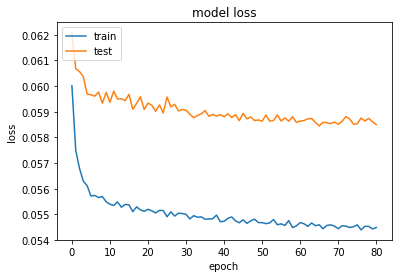

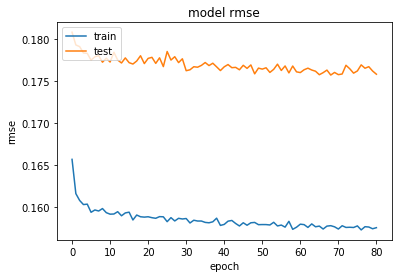

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate performance on validation data to improve model

In [12]:
model.load_weights(experiment_name+'.hdf5')

(6076, 25, 3) (6076, 10, 3)


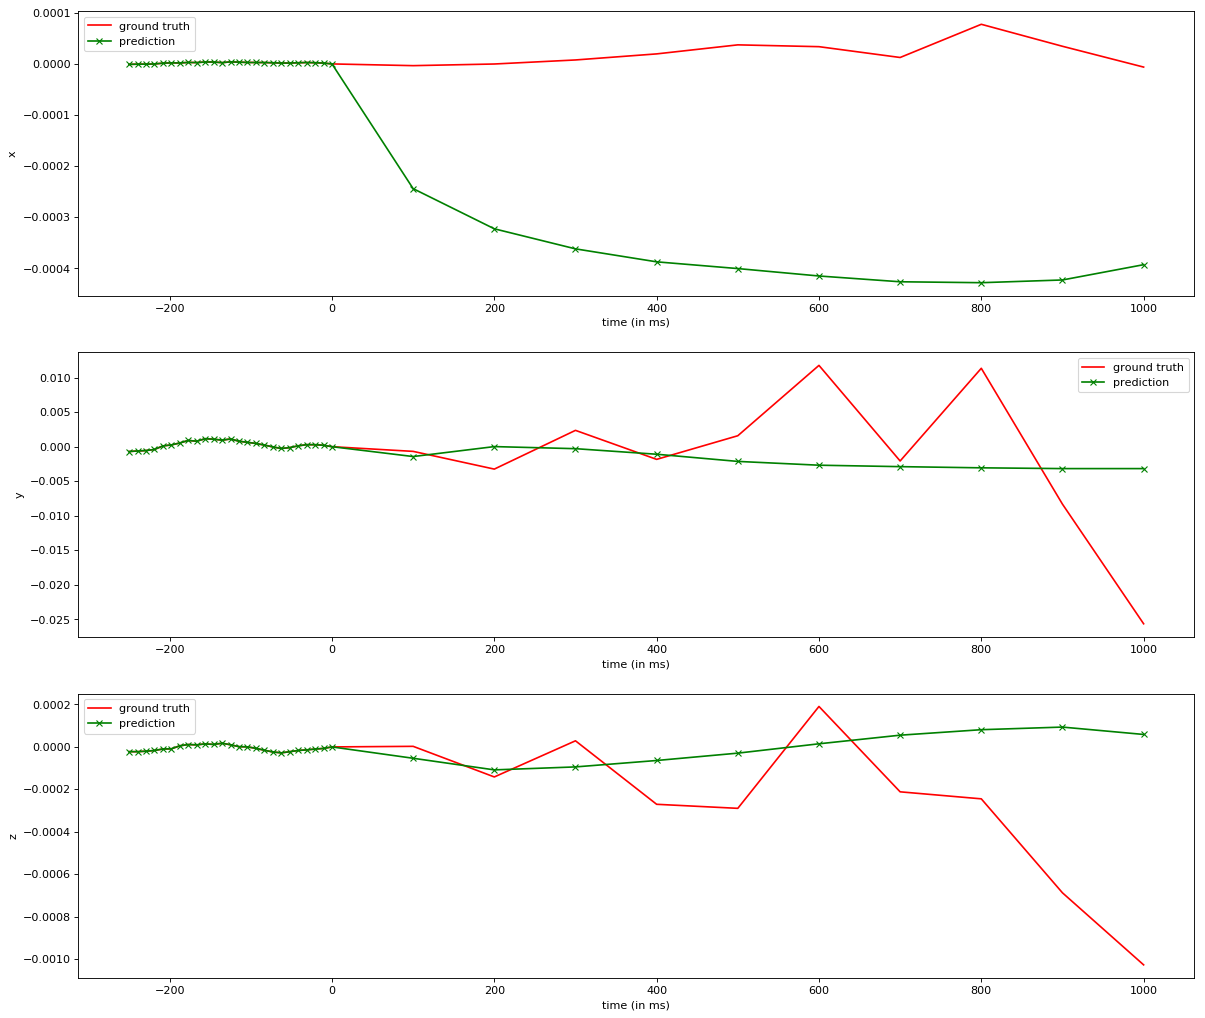

In [13]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )


predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))

def get_mae(Y1, Y2):
    return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)


start = time.time()
print("Evaluating on validation data...")
count = 0
for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #Y_pred = model.predict([encoder_input, decoder_input], verbose=0)
    Y_pred_diff = model.predict([encoder_input, decoder_input[:, 1:]], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]
        
    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)

    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[:,ind_delay]
        Y_delay_val = Y_val_abs[:,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating on validation data...


Evaluation Time :  48.408549070358276 s =  0.8068091630935669 min =  0.013446819451120164 h


### Metrics

In [15]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.058190364495417875
Delay 100 ms: 0.004122360629235185
Delay 200 ms: 0.01272838373807121
Delay 300 ms: 0.023963437379229135
Delay 400 ms: 0.036524781948006756
Delay 500 ms: 0.04977553391484805
Delay 600 ms: 0.06342212106296123
Delay 700 ms: 0.07724969236712852
Delay 800 ms: 0.0910756586910398
Delay 900 ms: 0.10478171970801695
Delay 1000 ms: 0.118259955515642

RMSE
Average rmse: 0.12300493877660965
Delay 100 ms: 0.011374560948074276
Delay 200 ms: 0.02748710090814949
Delay 300 ms: 0.04800056962041757
Delay 400 ms: 0.07026273964706577
Delay 500 ms: 0.0931595093880019
Delay 600 ms: 0.11617857590197063
Delay 700 ms: 0.1389498237079603
Delay 800 ms: 0.16128049399518815
Delay 900 ms: 0.1830486717475468
Delay 1000 ms: 0.20411409591312507

SMAPE
Average smape: 14.25297476343729
Delay 100 ms: 2.175558972079994
Delay 200 ms: 5.304120121988896
Delay 300 ms: 8.372781958390691
Delay 400 ms: 11.228498242169094
Delay 500 ms: 13.827792299044015
Delay 600 ms: 16.218625591204997
Delay 7